In [384]:
# 1. Data cleaning
# 2. PCA
# 3. Segments for population. Azdias
# 4. Segments for customers sample. 
# 5. Compare the segments
# 6. Make classification
# https://towardsdatascience.com/getting-more-value-from-the-pandas-value-counts-aa17230907a6
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
# https://effectiveml.com/using-grid-search-to-optimise-catboost-parameters.html
# https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [397]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Ieva\Anaconda3\python.exe -m pip install --upgrade pip' command.


In [413]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import operator

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier as xgb
import catboost as cb

from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV

pd.options.mode.chained_assignment = None  # default='warn'

from IPython.display import Image

# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
# show maximum number of columns
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

##### 0.1. Load data 

In [3]:
# load in the data
azdias_read = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=',')
customers_read = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=',')

C:\Users\Ieva\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Loaded csv files to dataframes. There are some warning which inform that some columns have mixed data types. So, I will have to keep in mind that cases. 

There is a column Unnamed: 0 in both dataframes. I removed this column as it shows the index of the dataframe and does not bring any additional information. 

In [4]:
# drop index column
azdias = azdias_read.drop(['Unnamed: 0'], axis = 1)
customers = customers_read.drop(['Unnamed: 0'], axis = 1)

##### 0.2 Combine attributes with all possible values.

Load description of features to test if all features satisfies the requirements provided in the excel sheet. The goal is to find out if there are any additional values in customers dataframe which can not be found in the attributes descriptions.

In [5]:
attributes = pd.read_excel('DIAS Attributes - Values 2017.xlsx', header = 0, names = ['unknown', 'Attribute', 'Description', 'Value', 'meaning']).drop(['unknown', 'meaning'], axis = 1).fillna(method='ffill')
attributes = attributes.drop(attributes.index[0])

Originally, there i a file "DIAS Attributes - Values 2017.xlsx" where you can find the attribute and the description of the column. I aggregated all the possible values for each column to combine everything to array.  

In [6]:
# Excluded attributes where value can get many different numerical value. 
attributes_values = attributes[attributes['Value'] != "…"].groupby('Attribute')['Value'].apply(list)
attributes_values_df = pd.DataFrame({'attribute':attributes_values.index, 'attribute_values': attributes_values.values})

Aggregate dataframes values and save possible values to the new dataframe

In [7]:
def collect_column_values(df):
    """Returns dataframe with its columns and possible values

    Parameters:
        df (dataframe): Original dataframe;

    Returns:
        dataframe: column and values
    """
    temp_list = []
    for col in df.columns:
        val = list(df.loc[:, col].unique())
        temp_list.append((col, val))
    result = pd.DataFrame(temp_list, columns = ['column', 'values'])
    return result

In [8]:
customers_values = collect_column_values(customers)

In [9]:
attr_comparison_df = pd.merge(customers_values, attributes_values_df,  how='left', left_on=['column'], right_on = ['attribute'])

In [10]:
attr_comparison_df[attr_comparison_df['attribute_values'].notnull()].count()

column              265
values              265
attribute           265
attribute_values    265
dtype: int64

Only 265 out of 370 columns in the customers dataframe have columns which descriptions we can find in the attributes excel sheet. 

In [24]:
attribute_differences = []

attr_comparison_df = attr_comparison_df[attr_comparison_df['attribute_values'].notnull()]
for index, row in attr_comparison_df.iterrows():
    attribute_differences.append((attr_comparison_df['column'][index], set(attr_comparison_df['values'][index]) - set(attr_comparison_df['attribute_values'][index])))

In [26]:
attribute_differences_df = pd.DataFrame(attribute_differences, columns = ['column', 'values'])
attribute_differences_df['length'] = attribute_differences_df['values'].str.len()
attribute_differences_df.sort_values('length', ascending = False, inplace = True)

In [29]:
# I filter columns where difference between original value and documentation differ at least one value. 
attribute_differences_df[attribute_differences_df['length'] > 1].head(60)

column                               values  length
4        CAMEO_DEUG_2015  {nan, 3, 7, 5, 9, X, 1, 8, 4, 2, 6}      11
74       KBA05_KRSHERST3                           {nan, 9.0}       2
68          KBA05_HERST4                           {nan, 9.0}       2
79             KBA05_KW1                           {nan, 9.0}       2
78          KBA05_KRSZUL                           {nan, 9.0}       2
77          KBA05_KRSVAN                           {nan, 9.0}       2
76         KBA05_KRSOBER                           {nan, 9.0}       2
75        KBA05_KRSKLEIN                           {nan, 9.0}       2
109           KBA05_ZUL2                           {nan, 9.0}       2
73       KBA05_KRSHERST2                           {nan, 9.0}       2
72       KBA05_KRSHERST1                           {nan, 9.0}       2
71        KBA05_KRSAQUOT                           {nan, 9.0}       2
70       KBA05_HERSTTEMP                           {nan, 9.0}       2
69          KBA05_HERST5                           {nan, 9.0}       2
67          KBA05_HERST3                           {nan, 9.0}       2
81             KBA05_KW3                           {nan, 9.0}       2
66          KBA05_HERST2                           {nan, 9.0}       2
65          KBA05_HERST1                           {nan, 9.0}       2
64             KBA05_GBZ                           {nan, 0.0}       2
63            KBA05_FRAU                           {nan, 9.0}       2
62          KBA05_DIESEL                           {nan, 9.0}       2
61            KBA05_CCM4                           {nan, 9.0}       2
60            KBA05_CCM3                           {nan, 9.0}       2
59            KBA05_CCM2                           {nan, 9.0}       2
58            KBA05_CCM1                           {nan, 9.0}       2
57          KBA05_BAUMAX                           {0.0, nan}       2
80             KBA05_KW2                           {nan, 9.0}       2
82           KBA05_MAXAH                           {nan, 9.0}       2
110           KBA05_ZUL3                           {nan, 9.0}       2
83           KBA05_MAXBJ                           {nan, 9.0}       2
106          KBA05_VORB1                           {nan, 9.0}       2
105          KBA05_VORB0                           {nan, 9.0}       2
104           KBA05_SEG9                           {nan, 9.0}       2
103           KBA05_SEG8                           {nan, 9.0}       2
102           KBA05_SEG7                           {nan, 9.0}       2
101           KBA05_SEG6                           {nan, 9.0}       2
100           KBA05_SEG5                           {nan, 9.0}       2
99            KBA05_SEG4                           {nan, 9.0}       2
98            KBA05_SEG3                           {nan, 9.0}       2
97            KBA05_SEG2                           {nan, 9.0}       2
96           KBA05_SEG10                           {nan, 9.0}       2
95            KBA05_SEG1                           {nan, 9.0}       2
94          KBA05_MOTRAD                           {nan, 9.0}       2
93           KBA05_MOTOR                           {nan, 9.0}       2
92         KBA05_MODTEMP                           {nan, 6.0}       2
91            KBA05_MOD8                           {nan, 9.0}       2
90            KBA05_MOD4                           {nan, 9.0}       2
89            KBA05_MOD3                           {nan, 9.0}       2
88            KBA05_MOD2                           {nan, 9.0}       2
87            KBA05_MOD1                           {nan, 9.0}       2
86         KBA05_MAXVORB                           {nan, 9.0}       2
85          KBA05_MAXSEG                           {nan, 9.0}       2
84        KBA05_MAXHERST                           {nan, 9.0}       2
56        KBA05_AUTOQUOT                           {nan, 9.0}       2
111           KBA05_ZUL4                           {nan, 9.0}       2
108           KBA05_ZUL1                           {nan, 9.0}       2
239             REGIOTYP    

For all the columns which names could be found in attribute_differences_df, I looked through these values to and compared possible values and the actual values. For instance, CAMEO_DEUG_2015 has 11 values, while value XX is not defined. Then I replace that values with NaN.

##### 0.3 Mixed type columns

While reading files, I recognized that there are warning because of mixed data types

In [11]:
def find_mixed_type_columns(df):
    """Returns list with column names which have multiple types.

    Parameters:
        df (dataframe): Original dataframe
        
    Returns:
        list: with mixed data type
    """
    cols = []
    for col in df.columns:
        mixed = (df[[col]].applymap(type) != df[[col]].iloc[0].apply(type)).any(axis = 1)
        if len(df[mixed]) > 0:
            cols.append(col)
    return cols

In [12]:
def unify_mixed_column_types(df, cols):
    """Converts column values to string and splits to . character

    Parameters:
        df (dataframe): Original dataframe
        cols (list): column names with mixed data types
        
    Returns:
        dataframe with unified columns values
    """
    for col in cols:
        df[col] = df[col].astype(object)
        df[col] = df[col].str.split('.', expand = True)[0]
    return df

Foundthat thera are 5 columns where types are different: string and double. 'CAMEO_DEU_2015',
 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015','D19_LETZTER_KAUF_BRANCHE','EINGEFUEGT_AM', 'OST_WEST_KZ'

In these datasets the majority of columnsare float type 267, integers 93, objects 6. 

In [13]:
azdias.dtypes.value_counts()

float64    267
int64       93
object       6
dtype: int64

In [14]:
customers.dtypes.value_counts()

float64    267
int64       94
object       8
dtype: int64

In [16]:
def cols_types(df):
    """ split dataframe columns by type

    Parameters:
        df (dataframe): Original dataframe
        
    Returns:
        list categorical and numerical features column names lists
    """
    cols = df.dtypes
    categorical_cols = [key for key in dict(cols)
             if dict(df.dtypes)[key] in ['object']]
    numerical_cols = [key for key in dict(cols)
             if dict(df.dtypes)[key] in ['float64','float32','int32','int64']]
    return categorical_cols, numerical_cols

In [17]:
categorical_customers, numerical_customers = cols_types(customers)
categorical_azdias, numerical_azdias = cols_types(azdias)

###### 0.4. High cardinality columns

The goal is to identify categorical columns which have more than 2 unique values

In [391]:
def get_high_cardinality_columns(df, cat_cols, limit):
    """Splits categorical columns by number of unique values

    Parameters:
        df (dataframe): Original dataframe
        cat_cols (list): categorical columns name lists
        limit (integer): number of categories
        
    Returns:
        list: non_binary_cat - columns with more categories than limit; 
        binary_cat - columns with 2 categories
    """
    for col in cat_cols:
        if len(df[col].unique()) > limit:
            non_binary_cat.append(col)
        elif len(df[col].unique()) == 2:
            binary_cat.append(col)
    return non_binary_cat, binary_cat

In [20]:
non_binary_customers, binary_customers = get_high_cardinality_columns(customers, categorical_customers, 10)

In [21]:
non_binary_customers

['CAMEO_DEU_2015',
 'CAMEO_DEUG_2015',
 'CAMEO_INTL_2015',
 'D19_LETZTER_KAUF_BRANCHE',
 'EINGEFUEGT_AM']

As a result of high cardinality, I created functions (maps) to reduce the number of categories. For example customers["CAMEO_INTL_2015"] had values 14.0 (double) and 14 (string).

In [22]:
def replace_cameo_deug_values(x):
    """replace values based on conditions

    Parameters:
        df (int): original column value
        
    Returns:
        changed column values based on rules
    """
    if x in (-1, 5):
        return x
    if x in (1, 2):
        return 1
    if x in (3, 4):
        return 2
    if x in (6,7):
        return 3
    if x in (8, 9):
        return 4

In [31]:
def replace_values(df):
    """Returns dataframe with modified values because of missing description.

    Parameters:
        df (dataframe): Original dataframe
        
    Returns:
        dataframe: dataframe with set selected columns to None
    """
    df_new = df
    df_new['KBA05_MODTEMP'] = df['KBA05_MODTEMP'].replace(6, None)
    df_new['CAMEO_DEU_2015'] = df['CAMEO_DEU_2015'].replace("XX", None)
    df_new['LP_LEBENSPHASE_GROB'] = df['LP_LEBENSPHASE_GROB'].replace(0, None)
    df_new['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].replace("X", None)
    df_new['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].replace("XX", None)

    return df_new

1. Not all columns has descriptios in files:./DIAS Information Levels - Attributes 2017.xlsx, because shape of populiation (azdias df is 367) while in the file 
314.
2. Calculate the percent of null information in the df. There are some columns where missing values > 90%. These columns should be excluded as to not get confusion. 

##### 0.5 Exclude columns based on missing values share

In [34]:
(azdias.isnull().sum()/len(azdias)*100).sort_values(ascending = False)

ALTER_KIND4               99.864792
ALTER_KIND3               99.307691
ALTER_KIND2               96.690047
ALTER_KIND1               90.904837
EXTSEL992                 73.399639
                            ...    
D19_VERSI_ONLINE_DATUM     0.000000
D19_VERSICHERUNGEN         0.000000
D19_VOLLSORTIMENT          0.000000
D19_WEIN_FEINKOST          0.000000
LNR                        0.000000
Length: 366, dtype: float64

In [35]:
def exclude_columns_with_many_missing_data(df, missing_ratio):
    """Returns columns list where missing values exceeds defined missing_ratio.

    Parameters:
        df (dataframe): Original dataframe;
        missing_ration (int): defines the ratio of accepted missingness

    Returns:
        list: df column names which should be exluded
    """
    columns = list(df.columns[df.isnull().mean() >= missing_ratio])
    return columns

Investigate which columns have more than defined missing values. I chose statistical point of view and selected to exclude values where missing values is higher than the first quartile (>=25%)

In [36]:
customers_missing_columns = exclude_columns_with_many_missing_data(customers, 0.25)
azdias_missing_columns = exclude_columns_with_many_missing_data(azdias, 0.25)

columns_to_exclude = customers_missing_columns + list(set(azdias_missing_columns) - set(customers_missing_columns))

# Finally, I checked if azdias and customers dataframes have the same columns with set(azdias.columns) - set(customers.columns)
# Because both dataframes have the same columns, I chose one of the dataframes columns and removed columns (columns_to_exclude).
columns_to_keep = set(azdias.columns) - set(columns_to_exclude)

In [37]:
def calculate_correlations(df, cor_threshold):
    """Calculate correlation and return highly correlated columns list

    Parameters:
        df (dataframe): Original dataframe;
        cor_threshold (int): filter correlation matrix and select columns with higher correlation than threshold

    Returns:
        list: highly correlated columns list
    """
    corr_matrix = df.corr().abs() 
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > cor_threshold)]
    
    return to_drop
  

In [38]:
def remove_columns(df, columns_list_to_remove):
    """Returns dataframe without columns from provided list. 

    Parameters:
        df (dataframe): Original dataframe;
        df (list): column lists to exclude

    Returns:
        dataframe: without defined columns
    """  
    return df[[col for col in df.columns if col not in columns_list_to_remove]]

In [39]:
def impute_missing_data(df):
    """Impute missing data with median value. 

    Parameters:
        df (dataframe): original dataframe;

    Returns:
        dataframe: with filled missing values
    """  
    imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')
    imputer = imputer.fit(df)
    return imputer.transform(df)

In [231]:
def add_columns(cols_to_keep, v):
    if v == False:
        res = cols_to_keep
    elif "RESPONSE" in cols_to_keep:
        res = cols_to_keep.remove("RESPONSE")
    else:
        res = cols_to_keep
    return res


Final data preparation function

In [311]:
def prepare_data (df1, df2, missing_percent, cor_threshold, val = True):
    """Returns prepared dataframe

    Parameters:
        df1 (dataframe): Original dataframe;
        df2 (dataframe): Other dataframe;
        missing_percent (double): maximum value to exclude columns with missing data;
        cor_threshold (double): maximum value to eclude columns with high correlations

    Returns:
        dataframe: cleaned dataframe
    """         
    common_cols = list(set(df1.columns) & set(df2.columns))
    
    df1_new = replace_values(df1[common_cols])
    print("replace unknown column values")
    
    mixed_cols = find_mixed_type_columns(df1)
    print("find mixed column types")
    
    df1_new = unify_mixed_column_types(df1_new, mixed_cols)
    print("replace mixed columns to single type")
    
    df1_new["CAMEO_INTL_2015"] = np.where(df1_new.CAMEO_INTL_2015.isnull(),
         np.nan,
         df1_new.CAMEO_INTL_2015.str.slice(0,1))
    
    df1_new['CAMEO_DEUG_2015'] = df1_new['CAMEO_DEUG_2015'].apply(replace_cameo_deug_values)

    df1_missing_columns = exclude_columns_with_many_missing_data(df1, missing_percent)
    df2_missing_columns = exclude_columns_with_many_missing_data(df2, missing_percent)
    print("removed column with missing data with more than {0} percent".format(missing_percent))
    
    if val == True:
        columns_to_exclude = df1_missing_columns + list(set(df2_missing_columns) - set(df1_missing_columns))
    else:
        columns_to_exclude = df1_missing_columns
    print("collect missing columns names")
    
    columns_to_keep = set(df1.columns) - set(columns_to_exclude) - set(['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE'])
    print("keep relevant columns")
    
    columns_to_keep = add_columns(columns_to_keep, val)
    
    df1_new = df1_new[columns_to_keep]
        
    df1_cols = calculate_correlations(df1_new, cor_threshold)
    res = remove_columns(df1_new, df1_cols)
    
    return res

In [390]:
customers_upd_df = prepare_data(customers, azdias, 0.25, 0.8)

replace unknown column values
find mixed column types
replace mixed columns to single type
removed column with missing data with more than 0.25 percent
collect missing columns names
keep relevant columns


In [42]:
azdias_upd_df = prepare_data(azdias, customers, 0.25, 0.8)

replace unknown column values
find mixed column types
replace mixed columns to single type
removed column with missing data with more than 0.25 percent
collect missing columns names
keep relevant columns


In [236]:
customers_upd_df.shape

(191652, 100)

In [44]:
azdias_upd_df.shape

(891221, 105)

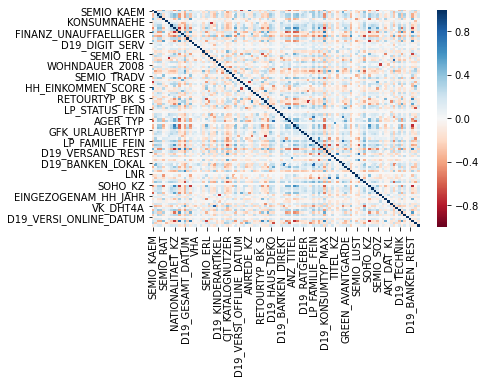

In [45]:
sns.heatmap(customers_upd_df.corr(), vmin = -1, vmax = 1, cmap = "RdBu")

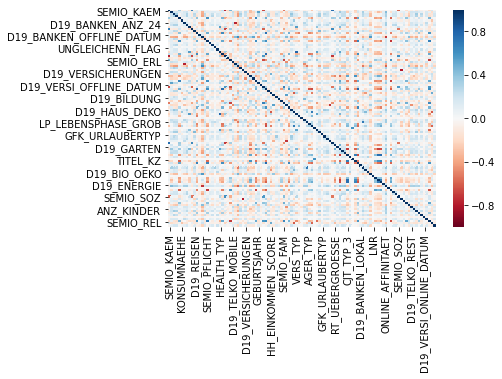

In [46]:
sns.heatmap(azdias_upd_df.corr(), vmin = -1, vmax = 1, cmap = "RdBu")

As the number of the dataframes shapes differ, I am going to select common cols for both datasets

In [47]:
common_cols = set(customers_upd_df.columns) & set(azdias_upd_df.columns)

In [48]:
customers_upd_df = customers_upd_df[common_cols]
azdias_upd_df = azdias_upd_df[common_cols]

In [49]:
(azdias_upd_df.isnull().sum()/len(azdias_upd_df)*100).sort_values(ascending = False)

VK_DISTANZ               8.518314
KONSUMNAEHE              8.299737
ANZ_TITEL                8.247000
WOHNDAUER_2008           8.247000
EINGEZOGENAM_HH_JAHR     8.247000
                           ...   
D19_GARTEN               0.000000
PRAEGENDE_JUGENDJAHRE    0.000000
D19_DROGERIEARTIKEL      0.000000
D19_VERSAND_REST         0.000000
SEMIO_KAEM               0.000000
Length: 96, dtype: float64

In [251]:
def plot_missing_values_share(df, limit):
    """Returns barplot with missing data columns, ordered descending by the biggest missing values count

    Parameters:
        df (dataframe): Original dataframe;
        limit (integer): selected value to show in the bar chart;

    Returns:
        visualization
    """         
    df_calc = ((df.isnull().sum()/len(df)*100).sort_values(ascending = False)).head(limit)
    sns.barplot(df_calc.index, df_calc.values, palette = "muted").set_title('column names with missing values')
    plt.xticks(rotation=70)

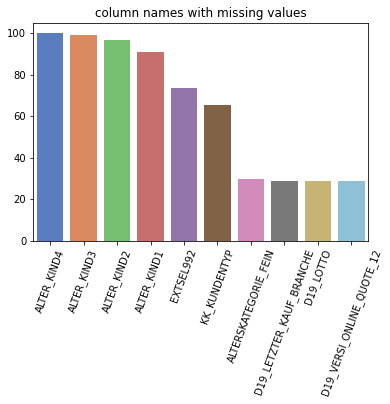

In [252]:
plot_missing_values_share(azdias, 10)

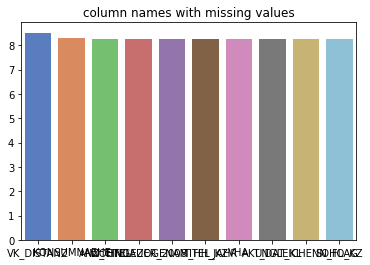

In [52]:
plot_missing_values_share(azdias_upd_df, 10)

Because there are many columns, it is important to reduce the dimension. For this I selected PCA

In [53]:
scaler = StandardScaler()

In [54]:
def scale_df(df):
    """Scale dataframe values. 

    Parameters:
        df (dataframe): Original dataframe;

    Returns:
        dataframe: scaled dataframe values
    """  
    df_scaled = scaler.fit(df).transform(df)
    return df_scaled

In [55]:
customers_scaled = scale_df(impute_missing_data(customers_upd_df))
azdias_scaled = scale_df(impute_missing_data(azdias_upd_df))

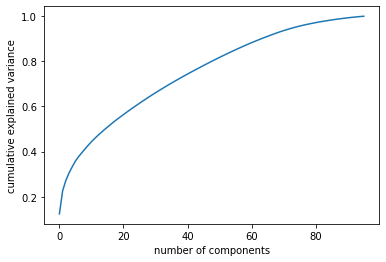

In [56]:
pca = PCA().fit(azdias_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [57]:
np.cumsum(pca.explained_variance_ratio_)

array([0.12386682, 0.22617455, 0.27186916, 0.30538017, 0.33268448,
       0.35824487, 0.37789598, 0.3951579 , 0.41197198, 0.42842628,
       0.44390736, 0.45813626, 0.47152007, 0.48432656, 0.49671555,
       0.5087414 , 0.52066476, 0.53210565, 0.54318799, 0.55384604,
       0.5642941 , 0.57470406, 0.58491536, 0.59482175, 0.60466311,
       0.61432298, 0.62395571, 0.63345899, 0.64291806, 0.65202279,
       0.6610571 , 0.66983353, 0.67846229, 0.68702278, 0.69551583,
       0.70392121, 0.71208353, 0.72022682, 0.72818727, 0.7360954 ,
       0.74388152, 0.75157755, 0.75918016, 0.76674302, 0.77424417,
       0.78172932, 0.78910967, 0.79640496, 0.80367055, 0.81074052,
       0.81775407, 0.82474833, 0.83162499, 0.8383756 , 0.84497356,
       0.85151277, 0.85802113, 0.86445332, 0.87074921, 0.87692828,
       0.88292744, 0.88875678, 0.89455725, 0.90017709, 0.90575948,
       0.91119431, 0.91652885, 0.92180716, 0.92681142, 0.93174264,
       0.93638067, 0.94075366, 0.94494478, 0.94904626, 0.95286

In [69]:
pca = PCA(n_components = 56) 
pca_tf = pca.fit_transform(azdias_scaled) 

In [70]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))


Explained variation per principal component: [0.12386682 0.10230773 0.0456946  0.03351101 0.0273043  0.02556035
 0.01965104 0.01726122 0.01681388 0.01645279 0.01548073 0.01422833
 0.01337998 0.01280474 0.01238682 0.01202275 0.01191729 0.01143873
 0.01107736 0.01065076 0.01043415 0.01040253 0.01019773 0.00990067
 0.0098285  0.00965548 0.00962477 0.00950021 0.00943025 0.00909144
 0.00899021 0.00875389 0.00861078 0.00852475 0.00847327 0.0083816
 0.00812169 0.00805042 0.00792343 0.00786337 0.00775031 0.0076857
 0.00756188 0.00753706 0.00742704 0.00735059 0.00728984 0.00723597
 0.00707062 0.00699227 0.00697598 0.00679873 0.00674426 0.00666869
 0.0065272  0.00648046]


C:\Users\Ieva\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  """


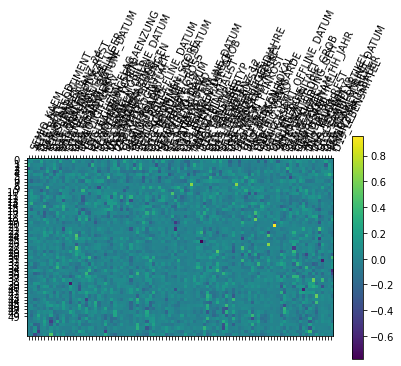

In [71]:
plt.matshow(pca.components_,cmap ='viridis')
plt.yticks(np.arange(0, 50, 1.0),fontsize = 10)
plt.colorbar()
plt.xticks(range(len(azdias_upd_df.columns)),azdias_upd_df.columns,rotation=65,ha='left')
plt.tight_layout()
plt.show()

Apply PCA to customers dataset

In [72]:
pca_cs = pca.transform(customers_scaled)

In [73]:
def analyze_pca(pca, i, num):
    importance = {}
    for counter, feature in enumerate(azdias_upd_df.columns):
        importance[feature] = pca.components_[i][counter]
        
    sorted_by_values = dict(sorted(importance.items(), key = operator.itemgetter(1), reverse = True)[:num])
    keys = sorted_by_values.keys()
    values = sorted_by_values.values()
    plt.bar(keys, values)
    plt.xticks(rotation = 90)

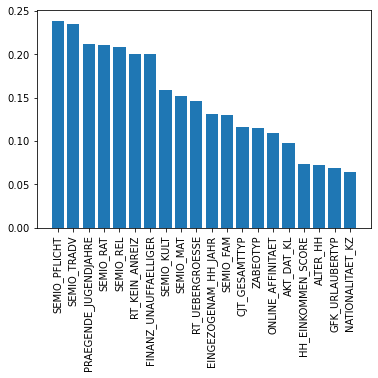

In [74]:
analyze_pca(pca, 1, 20)

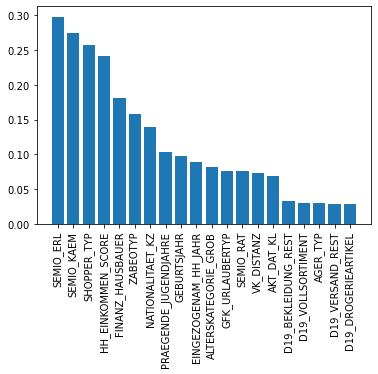

In [75]:
analyze_pca(pca, 2, 20)

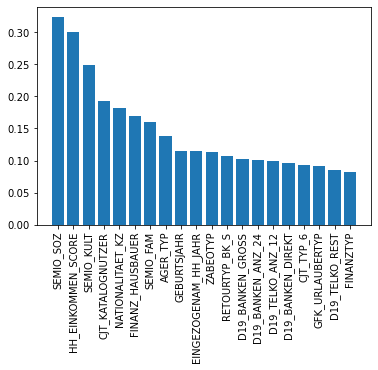

In [76]:
analyze_pca(pca, 3, 20)

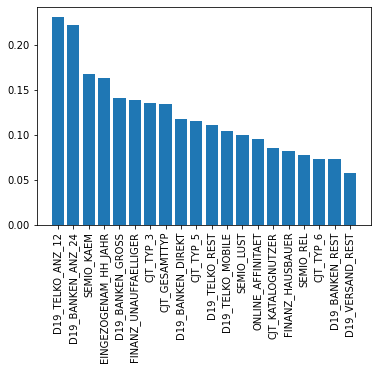

In [77]:
analyze_pca(pca, 4, 20)

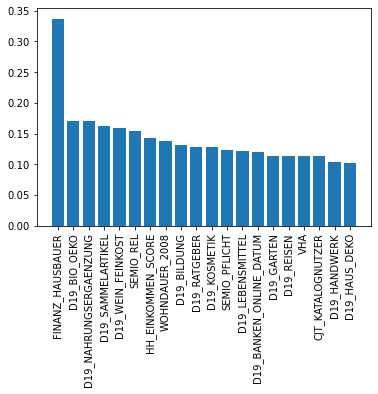

In [78]:
analyze_pca(pca, 5, 20)

In [79]:
def calculate_k(df, k_min, k_max, data):
    results = []
    K = range(k_min, k_max)
    for k in K:
        kmeanModel = KMeans(n_clusters = k, init = "k-means++")
        start = datetime.datetime.now()
        kmeanModel.fit(data)
        end = datetime.datetime.now()
        time_diff = end - start
        print("number of clusters {0}, calculation time {1} and inertia {2}".format(k, time_diff, kmeanModel.inertia_))
        results.append(kmeanModel.inertia_)
        
    plt.figure(figsize = (16,8))
    plt.plot(K, results, 'bx-', linestyle='--', marker='o')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.savefig('Elbow_plot_1_15.png')
    plt.show()

number of clusters 1, calculation time 0:00:09.675120 and inertia 72695142.18536563
number of clusters 2, calculation time 0:00:53.199705 and inertia 65141492.936468326
number of clusters 3, calculation time 0:00:52.282186 and inertia 60328007.75929932
number of clusters 4, calculation time 0:01:57.312217 and inertia 57726655.375385076
number of clusters 5, calculation time 0:03:05.280385 and inertia 55968017.31678391
number of clusters 6, calculation time 0:02:09.452735 and inertia 54579157.56882607
number of clusters 7, calculation time 0:02:13.712388 and inertia 53486551.31572551
number of clusters 8, calculation time 0:02:31.658364 and inertia 52602550.87094875
number of clusters 9, calculation time 0:04:05.839432 and inertia 51537841.04643388
number of clusters 10, calculation time 0:03:18.309564 and inertia 50845235.09251847
number of clusters 11, calculation time 0:03:50.814622 and inertia 50012953.503860205
number of clusters 12, calculation time 0:07:51.947645 and inertia 4947

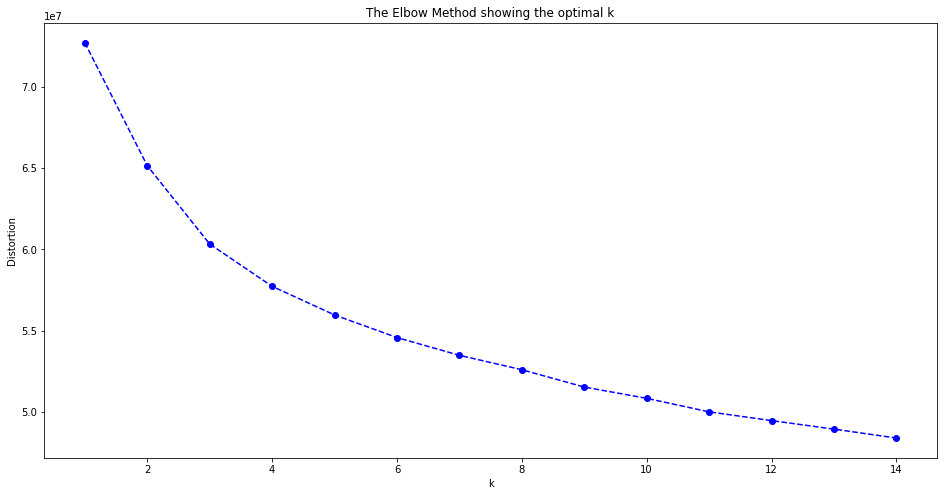

In [80]:
calculate_k(pca_tf, 1, 15, pca_tf)

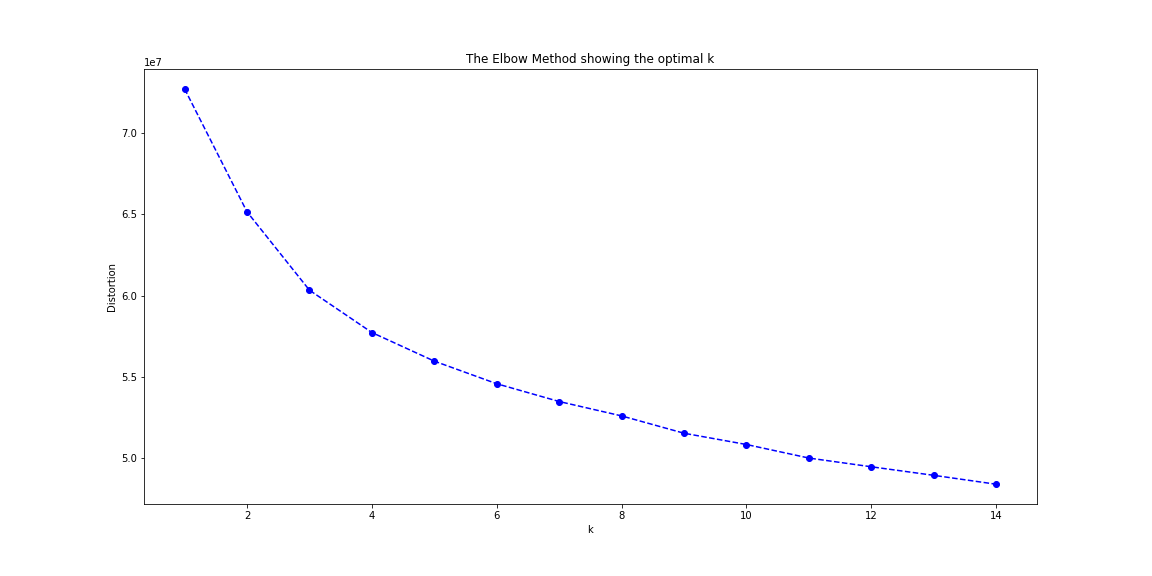

In [81]:
Image(filename = 'Elbow_plot_1_15.png')

In [82]:
km = KMeans(
    n_clusters = 8, init='k-means++'
)

In [83]:
y_km = km.fit_predict(pca_tf)

In [84]:
y_km

array([3, 2, 2, ..., 6, 7, 0])

In [85]:
y_cust = km.predict(pca_cs)

In [167]:
azdias_upd_df['population_cluster'] = y_km + 1
customers_upd_df['customer_cluster'] = y_cust + 1

In [168]:
azdias_upd_df['population_cluster'].value_counts()

1    147339
5    145321
6    144462
7    108850
3    103842
8     97292
4     95824
2     48291
Name: population_cluster, dtype: int64

In [169]:
customers_upd_df['customer_cluster'].value_counts()

4    46556
6    44144
1    29643
5    25725
7    20836
2    11761
3     7570
8     5417
Name: customer_cluster, dtype: int64

In [174]:
def plot_clusters(df, title):
    counts = df.value_counts(normalize = True, ascending = True)
    plt.figure(figsize = (10,5))
    sns.barplot(counts.index, counts.values, alpha = 0.8)
    plt.title(title)
    plt.ylabel('Number of Occurrences', fontsize=12)
    plt.xlabel('segment', fontsize=12)
    plt.show()

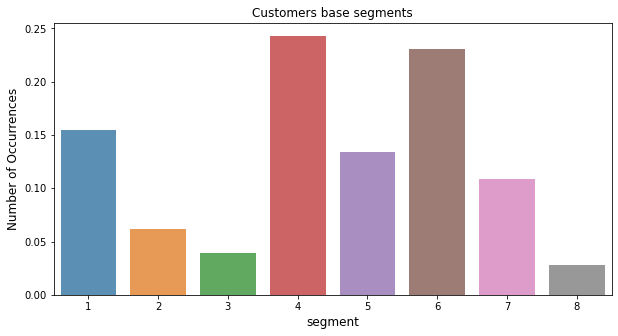

In [175]:
plot_clusters(customers_upd_df['customer_cluster'], "Customers base segments")

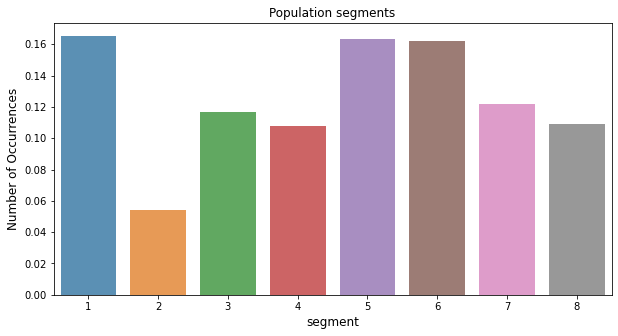

In [176]:
plot_clusters(azdias_upd_df['population_cluster'], "Population segments")

In [127]:
customers_upd_df.groupby('customer_cluster').describe().to_csv("customers_segments_stats.csv")
azdias_upd_df.groupby('population_cluster').describe().to_csv("customers_segments_stats.csv")

In [154]:
def segment_importance(km, segment_num, pca_len):
    weights =  km.cluster_centers_[segment_num]
    cluster_components = pd.DataFrame({"Contribution": weights, "Component": list(range(1, pca_len + 1))})
    res_df = cluster_components.sort_values("Contribution", ascending = False)
    return res_df

In [180]:
segment_importance(km, 0, 56)[0:10]

Contribution  Component
3       1.002314          4
2       0.766037          3
5       0.169627          6
33      0.155618         34
15      0.138790         16
4       0.107521          5
24      0.100889         25
16      0.086049         17
36      0.084077         37
39      0.064681         40

In [181]:
segment_importance(km, 1, 56)[0:10]

Contribution  Component
0       8.122003          1
5       1.762070          6
7       1.669895          8
9       0.876614         10
11      0.496790         12
6       0.263767          7
14      0.230028         15
10      0.184573         11
44      0.171851         45
13      0.171466         14

In [163]:
segment_importance(km, 2, 56)[0:10]

Contribution  Component
4       2.302590          5
5       1.360059          6
11      0.255753         12
18      0.225283         19
10      0.181514         11
17      0.168076         18
12      0.147664         13
14      0.091444         15
9       0.077041         10
31      0.075043         32

In [182]:
segment_importance(km, 4, 56)[0:10]

Contribution  Component
2       0.914755          3
7       0.477481          8
11      0.452097         12
9       0.317633         10
31      0.236039         32
18      0.204038         19
10      0.201413         11
30      0.190770         31
3       0.188201          4
17      0.182900         18

In [184]:
segment_importance(km, 7, 56)[0:10]

Contribution  Component
1       3.534462          2
3       1.694557          4
10      0.257733         11
49      0.135609         50
36      0.120268         37
29      0.105600         30
13      0.105195         14
20      0.097119         21
48      0.095962         49
53      0.077752         54

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [187]:
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=',')
mailout = mailout_train.drop(['Unnamed: 0'], axis = 1)


C:\Users\Ieva\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [189]:
(mailout_train.isnull().sum()/len(mailout_train)*100).sort_values(ascending = False)

ALTER_KIND4               99.904567
ALTER_KIND3               99.594991
ALTER_KIND2               98.240305
ALTER_KIND1               95.372655
KK_KUNDENTYP              58.926493
                            ...    
D19_VERSI_ONLINE_DATUM     0.000000
D19_VERSICHERUNGEN         0.000000
D19_VOLLSORTIMENT          0.000000
D19_WEIN_FEINKOST          0.000000
Unnamed: 0                 0.000000
Length: 368, dtype: float64

In [198]:
mailout.RESPONSE.value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

In [315]:
mailout_data = prepare_data(mailout, mailout, 0.15, 0.8, False)

replace unknown column values
find mixed column types
replace mixed columns to single type
removed column with missing data with more than 0.15 percent
collect missing columns names
keep relevant columns


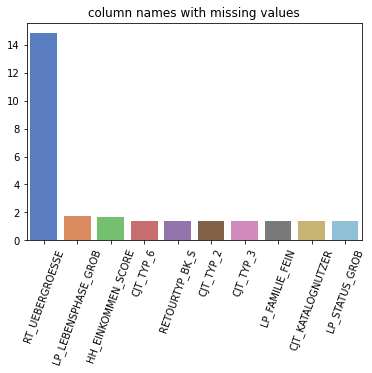

In [316]:
plot_missing_values_share(mailout_data, 10)

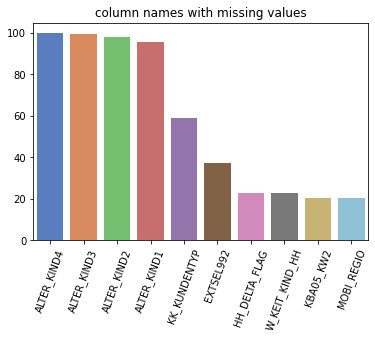

In [318]:
plot_missing_values_share(mailout, 10)

In [325]:
train_df = mailout_data.drop(['RESPONSE'], axis = 1)
train_response = mailout_data['RESPONSE']

mailout_imputed = impute_missing_data(train_df)

In [349]:
type(train_response)

pandas.core.series.Series

In [375]:
def best_model_search(model, param_grid, X_train = mailout_imputed, y_train = train_response):
    """
    Fits a classifier to its training data and prints its ROC AUC score.
    
    Parameters:
    - model: selected and defined classifier
    - param_grid (dict): parameters to go through all possible combinations
    - X_train (DataFrame): training dataset without missing data
    - y_train (Series): response value
            
    Returns:
    - classifier: input classifier fitted to the training data
    """
    grid = GridSearchCV(estimator = model, param_grid = param_grid, scoring = 'roc_auc', cv = 3, verbose = 2)
    grid.fit(X_train, y_train)
    print(grid.best_score_, grid.best_params_)
    
    return grid.best_estimator_

###### Random forest

In [360]:
# Random forest
n_estimators = [50, 100, 150]
max_depth = [2, 4, 8, 16]
max_features = ['auto', 'sqrt']
bootstrap = [True, False]

random_grid_rf = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'bootstrap': bootstrap}

rf = RandomForestClassifier(random_state = 42, verbose = 1)


In [361]:
best_model_search(rf, random_grid_rf)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.4s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    8.9s finished
[Parallel(n_jobs=1)]: Us

0.6775335566613231 {'bootstrap': False, 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 100}


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.9s finished


RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=1,
                       warm_start=False)

In [364]:
# roc_auc 0.6775335566613231 
rf_best_values = RandomForestClassifier(random_state = 42, bootstrap = False, max_depth = 4, max_features = 'auto', n_estimators = 100, verbose = 1)

In [427]:
rf_best_values.fit(mailout_imputed, train_response)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.0s finished


RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=1,
                       warm_start=False)

###### XgBoost

In [376]:
# XgBoost
n_estimators = [50, 100, 150]
max_depth = [2, 4, 6, 8, 16]
learning_rate = [0.01, 0.05, 0.1, 0.3]
reg_alpha = [1e-5, 1e-2, 0.1, 1, 100]

random_grid_rf = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'learning_rate': learning_rate, 
               'reg_alpha': reg_alpha}

xgb = XGBClassifier(random_state = 42)
xgb_find_value = best_model_search(xgb, random_grid_rf)

Fitting 3 folds for each of 300 candidates, totalling 900 fits
[CV] learning_rate=0.01, max_depth=2, n_estimators=50, reg_alpha=1e-05 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.01, max_depth=2, n_estimators=50, reg_alpha=1e-05, total=   0.9s
[CV] learning_rate=0.01, max_depth=2, n_estimators=50, reg_alpha=1e-05 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  learning_rate=0.01, max_depth=2, n_estimators=50, reg_alpha=1e-05, total=   1.1s
[CV] learning_rate=0.01, max_depth=2, n_estimators=50, reg_alpha=1e-05 
[CV]  learning_rate=0.01, max_depth=2, n_estimators=50, reg_alpha=1e-05, total=   1.0s
[CV] learning_rate=0.01, max_depth=2, n_estimators=50, reg_alpha=0.01 
[CV]  learning_rate=0.01, max_depth=2, n_estimators=50, reg_alpha=0.01, total=   1.0s
[CV] learning_rate=0.01, max_depth=2, n_estimators=50, reg_alpha=0.01 
[CV]  learning_rate=0.01, max_depth=2, n_estimators=50, reg_alpha=0.01, total=   1.0s
[CV] learning_rate=0.01, max_depth=2, n_estimators=50, reg_alpha=0.01 
[CV]  learning_rate=0.01, max_depth=2, n_estimators=50, reg_alpha=0.01, total=   1.2s
[CV] learning_rate=0.01, max_depth=2, n_estimators=50, reg_alpha=0.1 .
[CV]  learning_rate=0.01, max_depth=2, n_estimators=50, reg_alpha=0.1, total=   1.0s
[CV] learning_rate=0.01, max_depth=2, n_estimators=50, reg_alpha=0.1 .
[CV]  learning_rate=0.01, max_depth=2, n_estimators=50, 

[CV]  learning_rate=0.01, max_depth=4, n_estimators=50, reg_alpha=1, total=   0.7s
[CV] learning_rate=0.01, max_depth=4, n_estimators=50, reg_alpha=1 ...
[CV]  learning_rate=0.01, max_depth=4, n_estimators=50, reg_alpha=1, total=   0.7s
[CV] learning_rate=0.01, max_depth=4, n_estimators=50, reg_alpha=1 ...
[CV]  learning_rate=0.01, max_depth=4, n_estimators=50, reg_alpha=1, total=   0.7s
[CV] learning_rate=0.01, max_depth=4, n_estimators=50, reg_alpha=100 .
[CV]  learning_rate=0.01, max_depth=4, n_estimators=50, reg_alpha=100, total=   0.7s
[CV] learning_rate=0.01, max_depth=4, n_estimators=50, reg_alpha=100 .
[CV]  learning_rate=0.01, max_depth=4, n_estimators=50, reg_alpha=100, total=   0.7s
[CV] learning_rate=0.01, max_depth=4, n_estimators=50, reg_alpha=100 .
[CV]  learning_rate=0.01, max_depth=4, n_estimators=50, reg_alpha=100, total=   0.6s
[CV] learning_rate=0.01, max_depth=4, n_estimators=100, reg_alpha=1e-05 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=100, reg_alpha=1

[CV]  learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=1e-05, total=   3.0s
[CV] learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.01 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.01, total=   3.0s
[CV] learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.01 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.01, total=   2.7s
[CV] learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.01 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.01, total=   2.9s
[CV] learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, total=   2.9s
[CV] learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, total=   2.8s
[CV] learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_depth=6, n_estimator

[CV]  learning_rate=0.01, max_depth=8, n_estimators=100, reg_alpha=1, total=   1.7s
[CV] learning_rate=0.01, max_depth=8, n_estimators=100, reg_alpha=1 ..
[CV]  learning_rate=0.01, max_depth=8, n_estimators=100, reg_alpha=1, total=   1.8s
[CV] learning_rate=0.01, max_depth=8, n_estimators=100, reg_alpha=100 
[CV]  learning_rate=0.01, max_depth=8, n_estimators=100, reg_alpha=100, total=   1.1s
[CV] learning_rate=0.01, max_depth=8, n_estimators=100, reg_alpha=100 
[CV]  learning_rate=0.01, max_depth=8, n_estimators=100, reg_alpha=100, total=   1.3s
[CV] learning_rate=0.01, max_depth=8, n_estimators=100, reg_alpha=100 
[CV]  learning_rate=0.01, max_depth=8, n_estimators=100, reg_alpha=100, total=   1.3s
[CV] learning_rate=0.01, max_depth=8, n_estimators=150, reg_alpha=1e-05 
[CV]  learning_rate=0.01, max_depth=8, n_estimators=150, reg_alpha=1e-05, total=   5.7s
[CV] learning_rate=0.01, max_depth=8, n_estimators=150, reg_alpha=1e-05 
[CV]  learning_rate=0.01, max_depth=8, n_estimators=150,

[CV]  learning_rate=0.01, max_depth=16, n_estimators=150, reg_alpha=1e-05, total=   6.7s
[CV] learning_rate=0.01, max_depth=16, n_estimators=150, reg_alpha=0.01 
[CV]  learning_rate=0.01, max_depth=16, n_estimators=150, reg_alpha=0.01, total=   7.2s
[CV] learning_rate=0.01, max_depth=16, n_estimators=150, reg_alpha=0.01 
[CV]  learning_rate=0.01, max_depth=16, n_estimators=150, reg_alpha=0.01, total=   6.3s
[CV] learning_rate=0.01, max_depth=16, n_estimators=150, reg_alpha=0.01 
[CV]  learning_rate=0.01, max_depth=16, n_estimators=150, reg_alpha=0.01, total=   6.9s
[CV] learning_rate=0.01, max_depth=16, n_estimators=150, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_depth=16, n_estimators=150, reg_alpha=0.1, total=   6.6s
[CV] learning_rate=0.01, max_depth=16, n_estimators=150, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_depth=16, n_estimators=150, reg_alpha=0.1, total=   5.5s
[CV] learning_rate=0.01, max_depth=16, n_estimators=150, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_depth=16

[CV]  learning_rate=0.05, max_depth=2, n_estimators=150, reg_alpha=1, total=   2.4s
[CV] learning_rate=0.05, max_depth=2, n_estimators=150, reg_alpha=1 ..
[CV]  learning_rate=0.05, max_depth=2, n_estimators=150, reg_alpha=1, total=   2.4s
[CV] learning_rate=0.05, max_depth=2, n_estimators=150, reg_alpha=1 ..
[CV]  learning_rate=0.05, max_depth=2, n_estimators=150, reg_alpha=1, total=   2.3s
[CV] learning_rate=0.05, max_depth=2, n_estimators=150, reg_alpha=100 
[CV]  learning_rate=0.05, max_depth=2, n_estimators=150, reg_alpha=100, total=   2.1s
[CV] learning_rate=0.05, max_depth=2, n_estimators=150, reg_alpha=100 
[CV]  learning_rate=0.05, max_depth=2, n_estimators=150, reg_alpha=100, total=   2.3s
[CV] learning_rate=0.05, max_depth=2, n_estimators=150, reg_alpha=100 
[CV]  learning_rate=0.05, max_depth=2, n_estimators=150, reg_alpha=100, total=   2.5s
[CV] learning_rate=0.05, max_depth=4, n_estimators=50, reg_alpha=1e-05 
[CV]  learning_rate=0.05, max_depth=4, n_estimators=50, reg_alp

[CV]  learning_rate=0.05, max_depth=6, n_estimators=50, reg_alpha=1e-05, total=   1.9s
[CV] learning_rate=0.05, max_depth=6, n_estimators=50, reg_alpha=0.01 
[CV]  learning_rate=0.05, max_depth=6, n_estimators=50, reg_alpha=0.01, total=   1.9s
[CV] learning_rate=0.05, max_depth=6, n_estimators=50, reg_alpha=0.01 
[CV]  learning_rate=0.05, max_depth=6, n_estimators=50, reg_alpha=0.01, total=   1.8s
[CV] learning_rate=0.05, max_depth=6, n_estimators=50, reg_alpha=0.01 
[CV]  learning_rate=0.05, max_depth=6, n_estimators=50, reg_alpha=0.01, total=   2.0s
[CV] learning_rate=0.05, max_depth=6, n_estimators=50, reg_alpha=0.1 .
[CV]  learning_rate=0.05, max_depth=6, n_estimators=50, reg_alpha=0.1, total=   1.8s
[CV] learning_rate=0.05, max_depth=6, n_estimators=50, reg_alpha=0.1 .
[CV]  learning_rate=0.05, max_depth=6, n_estimators=50, reg_alpha=0.1, total=   1.8s
[CV] learning_rate=0.05, max_depth=6, n_estimators=50, reg_alpha=0.1 .
[CV]  learning_rate=0.05, max_depth=6, n_estimators=50, reg

[CV]  learning_rate=0.05, max_depth=8, n_estimators=50, reg_alpha=1, total=   1.6s
[CV] learning_rate=0.05, max_depth=8, n_estimators=50, reg_alpha=1 ...
[CV]  learning_rate=0.05, max_depth=8, n_estimators=50, reg_alpha=1, total=   1.7s
[CV] learning_rate=0.05, max_depth=8, n_estimators=50, reg_alpha=100 .
[CV]  learning_rate=0.05, max_depth=8, n_estimators=50, reg_alpha=100, total=   0.7s
[CV] learning_rate=0.05, max_depth=8, n_estimators=50, reg_alpha=100 .
[CV]  learning_rate=0.05, max_depth=8, n_estimators=50, reg_alpha=100, total=   0.9s
[CV] learning_rate=0.05, max_depth=8, n_estimators=50, reg_alpha=100 .
[CV]  learning_rate=0.05, max_depth=8, n_estimators=50, reg_alpha=100, total=   0.8s
[CV] learning_rate=0.05, max_depth=8, n_estimators=100, reg_alpha=1e-05 
[CV]  learning_rate=0.05, max_depth=8, n_estimators=100, reg_alpha=1e-05, total=   5.0s
[CV] learning_rate=0.05, max_depth=8, n_estimators=100, reg_alpha=1e-05 
[CV]  learning_rate=0.05, max_depth=8, n_estimators=100, reg_

[CV]  learning_rate=0.05, max_depth=16, n_estimators=100, reg_alpha=1e-05, total=   7.5s
[CV] learning_rate=0.05, max_depth=16, n_estimators=100, reg_alpha=0.01 
[CV]  learning_rate=0.05, max_depth=16, n_estimators=100, reg_alpha=0.01, total=   7.6s
[CV] learning_rate=0.05, max_depth=16, n_estimators=100, reg_alpha=0.01 
[CV]  learning_rate=0.05, max_depth=16, n_estimators=100, reg_alpha=0.01, total=   7.6s
[CV] learning_rate=0.05, max_depth=16, n_estimators=100, reg_alpha=0.01 
[CV]  learning_rate=0.05, max_depth=16, n_estimators=100, reg_alpha=0.01, total=   7.6s
[CV] learning_rate=0.05, max_depth=16, n_estimators=100, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_depth=16, n_estimators=100, reg_alpha=0.1, total=   7.4s
[CV] learning_rate=0.05, max_depth=16, n_estimators=100, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_depth=16, n_estimators=100, reg_alpha=0.1, total=   7.4s
[CV] learning_rate=0.05, max_depth=16, n_estimators=100, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_depth=16

[CV]  learning_rate=0.1, max_depth=2, n_estimators=100, reg_alpha=1, total=   1.7s
[CV] learning_rate=0.1, max_depth=2, n_estimators=100, reg_alpha=1 ...
[CV]  learning_rate=0.1, max_depth=2, n_estimators=100, reg_alpha=1, total=   1.7s
[CV] learning_rate=0.1, max_depth=2, n_estimators=100, reg_alpha=1 ...
[CV]  learning_rate=0.1, max_depth=2, n_estimators=100, reg_alpha=1, total=   1.6s
[CV] learning_rate=0.1, max_depth=2, n_estimators=100, reg_alpha=100 .
[CV]  learning_rate=0.1, max_depth=2, n_estimators=100, reg_alpha=100, total=   1.5s
[CV] learning_rate=0.1, max_depth=2, n_estimators=100, reg_alpha=100 .
[CV]  learning_rate=0.1, max_depth=2, n_estimators=100, reg_alpha=100, total=   1.8s
[CV] learning_rate=0.1, max_depth=2, n_estimators=100, reg_alpha=100 .
[CV]  learning_rate=0.1, max_depth=2, n_estimators=100, reg_alpha=100, total=   1.7s
[CV] learning_rate=0.1, max_depth=2, n_estimators=150, reg_alpha=1e-05 
[CV]  learning_rate=0.1, max_depth=2, n_estimators=150, reg_alpha=1e-

[CV]  learning_rate=0.1, max_depth=4, n_estimators=150, reg_alpha=1e-05, total=   4.4s
[CV] learning_rate=0.1, max_depth=4, n_estimators=150, reg_alpha=0.01 
[CV]  learning_rate=0.1, max_depth=4, n_estimators=150, reg_alpha=0.01, total=   4.1s
[CV] learning_rate=0.1, max_depth=4, n_estimators=150, reg_alpha=0.01 
[CV]  learning_rate=0.1, max_depth=4, n_estimators=150, reg_alpha=0.01, total=   4.1s
[CV] learning_rate=0.1, max_depth=4, n_estimators=150, reg_alpha=0.01 
[CV]  learning_rate=0.1, max_depth=4, n_estimators=150, reg_alpha=0.01, total=   4.1s
[CV] learning_rate=0.1, max_depth=4, n_estimators=150, reg_alpha=0.1 .
[CV]  learning_rate=0.1, max_depth=4, n_estimators=150, reg_alpha=0.1, total=   4.4s
[CV] learning_rate=0.1, max_depth=4, n_estimators=150, reg_alpha=0.1 .
[CV]  learning_rate=0.1, max_depth=4, n_estimators=150, reg_alpha=0.1, total=   4.1s
[CV] learning_rate=0.1, max_depth=4, n_estimators=150, reg_alpha=0.1 .
[CV]  learning_rate=0.1, max_depth=4, n_estimators=150, reg

[CV]  learning_rate=0.1, max_depth=6, n_estimators=150, reg_alpha=1, total=   5.8s
[CV] learning_rate=0.1, max_depth=6, n_estimators=150, reg_alpha=1 ...
[CV]  learning_rate=0.1, max_depth=6, n_estimators=150, reg_alpha=1, total=   5.6s
[CV] learning_rate=0.1, max_depth=6, n_estimators=150, reg_alpha=100 .
[CV]  learning_rate=0.1, max_depth=6, n_estimators=150, reg_alpha=100, total=   3.0s
[CV] learning_rate=0.1, max_depth=6, n_estimators=150, reg_alpha=100 .
[CV]  learning_rate=0.1, max_depth=6, n_estimators=150, reg_alpha=100, total=   3.2s
[CV] learning_rate=0.1, max_depth=6, n_estimators=150, reg_alpha=100 .
[CV]  learning_rate=0.1, max_depth=6, n_estimators=150, reg_alpha=100, total=   3.4s
[CV] learning_rate=0.1, max_depth=8, n_estimators=50, reg_alpha=1e-05 
[CV]  learning_rate=0.1, max_depth=8, n_estimators=50, reg_alpha=1e-05, total=   2.5s
[CV] learning_rate=0.1, max_depth=8, n_estimators=50, reg_alpha=1e-05 
[CV]  learning_rate=0.1, max_depth=8, n_estimators=50, reg_alpha=1e

[CV]  learning_rate=0.1, max_depth=16, n_estimators=50, reg_alpha=0.01, total=   4.1s
[CV] learning_rate=0.1, max_depth=16, n_estimators=50, reg_alpha=0.01 
[CV]  learning_rate=0.1, max_depth=16, n_estimators=50, reg_alpha=0.01, total=   3.9s
[CV] learning_rate=0.1, max_depth=16, n_estimators=50, reg_alpha=0.01 
[CV]  learning_rate=0.1, max_depth=16, n_estimators=50, reg_alpha=0.01, total=   4.4s
[CV] learning_rate=0.1, max_depth=16, n_estimators=50, reg_alpha=0.1 .
[CV]  learning_rate=0.1, max_depth=16, n_estimators=50, reg_alpha=0.1, total=   4.3s
[CV] learning_rate=0.1, max_depth=16, n_estimators=50, reg_alpha=0.1 .
[CV]  learning_rate=0.1, max_depth=16, n_estimators=50, reg_alpha=0.1, total=   3.8s
[CV] learning_rate=0.1, max_depth=16, n_estimators=50, reg_alpha=0.1 .
[CV]  learning_rate=0.1, max_depth=16, n_estimators=50, reg_alpha=0.1, total=   3.7s
[CV] learning_rate=0.1, max_depth=16, n_estimators=50, reg_alpha=1 ...
[CV]  learning_rate=0.1, max_depth=16, n_estimators=50, reg_a

[CV]  learning_rate=0.3, max_depth=2, n_estimators=50, reg_alpha=1, total=   1.0s
[CV] learning_rate=0.3, max_depth=2, n_estimators=50, reg_alpha=100 ..
[CV]  learning_rate=0.3, max_depth=2, n_estimators=50, reg_alpha=100, total=   0.8s
[CV] learning_rate=0.3, max_depth=2, n_estimators=50, reg_alpha=100 ..
[CV]  learning_rate=0.3, max_depth=2, n_estimators=50, reg_alpha=100, total=   0.8s
[CV] learning_rate=0.3, max_depth=2, n_estimators=50, reg_alpha=100 ..
[CV]  learning_rate=0.3, max_depth=2, n_estimators=50, reg_alpha=100, total=   0.9s
[CV] learning_rate=0.3, max_depth=2, n_estimators=100, reg_alpha=1e-05 
[CV]  learning_rate=0.3, max_depth=2, n_estimators=100, reg_alpha=1e-05, total=   1.8s
[CV] learning_rate=0.3, max_depth=2, n_estimators=100, reg_alpha=1e-05 
[CV]  learning_rate=0.3, max_depth=2, n_estimators=100, reg_alpha=1e-05, total=   1.8s
[CV] learning_rate=0.3, max_depth=2, n_estimators=100, reg_alpha=1e-05 
[CV]  learning_rate=0.3, max_depth=2, n_estimators=100, reg_alp

[CV]  learning_rate=0.3, max_depth=4, n_estimators=100, reg_alpha=0.01, total=   2.8s
[CV] learning_rate=0.3, max_depth=4, n_estimators=100, reg_alpha=0.01 
[CV]  learning_rate=0.3, max_depth=4, n_estimators=100, reg_alpha=0.01, total=   2.8s
[CV] learning_rate=0.3, max_depth=4, n_estimators=100, reg_alpha=0.1 .
[CV]  learning_rate=0.3, max_depth=4, n_estimators=100, reg_alpha=0.1, total=   2.8s
[CV] learning_rate=0.3, max_depth=4, n_estimators=100, reg_alpha=0.1 .
[CV]  learning_rate=0.3, max_depth=4, n_estimators=100, reg_alpha=0.1, total=   3.0s
[CV] learning_rate=0.3, max_depth=4, n_estimators=100, reg_alpha=0.1 .
[CV]  learning_rate=0.3, max_depth=4, n_estimators=100, reg_alpha=0.1, total=   2.9s
[CV] learning_rate=0.3, max_depth=4, n_estimators=100, reg_alpha=1 ...
[CV]  learning_rate=0.3, max_depth=4, n_estimators=100, reg_alpha=1, total=   2.8s
[CV] learning_rate=0.3, max_depth=4, n_estimators=100, reg_alpha=1 ...
[CV]  learning_rate=0.3, max_depth=4, n_estimators=100, reg_alph

[CV]  learning_rate=0.3, max_depth=6, n_estimators=100, reg_alpha=100, total=   1.6s
[CV] learning_rate=0.3, max_depth=6, n_estimators=100, reg_alpha=100 .
[CV]  learning_rate=0.3, max_depth=6, n_estimators=100, reg_alpha=100, total=   1.6s
[CV] learning_rate=0.3, max_depth=6, n_estimators=100, reg_alpha=100 .
[CV]  learning_rate=0.3, max_depth=6, n_estimators=100, reg_alpha=100, total=   1.6s
[CV] learning_rate=0.3, max_depth=6, n_estimators=150, reg_alpha=1e-05 
[CV]  learning_rate=0.3, max_depth=6, n_estimators=150, reg_alpha=1e-05, total=   6.0s
[CV] learning_rate=0.3, max_depth=6, n_estimators=150, reg_alpha=1e-05 
[CV]  learning_rate=0.3, max_depth=6, n_estimators=150, reg_alpha=1e-05, total=   5.9s
[CV] learning_rate=0.3, max_depth=6, n_estimators=150, reg_alpha=1e-05 
[CV]  learning_rate=0.3, max_depth=6, n_estimators=150, reg_alpha=1e-05, total=   5.8s
[CV] learning_rate=0.3, max_depth=6, n_estimators=150, reg_alpha=0.01 
[CV]  learning_rate=0.3, max_depth=6, n_estimators=150,

[CV]  learning_rate=0.3, max_depth=8, n_estimators=150, reg_alpha=0.01, total=   7.5s
[CV] learning_rate=0.3, max_depth=8, n_estimators=150, reg_alpha=0.1 .
[CV]  learning_rate=0.3, max_depth=8, n_estimators=150, reg_alpha=0.1, total=   7.8s
[CV] learning_rate=0.3, max_depth=8, n_estimators=150, reg_alpha=0.1 .
[CV]  learning_rate=0.3, max_depth=8, n_estimators=150, reg_alpha=0.1, total=   7.5s
[CV] learning_rate=0.3, max_depth=8, n_estimators=150, reg_alpha=0.1 .
[CV]  learning_rate=0.3, max_depth=8, n_estimators=150, reg_alpha=0.1, total=   7.7s
[CV] learning_rate=0.3, max_depth=8, n_estimators=150, reg_alpha=1 ...
[CV]  learning_rate=0.3, max_depth=8, n_estimators=150, reg_alpha=1, total=   7.5s
[CV] learning_rate=0.3, max_depth=8, n_estimators=150, reg_alpha=1 ...
[CV]  learning_rate=0.3, max_depth=8, n_estimators=150, reg_alpha=1, total=   7.7s
[CV] learning_rate=0.3, max_depth=8, n_estimators=150, reg_alpha=1 ...
[CV]  learning_rate=0.3, max_depth=8, n_estimators=150, reg_alpha=1

[CV]  learning_rate=0.3, max_depth=16, n_estimators=150, reg_alpha=100, total=   2.5s
[CV] learning_rate=0.3, max_depth=16, n_estimators=150, reg_alpha=100 
[CV]  learning_rate=0.3, max_depth=16, n_estimators=150, reg_alpha=100, total=   2.3s


[Parallel(n_jobs=1)]: Done 900 out of 900 | elapsed: 52.6min finished


0.6982368437941732 {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100, 'reg_alpha': 0.01}


In [381]:
# XGBoost auc 0.6982368437941732 
xgb_best_values = XGBClassifier(random_state = 42, learning_rate = 0.05, max_depth = 2, n_estimators = 100, reg_alpha = 0.01)

In [382]:
# XGBoost with default values 0.5886985090458787 
xgb_find_base_value = best_model_search(xgb, {})

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................................. , total=   4.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s


[CV] ................................................. , total=   4.1s
[CV]  ................................................................
[CV] ................................................. , total=   4.2s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   13.0s finished


0.5886985090458787 {}


###### CatBoost

In [389]:
# CatBoost
max_depth = [2, 3, 6, 9, 10]
iterations = [100, 500]
learning_rate = [0.01, 0.1, 0.3]
l2_leaf_reg = [1, 10, 100]

random_grid_cb = {'iterations': iterations,
               'max_depth': max_depth,
               'learning_rate': learning_rate, 
               'l2_leaf_reg': l2_leaf_reg}

cbm = cb.CatBoostClassifier(random_state = 42)
cb_find_value = best_model_search(cbm, random_grid_cb)

Fitting 3 folds for each of 90 candidates, totalling 270 fits
[CV] iterations=100, l2_leaf_reg=1, learning_rate=0.01, max_depth=2 ..


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 0.6720360	total: 11.1ms	remaining: 1.1s
1:	learn: 0.6515752	total: 21.8ms	remaining: 1.07s
2:	learn: 0.6318038	total: 31.4ms	remaining: 1.01s
3:	learn: 0.6126808	total: 41.1ms	remaining: 987ms
4:	learn: 0.5941797	total: 50.7ms	remaining: 962ms
5:	learn: 0.5762590	total: 60.3ms	remaining: 944ms
6:	learn: 0.5589349	total: 69.7ms	remaining: 926ms
7:	learn: 0.5422129	total: 81.4ms	remaining: 936ms
8:	learn: 0.5254261	total: 91ms	remaining: 920ms
9:	learn: 0.5098619	total: 100ms	remaining: 904ms
10:	learn: 0.4948318	total: 110ms	remaining: 890ms
11:	learn: 0.4803161	total: 120ms	remaining: 884ms
12:	learn: 0.4662862	total: 142ms	remaining: 951ms
13:	learn: 0.4527417	total: 152ms	remaining: 932ms
14:	learn: 0.4397017	total: 162ms	remaining: 917ms
15:	learn: 0.4270837	total: 173ms	remaining: 906ms
16:	learn: 0.4149382	total: 183ms	remaining: 896ms
17:	learn: 0.4032056	total: 197ms	remaining: 896ms
18:	learn: 0.3918916	total: 216ms	remaining: 920ms
19:	learn: 0.3809128	total: 229ms	r

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


0:	learn: 0.6720184	total: 11.5ms	remaining: 1.14s
1:	learn: 0.6515496	total: 24.2ms	remaining: 1.19s
2:	learn: 0.6317777	total: 40.2ms	remaining: 1.3s
3:	learn: 0.6126352	total: 51.1ms	remaining: 1.23s
4:	learn: 0.5941282	total: 61.2ms	remaining: 1.16s
5:	learn: 0.5762110	total: 74.4ms	remaining: 1.17s
6:	learn: 0.5588949	total: 84.9ms	remaining: 1.13s
7:	learn: 0.5421843	total: 93.9ms	remaining: 1.08s
8:	learn: 0.5260266	total: 107ms	remaining: 1.08s
9:	learn: 0.5103788	total: 117ms	remaining: 1.06s
10:	learn: 0.4953404	total: 126ms	remaining: 1.02s
11:	learn: 0.4807614	total: 136ms	remaining: 999ms
12:	learn: 0.4667465	total: 149ms	remaining: 998ms
13:	learn: 0.4531849	total: 159ms	remaining: 979ms
14:	learn: 0.4401273	total: 172ms	remaining: 974ms
15:	learn: 0.4275252	total: 182ms	remaining: 957ms
16:	learn: 0.4153544	total: 194ms	remaining: 947ms
17:	learn: 0.4036123	total: 205ms	remaining: 936ms
18:	learn: 0.3922170	total: 216ms	remaining: 922ms
19:	learn: 0.3812859	total: 229ms	

67:	learn: 0.1346462	total: 729ms	remaining: 343ms
68:	learn: 0.1326828	total: 739ms	remaining: 332ms
69:	learn: 0.1307775	total: 748ms	remaining: 321ms
70:	learn: 0.1289301	total: 759ms	remaining: 310ms
71:	learn: 0.1271487	total: 769ms	remaining: 299ms
72:	learn: 0.1254275	total: 782ms	remaining: 289ms
73:	learn: 0.1237605	total: 793ms	remaining: 279ms
74:	learn: 0.1221400	total: 802ms	remaining: 267ms
75:	learn: 0.1205661	total: 814ms	remaining: 257ms
76:	learn: 0.1190437	total: 826ms	remaining: 247ms
77:	learn: 0.1175740	total: 836ms	remaining: 236ms
78:	learn: 0.1161467	total: 848ms	remaining: 225ms
79:	learn: 0.1147662	total: 858ms	remaining: 215ms
80:	learn: 0.1134299	total: 868ms	remaining: 204ms
81:	learn: 0.1121347	total: 878ms	remaining: 193ms
82:	learn: 0.1108671	total: 889ms	remaining: 182ms
83:	learn: 0.1096420	total: 899ms	remaining: 171ms
84:	learn: 0.1084559	total: 908ms	remaining: 160ms
85:	learn: 0.1073134	total: 918ms	remaining: 149ms
86:	learn: 0.1062021	total: 929

31:	learn: 0.2762124	total: 399ms	remaining: 848ms
32:	learn: 0.2693731	total: 413ms	remaining: 840ms
33:	learn: 0.2627705	total: 426ms	remaining: 828ms
34:	learn: 0.2561439	total: 438ms	remaining: 813ms
35:	learn: 0.2500171	total: 451ms	remaining: 802ms
36:	learn: 0.2440980	total: 463ms	remaining: 788ms
37:	learn: 0.2380853	total: 474ms	remaining: 773ms
38:	learn: 0.2325817	total: 491ms	remaining: 768ms
39:	learn: 0.2272723	total: 502ms	remaining: 754ms
40:	learn: 0.2221639	total: 513ms	remaining: 738ms
41:	learn: 0.2172171	total: 529ms	remaining: 730ms
42:	learn: 0.2124521	total: 539ms	remaining: 714ms
43:	learn: 0.2078625	total: 549ms	remaining: 699ms
44:	learn: 0.2034149	total: 561ms	remaining: 686ms
45:	learn: 0.1989125	total: 572ms	remaining: 672ms
46:	learn: 0.1947903	total: 585ms	remaining: 659ms
47:	learn: 0.1907509	total: 599ms	remaining: 649ms
48:	learn: 0.1868918	total: 610ms	remaining: 635ms
49:	learn: 0.1831826	total: 625ms	remaining: 625ms
50:	learn: 0.1795960	total: 635

[CV]  iterations=100, l2_leaf_reg=1, learning_rate=0.01, max_depth=3, total=   2.0s
[CV] iterations=100, l2_leaf_reg=1, learning_rate=0.01, max_depth=6 ..
0:	learn: 0.6719355	total: 14.4ms	remaining: 1.43s
1:	learn: 0.6512720	total: 34.9ms	remaining: 1.71s
2:	learn: 0.6312168	total: 50.8ms	remaining: 1.64s
3:	learn: 0.6119823	total: 68.7ms	remaining: 1.65s
4:	learn: 0.5934816	total: 83.8ms	remaining: 1.59s
5:	learn: 0.5754586	total: 102ms	remaining: 1.59s
6:	learn: 0.5580172	total: 118ms	remaining: 1.57s
7:	learn: 0.5412913	total: 133ms	remaining: 1.53s
8:	learn: 0.5251102	total: 153ms	remaining: 1.54s
9:	learn: 0.5093959	total: 170ms	remaining: 1.53s
10:	learn: 0.4942858	total: 187ms	remaining: 1.51s
11:	learn: 0.4797156	total: 204ms	remaining: 1.49s
12:	learn: 0.4651630	total: 221ms	remaining: 1.48s
13:	learn: 0.4516590	total: 244ms	remaining: 1.5s
14:	learn: 0.4382957	total: 262ms	remaining: 1.48s
15:	learn: 0.4257097	total: 280ms	remaining: 1.47s
16:	learn: 0.4135897	total: 294ms	r

59:	learn: 0.1509725	total: 1.12s	remaining: 748ms
60:	learn: 0.1484286	total: 1.16s	remaining: 740ms
61:	learn: 0.1458965	total: 1.18s	remaining: 720ms
62:	learn: 0.1434978	total: 1.2s	remaining: 706ms
63:	learn: 0.1412073	total: 1.22s	remaining: 684ms
64:	learn: 0.1389148	total: 1.24s	remaining: 666ms
65:	learn: 0.1367582	total: 1.25s	remaining: 645ms
66:	learn: 0.1346674	total: 1.26s	remaining: 623ms
67:	learn: 0.1326570	total: 1.28s	remaining: 602ms
68:	learn: 0.1307164	total: 1.29s	remaining: 581ms
69:	learn: 0.1285434	total: 1.34s	remaining: 573ms
70:	learn: 0.1266102	total: 1.35s	remaining: 552ms
71:	learn: 0.1248457	total: 1.38s	remaining: 536ms
72:	learn: 0.1231311	total: 1.39s	remaining: 515ms
73:	learn: 0.1214454	total: 1.41s	remaining: 497ms
74:	learn: 0.1198088	total: 1.43s	remaining: 476ms
75:	learn: 0.1182552	total: 1.44s	remaining: 455ms
76:	learn: 0.1167468	total: 1.48s	remaining: 441ms
77:	learn: 0.1152146	total: 1.5s	remaining: 423ms
78:	learn: 0.1136306	total: 1.53s

15:	learn: 0.4227014	total: 673ms	remaining: 3.53s
16:	learn: 0.4105216	total: 706ms	remaining: 3.45s
17:	learn: 0.3987397	total: 742ms	remaining: 3.38s
18:	learn: 0.3872214	total: 772ms	remaining: 3.29s
19:	learn: 0.3763185	total: 805ms	remaining: 3.22s
20:	learn: 0.3656882	total: 835ms	remaining: 3.14s
21:	learn: 0.3556085	total: 869ms	remaining: 3.08s
22:	learn: 0.3457933	total: 898ms	remaining: 3s
23:	learn: 0.3362517	total: 943ms	remaining: 2.98s
24:	learn: 0.3270435	total: 977ms	remaining: 2.93s
25:	learn: 0.3182170	total: 1.02s	remaining: 2.91s
26:	learn: 0.3091644	total: 1.06s	remaining: 2.86s
27:	learn: 0.3010654	total: 1.08s	remaining: 2.79s
28:	learn: 0.2930887	total: 1.11s	remaining: 2.73s
29:	learn: 0.2854928	total: 1.14s	remaining: 2.67s
30:	learn: 0.2781806	total: 1.17s	remaining: 2.61s
31:	learn: 0.2704028	total: 1.21s	remaining: 2.57s
32:	learn: 0.2636130	total: 1.25s	remaining: 2.54s
33:	learn: 0.2570388	total: 1.29s	remaining: 2.5s
34:	learn: 0.2506451	total: 1.33s	r

76:	learn: 0.1135128	total: 2.59s	remaining: 773ms
77:	learn: 0.1120175	total: 2.62s	remaining: 738ms
78:	learn: 0.1106412	total: 2.64s	remaining: 703ms
79:	learn: 0.1092852	total: 2.67s	remaining: 667ms
80:	learn: 0.1079013	total: 2.7s	remaining: 633ms
81:	learn: 0.1066493	total: 2.73s	remaining: 598ms
82:	learn: 0.1053300	total: 2.77s	remaining: 568ms
83:	learn: 0.1041076	total: 2.8s	remaining: 533ms
84:	learn: 0.1029448	total: 2.83s	remaining: 500ms
85:	learn: 0.1017470	total: 2.87s	remaining: 467ms
86:	learn: 0.1006019	total: 2.9s	remaining: 433ms
87:	learn: 0.0994437	total: 2.93s	remaining: 399ms
88:	learn: 0.0984811	total: 2.94s	remaining: 363ms
89:	learn: 0.0973723	total: 2.97s	remaining: 330ms
90:	learn: 0.0964021	total: 3s	remaining: 297ms
91:	learn: 0.0954941	total: 3.03s	remaining: 263ms
92:	learn: 0.0945512	total: 3.06s	remaining: 230ms
93:	learn: 0.0936311	total: 3.1s	remaining: 198ms
94:	learn: 0.0927050	total: 3.13s	remaining: 165ms
95:	learn: 0.0919104	total: 3.15s	rema

33:	learn: 0.2581945	total: 1.77s	remaining: 3.44s
34:	learn: 0.2518709	total: 1.82s	remaining: 3.38s
35:	learn: 0.2458182	total: 1.87s	remaining: 3.33s
36:	learn: 0.2399197	total: 1.93s	remaining: 3.28s
37:	learn: 0.2342405	total: 1.98s	remaining: 3.23s
38:	learn: 0.2288391	total: 2.04s	remaining: 3.18s
39:	learn: 0.2234640	total: 2.09s	remaining: 3.13s
40:	learn: 0.2183132	total: 2.14s	remaining: 3.08s
41:	learn: 0.2133088	total: 2.19s	remaining: 3.02s
42:	learn: 0.2086380	total: 2.24s	remaining: 2.97s
43:	learn: 0.2040880	total: 2.29s	remaining: 2.91s
44:	learn: 0.1995840	total: 2.34s	remaining: 2.86s
45:	learn: 0.1953318	total: 2.39s	remaining: 2.81s
46:	learn: 0.1911514	total: 2.44s	remaining: 2.75s
47:	learn: 0.1872018	total: 2.49s	remaining: 2.7s
48:	learn: 0.1833342	total: 2.55s	remaining: 2.65s
49:	learn: 0.1795152	total: 2.6s	remaining: 2.6s
50:	learn: 0.1758837	total: 2.65s	remaining: 2.55s
51:	learn: 0.1722295	total: 2.71s	remaining: 2.5s
52:	learn: 0.1688794	total: 2.76s	r

94:	learn: 0.0915482	total: 5.73s	remaining: 302ms
95:	learn: 0.0907034	total: 5.81s	remaining: 242ms
96:	learn: 0.0898381	total: 5.89s	remaining: 182ms
97:	learn: 0.0889454	total: 5.97s	remaining: 122ms
98:	learn: 0.0881564	total: 6.04s	remaining: 61ms
99:	learn: 0.0873953	total: 6.11s	remaining: 0us
[CV]  iterations=100, l2_leaf_reg=1, learning_rate=0.01, max_depth=10, total=   7.0s
[CV] iterations=100, l2_leaf_reg=1, learning_rate=0.01, max_depth=10 .
0:	learn: 0.6719455	total: 60.5ms	remaining: 5.99s
1:	learn: 0.6512026	total: 120ms	remaining: 5.88s
2:	learn: 0.6303374	total: 200ms	remaining: 6.46s
3:	learn: 0.6101043	total: 289ms	remaining: 6.94s
4:	learn: 0.5915430	total: 318ms	remaining: 6.04s
5:	learn: 0.5736184	total: 385ms	remaining: 6.03s
6:	learn: 0.5563613	total: 406ms	remaining: 5.39s
7:	learn: 0.5396597	total: 480ms	remaining: 5.52s
8:	learn: 0.5230671	total: 554ms	remaining: 5.6s
9:	learn: 0.5072207	total: 627ms	remaining: 5.64s
10:	learn: 0.4918653	total: 702ms	remaini

60:	learn: 0.0627927	total: 558ms	remaining: 357ms
61:	learn: 0.0627599	total: 567ms	remaining: 347ms
62:	learn: 0.0627384	total: 577ms	remaining: 339ms
63:	learn: 0.0627100	total: 586ms	remaining: 330ms
64:	learn: 0.0626961	total: 597ms	remaining: 321ms
65:	learn: 0.0626810	total: 605ms	remaining: 312ms
66:	learn: 0.0626434	total: 615ms	remaining: 303ms
67:	learn: 0.0626013	total: 623ms	remaining: 293ms
68:	learn: 0.0625915	total: 631ms	remaining: 284ms
69:	learn: 0.0625621	total: 639ms	remaining: 274ms
70:	learn: 0.0625365	total: 649ms	remaining: 265ms
71:	learn: 0.0625064	total: 658ms	remaining: 256ms
72:	learn: 0.0624595	total: 668ms	remaining: 247ms
73:	learn: 0.0624096	total: 677ms	remaining: 238ms
74:	learn: 0.0623706	total: 685ms	remaining: 228ms
75:	learn: 0.0623228	total: 695ms	remaining: 219ms
76:	learn: 0.0622925	total: 703ms	remaining: 210ms
77:	learn: 0.0622711	total: 711ms	remaining: 201ms
78:	learn: 0.0622603	total: 719ms	remaining: 191ms
79:	learn: 0.0622210	total: 729

19:	learn: 0.0681380	total: 193ms	remaining: 772ms
20:	learn: 0.0674493	total: 202ms	remaining: 759ms
21:	learn: 0.0671385	total: 210ms	remaining: 744ms
22:	learn: 0.0663747	total: 219ms	remaining: 732ms
23:	learn: 0.0661966	total: 227ms	remaining: 718ms
24:	learn: 0.0657978	total: 235ms	remaining: 705ms
25:	learn: 0.0655518	total: 244ms	remaining: 693ms
26:	learn: 0.0651857	total: 251ms	remaining: 680ms
27:	learn: 0.0650228	total: 260ms	remaining: 669ms
28:	learn: 0.0648975	total: 268ms	remaining: 656ms
29:	learn: 0.0648470	total: 277ms	remaining: 646ms
30:	learn: 0.0647353	total: 286ms	remaining: 636ms
31:	learn: 0.0645597	total: 295ms	remaining: 626ms
32:	learn: 0.0645205	total: 302ms	remaining: 614ms
33:	learn: 0.0642810	total: 311ms	remaining: 603ms
34:	learn: 0.0642502	total: 322ms	remaining: 597ms
35:	learn: 0.0642217	total: 331ms	remaining: 589ms
36:	learn: 0.0641913	total: 340ms	remaining: 580ms
37:	learn: 0.0640781	total: 349ms	remaining: 570ms
38:	learn: 0.0640443	total: 359

85:	learn: 0.0603612	total: 940ms	remaining: 153ms
86:	learn: 0.0602712	total: 951ms	remaining: 142ms
87:	learn: 0.0602445	total: 965ms	remaining: 132ms
88:	learn: 0.0602083	total: 977ms	remaining: 121ms
89:	learn: 0.0601474	total: 988ms	remaining: 110ms
90:	learn: 0.0601103	total: 999ms	remaining: 98.8ms
91:	learn: 0.0600343	total: 1.01s	remaining: 88ms
92:	learn: 0.0599876	total: 1.02s	remaining: 77.1ms
93:	learn: 0.0599428	total: 1.04s	remaining: 66.3ms
94:	learn: 0.0599199	total: 1.05s	remaining: 55.2ms
95:	learn: 0.0598797	total: 1.06s	remaining: 44.2ms
96:	learn: 0.0598134	total: 1.07s	remaining: 33.3ms
97:	learn: 0.0597704	total: 1.09s	remaining: 22.2ms
98:	learn: 0.0596902	total: 1.1s	remaining: 11.1ms
99:	learn: 0.0596321	total: 1.11s	remaining: 0us
[CV]  iterations=100, l2_leaf_reg=1, learning_rate=0.1, max_depth=3, total=   1.8s
[CV] iterations=100, l2_leaf_reg=1, learning_rate=0.1, max_depth=3 ...
0:	learn: 0.5030376	total: 11.9ms	remaining: 1.18s
1:	learn: 0.3703843	total:

44:	learn: 0.0629475	total: 566ms	remaining: 691ms
45:	learn: 0.0628909	total: 595ms	remaining: 698ms
46:	learn: 0.0627470	total: 607ms	remaining: 684ms
47:	learn: 0.0627316	total: 621ms	remaining: 673ms
48:	learn: 0.0626936	total: 637ms	remaining: 663ms
49:	learn: 0.0626390	total: 649ms	remaining: 649ms
50:	learn: 0.0625471	total: 661ms	remaining: 635ms
51:	learn: 0.0624817	total: 675ms	remaining: 623ms
52:	learn: 0.0624412	total: 694ms	remaining: 615ms
53:	learn: 0.0624199	total: 706ms	remaining: 601ms
54:	learn: 0.0623467	total: 720ms	remaining: 589ms
55:	learn: 0.0622389	total: 739ms	remaining: 581ms
56:	learn: 0.0621654	total: 752ms	remaining: 567ms
57:	learn: 0.0620968	total: 766ms	remaining: 555ms
58:	learn: 0.0620545	total: 779ms	remaining: 541ms
59:	learn: 0.0620216	total: 789ms	remaining: 526ms
60:	learn: 0.0620067	total: 801ms	remaining: 512ms
61:	learn: 0.0619397	total: 812ms	remaining: 498ms
62:	learn: 0.0619030	total: 824ms	remaining: 484ms
63:	learn: 0.0618517	total: 836

0:	learn: 0.5025814	total: 14.2ms	remaining: 1.41s
1:	learn: 0.3694946	total: 28.1ms	remaining: 1.38s
2:	learn: 0.2787289	total: 41.8ms	remaining: 1.35s
3:	learn: 0.2167380	total: 55.5ms	remaining: 1.33s
4:	learn: 0.1742350	total: 68.7ms	remaining: 1.31s
5:	learn: 0.1442618	total: 83.8ms	remaining: 1.31s
6:	learn: 0.1232614	total: 103ms	remaining: 1.37s
7:	learn: 0.1080982	total: 118ms	remaining: 1.36s
8:	learn: 0.0972774	total: 144ms	remaining: 1.45s
9:	learn: 0.0894561	total: 158ms	remaining: 1.42s
10:	learn: 0.0836659	total: 175ms	remaining: 1.41s
11:	learn: 0.0793534	total: 188ms	remaining: 1.38s
12:	learn: 0.0756669	total: 203ms	remaining: 1.36s
13:	learn: 0.0730533	total: 219ms	remaining: 1.34s
14:	learn: 0.0710053	total: 237ms	remaining: 1.34s
15:	learn: 0.0695626	total: 251ms	remaining: 1.32s
16:	learn: 0.0679676	total: 266ms	remaining: 1.3s
17:	learn: 0.0669736	total: 284ms	remaining: 1.29s
18:	learn: 0.0660295	total: 299ms	remaining: 1.27s
19:	learn: 0.0655090	total: 313ms	re

61:	learn: 0.0561997	total: 1.13s	remaining: 691ms
62:	learn: 0.0561401	total: 1.14s	remaining: 672ms
63:	learn: 0.0558803	total: 1.16s	remaining: 652ms
64:	learn: 0.0557667	total: 1.17s	remaining: 631ms
65:	learn: 0.0556349	total: 1.2s	remaining: 617ms
66:	learn: 0.0553893	total: 1.21s	remaining: 597ms
67:	learn: 0.0552116	total: 1.23s	remaining: 580ms
68:	learn: 0.0550218	total: 1.25s	remaining: 560ms
69:	learn: 0.0548103	total: 1.26s	remaining: 542ms
70:	learn: 0.0546776	total: 1.28s	remaining: 522ms
71:	learn: 0.0545316	total: 1.29s	remaining: 504ms
72:	learn: 0.0543467	total: 1.31s	remaining: 484ms
73:	learn: 0.0542985	total: 1.32s	remaining: 465ms
74:	learn: 0.0542299	total: 1.34s	remaining: 448ms
75:	learn: 0.0540465	total: 1.36s	remaining: 429ms
76:	learn: 0.0538322	total: 1.38s	remaining: 411ms
77:	learn: 0.0536083	total: 1.39s	remaining: 393ms
78:	learn: 0.0534749	total: 1.41s	remaining: 375ms
79:	learn: 0.0531532	total: 1.43s	remaining: 357ms
80:	learn: 0.0530763	total: 1.44

19:	learn: 0.0599244	total: 635ms	remaining: 2.54s
20:	learn: 0.0590012	total: 670ms	remaining: 2.52s
21:	learn: 0.0582733	total: 704ms	remaining: 2.5s
22:	learn: 0.0574786	total: 736ms	remaining: 2.46s
23:	learn: 0.0566964	total: 772ms	remaining: 2.44s
24:	learn: 0.0564214	total: 801ms	remaining: 2.4s
25:	learn: 0.0557820	total: 843ms	remaining: 2.4s
26:	learn: 0.0553367	total: 886ms	remaining: 2.4s
27:	learn: 0.0550627	total: 918ms	remaining: 2.36s
28:	learn: 0.0547506	total: 947ms	remaining: 2.32s
29:	learn: 0.0540672	total: 978ms	remaining: 2.28s
30:	learn: 0.0536715	total: 1.01s	remaining: 2.25s
31:	learn: 0.0533234	total: 1.04s	remaining: 2.21s
32:	learn: 0.0528271	total: 1.07s	remaining: 2.18s
33:	learn: 0.0526848	total: 1.1s	remaining: 2.14s
34:	learn: 0.0523390	total: 1.16s	remaining: 2.16s
35:	learn: 0.0516043	total: 1.22s	remaining: 2.17s
36:	learn: 0.0510505	total: 1.28s	remaining: 2.19s
37:	learn: 0.0507255	total: 1.34s	remaining: 2.19s
38:	learn: 0.0502902	total: 1.4s	rem

81:	learn: 0.0346713	total: 3.04s	remaining: 667ms
82:	learn: 0.0343832	total: 3.08s	remaining: 631ms
83:	learn: 0.0341799	total: 3.13s	remaining: 596ms
84:	learn: 0.0340525	total: 3.17s	remaining: 559ms
85:	learn: 0.0338763	total: 3.22s	remaining: 524ms
86:	learn: 0.0335603	total: 3.26s	remaining: 487ms
87:	learn: 0.0330559	total: 3.33s	remaining: 455ms
88:	learn: 0.0326820	total: 3.37s	remaining: 416ms
89:	learn: 0.0323167	total: 3.4s	remaining: 378ms
90:	learn: 0.0321704	total: 3.43s	remaining: 339ms
91:	learn: 0.0320371	total: 3.46s	remaining: 301ms
92:	learn: 0.0316466	total: 3.5s	remaining: 263ms
93:	learn: 0.0312672	total: 3.55s	remaining: 226ms
94:	learn: 0.0310806	total: 3.58s	remaining: 189ms
95:	learn: 0.0307736	total: 3.64s	remaining: 152ms
96:	learn: 0.0303701	total: 3.69s	remaining: 114ms
97:	learn: 0.0300642	total: 3.72s	remaining: 76ms
98:	learn: 0.0298637	total: 3.77s	remaining: 38.1ms
99:	learn: 0.0295532	total: 3.82s	remaining: 0us
[CV]  iterations=100, l2_leaf_reg=1

38:	learn: 0.0469547	total: 2.96s	remaining: 4.64s
39:	learn: 0.0465998	total: 3.03s	remaining: 4.55s
40:	learn: 0.0463881	total: 3.1s	remaining: 4.46s
41:	learn: 0.0460031	total: 3.16s	remaining: 4.37s
42:	learn: 0.0455313	total: 3.23s	remaining: 4.28s
43:	learn: 0.0452267	total: 3.29s	remaining: 4.19s
44:	learn: 0.0447415	total: 3.37s	remaining: 4.12s
45:	learn: 0.0443217	total: 3.44s	remaining: 4.04s
46:	learn: 0.0436011	total: 3.51s	remaining: 3.96s
47:	learn: 0.0430961	total: 3.58s	remaining: 3.88s
48:	learn: 0.0425585	total: 3.64s	remaining: 3.79s
49:	learn: 0.0421613	total: 3.7s	remaining: 3.7s
50:	learn: 0.0417169	total: 3.77s	remaining: 3.63s
51:	learn: 0.0413647	total: 3.84s	remaining: 3.54s
52:	learn: 0.0410793	total: 3.91s	remaining: 3.46s
53:	learn: 0.0404283	total: 3.99s	remaining: 3.4s
54:	learn: 0.0400687	total: 4.05s	remaining: 3.32s
55:	learn: 0.0396740	total: 4.13s	remaining: 3.24s
56:	learn: 0.0391979	total: 4.19s	remaining: 3.16s
57:	learn: 0.0388348	total: 4.26s	r

99:	learn: 0.0220892	total: 7.58s	remaining: 0us
[CV]  iterations=100, l2_leaf_reg=1, learning_rate=0.1, max_depth=10, total=   8.5s
[CV] iterations=100, l2_leaf_reg=1, learning_rate=0.3, max_depth=2 ...
0:	learn: 0.2544000	total: 15ms	remaining: 1.49s
1:	learn: 0.1293463	total: 29.2ms	remaining: 1.43s
2:	learn: 0.0903638	total: 42.7ms	remaining: 1.38s
3:	learn: 0.0764085	total: 57ms	remaining: 1.37s
4:	learn: 0.0708230	total: 82.5ms	remaining: 1.57s
5:	learn: 0.0669709	total: 95.6ms	remaining: 1.5s
6:	learn: 0.0656379	total: 110ms	remaining: 1.46s
7:	learn: 0.0652641	total: 123ms	remaining: 1.42s
8:	learn: 0.0646398	total: 133ms	remaining: 1.34s
9:	learn: 0.0643542	total: 146ms	remaining: 1.31s
10:	learn: 0.0642079	total: 157ms	remaining: 1.27s
11:	learn: 0.0638036	total: 166ms	remaining: 1.22s
12:	learn: 0.0636976	total: 174ms	remaining: 1.16s
13:	learn: 0.0633298	total: 184ms	remaining: 1.13s
14:	learn: 0.0631421	total: 194ms	remaining: 1.1s
15:	learn: 0.0630634	total: 205ms	remaini

59:	learn: 0.0598850	total: 728ms	remaining: 486ms
60:	learn: 0.0598146	total: 737ms	remaining: 471ms
61:	learn: 0.0596954	total: 746ms	remaining: 457ms
62:	learn: 0.0596098	total: 756ms	remaining: 444ms
63:	learn: 0.0594884	total: 765ms	remaining: 430ms
64:	learn: 0.0594062	total: 774ms	remaining: 417ms
65:	learn: 0.0592937	total: 790ms	remaining: 407ms
66:	learn: 0.0592281	total: 800ms	remaining: 394ms
67:	learn: 0.0591241	total: 811ms	remaining: 382ms
68:	learn: 0.0590273	total: 821ms	remaining: 369ms
69:	learn: 0.0589877	total: 832ms	remaining: 357ms
70:	learn: 0.0588570	total: 845ms	remaining: 345ms
71:	learn: 0.0588236	total: 857ms	remaining: 333ms
72:	learn: 0.0587683	total: 866ms	remaining: 320ms
73:	learn: 0.0587072	total: 876ms	remaining: 308ms
74:	learn: 0.0586427	total: 887ms	remaining: 296ms
75:	learn: 0.0585849	total: 895ms	remaining: 283ms
76:	learn: 0.0585495	total: 907ms	remaining: 271ms
77:	learn: 0.0584964	total: 917ms	remaining: 259ms
78:	learn: 0.0584137	total: 925

15:	learn: 0.0619552	total: 202ms	remaining: 1.06s
16:	learn: 0.0618943	total: 220ms	remaining: 1.07s
17:	learn: 0.0617823	total: 233ms	remaining: 1.06s
18:	learn: 0.0615507	total: 247ms	remaining: 1.05s
19:	learn: 0.0614293	total: 260ms	remaining: 1.04s
20:	learn: 0.0612146	total: 273ms	remaining: 1.03s
21:	learn: 0.0611589	total: 284ms	remaining: 1.01s
22:	learn: 0.0610883	total: 296ms	remaining: 991ms
23:	learn: 0.0609944	total: 309ms	remaining: 977ms
24:	learn: 0.0609221	total: 320ms	remaining: 960ms
25:	learn: 0.0608088	total: 331ms	remaining: 943ms
26:	learn: 0.0606521	total: 344ms	remaining: 929ms
27:	learn: 0.0605239	total: 357ms	remaining: 917ms
28:	learn: 0.0602368	total: 369ms	remaining: 903ms
29:	learn: 0.0601547	total: 382ms	remaining: 891ms
30:	learn: 0.0600519	total: 394ms	remaining: 878ms
31:	learn: 0.0599186	total: 408ms	remaining: 867ms
32:	learn: 0.0598506	total: 420ms	remaining: 852ms
33:	learn: 0.0597986	total: 431ms	remaining: 837ms
34:	learn: 0.0596554	total: 442

77:	learn: 0.0543016	total: 944ms	remaining: 266ms
78:	learn: 0.0542402	total: 954ms	remaining: 254ms
79:	learn: 0.0540824	total: 965ms	remaining: 241ms
80:	learn: 0.0538995	total: 976ms	remaining: 229ms
81:	learn: 0.0538285	total: 988ms	remaining: 217ms
82:	learn: 0.0536383	total: 999ms	remaining: 205ms
83:	learn: 0.0535712	total: 1.01s	remaining: 193ms
84:	learn: 0.0534853	total: 1.02s	remaining: 181ms
85:	learn: 0.0533797	total: 1.03s	remaining: 169ms
86:	learn: 0.0532745	total: 1.05s	remaining: 156ms
87:	learn: 0.0529687	total: 1.06s	remaining: 144ms
88:	learn: 0.0528399	total: 1.07s	remaining: 133ms
89:	learn: 0.0526523	total: 1.08s	remaining: 121ms
90:	learn: 0.0525536	total: 1.1s	remaining: 108ms
91:	learn: 0.0524688	total: 1.11s	remaining: 96.4ms
92:	learn: 0.0523617	total: 1.12s	remaining: 84.4ms
93:	learn: 0.0522561	total: 1.14s	remaining: 72.5ms
94:	learn: 0.0521461	total: 1.15s	remaining: 60.4ms
95:	learn: 0.0519805	total: 1.16s	remaining: 48.4ms
96:	learn: 0.0519039	total:

32:	learn: 0.0514298	total: 572ms	remaining: 1.16s
33:	learn: 0.0510897	total: 588ms	remaining: 1.14s
34:	learn: 0.0507647	total: 603ms	remaining: 1.12s
35:	learn: 0.0502331	total: 621ms	remaining: 1.1s
36:	learn: 0.0496693	total: 636ms	remaining: 1.08s
37:	learn: 0.0492970	total: 652ms	remaining: 1.06s
38:	learn: 0.0489075	total: 667ms	remaining: 1.04s
39:	learn: 0.0486726	total: 683ms	remaining: 1.02s
40:	learn: 0.0482615	total: 698ms	remaining: 1s
41:	learn: 0.0478239	total: 714ms	remaining: 987ms
42:	learn: 0.0473918	total: 730ms	remaining: 968ms
43:	learn: 0.0471434	total: 753ms	remaining: 959ms
44:	learn: 0.0469152	total: 774ms	remaining: 946ms
45:	learn: 0.0466301	total: 792ms	remaining: 930ms
46:	learn: 0.0463935	total: 807ms	remaining: 910ms
47:	learn: 0.0458885	total: 824ms	remaining: 893ms
48:	learn: 0.0457039	total: 840ms	remaining: 874ms
49:	learn: 0.0453259	total: 857ms	remaining: 857ms
50:	learn: 0.0451552	total: 873ms	remaining: 839ms
51:	learn: 0.0448291	total: 893ms	r

97:	learn: 0.0302911	total: 1.68s	remaining: 34.3ms
98:	learn: 0.0300488	total: 1.69s	remaining: 17.1ms
99:	learn: 0.0297661	total: 1.71s	remaining: 0us
[CV]  iterations=100, l2_leaf_reg=1, learning_rate=0.3, max_depth=6, total=   2.6s
[CV] iterations=100, l2_leaf_reg=1, learning_rate=0.3, max_depth=6 ...
0:	learn: 0.2538917	total: 15.1ms	remaining: 1.5s
1:	learn: 0.1284183	total: 33.7ms	remaining: 1.65s
2:	learn: 0.0892095	total: 52.2ms	remaining: 1.69s
3:	learn: 0.0751600	total: 72.9ms	remaining: 1.75s
4:	learn: 0.0694967	total: 87.3ms	remaining: 1.66s
5:	learn: 0.0655806	total: 102ms	remaining: 1.6s
6:	learn: 0.0644341	total: 116ms	remaining: 1.54s
7:	learn: 0.0627043	total: 130ms	remaining: 1.5s
8:	learn: 0.0619373	total: 147ms	remaining: 1.49s
9:	learn: 0.0614475	total: 162ms	remaining: 1.46s
10:	learn: 0.0610317	total: 177ms	remaining: 1.43s
11:	learn: 0.0608241	total: 190ms	remaining: 1.39s
12:	learn: 0.0600468	total: 212ms	remaining: 1.42s
13:	learn: 0.0598897	total: 236ms	rema

54:	learn: 0.0188971	total: 2.04s	remaining: 1.67s
55:	learn: 0.0183670	total: 2.1s	remaining: 1.65s
56:	learn: 0.0178974	total: 2.14s	remaining: 1.61s
57:	learn: 0.0176161	total: 2.17s	remaining: 1.57s
58:	learn: 0.0172271	total: 2.19s	remaining: 1.53s
59:	learn: 0.0170849	total: 2.23s	remaining: 1.48s
60:	learn: 0.0167817	total: 2.26s	remaining: 1.44s
61:	learn: 0.0166048	total: 2.29s	remaining: 1.4s
62:	learn: 0.0161405	total: 2.32s	remaining: 1.36s
63:	learn: 0.0153526	total: 2.36s	remaining: 1.33s
64:	learn: 0.0152263	total: 2.4s	remaining: 1.29s
65:	learn: 0.0150026	total: 2.43s	remaining: 1.25s
66:	learn: 0.0147664	total: 2.46s	remaining: 1.21s
67:	learn: 0.0145870	total: 2.49s	remaining: 1.17s
68:	learn: 0.0143479	total: 2.53s	remaining: 1.14s
69:	learn: 0.0141713	total: 2.59s	remaining: 1.11s
70:	learn: 0.0138855	total: 2.65s	remaining: 1.08s
71:	learn: 0.0135978	total: 2.67s	remaining: 1.04s
72:	learn: 0.0134614	total: 2.7s	remaining: 999ms
73:	learn: 0.0131535	total: 2.75s	r

14:	learn: 0.0496683	total: 439ms	remaining: 2.48s
15:	learn: 0.0492059	total: 466ms	remaining: 2.44s
16:	learn: 0.0480020	total: 497ms	remaining: 2.42s
17:	learn: 0.0470493	total: 526ms	remaining: 2.4s
18:	learn: 0.0459645	total: 557ms	remaining: 2.37s
19:	learn: 0.0448580	total: 588ms	remaining: 2.35s
20:	learn: 0.0438450	total: 618ms	remaining: 2.32s
21:	learn: 0.0431240	total: 654ms	remaining: 2.32s
22:	learn: 0.0418551	total: 684ms	remaining: 2.29s
23:	learn: 0.0408642	total: 714ms	remaining: 2.26s
24:	learn: 0.0396677	total: 748ms	remaining: 2.24s
25:	learn: 0.0390798	total: 776ms	remaining: 2.21s
26:	learn: 0.0385527	total: 813ms	remaining: 2.2s
27:	learn: 0.0374693	total: 854ms	remaining: 2.19s
28:	learn: 0.0370823	total: 885ms	remaining: 2.17s
29:	learn: 0.0364519	total: 919ms	remaining: 2.15s
30:	learn: 0.0352950	total: 956ms	remaining: 2.13s
31:	learn: 0.0346317	total: 987ms	remaining: 2.1s
32:	learn: 0.0343513	total: 1.01s	remaining: 2.06s
33:	learn: 0.0335212	total: 1.05s	

73:	learn: 0.0101537	total: 4.56s	remaining: 1.6s
74:	learn: 0.0099616	total: 4.65s	remaining: 1.55s
75:	learn: 0.0098298	total: 4.73s	remaining: 1.49s
76:	learn: 0.0096399	total: 4.83s	remaining: 1.44s
77:	learn: 0.0094982	total: 4.91s	remaining: 1.39s
78:	learn: 0.0093462	total: 4.98s	remaining: 1.32s
79:	learn: 0.0092808	total: 5.07s	remaining: 1.27s
80:	learn: 0.0090867	total: 5.15s	remaining: 1.21s
81:	learn: 0.0089026	total: 5.23s	remaining: 1.15s
82:	learn: 0.0088021	total: 5.3s	remaining: 1.09s
83:	learn: 0.0086795	total: 5.41s	remaining: 1.03s
84:	learn: 0.0085907	total: 5.51s	remaining: 972ms
85:	learn: 0.0084107	total: 5.6s	remaining: 912ms
86:	learn: 0.0082405	total: 5.67s	remaining: 847ms
87:	learn: 0.0080482	total: 5.74s	remaining: 783ms
88:	learn: 0.0079546	total: 5.81s	remaining: 718ms
89:	learn: 0.0077933	total: 5.89s	remaining: 655ms
90:	learn: 0.0077589	total: 5.97s	remaining: 590ms
91:	learn: 0.0076732	total: 6.04s	remaining: 525ms
92:	learn: 0.0075662	total: 6.12s	

32:	learn: 0.0238137	total: 1.94s	remaining: 3.95s
33:	learn: 0.0234556	total: 2s	remaining: 3.88s
34:	learn: 0.0229632	total: 2.06s	remaining: 3.82s
35:	learn: 0.0226610	total: 2.11s	remaining: 3.75s
36:	learn: 0.0220307	total: 2.17s	remaining: 3.69s
37:	learn: 0.0212571	total: 2.22s	remaining: 3.63s
38:	learn: 0.0207402	total: 2.27s	remaining: 3.56s
39:	learn: 0.0200339	total: 2.33s	remaining: 3.49s
40:	learn: 0.0195342	total: 2.38s	remaining: 3.43s
41:	learn: 0.0185440	total: 2.44s	remaining: 3.37s
42:	learn: 0.0179376	total: 2.49s	remaining: 3.3s
43:	learn: 0.0172108	total: 2.54s	remaining: 3.24s
44:	learn: 0.0168466	total: 2.6s	remaining: 3.17s
45:	learn: 0.0163406	total: 2.65s	remaining: 3.11s
46:	learn: 0.0161210	total: 2.7s	remaining: 3.05s
47:	learn: 0.0155043	total: 2.77s	remaining: 3s
48:	learn: 0.0147470	total: 2.84s	remaining: 2.96s
49:	learn: 0.0144577	total: 2.94s	remaining: 2.94s
50:	learn: 0.0140175	total: 3.12s	remaining: 3s
51:	learn: 0.0136512	total: 3.28s	remaining

99:	learn: 0.0943474	total: 1.3s	remaining: 0us
[CV]  iterations=100, l2_leaf_reg=10, learning_rate=0.01, max_depth=2, total=   2.1s
[CV] iterations=100, l2_leaf_reg=10, learning_rate=0.01, max_depth=2 .
0:	learn: 0.6720227	total: 11.5ms	remaining: 1.14s
1:	learn: 0.6516057	total: 23.5ms	remaining: 1.15s
2:	learn: 0.6318139	total: 33.9ms	remaining: 1.09s
3:	learn: 0.6126671	total: 47ms	remaining: 1.13s
4:	learn: 0.5941891	total: 60.6ms	remaining: 1.15s
5:	learn: 0.5763163	total: 70.9ms	remaining: 1.11s
6:	learn: 0.5590462	total: 81.7ms	remaining: 1.08s
7:	learn: 0.5423031	total: 92.8ms	remaining: 1.07s
8:	learn: 0.5260935	total: 102ms	remaining: 1.03s
9:	learn: 0.5105275	total: 113ms	remaining: 1.02s
10:	learn: 0.4954621	total: 123ms	remaining: 997ms
11:	learn: 0.4809398	total: 138ms	remaining: 1.01s
12:	learn: 0.4668887	total: 153ms	remaining: 1.02s
13:	learn: 0.4533560	total: 168ms	remaining: 1.03s
14:	learn: 0.4402753	total: 181ms	remaining: 1.02s
15:	learn: 0.4276477	total: 192ms	r

66:	learn: 0.1369259	total: 737ms	remaining: 363ms
67:	learn: 0.1348902	total: 748ms	remaining: 352ms
68:	learn: 0.1329241	total: 758ms	remaining: 341ms
69:	learn: 0.1310141	total: 768ms	remaining: 329ms
70:	learn: 0.1291632	total: 778ms	remaining: 318ms
71:	learn: 0.1273711	total: 788ms	remaining: 307ms
72:	learn: 0.1256285	total: 799ms	remaining: 296ms
73:	learn: 0.1239499	total: 811ms	remaining: 285ms
74:	learn: 0.1223260	total: 822ms	remaining: 274ms
75:	learn: 0.1207508	total: 834ms	remaining: 263ms
76:	learn: 0.1192248	total: 845ms	remaining: 252ms
77:	learn: 0.1177450	total: 856ms	remaining: 241ms
78:	learn: 0.1163199	total: 868ms	remaining: 231ms
79:	learn: 0.1149363	total: 880ms	remaining: 220ms
80:	learn: 0.1135931	total: 893ms	remaining: 209ms
81:	learn: 0.1122899	total: 905ms	remaining: 199ms
82:	learn: 0.1110300	total: 916ms	remaining: 188ms
83:	learn: 0.1098072	total: 930ms	remaining: 177ms
84:	learn: 0.1084759	total: 940ms	remaining: 166ms
85:	learn: 0.1073274	total: 951

31:	learn: 0.2767357	total: 381ms	remaining: 809ms
32:	learn: 0.2698851	total: 391ms	remaining: 794ms
33:	learn: 0.2632965	total: 403ms	remaining: 782ms
34:	learn: 0.2569121	total: 414ms	remaining: 769ms
35:	learn: 0.2507699	total: 426ms	remaining: 757ms
36:	learn: 0.2448458	total: 437ms	remaining: 743ms
37:	learn: 0.2391349	total: 448ms	remaining: 730ms
38:	learn: 0.2336190	total: 459ms	remaining: 719ms
39:	learn: 0.2282850	total: 471ms	remaining: 706ms
40:	learn: 0.2231354	total: 482ms	remaining: 693ms
41:	learn: 0.2181598	total: 494ms	remaining: 682ms
42:	learn: 0.2133765	total: 505ms	remaining: 669ms
43:	learn: 0.2087646	total: 516ms	remaining: 656ms
44:	learn: 0.2043034	total: 528ms	remaining: 645ms
45:	learn: 0.2000069	total: 539ms	remaining: 633ms
46:	learn: 0.1958636	total: 550ms	remaining: 620ms
47:	learn: 0.1918292	total: 561ms	remaining: 608ms
48:	learn: 0.1879571	total: 572ms	remaining: 595ms
49:	learn: 0.1842149	total: 585ms	remaining: 585ms
50:	learn: 0.1806013	total: 596

99:	learn: 0.0943398	total: 1.47s	remaining: 0us
[CV]  iterations=100, l2_leaf_reg=10, learning_rate=0.01, max_depth=3, total=   2.2s
[CV] iterations=100, l2_leaf_reg=10, learning_rate=0.01, max_depth=6 .
0:	learn: 0.6722133	total: 14.4ms	remaining: 1.43s
1:	learn: 0.6520197	total: 29.1ms	remaining: 1.43s
2:	learn: 0.6323812	total: 43.7ms	remaining: 1.41s
3:	learn: 0.6133157	total: 56.9ms	remaining: 1.37s
4:	learn: 0.5948392	total: 71.5ms	remaining: 1.36s
5:	learn: 0.5770628	total: 92.7ms	remaining: 1.45s
6:	learn: 0.5598758	total: 109ms	remaining: 1.45s
7:	learn: 0.5433383	total: 123ms	remaining: 1.42s
8:	learn: 0.5273555	total: 138ms	remaining: 1.39s
9:	learn: 0.5117942	total: 152ms	remaining: 1.36s
10:	learn: 0.4968465	total: 166ms	remaining: 1.34s
11:	learn: 0.4823590	total: 179ms	remaining: 1.31s
12:	learn: 0.4682058	total: 194ms	remaining: 1.3s
13:	learn: 0.4547425	total: 208ms	remaining: 1.28s
14:	learn: 0.4417165	total: 222ms	remaining: 1.26s
15:	learn: 0.4292222	total: 236ms	r

63:	learn: 0.1442387	total: 957ms	remaining: 538ms
64:	learn: 0.1419584	total: 973ms	remaining: 524ms
65:	learn: 0.1397699	total: 987ms	remaining: 508ms
66:	learn: 0.1376500	total: 1s	remaining: 493ms
67:	learn: 0.1355986	total: 1.01s	remaining: 478ms
68:	learn: 0.1335859	total: 1.03s	remaining: 462ms
69:	learn: 0.1315532	total: 1.04s	remaining: 448ms
70:	learn: 0.1296588	total: 1.06s	remaining: 432ms
71:	learn: 0.1278508	total: 1.07s	remaining: 418ms
72:	learn: 0.1260976	total: 1.09s	remaining: 402ms
73:	learn: 0.1243696	total: 1.1s	remaining: 387ms
74:	learn: 0.1227237	total: 1.12s	remaining: 372ms
75:	learn: 0.1211414	total: 1.13s	remaining: 357ms
76:	learn: 0.1196085	total: 1.15s	remaining: 342ms
77:	learn: 0.1181028	total: 1.16s	remaining: 328ms
78:	learn: 0.1165042	total: 1.18s	remaining: 313ms
79:	learn: 0.1150906	total: 1.19s	remaining: 297ms
80:	learn: 0.1137177	total: 1.2s	remaining: 282ms
81:	learn: 0.1123942	total: 1.22s	remaining: 268ms
82:	learn: 0.1111176	total: 1.24s	re

19:	learn: 0.3890637	total: 654ms	remaining: 2.62s
20:	learn: 0.3788782	total: 682ms	remaining: 2.57s
21:	learn: 0.3688697	total: 712ms	remaining: 2.52s
22:	learn: 0.3589948	total: 738ms	remaining: 2.47s
23:	learn: 0.3497073	total: 767ms	remaining: 2.43s
24:	learn: 0.3406519	total: 798ms	remaining: 2.39s
25:	learn: 0.3317610	total: 828ms	remaining: 2.36s
26:	learn: 0.3232513	total: 858ms	remaining: 2.32s
27:	learn: 0.3149067	total: 884ms	remaining: 2.27s
28:	learn: 0.3071968	total: 913ms	remaining: 2.23s
29:	learn: 0.2995761	total: 941ms	remaining: 2.19s
30:	learn: 0.2922890	total: 972ms	remaining: 2.16s
31:	learn: 0.2847033	total: 1s	remaining: 2.13s
32:	learn: 0.2779673	total: 1.04s	remaining: 2.12s
33:	learn: 0.2712983	total: 1.08s	remaining: 2.1s
34:	learn: 0.2650206	total: 1.12s	remaining: 2.07s
35:	learn: 0.2588076	total: 1.14s	remaining: 2.03s
36:	learn: 0.2529635	total: 1.17s	remaining: 1.99s
37:	learn: 0.2470213	total: 1.19s	remaining: 1.94s
38:	learn: 0.2414758	total: 1.22s	r

83:	learn: 0.1130234	total: 2.83s	remaining: 540ms
84:	learn: 0.1117577	total: 2.86s	remaining: 505ms
85:	learn: 0.1104306	total: 2.89s	remaining: 470ms
86:	learn: 0.1092435	total: 2.91s	remaining: 435ms
87:	learn: 0.1079446	total: 2.94s	remaining: 401ms
88:	learn: 0.1067698	total: 2.96s	remaining: 367ms
89:	learn: 0.1057527	total: 2.99s	remaining: 333ms
90:	learn: 0.1047237	total: 3.02s	remaining: 299ms
91:	learn: 0.1037029	total: 3.04s	remaining: 265ms
92:	learn: 0.1027417	total: 3.07s	remaining: 231ms
93:	learn: 0.1017530	total: 3.1s	remaining: 198ms
94:	learn: 0.1007788	total: 3.12s	remaining: 164ms
95:	learn: 0.0998750	total: 3.15s	remaining: 131ms
96:	learn: 0.0989715	total: 3.17s	remaining: 98.1ms
97:	learn: 0.0980860	total: 3.2s	remaining: 65.3ms
98:	learn: 0.0972388	total: 3.22s	remaining: 32.6ms
99:	learn: 0.0964173	total: 3.25s	remaining: 0us
[CV]  iterations=100, l2_leaf_reg=10, learning_rate=0.01, max_depth=9, total=   4.3s
[CV] iterations=100, l2_leaf_reg=10, learning_rat

42:	learn: 0.2232450	total: 2.46s	remaining: 3.27s
43:	learn: 0.2184057	total: 2.49s	remaining: 3.17s
44:	learn: 0.2138581	total: 2.55s	remaining: 3.12s
45:	learn: 0.2095595	total: 2.62s	remaining: 3.08s
46:	learn: 0.2055002	total: 2.69s	remaining: 3.03s
47:	learn: 0.2012271	total: 2.71s	remaining: 2.94s
48:	learn: 0.1973391	total: 2.77s	remaining: 2.88s
49:	learn: 0.1932822	total: 2.79s	remaining: 2.79s
50:	learn: 0.1895063	total: 2.85s	remaining: 2.74s
51:	learn: 0.1859494	total: 2.91s	remaining: 2.69s
52:	learn: 0.1825020	total: 2.97s	remaining: 2.63s
53:	learn: 0.1790117	total: 3.03s	remaining: 2.58s
54:	learn: 0.1758178	total: 3.1s	remaining: 2.53s
55:	learn: 0.1726056	total: 3.16s	remaining: 2.48s
56:	learn: 0.1695831	total: 3.22s	remaining: 2.43s
57:	learn: 0.1665903	total: 3.27s	remaining: 2.37s
58:	learn: 0.1639135	total: 3.33s	remaining: 2.32s
59:	learn: 0.1611531	total: 3.39s	remaining: 2.26s
60:	learn: 0.1585708	total: 3.46s	remaining: 2.21s
61:	learn: 0.1561785	total: 3.52

0:	learn: 0.6730340	total: 63.4ms	remaining: 6.28s
1:	learn: 0.6534398	total: 121ms	remaining: 5.95s
2:	learn: 0.6338836	total: 185ms	remaining: 5.98s
3:	learn: 0.6147673	total: 245ms	remaining: 5.89s
4:	learn: 0.5962561	total: 269ms	remaining: 5.11s
5:	learn: 0.5788343	total: 325ms	remaining: 5.09s
6:	learn: 0.5616288	total: 348ms	remaining: 4.62s
7:	learn: 0.5453467	total: 407ms	remaining: 4.68s
8:	learn: 0.5298593	total: 478ms	remaining: 4.83s
9:	learn: 0.5152013	total: 539ms	remaining: 4.85s
10:	learn: 0.5005329	total: 602ms	remaining: 4.87s
11:	learn: 0.4868811	total: 664ms	remaining: 4.87s
12:	learn: 0.4735902	total: 737ms	remaining: 4.93s
13:	learn: 0.4608358	total: 808ms	remaining: 4.96s
14:	learn: 0.4480143	total: 879ms	remaining: 4.98s
15:	learn: 0.4360878	total: 944ms	remaining: 4.96s
16:	learn: 0.4238917	total: 1s	remaining: 4.89s
17:	learn: 0.4122513	total: 1.06s	remaining: 4.84s
18:	learn: 0.4010854	total: 1.13s	remaining: 4.8s
19:	learn: 0.3902449	total: 1.19s	remaining:

63:	learn: 0.0626380	total: 740ms	remaining: 416ms
64:	learn: 0.0626179	total: 750ms	remaining: 404ms
65:	learn: 0.0625999	total: 759ms	remaining: 391ms
66:	learn: 0.0625893	total: 771ms	remaining: 380ms
67:	learn: 0.0625695	total: 782ms	remaining: 368ms
68:	learn: 0.0625456	total: 792ms	remaining: 356ms
69:	learn: 0.0625080	total: 804ms	remaining: 345ms
70:	learn: 0.0624921	total: 816ms	remaining: 333ms
71:	learn: 0.0624476	total: 828ms	remaining: 322ms
72:	learn: 0.0624255	total: 842ms	remaining: 311ms
73:	learn: 0.0624142	total: 856ms	remaining: 301ms
74:	learn: 0.0623748	total: 873ms	remaining: 291ms
75:	learn: 0.0623281	total: 885ms	remaining: 279ms
76:	learn: 0.0622970	total: 898ms	remaining: 268ms
77:	learn: 0.0622840	total: 913ms	remaining: 258ms
78:	learn: 0.0622706	total: 926ms	remaining: 246ms
79:	learn: 0.0622632	total: 941ms	remaining: 235ms
80:	learn: 0.0622465	total: 951ms	remaining: 223ms
81:	learn: 0.0622428	total: 963ms	remaining: 211ms
82:	learn: 0.0622336	total: 979

29:	learn: 0.0649388	total: 385ms	remaining: 899ms
30:	learn: 0.0647479	total: 397ms	remaining: 883ms
31:	learn: 0.0646045	total: 408ms	remaining: 867ms
32:	learn: 0.0644954	total: 418ms	remaining: 848ms
33:	learn: 0.0644597	total: 428ms	remaining: 830ms
34:	learn: 0.0644322	total: 442ms	remaining: 821ms
35:	learn: 0.0642861	total: 453ms	remaining: 806ms
36:	learn: 0.0642771	total: 471ms	remaining: 802ms
37:	learn: 0.0642023	total: 481ms	remaining: 785ms
38:	learn: 0.0640074	total: 493ms	remaining: 771ms
39:	learn: 0.0639741	total: 506ms	remaining: 759ms
40:	learn: 0.0638024	total: 518ms	remaining: 745ms
41:	learn: 0.0637214	total: 530ms	remaining: 732ms
42:	learn: 0.0637121	total: 543ms	remaining: 719ms
43:	learn: 0.0636922	total: 554ms	remaining: 704ms
44:	learn: 0.0636773	total: 567ms	remaining: 693ms
45:	learn: 0.0636249	total: 577ms	remaining: 677ms
46:	learn: 0.0635632	total: 591ms	remaining: 667ms
47:	learn: 0.0635135	total: 604ms	remaining: 654ms
48:	learn: 0.0635101	total: 615

98:	learn: 0.0601985	total: 1.1s	remaining: 11.1ms
99:	learn: 0.0601633	total: 1.11s	remaining: 0us
[CV]  iterations=100, l2_leaf_reg=10, learning_rate=0.1, max_depth=3, total=   1.8s
[CV] iterations=100, l2_leaf_reg=10, learning_rate=0.1, max_depth=3 ..
0:	learn: 0.5033768	total: 10.8ms	remaining: 1.06s
1:	learn: 0.3707561	total: 22ms	remaining: 1.08s
2:	learn: 0.2803840	total: 34.5ms	remaining: 1.11s
3:	learn: 0.2183783	total: 45.4ms	remaining: 1.09s
4:	learn: 0.1755244	total: 56.2ms	remaining: 1.07s
5:	learn: 0.1457497	total: 67.8ms	remaining: 1.06s
6:	learn: 0.1246950	total: 78.7ms	remaining: 1.05s
7:	learn: 0.1096803	total: 89.1ms	remaining: 1.02s
8:	learn: 0.0988971	total: 100ms	remaining: 1.01s
9:	learn: 0.0910101	total: 111ms	remaining: 995ms
10:	learn: 0.0851224	total: 121ms	remaining: 978ms
11:	learn: 0.0803417	total: 131ms	remaining: 960ms
12:	learn: 0.0770987	total: 142ms	remaining: 951ms
13:	learn: 0.0743504	total: 153ms	remaining: 938ms
14:	learn: 0.0724888	total: 165ms	r

64:	learn: 0.0623617	total: 740ms	remaining: 398ms
65:	learn: 0.0623408	total: 751ms	remaining: 387ms
66:	learn: 0.0623129	total: 761ms	remaining: 375ms
67:	learn: 0.0623099	total: 772ms	remaining: 363ms
68:	learn: 0.0622950	total: 783ms	remaining: 352ms
69:	learn: 0.0622504	total: 793ms	remaining: 340ms
70:	learn: 0.0621864	total: 804ms	remaining: 328ms
71:	learn: 0.0621530	total: 815ms	remaining: 317ms
72:	learn: 0.0621244	total: 825ms	remaining: 305ms
73:	learn: 0.0621211	total: 836ms	remaining: 294ms
74:	learn: 0.0620790	total: 846ms	remaining: 282ms
75:	learn: 0.0620527	total: 857ms	remaining: 271ms
76:	learn: 0.0619982	total: 868ms	remaining: 259ms
77:	learn: 0.0619775	total: 879ms	remaining: 248ms
78:	learn: 0.0619546	total: 892ms	remaining: 237ms
79:	learn: 0.0619102	total: 906ms	remaining: 226ms
80:	learn: 0.0619070	total: 921ms	remaining: 216ms
81:	learn: 0.0618517	total: 933ms	remaining: 205ms
82:	learn: 0.0618487	total: 946ms	remaining: 194ms
83:	learn: 0.0618456	total: 958

26:	learn: 0.0635028	total: 400ms	remaining: 1.08s
27:	learn: 0.0633280	total: 414ms	remaining: 1.06s
28:	learn: 0.0630148	total: 428ms	remaining: 1.05s
29:	learn: 0.0627600	total: 443ms	remaining: 1.03s
30:	learn: 0.0623849	total: 458ms	remaining: 1.02s
31:	learn: 0.0622602	total: 471ms	remaining: 1s
32:	learn: 0.0621717	total: 486ms	remaining: 986ms
33:	learn: 0.0619609	total: 500ms	remaining: 970ms
34:	learn: 0.0616684	total: 524ms	remaining: 972ms
35:	learn: 0.0616488	total: 539ms	remaining: 958ms
36:	learn: 0.0614106	total: 553ms	remaining: 942ms
37:	learn: 0.0613399	total: 568ms	remaining: 926ms
38:	learn: 0.0611306	total: 583ms	remaining: 912ms
39:	learn: 0.0610327	total: 597ms	remaining: 895ms
40:	learn: 0.0609006	total: 611ms	remaining: 880ms
41:	learn: 0.0608966	total: 624ms	remaining: 862ms
42:	learn: 0.0607648	total: 639ms	remaining: 847ms
43:	learn: 0.0606551	total: 654ms	remaining: 832ms
44:	learn: 0.0606463	total: 667ms	remaining: 815ms
45:	learn: 0.0605452	total: 681ms	

86:	learn: 0.0564457	total: 1.33s	remaining: 198ms
87:	learn: 0.0564196	total: 1.35s	remaining: 184ms
88:	learn: 0.0562982	total: 1.37s	remaining: 170ms
89:	learn: 0.0562305	total: 1.39s	remaining: 154ms
90:	learn: 0.0561487	total: 1.41s	remaining: 139ms
91:	learn: 0.0561357	total: 1.42s	remaining: 124ms
92:	learn: 0.0559809	total: 1.44s	remaining: 108ms
93:	learn: 0.0557565	total: 1.45s	remaining: 92.9ms
94:	learn: 0.0557506	total: 1.47s	remaining: 77.4ms
95:	learn: 0.0556975	total: 1.48s	remaining: 61.9ms
96:	learn: 0.0556951	total: 1.5s	remaining: 46.4ms
97:	learn: 0.0555767	total: 1.51s	remaining: 30.9ms
98:	learn: 0.0555711	total: 1.53s	remaining: 15.4ms
99:	learn: 0.0554534	total: 1.54s	remaining: 0us
[CV]  iterations=100, l2_leaf_reg=10, learning_rate=0.1, max_depth=6, total=   2.3s
[CV] iterations=100, l2_leaf_reg=10, learning_rate=0.1, max_depth=9 ..
0:	learn: 0.5091406	total: 27.6ms	remaining: 2.73s
1:	learn: 0.3822148	total: 57.6ms	remaining: 2.82s
2:	learn: 0.2898080	total:

42:	learn: 0.0559701	total: 1.17s	remaining: 1.55s
43:	learn: 0.0554255	total: 1.2s	remaining: 1.53s
44:	learn: 0.0551976	total: 1.23s	remaining: 1.5s
45:	learn: 0.0548780	total: 1.25s	remaining: 1.47s
46:	learn: 0.0544741	total: 1.28s	remaining: 1.44s
47:	learn: 0.0543572	total: 1.3s	remaining: 1.41s
48:	learn: 0.0540833	total: 1.33s	remaining: 1.39s
49:	learn: 0.0538060	total: 1.36s	remaining: 1.36s
50:	learn: 0.0535499	total: 1.39s	remaining: 1.33s
51:	learn: 0.0533759	total: 1.41s	remaining: 1.31s
52:	learn: 0.0532158	total: 1.44s	remaining: 1.28s
53:	learn: 0.0529953	total: 1.47s	remaining: 1.25s
54:	learn: 0.0527797	total: 1.5s	remaining: 1.23s
55:	learn: 0.0526104	total: 1.53s	remaining: 1.2s
56:	learn: 0.0523836	total: 1.56s	remaining: 1.18s
57:	learn: 0.0522764	total: 1.58s	remaining: 1.15s
58:	learn: 0.0520447	total: 1.61s	remaining: 1.12s
59:	learn: 0.0518926	total: 1.64s	remaining: 1.09s
60:	learn: 0.0517297	total: 1.66s	remaining: 1.06s
61:	learn: 0.0514659	total: 1.69s	re

0:	learn: 0.5120489	total: 53.4ms	remaining: 5.29s
1:	learn: 0.3838767	total: 105ms	remaining: 5.12s
2:	learn: 0.2909338	total: 146ms	remaining: 4.73s
3:	learn: 0.2274596	total: 199ms	remaining: 4.77s
4:	learn: 0.1820457	total: 218ms	remaining: 4.13s
5:	learn: 0.1519188	total: 270ms	remaining: 4.23s
6:	learn: 0.1299069	total: 325ms	remaining: 4.32s
7:	learn: 0.1144355	total: 377ms	remaining: 4.34s
8:	learn: 0.1029196	total: 429ms	remaining: 4.34s
9:	learn: 0.0949901	total: 483ms	remaining: 4.34s
10:	learn: 0.0886223	total: 548ms	remaining: 4.44s
11:	learn: 0.0832192	total: 605ms	remaining: 4.43s
12:	learn: 0.0795202	total: 657ms	remaining: 4.39s
13:	learn: 0.0765406	total: 712ms	remaining: 4.37s
14:	learn: 0.0742135	total: 777ms	remaining: 4.4s
15:	learn: 0.0723012	total: 830ms	remaining: 4.36s
16:	learn: 0.0706412	total: 882ms	remaining: 4.31s
17:	learn: 0.0690550	total: 939ms	remaining: 4.28s
18:	learn: 0.0674138	total: 993ms	remaining: 4.23s
19:	learn: 0.0658747	total: 1.04s	remaini

60:	learn: 0.0491216	total: 3.28s	remaining: 2.1s
61:	learn: 0.0489823	total: 3.33s	remaining: 2.04s
62:	learn: 0.0487626	total: 3.39s	remaining: 1.99s
63:	learn: 0.0484765	total: 3.44s	remaining: 1.94s
64:	learn: 0.0482113	total: 3.5s	remaining: 1.88s
65:	learn: 0.0479178	total: 3.55s	remaining: 1.83s
66:	learn: 0.0478816	total: 3.6s	remaining: 1.77s
67:	learn: 0.0477216	total: 3.65s	remaining: 1.72s
68:	learn: 0.0475859	total: 3.7s	remaining: 1.66s
69:	learn: 0.0471695	total: 3.76s	remaining: 1.61s
70:	learn: 0.0468948	total: 3.82s	remaining: 1.56s
71:	learn: 0.0464471	total: 3.87s	remaining: 1.5s
72:	learn: 0.0461757	total: 3.93s	remaining: 1.45s
73:	learn: 0.0458757	total: 3.98s	remaining: 1.4s
74:	learn: 0.0455436	total: 4.03s	remaining: 1.34s
75:	learn: 0.0452083	total: 4.09s	remaining: 1.29s
76:	learn: 0.0450594	total: 4.14s	remaining: 1.24s
77:	learn: 0.0447641	total: 4.2s	remaining: 1.18s
78:	learn: 0.0444199	total: 4.25s	remaining: 1.13s
79:	learn: 0.0441120	total: 4.3s	remai

16:	learn: 0.0631630	total: 198ms	remaining: 968ms
17:	learn: 0.0628959	total: 209ms	remaining: 950ms
18:	learn: 0.0627765	total: 217ms	remaining: 926ms
19:	learn: 0.0627022	total: 227ms	remaining: 909ms
20:	learn: 0.0626582	total: 239ms	remaining: 898ms
21:	learn: 0.0626070	total: 248ms	remaining: 880ms
22:	learn: 0.0624901	total: 259ms	remaining: 866ms
23:	learn: 0.0624085	total: 269ms	remaining: 851ms
24:	learn: 0.0623106	total: 278ms	remaining: 834ms
25:	learn: 0.0622743	total: 287ms	remaining: 816ms
26:	learn: 0.0622057	total: 298ms	remaining: 805ms
27:	learn: 0.0621540	total: 310ms	remaining: 797ms
28:	learn: 0.0620387	total: 327ms	remaining: 801ms
29:	learn: 0.0620061	total: 340ms	remaining: 794ms
30:	learn: 0.0619221	total: 352ms	remaining: 784ms
31:	learn: 0.0618434	total: 364ms	remaining: 773ms
32:	learn: 0.0617441	total: 375ms	remaining: 761ms
33:	learn: 0.0617022	total: 389ms	remaining: 755ms
34:	learn: 0.0616065	total: 402ms	remaining: 747ms
35:	learn: 0.0615036	total: 417

84:	learn: 0.0597893	total: 1.3s	remaining: 229ms
85:	learn: 0.0597677	total: 1.31s	remaining: 214ms
86:	learn: 0.0596793	total: 1.33s	remaining: 198ms
87:	learn: 0.0595965	total: 1.34s	remaining: 182ms
88:	learn: 0.0595869	total: 1.35s	remaining: 167ms
89:	learn: 0.0595094	total: 1.36s	remaining: 151ms
90:	learn: 0.0594951	total: 1.37s	remaining: 136ms
91:	learn: 0.0594125	total: 1.38s	remaining: 120ms
92:	learn: 0.0594025	total: 1.4s	remaining: 105ms
93:	learn: 0.0594014	total: 1.41s	remaining: 89.9ms
94:	learn: 0.0593454	total: 1.42s	remaining: 74.8ms
95:	learn: 0.0592098	total: 1.44s	remaining: 59.8ms
96:	learn: 0.0591343	total: 1.45s	remaining: 44.8ms
97:	learn: 0.0590987	total: 1.46s	remaining: 29.9ms
98:	learn: 0.0590546	total: 1.48s	remaining: 14.9ms
99:	learn: 0.0590005	total: 1.5s	remaining: 0us
[CV]  iterations=100, l2_leaf_reg=10, learning_rate=0.3, max_depth=2, total=   2.5s
[CV] iterations=100, l2_leaf_reg=10, learning_rate=0.3, max_depth=2 ..
0:	learn: 0.2543549	total: 1

48:	learn: 0.0581278	total: 743ms	remaining: 773ms
49:	learn: 0.0581175	total: 757ms	remaining: 757ms
50:	learn: 0.0581080	total: 769ms	remaining: 739ms
51:	learn: 0.0580988	total: 787ms	remaining: 727ms
52:	learn: 0.0578758	total: 801ms	remaining: 710ms
53:	learn: 0.0576515	total: 812ms	remaining: 692ms
54:	learn: 0.0575397	total: 827ms	remaining: 677ms
55:	learn: 0.0575305	total: 841ms	remaining: 661ms
56:	learn: 0.0575224	total: 853ms	remaining: 644ms
57:	learn: 0.0574213	total: 867ms	remaining: 628ms
58:	learn: 0.0573134	total: 880ms	remaining: 611ms
59:	learn: 0.0572965	total: 891ms	remaining: 594ms
60:	learn: 0.0571707	total: 903ms	remaining: 577ms
61:	learn: 0.0571630	total: 917ms	remaining: 562ms
62:	learn: 0.0570983	total: 930ms	remaining: 546ms
63:	learn: 0.0569927	total: 941ms	remaining: 529ms
64:	learn: 0.0569854	total: 952ms	remaining: 513ms
65:	learn: 0.0569186	total: 964ms	remaining: 497ms
66:	learn: 0.0569119	total: 976ms	remaining: 481ms
67:	learn: 0.0567830	total: 987

10:	learn: 0.0638103	total: 226ms	remaining: 1.83s
11:	learn: 0.0632890	total: 242ms	remaining: 1.77s
12:	learn: 0.0631199	total: 258ms	remaining: 1.73s
13:	learn: 0.0630241	total: 274ms	remaining: 1.68s
14:	learn: 0.0630015	total: 296ms	remaining: 1.68s
15:	learn: 0.0629134	total: 315ms	remaining: 1.65s
16:	learn: 0.0627969	total: 332ms	remaining: 1.62s
17:	learn: 0.0625869	total: 350ms	remaining: 1.59s
18:	learn: 0.0623582	total: 367ms	remaining: 1.56s
19:	learn: 0.0623448	total: 385ms	remaining: 1.54s
20:	learn: 0.0622727	total: 412ms	remaining: 1.55s
21:	learn: 0.0622176	total: 431ms	remaining: 1.53s
22:	learn: 0.0619888	total: 450ms	remaining: 1.51s
23:	learn: 0.0619783	total: 474ms	remaining: 1.5s
24:	learn: 0.0618560	total: 492ms	remaining: 1.48s
25:	learn: 0.0618454	total: 509ms	remaining: 1.45s
26:	learn: 0.0618316	total: 528ms	remaining: 1.43s
27:	learn: 0.0618217	total: 546ms	remaining: 1.4s
28:	learn: 0.0618124	total: 563ms	remaining: 1.38s
29:	learn: 0.0617782	total: 579ms

69:	learn: 0.0465439	total: 1.55s	remaining: 664ms
70:	learn: 0.0464446	total: 1.57s	remaining: 644ms
71:	learn: 0.0464406	total: 1.6s	remaining: 624ms
72:	learn: 0.0461203	total: 1.63s	remaining: 603ms
73:	learn: 0.0460570	total: 1.65s	remaining: 581ms
74:	learn: 0.0457600	total: 1.67s	remaining: 557ms
75:	learn: 0.0455366	total: 1.69s	remaining: 535ms
76:	learn: 0.0450969	total: 1.72s	remaining: 513ms
77:	learn: 0.0449949	total: 1.74s	remaining: 491ms
78:	learn: 0.0448381	total: 1.77s	remaining: 471ms
79:	learn: 0.0448347	total: 1.79s	remaining: 448ms
80:	learn: 0.0447717	total: 1.82s	remaining: 427ms
81:	learn: 0.0443747	total: 1.84s	remaining: 404ms
82:	learn: 0.0440392	total: 1.87s	remaining: 384ms
83:	learn: 0.0439532	total: 1.9s	remaining: 362ms
84:	learn: 0.0435318	total: 1.92s	remaining: 339ms
85:	learn: 0.0433403	total: 1.95s	remaining: 318ms
86:	learn: 0.0429897	total: 1.97s	remaining: 295ms
87:	learn: 0.0427931	total: 2s	remaining: 273ms
88:	learn: 0.0425233	total: 2.02s	re

30:	learn: 0.0564208	total: 595ms	remaining: 1.32s
31:	learn: 0.0562639	total: 612ms	remaining: 1.3s
32:	learn: 0.0560657	total: 626ms	remaining: 1.27s
33:	learn: 0.0558154	total: 643ms	remaining: 1.25s
34:	learn: 0.0555829	total: 664ms	remaining: 1.23s
35:	learn: 0.0555481	total: 679ms	remaining: 1.21s
36:	learn: 0.0551269	total: 695ms	remaining: 1.18s
37:	learn: 0.0551131	total: 709ms	remaining: 1.16s
38:	learn: 0.0548664	total: 723ms	remaining: 1.13s
39:	learn: 0.0544410	total: 738ms	remaining: 1.11s
40:	learn: 0.0541587	total: 753ms	remaining: 1.08s
41:	learn: 0.0541553	total: 769ms	remaining: 1.06s
42:	learn: 0.0541244	total: 787ms	remaining: 1.04s
43:	learn: 0.0537587	total: 807ms	remaining: 1.03s
44:	learn: 0.0535494	total: 829ms	remaining: 1.01s
45:	learn: 0.0533803	total: 852ms	remaining: 1s
46:	learn: 0.0533551	total: 867ms	remaining: 978ms
47:	learn: 0.0531788	total: 886ms	remaining: 959ms
48:	learn: 0.0527632	total: 907ms	remaining: 944ms
49:	learn: 0.0527487	total: 931ms	r

94:	learn: 0.0242790	total: 3.66s	remaining: 193ms
95:	learn: 0.0241406	total: 3.7s	remaining: 154ms
96:	learn: 0.0241054	total: 3.73s	remaining: 115ms
97:	learn: 0.0240447	total: 3.76s	remaining: 76.7ms
98:	learn: 0.0239190	total: 3.78s	remaining: 38.2ms
99:	learn: 0.0236241	total: 3.81s	remaining: 0us
[CV]  iterations=100, l2_leaf_reg=10, learning_rate=0.3, max_depth=9, total=   4.7s
[CV] iterations=100, l2_leaf_reg=10, learning_rate=0.3, max_depth=9 ..
0:	learn: 0.2628949	total: 31.2ms	remaining: 3.09s
1:	learn: 0.1384753	total: 69.7ms	remaining: 3.41s
2:	learn: 0.0938827	total: 96.7ms	remaining: 3.13s
3:	learn: 0.0781874	total: 130ms	remaining: 3.13s
4:	learn: 0.0706224	total: 171ms	remaining: 3.24s
5:	learn: 0.0664549	total: 203ms	remaining: 3.17s
6:	learn: 0.0643130	total: 255ms	remaining: 3.39s
7:	learn: 0.0629074	total: 301ms	remaining: 3.46s
8:	learn: 0.0614740	total: 341ms	remaining: 3.45s
9:	learn: 0.0601786	total: 387ms	remaining: 3.48s
10:	learn: 0.0588224	total: 433ms	rem

53:	learn: 0.0392164	total: 1.63s	remaining: 1.39s
54:	learn: 0.0387904	total: 1.66s	remaining: 1.35s
55:	learn: 0.0385343	total: 1.68s	remaining: 1.32s
56:	learn: 0.0384543	total: 1.71s	remaining: 1.29s
57:	learn: 0.0384267	total: 1.73s	remaining: 1.25s
58:	learn: 0.0382246	total: 1.76s	remaining: 1.22s
59:	learn: 0.0378510	total: 1.78s	remaining: 1.19s
60:	learn: 0.0370600	total: 1.81s	remaining: 1.16s
61:	learn: 0.0367811	total: 1.84s	remaining: 1.13s
62:	learn: 0.0360668	total: 1.87s	remaining: 1.1s
63:	learn: 0.0355444	total: 1.9s	remaining: 1.07s
64:	learn: 0.0349583	total: 1.93s	remaining: 1.04s
65:	learn: 0.0343617	total: 1.96s	remaining: 1.01s
66:	learn: 0.0337356	total: 1.99s	remaining: 980ms
67:	learn: 0.0332019	total: 2.02s	remaining: 951ms
68:	learn: 0.0329968	total: 2.05s	remaining: 920ms
69:	learn: 0.0325367	total: 2.08s	remaining: 889ms
70:	learn: 0.0324741	total: 2.1s	remaining: 857ms
71:	learn: 0.0323436	total: 2.13s	remaining: 827ms
72:	learn: 0.0320653	total: 2.16s	

12:	learn: 0.0582565	total: 760ms	remaining: 5.09s
13:	learn: 0.0569937	total: 830ms	remaining: 5.1s
14:	learn: 0.0563768	total: 899ms	remaining: 5.09s
15:	learn: 0.0553828	total: 962ms	remaining: 5.05s
16:	learn: 0.0539031	total: 1.02s	remaining: 5.01s
17:	learn: 0.0531511	total: 1.09s	remaining: 4.99s
18:	learn: 0.0524750	total: 1.15s	remaining: 4.92s
19:	learn: 0.0518232	total: 1.21s	remaining: 4.85s
20:	learn: 0.0509282	total: 1.28s	remaining: 4.82s
21:	learn: 0.0504430	total: 1.34s	remaining: 4.75s
22:	learn: 0.0498720	total: 1.4s	remaining: 4.68s
23:	learn: 0.0491663	total: 1.46s	remaining: 4.61s
24:	learn: 0.0483172	total: 1.51s	remaining: 4.54s
25:	learn: 0.0472445	total: 1.58s	remaining: 4.49s
26:	learn: 0.0462595	total: 1.64s	remaining: 4.44s
27:	learn: 0.0454442	total: 1.71s	remaining: 4.39s
28:	learn: 0.0447381	total: 1.77s	remaining: 4.32s
29:	learn: 0.0442268	total: 1.82s	remaining: 4.26s
30:	learn: 0.0433799	total: 1.89s	remaining: 4.2s
31:	learn: 0.0426219	total: 1.95s	

71:	learn: 0.0272309	total: 4.81s	remaining: 1.87s
72:	learn: 0.0271832	total: 4.88s	remaining: 1.8s
73:	learn: 0.0267581	total: 4.98s	remaining: 1.75s
74:	learn: 0.0262732	total: 5.13s	remaining: 1.71s
75:	learn: 0.0256038	total: 5.25s	remaining: 1.66s
76:	learn: 0.0255143	total: 5.35s	remaining: 1.6s
77:	learn: 0.0250546	total: 5.47s	remaining: 1.54s
78:	learn: 0.0243708	total: 5.61s	remaining: 1.49s
79:	learn: 0.0242731	total: 5.71s	remaining: 1.43s
80:	learn: 0.0238005	total: 5.81s	remaining: 1.36s
81:	learn: 0.0234444	total: 5.93s	remaining: 1.3s
82:	learn: 0.0233563	total: 6.04s	remaining: 1.24s
83:	learn: 0.0227439	total: 6.15s	remaining: 1.17s
84:	learn: 0.0223994	total: 6.24s	remaining: 1.1s
85:	learn: 0.0220968	total: 6.35s	remaining: 1.03s
86:	learn: 0.0218275	total: 6.45s	remaining: 964ms
87:	learn: 0.0217867	total: 6.55s	remaining: 894ms
88:	learn: 0.0213363	total: 6.67s	remaining: 824ms
89:	learn: 0.0212813	total: 6.78s	remaining: 753ms
90:	learn: 0.0211500	total: 6.86s	r

29:	learn: 0.2931532	total: 380ms	remaining: 887ms
30:	learn: 0.2858224	total: 396ms	remaining: 881ms
31:	learn: 0.2786844	total: 414ms	remaining: 881ms
32:	learn: 0.2718150	total: 430ms	remaining: 872ms
33:	learn: 0.2652731	total: 447ms	remaining: 869ms
34:	learn: 0.2588681	total: 460ms	remaining: 854ms
35:	learn: 0.2527292	total: 471ms	remaining: 837ms
36:	learn: 0.2467837	total: 481ms	remaining: 819ms
37:	learn: 0.2410387	total: 498ms	remaining: 813ms
38:	learn: 0.2354955	total: 512ms	remaining: 801ms
39:	learn: 0.2300922	total: 527ms	remaining: 791ms
40:	learn: 0.2249474	total: 539ms	remaining: 776ms
41:	learn: 0.2199826	total: 556ms	remaining: 768ms
42:	learn: 0.2151613	total: 570ms	remaining: 756ms
43:	learn: 0.2105613	total: 585ms	remaining: 745ms
44:	learn: 0.2060763	total: 596ms	remaining: 728ms
45:	learn: 0.2017700	total: 609ms	remaining: 715ms
46:	learn: 0.1975714	total: 630ms	remaining: 711ms
47:	learn: 0.1935272	total: 645ms	remaining: 699ms
48:	learn: 0.1896596	total: 659

90:	learn: 0.1031043	total: 1.49s	remaining: 147ms
91:	learn: 0.1021441	total: 1.5s	remaining: 130ms
92:	learn: 0.1012024	total: 1.51s	remaining: 114ms
93:	learn: 0.1002908	total: 1.52s	remaining: 97.3ms
94:	learn: 0.0994038	total: 1.54s	remaining: 80.9ms
95:	learn: 0.0984781	total: 1.55s	remaining: 64.6ms
96:	learn: 0.0976413	total: 1.56s	remaining: 48.3ms
97:	learn: 0.0968248	total: 1.58s	remaining: 32.2ms
98:	learn: 0.0960281	total: 1.59s	remaining: 16.1ms
99:	learn: 0.0952610	total: 1.61s	remaining: 0us
[CV]  iterations=100, l2_leaf_reg=100, learning_rate=0.01, max_depth=2, total=   2.5s
[CV] iterations=100, l2_leaf_reg=100, learning_rate=0.01, max_depth=3 
0:	learn: 0.6724688	total: 16.6ms	remaining: 1.65s
1:	learn: 0.6524223	total: 32.9ms	remaining: 1.61s
2:	learn: 0.6327290	total: 46.5ms	remaining: 1.5s
3:	learn: 0.6139217	total: 61.8ms	remaining: 1.48s
4:	learn: 0.5957075	total: 78.3ms	remaining: 1.49s
5:	learn: 0.5782345	total: 93.2ms	remaining: 1.46s
6:	learn: 0.5610627	total

45:	learn: 0.2034435	total: 560ms	remaining: 657ms
46:	learn: 0.1992282	total: 572ms	remaining: 645ms
47:	learn: 0.1951871	total: 584ms	remaining: 632ms
48:	learn: 0.1913310	total: 595ms	remaining: 620ms
49:	learn: 0.1874959	total: 610ms	remaining: 610ms
50:	learn: 0.1837965	total: 624ms	remaining: 600ms
51:	learn: 0.1803067	total: 636ms	remaining: 587ms
52:	learn: 0.1768808	total: 648ms	remaining: 575ms
53:	learn: 0.1736214	total: 662ms	remaining: 564ms
54:	learn: 0.1704615	total: 675ms	remaining: 552ms
55:	learn: 0.1673986	total: 686ms	remaining: 539ms
56:	learn: 0.1644364	total: 698ms	remaining: 526ms
57:	learn: 0.1615706	total: 708ms	remaining: 513ms
58:	learn: 0.1587861	total: 720ms	remaining: 500ms
59:	learn: 0.1560780	total: 732ms	remaining: 488ms
60:	learn: 0.1535116	total: 744ms	remaining: 476ms
61:	learn: 0.1509946	total: 754ms	remaining: 462ms
62:	learn: 0.1485675	total: 766ms	remaining: 450ms
63:	learn: 0.1462027	total: 777ms	remaining: 437ms
64:	learn: 0.1438874	total: 788

0:	learn: 0.6731245	total: 14ms	remaining: 1.38s
1:	learn: 0.6542395	total: 29.1ms	remaining: 1.43s
2:	learn: 0.6361480	total: 45ms	remaining: 1.46s
3:	learn: 0.6174634	total: 59.1ms	remaining: 1.42s
4:	learn: 0.5995535	total: 73ms	remaining: 1.39s
5:	learn: 0.5827802	total: 87.9ms	remaining: 1.38s
6:	learn: 0.5660726	total: 104ms	remaining: 1.39s
7:	learn: 0.5504731	total: 119ms	remaining: 1.37s
8:	learn: 0.5361574	total: 134ms	remaining: 1.35s
9:	learn: 0.5214132	total: 147ms	remaining: 1.32s
10:	learn: 0.5067068	total: 160ms	remaining: 1.3s
11:	learn: 0.4923494	total: 173ms	remaining: 1.27s
12:	learn: 0.4793418	total: 187ms	remaining: 1.25s
13:	learn: 0.4662527	total: 202ms	remaining: 1.24s
14:	learn: 0.4531106	total: 214ms	remaining: 1.21s
15:	learn: 0.4400873	total: 224ms	remaining: 1.18s
16:	learn: 0.4286134	total: 238ms	remaining: 1.16s
17:	learn: 0.4168896	total: 252ms	remaining: 1.15s
18:	learn: 0.4061874	total: 267ms	remaining: 1.14s
19:	learn: 0.3957013	total: 280ms	remainin

65:	learn: 0.1518819	total: 942ms	remaining: 485ms
66:	learn: 0.1495894	total: 957ms	remaining: 471ms
67:	learn: 0.1475341	total: 975ms	remaining: 459ms
68:	learn: 0.1454341	total: 989ms	remaining: 444ms
69:	learn: 0.1433002	total: 1s	remaining: 430ms
70:	learn: 0.1413990	total: 1.02s	remaining: 417ms
71:	learn: 0.1395417	total: 1.03s	remaining: 403ms
72:	learn: 0.1376761	total: 1.05s	remaining: 388ms
73:	learn: 0.1357679	total: 1.06s	remaining: 373ms
74:	learn: 0.1339021	total: 1.07s	remaining: 359ms
75:	learn: 0.1320946	total: 1.09s	remaining: 344ms
76:	learn: 0.1303746	total: 1.1s	remaining: 329ms
77:	learn: 0.1287833	total: 1.11s	remaining: 315ms
78:	learn: 0.1272530	total: 1.13s	remaining: 300ms
79:	learn: 0.1256748	total: 1.14s	remaining: 286ms
80:	learn: 0.1242272	total: 1.16s	remaining: 272ms
81:	learn: 0.1228999	total: 1.17s	remaining: 258ms
82:	learn: 0.1214343	total: 1.19s	remaining: 244ms
83:	learn: 0.1202344	total: 1.21s	remaining: 231ms
84:	learn: 0.1188639	total: 1.23s	r

25:	learn: 0.3497569	total: 617ms	remaining: 1.76s
26:	learn: 0.3408404	total: 630ms	remaining: 1.7s
27:	learn: 0.3331475	total: 655ms	remaining: 1.68s
28:	learn: 0.3252630	total: 673ms	remaining: 1.65s
29:	learn: 0.3177288	total: 697ms	remaining: 1.63s
30:	learn: 0.3101686	total: 711ms	remaining: 1.58s
31:	learn: 0.3039204	total: 736ms	remaining: 1.56s
32:	learn: 0.2973082	total: 761ms	remaining: 1.54s
33:	learn: 0.2902463	total: 774ms	remaining: 1.5s
34:	learn: 0.2840116	total: 803ms	remaining: 1.49s
35:	learn: 0.2780353	total: 841ms	remaining: 1.5s
36:	learn: 0.2716699	total: 860ms	remaining: 1.46s
37:	learn: 0.2654044	total: 873ms	remaining: 1.42s
38:	learn: 0.2597888	total: 901ms	remaining: 1.41s
39:	learn: 0.2543901	total: 919ms	remaining: 1.38s
40:	learn: 0.2489040	total: 944ms	remaining: 1.36s
41:	learn: 0.2443590	total: 970ms	remaining: 1.34s
42:	learn: 0.2394502	total: 989ms	remaining: 1.31s
43:	learn: 0.2345788	total: 1.01s	remaining: 1.29s
44:	learn: 0.2297704	total: 1.03s	

90:	learn: 0.1175165	total: 2.35s	remaining: 233ms
91:	learn: 0.1163077	total: 2.37s	remaining: 206ms
92:	learn: 0.1152098	total: 2.4s	remaining: 181ms
93:	learn: 0.1141701	total: 2.43s	remaining: 155ms
94:	learn: 0.1130499	total: 2.46s	remaining: 129ms
95:	learn: 0.1120482	total: 2.48s	remaining: 104ms
96:	learn: 0.1109308	total: 2.5s	remaining: 77.3ms
97:	learn: 0.1100766	total: 2.52s	remaining: 51.5ms
98:	learn: 0.1091158	total: 2.55s	remaining: 25.8ms
99:	learn: 0.1082150	total: 2.58s	remaining: 0us
[CV]  iterations=100, l2_leaf_reg=100, learning_rate=0.01, max_depth=9, total=   3.4s
[CV] iterations=100, l2_leaf_reg=100, learning_rate=0.01, max_depth=9 
0:	learn: 0.6739270	total: 26.6ms	remaining: 2.63s
1:	learn: 0.6559143	total: 52.6ms	remaining: 2.58s
2:	learn: 0.6370992	total: 77.7ms	remaining: 2.51s
3:	learn: 0.6197370	total: 114ms	remaining: 2.74s
4:	learn: 0.6041769	total: 140ms	remaining: 2.66s
5:	learn: 0.5866898	total: 167ms	remaining: 2.61s
6:	learn: 0.5713065	total: 193m

49:	learn: 0.2093056	total: 2.14s	remaining: 2.14s
50:	learn: 0.2052335	total: 2.16s	remaining: 2.08s
51:	learn: 0.2012183	total: 2.19s	remaining: 2.02s
52:	learn: 0.1978432	total: 2.24s	remaining: 1.98s
53:	learn: 0.1941408	total: 2.29s	remaining: 1.95s
54:	learn: 0.1905771	total: 2.31s	remaining: 1.89s
55:	learn: 0.1873062	total: 2.36s	remaining: 1.85s
56:	learn: 0.1842956	total: 2.38s	remaining: 1.8s
57:	learn: 0.1816845	total: 2.44s	remaining: 1.76s
58:	learn: 0.1789066	total: 2.48s	remaining: 1.72s
59:	learn: 0.1761342	total: 2.53s	remaining: 1.69s
60:	learn: 0.1731773	total: 2.55s	remaining: 1.63s
61:	learn: 0.1705036	total: 2.6s	remaining: 1.6s
62:	learn: 0.1674813	total: 2.62s	remaining: 1.54s
63:	learn: 0.1651193	total: 2.67s	remaining: 1.5s
64:	learn: 0.1626272	total: 2.7s	remaining: 1.45s
65:	learn: 0.1603042	total: 2.73s	remaining: 1.41s
66:	learn: 0.1578368	total: 2.75s	remaining: 1.35s
67:	learn: 0.1555027	total: 2.8s	remaining: 1.32s
68:	learn: 0.1534719	total: 2.86s	rem

5:	learn: 0.5869683	total: 271ms	remaining: 4.24s
6:	learn: 0.5702360	total: 292ms	remaining: 3.88s
7:	learn: 0.5541796	total: 342ms	remaining: 3.93s
8:	learn: 0.5379888	total: 361ms	remaining: 3.65s
9:	learn: 0.5235625	total: 384ms	remaining: 3.46s
10:	learn: 0.5096146	total: 406ms	remaining: 3.28s
11:	learn: 0.4960477	total: 456ms	remaining: 3.34s
12:	learn: 0.4835800	total: 519ms	remaining: 3.47s
13:	learn: 0.4712453	total: 573ms	remaining: 3.52s
14:	learn: 0.4588824	total: 596ms	remaining: 3.38s
15:	learn: 0.4468657	total: 647ms	remaining: 3.4s
16:	learn: 0.4356614	total: 699ms	remaining: 3.41s
17:	learn: 0.4249797	total: 750ms	remaining: 3.42s
18:	learn: 0.4136943	total: 773ms	remaining: 3.3s
19:	learn: 0.4025586	total: 791ms	remaining: 3.16s
20:	learn: 0.3925811	total: 844ms	remaining: 3.17s
21:	learn: 0.3832132	total: 894ms	remaining: 3.17s
22:	learn: 0.3740211	total: 945ms	remaining: 3.16s
23:	learn: 0.3643931	total: 961ms	remaining: 3.04s
24:	learn: 0.3555588	total: 1.01s	rema

76:	learn: 0.0625556	total: 929ms	remaining: 278ms
77:	learn: 0.0625410	total: 939ms	remaining: 265ms
78:	learn: 0.0624947	total: 950ms	remaining: 253ms
79:	learn: 0.0624766	total: 960ms	remaining: 240ms
80:	learn: 0.0624462	total: 971ms	remaining: 228ms
81:	learn: 0.0624335	total: 980ms	remaining: 215ms
82:	learn: 0.0624270	total: 992ms	remaining: 203ms
83:	learn: 0.0623966	total: 1s	remaining: 191ms
84:	learn: 0.0623392	total: 1.01s	remaining: 179ms
85:	learn: 0.0623103	total: 1.03s	remaining: 167ms
86:	learn: 0.0622775	total: 1.04s	remaining: 155ms
87:	learn: 0.0622737	total: 1.05s	remaining: 143ms
88:	learn: 0.0622615	total: 1.06s	remaining: 131ms
89:	learn: 0.0622552	total: 1.07s	remaining: 119ms
90:	learn: 0.0622366	total: 1.08s	remaining: 107ms
91:	learn: 0.0622226	total: 1.09s	remaining: 95ms
92:	learn: 0.0622071	total: 1.1s	remaining: 83.1ms
93:	learn: 0.0621813	total: 1.12s	remaining: 71.3ms
94:	learn: 0.0621477	total: 1.13s	remaining: 59.3ms
95:	learn: 0.0621126	total: 1.14s

33:	learn: 0.0645230	total: 412ms	remaining: 800ms
34:	learn: 0.0644199	total: 424ms	remaining: 788ms
35:	learn: 0.0643492	total: 435ms	remaining: 773ms
36:	learn: 0.0643324	total: 450ms	remaining: 766ms
37:	learn: 0.0643157	total: 461ms	remaining: 752ms
38:	learn: 0.0642391	total: 474ms	remaining: 741ms
39:	learn: 0.0640919	total: 495ms	remaining: 743ms
40:	learn: 0.0640713	total: 508ms	remaining: 731ms
41:	learn: 0.0640203	total: 520ms	remaining: 718ms
42:	learn: 0.0639398	total: 530ms	remaining: 703ms
43:	learn: 0.0638816	total: 543ms	remaining: 691ms
44:	learn: 0.0638608	total: 558ms	remaining: 682ms
45:	learn: 0.0638009	total: 570ms	remaining: 670ms
46:	learn: 0.0637812	total: 583ms	remaining: 657ms
47:	learn: 0.0637453	total: 595ms	remaining: 644ms
48:	learn: 0.0637188	total: 606ms	remaining: 631ms
49:	learn: 0.0637037	total: 618ms	remaining: 618ms
50:	learn: 0.0636770	total: 630ms	remaining: 605ms
51:	learn: 0.0636580	total: 640ms	remaining: 591ms
52:	learn: 0.0636575	total: 651

95:	learn: 0.0612810	total: 1.11s	remaining: 46.4ms
96:	learn: 0.0612643	total: 1.13s	remaining: 34.8ms
97:	learn: 0.0612332	total: 1.14s	remaining: 23.3ms
98:	learn: 0.0612196	total: 1.15s	remaining: 11.7ms
99:	learn: 0.0611884	total: 1.17s	remaining: 0us
[CV]  iterations=100, l2_leaf_reg=100, learning_rate=0.1, max_depth=3, total=   2.1s
[CV] iterations=100, l2_leaf_reg=100, learning_rate=0.1, max_depth=3 .
0:	learn: 0.5066596	total: 11.8ms	remaining: 1.17s
1:	learn: 0.3757678	total: 23.3ms	remaining: 1.14s
2:	learn: 0.2843198	total: 34.8ms	remaining: 1.13s
3:	learn: 0.2224192	total: 46.5ms	remaining: 1.11s
4:	learn: 0.1793451	total: 60.7ms	remaining: 1.15s
5:	learn: 0.1491923	total: 75.9ms	remaining: 1.19s
6:	learn: 0.1274298	total: 94.4ms	remaining: 1.25s
7:	learn: 0.1121258	total: 117ms	remaining: 1.34s
8:	learn: 0.1009629	total: 131ms	remaining: 1.33s
9:	learn: 0.0927665	total: 167ms	remaining: 1.5s
10:	learn: 0.0866571	total: 180ms	remaining: 1.46s
11:	learn: 0.0817430	total: 19

56:	learn: 0.0629737	total: 750ms	remaining: 566ms
57:	learn: 0.0629575	total: 771ms	remaining: 558ms
58:	learn: 0.0628907	total: 791ms	remaining: 550ms
59:	learn: 0.0628690	total: 804ms	remaining: 536ms
60:	learn: 0.0628686	total: 815ms	remaining: 521ms
61:	learn: 0.0628477	total: 830ms	remaining: 508ms
62:	learn: 0.0628252	total: 841ms	remaining: 494ms
63:	learn: 0.0628035	total: 852ms	remaining: 479ms
64:	learn: 0.0627777	total: 867ms	remaining: 467ms
65:	learn: 0.0627532	total: 879ms	remaining: 453ms
66:	learn: 0.0627210	total: 895ms	remaining: 441ms
67:	learn: 0.0627077	total: 907ms	remaining: 427ms
68:	learn: 0.0626815	total: 918ms	remaining: 413ms
69:	learn: 0.0626281	total: 944ms	remaining: 404ms
70:	learn: 0.0625942	total: 962ms	remaining: 393ms
71:	learn: 0.0625702	total: 979ms	remaining: 381ms
72:	learn: 0.0624761	total: 996ms	remaining: 368ms
73:	learn: 0.0624523	total: 1.01s	remaining: 355ms
74:	learn: 0.0624399	total: 1.02s	remaining: 341ms
75:	learn: 0.0624232	total: 1.0

14:	learn: 0.0774701	total: 223ms	remaining: 1.26s
15:	learn: 0.0753188	total: 239ms	remaining: 1.25s
16:	learn: 0.0735733	total: 254ms	remaining: 1.24s
17:	learn: 0.0722646	total: 268ms	remaining: 1.22s
18:	learn: 0.0711074	total: 282ms	remaining: 1.2s
19:	learn: 0.0701047	total: 295ms	remaining: 1.18s
20:	learn: 0.0693908	total: 308ms	remaining: 1.16s
21:	learn: 0.0685089	total: 322ms	remaining: 1.14s
22:	learn: 0.0680498	total: 337ms	remaining: 1.13s
23:	learn: 0.0677065	total: 350ms	remaining: 1.11s
24:	learn: 0.0671310	total: 365ms	remaining: 1.09s
25:	learn: 0.0668833	total: 380ms	remaining: 1.08s
26:	learn: 0.0665768	total: 401ms	remaining: 1.08s
27:	learn: 0.0661060	total: 426ms	remaining: 1.09s
28:	learn: 0.0658868	total: 443ms	remaining: 1.08s
29:	learn: 0.0656072	total: 465ms	remaining: 1.09s
30:	learn: 0.0654055	total: 479ms	remaining: 1.07s
31:	learn: 0.0651428	total: 498ms	remaining: 1.06s
32:	learn: 0.0650659	total: 514ms	remaining: 1.04s
33:	learn: 0.0648746	total: 529m

76:	learn: 0.0607862	total: 1.32s	remaining: 395ms
77:	learn: 0.0607146	total: 1.34s	remaining: 379ms
78:	learn: 0.0606739	total: 1.36s	remaining: 361ms
79:	learn: 0.0606592	total: 1.37s	remaining: 343ms
80:	learn: 0.0606064	total: 1.39s	remaining: 326ms
81:	learn: 0.0605685	total: 1.4s	remaining: 308ms
82:	learn: 0.0605370	total: 1.42s	remaining: 291ms
83:	learn: 0.0605006	total: 1.44s	remaining: 273ms
84:	learn: 0.0604445	total: 1.45s	remaining: 256ms
85:	learn: 0.0603456	total: 1.47s	remaining: 239ms
86:	learn: 0.0602772	total: 1.48s	remaining: 222ms
87:	learn: 0.0602394	total: 1.5s	remaining: 204ms
88:	learn: 0.0601979	total: 1.52s	remaining: 188ms
89:	learn: 0.0601542	total: 1.53s	remaining: 171ms
90:	learn: 0.0601348	total: 1.55s	remaining: 153ms
91:	learn: 0.0600778	total: 1.56s	remaining: 136ms
92:	learn: 0.0600509	total: 1.58s	remaining: 119ms
93:	learn: 0.0599549	total: 1.59s	remaining: 102ms
94:	learn: 0.0598609	total: 1.61s	remaining: 84.7ms
95:	learn: 0.0598204	total: 1.63

35:	learn: 0.0666503	total: 1.18s	remaining: 2.1s
36:	learn: 0.0665194	total: 1.21s	remaining: 2.07s
37:	learn: 0.0663971	total: 1.24s	remaining: 2.03s
38:	learn: 0.0662901	total: 1.27s	remaining: 1.99s
39:	learn: 0.0660710	total: 1.3s	remaining: 1.95s
40:	learn: 0.0658864	total: 1.33s	remaining: 1.91s
41:	learn: 0.0657295	total: 1.34s	remaining: 1.85s
42:	learn: 0.0656196	total: 1.38s	remaining: 1.82s
43:	learn: 0.0654743	total: 1.41s	remaining: 1.79s
44:	learn: 0.0653769	total: 1.44s	remaining: 1.76s
45:	learn: 0.0652868	total: 1.47s	remaining: 1.73s
46:	learn: 0.0650214	total: 1.5s	remaining: 1.7s
47:	learn: 0.0648233	total: 1.53s	remaining: 1.66s
48:	learn: 0.0646901	total: 1.57s	remaining: 1.63s
49:	learn: 0.0646040	total: 1.61s	remaining: 1.61s
50:	learn: 0.0644976	total: 1.64s	remaining: 1.58s
51:	learn: 0.0644286	total: 1.68s	remaining: 1.55s
52:	learn: 0.0643057	total: 1.72s	remaining: 1.52s
53:	learn: 0.0642154	total: 1.75s	remaining: 1.49s
54:	learn: 0.0640416	total: 1.78s	r

95:	learn: 0.0595481	total: 3.18s	remaining: 133ms
96:	learn: 0.0594694	total: 3.21s	remaining: 99.4ms
97:	learn: 0.0593616	total: 3.25s	remaining: 66.3ms
98:	learn: 0.0592623	total: 3.29s	remaining: 33.2ms
99:	learn: 0.0592196	total: 3.32s	remaining: 0us
[CV]  iterations=100, l2_leaf_reg=100, learning_rate=0.1, max_depth=9, total=   4.2s
[CV] iterations=100, l2_leaf_reg=100, learning_rate=0.1, max_depth=10 
0:	learn: 0.5192093	total: 65.2ms	remaining: 6.45s
1:	learn: 0.3950325	total: 131ms	remaining: 6.39s
2:	learn: 0.3104413	total: 179ms	remaining: 5.8s
3:	learn: 0.2460458	total: 253ms	remaining: 6.08s
4:	learn: 0.2020414	total: 283ms	remaining: 5.37s
5:	learn: 0.1694968	total: 338ms	remaining: 5.29s
6:	learn: 0.1466122	total: 405ms	remaining: 5.39s
7:	learn: 0.1293340	total: 472ms	remaining: 5.43s
8:	learn: 0.1178127	total: 536ms	remaining: 5.42s
9:	learn: 0.1076165	total: 589ms	remaining: 5.3s
10:	learn: 0.1003518	total: 653ms	remaining: 5.28s
11:	learn: 0.0939451	total: 718ms	rema

53:	learn: 0.0648008	total: 3.28s	remaining: 2.79s
54:	learn: 0.0646786	total: 3.33s	remaining: 2.73s
55:	learn: 0.0645783	total: 3.4s	remaining: 2.67s
56:	learn: 0.0644786	total: 3.48s	remaining: 2.62s
57:	learn: 0.0643454	total: 3.54s	remaining: 2.56s
58:	learn: 0.0642656	total: 3.59s	remaining: 2.5s
59:	learn: 0.0641864	total: 3.66s	remaining: 2.44s
60:	learn: 0.0640447	total: 3.71s	remaining: 2.38s
61:	learn: 0.0639409	total: 3.77s	remaining: 2.31s
62:	learn: 0.0638619	total: 3.83s	remaining: 2.25s
63:	learn: 0.0637964	total: 3.9s	remaining: 2.19s
64:	learn: 0.0637311	total: 3.96s	remaining: 2.13s
65:	learn: 0.0636658	total: 4.02s	remaining: 2.07s
66:	learn: 0.0635933	total: 4.08s	remaining: 2.01s
67:	learn: 0.0634586	total: 4.13s	remaining: 1.94s
68:	learn: 0.0633884	total: 4.2s	remaining: 1.89s
69:	learn: 0.0633004	total: 4.25s	remaining: 1.82s
70:	learn: 0.0629941	total: 4.31s	remaining: 1.76s
71:	learn: 0.0628571	total: 4.38s	remaining: 1.71s
72:	learn: 0.0626835	total: 4.46s	r

16:	learn: 0.0632603	total: 209ms	remaining: 1.02s
17:	learn: 0.0631041	total: 221ms	remaining: 1.01s
18:	learn: 0.0630207	total: 236ms	remaining: 1s
19:	learn: 0.0629344	total: 248ms	remaining: 993ms
20:	learn: 0.0628917	total: 263ms	remaining: 988ms
21:	learn: 0.0628774	total: 273ms	remaining: 966ms
22:	learn: 0.0626739	total: 286ms	remaining: 958ms
23:	learn: 0.0626277	total: 299ms	remaining: 947ms
24:	learn: 0.0625889	total: 311ms	remaining: 934ms
25:	learn: 0.0625635	total: 325ms	remaining: 926ms
26:	learn: 0.0625031	total: 338ms	remaining: 913ms
27:	learn: 0.0624214	total: 351ms	remaining: 903ms
28:	learn: 0.0623873	total: 362ms	remaining: 887ms
29:	learn: 0.0623265	total: 373ms	remaining: 870ms
30:	learn: 0.0622407	total: 384ms	remaining: 855ms
31:	learn: 0.0621051	total: 402ms	remaining: 855ms
32:	learn: 0.0620725	total: 413ms	remaining: 838ms
33:	learn: 0.0620608	total: 424ms	remaining: 823ms
34:	learn: 0.0619508	total: 435ms	remaining: 809ms
35:	learn: 0.0618095	total: 445ms	

82:	learn: 0.0629620	total: 1.11s	remaining: 227ms
83:	learn: 0.0629610	total: 1.12s	remaining: 213ms
84:	learn: 0.0629600	total: 1.13s	remaining: 200ms
85:	learn: 0.0629590	total: 1.14s	remaining: 186ms
86:	learn: 0.0629580	total: 1.15s	remaining: 173ms
87:	learn: 0.0629570	total: 1.17s	remaining: 159ms
88:	learn: 0.0629560	total: 1.18s	remaining: 146ms
89:	learn: 0.0629550	total: 1.19s	remaining: 132ms
90:	learn: 0.0629541	total: 1.2s	remaining: 119ms
91:	learn: 0.0629531	total: 1.21s	remaining: 105ms
92:	learn: 0.0629521	total: 1.22s	remaining: 92ms
93:	learn: 0.0629512	total: 1.23s	remaining: 78.7ms
94:	learn: 0.0629502	total: 1.24s	remaining: 65.4ms
95:	learn: 0.0629492	total: 1.25s	remaining: 52.2ms
96:	learn: 0.0629483	total: 1.26s	remaining: 39.1ms
97:	learn: 0.0629473	total: 1.27s	remaining: 26ms
98:	learn: 0.0629464	total: 1.29s	remaining: 13.1ms
99:	learn: 0.0629454	total: 1.3s	remaining: 0us
[CV]  iterations=100, l2_leaf_reg=100, learning_rate=0.3, max_depth=2, total=   2.3

46:	learn: 0.0601043	total: 561ms	remaining: 633ms
47:	learn: 0.0599503	total: 573ms	remaining: 621ms
48:	learn: 0.0598864	total: 587ms	remaining: 611ms
49:	learn: 0.0598166	total: 598ms	remaining: 598ms
50:	learn: 0.0598154	total: 610ms	remaining: 586ms
51:	learn: 0.0597059	total: 622ms	remaining: 574ms
52:	learn: 0.0596656	total: 633ms	remaining: 561ms
53:	learn: 0.0596339	total: 644ms	remaining: 549ms
54:	learn: 0.0596057	total: 655ms	remaining: 536ms
55:	learn: 0.0594200	total: 672ms	remaining: 528ms
56:	learn: 0.0593946	total: 685ms	remaining: 517ms
57:	learn: 0.0593595	total: 698ms	remaining: 505ms
58:	learn: 0.0591847	total: 711ms	remaining: 494ms
59:	learn: 0.0591238	total: 723ms	remaining: 482ms
60:	learn: 0.0589793	total: 734ms	remaining: 469ms
61:	learn: 0.0589540	total: 745ms	remaining: 457ms
62:	learn: 0.0589205	total: 756ms	remaining: 444ms
63:	learn: 0.0588991	total: 772ms	remaining: 434ms
64:	learn: 0.0587790	total: 786ms	remaining: 423ms
65:	learn: 0.0587777	total: 802

13:	learn: 0.0634947	total: 211ms	remaining: 1.3s
14:	learn: 0.0632500	total: 225ms	remaining: 1.28s
15:	learn: 0.0631062	total: 238ms	remaining: 1.25s
16:	learn: 0.0630409	total: 253ms	remaining: 1.24s
17:	learn: 0.0629397	total: 266ms	remaining: 1.21s
18:	learn: 0.0629204	total: 283ms	remaining: 1.21s
19:	learn: 0.0628341	total: 305ms	remaining: 1.22s
20:	learn: 0.0627860	total: 318ms	remaining: 1.2s
21:	learn: 0.0627850	total: 334ms	remaining: 1.19s
22:	learn: 0.0626478	total: 346ms	remaining: 1.16s
23:	learn: 0.0626466	total: 356ms	remaining: 1.13s
24:	learn: 0.0626456	total: 368ms	remaining: 1.1s
25:	learn: 0.0626066	total: 380ms	remaining: 1.08s
26:	learn: 0.0625467	total: 395ms	remaining: 1.07s
27:	learn: 0.0623744	total: 406ms	remaining: 1.04s
28:	learn: 0.0622534	total: 419ms	remaining: 1.02s
29:	learn: 0.0622524	total: 432ms	remaining: 1.01s
30:	learn: 0.0622513	total: 443ms	remaining: 986ms
31:	learn: 0.0622502	total: 454ms	remaining: 965ms
32:	learn: 0.0622492	total: 470ms	

76:	learn: 0.0555481	total: 1.32s	remaining: 395ms
77:	learn: 0.0554873	total: 1.34s	remaining: 378ms
78:	learn: 0.0553255	total: 1.36s	remaining: 361ms
79:	learn: 0.0552847	total: 1.37s	remaining: 343ms
80:	learn: 0.0552005	total: 1.4s	remaining: 328ms
81:	learn: 0.0550600	total: 1.41s	remaining: 310ms
82:	learn: 0.0549095	total: 1.43s	remaining: 293ms
83:	learn: 0.0546813	total: 1.45s	remaining: 276ms
84:	learn: 0.0546529	total: 1.47s	remaining: 260ms
85:	learn: 0.0546191	total: 1.49s	remaining: 242ms
86:	learn: 0.0545543	total: 1.5s	remaining: 224ms
87:	learn: 0.0544974	total: 1.52s	remaining: 207ms
88:	learn: 0.0543125	total: 1.53s	remaining: 190ms
89:	learn: 0.0541896	total: 1.55s	remaining: 172ms
90:	learn: 0.0540003	total: 1.56s	remaining: 155ms
91:	learn: 0.0539251	total: 1.58s	remaining: 137ms
92:	learn: 0.0538288	total: 1.59s	remaining: 120ms
93:	learn: 0.0537291	total: 1.61s	remaining: 103ms
94:	learn: 0.0536494	total: 1.63s	remaining: 85.6ms
95:	learn: 0.0535898	total: 1.64

32:	learn: 0.0613465	total: 591ms	remaining: 1.2s
33:	learn: 0.0612074	total: 606ms	remaining: 1.18s
34:	learn: 0.0610698	total: 622ms	remaining: 1.15s
35:	learn: 0.0609847	total: 639ms	remaining: 1.14s
36:	learn: 0.0608920	total: 657ms	remaining: 1.12s
37:	learn: 0.0607902	total: 676ms	remaining: 1.1s
38:	learn: 0.0603764	total: 696ms	remaining: 1.09s
39:	learn: 0.0601584	total: 716ms	remaining: 1.07s
40:	learn: 0.0601008	total: 734ms	remaining: 1.06s
41:	learn: 0.0599562	total: 755ms	remaining: 1.04s
42:	learn: 0.0597709	total: 777ms	remaining: 1.03s
43:	learn: 0.0597249	total: 792ms	remaining: 1.01s
44:	learn: 0.0595661	total: 818ms	remaining: 999ms
45:	learn: 0.0594307	total: 835ms	remaining: 981ms
46:	learn: 0.0593768	total: 851ms	remaining: 959ms
47:	learn: 0.0592739	total: 871ms	remaining: 943ms
48:	learn: 0.0591968	total: 890ms	remaining: 926ms
49:	learn: 0.0591489	total: 907ms	remaining: 907ms
50:	learn: 0.0590558	total: 927ms	remaining: 891ms
51:	learn: 0.0589537	total: 944ms

91:	learn: 0.0546969	total: 2.9s	remaining: 252ms
92:	learn: 0.0546887	total: 2.93s	remaining: 220ms
93:	learn: 0.0546626	total: 2.96s	remaining: 189ms
94:	learn: 0.0546256	total: 2.99s	remaining: 157ms
95:	learn: 0.0544222	total: 3.02s	remaining: 126ms
96:	learn: 0.0543809	total: 3.05s	remaining: 94.4ms
97:	learn: 0.0542216	total: 3.09s	remaining: 63ms
98:	learn: 0.0542006	total: 3.12s	remaining: 31.5ms
99:	learn: 0.0541387	total: 3.15s	remaining: 0us
[CV]  iterations=100, l2_leaf_reg=100, learning_rate=0.3, max_depth=9, total=   3.9s
[CV] iterations=100, l2_leaf_reg=100, learning_rate=0.3, max_depth=9 .
0:	learn: 0.2978468	total: 30.4ms	remaining: 3.01s
1:	learn: 0.1611424	total: 71.1ms	remaining: 3.48s
2:	learn: 0.1061294	total: 106ms	remaining: 3.43s
3:	learn: 0.0869272	total: 139ms	remaining: 3.34s
4:	learn: 0.0778097	total: 175ms	remaining: 3.32s
5:	learn: 0.0730397	total: 204ms	remaining: 3.19s
6:	learn: 0.0704927	total: 225ms	remaining: 2.98s
7:	learn: 0.0693437	total: 256ms	re

52:	learn: 0.0565468	total: 1.58s	remaining: 1.41s
53:	learn: 0.0563947	total: 1.61s	remaining: 1.38s
54:	learn: 0.0563151	total: 1.64s	remaining: 1.34s
55:	learn: 0.0562579	total: 1.67s	remaining: 1.31s
56:	learn: 0.0562092	total: 1.69s	remaining: 1.28s
57:	learn: 0.0561064	total: 1.72s	remaining: 1.25s
58:	learn: 0.0560367	total: 1.75s	remaining: 1.22s
59:	learn: 0.0559221	total: 1.78s	remaining: 1.19s
60:	learn: 0.0558619	total: 1.81s	remaining: 1.16s
61:	learn: 0.0558200	total: 1.84s	remaining: 1.13s
62:	learn: 0.0557357	total: 1.87s	remaining: 1.1s
63:	learn: 0.0555158	total: 1.9s	remaining: 1.07s
64:	learn: 0.0553554	total: 1.93s	remaining: 1.04s
65:	learn: 0.0551631	total: 1.97s	remaining: 1.01s
66:	learn: 0.0550328	total: 2s	remaining: 985ms
67:	learn: 0.0549938	total: 2.03s	remaining: 954ms
68:	learn: 0.0547036	total: 2.06s	remaining: 925ms
69:	learn: 0.0544427	total: 2.09s	remaining: 895ms
70:	learn: 0.0543701	total: 2.12s	remaining: 868ms
71:	learn: 0.0541502	total: 2.15s	re

9:	learn: 0.0681914	total: 466ms	remaining: 4.2s
10:	learn: 0.0675195	total: 528ms	remaining: 4.27s
11:	learn: 0.0671884	total: 589ms	remaining: 4.32s
12:	learn: 0.0668179	total: 653ms	remaining: 4.37s
13:	learn: 0.0664713	total: 710ms	remaining: 4.36s
14:	learn: 0.0662052	total: 760ms	remaining: 4.31s
15:	learn: 0.0657842	total: 811ms	remaining: 4.26s
16:	learn: 0.0656044	total: 864ms	remaining: 4.22s
17:	learn: 0.0652957	total: 927ms	remaining: 4.22s
18:	learn: 0.0650183	total: 985ms	remaining: 4.2s
19:	learn: 0.0647722	total: 1.04s	remaining: 4.17s
20:	learn: 0.0644190	total: 1.11s	remaining: 4.16s
21:	learn: 0.0641725	total: 1.17s	remaining: 4.14s
22:	learn: 0.0639730	total: 1.22s	remaining: 4.1s
23:	learn: 0.0637711	total: 1.28s	remaining: 4.05s
24:	learn: 0.0632643	total: 1.34s	remaining: 4.04s
25:	learn: 0.0629793	total: 1.4s	remaining: 3.98s
26:	learn: 0.0627436	total: 1.46s	remaining: 3.94s
27:	learn: 0.0622346	total: 1.51s	remaining: 3.89s
28:	learn: 0.0619876	total: 1.57s	re

69:	learn: 0.0530751	total: 4.01s	remaining: 1.72s
70:	learn: 0.0529236	total: 4.09s	remaining: 1.67s
71:	learn: 0.0527083	total: 4.16s	remaining: 1.62s
72:	learn: 0.0525907	total: 4.22s	remaining: 1.56s
73:	learn: 0.0523722	total: 4.29s	remaining: 1.51s
74:	learn: 0.0523286	total: 4.36s	remaining: 1.45s
75:	learn: 0.0522258	total: 4.43s	remaining: 1.4s
76:	learn: 0.0521544	total: 4.5s	remaining: 1.34s
77:	learn: 0.0520540	total: 4.57s	remaining: 1.29s
78:	learn: 0.0519750	total: 4.63s	remaining: 1.23s
79:	learn: 0.0518868	total: 4.7s	remaining: 1.17s
80:	learn: 0.0518071	total: 4.75s	remaining: 1.11s
81:	learn: 0.0517281	total: 4.81s	remaining: 1.05s
82:	learn: 0.0516587	total: 4.86s	remaining: 996ms
83:	learn: 0.0515939	total: 4.93s	remaining: 938ms
84:	learn: 0.0513598	total: 4.98s	remaining: 879ms
85:	learn: 0.0512957	total: 5.04s	remaining: 821ms
86:	learn: 0.0510895	total: 5.1s	remaining: 762ms
87:	learn: 0.0509747	total: 5.16s	remaining: 703ms
88:	learn: 0.0508194	total: 5.21s	r

137:	learn: 0.0769401	total: 1.45s	remaining: 3.79s
138:	learn: 0.0766872	total: 1.46s	remaining: 3.79s
139:	learn: 0.0764411	total: 1.47s	remaining: 3.79s
140:	learn: 0.0761992	total: 1.48s	remaining: 3.77s
141:	learn: 0.0759654	total: 1.49s	remaining: 3.77s
142:	learn: 0.0757356	total: 1.5s	remaining: 3.75s
143:	learn: 0.0754131	total: 1.52s	remaining: 3.75s
144:	learn: 0.0751320	total: 1.53s	remaining: 3.75s
145:	learn: 0.0748620	total: 1.54s	remaining: 3.73s
146:	learn: 0.0746112	total: 1.55s	remaining: 3.72s
147:	learn: 0.0744141	total: 1.56s	remaining: 3.71s
148:	learn: 0.0742195	total: 1.57s	remaining: 3.7s
149:	learn: 0.0740301	total: 1.58s	remaining: 3.68s
150:	learn: 0.0738443	total: 1.59s	remaining: 3.67s
151:	learn: 0.0736579	total: 1.6s	remaining: 3.65s
152:	learn: 0.0734813	total: 1.61s	remaining: 3.64s
153:	learn: 0.0732696	total: 1.62s	remaining: 3.63s
154:	learn: 0.0731003	total: 1.63s	remaining: 3.63s
155:	learn: 0.0728774	total: 1.64s	remaining: 3.62s
156:	learn: 0.0

296:	learn: 0.0648993	total: 3.05s	remaining: 2.08s
297:	learn: 0.0648763	total: 3.06s	remaining: 2.08s
298:	learn: 0.0648688	total: 3.07s	remaining: 2.06s
299:	learn: 0.0648641	total: 3.08s	remaining: 2.05s
300:	learn: 0.0648551	total: 3.09s	remaining: 2.04s
301:	learn: 0.0648475	total: 3.1s	remaining: 2.03s
302:	learn: 0.0648305	total: 3.1s	remaining: 2.02s
303:	learn: 0.0648021	total: 3.11s	remaining: 2.01s
304:	learn: 0.0647970	total: 3.12s	remaining: 2s
305:	learn: 0.0647734	total: 3.13s	remaining: 1.99s
306:	learn: 0.0647421	total: 3.14s	remaining: 1.97s
307:	learn: 0.0647364	total: 3.15s	remaining: 1.96s
308:	learn: 0.0647140	total: 3.16s	remaining: 1.95s
309:	learn: 0.0646925	total: 3.17s	remaining: 1.94s
310:	learn: 0.0646667	total: 3.17s	remaining: 1.93s
311:	learn: 0.0646469	total: 3.18s	remaining: 1.92s
312:	learn: 0.0646336	total: 3.19s	remaining: 1.91s
313:	learn: 0.0646207	total: 3.2s	remaining: 1.9s
314:	learn: 0.0645918	total: 3.21s	remaining: 1.89s
315:	learn: 0.06457

464:	learn: 0.0632733	total: 4.67s	remaining: 352ms
465:	learn: 0.0632693	total: 4.68s	remaining: 341ms
466:	learn: 0.0632646	total: 4.7s	remaining: 332ms
467:	learn: 0.0632607	total: 4.71s	remaining: 322ms
468:	learn: 0.0632563	total: 4.72s	remaining: 312ms
469:	learn: 0.0632530	total: 4.73s	remaining: 302ms
470:	learn: 0.0632406	total: 4.74s	remaining: 292ms
471:	learn: 0.0632379	total: 4.75s	remaining: 282ms
472:	learn: 0.0632266	total: 4.75s	remaining: 271ms
473:	learn: 0.0632197	total: 4.78s	remaining: 262ms
474:	learn: 0.0632174	total: 4.79s	remaining: 252ms
475:	learn: 0.0632145	total: 4.79s	remaining: 242ms
476:	learn: 0.0632134	total: 4.8s	remaining: 232ms
477:	learn: 0.0632100	total: 4.81s	remaining: 221ms
478:	learn: 0.0632074	total: 4.82s	remaining: 211ms
479:	learn: 0.0632059	total: 4.83s	remaining: 201ms
480:	learn: 0.0631925	total: 4.84s	remaining: 191ms
481:	learn: 0.0631908	total: 4.85s	remaining: 181ms
482:	learn: 0.0631844	total: 4.86s	remaining: 171ms
483:	learn: 0.

122:	learn: 0.0816892	total: 1.28s	remaining: 3.94s
123:	learn: 0.0813086	total: 1.3s	remaining: 3.94s
124:	learn: 0.0809342	total: 1.31s	remaining: 3.93s
125:	learn: 0.0805730	total: 1.32s	remaining: 3.92s
126:	learn: 0.0802209	total: 1.33s	remaining: 3.91s
127:	learn: 0.0798776	total: 1.34s	remaining: 3.9s
128:	learn: 0.0795458	total: 1.35s	remaining: 3.88s
129:	learn: 0.0792222	total: 1.36s	remaining: 3.87s
130:	learn: 0.0789061	total: 1.37s	remaining: 3.85s
131:	learn: 0.0785995	total: 1.38s	remaining: 3.84s
132:	learn: 0.0782992	total: 1.39s	remaining: 3.83s
133:	learn: 0.0780050	total: 1.4s	remaining: 3.83s
134:	learn: 0.0777173	total: 1.41s	remaining: 3.82s
135:	learn: 0.0774423	total: 1.42s	remaining: 3.8s
136:	learn: 0.0771723	total: 1.43s	remaining: 3.79s
137:	learn: 0.0769080	total: 1.44s	remaining: 3.77s
138:	learn: 0.0766535	total: 1.45s	remaining: 3.77s
139:	learn: 0.0764066	total: 1.46s	remaining: 3.76s
140:	learn: 0.0761649	total: 1.48s	remaining: 3.75s
141:	learn: 0.07

290:	learn: 0.0653135	total: 3.06s	remaining: 2.2s
291:	learn: 0.0652885	total: 3.07s	remaining: 2.19s
292:	learn: 0.0652795	total: 3.08s	remaining: 2.18s
293:	learn: 0.0652725	total: 3.1s	remaining: 2.17s
294:	learn: 0.0652458	total: 3.1s	remaining: 2.16s
295:	learn: 0.0652378	total: 3.11s	remaining: 2.15s
296:	learn: 0.0652234	total: 3.12s	remaining: 2.13s
297:	learn: 0.0652163	total: 3.13s	remaining: 2.12s
298:	learn: 0.0652106	total: 3.14s	remaining: 2.11s
299:	learn: 0.0652041	total: 3.15s	remaining: 2.1s
300:	learn: 0.0651745	total: 3.16s	remaining: 2.09s
301:	learn: 0.0651456	total: 3.17s	remaining: 2.08s
302:	learn: 0.0651350	total: 3.17s	remaining: 2.06s
303:	learn: 0.0651174	total: 3.19s	remaining: 2.05s
304:	learn: 0.0651000	total: 3.19s	remaining: 2.04s
305:	learn: 0.0650903	total: 3.2s	remaining: 2.03s
306:	learn: 0.0650732	total: 3.21s	remaining: 2.02s
307:	learn: 0.0650682	total: 3.22s	remaining: 2.01s
308:	learn: 0.0650521	total: 3.23s	remaining: 1.99s
309:	learn: 0.065

462:	learn: 0.0639160	total: 4.87s	remaining: 389ms
463:	learn: 0.0639144	total: 4.88s	remaining: 379ms
464:	learn: 0.0639098	total: 4.89s	remaining: 368ms
465:	learn: 0.0639070	total: 4.9s	remaining: 358ms
466:	learn: 0.0639043	total: 4.91s	remaining: 347ms
467:	learn: 0.0639005	total: 4.93s	remaining: 337ms
468:	learn: 0.0638978	total: 4.94s	remaining: 326ms
469:	learn: 0.0638964	total: 4.95s	remaining: 316ms
470:	learn: 0.0638920	total: 4.96s	remaining: 305ms
471:	learn: 0.0638847	total: 4.96s	remaining: 295ms
472:	learn: 0.0638806	total: 4.97s	remaining: 284ms
473:	learn: 0.0638791	total: 4.98s	remaining: 273ms
474:	learn: 0.0638727	total: 4.99s	remaining: 263ms
475:	learn: 0.0638584	total: 5s	remaining: 252ms
476:	learn: 0.0638543	total: 5.01s	remaining: 242ms
477:	learn: 0.0638512	total: 5.02s	remaining: 231ms
478:	learn: 0.0638496	total: 5.03s	remaining: 221ms
479:	learn: 0.0638463	total: 5.04s	remaining: 210ms
480:	learn: 0.0638406	total: 5.06s	remaining: 200ms
481:	learn: 0.06

131:	learn: 0.0786377	total: 1.46s	remaining: 4.08s
132:	learn: 0.0782867	total: 1.47s	remaining: 4.07s
133:	learn: 0.0779986	total: 1.49s	remaining: 4.06s
134:	learn: 0.0777178	total: 1.5s	remaining: 4.07s
135:	learn: 0.0774438	total: 1.51s	remaining: 4.05s
136:	learn: 0.0771766	total: 1.52s	remaining: 4.04s
137:	learn: 0.0768896	total: 1.53s	remaining: 4.03s
138:	learn: 0.0766314	total: 1.54s	remaining: 4.01s
139:	learn: 0.0763831	total: 1.55s	remaining: 4s
140:	learn: 0.0761409	total: 1.56s	remaining: 3.98s
141:	learn: 0.0758815	total: 1.57s	remaining: 3.97s
142:	learn: 0.0756398	total: 1.58s	remaining: 3.95s
143:	learn: 0.0754164	total: 1.59s	remaining: 3.94s
144:	learn: 0.0751989	total: 1.61s	remaining: 3.94s
145:	learn: 0.0749885	total: 1.62s	remaining: 3.93s
146:	learn: 0.0747824	total: 1.64s	remaining: 3.93s
147:	learn: 0.0745305	total: 1.65s	remaining: 3.92s
148:	learn: 0.0743343	total: 1.66s	remaining: 3.9s
149:	learn: 0.0741452	total: 1.67s	remaining: 3.89s
150:	learn: 0.073

290:	learn: 0.0651820	total: 3.25s	remaining: 2.33s
291:	learn: 0.0651736	total: 3.26s	remaining: 2.32s
292:	learn: 0.0651586	total: 3.27s	remaining: 2.31s
293:	learn: 0.0651449	total: 3.28s	remaining: 2.3s
294:	learn: 0.0651382	total: 3.29s	remaining: 2.29s
295:	learn: 0.0651008	total: 3.3s	remaining: 2.28s
296:	learn: 0.0650643	total: 3.32s	remaining: 2.27s
297:	learn: 0.0650572	total: 3.33s	remaining: 2.26s
298:	learn: 0.0650318	total: 3.34s	remaining: 2.24s
299:	learn: 0.0650134	total: 3.35s	remaining: 2.23s
300:	learn: 0.0649890	total: 3.36s	remaining: 2.22s
301:	learn: 0.0649829	total: 3.37s	remaining: 2.21s
302:	learn: 0.0649488	total: 3.37s	remaining: 2.19s
303:	learn: 0.0649426	total: 3.39s	remaining: 2.18s
304:	learn: 0.0649266	total: 3.4s	remaining: 2.17s
305:	learn: 0.0649200	total: 3.41s	remaining: 2.16s
306:	learn: 0.0649123	total: 3.42s	remaining: 2.15s
307:	learn: 0.0649072	total: 3.44s	remaining: 2.14s
308:	learn: 0.0648897	total: 3.45s	remaining: 2.13s
309:	learn: 0.0

464:	learn: 0.0636474	total: 5.03s	remaining: 379ms
465:	learn: 0.0636434	total: 5.05s	remaining: 368ms
466:	learn: 0.0636303	total: 5.06s	remaining: 357ms
467:	learn: 0.0636233	total: 5.07s	remaining: 347ms
468:	learn: 0.0636215	total: 5.08s	remaining: 336ms
469:	learn: 0.0636196	total: 5.08s	remaining: 325ms
470:	learn: 0.0636173	total: 5.1s	remaining: 314ms
471:	learn: 0.0636148	total: 5.11s	remaining: 303ms
472:	learn: 0.0636049	total: 5.12s	remaining: 292ms
473:	learn: 0.0636024	total: 5.13s	remaining: 281ms
474:	learn: 0.0635956	total: 5.13s	remaining: 270ms
475:	learn: 0.0635942	total: 5.14s	remaining: 259ms
476:	learn: 0.0635817	total: 5.15s	remaining: 248ms
477:	learn: 0.0635735	total: 5.16s	remaining: 237ms
478:	learn: 0.0635710	total: 5.17s	remaining: 227ms
479:	learn: 0.0635694	total: 5.18s	remaining: 216ms
480:	learn: 0.0635644	total: 5.18s	remaining: 205ms
481:	learn: 0.0635569	total: 5.19s	remaining: 194ms
482:	learn: 0.0635546	total: 5.2s	remaining: 183ms
483:	learn: 0.

136:	learn: 0.0767758	total: 1.65s	remaining: 4.37s
137:	learn: 0.0765191	total: 1.66s	remaining: 4.36s
138:	learn: 0.0762680	total: 1.67s	remaining: 4.35s
139:	learn: 0.0759688	total: 1.68s	remaining: 4.33s
140:	learn: 0.0756551	total: 1.7s	remaining: 4.33s
141:	learn: 0.0754237	total: 1.71s	remaining: 4.32s
142:	learn: 0.0751980	total: 1.73s	remaining: 4.31s
143:	learn: 0.0749753	total: 1.74s	remaining: 4.3s
144:	learn: 0.0747564	total: 1.75s	remaining: 4.28s
145:	learn: 0.0745237	total: 1.76s	remaining: 4.28s
146:	learn: 0.0743173	total: 1.77s	remaining: 4.26s
147:	learn: 0.0741211	total: 1.78s	remaining: 4.25s
148:	learn: 0.0739288	total: 1.8s	remaining: 4.23s
149:	learn: 0.0737354	total: 1.81s	remaining: 4.22s
150:	learn: 0.0735493	total: 1.82s	remaining: 4.2s
151:	learn: 0.0733667	total: 1.83s	remaining: 4.19s
152:	learn: 0.0731947	total: 1.84s	remaining: 4.17s
153:	learn: 0.0730205	total: 1.85s	remaining: 4.16s
154:	learn: 0.0728555	total: 1.86s	remaining: 4.15s
155:	learn: 0.07

301:	learn: 0.0639525	total: 3.62s	remaining: 2.37s
302:	learn: 0.0639314	total: 3.63s	remaining: 2.36s
303:	learn: 0.0639008	total: 3.64s	remaining: 2.35s
304:	learn: 0.0638936	total: 3.65s	remaining: 2.33s
305:	learn: 0.0638649	total: 3.66s	remaining: 2.32s
306:	learn: 0.0638535	total: 3.68s	remaining: 2.31s
307:	learn: 0.0638391	total: 3.69s	remaining: 2.3s
308:	learn: 0.0638299	total: 3.7s	remaining: 2.29s
309:	learn: 0.0638063	total: 3.72s	remaining: 2.28s
310:	learn: 0.0637951	total: 3.73s	remaining: 2.27s
311:	learn: 0.0637675	total: 3.75s	remaining: 2.26s
312:	learn: 0.0637562	total: 3.76s	remaining: 2.25s
313:	learn: 0.0637514	total: 3.78s	remaining: 2.24s
314:	learn: 0.0637457	total: 3.79s	remaining: 2.22s
315:	learn: 0.0637385	total: 3.8s	remaining: 2.21s
316:	learn: 0.0637326	total: 3.81s	remaining: 2.2s
317:	learn: 0.0637091	total: 3.82s	remaining: 2.18s
318:	learn: 0.0636869	total: 3.83s	remaining: 2.17s
319:	learn: 0.0636779	total: 3.84s	remaining: 2.16s
320:	learn: 0.06

471:	learn: 0.0621637	total: 5.6s	remaining: 332ms
472:	learn: 0.0621601	total: 5.62s	remaining: 321ms
473:	learn: 0.0621571	total: 5.63s	remaining: 309ms
474:	learn: 0.0621542	total: 5.64s	remaining: 297ms
475:	learn: 0.0621497	total: 5.65s	remaining: 285ms
476:	learn: 0.0621437	total: 5.66s	remaining: 273ms
477:	learn: 0.0621360	total: 5.67s	remaining: 261ms
478:	learn: 0.0621287	total: 5.68s	remaining: 249ms
479:	learn: 0.0621252	total: 5.69s	remaining: 237ms
480:	learn: 0.0621189	total: 5.7s	remaining: 225ms
481:	learn: 0.0621139	total: 5.71s	remaining: 213ms
482:	learn: 0.0621046	total: 5.72s	remaining: 201ms
483:	learn: 0.0621011	total: 5.74s	remaining: 190ms
484:	learn: 0.0620927	total: 5.75s	remaining: 178ms
485:	learn: 0.0620845	total: 5.77s	remaining: 166ms
486:	learn: 0.0620729	total: 5.78s	remaining: 154ms
487:	learn: 0.0620679	total: 5.8s	remaining: 143ms
488:	learn: 0.0620599	total: 5.81s	remaining: 131ms
489:	learn: 0.0620545	total: 5.82s	remaining: 119ms
490:	learn: 0.0

132:	learn: 0.0777706	total: 1.84s	remaining: 5.07s
133:	learn: 0.0774545	total: 1.85s	remaining: 5.05s
134:	learn: 0.0771215	total: 1.87s	remaining: 5.04s
135:	learn: 0.0768474	total: 1.88s	remaining: 5.02s
136:	learn: 0.0765840	total: 1.89s	remaining: 5s
137:	learn: 0.0763270	total: 1.9s	remaining: 4.98s
138:	learn: 0.0760706	total: 1.91s	remaining: 4.96s
139:	learn: 0.0758148	total: 1.92s	remaining: 4.95s
140:	learn: 0.0755763	total: 1.94s	remaining: 4.93s
141:	learn: 0.0753425	total: 1.95s	remaining: 4.92s
142:	learn: 0.0751157	total: 1.96s	remaining: 4.89s
143:	learn: 0.0748924	total: 1.98s	remaining: 4.88s
144:	learn: 0.0746783	total: 1.99s	remaining: 4.87s
145:	learn: 0.0744661	total: 2s	remaining: 4.85s
146:	learn: 0.0742231	total: 2.01s	remaining: 4.83s
147:	learn: 0.0740204	total: 2.02s	remaining: 4.82s
148:	learn: 0.0737626	total: 2.04s	remaining: 4.8s
149:	learn: 0.0735445	total: 2.06s	remaining: 4.8s
150:	learn: 0.0733606	total: 2.07s	remaining: 4.79s
151:	learn: 0.0731805

294:	learn: 0.0646489	total: 3.82s	remaining: 2.65s
295:	learn: 0.0646328	total: 3.83s	remaining: 2.64s
296:	learn: 0.0646230	total: 3.85s	remaining: 2.63s
297:	learn: 0.0646154	total: 3.86s	remaining: 2.62s
298:	learn: 0.0646036	total: 3.87s	remaining: 2.6s
299:	learn: 0.0645859	total: 3.89s	remaining: 2.59s
300:	learn: 0.0645653	total: 3.9s	remaining: 2.58s
301:	learn: 0.0645367	total: 3.92s	remaining: 2.57s
302:	learn: 0.0645226	total: 3.93s	remaining: 2.55s
303:	learn: 0.0644947	total: 3.94s	remaining: 2.54s
304:	learn: 0.0644846	total: 3.95s	remaining: 2.53s
305:	learn: 0.0644616	total: 3.97s	remaining: 2.52s
306:	learn: 0.0644432	total: 3.98s	remaining: 2.5s
307:	learn: 0.0644248	total: 4s	remaining: 2.49s
308:	learn: 0.0644143	total: 4.01s	remaining: 2.48s
309:	learn: 0.0643976	total: 4.02s	remaining: 2.47s
310:	learn: 0.0643894	total: 4.04s	remaining: 2.46s
311:	learn: 0.0643785	total: 4.05s	remaining: 2.44s
312:	learn: 0.0643684	total: 4.07s	remaining: 2.43s
313:	learn: 0.0643

464:	learn: 0.0629562	total: 6.18s	remaining: 466ms
465:	learn: 0.0629519	total: 6.2s	remaining: 453ms
466:	learn: 0.0629495	total: 6.22s	remaining: 439ms
467:	learn: 0.0629421	total: 6.23s	remaining: 426ms
468:	learn: 0.0629390	total: 6.25s	remaining: 413ms
469:	learn: 0.0629337	total: 6.26s	remaining: 399ms
470:	learn: 0.0629327	total: 6.27s	remaining: 386ms
471:	learn: 0.0629259	total: 6.28s	remaining: 373ms
472:	learn: 0.0629123	total: 6.29s	remaining: 359ms
473:	learn: 0.0629050	total: 6.31s	remaining: 346ms
474:	learn: 0.0628972	total: 6.32s	remaining: 333ms
475:	learn: 0.0628961	total: 6.33s	remaining: 319ms
476:	learn: 0.0628943	total: 6.34s	remaining: 306ms
477:	learn: 0.0628879	total: 6.35s	remaining: 292ms
478:	learn: 0.0628786	total: 6.37s	remaining: 279ms
479:	learn: 0.0628742	total: 6.38s	remaining: 266ms
480:	learn: 0.0628708	total: 6.39s	remaining: 253ms
481:	learn: 0.0628613	total: 6.4s	remaining: 239ms
482:	learn: 0.0628592	total: 6.41s	remaining: 226ms
483:	learn: 0.

129:	learn: 0.0787348	total: 1.63s	remaining: 4.65s
130:	learn: 0.0783226	total: 1.64s	remaining: 4.63s
131:	learn: 0.0780199	total: 1.66s	remaining: 4.62s
132:	learn: 0.0777248	total: 1.67s	remaining: 4.6s
133:	learn: 0.0774337	total: 1.68s	remaining: 4.58s
134:	learn: 0.0771492	total: 1.69s	remaining: 4.57s
135:	learn: 0.0768709	total: 1.7s	remaining: 4.56s
136:	learn: 0.0766063	total: 1.72s	remaining: 4.54s
137:	learn: 0.0763493	total: 1.73s	remaining: 4.53s
138:	learn: 0.0761005	total: 1.74s	remaining: 4.52s
139:	learn: 0.0758589	total: 1.75s	remaining: 4.5s
140:	learn: 0.0756227	total: 1.76s	remaining: 4.49s
141:	learn: 0.0753941	total: 1.78s	remaining: 4.48s
142:	learn: 0.0751682	total: 1.79s	remaining: 4.46s
143:	learn: 0.0749501	total: 1.8s	remaining: 4.45s
144:	learn: 0.0746945	total: 1.81s	remaining: 4.44s
145:	learn: 0.0744859	total: 1.83s	remaining: 4.43s
146:	learn: 0.0742343	total: 1.84s	remaining: 4.42s
147:	learn: 0.0739868	total: 1.85s	remaining: 4.4s
148:	learn: 0.073

293:	learn: 0.0645155	total: 3.61s	remaining: 2.53s
294:	learn: 0.0645055	total: 3.62s	remaining: 2.51s
295:	learn: 0.0644973	total: 3.63s	remaining: 2.5s
296:	learn: 0.0644764	total: 3.64s	remaining: 2.49s
297:	learn: 0.0644634	total: 3.65s	remaining: 2.47s
298:	learn: 0.0644564	total: 3.66s	remaining: 2.46s
299:	learn: 0.0644390	total: 3.68s	remaining: 2.45s
300:	learn: 0.0644164	total: 3.69s	remaining: 2.44s
301:	learn: 0.0644093	total: 3.7s	remaining: 2.42s
302:	learn: 0.0643898	total: 3.71s	remaining: 2.41s
303:	learn: 0.0643836	total: 3.72s	remaining: 2.4s
304:	learn: 0.0643496	total: 3.73s	remaining: 2.38s
305:	learn: 0.0643389	total: 3.74s	remaining: 2.37s
306:	learn: 0.0643251	total: 3.75s	remaining: 2.36s
307:	learn: 0.0643200	total: 3.76s	remaining: 2.34s
308:	learn: 0.0643028	total: 3.77s	remaining: 2.33s
309:	learn: 0.0642963	total: 3.79s	remaining: 2.32s
310:	learn: 0.0642646	total: 3.8s	remaining: 2.31s
311:	learn: 0.0642564	total: 3.81s	remaining: 2.29s
312:	learn: 0.06

456:	learn: 0.0628307	total: 5.6s	remaining: 527ms
457:	learn: 0.0628247	total: 5.61s	remaining: 515ms
458:	learn: 0.0628168	total: 5.63s	remaining: 503ms
459:	learn: 0.0628144	total: 5.64s	remaining: 490ms
460:	learn: 0.0628098	total: 5.65s	remaining: 478ms
461:	learn: 0.0628048	total: 5.66s	remaining: 465ms
462:	learn: 0.0627922	total: 5.67s	remaining: 453ms
463:	learn: 0.0627893	total: 5.68s	remaining: 441ms
464:	learn: 0.0627871	total: 5.69s	remaining: 428ms
465:	learn: 0.0627810	total: 5.7s	remaining: 416ms
466:	learn: 0.0627714	total: 5.71s	remaining: 404ms
467:	learn: 0.0627672	total: 5.72s	remaining: 391ms
468:	learn: 0.0627561	total: 5.73s	remaining: 379ms
469:	learn: 0.0627512	total: 5.75s	remaining: 367ms
470:	learn: 0.0627472	total: 5.76s	remaining: 355ms
471:	learn: 0.0627446	total: 5.77s	remaining: 342ms
472:	learn: 0.0627400	total: 5.8s	remaining: 331ms
473:	learn: 0.0627364	total: 5.81s	remaining: 318ms
474:	learn: 0.0627353	total: 5.82s	remaining: 306ms
475:	learn: 0.0

117:	learn: 0.0813045	total: 2.06s	remaining: 6.67s
118:	learn: 0.0807737	total: 2.1s	remaining: 6.73s
119:	learn: 0.0803637	total: 2.12s	remaining: 6.71s
120:	learn: 0.0799586	total: 2.14s	remaining: 6.71s
121:	learn: 0.0795442	total: 2.17s	remaining: 6.74s
122:	learn: 0.0791733	total: 2.19s	remaining: 6.73s
123:	learn: 0.0787562	total: 2.23s	remaining: 6.76s
124:	learn: 0.0783920	total: 2.25s	remaining: 6.75s
125:	learn: 0.0780135	total: 2.27s	remaining: 6.74s
126:	learn: 0.0776370	total: 2.29s	remaining: 6.73s
127:	learn: 0.0772998	total: 2.33s	remaining: 6.76s
128:	learn: 0.0769830	total: 2.34s	remaining: 6.74s
129:	learn: 0.0766603	total: 2.36s	remaining: 6.71s
130:	learn: 0.0762796	total: 2.37s	remaining: 6.68s
131:	learn: 0.0759793	total: 2.39s	remaining: 6.66s
132:	learn: 0.0756866	total: 2.4s	remaining: 6.63s
133:	learn: 0.0754048	total: 2.42s	remaining: 6.6s
134:	learn: 0.0751163	total: 2.43s	remaining: 6.58s
135:	learn: 0.0748414	total: 2.45s	remaining: 6.55s
136:	learn: 0.0

278:	learn: 0.0610676	total: 4.84s	remaining: 3.84s
279:	learn: 0.0610106	total: 4.86s	remaining: 3.82s
280:	learn: 0.0609928	total: 4.88s	remaining: 3.8s
281:	learn: 0.0609459	total: 4.89s	remaining: 3.78s
282:	learn: 0.0609160	total: 4.92s	remaining: 3.77s
283:	learn: 0.0608901	total: 4.94s	remaining: 3.76s
284:	learn: 0.0608690	total: 4.96s	remaining: 3.74s
285:	learn: 0.0608322	total: 4.97s	remaining: 3.72s
286:	learn: 0.0608192	total: 4.99s	remaining: 3.71s
287:	learn: 0.0607933	total: 5.01s	remaining: 3.69s
288:	learn: 0.0607426	total: 5.03s	remaining: 3.67s
289:	learn: 0.0607278	total: 5.04s	remaining: 3.65s
290:	learn: 0.0607104	total: 5.06s	remaining: 3.63s
291:	learn: 0.0606919	total: 5.07s	remaining: 3.61s
292:	learn: 0.0606733	total: 5.1s	remaining: 3.6s
293:	learn: 0.0606498	total: 5.11s	remaining: 3.58s
294:	learn: 0.0606220	total: 5.14s	remaining: 3.57s
295:	learn: 0.0605735	total: 5.16s	remaining: 3.56s
296:	learn: 0.0605344	total: 5.17s	remaining: 3.54s
297:	learn: 0.0

440:	learn: 0.0574889	total: 7.63s	remaining: 1.02s
441:	learn: 0.0574766	total: 7.65s	remaining: 1s
442:	learn: 0.0574641	total: 7.67s	remaining: 987ms
443:	learn: 0.0574298	total: 7.69s	remaining: 970ms
444:	learn: 0.0574197	total: 7.7s	remaining: 952ms
445:	learn: 0.0574071	total: 7.71s	remaining: 934ms
446:	learn: 0.0573963	total: 7.73s	remaining: 916ms
447:	learn: 0.0573874	total: 7.74s	remaining: 899ms
448:	learn: 0.0573672	total: 7.76s	remaining: 881ms
449:	learn: 0.0573542	total: 7.77s	remaining: 863ms
450:	learn: 0.0573406	total: 7.79s	remaining: 846ms
451:	learn: 0.0573280	total: 7.8s	remaining: 829ms
452:	learn: 0.0573142	total: 7.82s	remaining: 811ms
453:	learn: 0.0572872	total: 7.84s	remaining: 794ms
454:	learn: 0.0572813	total: 7.85s	remaining: 776ms
455:	learn: 0.0572742	total: 7.86s	remaining: 759ms
456:	learn: 0.0572610	total: 7.88s	remaining: 741ms
457:	learn: 0.0572384	total: 7.89s	remaining: 724ms
458:	learn: 0.0572270	total: 7.91s	remaining: 706ms
459:	learn: 0.057

107:	learn: 0.0866793	total: 1.69s	remaining: 6.12s
108:	learn: 0.0861132	total: 1.7s	remaining: 6.11s
109:	learn: 0.0855582	total: 1.72s	remaining: 6.1s
110:	learn: 0.0850289	total: 1.74s	remaining: 6.08s
111:	learn: 0.0845066	total: 1.75s	remaining: 6.06s
112:	learn: 0.0840010	total: 1.76s	remaining: 6.04s
113:	learn: 0.0834867	total: 1.78s	remaining: 6.03s
114:	learn: 0.0830039	total: 1.8s	remaining: 6.03s
115:	learn: 0.0825491	total: 1.82s	remaining: 6.01s
116:	learn: 0.0820230	total: 1.83s	remaining: 6s
117:	learn: 0.0815902	total: 1.85s	remaining: 5.98s
118:	learn: 0.0810734	total: 1.86s	remaining: 5.97s
119:	learn: 0.0806194	total: 1.88s	remaining: 5.95s
120:	learn: 0.0802096	total: 1.9s	remaining: 5.95s
121:	learn: 0.0797862	total: 1.91s	remaining: 5.93s
122:	learn: 0.0794058	total: 1.93s	remaining: 5.91s
123:	learn: 0.0789927	total: 1.94s	remaining: 5.89s
124:	learn: 0.0786256	total: 1.96s	remaining: 5.87s
125:	learn: 0.0782501	total: 1.98s	remaining: 5.88s
126:	learn: 0.07786

271:	learn: 0.0621486	total: 4.24s	remaining: 3.56s
272:	learn: 0.0621105	total: 4.26s	remaining: 3.54s
273:	learn: 0.0620912	total: 4.27s	remaining: 3.52s
274:	learn: 0.0620560	total: 4.29s	remaining: 3.51s
275:	learn: 0.0620346	total: 4.3s	remaining: 3.49s
276:	learn: 0.0620198	total: 4.32s	remaining: 3.47s
277:	learn: 0.0619924	total: 4.33s	remaining: 3.46s
278:	learn: 0.0619767	total: 4.34s	remaining: 3.44s
279:	learn: 0.0619639	total: 4.36s	remaining: 3.42s
280:	learn: 0.0619479	total: 4.38s	remaining: 3.41s
281:	learn: 0.0619151	total: 4.39s	remaining: 3.39s
282:	learn: 0.0618617	total: 4.41s	remaining: 3.38s
283:	learn: 0.0618187	total: 4.42s	remaining: 3.36s
284:	learn: 0.0617800	total: 4.44s	remaining: 3.35s
285:	learn: 0.0617603	total: 4.45s	remaining: 3.33s
286:	learn: 0.0617392	total: 4.47s	remaining: 3.32s
287:	learn: 0.0617193	total: 4.48s	remaining: 3.3s
288:	learn: 0.0617042	total: 4.5s	remaining: 3.28s
289:	learn: 0.0616775	total: 4.51s	remaining: 3.27s
290:	learn: 0.0

434:	learn: 0.0589545	total: 6.81s	remaining: 1.02s
435:	learn: 0.0589412	total: 6.83s	remaining: 1s
436:	learn: 0.0589281	total: 6.85s	remaining: 988ms
437:	learn: 0.0589103	total: 6.87s	remaining: 972ms
438:	learn: 0.0588973	total: 6.89s	remaining: 957ms
439:	learn: 0.0588837	total: 6.91s	remaining: 942ms
440:	learn: 0.0588658	total: 6.93s	remaining: 928ms
441:	learn: 0.0588582	total: 6.95s	remaining: 912ms
442:	learn: 0.0588365	total: 6.97s	remaining: 897ms
443:	learn: 0.0588171	total: 6.99s	remaining: 881ms
444:	learn: 0.0587963	total: 7.01s	remaining: 867ms
445:	learn: 0.0587630	total: 7.03s	remaining: 851ms
446:	learn: 0.0587528	total: 7.06s	remaining: 837ms
447:	learn: 0.0587385	total: 7.08s	remaining: 821ms
448:	learn: 0.0587192	total: 7.09s	remaining: 806ms
449:	learn: 0.0586943	total: 7.11s	remaining: 790ms
450:	learn: 0.0586747	total: 7.13s	remaining: 775ms
451:	learn: 0.0586668	total: 7.14s	remaining: 759ms
452:	learn: 0.0586506	total: 7.16s	remaining: 743ms
453:	learn: 0.0

97:	learn: 0.0941263	total: 1.89s	remaining: 7.75s
98:	learn: 0.0933133	total: 1.91s	remaining: 7.72s
99:	learn: 0.0925457	total: 1.92s	remaining: 7.7s
100:	learn: 0.0918244	total: 1.94s	remaining: 7.68s
101:	learn: 0.0911380	total: 1.99s	remaining: 7.75s
102:	learn: 0.0904468	total: 2s	remaining: 7.72s
103:	learn: 0.0897770	total: 2.03s	remaining: 7.74s
104:	learn: 0.0891272	total: 2.05s	remaining: 7.72s
105:	learn: 0.0884868	total: 2.09s	remaining: 7.77s
106:	learn: 0.0877727	total: 2.11s	remaining: 7.76s
107:	learn: 0.0870765	total: 2.14s	remaining: 7.77s
108:	learn: 0.0864969	total: 2.16s	remaining: 7.75s
109:	learn: 0.0859264	total: 2.19s	remaining: 7.75s
110:	learn: 0.0853793	total: 2.2s	remaining: 7.72s
111:	learn: 0.0847774	total: 2.23s	remaining: 7.73s
112:	learn: 0.0841920	total: 2.25s	remaining: 7.7s
113:	learn: 0.0837075	total: 2.27s	remaining: 7.68s
114:	learn: 0.0832283	total: 2.28s	remaining: 7.65s
115:	learn: 0.0827547	total: 2.3s	remaining: 7.62s
116:	learn: 0.0823143	

262:	learn: 0.0622344	total: 4.86s	remaining: 4.38s
263:	learn: 0.0621988	total: 4.88s	remaining: 4.36s
264:	learn: 0.0621843	total: 4.89s	remaining: 4.34s
265:	learn: 0.0621584	total: 4.91s	remaining: 4.32s
266:	learn: 0.0621215	total: 4.93s	remaining: 4.3s
267:	learn: 0.0621067	total: 4.95s	remaining: 4.28s
268:	learn: 0.0620585	total: 4.97s	remaining: 4.26s
269:	learn: 0.0620322	total: 4.98s	remaining: 4.24s
270:	learn: 0.0620173	total: 5s	remaining: 4.22s
271:	learn: 0.0619936	total: 5.01s	remaining: 4.2s
272:	learn: 0.0619456	total: 5.03s	remaining: 4.18s
273:	learn: 0.0619150	total: 5.05s	remaining: 4.16s
274:	learn: 0.0618896	total: 5.07s	remaining: 4.14s
275:	learn: 0.0618688	total: 5.08s	remaining: 4.12s
276:	learn: 0.0618502	total: 5.1s	remaining: 4.1s
277:	learn: 0.0618138	total: 5.11s	remaining: 4.08s
278:	learn: 0.0617945	total: 5.13s	remaining: 4.06s
279:	learn: 0.0617800	total: 5.14s	remaining: 4.04s
280:	learn: 0.0617301	total: 5.17s	remaining: 4.03s
281:	learn: 0.06167

425:	learn: 0.0587988	total: 7.61s	remaining: 1.32s
426:	learn: 0.0587812	total: 7.63s	remaining: 1.3s
427:	learn: 0.0587672	total: 7.64s	remaining: 1.28s
428:	learn: 0.0587624	total: 7.66s	remaining: 1.27s
429:	learn: 0.0587577	total: 7.67s	remaining: 1.25s
430:	learn: 0.0587454	total: 7.69s	remaining: 1.23s
431:	learn: 0.0587154	total: 7.71s	remaining: 1.21s
432:	learn: 0.0586960	total: 7.73s	remaining: 1.2s
433:	learn: 0.0586692	total: 7.75s	remaining: 1.18s
434:	learn: 0.0586514	total: 7.76s	remaining: 1.16s
435:	learn: 0.0586370	total: 7.78s	remaining: 1.14s
436:	learn: 0.0586175	total: 7.8s	remaining: 1.12s
437:	learn: 0.0585996	total: 7.81s	remaining: 1.11s
438:	learn: 0.0585795	total: 7.83s	remaining: 1.09s
439:	learn: 0.0585584	total: 7.85s	remaining: 1.07s
440:	learn: 0.0585421	total: 7.86s	remaining: 1.05s
441:	learn: 0.0585321	total: 7.88s	remaining: 1.03s
442:	learn: 0.0585210	total: 7.9s	remaining: 1.01s
443:	learn: 0.0584987	total: 7.91s	remaining: 998ms
444:	learn: 0.05

84:	learn: 0.1033449	total: 2.5s	remaining: 12.2s
85:	learn: 0.1020972	total: 2.54s	remaining: 12.3s
86:	learn: 0.1008317	total: 2.58s	remaining: 12.2s
87:	learn: 0.0996254	total: 2.61s	remaining: 12.2s
88:	learn: 0.0986642	total: 2.62s	remaining: 12.1s
89:	learn: 0.0976623	total: 2.66s	remaining: 12.1s
90:	learn: 0.0967520	total: 2.67s	remaining: 12s
91:	learn: 0.0957837	total: 2.71s	remaining: 12s
92:	learn: 0.0948494	total: 2.74s	remaining: 12s
93:	learn: 0.0939482	total: 2.77s	remaining: 12s
94:	learn: 0.0931415	total: 2.79s	remaining: 11.9s
95:	learn: 0.0923310	total: 2.82s	remaining: 11.9s
96:	learn: 0.0914857	total: 2.85s	remaining: 11.8s
97:	learn: 0.0907275	total: 2.87s	remaining: 11.8s
98:	learn: 0.0899346	total: 2.9s	remaining: 11.7s
99:	learn: 0.0891578	total: 2.94s	remaining: 11.8s
100:	learn: 0.0882618	total: 2.97s	remaining: 11.7s
101:	learn: 0.0874728	total: 3.01s	remaining: 11.7s
102:	learn: 0.0868063	total: 3.05s	remaining: 11.7s
103:	learn: 0.0860946	total: 3.09s	rem

247:	learn: 0.0555802	total: 7.94s	remaining: 8.07s
248:	learn: 0.0555254	total: 7.99s	remaining: 8.05s
249:	learn: 0.0554532	total: 8.03s	remaining: 8.03s
250:	learn: 0.0553408	total: 8.07s	remaining: 8s
251:	learn: 0.0553092	total: 8.1s	remaining: 7.97s
252:	learn: 0.0552404	total: 8.14s	remaining: 7.94s
253:	learn: 0.0552018	total: 8.17s	remaining: 7.91s
254:	learn: 0.0551015	total: 8.2s	remaining: 7.88s
255:	learn: 0.0550107	total: 8.24s	remaining: 7.85s
256:	learn: 0.0549359	total: 8.28s	remaining: 7.83s
257:	learn: 0.0548540	total: 8.32s	remaining: 7.8s
258:	learn: 0.0548288	total: 8.35s	remaining: 7.77s
259:	learn: 0.0547944	total: 8.37s	remaining: 7.73s
260:	learn: 0.0547505	total: 8.41s	remaining: 7.7s
261:	learn: 0.0547106	total: 8.44s	remaining: 7.67s
262:	learn: 0.0546341	total: 8.47s	remaining: 7.63s
263:	learn: 0.0545650	total: 8.51s	remaining: 7.6s
264:	learn: 0.0544588	total: 8.55s	remaining: 7.58s
265:	learn: 0.0544236	total: 8.58s	remaining: 7.55s
266:	learn: 0.054343

410:	learn: 0.0476902	total: 13.1s	remaining: 2.84s
411:	learn: 0.0476685	total: 13.2s	remaining: 2.81s
412:	learn: 0.0476450	total: 13.2s	remaining: 2.78s
413:	learn: 0.0476105	total: 13.2s	remaining: 2.75s
414:	learn: 0.0475807	total: 13.3s	remaining: 2.72s
415:	learn: 0.0475496	total: 13.3s	remaining: 2.69s
416:	learn: 0.0475321	total: 13.3s	remaining: 2.65s
417:	learn: 0.0475076	total: 13.4s	remaining: 2.62s
418:	learn: 0.0474349	total: 13.4s	remaining: 2.59s
419:	learn: 0.0474038	total: 13.4s	remaining: 2.56s
420:	learn: 0.0473864	total: 13.5s	remaining: 2.52s
421:	learn: 0.0473413	total: 13.5s	remaining: 2.49s
422:	learn: 0.0472984	total: 13.5s	remaining: 2.46s
423:	learn: 0.0472724	total: 13.6s	remaining: 2.43s
424:	learn: 0.0472366	total: 13.6s	remaining: 2.4s
425:	learn: 0.0471782	total: 13.6s	remaining: 2.37s
426:	learn: 0.0471295	total: 13.6s	remaining: 2.33s
427:	learn: 0.0470912	total: 13.7s	remaining: 2.3s
428:	learn: 0.0470714	total: 13.7s	remaining: 2.27s
429:	learn: 0.

72:	learn: 0.1199700	total: 2.17s	remaining: 12.7s
73:	learn: 0.1182164	total: 2.21s	remaining: 12.7s
74:	learn: 0.1165910	total: 2.24s	remaining: 12.7s
75:	learn: 0.1150101	total: 2.27s	remaining: 12.6s
76:	learn: 0.1135128	total: 2.29s	remaining: 12.6s
77:	learn: 0.1120175	total: 2.32s	remaining: 12.6s
78:	learn: 0.1106412	total: 2.35s	remaining: 12.5s
79:	learn: 0.1092852	total: 2.38s	remaining: 12.5s
80:	learn: 0.1079013	total: 2.4s	remaining: 12.4s
81:	learn: 0.1066493	total: 2.43s	remaining: 12.4s
82:	learn: 0.1053300	total: 2.46s	remaining: 12.3s
83:	learn: 0.1041076	total: 2.48s	remaining: 12.3s
84:	learn: 0.1029448	total: 2.51s	remaining: 12.3s
85:	learn: 0.1017470	total: 2.54s	remaining: 12.2s
86:	learn: 0.1006019	total: 2.58s	remaining: 12.3s
87:	learn: 0.0994437	total: 2.61s	remaining: 12.2s
88:	learn: 0.0984811	total: 2.62s	remaining: 12.1s
89:	learn: 0.0973723	total: 2.65s	remaining: 12.1s
90:	learn: 0.0964021	total: 2.69s	remaining: 12.1s
91:	learn: 0.0954941	total: 2.72

232:	learn: 0.0570773	total: 7.09s	remaining: 8.12s
233:	learn: 0.0570001	total: 7.12s	remaining: 8.1s
234:	learn: 0.0569162	total: 7.16s	remaining: 8.08s
235:	learn: 0.0568224	total: 7.21s	remaining: 8.07s
236:	learn: 0.0567264	total: 7.26s	remaining: 8.05s
237:	learn: 0.0566654	total: 7.29s	remaining: 8.03s
238:	learn: 0.0566155	total: 7.33s	remaining: 8s
239:	learn: 0.0565674	total: 7.36s	remaining: 7.97s
240:	learn: 0.0564393	total: 7.39s	remaining: 7.95s
241:	learn: 0.0563717	total: 7.43s	remaining: 7.92s
242:	learn: 0.0563319	total: 7.47s	remaining: 7.9s
243:	learn: 0.0562374	total: 7.52s	remaining: 7.89s
244:	learn: 0.0561713	total: 7.58s	remaining: 7.89s
245:	learn: 0.0561296	total: 7.62s	remaining: 7.86s
246:	learn: 0.0560491	total: 7.65s	remaining: 7.84s
247:	learn: 0.0559972	total: 7.7s	remaining: 7.83s
248:	learn: 0.0559572	total: 7.74s	remaining: 7.81s
249:	learn: 0.0559183	total: 7.79s	remaining: 7.79s
250:	learn: 0.0558487	total: 7.83s	remaining: 7.76s
251:	learn: 0.0557

395:	learn: 0.0495411	total: 13.1s	remaining: 3.45s
396:	learn: 0.0494847	total: 13.2s	remaining: 3.42s
397:	learn: 0.0494525	total: 13.2s	remaining: 3.38s
398:	learn: 0.0494203	total: 13.2s	remaining: 3.35s
399:	learn: 0.0493628	total: 13.3s	remaining: 3.32s
400:	learn: 0.0493112	total: 13.3s	remaining: 3.28s
401:	learn: 0.0492766	total: 13.3s	remaining: 3.25s
402:	learn: 0.0492137	total: 13.4s	remaining: 3.22s
403:	learn: 0.0491852	total: 13.4s	remaining: 3.18s
404:	learn: 0.0491556	total: 13.4s	remaining: 3.15s
405:	learn: 0.0491171	total: 13.5s	remaining: 3.12s
406:	learn: 0.0490614	total: 13.5s	remaining: 3.08s
407:	learn: 0.0490247	total: 13.5s	remaining: 3.05s
408:	learn: 0.0490106	total: 13.6s	remaining: 3.02s
409:	learn: 0.0489569	total: 13.6s	remaining: 2.98s
410:	learn: 0.0489154	total: 13.6s	remaining: 2.95s
411:	learn: 0.0488946	total: 13.6s	remaining: 2.91s
412:	learn: 0.0488347	total: 13.7s	remaining: 2.88s
413:	learn: 0.0488123	total: 13.7s	remaining: 2.85s
414:	learn: 

53:	learn: 0.1646162	total: 1.97s	remaining: 16.3s
54:	learn: 0.1615583	total: 2s	remaining: 16.2s
55:	learn: 0.1585198	total: 2.04s	remaining: 16.2s
56:	learn: 0.1555215	total: 2.08s	remaining: 16.1s
57:	learn: 0.1525597	total: 2.11s	remaining: 16.1s
58:	learn: 0.1497715	total: 2.14s	remaining: 16s
59:	learn: 0.1470905	total: 2.18s	remaining: 16s
60:	learn: 0.1445662	total: 2.21s	remaining: 15.9s
61:	learn: 0.1420409	total: 2.25s	remaining: 15.9s
62:	learn: 0.1396107	total: 2.28s	remaining: 15.8s
63:	learn: 0.1373388	total: 2.31s	remaining: 15.7s
64:	learn: 0.1351316	total: 2.34s	remaining: 15.6s
65:	learn: 0.1330461	total: 2.37s	remaining: 15.6s
66:	learn: 0.1309714	total: 2.41s	remaining: 15.6s
67:	learn: 0.1289683	total: 2.45s	remaining: 15.6s
68:	learn: 0.1270195	total: 2.48s	remaining: 15.5s
69:	learn: 0.1251215	total: 2.52s	remaining: 15.4s
70:	learn: 0.1232209	total: 2.55s	remaining: 15.4s
71:	learn: 0.1214613	total: 2.59s	remaining: 15.4s
72:	learn: 0.1197516	total: 2.62s	rema

213:	learn: 0.0585132	total: 7.82s	remaining: 10.5s
214:	learn: 0.0584533	total: 7.86s	remaining: 10.4s
215:	learn: 0.0583719	total: 7.9s	remaining: 10.4s
216:	learn: 0.0583368	total: 7.93s	remaining: 10.3s
217:	learn: 0.0582239	total: 7.98s	remaining: 10.3s
218:	learn: 0.0581577	total: 8.02s	remaining: 10.3s
219:	learn: 0.0580634	total: 8.05s	remaining: 10.3s
220:	learn: 0.0579455	total: 8.1s	remaining: 10.2s
221:	learn: 0.0578795	total: 8.13s	remaining: 10.2s
222:	learn: 0.0577874	total: 8.17s	remaining: 10.2s
223:	learn: 0.0577448	total: 8.22s	remaining: 10.1s
224:	learn: 0.0576463	total: 8.26s	remaining: 10.1s
225:	learn: 0.0575660	total: 8.31s	remaining: 10.1s
226:	learn: 0.0574665	total: 8.36s	remaining: 10s
227:	learn: 0.0573783	total: 8.4s	remaining: 10s
228:	learn: 0.0573214	total: 8.44s	remaining: 9.99s
229:	learn: 0.0572457	total: 8.49s	remaining: 9.97s
230:	learn: 0.0571598	total: 8.53s	remaining: 9.93s
231:	learn: 0.0570551	total: 8.57s	remaining: 9.9s
232:	learn: 0.057008

375:	learn: 0.0499863	total: 14.6s	remaining: 4.83s
376:	learn: 0.0499540	total: 14.7s	remaining: 4.79s
377:	learn: 0.0499173	total: 14.7s	remaining: 4.75s
378:	learn: 0.0498828	total: 14.8s	remaining: 4.71s
379:	learn: 0.0498369	total: 14.8s	remaining: 4.68s
380:	learn: 0.0497844	total: 14.8s	remaining: 4.64s
381:	learn: 0.0497357	total: 14.9s	remaining: 4.6s
382:	learn: 0.0497085	total: 14.9s	remaining: 4.56s
383:	learn: 0.0496616	total: 15s	remaining: 4.53s
384:	learn: 0.0496275	total: 15s	remaining: 4.49s
385:	learn: 0.0495847	total: 15.1s	remaining: 4.45s
386:	learn: 0.0495711	total: 15.1s	remaining: 4.41s
387:	learn: 0.0495411	total: 15.2s	remaining: 4.37s
388:	learn: 0.0495030	total: 15.2s	remaining: 4.33s
389:	learn: 0.0494426	total: 15.2s	remaining: 4.3s
390:	learn: 0.0493941	total: 15.3s	remaining: 4.26s
391:	learn: 0.0493111	total: 15.3s	remaining: 4.22s
392:	learn: 0.0492249	total: 15.4s	remaining: 4.19s
393:	learn: 0.0491795	total: 15.4s	remaining: 4.15s
394:	learn: 0.0491

32:	learn: 0.2647933	total: 2.12s	remaining: 29.9s
33:	learn: 0.2581945	total: 2.17s	remaining: 29.8s
34:	learn: 0.2518709	total: 2.23s	remaining: 29.6s
35:	learn: 0.2458182	total: 2.28s	remaining: 29.4s
36:	learn: 0.2399197	total: 2.33s	remaining: 29.2s
37:	learn: 0.2342405	total: 2.4s	remaining: 29.2s
38:	learn: 0.2288391	total: 2.46s	remaining: 29s
39:	learn: 0.2234640	total: 2.52s	remaining: 29s
40:	learn: 0.2183132	total: 2.58s	remaining: 28.8s
41:	learn: 0.2133088	total: 2.63s	remaining: 28.7s
42:	learn: 0.2086380	total: 2.68s	remaining: 28.5s
43:	learn: 0.2040880	total: 2.74s	remaining: 28.4s
44:	learn: 0.1995840	total: 2.8s	remaining: 28.3s
45:	learn: 0.1953318	total: 2.86s	remaining: 28.2s
46:	learn: 0.1911514	total: 2.93s	remaining: 28.2s
47:	learn: 0.1872018	total: 3s	remaining: 28.2s
48:	learn: 0.1833342	total: 3.06s	remaining: 28.2s
49:	learn: 0.1795152	total: 3.13s	remaining: 28.2s
50:	learn: 0.1758837	total: 3.21s	remaining: 28.3s
51:	learn: 0.1722295	total: 3.27s	remain

193:	learn: 0.0579616	total: 11.7s	remaining: 18.4s
194:	learn: 0.0578686	total: 11.7s	remaining: 18.4s
195:	learn: 0.0577646	total: 11.8s	remaining: 18.3s
196:	learn: 0.0576994	total: 11.8s	remaining: 18.2s
197:	learn: 0.0576079	total: 11.9s	remaining: 18.2s
198:	learn: 0.0574738	total: 12s	remaining: 18.1s
199:	learn: 0.0573066	total: 12s	remaining: 18s
200:	learn: 0.0571588	total: 12.1s	remaining: 18s
201:	learn: 0.0569623	total: 12.1s	remaining: 17.9s
202:	learn: 0.0568371	total: 12.2s	remaining: 17.8s
203:	learn: 0.0566997	total: 12.2s	remaining: 17.8s
204:	learn: 0.0566114	total: 12.3s	remaining: 17.7s
205:	learn: 0.0564540	total: 12.4s	remaining: 17.6s
206:	learn: 0.0563320	total: 12.4s	remaining: 17.6s
207:	learn: 0.0562025	total: 12.5s	remaining: 17.5s
208:	learn: 0.0561467	total: 12.5s	remaining: 17.4s
209:	learn: 0.0560201	total: 12.6s	remaining: 17.4s
210:	learn: 0.0559423	total: 12.6s	remaining: 17.3s
211:	learn: 0.0558404	total: 12.7s	remaining: 17.2s
212:	learn: 0.055803

352:	learn: 0.0452361	total: 22s	remaining: 9.14s
353:	learn: 0.0452002	total: 22s	remaining: 9.08s
354:	learn: 0.0451227	total: 22.1s	remaining: 9.01s
355:	learn: 0.0450933	total: 22.1s	remaining: 8.95s
356:	learn: 0.0450158	total: 22.2s	remaining: 8.89s
357:	learn: 0.0449396	total: 22.2s	remaining: 8.82s
358:	learn: 0.0448928	total: 22.3s	remaining: 8.76s
359:	learn: 0.0448379	total: 22.4s	remaining: 8.7s
360:	learn: 0.0447526	total: 22.4s	remaining: 8.64s
361:	learn: 0.0447134	total: 22.5s	remaining: 8.57s
362:	learn: 0.0446667	total: 22.5s	remaining: 8.51s
363:	learn: 0.0446040	total: 22.6s	remaining: 8.45s
364:	learn: 0.0445607	total: 22.7s	remaining: 8.38s
365:	learn: 0.0444968	total: 22.7s	remaining: 8.32s
366:	learn: 0.0444759	total: 22.8s	remaining: 8.26s
367:	learn: 0.0444382	total: 22.8s	remaining: 8.19s
368:	learn: 0.0443759	total: 22.9s	remaining: 8.13s
369:	learn: 0.0443457	total: 22.9s	remaining: 8.06s
370:	learn: 0.0443167	total: 23s	remaining: 8s
371:	learn: 0.0442690	

11:	learn: 0.4773147	total: 693ms	remaining: 28.2s
12:	learn: 0.4633140	total: 761ms	remaining: 28.5s
13:	learn: 0.4496200	total: 822ms	remaining: 28.5s
14:	learn: 0.4364099	total: 887ms	remaining: 28.7s
15:	learn: 0.4236201	total: 961ms	remaining: 29.1s
16:	learn: 0.4115079	total: 1.02s	remaining: 29s
17:	learn: 0.3996279	total: 1.08s	remaining: 29s
18:	learn: 0.3881198	total: 1.16s	remaining: 29.3s
19:	learn: 0.3769293	total: 1.22s	remaining: 29.4s
20:	learn: 0.3664430	total: 1.28s	remaining: 29.3s
21:	learn: 0.3563108	total: 1.35s	remaining: 29.4s
22:	learn: 0.3462419	total: 1.41s	remaining: 29.2s
23:	learn: 0.3366419	total: 1.46s	remaining: 28.9s
24:	learn: 0.3274110	total: 1.52s	remaining: 28.9s
25:	learn: 0.3184108	total: 1.57s	remaining: 28.7s
26:	learn: 0.3096907	total: 1.63s	remaining: 28.5s
27:	learn: 0.3015810	total: 1.66s	remaining: 28s
28:	learn: 0.2936518	total: 1.71s	remaining: 27.8s
29:	learn: 0.2859854	total: 1.76s	remaining: 27.7s
30:	learn: 0.2786522	total: 1.82s	rem

173:	learn: 0.0605029	total: 10.4s	remaining: 19.4s
174:	learn: 0.0603761	total: 10.4s	remaining: 19.4s
175:	learn: 0.0602233	total: 10.5s	remaining: 19.3s
176:	learn: 0.0600840	total: 10.6s	remaining: 19.3s
177:	learn: 0.0598931	total: 10.6s	remaining: 19.2s
178:	learn: 0.0596605	total: 10.7s	remaining: 19.1s
179:	learn: 0.0595021	total: 10.7s	remaining: 19.1s
180:	learn: 0.0593500	total: 10.8s	remaining: 19s
181:	learn: 0.0592191	total: 10.9s	remaining: 19s
182:	learn: 0.0591467	total: 10.9s	remaining: 18.9s
183:	learn: 0.0590316	total: 11s	remaining: 18.8s
184:	learn: 0.0588376	total: 11s	remaining: 18.8s
185:	learn: 0.0586702	total: 11.1s	remaining: 18.7s
186:	learn: 0.0585851	total: 11.2s	remaining: 18.7s
187:	learn: 0.0584434	total: 11.2s	remaining: 18.6s
188:	learn: 0.0583349	total: 11.3s	remaining: 18.5s
189:	learn: 0.0581825	total: 11.3s	remaining: 18.5s
190:	learn: 0.0580910	total: 11.4s	remaining: 18.4s
191:	learn: 0.0579861	total: 11.4s	remaining: 18.4s
192:	learn: 0.057884

335:	learn: 0.0474830	total: 20s	remaining: 9.77s
336:	learn: 0.0474364	total: 20.1s	remaining: 9.71s
337:	learn: 0.0473999	total: 20.1s	remaining: 9.65s
338:	learn: 0.0473502	total: 20.2s	remaining: 9.59s
339:	learn: 0.0472770	total: 20.3s	remaining: 9.53s
340:	learn: 0.0472213	total: 20.3s	remaining: 9.47s
341:	learn: 0.0471603	total: 20.4s	remaining: 9.4s
342:	learn: 0.0470590	total: 20.4s	remaining: 9.35s
343:	learn: 0.0470016	total: 20.5s	remaining: 9.29s
344:	learn: 0.0469635	total: 20.5s	remaining: 9.23s
345:	learn: 0.0469436	total: 20.6s	remaining: 9.17s
346:	learn: 0.0469144	total: 20.7s	remaining: 9.11s
347:	learn: 0.0468686	total: 20.7s	remaining: 9.05s
348:	learn: 0.0468661	total: 20.7s	remaining: 8.97s
349:	learn: 0.0468176	total: 20.8s	remaining: 8.91s
350:	learn: 0.0467963	total: 20.8s	remaining: 8.85s
351:	learn: 0.0467710	total: 20.9s	remaining: 8.79s
352:	learn: 0.0466809	total: 21s	remaining: 8.73s
353:	learn: 0.0466221	total: 21s	remaining: 8.67s
354:	learn: 0.04657

497:	learn: 0.0396355	total: 29.7s	remaining: 119ms
498:	learn: 0.0395678	total: 29.8s	remaining: 59.7ms
499:	learn: 0.0395177	total: 29.8s	remaining: 0us
[CV]  iterations=500, l2_leaf_reg=1, learning_rate=0.01, max_depth=10, total=  31.0s
[CV] iterations=500, l2_leaf_reg=1, learning_rate=0.01, max_depth=10 .
0:	learn: 0.6719455	total: 58.3ms	remaining: 29.1s
1:	learn: 0.6512026	total: 112ms	remaining: 28s
2:	learn: 0.6303374	total: 165ms	remaining: 27.4s
3:	learn: 0.6101043	total: 223ms	remaining: 27.7s
4:	learn: 0.5915430	total: 243ms	remaining: 24.1s
5:	learn: 0.5736184	total: 311ms	remaining: 25.6s
6:	learn: 0.5563613	total: 331ms	remaining: 23.3s
7:	learn: 0.5396597	total: 383ms	remaining: 23.5s
8:	learn: 0.5230671	total: 436ms	remaining: 23.8s
9:	learn: 0.5072207	total: 489ms	remaining: 23.9s
10:	learn: 0.4918653	total: 557ms	remaining: 24.8s
11:	learn: 0.4773331	total: 610ms	remaining: 24.8s
12:	learn: 0.4632026	total: 663ms	remaining: 24.9s
13:	learn: 0.4495735	total: 716ms	rem

156:	learn: 0.0641222	total: 9.93s	remaining: 21.7s
157:	learn: 0.0639519	total: 9.99s	remaining: 21.6s
158:	learn: 0.0637451	total: 10.1s	remaining: 21.6s
159:	learn: 0.0635688	total: 10.1s	remaining: 21.5s
160:	learn: 0.0634033	total: 10.2s	remaining: 21.4s
161:	learn: 0.0631025	total: 10.2s	remaining: 21.3s
162:	learn: 0.0629182	total: 10.3s	remaining: 21.3s
163:	learn: 0.0627609	total: 10.3s	remaining: 21.2s
164:	learn: 0.0626268	total: 10.4s	remaining: 21.1s
165:	learn: 0.0624732	total: 10.5s	remaining: 21.1s
166:	learn: 0.0623349	total: 10.5s	remaining: 21s
167:	learn: 0.0621903	total: 10.6s	remaining: 20.9s
168:	learn: 0.0620665	total: 10.7s	remaining: 20.9s
169:	learn: 0.0619478	total: 10.7s	remaining: 20.8s
170:	learn: 0.0617779	total: 10.8s	remaining: 20.8s
171:	learn: 0.0615530	total: 10.8s	remaining: 20.7s
172:	learn: 0.0613958	total: 10.9s	remaining: 20.6s
173:	learn: 0.0612213	total: 11s	remaining: 20.6s
174:	learn: 0.0610904	total: 11.1s	remaining: 20.5s
175:	learn: 0.06

318:	learn: 0.0481282	total: 20s	remaining: 11.3s
319:	learn: 0.0480770	total: 20s	remaining: 11.3s
320:	learn: 0.0480414	total: 20.1s	remaining: 11.2s
321:	learn: 0.0479840	total: 20.1s	remaining: 11.1s
322:	learn: 0.0479197	total: 20.2s	remaining: 11.1s
323:	learn: 0.0478479	total: 20.3s	remaining: 11s
324:	learn: 0.0477853	total: 20.3s	remaining: 10.9s
325:	learn: 0.0477272	total: 20.4s	remaining: 10.9s
326:	learn: 0.0476671	total: 20.4s	remaining: 10.8s
327:	learn: 0.0476172	total: 20.5s	remaining: 10.7s
328:	learn: 0.0475540	total: 20.5s	remaining: 10.7s
329:	learn: 0.0475082	total: 20.6s	remaining: 10.6s
330:	learn: 0.0474713	total: 20.7s	remaining: 10.5s
331:	learn: 0.0473942	total: 20.7s	remaining: 10.5s
332:	learn: 0.0473045	total: 20.8s	remaining: 10.4s
333:	learn: 0.0472461	total: 20.8s	remaining: 10.4s
334:	learn: 0.0471431	total: 20.9s	remaining: 10.3s
335:	learn: 0.0471112	total: 21s	remaining: 10.2s
336:	learn: 0.0470565	total: 21s	remaining: 10.2s
337:	learn: 0.0470172	

478:	learn: 0.0389766	total: 29.3s	remaining: 1.28s
479:	learn: 0.0389275	total: 29.4s	remaining: 1.22s
480:	learn: 0.0389010	total: 29.5s	remaining: 1.16s
481:	learn: 0.0388243	total: 29.5s	remaining: 1.1s
482:	learn: 0.0387824	total: 29.6s	remaining: 1.04s
483:	learn: 0.0387315	total: 29.7s	remaining: 981ms
484:	learn: 0.0386642	total: 29.8s	remaining: 920ms
485:	learn: 0.0386242	total: 29.8s	remaining: 859ms
486:	learn: 0.0385942	total: 29.9s	remaining: 798ms
487:	learn: 0.0385640	total: 30s	remaining: 737ms
488:	learn: 0.0385042	total: 30.1s	remaining: 676ms
489:	learn: 0.0384397	total: 30.1s	remaining: 615ms
490:	learn: 0.0383995	total: 30.2s	remaining: 554ms
491:	learn: 0.0383649	total: 30.3s	remaining: 492ms
492:	learn: 0.0382470	total: 30.3s	remaining: 431ms
493:	learn: 0.0381903	total: 30.4s	remaining: 370ms
494:	learn: 0.0381531	total: 30.5s	remaining: 308ms
495:	learn: 0.0381024	total: 30.6s	remaining: 247ms
496:	learn: 0.0380510	total: 30.7s	remaining: 185ms
497:	learn: 0.0

138:	learn: 0.0605696	total: 1.64s	remaining: 4.25s
139:	learn: 0.0605598	total: 1.65s	remaining: 4.23s
140:	learn: 0.0605481	total: 1.66s	remaining: 4.22s
141:	learn: 0.0605086	total: 1.67s	remaining: 4.2s
142:	learn: 0.0604726	total: 1.68s	remaining: 4.19s
143:	learn: 0.0604464	total: 1.69s	remaining: 4.17s
144:	learn: 0.0603915	total: 1.7s	remaining: 4.17s
145:	learn: 0.0603770	total: 1.72s	remaining: 4.16s
146:	learn: 0.0603509	total: 1.73s	remaining: 4.14s
147:	learn: 0.0603039	total: 1.74s	remaining: 4.13s
148:	learn: 0.0602851	total: 1.75s	remaining: 4.11s
149:	learn: 0.0602604	total: 1.76s	remaining: 4.11s
150:	learn: 0.0602479	total: 1.77s	remaining: 4.09s
151:	learn: 0.0602242	total: 1.78s	remaining: 4.07s
152:	learn: 0.0601984	total: 1.79s	remaining: 4.07s
153:	learn: 0.0601720	total: 1.8s	remaining: 4.05s
154:	learn: 0.0601444	total: 1.82s	remaining: 4.04s
155:	learn: 0.0601354	total: 1.83s	remaining: 4.04s
156:	learn: 0.0601158	total: 1.84s	remaining: 4.03s
157:	learn: 0.0

302:	learn: 0.0567435	total: 3.62s	remaining: 2.35s
303:	learn: 0.0567271	total: 3.63s	remaining: 2.34s
304:	learn: 0.0567181	total: 3.64s	remaining: 2.33s
305:	learn: 0.0567030	total: 3.65s	remaining: 2.31s
306:	learn: 0.0566845	total: 3.66s	remaining: 2.3s
307:	learn: 0.0566786	total: 3.67s	remaining: 2.29s
308:	learn: 0.0566611	total: 3.68s	remaining: 2.27s
309:	learn: 0.0566506	total: 3.69s	remaining: 2.26s
310:	learn: 0.0566380	total: 3.7s	remaining: 2.25s
311:	learn: 0.0566220	total: 3.71s	remaining: 2.24s
312:	learn: 0.0566075	total: 3.72s	remaining: 2.22s
313:	learn: 0.0565869	total: 3.73s	remaining: 2.21s
314:	learn: 0.0565675	total: 3.74s	remaining: 2.2s
315:	learn: 0.0565484	total: 3.75s	remaining: 2.18s
316:	learn: 0.0565289	total: 3.76s	remaining: 2.17s
317:	learn: 0.0565207	total: 3.77s	remaining: 2.16s
318:	learn: 0.0564884	total: 3.78s	remaining: 2.15s
319:	learn: 0.0564737	total: 3.79s	remaining: 2.13s
320:	learn: 0.0564504	total: 3.81s	remaining: 2.12s
321:	learn: 0.0

473:	learn: 0.0535173	total: 5.37s	remaining: 295ms
474:	learn: 0.0535056	total: 5.38s	remaining: 283ms
475:	learn: 0.0534812	total: 5.39s	remaining: 272ms
476:	learn: 0.0534633	total: 5.4s	remaining: 261ms
477:	learn: 0.0534387	total: 5.42s	remaining: 249ms
478:	learn: 0.0534127	total: 5.42s	remaining: 238ms
479:	learn: 0.0533961	total: 5.43s	remaining: 226ms
480:	learn: 0.0533859	total: 5.44s	remaining: 215ms
481:	learn: 0.0533554	total: 5.45s	remaining: 204ms
482:	learn: 0.0533439	total: 5.46s	remaining: 192ms
483:	learn: 0.0533248	total: 5.47s	remaining: 181ms
484:	learn: 0.0533153	total: 5.49s	remaining: 170ms
485:	learn: 0.0533026	total: 5.5s	remaining: 158ms
486:	learn: 0.0532813	total: 5.51s	remaining: 147ms
487:	learn: 0.0532639	total: 5.53s	remaining: 136ms
488:	learn: 0.0532513	total: 5.54s	remaining: 125ms
489:	learn: 0.0532272	total: 5.55s	remaining: 113ms
490:	learn: 0.0532065	total: 5.56s	remaining: 102ms
491:	learn: 0.0531897	total: 5.57s	remaining: 90.6ms
492:	learn: 0

132:	learn: 0.0612635	total: 1.45s	remaining: 4s
133:	learn: 0.0612464	total: 1.46s	remaining: 3.98s
134:	learn: 0.0612269	total: 1.47s	remaining: 3.97s
135:	learn: 0.0612021	total: 1.48s	remaining: 3.95s
136:	learn: 0.0611725	total: 1.49s	remaining: 3.96s
137:	learn: 0.0611307	total: 1.51s	remaining: 3.95s
138:	learn: 0.0611231	total: 1.52s	remaining: 3.94s
139:	learn: 0.0610947	total: 1.53s	remaining: 3.93s
140:	learn: 0.0610844	total: 1.54s	remaining: 3.92s
141:	learn: 0.0610638	total: 1.55s	remaining: 3.9s
142:	learn: 0.0610350	total: 1.56s	remaining: 3.89s
143:	learn: 0.0610069	total: 1.57s	remaining: 3.89s
144:	learn: 0.0609624	total: 1.58s	remaining: 3.87s
145:	learn: 0.0609448	total: 1.59s	remaining: 3.86s
146:	learn: 0.0609311	total: 1.6s	remaining: 3.85s
147:	learn: 0.0609100	total: 1.61s	remaining: 3.84s
148:	learn: 0.0608963	total: 1.62s	remaining: 3.83s
149:	learn: 0.0608478	total: 1.63s	remaining: 3.81s
150:	learn: 0.0608259	total: 1.64s	remaining: 3.8s
151:	learn: 0.0608

299:	learn: 0.0573769	total: 3.23s	remaining: 2.16s
300:	learn: 0.0573571	total: 3.24s	remaining: 2.15s
301:	learn: 0.0573305	total: 3.25s	remaining: 2.13s
302:	learn: 0.0573105	total: 3.27s	remaining: 2.12s
303:	learn: 0.0572851	total: 3.27s	remaining: 2.11s
304:	learn: 0.0572695	total: 3.28s	remaining: 2.1s
305:	learn: 0.0572569	total: 3.29s	remaining: 2.09s
306:	learn: 0.0572410	total: 3.3s	remaining: 2.08s
307:	learn: 0.0572105	total: 3.31s	remaining: 2.06s
308:	learn: 0.0571997	total: 3.33s	remaining: 2.06s
309:	learn: 0.0571880	total: 3.33s	remaining: 2.04s
310:	learn: 0.0571695	total: 3.34s	remaining: 2.03s
311:	learn: 0.0571564	total: 3.35s	remaining: 2.02s
312:	learn: 0.0571335	total: 3.36s	remaining: 2.01s
313:	learn: 0.0571115	total: 3.37s	remaining: 2s
314:	learn: 0.0570797	total: 3.38s	remaining: 1.98s
315:	learn: 0.0570602	total: 3.39s	remaining: 1.97s
316:	learn: 0.0570398	total: 3.4s	remaining: 1.96s
317:	learn: 0.0570321	total: 3.41s	remaining: 1.95s
318:	learn: 0.0570

471:	learn: 0.0541389	total: 5.01s	remaining: 297ms
472:	learn: 0.0541143	total: 5.02s	remaining: 287ms
473:	learn: 0.0540902	total: 5.03s	remaining: 276ms
474:	learn: 0.0540310	total: 5.04s	remaining: 265ms
475:	learn: 0.0540226	total: 5.06s	remaining: 255ms
476:	learn: 0.0540139	total: 5.07s	remaining: 244ms
477:	learn: 0.0539980	total: 5.08s	remaining: 234ms
478:	learn: 0.0539865	total: 5.09s	remaining: 223ms
479:	learn: 0.0539754	total: 5.1s	remaining: 212ms
480:	learn: 0.0539559	total: 5.11s	remaining: 202ms
481:	learn: 0.0539341	total: 5.12s	remaining: 191ms
482:	learn: 0.0539074	total: 5.13s	remaining: 181ms
483:	learn: 0.0538841	total: 5.14s	remaining: 170ms
484:	learn: 0.0538556	total: 5.15s	remaining: 159ms
485:	learn: 0.0538411	total: 5.16s	remaining: 149ms
486:	learn: 0.0538357	total: 5.17s	remaining: 138ms
487:	learn: 0.0538165	total: 5.18s	remaining: 127ms
488:	learn: 0.0537972	total: 5.2s	remaining: 117ms
489:	learn: 0.0537789	total: 5.21s	remaining: 106ms
490:	learn: 0.

136:	learn: 0.0609291	total: 1.47s	remaining: 3.89s
137:	learn: 0.0608955	total: 1.48s	remaining: 3.88s
138:	learn: 0.0608556	total: 1.49s	remaining: 3.88s
139:	learn: 0.0608277	total: 1.5s	remaining: 3.87s
140:	learn: 0.0607914	total: 1.51s	remaining: 3.85s
141:	learn: 0.0607271	total: 1.52s	remaining: 3.84s
142:	learn: 0.0607127	total: 1.53s	remaining: 3.83s
143:	learn: 0.0606906	total: 1.54s	remaining: 3.81s
144:	learn: 0.0606764	total: 1.55s	remaining: 3.8s
145:	learn: 0.0606642	total: 1.56s	remaining: 3.79s
146:	learn: 0.0606447	total: 1.57s	remaining: 3.77s
147:	learn: 0.0606135	total: 1.58s	remaining: 3.76s
148:	learn: 0.0605949	total: 1.59s	remaining: 3.74s
149:	learn: 0.0605660	total: 1.6s	remaining: 3.74s
150:	learn: 0.0605523	total: 1.61s	remaining: 3.73s
151:	learn: 0.0605196	total: 1.62s	remaining: 3.71s
152:	learn: 0.0605033	total: 1.63s	remaining: 3.7s
153:	learn: 0.0604923	total: 1.64s	remaining: 3.69s
154:	learn: 0.0604544	total: 1.65s	remaining: 3.67s
155:	learn: 0.06

307:	learn: 0.0570721	total: 3.26s	remaining: 2.03s
308:	learn: 0.0570402	total: 3.27s	remaining: 2.02s
309:	learn: 0.0570161	total: 3.28s	remaining: 2.01s
310:	learn: 0.0569991	total: 3.29s	remaining: 2s
311:	learn: 0.0569770	total: 3.3s	remaining: 1.99s
312:	learn: 0.0569384	total: 3.31s	remaining: 1.98s
313:	learn: 0.0569323	total: 3.32s	remaining: 1.97s
314:	learn: 0.0569170	total: 3.33s	remaining: 1.95s
315:	learn: 0.0569042	total: 3.34s	remaining: 1.94s
316:	learn: 0.0568805	total: 3.35s	remaining: 1.93s
317:	learn: 0.0568665	total: 3.35s	remaining: 1.92s
318:	learn: 0.0568389	total: 3.36s	remaining: 1.91s
319:	learn: 0.0568241	total: 3.37s	remaining: 1.9s
320:	learn: 0.0568200	total: 3.38s	remaining: 1.89s
321:	learn: 0.0567963	total: 3.39s	remaining: 1.88s
322:	learn: 0.0567758	total: 3.4s	remaining: 1.86s
323:	learn: 0.0567546	total: 3.41s	remaining: 1.85s
324:	learn: 0.0567422	total: 3.42s	remaining: 1.84s
325:	learn: 0.0567183	total: 3.43s	remaining: 1.83s
326:	learn: 0.0567

476:	learn: 0.0540672	total: 5.06s	remaining: 244ms
477:	learn: 0.0540609	total: 5.07s	remaining: 234ms
478:	learn: 0.0540506	total: 5.08s	remaining: 223ms
479:	learn: 0.0540386	total: 5.09s	remaining: 212ms
480:	learn: 0.0540221	total: 5.11s	remaining: 202ms
481:	learn: 0.0540023	total: 5.12s	remaining: 191ms
482:	learn: 0.0539916	total: 5.13s	remaining: 180ms
483:	learn: 0.0539813	total: 5.13s	remaining: 170ms
484:	learn: 0.0539515	total: 5.15s	remaining: 159ms
485:	learn: 0.0539200	total: 5.16s	remaining: 149ms
486:	learn: 0.0539122	total: 5.17s	remaining: 138ms
487:	learn: 0.0538871	total: 5.18s	remaining: 127ms
488:	learn: 0.0538687	total: 5.19s	remaining: 117ms
489:	learn: 0.0538563	total: 5.2s	remaining: 106ms
490:	learn: 0.0538336	total: 5.21s	remaining: 95.4ms
491:	learn: 0.0538211	total: 5.21s	remaining: 84.8ms
492:	learn: 0.0538021	total: 5.23s	remaining: 74.2ms
493:	learn: 0.0537883	total: 5.24s	remaining: 63.6ms
494:	learn: 0.0537771	total: 5.25s	remaining: 53.1ms
495:	lea

139:	learn: 0.0577932	total: 1.84s	remaining: 4.73s
140:	learn: 0.0577574	total: 1.85s	remaining: 4.71s
141:	learn: 0.0577070	total: 1.86s	remaining: 4.7s
142:	learn: 0.0576646	total: 1.88s	remaining: 4.68s
143:	learn: 0.0576271	total: 1.89s	remaining: 4.66s
144:	learn: 0.0575865	total: 1.9s	remaining: 4.64s
145:	learn: 0.0574959	total: 1.91s	remaining: 4.62s
146:	learn: 0.0574622	total: 1.92s	remaining: 4.6s
147:	learn: 0.0574130	total: 1.93s	remaining: 4.59s
148:	learn: 0.0573701	total: 1.94s	remaining: 4.57s
149:	learn: 0.0573441	total: 1.95s	remaining: 4.55s
150:	learn: 0.0572980	total: 1.96s	remaining: 4.53s
151:	learn: 0.0572319	total: 1.97s	remaining: 4.51s
152:	learn: 0.0571976	total: 1.98s	remaining: 4.5s
153:	learn: 0.0571574	total: 1.99s	remaining: 4.48s
154:	learn: 0.0571011	total: 2s	remaining: 4.46s
155:	learn: 0.0569974	total: 2.03s	remaining: 4.47s
156:	learn: 0.0569411	total: 2.04s	remaining: 4.46s
157:	learn: 0.0568836	total: 2.05s	remaining: 4.44s
158:	learn: 0.05683

305:	learn: 0.0508469	total: 3.99s	remaining: 2.53s
306:	learn: 0.0508207	total: 4.01s	remaining: 2.52s
307:	learn: 0.0507956	total: 4.02s	remaining: 2.51s
308:	learn: 0.0507246	total: 4.04s	remaining: 2.49s
309:	learn: 0.0506677	total: 4.06s	remaining: 2.49s
310:	learn: 0.0506057	total: 4.07s	remaining: 2.48s
311:	learn: 0.0505450	total: 4.09s	remaining: 2.46s
312:	learn: 0.0505079	total: 4.1s	remaining: 2.45s
313:	learn: 0.0504547	total: 4.12s	remaining: 2.44s
314:	learn: 0.0504315	total: 4.14s	remaining: 2.43s
315:	learn: 0.0503998	total: 4.15s	remaining: 2.42s
316:	learn: 0.0503657	total: 4.17s	remaining: 2.4s
317:	learn: 0.0503233	total: 4.18s	remaining: 2.39s
318:	learn: 0.0502843	total: 4.19s	remaining: 2.38s
319:	learn: 0.0502496	total: 4.2s	remaining: 2.37s
320:	learn: 0.0502099	total: 4.22s	remaining: 2.35s
321:	learn: 0.0501706	total: 4.23s	remaining: 2.34s
322:	learn: 0.0501567	total: 4.24s	remaining: 2.33s
323:	learn: 0.0500978	total: 4.26s	remaining: 2.31s
324:	learn: 0.0

466:	learn: 0.0450944	total: 6.17s	remaining: 436ms
467:	learn: 0.0450413	total: 6.19s	remaining: 423ms
468:	learn: 0.0450108	total: 6.2s	remaining: 410ms
469:	learn: 0.0450004	total: 6.22s	remaining: 397ms
470:	learn: 0.0449759	total: 6.24s	remaining: 384ms
471:	learn: 0.0449436	total: 6.25s	remaining: 371ms
472:	learn: 0.0449130	total: 6.26s	remaining: 358ms
473:	learn: 0.0448887	total: 6.28s	remaining: 344ms
474:	learn: 0.0448674	total: 6.29s	remaining: 331ms
475:	learn: 0.0448259	total: 6.3s	remaining: 318ms
476:	learn: 0.0447849	total: 6.32s	remaining: 305ms
477:	learn: 0.0447658	total: 6.33s	remaining: 291ms
478:	learn: 0.0447266	total: 6.34s	remaining: 278ms
479:	learn: 0.0446773	total: 6.37s	remaining: 265ms
480:	learn: 0.0446474	total: 6.38s	remaining: 252ms
481:	learn: 0.0446232	total: 6.39s	remaining: 239ms
482:	learn: 0.0445885	total: 6.4s	remaining: 225ms
483:	learn: 0.0445476	total: 6.41s	remaining: 212ms
484:	learn: 0.0445288	total: 6.42s	remaining: 199ms
485:	learn: 0.0

128:	learn: 0.0588615	total: 1.64s	remaining: 4.71s
129:	learn: 0.0588247	total: 1.66s	remaining: 4.72s
130:	learn: 0.0587570	total: 1.67s	remaining: 4.7s
131:	learn: 0.0586888	total: 1.68s	remaining: 4.68s
132:	learn: 0.0586621	total: 1.7s	remaining: 4.68s
133:	learn: 0.0586465	total: 1.71s	remaining: 4.66s
134:	learn: 0.0585725	total: 1.72s	remaining: 4.66s
135:	learn: 0.0585212	total: 1.73s	remaining: 4.64s
136:	learn: 0.0584755	total: 1.75s	remaining: 4.62s
137:	learn: 0.0584309	total: 1.76s	remaining: 4.63s
138:	learn: 0.0583995	total: 1.78s	remaining: 4.62s
139:	learn: 0.0583478	total: 1.79s	remaining: 4.6s
140:	learn: 0.0583307	total: 1.8s	remaining: 4.59s
141:	learn: 0.0582867	total: 1.81s	remaining: 4.57s
142:	learn: 0.0582194	total: 1.83s	remaining: 4.56s
143:	learn: 0.0581778	total: 1.84s	remaining: 4.54s
144:	learn: 0.0581373	total: 1.85s	remaining: 4.52s
145:	learn: 0.0580731	total: 1.86s	remaining: 4.52s
146:	learn: 0.0580488	total: 1.87s	remaining: 4.5s
147:	learn: 0.058

293:	learn: 0.0515926	total: 3.61s	remaining: 2.53s
294:	learn: 0.0515582	total: 3.62s	remaining: 2.52s
295:	learn: 0.0515147	total: 3.63s	remaining: 2.5s
296:	learn: 0.0514727	total: 3.65s	remaining: 2.49s
297:	learn: 0.0514405	total: 3.66s	remaining: 2.48s
298:	learn: 0.0514106	total: 3.67s	remaining: 2.47s
299:	learn: 0.0513628	total: 3.69s	remaining: 2.46s
300:	learn: 0.0513256	total: 3.7s	remaining: 2.44s
301:	learn: 0.0512971	total: 3.71s	remaining: 2.44s
302:	learn: 0.0512514	total: 3.73s	remaining: 2.42s
303:	learn: 0.0512296	total: 3.74s	remaining: 2.41s
304:	learn: 0.0512115	total: 3.75s	remaining: 2.4s
305:	learn: 0.0511827	total: 3.76s	remaining: 2.38s
306:	learn: 0.0511615	total: 3.77s	remaining: 2.37s
307:	learn: 0.0511272	total: 3.78s	remaining: 2.36s
308:	learn: 0.0511112	total: 3.79s	remaining: 2.35s
309:	learn: 0.0510845	total: 3.81s	remaining: 2.33s
310:	learn: 0.0510544	total: 3.82s	remaining: 2.32s
311:	learn: 0.0510154	total: 3.83s	remaining: 2.31s
312:	learn: 0.0

463:	learn: 0.0457078	total: 5.61s	remaining: 435ms
464:	learn: 0.0456781	total: 5.62s	remaining: 423ms
465:	learn: 0.0456396	total: 5.63s	remaining: 411ms
466:	learn: 0.0456074	total: 5.64s	remaining: 399ms
467:	learn: 0.0455641	total: 5.66s	remaining: 387ms
468:	learn: 0.0455489	total: 5.67s	remaining: 375ms
469:	learn: 0.0455266	total: 5.68s	remaining: 362ms
470:	learn: 0.0454821	total: 5.69s	remaining: 350ms
471:	learn: 0.0454518	total: 5.7s	remaining: 338ms
472:	learn: 0.0454395	total: 5.71s	remaining: 326ms
473:	learn: 0.0454167	total: 5.72s	remaining: 314ms
474:	learn: 0.0453948	total: 5.74s	remaining: 302ms
475:	learn: 0.0453739	total: 5.75s	remaining: 290ms
476:	learn: 0.0453552	total: 5.76s	remaining: 278ms
477:	learn: 0.0453397	total: 5.77s	remaining: 265ms
478:	learn: 0.0453236	total: 5.78s	remaining: 253ms
479:	learn: 0.0453072	total: 5.79s	remaining: 241ms
480:	learn: 0.0452752	total: 5.8s	remaining: 229ms
481:	learn: 0.0452546	total: 5.82s	remaining: 217ms
482:	learn: 0.

120:	learn: 0.0589110	total: 1.46s	remaining: 4.57s
121:	learn: 0.0588223	total: 1.47s	remaining: 4.56s
122:	learn: 0.0587995	total: 1.48s	remaining: 4.55s
123:	learn: 0.0587625	total: 1.5s	remaining: 4.53s
124:	learn: 0.0587203	total: 1.5s	remaining: 4.52s
125:	learn: 0.0586746	total: 1.51s	remaining: 4.5s
126:	learn: 0.0586381	total: 1.52s	remaining: 4.48s
127:	learn: 0.0585973	total: 1.53s	remaining: 4.46s
128:	learn: 0.0585631	total: 1.55s	remaining: 4.45s
129:	learn: 0.0585215	total: 1.56s	remaining: 4.43s
130:	learn: 0.0584694	total: 1.57s	remaining: 4.42s
131:	learn: 0.0584201	total: 1.58s	remaining: 4.4s
132:	learn: 0.0583738	total: 1.59s	remaining: 4.39s
133:	learn: 0.0583181	total: 1.6s	remaining: 4.37s
134:	learn: 0.0582884	total: 1.61s	remaining: 4.36s
135:	learn: 0.0582625	total: 1.62s	remaining: 4.34s
136:	learn: 0.0582103	total: 1.64s	remaining: 4.35s
137:	learn: 0.0581662	total: 1.66s	remaining: 4.34s
138:	learn: 0.0581325	total: 1.67s	remaining: 4.34s
139:	learn: 0.058

285:	learn: 0.0521283	total: 3.43s	remaining: 2.57s
286:	learn: 0.0520917	total: 3.44s	remaining: 2.55s
287:	learn: 0.0520683	total: 3.45s	remaining: 2.54s
288:	learn: 0.0520404	total: 3.46s	remaining: 2.53s
289:	learn: 0.0520195	total: 3.48s	remaining: 2.52s
290:	learn: 0.0519421	total: 3.49s	remaining: 2.51s
291:	learn: 0.0518876	total: 3.5s	remaining: 2.49s
292:	learn: 0.0518744	total: 3.51s	remaining: 2.48s
293:	learn: 0.0518042	total: 3.52s	remaining: 2.47s
294:	learn: 0.0517589	total: 3.54s	remaining: 2.46s
295:	learn: 0.0517374	total: 3.54s	remaining: 2.44s
296:	learn: 0.0516747	total: 3.56s	remaining: 2.43s
297:	learn: 0.0516113	total: 3.57s	remaining: 2.42s
298:	learn: 0.0515830	total: 3.58s	remaining: 2.41s
299:	learn: 0.0515457	total: 3.6s	remaining: 2.4s
300:	learn: 0.0515205	total: 3.61s	remaining: 2.39s
301:	learn: 0.0514829	total: 3.62s	remaining: 2.38s
302:	learn: 0.0514416	total: 3.64s	remaining: 2.36s
303:	learn: 0.0514136	total: 3.65s	remaining: 2.35s
304:	learn: 0.0

450:	learn: 0.0461041	total: 5.42s	remaining: 589ms
451:	learn: 0.0460817	total: 5.43s	remaining: 577ms
452:	learn: 0.0460697	total: 5.44s	remaining: 565ms
453:	learn: 0.0460250	total: 5.45s	remaining: 552ms
454:	learn: 0.0460120	total: 5.46s	remaining: 540ms
455:	learn: 0.0459912	total: 5.47s	remaining: 528ms
456:	learn: 0.0459681	total: 5.49s	remaining: 516ms
457:	learn: 0.0459429	total: 5.5s	remaining: 504ms
458:	learn: 0.0459019	total: 5.51s	remaining: 493ms
459:	learn: 0.0458848	total: 5.53s	remaining: 480ms
460:	learn: 0.0458611	total: 5.54s	remaining: 468ms
461:	learn: 0.0458400	total: 5.55s	remaining: 456ms
462:	learn: 0.0458170	total: 5.56s	remaining: 444ms
463:	learn: 0.0457612	total: 5.57s	remaining: 432ms
464:	learn: 0.0457208	total: 5.58s	remaining: 420ms
465:	learn: 0.0457046	total: 5.59s	remaining: 408ms
466:	learn: 0.0456715	total: 5.6s	remaining: 396ms
467:	learn: 0.0456426	total: 5.62s	remaining: 384ms
468:	learn: 0.0455749	total: 5.63s	remaining: 372ms
469:	learn: 0.

109:	learn: 0.0495826	total: 1.87s	remaining: 6.62s
110:	learn: 0.0495173	total: 1.88s	remaining: 6.59s
111:	learn: 0.0494346	total: 1.9s	remaining: 6.58s
112:	learn: 0.0492136	total: 1.92s	remaining: 6.56s
113:	learn: 0.0490018	total: 1.93s	remaining: 6.55s
114:	learn: 0.0489389	total: 1.95s	remaining: 6.52s
115:	learn: 0.0488419	total: 1.96s	remaining: 6.5s
116:	learn: 0.0486999	total: 1.98s	remaining: 6.48s
117:	learn: 0.0486013	total: 2s	remaining: 6.46s
118:	learn: 0.0484437	total: 2.01s	remaining: 6.44s
119:	learn: 0.0482648	total: 2.03s	remaining: 6.43s
120:	learn: 0.0479674	total: 2.05s	remaining: 6.42s
121:	learn: 0.0478632	total: 2.08s	remaining: 6.44s
122:	learn: 0.0477614	total: 2.1s	remaining: 6.42s
123:	learn: 0.0476490	total: 2.12s	remaining: 6.42s
124:	learn: 0.0474059	total: 2.13s	remaining: 6.41s
125:	learn: 0.0472297	total: 2.16s	remaining: 6.41s
126:	learn: 0.0469909	total: 2.17s	remaining: 6.38s
127:	learn: 0.0468609	total: 2.19s	remaining: 6.37s
128:	learn: 0.0467

270:	learn: 0.0303275	total: 4.61s	remaining: 3.89s
271:	learn: 0.0302501	total: 4.62s	remaining: 3.88s
272:	learn: 0.0301780	total: 4.64s	remaining: 3.86s
273:	learn: 0.0300604	total: 4.66s	remaining: 3.84s
274:	learn: 0.0299678	total: 4.67s	remaining: 3.83s
275:	learn: 0.0298711	total: 4.69s	remaining: 3.81s
276:	learn: 0.0298085	total: 4.71s	remaining: 3.79s
277:	learn: 0.0297014	total: 4.72s	remaining: 3.77s
278:	learn: 0.0296275	total: 4.74s	remaining: 3.76s
279:	learn: 0.0295251	total: 4.76s	remaining: 3.74s
280:	learn: 0.0293614	total: 4.78s	remaining: 3.72s
281:	learn: 0.0291731	total: 4.79s	remaining: 3.71s
282:	learn: 0.0290783	total: 4.81s	remaining: 3.69s
283:	learn: 0.0290075	total: 4.83s	remaining: 3.67s
284:	learn: 0.0289157	total: 4.84s	remaining: 3.65s
285:	learn: 0.0288311	total: 4.86s	remaining: 3.64s
286:	learn: 0.0287512	total: 4.88s	remaining: 3.62s
287:	learn: 0.0286248	total: 4.89s	remaining: 3.6s
288:	learn: 0.0285207	total: 4.91s	remaining: 3.59s
289:	learn: 0

438:	learn: 0.0187323	total: 7.36s	remaining: 1.02s
439:	learn: 0.0186956	total: 7.38s	remaining: 1.01s
440:	learn: 0.0186550	total: 7.4s	remaining: 990ms
441:	learn: 0.0186085	total: 7.42s	remaining: 973ms
442:	learn: 0.0185640	total: 7.44s	remaining: 958ms
443:	learn: 0.0185083	total: 7.46s	remaining: 941ms
444:	learn: 0.0184740	total: 7.48s	remaining: 924ms
445:	learn: 0.0184306	total: 7.49s	remaining: 907ms
446:	learn: 0.0183983	total: 7.51s	remaining: 891ms
447:	learn: 0.0183379	total: 7.53s	remaining: 874ms
448:	learn: 0.0182813	total: 7.55s	remaining: 857ms
449:	learn: 0.0182239	total: 7.57s	remaining: 841ms
450:	learn: 0.0181741	total: 7.58s	remaining: 824ms
451:	learn: 0.0181036	total: 7.6s	remaining: 807ms
452:	learn: 0.0180630	total: 7.62s	remaining: 791ms
453:	learn: 0.0180333	total: 7.64s	remaining: 774ms
454:	learn: 0.0179536	total: 7.65s	remaining: 757ms
455:	learn: 0.0179053	total: 7.67s	remaining: 740ms
456:	learn: 0.0178459	total: 7.68s	remaining: 723ms
457:	learn: 0.

107:	learn: 0.0496767	total: 1.86s	remaining: 6.75s
108:	learn: 0.0495745	total: 1.88s	remaining: 6.73s
109:	learn: 0.0494721	total: 1.89s	remaining: 6.71s
110:	learn: 0.0493366	total: 1.91s	remaining: 6.69s
111:	learn: 0.0491066	total: 1.94s	remaining: 6.71s
112:	learn: 0.0489937	total: 1.95s	remaining: 6.69s
113:	learn: 0.0487809	total: 1.97s	remaining: 6.67s
114:	learn: 0.0486644	total: 1.99s	remaining: 6.65s
115:	learn: 0.0484752	total: 2s	remaining: 6.64s
116:	learn: 0.0483252	total: 2.02s	remaining: 6.62s
117:	learn: 0.0481170	total: 2.04s	remaining: 6.61s
118:	learn: 0.0478928	total: 2.06s	remaining: 6.6s
119:	learn: 0.0477700	total: 2.08s	remaining: 6.58s
120:	learn: 0.0475432	total: 2.1s	remaining: 6.58s
121:	learn: 0.0474228	total: 2.12s	remaining: 6.58s
122:	learn: 0.0472555	total: 2.15s	remaining: 6.59s
123:	learn: 0.0470350	total: 2.17s	remaining: 6.57s
124:	learn: 0.0469213	total: 2.19s	remaining: 6.56s
125:	learn: 0.0468048	total: 2.2s	remaining: 6.54s
126:	learn: 0.0467

270:	learn: 0.0294430	total: 4.59s	remaining: 3.88s
271:	learn: 0.0293508	total: 4.6s	remaining: 3.86s
272:	learn: 0.0292360	total: 4.62s	remaining: 3.84s
273:	learn: 0.0291266	total: 4.64s	remaining: 3.82s
274:	learn: 0.0290630	total: 4.65s	remaining: 3.81s
275:	learn: 0.0289653	total: 4.67s	remaining: 3.79s
276:	learn: 0.0288705	total: 4.68s	remaining: 3.77s
277:	learn: 0.0288404	total: 4.69s	remaining: 3.75s
278:	learn: 0.0287312	total: 4.71s	remaining: 3.73s
279:	learn: 0.0286320	total: 4.72s	remaining: 3.71s
280:	learn: 0.0285436	total: 4.74s	remaining: 3.69s
281:	learn: 0.0285016	total: 4.76s	remaining: 3.68s
282:	learn: 0.0283727	total: 4.78s	remaining: 3.66s
283:	learn: 0.0283438	total: 4.79s	remaining: 3.64s
284:	learn: 0.0282811	total: 4.81s	remaining: 3.63s
285:	learn: 0.0282056	total: 4.82s	remaining: 3.61s
286:	learn: 0.0281065	total: 4.84s	remaining: 3.59s
287:	learn: 0.0280568	total: 4.85s	remaining: 3.57s
288:	learn: 0.0279486	total: 4.87s	remaining: 3.56s
289:	learn: 0

434:	learn: 0.0184780	total: 7.31s	remaining: 1.09s
435:	learn: 0.0184197	total: 7.33s	remaining: 1.07s
436:	learn: 0.0183130	total: 7.34s	remaining: 1.06s
437:	learn: 0.0182722	total: 7.36s	remaining: 1.04s
438:	learn: 0.0182255	total: 7.38s	remaining: 1.02s
439:	learn: 0.0181985	total: 7.39s	remaining: 1.01s
440:	learn: 0.0180966	total: 7.41s	remaining: 992ms
441:	learn: 0.0180318	total: 7.43s	remaining: 975ms
442:	learn: 0.0179510	total: 7.45s	remaining: 958ms
443:	learn: 0.0179076	total: 7.46s	remaining: 942ms
444:	learn: 0.0178646	total: 7.48s	remaining: 925ms
445:	learn: 0.0177788	total: 7.5s	remaining: 909ms
446:	learn: 0.0176764	total: 7.52s	remaining: 892ms
447:	learn: 0.0176527	total: 7.54s	remaining: 875ms
448:	learn: 0.0175705	total: 7.55s	remaining: 858ms
449:	learn: 0.0175166	total: 7.57s	remaining: 841ms
450:	learn: 0.0174597	total: 7.58s	remaining: 824ms
451:	learn: 0.0174054	total: 7.6s	remaining: 807ms
452:	learn: 0.0173733	total: 7.61s	remaining: 790ms
453:	learn: 0.

104:	learn: 0.0498316	total: 1.71s	remaining: 6.42s
105:	learn: 0.0496894	total: 1.72s	remaining: 6.4s
106:	learn: 0.0494487	total: 1.74s	remaining: 6.4s
107:	learn: 0.0492288	total: 1.76s	remaining: 6.39s
108:	learn: 0.0491073	total: 1.78s	remaining: 6.37s
109:	learn: 0.0488954	total: 1.79s	remaining: 6.35s
110:	learn: 0.0486361	total: 1.81s	remaining: 6.33s
111:	learn: 0.0484519	total: 1.82s	remaining: 6.31s
112:	learn: 0.0481979	total: 1.85s	remaining: 6.35s
113:	learn: 0.0480541	total: 1.87s	remaining: 6.33s
114:	learn: 0.0479430	total: 1.89s	remaining: 6.31s
115:	learn: 0.0478064	total: 1.9s	remaining: 6.29s
116:	learn: 0.0476555	total: 1.92s	remaining: 6.27s
117:	learn: 0.0475039	total: 1.93s	remaining: 6.25s
118:	learn: 0.0473585	total: 1.95s	remaining: 6.24s
119:	learn: 0.0471610	total: 1.96s	remaining: 6.22s
120:	learn: 0.0470271	total: 1.99s	remaining: 6.22s
121:	learn: 0.0468463	total: 2.01s	remaining: 6.22s
122:	learn: 0.0466601	total: 2.05s	remaining: 6.29s
123:	learn: 0.0

271:	learn: 0.0290842	total: 5.01s	remaining: 4.2s
272:	learn: 0.0290050	total: 5.06s	remaining: 4.21s
273:	learn: 0.0289350	total: 5.08s	remaining: 4.19s
274:	learn: 0.0288497	total: 5.1s	remaining: 4.17s
275:	learn: 0.0287640	total: 5.12s	remaining: 4.15s
276:	learn: 0.0286675	total: 5.14s	remaining: 4.14s
277:	learn: 0.0286021	total: 5.16s	remaining: 4.12s
278:	learn: 0.0285427	total: 5.17s	remaining: 4.1s
279:	learn: 0.0284778	total: 5.19s	remaining: 4.08s
280:	learn: 0.0284149	total: 5.21s	remaining: 4.06s
281:	learn: 0.0283519	total: 5.23s	remaining: 4.04s
282:	learn: 0.0282883	total: 5.24s	remaining: 4.02s
283:	learn: 0.0282225	total: 5.28s	remaining: 4.01s
284:	learn: 0.0281251	total: 5.3s	remaining: 4s
285:	learn: 0.0280171	total: 5.32s	remaining: 3.98s
286:	learn: 0.0279578	total: 5.34s	remaining: 3.96s
287:	learn: 0.0278845	total: 5.36s	remaining: 3.95s
288:	learn: 0.0278350	total: 5.38s	remaining: 3.93s
289:	learn: 0.0277829	total: 5.4s	remaining: 3.91s
290:	learn: 0.027740

435:	learn: 0.0180759	total: 8.22s	remaining: 1.21s
436:	learn: 0.0180539	total: 8.23s	remaining: 1.19s
437:	learn: 0.0179848	total: 8.26s	remaining: 1.17s
438:	learn: 0.0179496	total: 8.28s	remaining: 1.15s
439:	learn: 0.0179001	total: 8.3s	remaining: 1.13s
440:	learn: 0.0178684	total: 8.31s	remaining: 1.11s
441:	learn: 0.0177973	total: 8.34s	remaining: 1.09s
442:	learn: 0.0177565	total: 8.35s	remaining: 1.07s
443:	learn: 0.0177097	total: 8.37s	remaining: 1.05s
444:	learn: 0.0176603	total: 8.38s	remaining: 1.03s
445:	learn: 0.0176184	total: 8.41s	remaining: 1.02s
446:	learn: 0.0175603	total: 8.42s	remaining: 999ms
447:	learn: 0.0175096	total: 8.44s	remaining: 979ms
448:	learn: 0.0174855	total: 8.45s	remaining: 960ms
449:	learn: 0.0174251	total: 8.47s	remaining: 941ms
450:	learn: 0.0173922	total: 8.48s	remaining: 922ms
451:	learn: 0.0173451	total: 8.5s	remaining: 903ms
452:	learn: 0.0172916	total: 8.52s	remaining: 884ms
453:	learn: 0.0172482	total: 8.53s	remaining: 865ms
454:	learn: 0.

94:	learn: 0.0321947	total: 3.28s	remaining: 14s
95:	learn: 0.0319254	total: 3.32s	remaining: 14s
96:	learn: 0.0316057	total: 3.37s	remaining: 14s
97:	learn: 0.0313837	total: 3.39s	remaining: 13.9s
98:	learn: 0.0311128	total: 3.43s	remaining: 13.9s
99:	learn: 0.0307339	total: 3.47s	remaining: 13.9s
100:	learn: 0.0305090	total: 3.5s	remaining: 13.8s
101:	learn: 0.0303640	total: 3.54s	remaining: 13.8s
102:	learn: 0.0298241	total: 3.58s	remaining: 13.8s
103:	learn: 0.0295308	total: 3.62s	remaining: 13.8s
104:	learn: 0.0294220	total: 3.66s	remaining: 13.8s
105:	learn: 0.0291880	total: 3.69s	remaining: 13.7s
106:	learn: 0.0289380	total: 3.72s	remaining: 13.7s
107:	learn: 0.0287071	total: 3.75s	remaining: 13.6s
108:	learn: 0.0283425	total: 3.78s	remaining: 13.6s
109:	learn: 0.0279190	total: 3.81s	remaining: 13.5s
110:	learn: 0.0276408	total: 3.84s	remaining: 13.5s
111:	learn: 0.0273920	total: 3.87s	remaining: 13.4s
112:	learn: 0.0271129	total: 3.9s	remaining: 13.4s
113:	learn: 0.0269321	tota

255:	learn: 0.0109293	total: 8.48s	remaining: 8.08s
256:	learn: 0.0108628	total: 8.51s	remaining: 8.05s
257:	learn: 0.0108107	total: 8.55s	remaining: 8.02s
258:	learn: 0.0107902	total: 8.58s	remaining: 7.98s
259:	learn: 0.0107608	total: 8.61s	remaining: 7.94s
260:	learn: 0.0107116	total: 8.63s	remaining: 7.91s
261:	learn: 0.0106802	total: 8.66s	remaining: 7.87s
262:	learn: 0.0106253	total: 8.69s	remaining: 7.83s
263:	learn: 0.0106129	total: 8.72s	remaining: 7.79s
264:	learn: 0.0105534	total: 8.76s	remaining: 7.76s
265:	learn: 0.0105188	total: 8.79s	remaining: 7.73s
266:	learn: 0.0104717	total: 8.81s	remaining: 7.69s
267:	learn: 0.0104321	total: 8.84s	remaining: 7.66s
268:	learn: 0.0103771	total: 8.88s	remaining: 7.63s
269:	learn: 0.0103175	total: 8.91s	remaining: 7.59s
270:	learn: 0.0102732	total: 8.94s	remaining: 7.56s
271:	learn: 0.0102307	total: 8.98s	remaining: 7.53s
272:	learn: 0.0101960	total: 9.01s	remaining: 7.49s
273:	learn: 0.0101045	total: 9.04s	remaining: 7.46s
274:	learn: 

415:	learn: 0.0058262	total: 13.9s	remaining: 2.8s
416:	learn: 0.0058077	total: 13.9s	remaining: 2.77s
417:	learn: 0.0057802	total: 13.9s	remaining: 2.73s
418:	learn: 0.0057541	total: 14s	remaining: 2.7s
419:	learn: 0.0057407	total: 14s	remaining: 2.67s
420:	learn: 0.0057352	total: 14s	remaining: 2.63s
421:	learn: 0.0057057	total: 14.1s	remaining: 2.6s
422:	learn: 0.0056777	total: 14.1s	remaining: 2.57s
423:	learn: 0.0056656	total: 14.1s	remaining: 2.53s
424:	learn: 0.0056426	total: 14.2s	remaining: 2.5s
425:	learn: 0.0056223	total: 14.2s	remaining: 2.47s
426:	learn: 0.0055991	total: 14.2s	remaining: 2.43s
427:	learn: 0.0055660	total: 14.3s	remaining: 2.4s
428:	learn: 0.0055455	total: 14.3s	remaining: 2.37s
429:	learn: 0.0055164	total: 14.3s	remaining: 2.33s
430:	learn: 0.0055055	total: 14.4s	remaining: 2.3s
431:	learn: 0.0054995	total: 14.4s	remaining: 2.26s
432:	learn: 0.0054857	total: 14.4s	remaining: 2.23s
433:	learn: 0.0054698	total: 14.4s	remaining: 2.2s
434:	learn: 0.0054620	tot

76:	learn: 0.0370833	total: 2.36s	remaining: 13s
77:	learn: 0.0368113	total: 2.39s	remaining: 12.9s
78:	learn: 0.0366389	total: 2.42s	remaining: 12.9s
79:	learn: 0.0364679	total: 2.44s	remaining: 12.8s
80:	learn: 0.0361511	total: 2.47s	remaining: 12.8s
81:	learn: 0.0354979	total: 2.5s	remaining: 12.7s
82:	learn: 0.0352110	total: 2.53s	remaining: 12.7s
83:	learn: 0.0349962	total: 2.57s	remaining: 12.7s
84:	learn: 0.0344270	total: 2.6s	remaining: 12.7s
85:	learn: 0.0340113	total: 2.63s	remaining: 12.7s
86:	learn: 0.0336300	total: 2.67s	remaining: 12.7s
87:	learn: 0.0332990	total: 2.7s	remaining: 12.6s
88:	learn: 0.0329762	total: 2.73s	remaining: 12.6s
89:	learn: 0.0326970	total: 2.77s	remaining: 12.6s
90:	learn: 0.0323690	total: 2.8s	remaining: 12.6s
91:	learn: 0.0318630	total: 2.84s	remaining: 12.6s
92:	learn: 0.0316800	total: 2.87s	remaining: 12.5s
93:	learn: 0.0313965	total: 2.9s	remaining: 12.5s
94:	learn: 0.0312286	total: 2.94s	remaining: 12.5s
95:	learn: 0.0308934	total: 2.97s	rema

239:	learn: 0.0112186	total: 7.63s	remaining: 8.26s
240:	learn: 0.0111537	total: 7.65s	remaining: 8.22s
241:	learn: 0.0111040	total: 7.68s	remaining: 8.19s
242:	learn: 0.0110819	total: 7.7s	remaining: 8.15s
243:	learn: 0.0110259	total: 7.74s	remaining: 8.12s
244:	learn: 0.0109578	total: 7.78s	remaining: 8.1s
245:	learn: 0.0109310	total: 7.81s	remaining: 8.07s
246:	learn: 0.0109109	total: 7.84s	remaining: 8.03s
247:	learn: 0.0108629	total: 7.87s	remaining: 7.99s
248:	learn: 0.0108315	total: 7.89s	remaining: 7.96s
249:	learn: 0.0107889	total: 7.92s	remaining: 7.92s
250:	learn: 0.0107374	total: 7.94s	remaining: 7.88s
251:	learn: 0.0106700	total: 7.97s	remaining: 7.84s
252:	learn: 0.0106265	total: 8.01s	remaining: 7.82s
253:	learn: 0.0105788	total: 8.04s	remaining: 7.78s
254:	learn: 0.0105400	total: 8.07s	remaining: 7.75s
255:	learn: 0.0104604	total: 8.1s	remaining: 7.72s
256:	learn: 0.0104415	total: 8.14s	remaining: 7.69s
257:	learn: 0.0104185	total: 8.18s	remaining: 7.67s
258:	learn: 0.0

402:	learn: 0.0059258	total: 13.3s	remaining: 3.19s
403:	learn: 0.0058914	total: 13.3s	remaining: 3.16s
404:	learn: 0.0058579	total: 13.3s	remaining: 3.13s
405:	learn: 0.0058359	total: 13.4s	remaining: 3.1s
406:	learn: 0.0058212	total: 13.4s	remaining: 3.06s
407:	learn: 0.0058125	total: 13.4s	remaining: 3.03s
408:	learn: 0.0058052	total: 13.5s	remaining: 2.99s
409:	learn: 0.0057818	total: 13.5s	remaining: 2.96s
410:	learn: 0.0057614	total: 13.5s	remaining: 2.93s
411:	learn: 0.0057500	total: 13.5s	remaining: 2.89s
412:	learn: 0.0057456	total: 13.6s	remaining: 2.86s
413:	learn: 0.0057370	total: 13.6s	remaining: 2.82s
414:	learn: 0.0057079	total: 13.6s	remaining: 2.79s
415:	learn: 0.0056869	total: 13.6s	remaining: 2.75s
416:	learn: 0.0056767	total: 13.7s	remaining: 2.72s
417:	learn: 0.0056630	total: 13.7s	remaining: 2.69s
418:	learn: 0.0056336	total: 13.7s	remaining: 2.66s
419:	learn: 0.0056148	total: 13.8s	remaining: 2.62s
420:	learn: 0.0055959	total: 13.8s	remaining: 2.59s
421:	learn: 0

60:	learn: 0.0406463	total: 2.08s	remaining: 14.9s
61:	learn: 0.0403332	total: 2.11s	remaining: 14.9s
62:	learn: 0.0401902	total: 2.14s	remaining: 14.8s
63:	learn: 0.0395951	total: 2.18s	remaining: 14.9s
64:	learn: 0.0394972	total: 2.22s	remaining: 14.9s
65:	learn: 0.0393733	total: 2.26s	remaining: 14.8s
66:	learn: 0.0390081	total: 2.3s	remaining: 14.9s
67:	learn: 0.0386719	total: 2.34s	remaining: 14.9s
68:	learn: 0.0384866	total: 2.37s	remaining: 14.8s
69:	learn: 0.0381100	total: 2.41s	remaining: 14.8s
70:	learn: 0.0378847	total: 2.44s	remaining: 14.8s
71:	learn: 0.0377157	total: 2.48s	remaining: 14.7s
72:	learn: 0.0373909	total: 2.52s	remaining: 14.7s
73:	learn: 0.0371312	total: 2.55s	remaining: 14.7s
74:	learn: 0.0368705	total: 2.58s	remaining: 14.6s
75:	learn: 0.0365409	total: 2.62s	remaining: 14.6s
76:	learn: 0.0363462	total: 2.65s	remaining: 14.6s
77:	learn: 0.0359249	total: 2.68s	remaining: 14.5s
78:	learn: 0.0358229	total: 2.71s	remaining: 14.4s
79:	learn: 0.0354741	total: 2.74

223:	learn: 0.0119016	total: 7.49s	remaining: 9.23s
224:	learn: 0.0118472	total: 7.52s	remaining: 9.19s
225:	learn: 0.0118058	total: 7.55s	remaining: 9.15s
226:	learn: 0.0117246	total: 7.58s	remaining: 9.12s
227:	learn: 0.0116266	total: 7.61s	remaining: 9.08s
228:	learn: 0.0115451	total: 7.65s	remaining: 9.05s
229:	learn: 0.0114768	total: 7.69s	remaining: 9.02s
230:	learn: 0.0113867	total: 7.72s	remaining: 8.99s
231:	learn: 0.0113378	total: 7.76s	remaining: 8.96s
232:	learn: 0.0112513	total: 7.8s	remaining: 8.94s
233:	learn: 0.0112115	total: 7.83s	remaining: 8.9s
234:	learn: 0.0110744	total: 7.88s	remaining: 8.88s
235:	learn: 0.0110392	total: 7.92s	remaining: 8.86s
236:	learn: 0.0110224	total: 7.95s	remaining: 8.82s
237:	learn: 0.0109558	total: 7.98s	remaining: 8.79s
238:	learn: 0.0109146	total: 8.01s	remaining: 8.75s
239:	learn: 0.0108701	total: 8.05s	remaining: 8.72s
240:	learn: 0.0108264	total: 8.09s	remaining: 8.69s
241:	learn: 0.0107803	total: 8.12s	remaining: 8.66s
242:	learn: 0.

386:	learn: 0.0056311	total: 13s	remaining: 3.8s
387:	learn: 0.0056274	total: 13s	remaining: 3.76s
388:	learn: 0.0056068	total: 13.1s	remaining: 3.73s
389:	learn: 0.0055946	total: 13.1s	remaining: 3.69s
390:	learn: 0.0055707	total: 13.1s	remaining: 3.66s
391:	learn: 0.0055606	total: 13.1s	remaining: 3.62s
392:	learn: 0.0055299	total: 13.2s	remaining: 3.59s
393:	learn: 0.0055028	total: 13.2s	remaining: 3.56s
394:	learn: 0.0054851	total: 13.2s	remaining: 3.52s
395:	learn: 0.0054619	total: 13.3s	remaining: 3.49s
396:	learn: 0.0054358	total: 13.3s	remaining: 3.45s
397:	learn: 0.0054230	total: 13.3s	remaining: 3.42s
398:	learn: 0.0054009	total: 13.4s	remaining: 3.38s
399:	learn: 0.0053903	total: 13.4s	remaining: 3.35s
400:	learn: 0.0053856	total: 13.4s	remaining: 3.31s
401:	learn: 0.0053718	total: 13.5s	remaining: 3.28s
402:	learn: 0.0053623	total: 13.5s	remaining: 3.25s
403:	learn: 0.0053551	total: 13.5s	remaining: 3.21s
404:	learn: 0.0053376	total: 13.5s	remaining: 3.17s
405:	learn: 0.005

43:	learn: 0.0427426	total: 2.82s	remaining: 29.3s
44:	learn: 0.0418601	total: 2.89s	remaining: 29.2s
45:	learn: 0.0415819	total: 2.96s	remaining: 29.2s
46:	learn: 0.0412173	total: 3.02s	remaining: 29.1s
47:	learn: 0.0408862	total: 3.09s	remaining: 29.1s
48:	learn: 0.0405057	total: 3.16s	remaining: 29.1s
49:	learn: 0.0401275	total: 3.22s	remaining: 29s
50:	learn: 0.0396285	total: 3.28s	remaining: 28.9s
51:	learn: 0.0390112	total: 3.35s	remaining: 28.8s
52:	learn: 0.0385630	total: 3.4s	remaining: 28.7s
53:	learn: 0.0382526	total: 3.46s	remaining: 28.6s
54:	learn: 0.0378701	total: 3.52s	remaining: 28.4s
55:	learn: 0.0375441	total: 3.57s	remaining: 28.3s
56:	learn: 0.0366846	total: 3.63s	remaining: 28.2s
57:	learn: 0.0364668	total: 3.69s	remaining: 28.1s
58:	learn: 0.0361150	total: 3.77s	remaining: 28.2s
59:	learn: 0.0359387	total: 3.85s	remaining: 28.2s
60:	learn: 0.0352990	total: 3.92s	remaining: 28.2s
61:	learn: 0.0351384	total: 3.97s	remaining: 28.1s
62:	learn: 0.0347319	total: 4.03s	

204:	learn: 0.0105767	total: 13.9s	remaining: 20s
205:	learn: 0.0105237	total: 13.9s	remaining: 19.9s
206:	learn: 0.0104954	total: 14s	remaining: 19.8s
207:	learn: 0.0104629	total: 14s	remaining: 19.7s
208:	learn: 0.0104181	total: 14.1s	remaining: 19.6s
209:	learn: 0.0103741	total: 14.2s	remaining: 19.6s
210:	learn: 0.0103286	total: 14.3s	remaining: 19.5s
211:	learn: 0.0102490	total: 14.3s	remaining: 19.5s
212:	learn: 0.0101891	total: 14.4s	remaining: 19.4s
213:	learn: 0.0101282	total: 14.5s	remaining: 19.3s
214:	learn: 0.0100838	total: 14.5s	remaining: 19.3s
215:	learn: 0.0100345	total: 14.6s	remaining: 19.2s
216:	learn: 0.0099966	total: 14.7s	remaining: 19.1s
217:	learn: 0.0099626	total: 14.7s	remaining: 19s
218:	learn: 0.0098005	total: 14.8s	remaining: 19s
219:	learn: 0.0097607	total: 14.8s	remaining: 18.9s
220:	learn: 0.0096993	total: 14.9s	remaining: 18.8s
221:	learn: 0.0096573	total: 15s	remaining: 18.7s
222:	learn: 0.0096263	total: 15s	remaining: 18.6s
223:	learn: 0.0094777	tota

363:	learn: 0.0050898	total: 23.7s	remaining: 8.86s
364:	learn: 0.0050772	total: 23.8s	remaining: 8.79s
365:	learn: 0.0050628	total: 23.9s	remaining: 8.73s
366:	learn: 0.0050412	total: 23.9s	remaining: 8.67s
367:	learn: 0.0050209	total: 24s	remaining: 8.61s
368:	learn: 0.0050106	total: 24.1s	remaining: 8.55s
369:	learn: 0.0050012	total: 24.2s	remaining: 8.5s
370:	learn: 0.0049764	total: 24.3s	remaining: 8.44s
371:	learn: 0.0049453	total: 24.4s	remaining: 8.38s
372:	learn: 0.0049312	total: 24.4s	remaining: 8.32s
373:	learn: 0.0048997	total: 24.5s	remaining: 8.26s
374:	learn: 0.0048732	total: 24.6s	remaining: 8.2s
375:	learn: 0.0048584	total: 24.7s	remaining: 8.13s
376:	learn: 0.0048271	total: 24.7s	remaining: 8.06s
377:	learn: 0.0048050	total: 24.8s	remaining: 8s
378:	learn: 0.0047838	total: 24.8s	remaining: 7.93s
379:	learn: 0.0047767	total: 24.9s	remaining: 7.87s
380:	learn: 0.0047490	total: 25s	remaining: 7.8s
381:	learn: 0.0047215	total: 25s	remaining: 7.73s
382:	learn: 0.0047054	to

19:	learn: 0.0583892	total: 1.1s	remaining: 26.5s
20:	learn: 0.0578215	total: 1.16s	remaining: 26.4s
21:	learn: 0.0571193	total: 1.21s	remaining: 26.3s
22:	learn: 0.0562011	total: 1.26s	remaining: 26.2s
23:	learn: 0.0555158	total: 1.32s	remaining: 26.2s
24:	learn: 0.0549306	total: 1.38s	remaining: 26.1s
25:	learn: 0.0538452	total: 1.43s	remaining: 26s
26:	learn: 0.0532929	total: 1.49s	remaining: 26.1s
27:	learn: 0.0525789	total: 1.55s	remaining: 26.2s
28:	learn: 0.0516816	total: 1.61s	remaining: 26.2s
29:	learn: 0.0516398	total: 1.63s	remaining: 25.5s
30:	learn: 0.0512351	total: 1.68s	remaining: 25.4s
31:	learn: 0.0505375	total: 1.73s	remaining: 25.3s
32:	learn: 0.0497131	total: 1.8s	remaining: 25.5s
33:	learn: 0.0493150	total: 1.86s	remaining: 25.5s
34:	learn: 0.0484719	total: 1.91s	remaining: 25.4s
35:	learn: 0.0480835	total: 1.97s	remaining: 25.4s
36:	learn: 0.0477610	total: 2.02s	remaining: 25.3s
37:	learn: 0.0473295	total: 2.08s	remaining: 25.3s
38:	learn: 0.0469547	total: 2.13s	r

182:	learn: 0.0118916	total: 10.9s	remaining: 18.9s
183:	learn: 0.0118400	total: 11s	remaining: 18.9s
184:	learn: 0.0117836	total: 11s	remaining: 18.8s
185:	learn: 0.0117196	total: 11.1s	remaining: 18.8s
186:	learn: 0.0116543	total: 11.2s	remaining: 18.7s
187:	learn: 0.0115796	total: 11.2s	remaining: 18.6s
188:	learn: 0.0115019	total: 11.3s	remaining: 18.6s
189:	learn: 0.0113557	total: 11.4s	remaining: 18.5s
190:	learn: 0.0112742	total: 11.4s	remaining: 18.5s
191:	learn: 0.0112236	total: 11.5s	remaining: 18.4s
192:	learn: 0.0111034	total: 11.5s	remaining: 18.4s
193:	learn: 0.0110824	total: 11.6s	remaining: 18.3s
194:	learn: 0.0110339	total: 11.7s	remaining: 18.2s
195:	learn: 0.0109644	total: 11.7s	remaining: 18.2s
196:	learn: 0.0109102	total: 11.8s	remaining: 18.1s
197:	learn: 0.0108862	total: 11.8s	remaining: 18s
198:	learn: 0.0108211	total: 11.9s	remaining: 18s
199:	learn: 0.0107090	total: 12s	remaining: 17.9s
200:	learn: 0.0106588	total: 12s	remaining: 17.9s
201:	learn: 0.0105905	to

341:	learn: 0.0055788	total: 20.3s	remaining: 9.38s
342:	learn: 0.0055688	total: 20.4s	remaining: 9.32s
343:	learn: 0.0055371	total: 20.4s	remaining: 9.26s
344:	learn: 0.0054910	total: 20.5s	remaining: 9.2s
345:	learn: 0.0054744	total: 20.5s	remaining: 9.14s
346:	learn: 0.0054722	total: 20.6s	remaining: 9.09s
347:	learn: 0.0054433	total: 20.7s	remaining: 9.03s
348:	learn: 0.0054253	total: 20.7s	remaining: 8.97s
349:	learn: 0.0054039	total: 20.8s	remaining: 8.91s
350:	learn: 0.0053950	total: 20.8s	remaining: 8.85s
351:	learn: 0.0053767	total: 20.9s	remaining: 8.79s
352:	learn: 0.0053700	total: 21s	remaining: 8.74s
353:	learn: 0.0053437	total: 21.1s	remaining: 8.69s
354:	learn: 0.0053093	total: 21.1s	remaining: 8.63s
355:	learn: 0.0052930	total: 21.2s	remaining: 8.58s
356:	learn: 0.0052695	total: 21.3s	remaining: 8.52s
357:	learn: 0.0052548	total: 21.3s	remaining: 8.46s
358:	learn: 0.0052439	total: 21.4s	remaining: 8.41s
359:	learn: 0.0052208	total: 21.5s	remaining: 8.35s
360:	learn: 0.0

[CV]  iterations=500, l2_leaf_reg=1, learning_rate=0.1, max_depth=10, total=  31.5s
[CV] iterations=500, l2_leaf_reg=1, learning_rate=0.1, max_depth=10 ..
0:	learn: 0.5029274	total: 63.5ms	remaining: 31.7s
1:	learn: 0.3694147	total: 118ms	remaining: 29.4s
2:	learn: 0.2741133	total: 175ms	remaining: 29.1s
3:	learn: 0.2095959	total: 235ms	remaining: 29.1s
4:	learn: 0.1684607	total: 255ms	remaining: 25.2s
5:	learn: 0.1396537	total: 314ms	remaining: 25.9s
6:	learn: 0.1195940	total: 345ms	remaining: 24.3s
7:	learn: 0.1050016	total: 400ms	remaining: 24.6s
8:	learn: 0.0933198	total: 456ms	remaining: 24.9s
9:	learn: 0.0851886	total: 512ms	remaining: 25.1s
10:	learn: 0.0791272	total: 563ms	remaining: 25s
11:	learn: 0.0741346	total: 617ms	remaining: 25.1s
12:	learn: 0.0703241	total: 675ms	remaining: 25.3s
13:	learn: 0.0671960	total: 733ms	remaining: 25.4s
14:	learn: 0.0651562	total: 785ms	remaining: 25.4s
15:	learn: 0.0628957	total: 841ms	remaining: 25.4s
16:	learn: 0.0617235	total: 900ms	remain

161:	learn: 0.0123738	total: 10.5s	remaining: 21.9s
162:	learn: 0.0123055	total: 10.6s	remaining: 21.8s
163:	learn: 0.0121543	total: 10.6s	remaining: 21.7s
164:	learn: 0.0120421	total: 10.7s	remaining: 21.7s
165:	learn: 0.0119504	total: 10.7s	remaining: 21.6s
166:	learn: 0.0117731	total: 10.8s	remaining: 21.5s
167:	learn: 0.0116942	total: 10.8s	remaining: 21.4s
168:	learn: 0.0116377	total: 10.9s	remaining: 21.4s
169:	learn: 0.0115391	total: 11s	remaining: 21.3s
170:	learn: 0.0114878	total: 11s	remaining: 21.2s
171:	learn: 0.0114315	total: 11.1s	remaining: 21.1s
172:	learn: 0.0113576	total: 11.1s	remaining: 21s
173:	learn: 0.0112952	total: 11.2s	remaining: 21s
174:	learn: 0.0112416	total: 11.3s	remaining: 20.9s
175:	learn: 0.0111598	total: 11.3s	remaining: 20.8s
176:	learn: 0.0111132	total: 11.4s	remaining: 20.8s
177:	learn: 0.0110740	total: 11.4s	remaining: 20.7s
178:	learn: 0.0110046	total: 11.5s	remaining: 20.6s
179:	learn: 0.0109431	total: 11.5s	remaining: 20.5s
180:	learn: 0.010854

320:	learn: 0.0053685	total: 21.2s	remaining: 11.8s
321:	learn: 0.0053625	total: 21.2s	remaining: 11.7s
322:	learn: 0.0053367	total: 21.3s	remaining: 11.7s
323:	learn: 0.0053269	total: 21.4s	remaining: 11.6s
324:	learn: 0.0052911	total: 21.4s	remaining: 11.5s
325:	learn: 0.0052482	total: 21.5s	remaining: 11.5s
326:	learn: 0.0052148	total: 21.6s	remaining: 11.4s
327:	learn: 0.0052078	total: 21.7s	remaining: 11.4s
328:	learn: 0.0051781	total: 21.7s	remaining: 11.3s
329:	learn: 0.0051477	total: 21.8s	remaining: 11.2s
330:	learn: 0.0051214	total: 21.9s	remaining: 11.2s
331:	learn: 0.0051001	total: 22s	remaining: 11.1s
332:	learn: 0.0050750	total: 22s	remaining: 11.1s
333:	learn: 0.0050540	total: 22.1s	remaining: 11s
334:	learn: 0.0050144	total: 22.2s	remaining: 10.9s
335:	learn: 0.0049822	total: 22.3s	remaining: 10.9s
336:	learn: 0.0049658	total: 22.3s	remaining: 10.8s
337:	learn: 0.0049230	total: 22.4s	remaining: 10.7s
338:	learn: 0.0049036	total: 22.5s	remaining: 10.7s
339:	learn: 0.0048

479:	learn: 0.0033029	total: 31.1s	remaining: 1.29s
480:	learn: 0.0032968	total: 31.1s	remaining: 1.23s
481:	learn: 0.0032899	total: 31.2s	remaining: 1.16s
482:	learn: 0.0032865	total: 31.2s	remaining: 1.1s
483:	learn: 0.0032811	total: 31.3s	remaining: 1.03s
484:	learn: 0.0032712	total: 31.4s	remaining: 970ms
485:	learn: 0.0032580	total: 31.4s	remaining: 905ms
486:	learn: 0.0032558	total: 31.5s	remaining: 840ms
487:	learn: 0.0032543	total: 31.5s	remaining: 775ms
488:	learn: 0.0032483	total: 31.6s	remaining: 711ms
489:	learn: 0.0032424	total: 31.6s	remaining: 646ms
490:	learn: 0.0032339	total: 31.7s	remaining: 581ms
491:	learn: 0.0032255	total: 31.8s	remaining: 517ms
492:	learn: 0.0032126	total: 31.8s	remaining: 452ms
493:	learn: 0.0032042	total: 31.9s	remaining: 387ms
494:	learn: 0.0031988	total: 32s	remaining: 323ms
495:	learn: 0.0031941	total: 32s	remaining: 258ms
496:	learn: 0.0031834	total: 32.1s	remaining: 194ms
497:	learn: 0.0031766	total: 32.1s	remaining: 129ms
498:	learn: 0.003

150:	learn: 0.0538574	total: 1.62s	remaining: 3.75s
151:	learn: 0.0537960	total: 1.64s	remaining: 3.74s
152:	learn: 0.0537663	total: 1.65s	remaining: 3.73s
153:	learn: 0.0537295	total: 1.66s	remaining: 3.73s
154:	learn: 0.0536692	total: 1.67s	remaining: 3.71s
155:	learn: 0.0536190	total: 1.68s	remaining: 3.7s
156:	learn: 0.0535835	total: 1.69s	remaining: 3.69s
157:	learn: 0.0535333	total: 1.7s	remaining: 3.68s
158:	learn: 0.0535010	total: 1.71s	remaining: 3.66s
159:	learn: 0.0534621	total: 1.72s	remaining: 3.65s
160:	learn: 0.0534213	total: 1.73s	remaining: 3.64s
161:	learn: 0.0533528	total: 1.74s	remaining: 3.63s
162:	learn: 0.0533097	total: 1.75s	remaining: 3.61s
163:	learn: 0.0532706	total: 1.75s	remaining: 3.6s
164:	learn: 0.0532003	total: 1.77s	remaining: 3.59s
165:	learn: 0.0531244	total: 1.78s	remaining: 3.57s
166:	learn: 0.0530541	total: 1.79s	remaining: 3.56s
167:	learn: 0.0530308	total: 1.8s	remaining: 3.55s
168:	learn: 0.0529613	total: 1.81s	remaining: 3.55s
169:	learn: 0.05

320:	learn: 0.0464505	total: 3.6s	remaining: 2.01s
321:	learn: 0.0463952	total: 3.61s	remaining: 2s
322:	learn: 0.0463537	total: 3.62s	remaining: 1.98s
323:	learn: 0.0462770	total: 3.63s	remaining: 1.97s
324:	learn: 0.0461976	total: 3.65s	remaining: 1.96s
325:	learn: 0.0461810	total: 3.65s	remaining: 1.95s
326:	learn: 0.0461429	total: 3.66s	remaining: 1.94s
327:	learn: 0.0461111	total: 3.67s	remaining: 1.93s
328:	learn: 0.0460528	total: 3.68s	remaining: 1.91s
329:	learn: 0.0460134	total: 3.69s	remaining: 1.9s
330:	learn: 0.0459765	total: 3.7s	remaining: 1.89s
331:	learn: 0.0459346	total: 3.71s	remaining: 1.88s
332:	learn: 0.0458990	total: 3.72s	remaining: 1.86s
333:	learn: 0.0458844	total: 3.73s	remaining: 1.85s
334:	learn: 0.0458493	total: 3.74s	remaining: 1.84s
335:	learn: 0.0457902	total: 3.75s	remaining: 1.83s
336:	learn: 0.0457211	total: 3.76s	remaining: 1.82s
337:	learn: 0.0456814	total: 3.78s	remaining: 1.81s
338:	learn: 0.0456723	total: 3.79s	remaining: 1.8s
339:	learn: 0.04563

488:	learn: 0.0406049	total: 5.58s	remaining: 126ms
489:	learn: 0.0405678	total: 5.59s	remaining: 114ms
490:	learn: 0.0405528	total: 5.6s	remaining: 103ms
491:	learn: 0.0405294	total: 5.62s	remaining: 91.3ms
492:	learn: 0.0404977	total: 5.63s	remaining: 79.9ms
493:	learn: 0.0404780	total: 5.64s	remaining: 68.5ms
494:	learn: 0.0404542	total: 5.65s	remaining: 57.1ms
495:	learn: 0.0404321	total: 5.67s	remaining: 45.7ms
496:	learn: 0.0403897	total: 5.68s	remaining: 34.3ms
497:	learn: 0.0403467	total: 5.7s	remaining: 22.9ms
498:	learn: 0.0403260	total: 5.71s	remaining: 11.4ms
499:	learn: 0.0403057	total: 5.72s	remaining: 0us
[CV]  iterations=500, l2_leaf_reg=1, learning_rate=0.3, max_depth=2, total=   6.7s
[CV] iterations=500, l2_leaf_reg=1, learning_rate=0.3, max_depth=2 ...
0:	learn: 0.2541582	total: 12.8ms	remaining: 6.41s
1:	learn: 0.1291507	total: 25.7ms	remaining: 6.4s
2:	learn: 0.0901843	total: 42.7ms	remaining: 7.07s
3:	learn: 0.0761828	total: 56ms	remaining: 6.94s
4:	learn: 0.07069

147:	learn: 0.0540768	total: 1.63s	remaining: 3.88s
148:	learn: 0.0540343	total: 1.64s	remaining: 3.86s
149:	learn: 0.0539136	total: 1.65s	remaining: 3.86s
150:	learn: 0.0538699	total: 1.67s	remaining: 3.85s
151:	learn: 0.0538244	total: 1.68s	remaining: 3.84s
152:	learn: 0.0537851	total: 1.69s	remaining: 3.82s
153:	learn: 0.0536686	total: 1.7s	remaining: 3.81s
154:	learn: 0.0536188	total: 1.71s	remaining: 3.79s
155:	learn: 0.0535736	total: 1.71s	remaining: 3.78s
156:	learn: 0.0534910	total: 1.72s	remaining: 3.76s
157:	learn: 0.0534163	total: 1.73s	remaining: 3.75s
158:	learn: 0.0533417	total: 1.74s	remaining: 3.73s
159:	learn: 0.0533026	total: 1.75s	remaining: 3.72s
160:	learn: 0.0532525	total: 1.76s	remaining: 3.7s
161:	learn: 0.0531838	total: 1.77s	remaining: 3.69s
162:	learn: 0.0531465	total: 1.77s	remaining: 3.67s
163:	learn: 0.0531233	total: 1.78s	remaining: 3.66s
164:	learn: 0.0530682	total: 1.79s	remaining: 3.64s
165:	learn: 0.0530201	total: 1.81s	remaining: 3.63s
166:	learn: 0.

321:	learn: 0.0458583	total: 3.41s	remaining: 1.88s
322:	learn: 0.0457973	total: 3.42s	remaining: 1.87s
323:	learn: 0.0457568	total: 3.43s	remaining: 1.86s
324:	learn: 0.0457307	total: 3.44s	remaining: 1.85s
325:	learn: 0.0455626	total: 3.45s	remaining: 1.84s
326:	learn: 0.0454994	total: 3.46s	remaining: 1.83s
327:	learn: 0.0454603	total: 3.47s	remaining: 1.82s
328:	learn: 0.0454262	total: 3.48s	remaining: 1.81s
329:	learn: 0.0453950	total: 3.49s	remaining: 1.8s
330:	learn: 0.0453429	total: 3.5s	remaining: 1.79s
331:	learn: 0.0452994	total: 3.51s	remaining: 1.77s
332:	learn: 0.0452707	total: 3.51s	remaining: 1.76s
333:	learn: 0.0452387	total: 3.52s	remaining: 1.75s
334:	learn: 0.0451876	total: 3.53s	remaining: 1.74s
335:	learn: 0.0451534	total: 3.54s	remaining: 1.73s
336:	learn: 0.0451078	total: 3.55s	remaining: 1.72s
337:	learn: 0.0450686	total: 3.56s	remaining: 1.71s
338:	learn: 0.0450212	total: 3.57s	remaining: 1.69s
339:	learn: 0.0449809	total: 3.57s	remaining: 1.68s
340:	learn: 0.

484:	learn: 0.0400394	total: 5.01s	remaining: 155ms
485:	learn: 0.0400084	total: 5.02s	remaining: 145ms
486:	learn: 0.0399877	total: 5.03s	remaining: 134ms
487:	learn: 0.0399431	total: 5.04s	remaining: 124ms
488:	learn: 0.0399110	total: 5.05s	remaining: 114ms
489:	learn: 0.0398791	total: 5.06s	remaining: 103ms
490:	learn: 0.0398549	total: 5.07s	remaining: 92.9ms
491:	learn: 0.0398364	total: 5.08s	remaining: 82.6ms
492:	learn: 0.0398080	total: 5.09s	remaining: 72.3ms
493:	learn: 0.0397575	total: 5.1s	remaining: 61.9ms
494:	learn: 0.0397381	total: 5.11s	remaining: 51.6ms
495:	learn: 0.0396698	total: 5.12s	remaining: 41.3ms
496:	learn: 0.0396458	total: 5.12s	remaining: 30.9ms
497:	learn: 0.0396104	total: 5.13s	remaining: 20.6ms
498:	learn: 0.0395715	total: 5.14s	remaining: 10.3ms
499:	learn: 0.0395685	total: 5.15s	remaining: 0us
[CV]  iterations=500, l2_leaf_reg=1, learning_rate=0.3, max_depth=2, total=   6.2s
[CV] iterations=500, l2_leaf_reg=1, learning_rate=0.3, max_depth=2 ...
0:	learn

142:	learn: 0.0543312	total: 1.44s	remaining: 3.59s
143:	learn: 0.0542859	total: 1.45s	remaining: 3.59s
144:	learn: 0.0542519	total: 1.47s	remaining: 3.59s
145:	learn: 0.0542002	total: 1.47s	remaining: 3.58s
146:	learn: 0.0541740	total: 1.49s	remaining: 3.57s
147:	learn: 0.0540708	total: 1.49s	remaining: 3.56s
148:	learn: 0.0540404	total: 1.51s	remaining: 3.55s
149:	learn: 0.0539900	total: 1.52s	remaining: 3.56s
150:	learn: 0.0539399	total: 1.54s	remaining: 3.55s
151:	learn: 0.0539285	total: 1.55s	remaining: 3.55s
152:	learn: 0.0539062	total: 1.57s	remaining: 3.56s
153:	learn: 0.0538640	total: 1.58s	remaining: 3.56s
154:	learn: 0.0538366	total: 1.6s	remaining: 3.56s
155:	learn: 0.0537635	total: 1.61s	remaining: 3.56s
156:	learn: 0.0536652	total: 1.62s	remaining: 3.55s
157:	learn: 0.0535184	total: 1.64s	remaining: 3.55s
158:	learn: 0.0534260	total: 1.65s	remaining: 3.54s
159:	learn: 0.0533627	total: 1.66s	remaining: 3.54s
160:	learn: 0.0533156	total: 1.68s	remaining: 3.53s
161:	learn: 0

310:	learn: 0.0464296	total: 3.41s	remaining: 2.07s
311:	learn: 0.0464014	total: 3.42s	remaining: 2.06s
312:	learn: 0.0463620	total: 3.43s	remaining: 2.05s
313:	learn: 0.0463564	total: 3.44s	remaining: 2.04s
314:	learn: 0.0463277	total: 3.45s	remaining: 2.03s
315:	learn: 0.0463032	total: 3.46s	remaining: 2.02s
316:	learn: 0.0462486	total: 3.47s	remaining: 2s
317:	learn: 0.0461921	total: 3.48s	remaining: 1.99s
318:	learn: 0.0461740	total: 3.49s	remaining: 1.98s
319:	learn: 0.0460846	total: 3.51s	remaining: 1.97s
320:	learn: 0.0460523	total: 3.52s	remaining: 1.96s
321:	learn: 0.0460346	total: 3.53s	remaining: 1.95s
322:	learn: 0.0460008	total: 3.54s	remaining: 1.94s
323:	learn: 0.0459555	total: 3.56s	remaining: 1.93s
324:	learn: 0.0459075	total: 3.57s	remaining: 1.92s
325:	learn: 0.0458625	total: 3.59s	remaining: 1.92s
326:	learn: 0.0458230	total: 3.6s	remaining: 1.9s
327:	learn: 0.0458111	total: 3.61s	remaining: 1.89s
328:	learn: 0.0457104	total: 3.62s	remaining: 1.88s
329:	learn: 0.045

482:	learn: 0.0403116	total: 5.38s	remaining: 189ms
483:	learn: 0.0402848	total: 5.39s	remaining: 178ms
484:	learn: 0.0402511	total: 5.4s	remaining: 167ms
485:	learn: 0.0402308	total: 5.41s	remaining: 156ms
486:	learn: 0.0401903	total: 5.42s	remaining: 145ms
487:	learn: 0.0401628	total: 5.43s	remaining: 133ms
488:	learn: 0.0401037	total: 5.44s	remaining: 122ms
489:	learn: 0.0400612	total: 5.45s	remaining: 111ms
490:	learn: 0.0400192	total: 5.45s	remaining: 100ms
491:	learn: 0.0399889	total: 5.46s	remaining: 88.9ms
492:	learn: 0.0399638	total: 5.47s	remaining: 77.7ms
493:	learn: 0.0399273	total: 5.48s	remaining: 66.6ms
494:	learn: 0.0398963	total: 5.49s	remaining: 55.5ms
495:	learn: 0.0398787	total: 5.5s	remaining: 44.4ms
496:	learn: 0.0398499	total: 5.51s	remaining: 33.3ms
497:	learn: 0.0398328	total: 5.52s	remaining: 22.2ms
498:	learn: 0.0398142	total: 5.53s	remaining: 11.1ms
499:	learn: 0.0397817	total: 5.54s	remaining: 0us
[CV]  iterations=500, l2_leaf_reg=1, learning_rate=0.3, max_

141:	learn: 0.0468225	total: 1.85s	remaining: 4.66s
142:	learn: 0.0466597	total: 1.87s	remaining: 4.66s
143:	learn: 0.0465671	total: 1.88s	remaining: 4.65s
144:	learn: 0.0465245	total: 1.89s	remaining: 4.63s
145:	learn: 0.0464369	total: 1.91s	remaining: 4.62s
146:	learn: 0.0463416	total: 1.92s	remaining: 4.61s
147:	learn: 0.0462152	total: 1.93s	remaining: 4.59s
148:	learn: 0.0461837	total: 1.94s	remaining: 4.58s
149:	learn: 0.0460632	total: 1.95s	remaining: 4.56s
150:	learn: 0.0459042	total: 1.97s	remaining: 4.56s
151:	learn: 0.0458344	total: 1.98s	remaining: 4.54s
152:	learn: 0.0457088	total: 2s	remaining: 4.53s
153:	learn: 0.0456479	total: 2.01s	remaining: 4.51s
154:	learn: 0.0455358	total: 2.02s	remaining: 4.5s
155:	learn: 0.0455034	total: 2.03s	remaining: 4.48s
156:	learn: 0.0454324	total: 2.04s	remaining: 4.47s
157:	learn: 0.0453484	total: 2.06s	remaining: 4.45s
158:	learn: 0.0452920	total: 2.07s	remaining: 4.44s
159:	learn: 0.0451461	total: 2.08s	remaining: 4.42s
160:	learn: 0.04

305:	learn: 0.0339149	total: 4.03s	remaining: 2.55s
306:	learn: 0.0338876	total: 4.04s	remaining: 2.54s
307:	learn: 0.0338152	total: 4.05s	remaining: 2.53s
308:	learn: 0.0337679	total: 4.06s	remaining: 2.51s
309:	learn: 0.0336196	total: 4.08s	remaining: 2.5s
310:	learn: 0.0335381	total: 4.09s	remaining: 2.48s
311:	learn: 0.0335075	total: 4.1s	remaining: 2.47s
312:	learn: 0.0334263	total: 4.11s	remaining: 2.46s
313:	learn: 0.0333384	total: 4.12s	remaining: 2.44s
314:	learn: 0.0332826	total: 4.13s	remaining: 2.43s
315:	learn: 0.0331960	total: 4.15s	remaining: 2.42s
316:	learn: 0.0331503	total: 4.16s	remaining: 2.4s
317:	learn: 0.0331164	total: 4.17s	remaining: 2.39s
318:	learn: 0.0330637	total: 4.18s	remaining: 2.37s
319:	learn: 0.0330009	total: 4.19s	remaining: 2.36s
320:	learn: 0.0329645	total: 4.21s	remaining: 2.35s
321:	learn: 0.0328897	total: 4.22s	remaining: 2.34s
322:	learn: 0.0328186	total: 4.24s	remaining: 2.32s
323:	learn: 0.0327372	total: 4.25s	remaining: 2.31s
324:	learn: 0.0

469:	learn: 0.0244706	total: 6.25s	remaining: 399ms
470:	learn: 0.0244055	total: 6.27s	remaining: 386ms
471:	learn: 0.0243354	total: 6.28s	remaining: 373ms
472:	learn: 0.0243205	total: 6.3s	remaining: 360ms
473:	learn: 0.0242885	total: 6.31s	remaining: 346ms
474:	learn: 0.0242514	total: 6.33s	remaining: 333ms
475:	learn: 0.0242065	total: 6.35s	remaining: 320ms
476:	learn: 0.0241765	total: 6.37s	remaining: 307ms
477:	learn: 0.0241477	total: 6.38s	remaining: 294ms
478:	learn: 0.0241308	total: 6.39s	remaining: 280ms
479:	learn: 0.0241092	total: 6.41s	remaining: 267ms
480:	learn: 0.0240511	total: 6.42s	remaining: 254ms
481:	learn: 0.0240023	total: 6.44s	remaining: 240ms
482:	learn: 0.0239683	total: 6.45s	remaining: 227ms
483:	learn: 0.0239269	total: 6.47s	remaining: 214ms
484:	learn: 0.0238990	total: 6.48s	remaining: 201ms
485:	learn: 0.0238309	total: 6.5s	remaining: 187ms
486:	learn: 0.0237729	total: 6.51s	remaining: 174ms
487:	learn: 0.0237167	total: 6.52s	remaining: 160ms
488:	learn: 0.

135:	learn: 0.0479401	total: 2.01s	remaining: 5.37s
136:	learn: 0.0478730	total: 2.02s	remaining: 5.35s
137:	learn: 0.0477470	total: 2.03s	remaining: 5.33s
138:	learn: 0.0476935	total: 2.05s	remaining: 5.31s
139:	learn: 0.0475927	total: 2.06s	remaining: 5.29s
140:	learn: 0.0475020	total: 2.07s	remaining: 5.27s
141:	learn: 0.0473488	total: 2.08s	remaining: 5.26s
142:	learn: 0.0471498	total: 2.1s	remaining: 5.24s
143:	learn: 0.0469696	total: 2.11s	remaining: 5.22s
144:	learn: 0.0468300	total: 2.13s	remaining: 5.21s
145:	learn: 0.0467852	total: 2.14s	remaining: 5.19s
146:	learn: 0.0466954	total: 2.15s	remaining: 5.17s
147:	learn: 0.0466150	total: 2.17s	remaining: 5.15s
148:	learn: 0.0464422	total: 2.18s	remaining: 5.13s
149:	learn: 0.0463765	total: 2.19s	remaining: 5.11s
150:	learn: 0.0462944	total: 2.21s	remaining: 5.1s
151:	learn: 0.0461830	total: 2.22s	remaining: 5.08s
152:	learn: 0.0461064	total: 2.24s	remaining: 5.08s
153:	learn: 0.0460592	total: 2.25s	remaining: 5.06s
154:	learn: 0.

302:	learn: 0.0326968	total: 4.35s	remaining: 2.83s
303:	learn: 0.0326013	total: 4.36s	remaining: 2.81s
304:	learn: 0.0325284	total: 4.37s	remaining: 2.8s
305:	learn: 0.0323888	total: 4.38s	remaining: 2.78s
306:	learn: 0.0323627	total: 4.4s	remaining: 2.77s
307:	learn: 0.0322765	total: 4.41s	remaining: 2.75s
308:	learn: 0.0321961	total: 4.42s	remaining: 2.73s
309:	learn: 0.0321186	total: 4.44s	remaining: 2.72s
310:	learn: 0.0320041	total: 4.45s	remaining: 2.7s
311:	learn: 0.0319190	total: 4.46s	remaining: 2.69s
312:	learn: 0.0318560	total: 4.47s	remaining: 2.67s
313:	learn: 0.0318019	total: 4.48s	remaining: 2.65s
314:	learn: 0.0317136	total: 4.5s	remaining: 2.64s
315:	learn: 0.0316542	total: 4.51s	remaining: 2.62s
316:	learn: 0.0315846	total: 4.52s	remaining: 2.61s
317:	learn: 0.0315408	total: 4.53s	remaining: 2.59s
318:	learn: 0.0314799	total: 4.54s	remaining: 2.58s
319:	learn: 0.0313828	total: 4.56s	remaining: 2.56s
320:	learn: 0.0313197	total: 4.57s	remaining: 2.55s
321:	learn: 0.03

468:	learn: 0.0233877	total: 6.5s	remaining: 430ms
469:	learn: 0.0233366	total: 6.52s	remaining: 416ms
470:	learn: 0.0233042	total: 6.53s	remaining: 402ms
471:	learn: 0.0232315	total: 6.54s	remaining: 388ms
472:	learn: 0.0231699	total: 6.56s	remaining: 374ms
473:	learn: 0.0231009	total: 6.57s	remaining: 360ms
474:	learn: 0.0230826	total: 6.58s	remaining: 346ms
475:	learn: 0.0230538	total: 6.6s	remaining: 333ms
476:	learn: 0.0230302	total: 6.61s	remaining: 319ms
477:	learn: 0.0229795	total: 6.62s	remaining: 305ms
478:	learn: 0.0229355	total: 6.63s	remaining: 291ms
479:	learn: 0.0229119	total: 6.65s	remaining: 277ms
480:	learn: 0.0228843	total: 6.66s	remaining: 263ms
481:	learn: 0.0228706	total: 6.67s	remaining: 249ms
482:	learn: 0.0228372	total: 6.69s	remaining: 235ms
483:	learn: 0.0228037	total: 6.7s	remaining: 221ms
484:	learn: 0.0227511	total: 6.71s	remaining: 208ms
485:	learn: 0.0227204	total: 6.72s	remaining: 194ms
486:	learn: 0.0226880	total: 6.74s	remaining: 180ms
487:	learn: 0.0

126:	learn: 0.0480571	total: 1.47s	remaining: 4.31s
127:	learn: 0.0479673	total: 1.48s	remaining: 4.31s
128:	learn: 0.0478220	total: 1.49s	remaining: 4.29s
129:	learn: 0.0477185	total: 1.5s	remaining: 4.28s
130:	learn: 0.0475846	total: 1.51s	remaining: 4.26s
131:	learn: 0.0474291	total: 1.53s	remaining: 4.25s
132:	learn: 0.0472734	total: 1.53s	remaining: 4.24s
133:	learn: 0.0471962	total: 1.55s	remaining: 4.23s
134:	learn: 0.0471035	total: 1.56s	remaining: 4.22s
135:	learn: 0.0469785	total: 1.57s	remaining: 4.21s
136:	learn: 0.0468975	total: 1.58s	remaining: 4.2s
137:	learn: 0.0467739	total: 1.59s	remaining: 4.18s
138:	learn: 0.0466846	total: 1.61s	remaining: 4.17s
139:	learn: 0.0466158	total: 1.62s	remaining: 4.17s
140:	learn: 0.0465517	total: 1.63s	remaining: 4.16s
141:	learn: 0.0464508	total: 1.65s	remaining: 4.17s
142:	learn: 0.0463765	total: 1.67s	remaining: 4.17s
143:	learn: 0.0463014	total: 1.68s	remaining: 4.15s
144:	learn: 0.0462050	total: 1.69s	remaining: 4.15s
145:	learn: 0.

290:	learn: 0.0343716	total: 3.63s	remaining: 2.61s
291:	learn: 0.0343060	total: 3.64s	remaining: 2.59s
292:	learn: 0.0342275	total: 3.65s	remaining: 2.58s
293:	learn: 0.0341556	total: 3.67s	remaining: 2.57s
294:	learn: 0.0341128	total: 3.68s	remaining: 2.55s
295:	learn: 0.0340703	total: 3.69s	remaining: 2.54s
296:	learn: 0.0339523	total: 3.71s	remaining: 2.53s
297:	learn: 0.0338730	total: 3.72s	remaining: 2.52s
298:	learn: 0.0338133	total: 3.73s	remaining: 2.51s
299:	learn: 0.0337324	total: 3.74s	remaining: 2.5s
300:	learn: 0.0336743	total: 3.76s	remaining: 2.48s
301:	learn: 0.0335865	total: 3.77s	remaining: 2.47s
302:	learn: 0.0334956	total: 3.78s	remaining: 2.46s
303:	learn: 0.0334204	total: 3.79s	remaining: 2.44s
304:	learn: 0.0333655	total: 3.8s	remaining: 2.43s
305:	learn: 0.0332443	total: 3.82s	remaining: 2.42s
306:	learn: 0.0332201	total: 3.83s	remaining: 2.41s
307:	learn: 0.0331378	total: 3.84s	remaining: 2.39s
308:	learn: 0.0330431	total: 3.85s	remaining: 2.38s
309:	learn: 0.

455:	learn: 0.0246606	total: 5.79s	remaining: 559ms
456:	learn: 0.0245945	total: 5.81s	remaining: 546ms
457:	learn: 0.0245212	total: 5.82s	remaining: 534ms
458:	learn: 0.0244947	total: 5.83s	remaining: 521ms
459:	learn: 0.0244511	total: 5.84s	remaining: 508ms
460:	learn: 0.0244265	total: 5.86s	remaining: 495ms
461:	learn: 0.0243668	total: 5.87s	remaining: 483ms
462:	learn: 0.0243104	total: 5.88s	remaining: 470ms
463:	learn: 0.0242468	total: 5.89s	remaining: 457ms
464:	learn: 0.0242099	total: 5.91s	remaining: 445ms
465:	learn: 0.0241848	total: 5.93s	remaining: 432ms
466:	learn: 0.0241514	total: 5.94s	remaining: 420ms
467:	learn: 0.0241174	total: 5.96s	remaining: 407ms
468:	learn: 0.0240725	total: 5.97s	remaining: 395ms
469:	learn: 0.0240461	total: 5.98s	remaining: 382ms
470:	learn: 0.0240020	total: 6s	remaining: 369ms
471:	learn: 0.0239612	total: 6.01s	remaining: 357ms
472:	learn: 0.0239375	total: 6.03s	remaining: 344ms
473:	learn: 0.0238910	total: 6.04s	remaining: 331ms
474:	learn: 0.0

115:	learn: 0.0258090	total: 1.89s	remaining: 6.25s
116:	learn: 0.0252489	total: 1.91s	remaining: 6.25s
117:	learn: 0.0251201	total: 1.93s	remaining: 6.24s
118:	learn: 0.0248755	total: 1.95s	remaining: 6.23s
119:	learn: 0.0247285	total: 1.96s	remaining: 6.21s
120:	learn: 0.0245319	total: 1.98s	remaining: 6.21s
121:	learn: 0.0243888	total: 2s	remaining: 6.19s
122:	learn: 0.0242393	total: 2.01s	remaining: 6.17s
123:	learn: 0.0240480	total: 2.03s	remaining: 6.16s
124:	learn: 0.0239023	total: 2.05s	remaining: 6.14s
125:	learn: 0.0235647	total: 2.07s	remaining: 6.14s
126:	learn: 0.0233091	total: 2.09s	remaining: 6.13s
127:	learn: 0.0231967	total: 2.1s	remaining: 6.11s
128:	learn: 0.0230561	total: 2.12s	remaining: 6.09s
129:	learn: 0.0227898	total: 2.13s	remaining: 6.07s
130:	learn: 0.0225873	total: 2.15s	remaining: 6.06s
131:	learn: 0.0225205	total: 2.17s	remaining: 6.04s
132:	learn: 0.0223200	total: 2.18s	remaining: 6.02s
133:	learn: 0.0222614	total: 2.19s	remaining: 5.99s
134:	learn: 0.02

282:	learn: 0.0085896	total: 4.84s	remaining: 3.71s
283:	learn: 0.0085243	total: 4.87s	remaining: 3.7s
284:	learn: 0.0084764	total: 4.88s	remaining: 3.68s
285:	learn: 0.0083927	total: 4.9s	remaining: 3.67s
286:	learn: 0.0083365	total: 4.92s	remaining: 3.65s
287:	learn: 0.0082685	total: 4.93s	remaining: 3.63s
288:	learn: 0.0081917	total: 4.95s	remaining: 3.62s
289:	learn: 0.0081392	total: 4.97s	remaining: 3.6s
290:	learn: 0.0081194	total: 4.99s	remaining: 3.58s
291:	learn: 0.0080801	total: 5s	remaining: 3.56s
292:	learn: 0.0080632	total: 5.03s	remaining: 3.55s
293:	learn: 0.0080382	total: 5.04s	remaining: 3.54s
294:	learn: 0.0080038	total: 5.07s	remaining: 3.52s
295:	learn: 0.0079218	total: 5.09s	remaining: 3.51s
296:	learn: 0.0078969	total: 5.1s	remaining: 3.49s
297:	learn: 0.0078576	total: 5.12s	remaining: 3.47s
298:	learn: 0.0078421	total: 5.13s	remaining: 3.45s
299:	learn: 0.0077774	total: 5.15s	remaining: 3.43s
300:	learn: 0.0077425	total: 5.17s	remaining: 3.42s
301:	learn: 0.00767

451:	learn: 0.0040084	total: 7.8s	remaining: 828ms
452:	learn: 0.0039814	total: 7.82s	remaining: 811ms
453:	learn: 0.0039671	total: 7.84s	remaining: 794ms
454:	learn: 0.0039532	total: 7.85s	remaining: 777ms
455:	learn: 0.0039393	total: 7.87s	remaining: 759ms
456:	learn: 0.0039143	total: 7.88s	remaining: 742ms
457:	learn: 0.0039047	total: 7.9s	remaining: 724ms
458:	learn: 0.0038948	total: 7.91s	remaining: 707ms
459:	learn: 0.0038760	total: 7.93s	remaining: 689ms
460:	learn: 0.0038636	total: 7.94s	remaining: 672ms
461:	learn: 0.0038585	total: 7.96s	remaining: 654ms
462:	learn: 0.0038454	total: 7.98s	remaining: 638ms
463:	learn: 0.0038248	total: 8s	remaining: 620ms
464:	learn: 0.0038181	total: 8.01s	remaining: 603ms
465:	learn: 0.0037916	total: 8.03s	remaining: 586ms
466:	learn: 0.0037780	total: 8.04s	remaining: 568ms
467:	learn: 0.0037753	total: 8.05s	remaining: 551ms
468:	learn: 0.0037690	total: 8.07s	remaining: 533ms
469:	learn: 0.0037668	total: 8.08s	remaining: 516ms
470:	learn: 0.003

110:	learn: 0.0270047	total: 2.09s	remaining: 7.33s
111:	learn: 0.0267598	total: 2.11s	remaining: 7.32s
112:	learn: 0.0265727	total: 2.13s	remaining: 7.28s
113:	learn: 0.0263674	total: 2.15s	remaining: 7.29s
114:	learn: 0.0262054	total: 2.17s	remaining: 7.26s
115:	learn: 0.0259071	total: 2.19s	remaining: 7.24s
116:	learn: 0.0257519	total: 2.2s	remaining: 7.21s
117:	learn: 0.0253899	total: 2.22s	remaining: 7.18s
118:	learn: 0.0250135	total: 2.24s	remaining: 7.16s
119:	learn: 0.0247868	total: 2.26s	remaining: 7.16s
120:	learn: 0.0245032	total: 2.28s	remaining: 7.13s
121:	learn: 0.0243600	total: 2.29s	remaining: 7.11s
122:	learn: 0.0242388	total: 2.31s	remaining: 7.08s
123:	learn: 0.0240474	total: 2.33s	remaining: 7.06s
124:	learn: 0.0237779	total: 2.35s	remaining: 7.04s
125:	learn: 0.0235254	total: 2.36s	remaining: 7.01s
126:	learn: 0.0233200	total: 2.38s	remaining: 6.99s
127:	learn: 0.0230128	total: 2.4s	remaining: 6.97s
128:	learn: 0.0227016	total: 2.42s	remaining: 6.95s
129:	learn: 0.

269:	learn: 0.0086860	total: 4.89s	remaining: 4.17s
270:	learn: 0.0086355	total: 4.91s	remaining: 4.15s
271:	learn: 0.0085653	total: 4.93s	remaining: 4.13s
272:	learn: 0.0085252	total: 4.95s	remaining: 4.12s
273:	learn: 0.0085120	total: 4.96s	remaining: 4.09s
274:	learn: 0.0084559	total: 4.98s	remaining: 4.08s
275:	learn: 0.0084310	total: 5s	remaining: 4.05s
276:	learn: 0.0084084	total: 5.01s	remaining: 4.03s
277:	learn: 0.0083356	total: 5.02s	remaining: 4.01s
278:	learn: 0.0083186	total: 5.04s	remaining: 3.99s
279:	learn: 0.0082738	total: 5.05s	remaining: 3.97s
280:	learn: 0.0082359	total: 5.07s	remaining: 3.95s
281:	learn: 0.0082149	total: 5.09s	remaining: 3.93s
282:	learn: 0.0081764	total: 5.11s	remaining: 3.92s
283:	learn: 0.0081583	total: 5.12s	remaining: 3.9s
284:	learn: 0.0081264	total: 5.14s	remaining: 3.88s
285:	learn: 0.0081102	total: 5.16s	remaining: 3.86s
286:	learn: 0.0080934	total: 5.17s	remaining: 3.84s
287:	learn: 0.0080635	total: 5.19s	remaining: 3.82s
288:	learn: 0.00

435:	learn: 0.0043669	total: 7.67s	remaining: 1.13s
436:	learn: 0.0043507	total: 7.69s	remaining: 1.11s
437:	learn: 0.0043147	total: 7.7s	remaining: 1.09s
438:	learn: 0.0043028	total: 7.72s	remaining: 1.07s
439:	learn: 0.0042961	total: 7.75s	remaining: 1.06s
440:	learn: 0.0042769	total: 7.76s	remaining: 1.04s
441:	learn: 0.0042671	total: 7.78s	remaining: 1.02s
442:	learn: 0.0042561	total: 7.79s	remaining: 1s
443:	learn: 0.0042447	total: 7.81s	remaining: 985ms
444:	learn: 0.0042345	total: 7.83s	remaining: 967ms
445:	learn: 0.0042270	total: 7.85s	remaining: 950ms
446:	learn: 0.0042139	total: 7.87s	remaining: 933ms
447:	learn: 0.0042056	total: 7.88s	remaining: 915ms
448:	learn: 0.0041946	total: 7.9s	remaining: 897ms
449:	learn: 0.0041848	total: 7.91s	remaining: 879ms
450:	learn: 0.0041749	total: 7.92s	remaining: 861ms
451:	learn: 0.0041451	total: 7.94s	remaining: 843ms
452:	learn: 0.0041239	total: 7.96s	remaining: 825ms
453:	learn: 0.0041176	total: 7.97s	remaining: 808ms
454:	learn: 0.004

97:	learn: 0.0288072	total: 1.7s	remaining: 6.98s
98:	learn: 0.0285402	total: 1.72s	remaining: 6.97s
99:	learn: 0.0282575	total: 1.74s	remaining: 6.95s
100:	learn: 0.0280259	total: 1.75s	remaining: 6.92s
101:	learn: 0.0277635	total: 1.77s	remaining: 6.9s
102:	learn: 0.0275179	total: 1.79s	remaining: 6.91s
103:	learn: 0.0272424	total: 1.81s	remaining: 6.9s
104:	learn: 0.0270078	total: 1.83s	remaining: 6.88s
105:	learn: 0.0269236	total: 1.84s	remaining: 6.85s
106:	learn: 0.0267069	total: 1.86s	remaining: 6.84s
107:	learn: 0.0264436	total: 1.88s	remaining: 6.81s
108:	learn: 0.0261144	total: 1.89s	remaining: 6.79s
109:	learn: 0.0259313	total: 1.91s	remaining: 6.77s
110:	learn: 0.0256936	total: 1.93s	remaining: 6.75s
111:	learn: 0.0254022	total: 1.94s	remaining: 6.73s
112:	learn: 0.0251902	total: 1.96s	remaining: 6.72s
113:	learn: 0.0249752	total: 1.98s	remaining: 6.7s
114:	learn: 0.0247915	total: 2s	remaining: 6.68s
115:	learn: 0.0245667	total: 2.01s	remaining: 6.66s
116:	learn: 0.0243823	

262:	learn: 0.0087395	total: 4.47s	remaining: 4.03s
263:	learn: 0.0087301	total: 4.5s	remaining: 4.02s
264:	learn: 0.0087002	total: 4.51s	remaining: 4s
265:	learn: 0.0086471	total: 4.53s	remaining: 3.98s
266:	learn: 0.0085850	total: 4.54s	remaining: 3.96s
267:	learn: 0.0084961	total: 4.55s	remaining: 3.94s
268:	learn: 0.0084450	total: 4.57s	remaining: 3.92s
269:	learn: 0.0083903	total: 4.58s	remaining: 3.9s
270:	learn: 0.0083579	total: 4.6s	remaining: 3.88s
271:	learn: 0.0082919	total: 4.61s	remaining: 3.87s
272:	learn: 0.0082263	total: 4.63s	remaining: 3.85s
273:	learn: 0.0081584	total: 4.65s	remaining: 3.83s
274:	learn: 0.0081262	total: 4.67s	remaining: 3.82s
275:	learn: 0.0080793	total: 4.68s	remaining: 3.8s
276:	learn: 0.0080654	total: 4.7s	remaining: 3.78s
277:	learn: 0.0080398	total: 4.71s	remaining: 3.76s
278:	learn: 0.0080212	total: 4.73s	remaining: 3.75s
279:	learn: 0.0079812	total: 4.75s	remaining: 3.73s
280:	learn: 0.0079208	total: 4.76s	remaining: 3.71s
281:	learn: 0.007859

425:	learn: 0.0042489	total: 7.41s	remaining: 1.29s
426:	learn: 0.0042125	total: 7.43s	remaining: 1.27s
427:	learn: 0.0041809	total: 7.45s	remaining: 1.25s
428:	learn: 0.0041716	total: 7.47s	remaining: 1.24s
429:	learn: 0.0041592	total: 7.49s	remaining: 1.22s
430:	learn: 0.0041480	total: 7.51s	remaining: 1.2s
431:	learn: 0.0041427	total: 7.52s	remaining: 1.18s
432:	learn: 0.0041278	total: 7.55s	remaining: 1.17s
433:	learn: 0.0041137	total: 7.57s	remaining: 1.15s
434:	learn: 0.0040919	total: 7.59s	remaining: 1.13s
435:	learn: 0.0040519	total: 7.61s	remaining: 1.12s
436:	learn: 0.0040392	total: 7.63s	remaining: 1.1s
437:	learn: 0.0040223	total: 7.65s	remaining: 1.08s
438:	learn: 0.0040098	total: 7.67s	remaining: 1.06s
439:	learn: 0.0040003	total: 7.69s	remaining: 1.05s
440:	learn: 0.0039974	total: 7.71s	remaining: 1.03s
441:	learn: 0.0039940	total: 7.72s	remaining: 1.01s
442:	learn: 0.0039890	total: 7.74s	remaining: 996ms
443:	learn: 0.0039825	total: 7.76s	remaining: 979ms
444:	learn: 0.

88:	learn: 0.0105236	total: 2.76s	remaining: 12.8s
89:	learn: 0.0103884	total: 2.8s	remaining: 12.8s
90:	learn: 0.0102646	total: 2.84s	remaining: 12.8s
91:	learn: 0.0101016	total: 2.88s	remaining: 12.8s
92:	learn: 0.0099360	total: 2.91s	remaining: 12.7s
93:	learn: 0.0097511	total: 2.95s	remaining: 12.7s
94:	learn: 0.0096135	total: 2.98s	remaining: 12.7s
95:	learn: 0.0095297	total: 3.01s	remaining: 12.7s
96:	learn: 0.0094615	total: 3.04s	remaining: 12.6s
97:	learn: 0.0093333	total: 3.08s	remaining: 12.6s
98:	learn: 0.0092045	total: 3.11s	remaining: 12.6s
99:	learn: 0.0091278	total: 3.14s	remaining: 12.6s
100:	learn: 0.0090042	total: 3.17s	remaining: 12.5s
101:	learn: 0.0088685	total: 3.21s	remaining: 12.5s
102:	learn: 0.0087814	total: 3.24s	remaining: 12.5s
103:	learn: 0.0085979	total: 3.27s	remaining: 12.5s
104:	learn: 0.0084882	total: 3.3s	remaining: 12.4s
105:	learn: 0.0084460	total: 3.33s	remaining: 12.4s
106:	learn: 0.0083647	total: 3.36s	remaining: 12.4s
107:	learn: 0.0082684	tota

252:	learn: 0.0026388	total: 7.75s	remaining: 7.57s
253:	learn: 0.0026331	total: 7.78s	remaining: 7.54s
254:	learn: 0.0026268	total: 7.81s	remaining: 7.5s
255:	learn: 0.0026109	total: 7.83s	remaining: 7.47s
256:	learn: 0.0025979	total: 7.86s	remaining: 7.43s
257:	learn: 0.0025790	total: 7.9s	remaining: 7.41s
258:	learn: 0.0025672	total: 7.93s	remaining: 7.38s
259:	learn: 0.0025569	total: 7.96s	remaining: 7.35s
260:	learn: 0.0025489	total: 7.99s	remaining: 7.32s
261:	learn: 0.0025364	total: 8.02s	remaining: 7.29s
262:	learn: 0.0025291	total: 8.05s	remaining: 7.25s
263:	learn: 0.0025168	total: 8.08s	remaining: 7.22s
264:	learn: 0.0025084	total: 8.11s	remaining: 7.2s
265:	learn: 0.0024949	total: 8.14s	remaining: 7.16s
266:	learn: 0.0024840	total: 8.18s	remaining: 7.14s
267:	learn: 0.0024793	total: 8.21s	remaining: 7.1s
268:	learn: 0.0024680	total: 8.24s	remaining: 7.07s
269:	learn: 0.0024659	total: 8.26s	remaining: 7.04s
270:	learn: 0.0024571	total: 8.3s	remaining: 7.01s
271:	learn: 0.002

416:	learn: 0.0017231	total: 12.7s	remaining: 2.53s
417:	learn: 0.0017198	total: 12.8s	remaining: 2.5s
418:	learn: 0.0017178	total: 12.8s	remaining: 2.48s
419:	learn: 0.0017161	total: 12.8s	remaining: 2.44s
420:	learn: 0.0017133	total: 12.9s	remaining: 2.41s
421:	learn: 0.0017110	total: 12.9s	remaining: 2.38s
422:	learn: 0.0017092	total: 12.9s	remaining: 2.35s
423:	learn: 0.0017045	total: 13s	remaining: 2.32s
424:	learn: 0.0017029	total: 13s	remaining: 2.29s
425:	learn: 0.0017023	total: 13s	remaining: 2.27s
426:	learn: 0.0017011	total: 13.1s	remaining: 2.24s
427:	learn: 0.0017005	total: 13.1s	remaining: 2.21s
428:	learn: 0.0017001	total: 13.1s	remaining: 2.18s
429:	learn: 0.0016975	total: 13.2s	remaining: 2.15s
430:	learn: 0.0016930	total: 13.2s	remaining: 2.12s
431:	learn: 0.0016910	total: 13.3s	remaining: 2.09s
432:	learn: 0.0016898	total: 13.3s	remaining: 2.06s
433:	learn: 0.0016861	total: 13.3s	remaining: 2.03s
434:	learn: 0.0016855	total: 13.4s	remaining: 2s
435:	learn: 0.0016842	

74:	learn: 0.0128343	total: 2.18s	remaining: 12.4s
75:	learn: 0.0126127	total: 2.21s	remaining: 12.4s
76:	learn: 0.0123881	total: 2.24s	remaining: 12.3s
77:	learn: 0.0121677	total: 2.27s	remaining: 12.3s
78:	learn: 0.0119725	total: 2.29s	remaining: 12.2s
79:	learn: 0.0117465	total: 2.32s	remaining: 12.2s
80:	learn: 0.0116255	total: 2.35s	remaining: 12.2s
81:	learn: 0.0114369	total: 2.38s	remaining: 12.2s
82:	learn: 0.0112582	total: 2.41s	remaining: 12.1s
83:	learn: 0.0111028	total: 2.44s	remaining: 12.1s
84:	learn: 0.0109114	total: 2.46s	remaining: 12s
85:	learn: 0.0108004	total: 2.49s	remaining: 12s
86:	learn: 0.0107265	total: 2.51s	remaining: 11.9s
87:	learn: 0.0104383	total: 2.54s	remaining: 11.9s
88:	learn: 0.0102981	total: 2.58s	remaining: 11.9s
89:	learn: 0.0100875	total: 2.61s	remaining: 11.9s
90:	learn: 0.0099432	total: 2.63s	remaining: 11.8s
91:	learn: 0.0098475	total: 2.66s	remaining: 11.8s
92:	learn: 0.0098102	total: 2.68s	remaining: 11.7s
93:	learn: 0.0095989	total: 2.73s	r

234:	learn: 0.0030245	total: 6.98s	remaining: 7.87s
235:	learn: 0.0030191	total: 7.01s	remaining: 7.84s
236:	learn: 0.0030138	total: 7.03s	remaining: 7.8s
237:	learn: 0.0030044	total: 7.06s	remaining: 7.77s
238:	learn: 0.0029974	total: 7.08s	remaining: 7.74s
239:	learn: 0.0029817	total: 7.11s	remaining: 7.71s
240:	learn: 0.0029637	total: 7.14s	remaining: 7.68s
241:	learn: 0.0029491	total: 7.18s	remaining: 7.65s
242:	learn: 0.0029413	total: 7.21s	remaining: 7.62s
243:	learn: 0.0029320	total: 7.23s	remaining: 7.59s
244:	learn: 0.0029023	total: 7.26s	remaining: 7.56s
245:	learn: 0.0028931	total: 7.29s	remaining: 7.53s
246:	learn: 0.0028813	total: 7.32s	remaining: 7.5s
247:	learn: 0.0028695	total: 7.35s	remaining: 7.47s
248:	learn: 0.0028563	total: 7.38s	remaining: 7.44s
249:	learn: 0.0028474	total: 7.41s	remaining: 7.41s
250:	learn: 0.0028327	total: 7.44s	remaining: 7.38s
251:	learn: 0.0028264	total: 7.47s	remaining: 7.35s
252:	learn: 0.0028175	total: 7.5s	remaining: 7.33s
253:	learn: 0.0

397:	learn: 0.0020942	total: 11.9s	remaining: 3.05s
398:	learn: 0.0020917	total: 11.9s	remaining: 3.02s
399:	learn: 0.0020891	total: 12s	remaining: 2.99s
400:	learn: 0.0020876	total: 12s	remaining: 2.96s
401:	learn: 0.0020839	total: 12s	remaining: 2.93s
402:	learn: 0.0020827	total: 12.1s	remaining: 2.9s
403:	learn: 0.0020794	total: 12.1s	remaining: 2.88s
404:	learn: 0.0020780	total: 12.1s	remaining: 2.85s
405:	learn: 0.0020751	total: 12.2s	remaining: 2.82s
406:	learn: 0.0020746	total: 12.2s	remaining: 2.79s
407:	learn: 0.0020720	total: 12.2s	remaining: 2.76s
408:	learn: 0.0020713	total: 12.3s	remaining: 2.73s
409:	learn: 0.0020691	total: 12.3s	remaining: 2.7s
410:	learn: 0.0020631	total: 12.3s	remaining: 2.67s
411:	learn: 0.0020604	total: 12.4s	remaining: 2.64s
412:	learn: 0.0020583	total: 12.4s	remaining: 2.61s
413:	learn: 0.0020565	total: 12.4s	remaining: 2.58s
414:	learn: 0.0020541	total: 12.5s	remaining: 2.55s
415:	learn: 0.0020529	total: 12.5s	remaining: 2.52s
416:	learn: 0.002051

55:	learn: 0.0185123	total: 1.75s	remaining: 13.9s
56:	learn: 0.0182231	total: 1.78s	remaining: 13.8s
57:	learn: 0.0178650	total: 1.81s	remaining: 13.8s
58:	learn: 0.0175184	total: 1.84s	remaining: 13.8s
59:	learn: 0.0169312	total: 1.87s	remaining: 13.7s
60:	learn: 0.0167473	total: 1.9s	remaining: 13.7s
61:	learn: 0.0162814	total: 1.94s	remaining: 13.7s
62:	learn: 0.0157000	total: 1.98s	remaining: 13.7s
63:	learn: 0.0153183	total: 2.01s	remaining: 13.7s
64:	learn: 0.0150561	total: 2.04s	remaining: 13.6s
65:	learn: 0.0147148	total: 2.06s	remaining: 13.6s
66:	learn: 0.0144203	total: 2.09s	remaining: 13.5s
67:	learn: 0.0142095	total: 2.12s	remaining: 13.5s
68:	learn: 0.0139227	total: 2.15s	remaining: 13.4s
69:	learn: 0.0136512	total: 2.18s	remaining: 13.4s
70:	learn: 0.0134896	total: 2.2s	remaining: 13.3s
71:	learn: 0.0132563	total: 2.23s	remaining: 13.2s
72:	learn: 0.0130587	total: 2.25s	remaining: 13.2s
73:	learn: 0.0129248	total: 2.28s	remaining: 13.1s
74:	learn: 0.0126600	total: 2.31s

219:	learn: 0.0029321	total: 6.5s	remaining: 8.28s
220:	learn: 0.0029153	total: 6.54s	remaining: 8.26s
221:	learn: 0.0029033	total: 6.57s	remaining: 8.23s
222:	learn: 0.0028957	total: 6.6s	remaining: 8.19s
223:	learn: 0.0028788	total: 6.63s	remaining: 8.16s
224:	learn: 0.0028544	total: 6.65s	remaining: 8.13s
225:	learn: 0.0028448	total: 6.68s	remaining: 8.1s
226:	learn: 0.0028271	total: 6.72s	remaining: 8.08s
227:	learn: 0.0028157	total: 6.75s	remaining: 8.05s
228:	learn: 0.0028082	total: 6.77s	remaining: 8.02s
229:	learn: 0.0027884	total: 6.8s	remaining: 7.98s
230:	learn: 0.0027810	total: 6.83s	remaining: 7.95s
231:	learn: 0.0027646	total: 6.85s	remaining: 7.92s
232:	learn: 0.0027500	total: 6.88s	remaining: 7.89s
233:	learn: 0.0027392	total: 6.92s	remaining: 7.87s
234:	learn: 0.0027240	total: 6.95s	remaining: 7.84s
235:	learn: 0.0027177	total: 6.98s	remaining: 7.81s
236:	learn: 0.0027072	total: 7.01s	remaining: 7.78s
237:	learn: 0.0026960	total: 7.04s	remaining: 7.75s
238:	learn: 0.00

383:	learn: 0.0019138	total: 11.4s	remaining: 3.43s
384:	learn: 0.0019101	total: 11.4s	remaining: 3.41s
385:	learn: 0.0019050	total: 11.4s	remaining: 3.38s
386:	learn: 0.0019028	total: 11.5s	remaining: 3.35s
387:	learn: 0.0018996	total: 11.5s	remaining: 3.32s
388:	learn: 0.0018974	total: 11.5s	remaining: 3.29s
389:	learn: 0.0018950	total: 11.6s	remaining: 3.26s
390:	learn: 0.0018915	total: 11.6s	remaining: 3.23s
391:	learn: 0.0018880	total: 11.6s	remaining: 3.2s
392:	learn: 0.0018856	total: 11.7s	remaining: 3.17s
393:	learn: 0.0018829	total: 11.7s	remaining: 3.14s
394:	learn: 0.0018810	total: 11.7s	remaining: 3.11s
395:	learn: 0.0018801	total: 11.7s	remaining: 3.08s
396:	learn: 0.0018797	total: 11.8s	remaining: 3.06s
397:	learn: 0.0018761	total: 11.8s	remaining: 3.03s
398:	learn: 0.0018749	total: 11.8s	remaining: 3s
399:	learn: 0.0018732	total: 11.9s	remaining: 2.97s
400:	learn: 0.0018708	total: 11.9s	remaining: 2.94s
401:	learn: 0.0018697	total: 11.9s	remaining: 2.91s
402:	learn: 0.00

42:	learn: 0.0195496	total: 2.7s	remaining: 28.7s
43:	learn: 0.0190159	total: 2.76s	remaining: 28.6s
44:	learn: 0.0185505	total: 2.82s	remaining: 28.5s
45:	learn: 0.0181743	total: 2.88s	remaining: 28.4s
46:	learn: 0.0177532	total: 2.94s	remaining: 28.3s
47:	learn: 0.0170736	total: 3s	remaining: 28.2s
48:	learn: 0.0166810	total: 3.06s	remaining: 28.2s
49:	learn: 0.0163566	total: 3.12s	remaining: 28.1s
50:	learn: 0.0158334	total: 3.18s	remaining: 28s
51:	learn: 0.0155166	total: 3.24s	remaining: 27.9s
52:	learn: 0.0148269	total: 3.3s	remaining: 27.9s
53:	learn: 0.0145843	total: 3.36s	remaining: 27.7s
54:	learn: 0.0142704	total: 3.41s	remaining: 27.6s
55:	learn: 0.0136810	total: 3.48s	remaining: 27.6s
56:	learn: 0.0134735	total: 3.54s	remaining: 27.5s
57:	learn: 0.0133349	total: 3.6s	remaining: 27.4s
58:	learn: 0.0131430	total: 3.66s	remaining: 27.3s
59:	learn: 0.0129777	total: 3.72s	remaining: 27.3s
60:	learn: 0.0127742	total: 3.78s	remaining: 27.2s
61:	learn: 0.0125422	total: 3.83s	remai

203:	learn: 0.0026120	total: 12.2s	remaining: 17.6s
204:	learn: 0.0026046	total: 12.2s	remaining: 17.6s
205:	learn: 0.0025919	total: 12.3s	remaining: 17.6s
206:	learn: 0.0025863	total: 12.4s	remaining: 17.5s
207:	learn: 0.0025689	total: 12.4s	remaining: 17.5s
208:	learn: 0.0025583	total: 12.5s	remaining: 17.4s
209:	learn: 0.0025407	total: 12.6s	remaining: 17.4s
210:	learn: 0.0025263	total: 12.6s	remaining: 17.3s
211:	learn: 0.0025149	total: 12.7s	remaining: 17.3s
212:	learn: 0.0025056	total: 12.8s	remaining: 17.2s
213:	learn: 0.0024908	total: 12.8s	remaining: 17.2s
214:	learn: 0.0024780	total: 12.9s	remaining: 17.1s
215:	learn: 0.0024660	total: 13s	remaining: 17s
216:	learn: 0.0024469	total: 13s	remaining: 17s
217:	learn: 0.0024309	total: 13.1s	remaining: 16.9s
218:	learn: 0.0024151	total: 13.1s	remaining: 16.9s
219:	learn: 0.0024024	total: 13.2s	remaining: 16.8s
220:	learn: 0.0023862	total: 13.3s	remaining: 16.7s
221:	learn: 0.0023801	total: 13.3s	remaining: 16.7s
222:	learn: 0.002367

363:	learn: 0.0016321	total: 21.7s	remaining: 8.1s
364:	learn: 0.0016302	total: 21.7s	remaining: 8.04s
365:	learn: 0.0016284	total: 21.8s	remaining: 7.97s
366:	learn: 0.0016266	total: 21.8s	remaining: 7.92s
367:	learn: 0.0016233	total: 21.9s	remaining: 7.86s
368:	learn: 0.0016210	total: 22s	remaining: 7.8s
369:	learn: 0.0016195	total: 22s	remaining: 7.75s
370:	learn: 0.0016159	total: 22.1s	remaining: 7.69s
371:	learn: 0.0016144	total: 22.2s	remaining: 7.63s
372:	learn: 0.0016124	total: 22.2s	remaining: 7.57s
373:	learn: 0.0016114	total: 22.3s	remaining: 7.51s
374:	learn: 0.0016103	total: 22.4s	remaining: 7.46s
375:	learn: 0.0016057	total: 22.4s	remaining: 7.4s
376:	learn: 0.0016018	total: 22.5s	remaining: 7.33s
377:	learn: 0.0016004	total: 22.5s	remaining: 7.28s
378:	learn: 0.0015971	total: 22.6s	remaining: 7.21s
379:	learn: 0.0015933	total: 22.7s	remaining: 7.16s
380:	learn: 0.0015923	total: 22.7s	remaining: 7.1s
381:	learn: 0.0015893	total: 22.8s	remaining: 7.04s
382:	learn: 0.001587

20:	learn: 0.0366052	total: 1.3s	remaining: 29.7s
21:	learn: 0.0358856	total: 1.35s	remaining: 29.4s
22:	learn: 0.0349269	total: 1.41s	remaining: 29.2s
23:	learn: 0.0334621	total: 1.47s	remaining: 29.2s
24:	learn: 0.0331023	total: 1.53s	remaining: 29s
25:	learn: 0.0325821	total: 1.59s	remaining: 28.9s
26:	learn: 0.0313476	total: 1.65s	remaining: 28.8s
27:	learn: 0.0293830	total: 1.71s	remaining: 28.9s
28:	learn: 0.0280298	total: 1.77s	remaining: 28.8s
29:	learn: 0.0271875	total: 1.82s	remaining: 28.6s
30:	learn: 0.0257916	total: 1.89s	remaining: 28.6s
31:	learn: 0.0252557	total: 1.95s	remaining: 28.5s
32:	learn: 0.0248097	total: 2s	remaining: 28.3s
33:	learn: 0.0241552	total: 2.06s	remaining: 28.2s
34:	learn: 0.0236346	total: 2.12s	remaining: 28.1s
35:	learn: 0.0232494	total: 2.17s	remaining: 28s
36:	learn: 0.0229055	total: 2.22s	remaining: 27.8s
37:	learn: 0.0221829	total: 2.27s	remaining: 27.7s
38:	learn: 0.0215873	total: 2.33s	remaining: 27.6s
39:	learn: 0.0212783	total: 2.39s	remai

183:	learn: 0.0030961	total: 10.9s	remaining: 18.7s
184:	learn: 0.0030883	total: 11s	remaining: 18.7s
185:	learn: 0.0030616	total: 11s	remaining: 18.6s
186:	learn: 0.0030507	total: 11.1s	remaining: 18.5s
187:	learn: 0.0030314	total: 11.1s	remaining: 18.5s
188:	learn: 0.0029942	total: 11.2s	remaining: 18.4s
189:	learn: 0.0029775	total: 11.2s	remaining: 18.3s
190:	learn: 0.0029615	total: 11.3s	remaining: 18.3s
191:	learn: 0.0029503	total: 11.4s	remaining: 18.2s
192:	learn: 0.0029395	total: 11.4s	remaining: 18.2s
193:	learn: 0.0029196	total: 11.5s	remaining: 18.1s
194:	learn: 0.0029118	total: 11.5s	remaining: 18.1s
195:	learn: 0.0028994	total: 11.6s	remaining: 18s
196:	learn: 0.0028957	total: 11.7s	remaining: 17.9s
197:	learn: 0.0028884	total: 11.7s	remaining: 17.9s
198:	learn: 0.0028707	total: 11.8s	remaining: 17.8s
199:	learn: 0.0028603	total: 11.8s	remaining: 17.8s
200:	learn: 0.0028559	total: 11.9s	remaining: 17.7s
201:	learn: 0.0028475	total: 11.9s	remaining: 17.6s
202:	learn: 0.0028

343:	learn: 0.0020405	total: 20.6s	remaining: 9.35s
344:	learn: 0.0020394	total: 20.7s	remaining: 9.29s
345:	learn: 0.0020358	total: 20.7s	remaining: 9.23s
346:	learn: 0.0020302	total: 20.8s	remaining: 9.17s
347:	learn: 0.0020292	total: 20.9s	remaining: 9.11s
348:	learn: 0.0020261	total: 20.9s	remaining: 9.04s
349:	learn: 0.0020246	total: 21s	remaining: 8.98s
350:	learn: 0.0020217	total: 21s	remaining: 8.92s
351:	learn: 0.0020190	total: 21.1s	remaining: 8.86s
352:	learn: 0.0020169	total: 21.1s	remaining: 8.8s
353:	learn: 0.0020150	total: 21.2s	remaining: 8.74s
354:	learn: 0.0020126	total: 21.2s	remaining: 8.68s
355:	learn: 0.0020118	total: 21.3s	remaining: 8.62s
356:	learn: 0.0020091	total: 21.4s	remaining: 8.55s
357:	learn: 0.0020084	total: 21.4s	remaining: 8.49s
358:	learn: 0.0020062	total: 21.5s	remaining: 8.44s
359:	learn: 0.0020049	total: 21.5s	remaining: 8.38s
360:	learn: 0.0020009	total: 21.6s	remaining: 8.32s
361:	learn: 0.0019968	total: 21.7s	remaining: 8.26s
362:	learn: 0.001

0:	learn: 0.2546892	total: 73.7ms	remaining: 36.8s
1:	learn: 0.1275503	total: 130ms	remaining: 32.3s
2:	learn: 0.0845330	total: 198ms	remaining: 32.7s
3:	learn: 0.0698745	total: 254ms	remaining: 31.6s
4:	learn: 0.0624778	total: 315ms	remaining: 31.2s
5:	learn: 0.0581339	total: 370ms	remaining: 30.4s
6:	learn: 0.0561966	total: 424ms	remaining: 29.9s
7:	learn: 0.0551702	total: 482ms	remaining: 29.6s
8:	learn: 0.0527570	total: 540ms	remaining: 29.5s
9:	learn: 0.0517038	total: 592ms	remaining: 29s
10:	learn: 0.0484966	total: 649ms	remaining: 28.9s
11:	learn: 0.0469867	total: 711ms	remaining: 28.9s
12:	learn: 0.0447568	total: 772ms	remaining: 28.9s
13:	learn: 0.0426413	total: 832ms	remaining: 28.9s
14:	learn: 0.0412489	total: 893ms	remaining: 28.9s
15:	learn: 0.0404448	total: 960ms	remaining: 29s
16:	learn: 0.0391948	total: 1.01s	remaining: 28.8s
17:	learn: 0.0384029	total: 1.07s	remaining: 28.6s
18:	learn: 0.0376666	total: 1.14s	remaining: 28.8s
19:	learn: 0.0368244	total: 1.2s	remaining: 

162:	learn: 0.0030354	total: 9.6s	remaining: 19.8s
163:	learn: 0.0030221	total: 9.66s	remaining: 19.8s
164:	learn: 0.0030094	total: 9.72s	remaining: 19.7s
165:	learn: 0.0029966	total: 9.77s	remaining: 19.7s
166:	learn: 0.0029851	total: 9.84s	remaining: 19.6s
167:	learn: 0.0029624	total: 9.89s	remaining: 19.6s
168:	learn: 0.0029366	total: 9.95s	remaining: 19.5s
169:	learn: 0.0029160	total: 10s	remaining: 19.4s
170:	learn: 0.0029105	total: 10.1s	remaining: 19.4s
171:	learn: 0.0029021	total: 10.1s	remaining: 19.3s
172:	learn: 0.0028800	total: 10.2s	remaining: 19.2s
173:	learn: 0.0028612	total: 10.2s	remaining: 19.1s
174:	learn: 0.0028382	total: 10.3s	remaining: 19.1s
175:	learn: 0.0028299	total: 10.3s	remaining: 19s
176:	learn: 0.0028181	total: 10.4s	remaining: 18.9s
177:	learn: 0.0028001	total: 10.4s	remaining: 18.9s
178:	learn: 0.0027919	total: 10.5s	remaining: 18.8s
179:	learn: 0.0027724	total: 10.5s	remaining: 18.8s
180:	learn: 0.0027638	total: 10.6s	remaining: 18.7s
181:	learn: 0.002

322:	learn: 0.0018993	total: 19.3s	remaining: 10.6s
323:	learn: 0.0018977	total: 19.4s	remaining: 10.5s
324:	learn: 0.0018953	total: 19.4s	remaining: 10.5s
325:	learn: 0.0018924	total: 19.5s	remaining: 10.4s
326:	learn: 0.0018868	total: 19.6s	remaining: 10.4s
327:	learn: 0.0018835	total: 19.6s	remaining: 10.3s
328:	learn: 0.0018818	total: 19.7s	remaining: 10.2s
329:	learn: 0.0018785	total: 19.8s	remaining: 10.2s
330:	learn: 0.0018757	total: 19.8s	remaining: 10.1s
331:	learn: 0.0018718	total: 19.9s	remaining: 10.1s
332:	learn: 0.0018684	total: 20s	remaining: 10s
333:	learn: 0.0018661	total: 20s	remaining: 9.95s
334:	learn: 0.0018632	total: 20.1s	remaining: 9.89s
335:	learn: 0.0018590	total: 20.1s	remaining: 9.83s
336:	learn: 0.0018545	total: 20.2s	remaining: 9.78s
337:	learn: 0.0018519	total: 20.3s	remaining: 9.71s
338:	learn: 0.0018497	total: 20.3s	remaining: 9.65s
339:	learn: 0.0018461	total: 20.4s	remaining: 9.59s
340:	learn: 0.0018429	total: 20.4s	remaining: 9.53s
341:	learn: 0.0018

483:	learn: 0.0016364	total: 29.2s	remaining: 966ms
484:	learn: 0.0016364	total: 29.3s	remaining: 905ms
485:	learn: 0.0016357	total: 29.3s	remaining: 844ms
486:	learn: 0.0016351	total: 29.4s	remaining: 784ms
487:	learn: 0.0016339	total: 29.4s	remaining: 724ms
488:	learn: 0.0016332	total: 29.5s	remaining: 664ms
489:	learn: 0.0016328	total: 29.6s	remaining: 603ms
490:	learn: 0.0016324	total: 29.6s	remaining: 543ms
491:	learn: 0.0016313	total: 29.7s	remaining: 483ms
492:	learn: 0.0016306	total: 29.7s	remaining: 422ms
493:	learn: 0.0016296	total: 29.8s	remaining: 362ms
494:	learn: 0.0016285	total: 29.9s	remaining: 302ms
495:	learn: 0.0016275	total: 29.9s	remaining: 242ms
496:	learn: 0.0016266	total: 30s	remaining: 181ms
497:	learn: 0.0016250	total: 30.1s	remaining: 121ms
498:	learn: 0.0016243	total: 30.1s	remaining: 60.4ms
499:	learn: 0.0016236	total: 30.2s	remaining: 0us
[CV]  iterations=500, l2_leaf_reg=1, learning_rate=0.3, max_depth=10, total=  31.4s
[CV] iterations=500, l2_leaf_reg=10

143:	learn: 0.0753205	total: 1.82s	remaining: 4.51s
144:	learn: 0.0751065	total: 1.84s	remaining: 4.5s
145:	learn: 0.0748947	total: 1.85s	remaining: 4.49s
146:	learn: 0.0746896	total: 1.86s	remaining: 4.47s
147:	learn: 0.0744915	total: 1.88s	remaining: 4.46s
148:	learn: 0.0742155	total: 1.89s	remaining: 4.45s
149:	learn: 0.0740274	total: 1.9s	remaining: 4.43s
150:	learn: 0.0738439	total: 1.91s	remaining: 4.41s
151:	learn: 0.0736656	total: 1.92s	remaining: 4.39s
152:	learn: 0.0734468	total: 1.93s	remaining: 4.38s
153:	learn: 0.0731998	total: 1.94s	remaining: 4.37s
154:	learn: 0.0729882	total: 1.95s	remaining: 4.35s
155:	learn: 0.0728258	total: 1.97s	remaining: 4.33s
156:	learn: 0.0726163	total: 1.98s	remaining: 4.32s
157:	learn: 0.0724639	total: 1.99s	remaining: 4.3s
158:	learn: 0.0723144	total: 2s	remaining: 4.29s
159:	learn: 0.0721714	total: 2.01s	remaining: 4.28s
160:	learn: 0.0720314	total: 2.02s	remaining: 4.26s
161:	learn: 0.0718920	total: 2.03s	remaining: 4.25s
162:	learn: 0.0716

305:	learn: 0.0648145	total: 3.8s	remaining: 2.41s
306:	learn: 0.0647832	total: 3.81s	remaining: 2.4s
307:	learn: 0.0647719	total: 3.82s	remaining: 2.38s
308:	learn: 0.0647592	total: 3.83s	remaining: 2.37s
309:	learn: 0.0647471	total: 3.84s	remaining: 2.35s
310:	learn: 0.0647287	total: 3.85s	remaining: 2.34s
311:	learn: 0.0646990	total: 3.86s	remaining: 2.33s
312:	learn: 0.0646945	total: 3.87s	remaining: 2.31s
313:	learn: 0.0646878	total: 3.89s	remaining: 2.3s
314:	learn: 0.0646589	total: 3.9s	remaining: 2.29s
315:	learn: 0.0646466	total: 3.91s	remaining: 2.28s
316:	learn: 0.0646416	total: 3.92s	remaining: 2.26s
317:	learn: 0.0646342	total: 3.93s	remaining: 2.25s
318:	learn: 0.0646222	total: 3.94s	remaining: 2.24s
319:	learn: 0.0645945	total: 3.96s	remaining: 2.22s
320:	learn: 0.0645883	total: 3.97s	remaining: 2.21s
321:	learn: 0.0645835	total: 3.99s	remaining: 2.2s
322:	learn: 0.0645601	total: 4s	remaining: 2.19s
323:	learn: 0.0645395	total: 4.01s	remaining: 2.18s
324:	learn: 0.064523

473:	learn: 0.0632990	total: 5.77s	remaining: 317ms
474:	learn: 0.0632968	total: 5.79s	remaining: 305ms
475:	learn: 0.0632936	total: 5.8s	remaining: 292ms
476:	learn: 0.0632911	total: 5.81s	remaining: 280ms
477:	learn: 0.0632833	total: 5.82s	remaining: 268ms
478:	learn: 0.0632820	total: 5.83s	remaining: 256ms
479:	learn: 0.0632755	total: 5.84s	remaining: 243ms
480:	learn: 0.0632714	total: 5.85s	remaining: 231ms
481:	learn: 0.0632677	total: 5.86s	remaining: 219ms
482:	learn: 0.0632601	total: 5.87s	remaining: 207ms
483:	learn: 0.0632555	total: 5.88s	remaining: 194ms
484:	learn: 0.0632501	total: 5.89s	remaining: 182ms
485:	learn: 0.0632427	total: 5.89s	remaining: 170ms
486:	learn: 0.0632404	total: 5.9s	remaining: 158ms
487:	learn: 0.0632372	total: 5.91s	remaining: 145ms
488:	learn: 0.0632303	total: 5.92s	remaining: 133ms
489:	learn: 0.0632235	total: 5.93s	remaining: 121ms
490:	learn: 0.0632202	total: 5.95s	remaining: 109ms
491:	learn: 0.0632158	total: 5.96s	remaining: 96.9ms
492:	learn: 0

142:	learn: 0.0755826	total: 1.83s	remaining: 4.57s
143:	learn: 0.0753554	total: 1.85s	remaining: 4.56s
144:	learn: 0.0751362	total: 1.86s	remaining: 4.56s
145:	learn: 0.0749239	total: 1.88s	remaining: 4.55s
146:	learn: 0.0747156	total: 1.89s	remaining: 4.54s
147:	learn: 0.0745154	total: 1.91s	remaining: 4.54s
148:	learn: 0.0743194	total: 1.92s	remaining: 4.52s
149:	learn: 0.0741237	total: 1.93s	remaining: 4.51s
150:	learn: 0.0739373	total: 1.95s	remaining: 4.5s
151:	learn: 0.0737540	total: 1.96s	remaining: 4.48s
152:	learn: 0.0735421	total: 1.97s	remaining: 4.46s
153:	learn: 0.0733646	total: 1.98s	remaining: 4.45s
154:	learn: 0.0731972	total: 1.99s	remaining: 4.44s
155:	learn: 0.0730322	total: 2.01s	remaining: 4.43s
156:	learn: 0.0728279	total: 2.02s	remaining: 4.42s
157:	learn: 0.0726709	total: 2.04s	remaining: 4.41s
158:	learn: 0.0725205	total: 2.05s	remaining: 4.41s
159:	learn: 0.0723743	total: 2.07s	remaining: 4.4s
160:	learn: 0.0722311	total: 2.08s	remaining: 4.38s
161:	learn: 0.

309:	learn: 0.0650907	total: 3.99s	remaining: 2.45s
310:	learn: 0.0650867	total: 4s	remaining: 2.43s
311:	learn: 0.0650819	total: 4.01s	remaining: 2.42s
312:	learn: 0.0650766	total: 4.03s	remaining: 2.41s
313:	learn: 0.0650720	total: 4.04s	remaining: 2.39s
314:	learn: 0.0650647	total: 4.05s	remaining: 2.38s
315:	learn: 0.0650567	total: 4.06s	remaining: 2.37s
316:	learn: 0.0650524	total: 4.07s	remaining: 2.35s
317:	learn: 0.0650406	total: 4.08s	remaining: 2.34s
318:	learn: 0.0650345	total: 4.09s	remaining: 2.32s
319:	learn: 0.0650273	total: 4.11s	remaining: 2.31s
320:	learn: 0.0650176	total: 4.12s	remaining: 2.3s
321:	learn: 0.0650126	total: 4.14s	remaining: 2.29s
322:	learn: 0.0649976	total: 4.15s	remaining: 2.27s
323:	learn: 0.0649936	total: 4.16s	remaining: 2.26s
324:	learn: 0.0649744	total: 4.18s	remaining: 2.25s
325:	learn: 0.0649498	total: 4.19s	remaining: 2.23s
326:	learn: 0.0649251	total: 4.2s	remaining: 2.22s
327:	learn: 0.0649208	total: 4.21s	remaining: 2.21s
328:	learn: 0.064

475:	learn: 0.0639366	total: 5.97s	remaining: 301ms
476:	learn: 0.0639362	total: 5.98s	remaining: 288ms
477:	learn: 0.0639297	total: 5.99s	remaining: 276ms
478:	learn: 0.0639239	total: 6s	remaining: 263ms
479:	learn: 0.0639218	total: 6.03s	remaining: 251ms
480:	learn: 0.0639209	total: 6.04s	remaining: 239ms
481:	learn: 0.0639176	total: 6.06s	remaining: 226ms
482:	learn: 0.0639136	total: 6.07s	remaining: 214ms
483:	learn: 0.0639018	total: 6.08s	remaining: 201ms
484:	learn: 0.0638907	total: 6.09s	remaining: 188ms
485:	learn: 0.0638903	total: 6.11s	remaining: 176ms
486:	learn: 0.0638899	total: 6.12s	remaining: 163ms
487:	learn: 0.0638889	total: 6.13s	remaining: 151ms
488:	learn: 0.0638851	total: 6.15s	remaining: 138ms
489:	learn: 0.0638847	total: 6.16s	remaining: 126ms
490:	learn: 0.0638842	total: 6.18s	remaining: 113ms
491:	learn: 0.0638810	total: 6.19s	remaining: 101ms
492:	learn: 0.0638795	total: 6.2s	remaining: 88.1ms
493:	learn: 0.0638792	total: 6.21s	remaining: 75.5ms
494:	learn: 0.

134:	learn: 0.0777310	total: 1.82s	remaining: 4.92s
135:	learn: 0.0774542	total: 1.83s	remaining: 4.9s
136:	learn: 0.0771844	total: 1.84s	remaining: 4.88s
137:	learn: 0.0769198	total: 1.85s	remaining: 4.86s
138:	learn: 0.0766119	total: 1.86s	remaining: 4.84s
139:	learn: 0.0763646	total: 1.88s	remaining: 4.83s
140:	learn: 0.0761248	total: 1.89s	remaining: 4.82s
141:	learn: 0.0758485	total: 1.9s	remaining: 4.8s
142:	learn: 0.0756210	total: 1.92s	remaining: 4.79s
143:	learn: 0.0753892	total: 1.94s	remaining: 4.78s
144:	learn: 0.0751739	total: 1.95s	remaining: 4.77s
145:	learn: 0.0749638	total: 1.96s	remaining: 4.75s
146:	learn: 0.0747583	total: 1.97s	remaining: 4.73s
147:	learn: 0.0745589	total: 1.98s	remaining: 4.72s
148:	learn: 0.0743636	total: 1.99s	remaining: 4.7s
149:	learn: 0.0741724	total: 2s	remaining: 4.68s
150:	learn: 0.0739810	total: 2.02s	remaining: 4.66s
151:	learn: 0.0737503	total: 2.02s	remaining: 4.64s
152:	learn: 0.0735726	total: 2.04s	remaining: 4.62s
153:	learn: 0.07339

303:	learn: 0.0650237	total: 3.98s	remaining: 2.56s
304:	learn: 0.0650045	total: 4s	remaining: 2.55s
305:	learn: 0.0649992	total: 4s	remaining: 2.54s
306:	learn: 0.0649939	total: 4.01s	remaining: 2.52s
307:	learn: 0.0649812	total: 4.03s	remaining: 2.51s
308:	learn: 0.0649635	total: 4.04s	remaining: 2.49s
309:	learn: 0.0649439	total: 4.05s	remaining: 2.48s
310:	learn: 0.0649399	total: 4.06s	remaining: 2.47s
311:	learn: 0.0649257	total: 4.07s	remaining: 2.45s
312:	learn: 0.0649219	total: 4.08s	remaining: 2.44s
313:	learn: 0.0649045	total: 4.11s	remaining: 2.43s
314:	learn: 0.0648925	total: 4.12s	remaining: 2.42s
315:	learn: 0.0648720	total: 4.13s	remaining: 2.41s
316:	learn: 0.0648519	total: 4.15s	remaining: 2.39s
317:	learn: 0.0648406	total: 4.16s	remaining: 2.38s
318:	learn: 0.0648352	total: 4.17s	remaining: 2.37s
319:	learn: 0.0648183	total: 4.18s	remaining: 2.35s
320:	learn: 0.0648075	total: 4.19s	remaining: 2.34s
321:	learn: 0.0648036	total: 4.21s	remaining: 2.33s
322:	learn: 0.0647

468:	learn: 0.0637110	total: 5.95s	remaining: 393ms
469:	learn: 0.0637082	total: 5.97s	remaining: 381ms
470:	learn: 0.0636993	total: 5.98s	remaining: 368ms
471:	learn: 0.0636983	total: 5.99s	remaining: 355ms
472:	learn: 0.0636964	total: 6s	remaining: 343ms
473:	learn: 0.0636960	total: 6.01s	remaining: 330ms
474:	learn: 0.0636950	total: 6.02s	remaining: 317ms
475:	learn: 0.0636932	total: 6.04s	remaining: 305ms
476:	learn: 0.0636879	total: 6.05s	remaining: 292ms
477:	learn: 0.0636817	total: 6.06s	remaining: 279ms
478:	learn: 0.0636814	total: 6.07s	remaining: 266ms
479:	learn: 0.0636750	total: 6.08s	remaining: 254ms
480:	learn: 0.0636701	total: 6.09s	remaining: 241ms
481:	learn: 0.0636634	total: 6.1s	remaining: 228ms
482:	learn: 0.0636603	total: 6.11s	remaining: 215ms
483:	learn: 0.0636600	total: 6.13s	remaining: 202ms
484:	learn: 0.0636596	total: 6.14s	remaining: 190ms
485:	learn: 0.0636474	total: 6.15s	remaining: 177ms
486:	learn: 0.0636470	total: 6.16s	remaining: 165ms
487:	learn: 0.06

129:	learn: 0.0789890	total: 1.64s	remaining: 4.66s
130:	learn: 0.0786766	total: 1.65s	remaining: 4.64s
131:	learn: 0.0783741	total: 1.66s	remaining: 4.62s
132:	learn: 0.0780774	total: 1.67s	remaining: 4.61s
133:	learn: 0.0777847	total: 1.69s	remaining: 4.6s
134:	learn: 0.0775039	total: 1.7s	remaining: 4.6s
135:	learn: 0.0772280	total: 1.71s	remaining: 4.58s
136:	learn: 0.0769613	total: 1.72s	remaining: 4.57s
137:	learn: 0.0767020	total: 1.74s	remaining: 4.55s
138:	learn: 0.0764512	total: 1.75s	remaining: 4.53s
139:	learn: 0.0761216	total: 1.76s	remaining: 4.52s
140:	learn: 0.0758509	total: 1.77s	remaining: 4.51s
141:	learn: 0.0755500	total: 1.78s	remaining: 4.5s
142:	learn: 0.0753232	total: 1.8s	remaining: 4.48s
143:	learn: 0.0751041	total: 1.81s	remaining: 4.47s
144:	learn: 0.0748086	total: 1.82s	remaining: 4.46s
145:	learn: 0.0745964	total: 1.84s	remaining: 4.45s
146:	learn: 0.0743194	total: 1.85s	remaining: 4.44s
147:	learn: 0.0741155	total: 1.86s	remaining: 4.43s
148:	learn: 0.073

292:	learn: 0.0642568	total: 3.82s	remaining: 2.7s
293:	learn: 0.0642415	total: 3.84s	remaining: 2.69s
294:	learn: 0.0642132	total: 3.85s	remaining: 2.68s
295:	learn: 0.0641917	total: 3.87s	remaining: 2.66s
296:	learn: 0.0641730	total: 3.88s	remaining: 2.65s
297:	learn: 0.0641566	total: 3.89s	remaining: 2.64s
298:	learn: 0.0641255	total: 3.9s	remaining: 2.63s
299:	learn: 0.0641028	total: 3.92s	remaining: 2.61s
300:	learn: 0.0640907	total: 3.94s	remaining: 2.6s
301:	learn: 0.0640793	total: 3.95s	remaining: 2.59s
302:	learn: 0.0640613	total: 3.97s	remaining: 2.58s
303:	learn: 0.0640367	total: 3.98s	remaining: 2.57s
304:	learn: 0.0640303	total: 4s	remaining: 2.56s
305:	learn: 0.0640149	total: 4.01s	remaining: 2.54s
306:	learn: 0.0639875	total: 4.03s	remaining: 2.53s
307:	learn: 0.0639637	total: 4.04s	remaining: 2.52s
308:	learn: 0.0639544	total: 4.05s	remaining: 2.5s
309:	learn: 0.0639309	total: 4.06s	remaining: 2.49s
310:	learn: 0.0639225	total: 4.08s	remaining: 2.48s
311:	learn: 0.06391

456:	learn: 0.0624471	total: 5.97s	remaining: 562ms
457:	learn: 0.0624450	total: 5.98s	remaining: 549ms
458:	learn: 0.0624387	total: 6s	remaining: 536ms
459:	learn: 0.0624290	total: 6.01s	remaining: 523ms
460:	learn: 0.0624215	total: 6.02s	remaining: 509ms
461:	learn: 0.0624091	total: 6.04s	remaining: 496ms
462:	learn: 0.0624056	total: 6.05s	remaining: 483ms
463:	learn: 0.0623994	total: 6.06s	remaining: 470ms
464:	learn: 0.0623928	total: 6.07s	remaining: 457ms
465:	learn: 0.0623840	total: 6.08s	remaining: 444ms
466:	learn: 0.0623690	total: 6.09s	remaining: 431ms
467:	learn: 0.0623616	total: 6.11s	remaining: 418ms
468:	learn: 0.0623571	total: 6.12s	remaining: 405ms
469:	learn: 0.0623517	total: 6.13s	remaining: 391ms
470:	learn: 0.0623432	total: 6.14s	remaining: 378ms
471:	learn: 0.0623339	total: 6.16s	remaining: 365ms
472:	learn: 0.0623307	total: 6.17s	remaining: 352ms
473:	learn: 0.0623237	total: 6.19s	remaining: 340ms
474:	learn: 0.0623184	total: 6.2s	remaining: 327ms
475:	learn: 0.06

125:	learn: 0.0802931	total: 1.64s	remaining: 4.86s
126:	learn: 0.0799446	total: 1.65s	remaining: 4.84s
127:	learn: 0.0796044	total: 1.66s	remaining: 4.84s
128:	learn: 0.0792734	total: 1.68s	remaining: 4.83s
129:	learn: 0.0789479	total: 1.7s	remaining: 4.83s
130:	learn: 0.0786253	total: 1.72s	remaining: 4.83s
131:	learn: 0.0783221	total: 1.73s	remaining: 4.81s
132:	learn: 0.0780248	total: 1.74s	remaining: 4.81s
133:	learn: 0.0777280	total: 1.76s	remaining: 4.8s
134:	learn: 0.0774440	total: 1.77s	remaining: 4.79s
135:	learn: 0.0771715	total: 1.78s	remaining: 4.77s
136:	learn: 0.0769033	total: 1.8s	remaining: 4.76s
137:	learn: 0.0766406	total: 1.82s	remaining: 4.77s
138:	learn: 0.0763862	total: 1.83s	remaining: 4.75s
139:	learn: 0.0761396	total: 1.84s	remaining: 4.74s
140:	learn: 0.0758445	total: 1.85s	remaining: 4.72s
141:	learn: 0.0756126	total: 1.87s	remaining: 4.71s
142:	learn: 0.0753840	total: 1.88s	remaining: 4.7s
143:	learn: 0.0751620	total: 1.9s	remaining: 4.69s
144:	learn: 0.074

291:	learn: 0.0647411	total: 4.01s	remaining: 2.86s
292:	learn: 0.0647263	total: 4.02s	remaining: 2.84s
293:	learn: 0.0647145	total: 4.04s	remaining: 2.83s
294:	learn: 0.0647066	total: 4.05s	remaining: 2.81s
295:	learn: 0.0646865	total: 4.07s	remaining: 2.8s
296:	learn: 0.0646688	total: 4.08s	remaining: 2.79s
297:	learn: 0.0646636	total: 4.1s	remaining: 2.78s
298:	learn: 0.0646343	total: 4.12s	remaining: 2.77s
299:	learn: 0.0646115	total: 4.13s	remaining: 2.75s
300:	learn: 0.0646051	total: 4.14s	remaining: 2.74s
301:	learn: 0.0645872	total: 4.17s	remaining: 2.73s
302:	learn: 0.0645614	total: 4.18s	remaining: 2.72s
303:	learn: 0.0645535	total: 4.21s	remaining: 2.71s
304:	learn: 0.0645482	total: 4.22s	remaining: 2.7s
305:	learn: 0.0645252	total: 4.24s	remaining: 2.69s
306:	learn: 0.0645096	total: 4.25s	remaining: 2.67s
307:	learn: 0.0645023	total: 4.27s	remaining: 2.66s
308:	learn: 0.0644880	total: 4.28s	remaining: 2.65s
309:	learn: 0.0644814	total: 4.3s	remaining: 2.63s
310:	learn: 0.06

458:	learn: 0.0633016	total: 6.35s	remaining: 567ms
459:	learn: 0.0633012	total: 6.37s	remaining: 554ms
460:	learn: 0.0632952	total: 6.38s	remaining: 540ms
461:	learn: 0.0632924	total: 6.39s	remaining: 526ms
462:	learn: 0.0632805	total: 6.4s	remaining: 512ms
463:	learn: 0.0632801	total: 6.41s	remaining: 498ms
464:	learn: 0.0632737	total: 6.42s	remaining: 484ms
465:	learn: 0.0632678	total: 6.44s	remaining: 470ms
466:	learn: 0.0632619	total: 6.45s	remaining: 456ms
467:	learn: 0.0632615	total: 6.46s	remaining: 442ms
468:	learn: 0.0632580	total: 6.47s	remaining: 428ms
469:	learn: 0.0632481	total: 6.48s	remaining: 414ms
470:	learn: 0.0632444	total: 6.49s	remaining: 400ms
471:	learn: 0.0632360	total: 6.5s	remaining: 386ms
472:	learn: 0.0632293	total: 6.51s	remaining: 372ms
473:	learn: 0.0632226	total: 6.53s	remaining: 358ms
474:	learn: 0.0632222	total: 6.55s	remaining: 345ms
475:	learn: 0.0632218	total: 6.56s	remaining: 331ms
476:	learn: 0.0632175	total: 6.57s	remaining: 317ms
477:	learn: 0.

120:	learn: 0.0823171	total: 1.65s	remaining: 5.17s
121:	learn: 0.0819138	total: 1.67s	remaining: 5.16s
122:	learn: 0.0815202	total: 1.68s	remaining: 5.15s
123:	learn: 0.0811342	total: 1.69s	remaining: 5.13s
124:	learn: 0.0807665	total: 1.71s	remaining: 5.12s
125:	learn: 0.0804095	total: 1.72s	remaining: 5.11s
126:	learn: 0.0800615	total: 1.73s	remaining: 5.09s
127:	learn: 0.0797202	total: 1.75s	remaining: 5.07s
128:	learn: 0.0793905	total: 1.76s	remaining: 5.05s
129:	learn: 0.0790660	total: 1.77s	remaining: 5.04s
130:	learn: 0.0787477	total: 1.78s	remaining: 5.02s
131:	learn: 0.0784416	total: 1.79s	remaining: 5s
132:	learn: 0.0781421	total: 1.81s	remaining: 4.98s
133:	learn: 0.0778484	total: 1.82s	remaining: 4.98s
134:	learn: 0.0775652	total: 1.84s	remaining: 4.97s
135:	learn: 0.0772931	total: 1.85s	remaining: 4.96s
136:	learn: 0.0770276	total: 1.86s	remaining: 4.94s
137:	learn: 0.0767649	total: 1.88s	remaining: 4.93s
138:	learn: 0.0765125	total: 1.89s	remaining: 4.91s
139:	learn: 0.0

281:	learn: 0.0647478	total: 3.83s	remaining: 2.96s
282:	learn: 0.0647096	total: 3.84s	remaining: 2.94s
283:	learn: 0.0647019	total: 3.85s	remaining: 2.93s
284:	learn: 0.0646942	total: 3.87s	remaining: 2.92s
285:	learn: 0.0646567	total: 3.89s	remaining: 2.91s
286:	learn: 0.0646381	total: 3.9s	remaining: 2.9s
287:	learn: 0.0646155	total: 3.91s	remaining: 2.88s
288:	learn: 0.0645840	total: 3.93s	remaining: 2.87s
289:	learn: 0.0645502	total: 3.94s	remaining: 2.85s
290:	learn: 0.0645422	total: 3.96s	remaining: 2.84s
291:	learn: 0.0645287	total: 3.97s	remaining: 2.83s
292:	learn: 0.0645081	total: 3.98s	remaining: 2.81s
293:	learn: 0.0644785	total: 4s	remaining: 2.8s
294:	learn: 0.0644591	total: 4.01s	remaining: 2.79s
295:	learn: 0.0644382	total: 4.03s	remaining: 2.78s
296:	learn: 0.0644203	total: 4.04s	remaining: 2.76s
297:	learn: 0.0643937	total: 4.06s	remaining: 2.75s
298:	learn: 0.0643749	total: 4.08s	remaining: 2.74s
299:	learn: 0.0643584	total: 4.09s	remaining: 2.73s
300:	learn: 0.0643

444:	learn: 0.0630631	total: 5.99s	remaining: 740ms
445:	learn: 0.0630497	total: 6s	remaining: 727ms
446:	learn: 0.0630445	total: 6.01s	remaining: 713ms
447:	learn: 0.0630417	total: 6.03s	remaining: 700ms
448:	learn: 0.0630412	total: 6.04s	remaining: 686ms
449:	learn: 0.0630394	total: 6.05s	remaining: 672ms
450:	learn: 0.0630390	total: 6.06s	remaining: 658ms
451:	learn: 0.0630386	total: 6.07s	remaining: 645ms
452:	learn: 0.0630364	total: 6.08s	remaining: 631ms
453:	learn: 0.0630302	total: 6.09s	remaining: 617ms
454:	learn: 0.0630297	total: 6.1s	remaining: 604ms
455:	learn: 0.0630240	total: 6.11s	remaining: 590ms
456:	learn: 0.0630237	total: 6.12s	remaining: 576ms
457:	learn: 0.0630194	total: 6.13s	remaining: 563ms
458:	learn: 0.0630060	total: 6.14s	remaining: 549ms
459:	learn: 0.0629935	total: 6.16s	remaining: 536ms
460:	learn: 0.0629930	total: 6.18s	remaining: 523ms
461:	learn: 0.0629906	total: 6.19s	remaining: 509ms
462:	learn: 0.0629845	total: 6.2s	remaining: 496ms
463:	learn: 0.062

105:	learn: 0.0900911	total: 1.68s	remaining: 6.25s
106:	learn: 0.0894625	total: 1.7s	remaining: 6.25s
107:	learn: 0.0888648	total: 1.72s	remaining: 6.23s
108:	learn: 0.0882690	total: 1.73s	remaining: 6.21s
109:	learn: 0.0876869	total: 1.75s	remaining: 6.19s
110:	learn: 0.0871338	total: 1.76s	remaining: 6.17s
111:	learn: 0.0865901	total: 1.77s	remaining: 6.15s
112:	learn: 0.0860713	total: 1.79s	remaining: 6.13s
113:	learn: 0.0855462	total: 1.8s	remaining: 6.11s
114:	learn: 0.0850542	total: 1.82s	remaining: 6.09s
115:	learn: 0.0845650	total: 1.83s	remaining: 6.08s
116:	learn: 0.0839941	total: 1.85s	remaining: 6.07s
117:	learn: 0.0835428	total: 1.87s	remaining: 6.05s
118:	learn: 0.0830069	total: 1.88s	remaining: 6.03s
119:	learn: 0.0825652	total: 1.92s	remaining: 6.07s
120:	learn: 0.0821376	total: 1.93s	remaining: 6.05s
121:	learn: 0.0816928	total: 1.95s	remaining: 6.04s
122:	learn: 0.0812934	total: 1.97s	remaining: 6.03s
123:	learn: 0.0808794	total: 1.98s	remaining: 6.02s
124:	learn: 0.

274:	learn: 0.0628074	total: 4.65s	remaining: 3.8s
275:	learn: 0.0627804	total: 4.67s	remaining: 3.79s
276:	learn: 0.0627506	total: 4.68s	remaining: 3.77s
277:	learn: 0.0627135	total: 4.7s	remaining: 3.75s
278:	learn: 0.0626945	total: 4.72s	remaining: 3.74s
279:	learn: 0.0626517	total: 4.74s	remaining: 3.72s
280:	learn: 0.0626075	total: 4.75s	remaining: 3.7s
281:	learn: 0.0625580	total: 4.77s	remaining: 3.69s
282:	learn: 0.0625396	total: 4.78s	remaining: 3.67s
283:	learn: 0.0625157	total: 4.8s	remaining: 3.65s
284:	learn: 0.0624700	total: 4.81s	remaining: 3.63s
285:	learn: 0.0624310	total: 4.83s	remaining: 3.61s
286:	learn: 0.0624086	total: 4.85s	remaining: 3.6s
287:	learn: 0.0623941	total: 4.86s	remaining: 3.58s
288:	learn: 0.0623816	total: 4.88s	remaining: 3.56s
289:	learn: 0.0623688	total: 4.9s	remaining: 3.55s
290:	learn: 0.0623568	total: 4.92s	remaining: 3.53s
291:	learn: 0.0623358	total: 4.94s	remaining: 3.52s
292:	learn: 0.0622977	total: 4.96s	remaining: 3.51s
293:	learn: 0.0622

439:	learn: 0.0594146	total: 7.43s	remaining: 1.01s
440:	learn: 0.0593976	total: 7.44s	remaining: 996ms
441:	learn: 0.0593889	total: 7.46s	remaining: 979ms
442:	learn: 0.0593706	total: 7.47s	remaining: 962ms
443:	learn: 0.0593440	total: 7.49s	remaining: 945ms
444:	learn: 0.0593283	total: 7.51s	remaining: 928ms
445:	learn: 0.0593189	total: 7.53s	remaining: 911ms
446:	learn: 0.0593059	total: 7.54s	remaining: 895ms
447:	learn: 0.0592923	total: 7.56s	remaining: 878ms
448:	learn: 0.0592781	total: 7.58s	remaining: 861ms
449:	learn: 0.0592641	total: 7.59s	remaining: 844ms
450:	learn: 0.0592524	total: 7.61s	remaining: 827ms
451:	learn: 0.0592428	total: 7.63s	remaining: 810ms
452:	learn: 0.0592322	total: 7.64s	remaining: 793ms
453:	learn: 0.0592206	total: 7.66s	remaining: 776ms
454:	learn: 0.0592111	total: 7.68s	remaining: 759ms
455:	learn: 0.0592034	total: 7.7s	remaining: 743ms
456:	learn: 0.0591920	total: 7.71s	remaining: 726ms
457:	learn: 0.0591673	total: 7.73s	remaining: 709ms
458:	learn: 0

96:	learn: 0.0966288	total: 1.52s	remaining: 6.32s
97:	learn: 0.0958193	total: 1.54s	remaining: 6.32s
98:	learn: 0.0950107	total: 1.55s	remaining: 6.3s
99:	learn: 0.0942433	total: 1.57s	remaining: 6.28s
100:	learn: 0.0935057	total: 1.59s	remaining: 6.26s
101:	learn: 0.0927584	total: 1.6s	remaining: 6.25s
102:	learn: 0.0920506	total: 1.61s	remaining: 6.23s
103:	learn: 0.0913749	total: 1.63s	remaining: 6.22s
104:	learn: 0.0907076	total: 1.65s	remaining: 6.2s
105:	learn: 0.0900624	total: 1.66s	remaining: 6.18s
106:	learn: 0.0894387	total: 1.68s	remaining: 6.17s
107:	learn: 0.0888388	total: 1.7s	remaining: 6.15s
108:	learn: 0.0882481	total: 1.71s	remaining: 6.15s
109:	learn: 0.0876644	total: 1.73s	remaining: 6.13s
110:	learn: 0.0871039	total: 1.75s	remaining: 6.13s
111:	learn: 0.0865511	total: 1.77s	remaining: 6.12s
112:	learn: 0.0860280	total: 1.79s	remaining: 6.12s
113:	learn: 0.0855024	total: 1.8s	remaining: 6.11s
114:	learn: 0.0850015	total: 1.82s	remaining: 6.08s
115:	learn: 0.0845156

256:	learn: 0.0638911	total: 4.09s	remaining: 3.87s
257:	learn: 0.0638556	total: 4.11s	remaining: 3.85s
258:	learn: 0.0638204	total: 4.12s	remaining: 3.83s
259:	learn: 0.0637995	total: 4.14s	remaining: 3.82s
260:	learn: 0.0637774	total: 4.15s	remaining: 3.8s
261:	learn: 0.0637541	total: 4.17s	remaining: 3.79s
262:	learn: 0.0637109	total: 4.18s	remaining: 3.77s
263:	learn: 0.0636933	total: 4.2s	remaining: 3.75s
264:	learn: 0.0636542	total: 4.21s	remaining: 3.73s
265:	learn: 0.0636064	total: 4.23s	remaining: 3.72s
266:	learn: 0.0635741	total: 4.25s	remaining: 3.71s
267:	learn: 0.0635447	total: 4.26s	remaining: 3.69s
268:	learn: 0.0635239	total: 4.28s	remaining: 3.68s
269:	learn: 0.0635031	total: 4.29s	remaining: 3.66s
270:	learn: 0.0634858	total: 4.31s	remaining: 3.65s
271:	learn: 0.0634493	total: 4.33s	remaining: 3.63s
272:	learn: 0.0634076	total: 4.35s	remaining: 3.62s
273:	learn: 0.0633894	total: 4.36s	remaining: 3.6s
274:	learn: 0.0633487	total: 4.38s	remaining: 3.58s
275:	learn: 0.0

424:	learn: 0.0606542	total: 6.83s	remaining: 1.21s
425:	learn: 0.0606398	total: 6.84s	remaining: 1.19s
426:	learn: 0.0606394	total: 6.86s	remaining: 1.17s
427:	learn: 0.0606389	total: 6.88s	remaining: 1.16s
428:	learn: 0.0606307	total: 6.89s	remaining: 1.14s
429:	learn: 0.0606230	total: 6.91s	remaining: 1.12s
430:	learn: 0.0606119	total: 6.93s	remaining: 1.11s
431:	learn: 0.0606114	total: 6.94s	remaining: 1.09s
432:	learn: 0.0605964	total: 6.96s	remaining: 1.08s
433:	learn: 0.0605910	total: 6.97s	remaining: 1.06s
434:	learn: 0.0605857	total: 6.99s	remaining: 1.04s
435:	learn: 0.0605852	total: 7.01s	remaining: 1.03s
436:	learn: 0.0605803	total: 7.03s	remaining: 1.01s
437:	learn: 0.0605782	total: 7.04s	remaining: 997ms
438:	learn: 0.0605778	total: 7.06s	remaining: 981ms
439:	learn: 0.0605773	total: 7.08s	remaining: 965ms
440:	learn: 0.0605540	total: 7.09s	remaining: 949ms
441:	learn: 0.0605439	total: 7.12s	remaining: 934ms
442:	learn: 0.0605382	total: 7.13s	remaining: 918ms
443:	learn: 

86:	learn: 0.1068354	total: 1.54s	remaining: 7.3s
87:	learn: 0.1057256	total: 1.56s	remaining: 7.3s
88:	learn: 0.1046425	total: 1.58s	remaining: 7.28s
89:	learn: 0.1036175	total: 1.59s	remaining: 7.26s
90:	learn: 0.1026151	total: 1.61s	remaining: 7.25s
91:	learn: 0.1016479	total: 1.63s	remaining: 7.22s
92:	learn: 0.1006976	total: 1.65s	remaining: 7.2s
93:	learn: 0.0997776	total: 1.66s	remaining: 7.19s
94:	learn: 0.0988895	total: 1.69s	remaining: 7.18s
95:	learn: 0.0980329	total: 1.7s	remaining: 7.16s
96:	learn: 0.0971955	total: 1.72s	remaining: 7.14s
97:	learn: 0.0963911	total: 1.74s	remaining: 7.13s
98:	learn: 0.0955867	total: 1.76s	remaining: 7.12s
99:	learn: 0.0948032	total: 1.77s	remaining: 7.1s
100:	learn: 0.0940547	total: 1.79s	remaining: 7.09s
101:	learn: 0.0933271	total: 1.81s	remaining: 7.05s
102:	learn: 0.0926181	total: 1.82s	remaining: 7.03s
103:	learn: 0.0919244	total: 1.84s	remaining: 7s
104:	learn: 0.0912396	total: 1.85s	remaining: 6.97s
105:	learn: 0.0905977	total: 1.87s

250:	learn: 0.0640301	total: 4.29s	remaining: 4.26s
251:	learn: 0.0639939	total: 4.31s	remaining: 4.24s
252:	learn: 0.0639354	total: 4.32s	remaining: 4.22s
253:	learn: 0.0639051	total: 4.34s	remaining: 4.21s
254:	learn: 0.0638628	total: 4.36s	remaining: 4.19s
255:	learn: 0.0638248	total: 4.37s	remaining: 4.17s
256:	learn: 0.0637866	total: 4.39s	remaining: 4.15s
257:	learn: 0.0637495	total: 4.41s	remaining: 4.13s
258:	learn: 0.0637322	total: 4.42s	remaining: 4.11s
259:	learn: 0.0637062	total: 4.44s	remaining: 4.1s
260:	learn: 0.0636858	total: 4.45s	remaining: 4.08s
261:	learn: 0.0636372	total: 4.47s	remaining: 4.06s
262:	learn: 0.0635732	total: 4.49s	remaining: 4.04s
263:	learn: 0.0635508	total: 4.5s	remaining: 4.03s
264:	learn: 0.0635194	total: 4.52s	remaining: 4.01s
265:	learn: 0.0634764	total: 4.54s	remaining: 3.99s
266:	learn: 0.0634405	total: 4.56s	remaining: 3.98s
267:	learn: 0.0633970	total: 4.58s	remaining: 3.96s
268:	learn: 0.0633783	total: 4.59s	remaining: 3.94s
269:	learn: 0.

413:	learn: 0.0603740	total: 7.02s	remaining: 1.46s
414:	learn: 0.0603736	total: 7.04s	remaining: 1.44s
415:	learn: 0.0603725	total: 7.06s	remaining: 1.42s
416:	learn: 0.0603509	total: 7.07s	remaining: 1.41s
417:	learn: 0.0603389	total: 7.09s	remaining: 1.39s
418:	learn: 0.0603240	total: 7.1s	remaining: 1.37s
419:	learn: 0.0603028	total: 7.12s	remaining: 1.36s
420:	learn: 0.0602834	total: 7.13s	remaining: 1.34s
421:	learn: 0.0602823	total: 7.15s	remaining: 1.32s
422:	learn: 0.0602664	total: 7.16s	remaining: 1.3s
423:	learn: 0.0602584	total: 7.18s	remaining: 1.29s
424:	learn: 0.0602525	total: 7.19s	remaining: 1.27s
425:	learn: 0.0602517	total: 7.21s	remaining: 1.25s
426:	learn: 0.0602505	total: 7.22s	remaining: 1.24s
427:	learn: 0.0602501	total: 7.24s	remaining: 1.22s
428:	learn: 0.0602285	total: 7.26s	remaining: 1.2s
429:	learn: 0.0602094	total: 7.28s	remaining: 1.18s
430:	learn: 0.0602086	total: 7.29s	remaining: 1.17s
431:	learn: 0.0601995	total: 7.3s	remaining: 1.15s
432:	learn: 0.06

73:	learn: 0.1286426	total: 2.14s	remaining: 12.3s
74:	learn: 0.1270240	total: 2.17s	remaining: 12.3s
75:	learn: 0.1253619	total: 2.21s	remaining: 12.3s
76:	learn: 0.1237087	total: 2.24s	remaining: 12.3s
77:	learn: 0.1221760	total: 2.27s	remaining: 12.3s
78:	learn: 0.1206631	total: 2.3s	remaining: 12.3s
79:	learn: 0.1192244	total: 2.33s	remaining: 12.3s
80:	learn: 0.1178320	total: 2.37s	remaining: 12.3s
81:	learn: 0.1164573	total: 2.4s	remaining: 12.2s
82:	learn: 0.1151081	total: 2.43s	remaining: 12.2s
83:	learn: 0.1137325	total: 2.46s	remaining: 12.2s
84:	learn: 0.1124746	total: 2.48s	remaining: 12.1s
85:	learn: 0.1111920	total: 2.52s	remaining: 12.1s
86:	learn: 0.1100274	total: 2.55s	remaining: 12.1s
87:	learn: 0.1086931	total: 2.58s	remaining: 12.1s
88:	learn: 0.1075001	total: 2.6s	remaining: 12s
89:	learn: 0.1065051	total: 2.64s	remaining: 12s
90:	learn: 0.1054496	total: 2.67s	remaining: 12s
91:	learn: 0.1044071	total: 2.7s	remaining: 12s
92:	learn: 0.1034405	total: 2.73s	remaining

236:	learn: 0.0632022	total: 8.19s	remaining: 9.09s
237:	learn: 0.0631066	total: 8.23s	remaining: 9.07s
238:	learn: 0.0630219	total: 8.28s	remaining: 9.04s
239:	learn: 0.0629480	total: 8.31s	remaining: 9s
240:	learn: 0.0628978	total: 8.35s	remaining: 8.97s
241:	learn: 0.0628478	total: 8.39s	remaining: 8.94s
242:	learn: 0.0628041	total: 8.42s	remaining: 8.9s
243:	learn: 0.0627603	total: 8.46s	remaining: 8.88s
244:	learn: 0.0627200	total: 8.5s	remaining: 8.85s
245:	learn: 0.0626612	total: 8.54s	remaining: 8.82s
246:	learn: 0.0626193	total: 8.57s	remaining: 8.78s
247:	learn: 0.0625346	total: 8.61s	remaining: 8.75s
248:	learn: 0.0624886	total: 8.65s	remaining: 8.72s
249:	learn: 0.0624269	total: 8.69s	remaining: 8.69s
250:	learn: 0.0623518	total: 8.73s	remaining: 8.66s
251:	learn: 0.0622795	total: 8.77s	remaining: 8.63s
252:	learn: 0.0622015	total: 8.81s	remaining: 8.6s
253:	learn: 0.0621634	total: 8.85s	remaining: 8.57s
254:	learn: 0.0621167	total: 8.9s	remaining: 8.55s
255:	learn: 0.06204

400:	learn: 0.0560337	total: 14.6s	remaining: 3.6s
401:	learn: 0.0560066	total: 14.6s	remaining: 3.56s
402:	learn: 0.0559965	total: 14.7s	remaining: 3.53s
403:	learn: 0.0559826	total: 14.7s	remaining: 3.49s
404:	learn: 0.0559583	total: 14.7s	remaining: 3.46s
405:	learn: 0.0559461	total: 14.8s	remaining: 3.42s
406:	learn: 0.0559275	total: 14.8s	remaining: 3.38s
407:	learn: 0.0559111	total: 14.8s	remaining: 3.35s
408:	learn: 0.0558762	total: 14.9s	remaining: 3.31s
409:	learn: 0.0558539	total: 14.9s	remaining: 3.27s
410:	learn: 0.0558354	total: 15s	remaining: 3.24s
411:	learn: 0.0558124	total: 15s	remaining: 3.2s
412:	learn: 0.0557870	total: 15s	remaining: 3.16s
413:	learn: 0.0557725	total: 15.1s	remaining: 3.13s
414:	learn: 0.0557537	total: 15.1s	remaining: 3.09s
415:	learn: 0.0557304	total: 15.1s	remaining: 3.06s
416:	learn: 0.0557085	total: 15.2s	remaining: 3.02s
417:	learn: 0.0556886	total: 15.2s	remaining: 2.98s
418:	learn: 0.0556547	total: 15.3s	remaining: 2.95s
419:	learn: 0.055640

62:	learn: 0.1505612	total: 1.79s	remaining: 12.4s
63:	learn: 0.1481400	total: 1.82s	remaining: 12.4s
64:	learn: 0.1458556	total: 1.85s	remaining: 12.4s
65:	learn: 0.1436016	total: 1.88s	remaining: 12.4s
66:	learn: 0.1414802	total: 1.9s	remaining: 12.3s
67:	learn: 0.1393748	total: 1.93s	remaining: 12.3s
68:	learn: 0.1372641	total: 1.96s	remaining: 12.2s
69:	learn: 0.1352822	total: 1.99s	remaining: 12.2s
70:	learn: 0.1333308	total: 2.02s	remaining: 12.2s
71:	learn: 0.1315229	total: 2.05s	remaining: 12.2s
72:	learn: 0.1296890	total: 2.08s	remaining: 12.2s
73:	learn: 0.1278942	total: 2.1s	remaining: 12.1s
74:	learn: 0.1262567	total: 2.13s	remaining: 12.1s
75:	learn: 0.1246072	total: 2.17s	remaining: 12.1s
76:	learn: 0.1229787	total: 2.21s	remaining: 12.1s
77:	learn: 0.1214295	total: 2.24s	remaining: 12.1s
78:	learn: 0.1198989	total: 2.27s	remaining: 12.1s
79:	learn: 0.1184863	total: 2.29s	remaining: 12s
80:	learn: 0.1170735	total: 2.32s	remaining: 12s
81:	learn: 0.1157092	total: 2.35s	rem

222:	learn: 0.0640330	total: 6.99s	remaining: 8.68s
223:	learn: 0.0639421	total: 7.03s	remaining: 8.66s
224:	learn: 0.0638654	total: 7.06s	remaining: 8.63s
225:	learn: 0.0637836	total: 7.09s	remaining: 8.6s
226:	learn: 0.0636878	total: 7.14s	remaining: 8.58s
227:	learn: 0.0636239	total: 7.17s	remaining: 8.56s
228:	learn: 0.0635516	total: 7.21s	remaining: 8.53s
229:	learn: 0.0634590	total: 7.24s	remaining: 8.49s
230:	learn: 0.0634015	total: 7.26s	remaining: 8.46s
231:	learn: 0.0633492	total: 7.3s	remaining: 8.43s
232:	learn: 0.0632588	total: 7.33s	remaining: 8.4s
233:	learn: 0.0632085	total: 7.37s	remaining: 8.38s
234:	learn: 0.0631478	total: 7.4s	remaining: 8.35s
235:	learn: 0.0630614	total: 7.43s	remaining: 8.31s
236:	learn: 0.0630038	total: 7.46s	remaining: 8.28s
237:	learn: 0.0629487	total: 7.49s	remaining: 8.25s
238:	learn: 0.0629036	total: 7.52s	remaining: 8.22s
239:	learn: 0.0628204	total: 7.55s	remaining: 8.18s
240:	learn: 0.0627780	total: 7.58s	remaining: 8.15s
241:	learn: 0.06

381:	learn: 0.0568743	total: 12s	remaining: 3.71s
382:	learn: 0.0568548	total: 12s	remaining: 3.67s
383:	learn: 0.0568384	total: 12.1s	remaining: 3.64s
384:	learn: 0.0568171	total: 12.1s	remaining: 3.61s
385:	learn: 0.0567735	total: 12.1s	remaining: 3.58s
386:	learn: 0.0567416	total: 12.1s	remaining: 3.54s
387:	learn: 0.0567121	total: 12.2s	remaining: 3.51s
388:	learn: 0.0567038	total: 12.2s	remaining: 3.48s
389:	learn: 0.0566727	total: 12.2s	remaining: 3.45s
390:	learn: 0.0566369	total: 12.3s	remaining: 3.42s
391:	learn: 0.0566183	total: 12.3s	remaining: 3.38s
392:	learn: 0.0566059	total: 12.3s	remaining: 3.35s
393:	learn: 0.0565748	total: 12.4s	remaining: 3.33s
394:	learn: 0.0565600	total: 12.4s	remaining: 3.29s
395:	learn: 0.0565420	total: 12.4s	remaining: 3.26s
396:	learn: 0.0565166	total: 12.4s	remaining: 3.23s
397:	learn: 0.0564985	total: 12.5s	remaining: 3.19s
398:	learn: 0.0564759	total: 12.5s	remaining: 3.17s
399:	learn: 0.0564255	total: 12.5s	remaining: 3.14s
400:	learn: 0.05

41:	learn: 0.2247886	total: 1.19s	remaining: 13s
42:	learn: 0.2199754	total: 1.22s	remaining: 13s
43:	learn: 0.2153383	total: 1.25s	remaining: 13s
44:	learn: 0.2108756	total: 1.28s	remaining: 13s
45:	learn: 0.2065453	total: 1.31s	remaining: 12.9s
46:	learn: 0.2021448	total: 1.32s	remaining: 12.7s
47:	learn: 0.1979684	total: 1.35s	remaining: 12.8s
48:	learn: 0.1940240	total: 1.39s	remaining: 12.8s
49:	learn: 0.1900961	total: 1.41s	remaining: 12.7s
50:	learn: 0.1867135	total: 1.45s	remaining: 12.7s
51:	learn: 0.1831346	total: 1.48s	remaining: 12.7s
52:	learn: 0.1793792	total: 1.49s	remaining: 12.6s
53:	learn: 0.1760288	total: 1.51s	remaining: 12.5s
54:	learn: 0.1729405	total: 1.54s	remaining: 12.5s
55:	learn: 0.1698161	total: 1.58s	remaining: 12.5s
56:	learn: 0.1668387	total: 1.62s	remaining: 12.6s
57:	learn: 0.1639938	total: 1.65s	remaining: 12.6s
58:	learn: 0.1610496	total: 1.68s	remaining: 12.6s
59:	learn: 0.1581801	total: 1.7s	remaining: 12.4s
60:	learn: 0.1556731	total: 1.73s	remain

202:	learn: 0.0657872	total: 6.15s	remaining: 9s
203:	learn: 0.0657057	total: 6.18s	remaining: 8.97s
204:	learn: 0.0656007	total: 6.21s	remaining: 8.94s
205:	learn: 0.0655192	total: 6.24s	remaining: 8.9s
206:	learn: 0.0654457	total: 6.26s	remaining: 8.87s
207:	learn: 0.0653768	total: 6.29s	remaining: 8.83s
208:	learn: 0.0653038	total: 6.32s	remaining: 8.79s
209:	learn: 0.0652347	total: 6.35s	remaining: 8.77s
210:	learn: 0.0651510	total: 6.38s	remaining: 8.73s
211:	learn: 0.0650844	total: 6.4s	remaining: 8.7s
212:	learn: 0.0649897	total: 6.43s	remaining: 8.67s
213:	learn: 0.0649002	total: 6.46s	remaining: 8.63s
214:	learn: 0.0648277	total: 6.48s	remaining: 8.59s
215:	learn: 0.0647602	total: 6.51s	remaining: 8.56s
216:	learn: 0.0646719	total: 6.55s	remaining: 8.54s
217:	learn: 0.0645987	total: 6.58s	remaining: 8.51s
218:	learn: 0.0645152	total: 6.61s	remaining: 8.48s
219:	learn: 0.0644510	total: 6.64s	remaining: 8.45s
220:	learn: 0.0643611	total: 6.67s	remaining: 8.42s
221:	learn: 0.0642

364:	learn: 0.0573336	total: 11.1s	remaining: 4.09s
365:	learn: 0.0572966	total: 11.1s	remaining: 4.06s
366:	learn: 0.0572531	total: 11.1s	remaining: 4.03s
367:	learn: 0.0572052	total: 11.1s	remaining: 4s
368:	learn: 0.0571628	total: 11.2s	remaining: 3.97s
369:	learn: 0.0571075	total: 11.2s	remaining: 3.94s
370:	learn: 0.0570904	total: 11.2s	remaining: 3.91s
371:	learn: 0.0570559	total: 11.3s	remaining: 3.88s
372:	learn: 0.0570325	total: 11.3s	remaining: 3.84s
373:	learn: 0.0569958	total: 11.3s	remaining: 3.81s
374:	learn: 0.0569375	total: 11.3s	remaining: 3.78s
375:	learn: 0.0569035	total: 11.4s	remaining: 3.75s
376:	learn: 0.0568907	total: 11.4s	remaining: 3.72s
377:	learn: 0.0568778	total: 11.4s	remaining: 3.69s
378:	learn: 0.0568415	total: 11.5s	remaining: 3.67s
379:	learn: 0.0567997	total: 11.5s	remaining: 3.64s
380:	learn: 0.0567628	total: 11.5s	remaining: 3.6s
381:	learn: 0.0567459	total: 11.6s	remaining: 3.58s
382:	learn: 0.0567143	total: 11.6s	remaining: 3.55s
383:	learn: 0.05

22:	learn: 0.3607050	total: 1.31s	remaining: 27.3s
23:	learn: 0.3515530	total: 1.37s	remaining: 27.2s
24:	learn: 0.3426728	total: 1.43s	remaining: 27.2s
25:	learn: 0.3337944	total: 1.49s	remaining: 27.3s
26:	learn: 0.3250079	total: 1.52s	remaining: 26.6s
27:	learn: 0.3169126	total: 1.57s	remaining: 26.5s
28:	learn: 0.3093490	total: 1.63s	remaining: 26.4s
29:	learn: 0.3016444	total: 1.68s	remaining: 26.3s
30:	learn: 0.2947431	total: 1.75s	remaining: 26.4s
31:	learn: 0.2875819	total: 1.81s	remaining: 26.5s
32:	learn: 0.2809582	total: 1.87s	remaining: 26.5s
33:	learn: 0.2741949	total: 1.94s	remaining: 26.6s
34:	learn: 0.2676320	total: 2.01s	remaining: 26.7s
35:	learn: 0.2614955	total: 2.07s	remaining: 26.7s
36:	learn: 0.2556228	total: 2.14s	remaining: 26.8s
37:	learn: 0.2497265	total: 2.21s	remaining: 26.9s
38:	learn: 0.2439629	total: 2.25s	remaining: 26.6s
39:	learn: 0.2385695	total: 2.29s	remaining: 26.3s
40:	learn: 0.2332777	total: 2.35s	remaining: 26.3s
41:	learn: 0.2281830	total: 2.4

187:	learn: 0.0678869	total: 11s	remaining: 18.2s
188:	learn: 0.0677657	total: 11.1s	remaining: 18.2s
189:	learn: 0.0675929	total: 11.1s	remaining: 18.1s
190:	learn: 0.0674705	total: 11.2s	remaining: 18.1s
191:	learn: 0.0673668	total: 11.2s	remaining: 18s
192:	learn: 0.0672672	total: 11.3s	remaining: 17.9s
193:	learn: 0.0671485	total: 11.4s	remaining: 17.9s
194:	learn: 0.0670463	total: 11.4s	remaining: 17.8s
195:	learn: 0.0668979	total: 11.5s	remaining: 17.8s
196:	learn: 0.0668033	total: 11.5s	remaining: 17.7s
197:	learn: 0.0667098	total: 11.6s	remaining: 17.7s
198:	learn: 0.0665998	total: 11.7s	remaining: 17.6s
199:	learn: 0.0665076	total: 11.7s	remaining: 17.6s
200:	learn: 0.0663703	total: 11.8s	remaining: 17.5s
201:	learn: 0.0662227	total: 11.8s	remaining: 17.5s
202:	learn: 0.0660893	total: 11.9s	remaining: 17.4s
203:	learn: 0.0659897	total: 11.9s	remaining: 17.3s
204:	learn: 0.0659064	total: 12s	remaining: 17.3s
205:	learn: 0.0657792	total: 12.1s	remaining: 17.2s
206:	learn: 0.0656

346:	learn: 0.0568214	total: 20.9s	remaining: 9.22s
347:	learn: 0.0567654	total: 21s	remaining: 9.16s
348:	learn: 0.0567360	total: 21s	remaining: 9.1s
349:	learn: 0.0566929	total: 21.1s	remaining: 9.04s
350:	learn: 0.0566462	total: 21.1s	remaining: 8.98s
351:	learn: 0.0566090	total: 21.2s	remaining: 8.92s
352:	learn: 0.0565570	total: 21.3s	remaining: 8.86s
353:	learn: 0.0565220	total: 21.3s	remaining: 8.8s
354:	learn: 0.0564769	total: 21.4s	remaining: 8.74s
355:	learn: 0.0564509	total: 21.4s	remaining: 8.68s
356:	learn: 0.0564064	total: 21.5s	remaining: 8.61s
357:	learn: 0.0563770	total: 21.6s	remaining: 8.55s
358:	learn: 0.0563346	total: 21.6s	remaining: 8.49s
359:	learn: 0.0562960	total: 21.7s	remaining: 8.43s
360:	learn: 0.0562394	total: 21.7s	remaining: 8.37s
361:	learn: 0.0561864	total: 21.8s	remaining: 8.31s
362:	learn: 0.0561400	total: 21.9s	remaining: 8.25s
363:	learn: 0.0561073	total: 21.9s	remaining: 8.19s
364:	learn: 0.0560529	total: 22s	remaining: 8.13s
365:	learn: 0.056011

5:	learn: 0.5787081	total: 323ms	remaining: 26.6s
6:	learn: 0.5614675	total: 345ms	remaining: 24.3s
7:	learn: 0.5450926	total: 399ms	remaining: 24.6s
8:	learn: 0.5296534	total: 460ms	remaining: 25.1s
9:	learn: 0.5150130	total: 528ms	remaining: 25.9s
10:	learn: 0.5004764	total: 595ms	remaining: 26.5s
11:	learn: 0.4867962	total: 661ms	remaining: 26.9s
12:	learn: 0.4734533	total: 730ms	remaining: 27.3s
13:	learn: 0.4606885	total: 796ms	remaining: 27.6s
14:	learn: 0.4478332	total: 848ms	remaining: 27.4s
15:	learn: 0.4358564	total: 909ms	remaining: 27.5s
16:	learn: 0.4236813	total: 961ms	remaining: 27.3s
17:	learn: 0.4120311	total: 1.01s	remaining: 27.2s
18:	learn: 0.4008120	total: 1.08s	remaining: 27.3s
19:	learn: 0.3898766	total: 1.13s	remaining: 27.2s
20:	learn: 0.3792377	total: 1.18s	remaining: 27s
21:	learn: 0.3692415	total: 1.23s	remaining: 26.8s
22:	learn: 0.3594738	total: 1.3s	remaining: 26.9s
23:	learn: 0.3502716	total: 1.35s	remaining: 26.8s
24:	learn: 0.3413884	total: 1.41s	remai

166:	learn: 0.0708436	total: 9.56s	remaining: 19.1s
167:	learn: 0.0706617	total: 9.62s	remaining: 19s
168:	learn: 0.0704834	total: 9.67s	remaining: 18.9s
169:	learn: 0.0703310	total: 9.73s	remaining: 18.9s
170:	learn: 0.0701734	total: 9.8s	remaining: 18.9s
171:	learn: 0.0699942	total: 9.86s	remaining: 18.8s
172:	learn: 0.0698465	total: 9.91s	remaining: 18.7s
173:	learn: 0.0696643	total: 9.98s	remaining: 18.7s
174:	learn: 0.0695195	total: 10s	remaining: 18.6s
175:	learn: 0.0693737	total: 10.1s	remaining: 18.6s
176:	learn: 0.0692302	total: 10.2s	remaining: 18.5s
177:	learn: 0.0690883	total: 10.2s	remaining: 18.5s
178:	learn: 0.0689557	total: 10.3s	remaining: 18.4s
179:	learn: 0.0688150	total: 10.3s	remaining: 18.4s
180:	learn: 0.0686466	total: 10.4s	remaining: 18.3s
181:	learn: 0.0684747	total: 10.4s	remaining: 18.2s
182:	learn: 0.0683439	total: 10.5s	remaining: 18.2s
183:	learn: 0.0682069	total: 10.6s	remaining: 18.1s
184:	learn: 0.0680824	total: 10.6s	remaining: 18.1s
185:	learn: 0.067

327:	learn: 0.0579812	total: 18.9s	remaining: 9.92s
328:	learn: 0.0579394	total: 19s	remaining: 9.86s
329:	learn: 0.0579070	total: 19s	remaining: 9.8s
330:	learn: 0.0578633	total: 19.1s	remaining: 9.74s
331:	learn: 0.0578159	total: 19.1s	remaining: 9.69s
332:	learn: 0.0577630	total: 19.2s	remaining: 9.63s
333:	learn: 0.0577119	total: 19.3s	remaining: 9.57s
334:	learn: 0.0576527	total: 19.3s	remaining: 9.51s
335:	learn: 0.0575931	total: 19.4s	remaining: 9.46s
336:	learn: 0.0575651	total: 19.4s	remaining: 9.4s
337:	learn: 0.0575145	total: 19.5s	remaining: 9.34s
338:	learn: 0.0574867	total: 19.5s	remaining: 9.28s
339:	learn: 0.0574298	total: 19.6s	remaining: 9.23s
340:	learn: 0.0574091	total: 19.7s	remaining: 9.18s
341:	learn: 0.0573883	total: 19.8s	remaining: 9.12s
342:	learn: 0.0573514	total: 19.8s	remaining: 9.07s
343:	learn: 0.0573137	total: 19.9s	remaining: 9.02s
344:	learn: 0.0572805	total: 19.9s	remaining: 8.96s
345:	learn: 0.0572427	total: 20s	remaining: 8.9s
346:	learn: 0.0572227

489:	learn: 0.0524232	total: 28.3s	remaining: 578ms
490:	learn: 0.0524085	total: 28.4s	remaining: 520ms
491:	learn: 0.0523756	total: 28.4s	remaining: 462ms
492:	learn: 0.0523274	total: 28.5s	remaining: 404ms
493:	learn: 0.0522907	total: 28.5s	remaining: 346ms
494:	learn: 0.0522591	total: 28.6s	remaining: 289ms
495:	learn: 0.0522115	total: 28.6s	remaining: 231ms
496:	learn: 0.0521905	total: 28.7s	remaining: 173ms
497:	learn: 0.0521480	total: 28.8s	remaining: 116ms
498:	learn: 0.0520996	total: 28.8s	remaining: 57.8ms
499:	learn: 0.0520756	total: 28.9s	remaining: 0us
[CV]  iterations=500, l2_leaf_reg=10, learning_rate=0.01, max_depth=10, total=  30.0s
[CV] iterations=500, l2_leaf_reg=10, learning_rate=0.01, max_depth=10 
0:	learn: 0.6730340	total: 59.3ms	remaining: 29.6s
1:	learn: 0.6534398	total: 118ms	remaining: 29.5s
2:	learn: 0.6338836	total: 172ms	remaining: 28.6s
3:	learn: 0.6147673	total: 231ms	remaining: 28.6s
4:	learn: 0.5962561	total: 250ms	remaining: 24.8s
5:	learn: 0.5788343	t

148:	learn: 0.0749328	total: 8.72s	remaining: 20.5s
149:	learn: 0.0746875	total: 8.78s	remaining: 20.5s
150:	learn: 0.0744495	total: 8.83s	remaining: 20.4s
151:	learn: 0.0741617	total: 8.9s	remaining: 20.4s
152:	learn: 0.0739451	total: 8.95s	remaining: 20.3s
153:	learn: 0.0737169	total: 9.02s	remaining: 20.3s
154:	learn: 0.0735037	total: 9.07s	remaining: 20.2s
155:	learn: 0.0732622	total: 9.13s	remaining: 20.1s
156:	learn: 0.0730650	total: 9.19s	remaining: 20.1s
157:	learn: 0.0728458	total: 9.24s	remaining: 20s
158:	learn: 0.0726530	total: 9.3s	remaining: 19.9s
159:	learn: 0.0724697	total: 9.36s	remaining: 19.9s
160:	learn: 0.0722745	total: 9.44s	remaining: 19.9s
161:	learn: 0.0720738	total: 9.49s	remaining: 19.8s
162:	learn: 0.0718986	total: 9.55s	remaining: 19.8s
163:	learn: 0.0716687	total: 9.62s	remaining: 19.7s
164:	learn: 0.0714909	total: 9.67s	remaining: 19.6s
165:	learn: 0.0712963	total: 9.73s	remaining: 19.6s
166:	learn: 0.0710543	total: 9.79s	remaining: 19.5s
167:	learn: 0.07

308:	learn: 0.0586494	total: 18.3s	remaining: 11.3s
309:	learn: 0.0586165	total: 18.4s	remaining: 11.3s
310:	learn: 0.0585683	total: 18.4s	remaining: 11.2s
311:	learn: 0.0585297	total: 18.5s	remaining: 11.1s
312:	learn: 0.0584891	total: 18.6s	remaining: 11.1s
313:	learn: 0.0584273	total: 18.6s	remaining: 11s
314:	learn: 0.0583862	total: 18.7s	remaining: 11s
315:	learn: 0.0583264	total: 18.8s	remaining: 10.9s
316:	learn: 0.0582893	total: 18.8s	remaining: 10.9s
317:	learn: 0.0582392	total: 18.9s	remaining: 10.8s
318:	learn: 0.0581759	total: 18.9s	remaining: 10.7s
319:	learn: 0.0581493	total: 19s	remaining: 10.7s
320:	learn: 0.0580987	total: 19s	remaining: 10.6s
321:	learn: 0.0580290	total: 19.1s	remaining: 10.6s
322:	learn: 0.0579781	total: 19.2s	remaining: 10.5s
323:	learn: 0.0579421	total: 19.2s	remaining: 10.4s
324:	learn: 0.0578944	total: 19.3s	remaining: 10.4s
325:	learn: 0.0578367	total: 19.3s	remaining: 10.3s
326:	learn: 0.0578080	total: 19.4s	remaining: 10.3s
327:	learn: 0.057781

469:	learn: 0.0524990	total: 29.2s	remaining: 1.86s
470:	learn: 0.0524747	total: 29.3s	remaining: 1.8s
471:	learn: 0.0524349	total: 29.4s	remaining: 1.74s
472:	learn: 0.0524052	total: 29.4s	remaining: 1.68s
473:	learn: 0.0523807	total: 29.5s	remaining: 1.62s
474:	learn: 0.0523628	total: 29.5s	remaining: 1.55s
475:	learn: 0.0523465	total: 29.6s	remaining: 1.49s
476:	learn: 0.0523042	total: 29.7s	remaining: 1.43s
477:	learn: 0.0522743	total: 29.7s	remaining: 1.37s
478:	learn: 0.0522396	total: 29.8s	remaining: 1.31s
479:	learn: 0.0522021	total: 29.9s	remaining: 1.24s
480:	learn: 0.0521669	total: 29.9s	remaining: 1.18s
481:	learn: 0.0521302	total: 30s	remaining: 1.12s
482:	learn: 0.0520866	total: 30s	remaining: 1.06s
483:	learn: 0.0520665	total: 30.1s	remaining: 995ms
484:	learn: 0.0520430	total: 30.1s	remaining: 932ms
485:	learn: 0.0520153	total: 30.2s	remaining: 870ms
486:	learn: 0.0519933	total: 30.3s	remaining: 808ms
487:	learn: 0.0519686	total: 30.3s	remaining: 746ms
488:	learn: 0.051

132:	learn: 0.0608844	total: 1.46s	remaining: 4.02s
133:	learn: 0.0608785	total: 1.47s	remaining: 4.01s
134:	learn: 0.0608518	total: 1.48s	remaining: 4s
135:	learn: 0.0608393	total: 1.49s	remaining: 3.99s
136:	learn: 0.0608238	total: 1.5s	remaining: 3.97s
137:	learn: 0.0607995	total: 1.51s	remaining: 3.97s
138:	learn: 0.0607961	total: 1.52s	remaining: 3.95s
139:	learn: 0.0607587	total: 1.53s	remaining: 3.94s
140:	learn: 0.0607175	total: 1.54s	remaining: 3.94s
141:	learn: 0.0606921	total: 1.56s	remaining: 3.92s
142:	learn: 0.0606859	total: 1.57s	remaining: 3.91s
143:	learn: 0.0606267	total: 1.58s	remaining: 3.91s
144:	learn: 0.0606234	total: 1.59s	remaining: 3.9s
145:	learn: 0.0606010	total: 1.6s	remaining: 3.88s
146:	learn: 0.0605978	total: 1.61s	remaining: 3.87s
147:	learn: 0.0605946	total: 1.62s	remaining: 3.86s
148:	learn: 0.0605914	total: 1.64s	remaining: 3.85s
149:	learn: 0.0605883	total: 1.65s	remaining: 3.85s
150:	learn: 0.0605609	total: 1.66s	remaining: 3.84s
151:	learn: 0.0605

295:	learn: 0.0577054	total: 3.26s	remaining: 2.25s
296:	learn: 0.0576630	total: 3.27s	remaining: 2.24s
297:	learn: 0.0576529	total: 3.29s	remaining: 2.23s
298:	learn: 0.0576341	total: 3.3s	remaining: 2.22s
299:	learn: 0.0576168	total: 3.31s	remaining: 2.21s
300:	learn: 0.0575992	total: 3.32s	remaining: 2.19s
301:	learn: 0.0575922	total: 3.33s	remaining: 2.18s
302:	learn: 0.0575751	total: 3.34s	remaining: 2.17s
303:	learn: 0.0575592	total: 3.35s	remaining: 2.16s
304:	learn: 0.0575510	total: 3.36s	remaining: 2.15s
305:	learn: 0.0575306	total: 3.37s	remaining: 2.14s
306:	learn: 0.0575144	total: 3.38s	remaining: 2.13s
307:	learn: 0.0574984	total: 3.39s	remaining: 2.12s
308:	learn: 0.0574925	total: 3.4s	remaining: 2.1s
309:	learn: 0.0574674	total: 3.41s	remaining: 2.09s
310:	learn: 0.0574457	total: 3.43s	remaining: 2.08s
311:	learn: 0.0574116	total: 3.44s	remaining: 2.07s
312:	learn: 0.0573850	total: 3.45s	remaining: 2.06s
313:	learn: 0.0573666	total: 3.46s	remaining: 2.05s
314:	learn: 0.0

456:	learn: 0.0549960	total: 5.23s	remaining: 492ms
457:	learn: 0.0549769	total: 5.24s	remaining: 481ms
458:	learn: 0.0549584	total: 5.26s	remaining: 470ms
459:	learn: 0.0549553	total: 5.28s	remaining: 459ms
460:	learn: 0.0549303	total: 5.29s	remaining: 447ms
461:	learn: 0.0549296	total: 5.3s	remaining: 436ms
462:	learn: 0.0549160	total: 5.32s	remaining: 425ms
463:	learn: 0.0549121	total: 5.33s	remaining: 414ms
464:	learn: 0.0548998	total: 5.35s	remaining: 402ms
465:	learn: 0.0548889	total: 5.36s	remaining: 391ms
466:	learn: 0.0548630	total: 5.37s	remaining: 379ms
467:	learn: 0.0548481	total: 5.38s	remaining: 368ms
468:	learn: 0.0548403	total: 5.39s	remaining: 357ms
469:	learn: 0.0548351	total: 5.41s	remaining: 345ms
470:	learn: 0.0548237	total: 5.42s	remaining: 334ms
471:	learn: 0.0548153	total: 5.43s	remaining: 322ms
472:	learn: 0.0547953	total: 5.44s	remaining: 311ms
473:	learn: 0.0547759	total: 5.46s	remaining: 299ms
474:	learn: 0.0547699	total: 5.47s	remaining: 288ms
475:	learn: 0

118:	learn: 0.0625612	total: 1.47s	remaining: 4.7s
119:	learn: 0.0625116	total: 1.48s	remaining: 4.69s
120:	learn: 0.0625099	total: 1.49s	remaining: 4.67s
121:	learn: 0.0625082	total: 1.5s	remaining: 4.66s
122:	learn: 0.0625066	total: 1.51s	remaining: 4.64s
123:	learn: 0.0625052	total: 1.52s	remaining: 4.62s
124:	learn: 0.0625037	total: 1.53s	remaining: 4.61s
125:	learn: 0.0625024	total: 1.55s	remaining: 4.59s
126:	learn: 0.0625010	total: 1.56s	remaining: 4.57s
127:	learn: 0.0624998	total: 1.57s	remaining: 4.55s
128:	learn: 0.0624986	total: 1.58s	remaining: 4.55s
129:	learn: 0.0624974	total: 1.6s	remaining: 4.55s
130:	learn: 0.0624962	total: 1.61s	remaining: 4.54s
131:	learn: 0.0624952	total: 1.62s	remaining: 4.52s
132:	learn: 0.0624753	total: 1.63s	remaining: 4.5s
133:	learn: 0.0624742	total: 1.64s	remaining: 4.49s
134:	learn: 0.0624559	total: 1.65s	remaining: 4.47s
135:	learn: 0.0624549	total: 1.67s	remaining: 4.48s
136:	learn: 0.0624539	total: 1.69s	remaining: 4.47s
137:	learn: 0.06

284:	learn: 0.0598776	total: 3.45s	remaining: 2.6s
285:	learn: 0.0598742	total: 3.46s	remaining: 2.59s
286:	learn: 0.0598738	total: 3.48s	remaining: 2.58s
287:	learn: 0.0598713	total: 3.49s	remaining: 2.57s
288:	learn: 0.0598689	total: 3.5s	remaining: 2.56s
289:	learn: 0.0598647	total: 3.52s	remaining: 2.55s
290:	learn: 0.0598643	total: 3.53s	remaining: 2.54s
291:	learn: 0.0598394	total: 3.54s	remaining: 2.52s
292:	learn: 0.0598372	total: 3.55s	remaining: 2.51s
293:	learn: 0.0598217	total: 3.56s	remaining: 2.5s
294:	learn: 0.0598213	total: 3.58s	remaining: 2.49s
295:	learn: 0.0597869	total: 3.6s	remaining: 2.48s
296:	learn: 0.0597849	total: 3.61s	remaining: 2.47s
297:	learn: 0.0597393	total: 3.62s	remaining: 2.45s
298:	learn: 0.0597257	total: 3.63s	remaining: 2.44s
299:	learn: 0.0597005	total: 3.65s	remaining: 2.43s
300:	learn: 0.0596842	total: 3.66s	remaining: 2.42s
301:	learn: 0.0596674	total: 3.67s	remaining: 2.41s
302:	learn: 0.0596251	total: 3.69s	remaining: 2.4s
303:	learn: 0.059

448:	learn: 0.0574705	total: 5.44s	remaining: 617ms
449:	learn: 0.0574531	total: 5.45s	remaining: 605ms
450:	learn: 0.0574384	total: 5.46s	remaining: 593ms
451:	learn: 0.0574149	total: 5.47s	remaining: 581ms
452:	learn: 0.0573880	total: 5.48s	remaining: 569ms
453:	learn: 0.0573501	total: 5.5s	remaining: 557ms
454:	learn: 0.0573261	total: 5.51s	remaining: 545ms
455:	learn: 0.0572927	total: 5.52s	remaining: 532ms
456:	learn: 0.0572708	total: 5.53s	remaining: 520ms
457:	learn: 0.0572458	total: 5.54s	remaining: 508ms
458:	learn: 0.0571966	total: 5.55s	remaining: 496ms
459:	learn: 0.0571778	total: 5.56s	remaining: 484ms
460:	learn: 0.0571544	total: 5.58s	remaining: 472ms
461:	learn: 0.0571362	total: 5.59s	remaining: 459ms
462:	learn: 0.0571133	total: 5.6s	remaining: 447ms
463:	learn: 0.0570985	total: 5.61s	remaining: 435ms
464:	learn: 0.0570815	total: 5.62s	remaining: 423ms
465:	learn: 0.0570631	total: 5.63s	remaining: 411ms
466:	learn: 0.0570614	total: 5.64s	remaining: 399ms
467:	learn: 0.

112:	learn: 0.0621098	total: 1.46s	remaining: 4.99s
113:	learn: 0.0621072	total: 1.47s	remaining: 4.98s
114:	learn: 0.0621048	total: 1.48s	remaining: 4.96s
115:	learn: 0.0621025	total: 1.49s	remaining: 4.95s
116:	learn: 0.0621002	total: 1.51s	remaining: 4.94s
117:	learn: 0.0620979	total: 1.52s	remaining: 4.94s
118:	learn: 0.0620958	total: 1.54s	remaining: 4.92s
119:	learn: 0.0620937	total: 1.55s	remaining: 4.92s
120:	learn: 0.0620918	total: 1.57s	remaining: 4.92s
121:	learn: 0.0620898	total: 1.58s	remaining: 4.91s
122:	learn: 0.0620880	total: 1.6s	remaining: 4.9s
123:	learn: 0.0620861	total: 1.62s	remaining: 4.9s
124:	learn: 0.0620843	total: 1.63s	remaining: 4.89s
125:	learn: 0.0620826	total: 1.64s	remaining: 4.88s
126:	learn: 0.0620810	total: 1.65s	remaining: 4.86s
127:	learn: 0.0620509	total: 1.67s	remaining: 4.85s
128:	learn: 0.0620493	total: 1.68s	remaining: 4.84s
129:	learn: 0.0620028	total: 1.69s	remaining: 4.82s
130:	learn: 0.0620014	total: 1.71s	remaining: 4.8s
131:	learn: 0.06

271:	learn: 0.0598368	total: 3.62s	remaining: 3.03s
272:	learn: 0.0598008	total: 3.63s	remaining: 3.02s
273:	learn: 0.0597990	total: 3.64s	remaining: 3s
274:	learn: 0.0597714	total: 3.65s	remaining: 2.99s
275:	learn: 0.0597618	total: 3.66s	remaining: 2.97s
276:	learn: 0.0597208	total: 3.67s	remaining: 2.96s
277:	learn: 0.0597122	total: 3.69s	remaining: 2.94s
278:	learn: 0.0596887	total: 3.7s	remaining: 2.93s
279:	learn: 0.0596883	total: 3.71s	remaining: 2.91s
280:	learn: 0.0596655	total: 3.72s	remaining: 2.9s
281:	learn: 0.0596309	total: 3.73s	remaining: 2.88s
282:	learn: 0.0596217	total: 3.74s	remaining: 2.87s
283:	learn: 0.0596084	total: 3.75s	remaining: 2.85s
284:	learn: 0.0595656	total: 3.77s	remaining: 2.84s
285:	learn: 0.0595305	total: 3.78s	remaining: 2.83s
286:	learn: 0.0595078	total: 3.79s	remaining: 2.81s
287:	learn: 0.0595042	total: 3.8s	remaining: 2.8s
288:	learn: 0.0594773	total: 3.81s	remaining: 2.79s
289:	learn: 0.0594699	total: 3.83s	remaining: 2.77s
290:	learn: 0.05946

432:	learn: 0.0573954	total: 5.41s	remaining: 837ms
433:	learn: 0.0573704	total: 5.42s	remaining: 824ms
434:	learn: 0.0573576	total: 5.44s	remaining: 812ms
435:	learn: 0.0573278	total: 5.45s	remaining: 800ms
436:	learn: 0.0573068	total: 5.46s	remaining: 787ms
437:	learn: 0.0572926	total: 5.47s	remaining: 774ms
438:	learn: 0.0572679	total: 5.48s	remaining: 761ms
439:	learn: 0.0572431	total: 5.48s	remaining: 748ms
440:	learn: 0.0572347	total: 5.49s	remaining: 735ms
441:	learn: 0.0572160	total: 5.5s	remaining: 722ms
442:	learn: 0.0571937	total: 5.52s	remaining: 710ms
443:	learn: 0.0571820	total: 5.53s	remaining: 697ms
444:	learn: 0.0571650	total: 5.54s	remaining: 684ms
445:	learn: 0.0571473	total: 5.55s	remaining: 671ms
446:	learn: 0.0571241	total: 5.55s	remaining: 659ms
447:	learn: 0.0571006	total: 5.56s	remaining: 646ms
448:	learn: 0.0570839	total: 5.57s	remaining: 633ms
449:	learn: 0.0570659	total: 5.58s	remaining: 621ms
450:	learn: 0.0570489	total: 5.6s	remaining: 608ms
451:	learn: 0.

104:	learn: 0.0598924	total: 1.28s	remaining: 4.81s
105:	learn: 0.0598429	total: 1.29s	remaining: 4.8s
106:	learn: 0.0598012	total: 1.3s	remaining: 4.79s
107:	learn: 0.0597438	total: 1.32s	remaining: 4.79s
108:	learn: 0.0597031	total: 1.34s	remaining: 4.79s
109:	learn: 0.0596363	total: 1.36s	remaining: 4.82s
110:	learn: 0.0596160	total: 1.37s	remaining: 4.8s
111:	learn: 0.0595841	total: 1.38s	remaining: 4.78s
112:	learn: 0.0595752	total: 1.39s	remaining: 4.77s
113:	learn: 0.0595664	total: 1.41s	remaining: 4.76s
114:	learn: 0.0595133	total: 1.42s	remaining: 4.75s
115:	learn: 0.0594342	total: 1.43s	remaining: 4.75s
116:	learn: 0.0593777	total: 1.45s	remaining: 4.74s
117:	learn: 0.0593245	total: 1.46s	remaining: 4.72s
118:	learn: 0.0593148	total: 1.47s	remaining: 4.72s
119:	learn: 0.0592267	total: 1.48s	remaining: 4.7s
120:	learn: 0.0591723	total: 1.49s	remaining: 4.68s
121:	learn: 0.0591352	total: 1.5s	remaining: 4.67s
122:	learn: 0.0590717	total: 1.52s	remaining: 4.65s
123:	learn: 0.059

268:	learn: 0.0550440	total: 3.46s	remaining: 2.97s
269:	learn: 0.0550280	total: 3.47s	remaining: 2.95s
270:	learn: 0.0550120	total: 3.48s	remaining: 2.94s
271:	learn: 0.0549844	total: 3.49s	remaining: 2.93s
272:	learn: 0.0549526	total: 3.51s	remaining: 2.92s
273:	learn: 0.0549467	total: 3.52s	remaining: 2.9s
274:	learn: 0.0549192	total: 3.53s	remaining: 2.89s
275:	learn: 0.0548671	total: 3.55s	remaining: 2.88s
276:	learn: 0.0548366	total: 3.56s	remaining: 2.87s
277:	learn: 0.0548116	total: 3.57s	remaining: 2.85s
278:	learn: 0.0547698	total: 3.59s	remaining: 2.84s
279:	learn: 0.0547401	total: 3.6s	remaining: 2.83s
280:	learn: 0.0546934	total: 3.61s	remaining: 2.81s
281:	learn: 0.0546706	total: 3.63s	remaining: 2.8s
282:	learn: 0.0546335	total: 3.64s	remaining: 2.79s
283:	learn: 0.0545563	total: 3.65s	remaining: 2.78s
284:	learn: 0.0544957	total: 3.66s	remaining: 2.76s
285:	learn: 0.0544571	total: 3.67s	remaining: 2.75s
286:	learn: 0.0544175	total: 3.69s	remaining: 2.74s
287:	learn: 0.0

429:	learn: 0.0500927	total: 5.6s	remaining: 912ms
430:	learn: 0.0500367	total: 5.61s	remaining: 899ms
431:	learn: 0.0499991	total: 5.63s	remaining: 886ms
432:	learn: 0.0499963	total: 5.64s	remaining: 873ms
433:	learn: 0.0499416	total: 5.66s	remaining: 860ms
434:	learn: 0.0499263	total: 5.67s	remaining: 847ms
435:	learn: 0.0498801	total: 5.68s	remaining: 834ms
436:	learn: 0.0498710	total: 5.7s	remaining: 822ms
437:	learn: 0.0498534	total: 5.71s	remaining: 808ms
438:	learn: 0.0498382	total: 5.72s	remaining: 796ms
439:	learn: 0.0497956	total: 5.74s	remaining: 783ms
440:	learn: 0.0497579	total: 5.75s	remaining: 769ms
441:	learn: 0.0497113	total: 5.76s	remaining: 756ms
442:	learn: 0.0496853	total: 5.78s	remaining: 743ms
443:	learn: 0.0496452	total: 5.79s	remaining: 730ms
444:	learn: 0.0496246	total: 5.8s	remaining: 717ms
445:	learn: 0.0496155	total: 5.81s	remaining: 703ms
446:	learn: 0.0495742	total: 5.82s	remaining: 690ms
447:	learn: 0.0495677	total: 5.83s	remaining: 677ms
448:	learn: 0.0

96:	learn: 0.0620759	total: 1.29s	remaining: 5.37s
97:	learn: 0.0620278	total: 1.31s	remaining: 5.36s
98:	learn: 0.0620252	total: 1.32s	remaining: 5.34s
99:	learn: 0.0619350	total: 1.33s	remaining: 5.32s
100:	learn: 0.0619297	total: 1.34s	remaining: 5.3s
101:	learn: 0.0619271	total: 1.35s	remaining: 5.28s
102:	learn: 0.0619247	total: 1.36s	remaining: 5.26s
103:	learn: 0.0619084	total: 1.38s	remaining: 5.24s
104:	learn: 0.0619062	total: 1.39s	remaining: 5.23s
105:	learn: 0.0619039	total: 1.4s	remaining: 5.2s
106:	learn: 0.0618438	total: 1.42s	remaining: 5.22s
107:	learn: 0.0618415	total: 1.43s	remaining: 5.2s
108:	learn: 0.0618091	total: 1.45s	remaining: 5.2s
109:	learn: 0.0618069	total: 1.46s	remaining: 5.19s
110:	learn: 0.0618047	total: 1.48s	remaining: 5.19s
111:	learn: 0.0617846	total: 1.5s	remaining: 5.18s
112:	learn: 0.0617824	total: 1.51s	remaining: 5.17s
113:	learn: 0.0617804	total: 1.52s	remaining: 5.16s
114:	learn: 0.0617783	total: 1.54s	remaining: 5.15s
115:	learn: 0.0617766	

257:	learn: 0.0580238	total: 3.44s	remaining: 3.23s
258:	learn: 0.0580034	total: 3.46s	remaining: 3.22s
259:	learn: 0.0580010	total: 3.47s	remaining: 3.21s
260:	learn: 0.0579974	total: 3.49s	remaining: 3.19s
261:	learn: 0.0579581	total: 3.5s	remaining: 3.18s
262:	learn: 0.0579549	total: 3.51s	remaining: 3.16s
263:	learn: 0.0579016	total: 3.53s	remaining: 3.15s
264:	learn: 0.0578849	total: 3.54s	remaining: 3.14s
265:	learn: 0.0578818	total: 3.55s	remaining: 3.13s
266:	learn: 0.0578008	total: 3.57s	remaining: 3.11s
267:	learn: 0.0577473	total: 3.58s	remaining: 3.1s
268:	learn: 0.0577384	total: 3.6s	remaining: 3.09s
269:	learn: 0.0576840	total: 3.62s	remaining: 3.08s
270:	learn: 0.0576304	total: 3.64s	remaining: 3.07s
271:	learn: 0.0576280	total: 3.65s	remaining: 3.06s
272:	learn: 0.0576248	total: 3.66s	remaining: 3.05s
273:	learn: 0.0576216	total: 3.68s	remaining: 3.04s
274:	learn: 0.0576159	total: 3.7s	remaining: 3.03s
275:	learn: 0.0575620	total: 3.72s	remaining: 3.02s
276:	learn: 0.05

422:	learn: 0.0533068	total: 5.82s	remaining: 1.06s
423:	learn: 0.0532842	total: 5.84s	remaining: 1.05s
424:	learn: 0.0532353	total: 5.85s	remaining: 1.03s
425:	learn: 0.0532091	total: 5.86s	remaining: 1.02s
426:	learn: 0.0531602	total: 5.88s	remaining: 1s
427:	learn: 0.0531341	total: 5.89s	remaining: 991ms
428:	learn: 0.0531315	total: 5.91s	remaining: 978ms
429:	learn: 0.0530834	total: 5.93s	remaining: 966ms
430:	learn: 0.0530722	total: 5.95s	remaining: 952ms
431:	learn: 0.0530604	total: 5.96s	remaining: 938ms
432:	learn: 0.0530344	total: 5.97s	remaining: 924ms
433:	learn: 0.0529863	total: 5.99s	remaining: 912ms
434:	learn: 0.0529845	total: 6.01s	remaining: 898ms
435:	learn: 0.0529357	total: 6.02s	remaining: 884ms
436:	learn: 0.0529076	total: 6.04s	remaining: 871ms
437:	learn: 0.0528519	total: 6.06s	remaining: 857ms
438:	learn: 0.0528194	total: 6.07s	remaining: 844ms
439:	learn: 0.0527792	total: 6.08s	remaining: 830ms
440:	learn: 0.0527776	total: 6.11s	remaining: 817ms
441:	learn: 0.0

80:	learn: 0.0619070	total: 1.1s	remaining: 5.68s
81:	learn: 0.0618517	total: 1.11s	remaining: 5.67s
82:	learn: 0.0618487	total: 1.13s	remaining: 5.67s
83:	learn: 0.0618456	total: 1.14s	remaining: 5.65s
84:	learn: 0.0618129	total: 1.15s	remaining: 5.63s
85:	learn: 0.0617756	total: 1.17s	remaining: 5.61s
86:	learn: 0.0617720	total: 1.18s	remaining: 5.6s
87:	learn: 0.0617656	total: 1.19s	remaining: 5.58s
88:	learn: 0.0617311	total: 1.21s	remaining: 5.57s
89:	learn: 0.0617280	total: 1.22s	remaining: 5.57s
90:	learn: 0.0616857	total: 1.24s	remaining: 5.56s
91:	learn: 0.0616830	total: 1.26s	remaining: 5.59s
92:	learn: 0.0616803	total: 1.28s	remaining: 5.59s
93:	learn: 0.0616585	total: 1.29s	remaining: 5.59s
94:	learn: 0.0616122	total: 1.31s	remaining: 5.57s
95:	learn: 0.0616028	total: 1.32s	remaining: 5.55s
96:	learn: 0.0616003	total: 1.33s	remaining: 5.53s
97:	learn: 0.0615976	total: 1.34s	remaining: 5.51s
98:	learn: 0.0615950	total: 1.36s	remaining: 5.5s
99:	learn: 0.0615887	total: 1.37s	

241:	learn: 0.0584026	total: 3.09s	remaining: 3.29s
242:	learn: 0.0583994	total: 3.1s	remaining: 3.28s
243:	learn: 0.0583654	total: 3.11s	remaining: 3.27s
244:	learn: 0.0583232	total: 3.12s	remaining: 3.25s
245:	learn: 0.0582638	total: 3.13s	remaining: 3.24s
246:	learn: 0.0582470	total: 3.15s	remaining: 3.22s
247:	learn: 0.0582159	total: 3.16s	remaining: 3.21s
248:	learn: 0.0582126	total: 3.17s	remaining: 3.19s
249:	learn: 0.0581947	total: 3.18s	remaining: 3.18s
250:	learn: 0.0581787	total: 3.19s	remaining: 3.16s
251:	learn: 0.0581662	total: 3.2s	remaining: 3.15s
252:	learn: 0.0581211	total: 3.21s	remaining: 3.13s
253:	learn: 0.0581179	total: 3.22s	remaining: 3.12s
254:	learn: 0.0580577	total: 3.23s	remaining: 3.1s
255:	learn: 0.0580553	total: 3.24s	remaining: 3.09s
256:	learn: 0.0580048	total: 3.25s	remaining: 3.08s
257:	learn: 0.0579631	total: 3.27s	remaining: 3.07s
258:	learn: 0.0579608	total: 3.28s	remaining: 3.05s
259:	learn: 0.0579522	total: 3.29s	remaining: 3.04s
260:	learn: 0.0

406:	learn: 0.0531799	total: 5.06s	remaining: 1.16s
407:	learn: 0.0531708	total: 5.07s	remaining: 1.14s
408:	learn: 0.0531657	total: 5.09s	remaining: 1.13s
409:	learn: 0.0531459	total: 5.1s	remaining: 1.12s
410:	learn: 0.0531378	total: 5.12s	remaining: 1.11s
411:	learn: 0.0530994	total: 5.13s	remaining: 1.09s
412:	learn: 0.0530488	total: 5.14s	remaining: 1.08s
413:	learn: 0.0530063	total: 5.15s	remaining: 1.07s
414:	learn: 0.0529775	total: 5.16s	remaining: 1.06s
415:	learn: 0.0529530	total: 5.17s	remaining: 1.04s
416:	learn: 0.0529294	total: 5.18s	remaining: 1.03s
417:	learn: 0.0529114	total: 5.19s	remaining: 1.02s
418:	learn: 0.0528580	total: 5.2s	remaining: 1.01s
419:	learn: 0.0528505	total: 5.21s	remaining: 993ms
420:	learn: 0.0528382	total: 5.23s	remaining: 981ms
421:	learn: 0.0528282	total: 5.24s	remaining: 968ms
422:	learn: 0.0528164	total: 5.25s	remaining: 956ms
423:	learn: 0.0527496	total: 5.26s	remaining: 943ms
424:	learn: 0.0527439	total: 5.28s	remaining: 931ms
425:	learn: 0.

71:	learn: 0.0563958	total: 1.34s	remaining: 7.99s
72:	learn: 0.0562381	total: 1.36s	remaining: 7.96s
73:	learn: 0.0561233	total: 1.38s	remaining: 7.93s
74:	learn: 0.0559775	total: 1.39s	remaining: 7.9s
75:	learn: 0.0559667	total: 1.41s	remaining: 7.89s
76:	learn: 0.0558562	total: 1.43s	remaining: 7.87s
77:	learn: 0.0557654	total: 1.45s	remaining: 7.86s
78:	learn: 0.0556708	total: 1.47s	remaining: 7.82s
79:	learn: 0.0556355	total: 1.48s	remaining: 7.79s
80:	learn: 0.0555335	total: 1.5s	remaining: 7.75s
81:	learn: 0.0554533	total: 1.51s	remaining: 7.72s
82:	learn: 0.0553213	total: 1.53s	remaining: 7.7s
83:	learn: 0.0552953	total: 1.55s	remaining: 7.7s
84:	learn: 0.0552240	total: 1.57s	remaining: 7.66s
85:	learn: 0.0551985	total: 1.58s	remaining: 7.63s
86:	learn: 0.0550887	total: 1.6s	remaining: 7.62s
87:	learn: 0.0549998	total: 1.62s	remaining: 7.6s
88:	learn: 0.0549710	total: 1.64s	remaining: 7.58s
89:	learn: 0.0549339	total: 1.66s	remaining: 7.54s
90:	learn: 0.0548763	total: 1.67s	rem

235:	learn: 0.0441846	total: 4.31s	remaining: 4.82s
236:	learn: 0.0441804	total: 4.33s	remaining: 4.8s
237:	learn: 0.0440814	total: 4.35s	remaining: 4.79s
238:	learn: 0.0439205	total: 4.37s	remaining: 4.77s
239:	learn: 0.0438409	total: 4.38s	remaining: 4.75s
240:	learn: 0.0437264	total: 4.4s	remaining: 4.73s
241:	learn: 0.0436554	total: 4.42s	remaining: 4.71s
242:	learn: 0.0436540	total: 4.44s	remaining: 4.69s
243:	learn: 0.0435668	total: 4.46s	remaining: 4.68s
244:	learn: 0.0434566	total: 4.48s	remaining: 4.66s
245:	learn: 0.0433793	total: 4.51s	remaining: 4.65s
246:	learn: 0.0432692	total: 4.53s	remaining: 4.64s
247:	learn: 0.0431486	total: 4.55s	remaining: 4.62s
248:	learn: 0.0430971	total: 4.57s	remaining: 4.61s
249:	learn: 0.0430001	total: 4.58s	remaining: 4.58s
250:	learn: 0.0429272	total: 4.6s	remaining: 4.56s
251:	learn: 0.0429259	total: 4.61s	remaining: 4.54s
252:	learn: 0.0428456	total: 4.63s	remaining: 4.52s
253:	learn: 0.0427223	total: 4.64s	remaining: 4.49s
254:	learn: 0.0

394:	learn: 0.0348548	total: 7.25s	remaining: 1.93s
395:	learn: 0.0347946	total: 7.28s	remaining: 1.91s
396:	learn: 0.0347920	total: 7.29s	remaining: 1.89s
397:	learn: 0.0347858	total: 7.3s	remaining: 1.87s
398:	learn: 0.0346754	total: 7.32s	remaining: 1.85s
399:	learn: 0.0346572	total: 7.35s	remaining: 1.84s
400:	learn: 0.0345668	total: 7.37s	remaining: 1.82s
401:	learn: 0.0344191	total: 7.38s	remaining: 1.8s
402:	learn: 0.0343819	total: 7.4s	remaining: 1.78s
403:	learn: 0.0342933	total: 7.41s	remaining: 1.76s
404:	learn: 0.0342148	total: 7.43s	remaining: 1.74s
405:	learn: 0.0342140	total: 7.45s	remaining: 1.72s
406:	learn: 0.0341423	total: 7.46s	remaining: 1.71s
407:	learn: 0.0340552	total: 7.48s	remaining: 1.69s
408:	learn: 0.0340047	total: 7.49s	remaining: 1.67s
409:	learn: 0.0340031	total: 7.51s	remaining: 1.65s
410:	learn: 0.0339946	total: 7.52s	remaining: 1.63s
411:	learn: 0.0339773	total: 7.53s	remaining: 1.61s
412:	learn: 0.0339726	total: 7.54s	remaining: 1.59s
413:	learn: 0.0

52:	learn: 0.0599602	total: 970ms	remaining: 8.18s
53:	learn: 0.0599065	total: 990ms	remaining: 8.18s
54:	learn: 0.0598254	total: 1.01s	remaining: 8.21s
55:	learn: 0.0597440	total: 1.03s	remaining: 8.17s
56:	learn: 0.0596437	total: 1.05s	remaining: 8.17s
57:	learn: 0.0596396	total: 1.07s	remaining: 8.13s
58:	learn: 0.0594289	total: 1.08s	remaining: 8.1s
59:	learn: 0.0594249	total: 1.1s	remaining: 8.06s
60:	learn: 0.0594219	total: 1.11s	remaining: 8.01s
61:	learn: 0.0592697	total: 1.13s	remaining: 7.98s
62:	learn: 0.0591143	total: 1.15s	remaining: 7.97s
63:	learn: 0.0590222	total: 1.17s	remaining: 7.95s
64:	learn: 0.0589197	total: 1.19s	remaining: 7.93s
65:	learn: 0.0588647	total: 1.2s	remaining: 7.91s
66:	learn: 0.0587363	total: 1.22s	remaining: 7.87s
67:	learn: 0.0586439	total: 1.23s	remaining: 7.84s
68:	learn: 0.0585419	total: 1.25s	remaining: 7.81s
69:	learn: 0.0583966	total: 1.27s	remaining: 7.78s
70:	learn: 0.0583920	total: 1.28s	remaining: 7.74s
71:	learn: 0.0583801	total: 1.29s	

212:	learn: 0.0488964	total: 3.73s	remaining: 5.02s
213:	learn: 0.0488580	total: 3.76s	remaining: 5.02s
214:	learn: 0.0487532	total: 3.78s	remaining: 5.01s
215:	learn: 0.0487349	total: 3.8s	remaining: 5s
216:	learn: 0.0487322	total: 3.82s	remaining: 4.98s
217:	learn: 0.0486487	total: 3.84s	remaining: 4.97s
218:	learn: 0.0486182	total: 3.86s	remaining: 4.95s
219:	learn: 0.0486160	total: 3.88s	remaining: 4.94s
220:	learn: 0.0486050	total: 3.9s	remaining: 4.92s
221:	learn: 0.0486026	total: 3.93s	remaining: 4.92s
222:	learn: 0.0485371	total: 3.94s	remaining: 4.9s
223:	learn: 0.0485345	total: 3.97s	remaining: 4.89s
224:	learn: 0.0483963	total: 3.99s	remaining: 4.88s
225:	learn: 0.0483725	total: 4.01s	remaining: 4.86s
226:	learn: 0.0483431	total: 4.03s	remaining: 4.84s
227:	learn: 0.0483407	total: 4.04s	remaining: 4.82s
228:	learn: 0.0482227	total: 4.06s	remaining: 4.8s
229:	learn: 0.0482204	total: 4.07s	remaining: 4.78s
230:	learn: 0.0482150	total: 4.09s	remaining: 4.76s
231:	learn: 0.04821

377:	learn: 0.0376611	total: 7.08s	remaining: 2.28s
378:	learn: 0.0376408	total: 7.09s	remaining: 2.27s
379:	learn: 0.0375934	total: 7.13s	remaining: 2.25s
380:	learn: 0.0374838	total: 7.15s	remaining: 2.23s
381:	learn: 0.0373735	total: 7.18s	remaining: 2.22s
382:	learn: 0.0373639	total: 7.2s	remaining: 2.2s
383:	learn: 0.0373270	total: 7.23s	remaining: 2.18s
384:	learn: 0.0372843	total: 7.25s	remaining: 2.16s
385:	learn: 0.0371865	total: 7.27s	remaining: 2.15s
386:	learn: 0.0371148	total: 7.29s	remaining: 2.13s
387:	learn: 0.0370952	total: 7.32s	remaining: 2.11s
388:	learn: 0.0369844	total: 7.34s	remaining: 2.09s
389:	learn: 0.0369351	total: 7.35s	remaining: 2.07s
390:	learn: 0.0368686	total: 7.37s	remaining: 2.06s
391:	learn: 0.0368264	total: 7.39s	remaining: 2.04s
392:	learn: 0.0367672	total: 7.41s	remaining: 2.02s
393:	learn: 0.0366608	total: 7.42s	remaining: 2s
394:	learn: 0.0366537	total: 7.44s	remaining: 1.98s
395:	learn: 0.0365197	total: 7.46s	remaining: 1.96s
396:	learn: 0.036

34:	learn: 0.0613930	total: 600ms	remaining: 7.97s
35:	learn: 0.0613428	total: 618ms	remaining: 7.97s
36:	learn: 0.0611590	total: 634ms	remaining: 7.93s
37:	learn: 0.0611186	total: 652ms	remaining: 7.92s
38:	learn: 0.0608229	total: 668ms	remaining: 7.89s
39:	learn: 0.0606679	total: 685ms	remaining: 7.87s
40:	learn: 0.0605298	total: 704ms	remaining: 7.88s
41:	learn: 0.0605256	total: 720ms	remaining: 7.85s
42:	learn: 0.0603249	total: 739ms	remaining: 7.86s
43:	learn: 0.0601549	total: 762ms	remaining: 7.89s
44:	learn: 0.0599945	total: 783ms	remaining: 7.92s
45:	learn: 0.0598039	total: 807ms	remaining: 7.97s
46:	learn: 0.0597951	total: 822ms	remaining: 7.92s
47:	learn: 0.0597847	total: 837ms	remaining: 7.88s
48:	learn: 0.0596886	total: 852ms	remaining: 7.84s
49:	learn: 0.0596745	total: 866ms	remaining: 7.79s
50:	learn: 0.0595569	total: 881ms	remaining: 7.75s
51:	learn: 0.0595142	total: 895ms	remaining: 7.71s
52:	learn: 0.0593402	total: 910ms	remaining: 7.68s
53:	learn: 0.0592284	total: 925

197:	learn: 0.0487211	total: 3.34s	remaining: 5.1s
198:	learn: 0.0486863	total: 3.37s	remaining: 5.09s
199:	learn: 0.0485016	total: 3.39s	remaining: 5.08s
200:	learn: 0.0483362	total: 3.41s	remaining: 5.07s
201:	learn: 0.0482197	total: 3.44s	remaining: 5.07s
202:	learn: 0.0480842	total: 3.45s	remaining: 5.05s
203:	learn: 0.0480224	total: 3.47s	remaining: 5.04s
204:	learn: 0.0480019	total: 3.49s	remaining: 5.02s
205:	learn: 0.0478953	total: 3.52s	remaining: 5.02s
206:	learn: 0.0478692	total: 3.53s	remaining: 5s
207:	learn: 0.0477513	total: 3.56s	remaining: 4.99s
208:	learn: 0.0477187	total: 3.57s	remaining: 4.97s
209:	learn: 0.0476509	total: 3.59s	remaining: 4.95s
210:	learn: 0.0476489	total: 3.6s	remaining: 4.93s
211:	learn: 0.0475239	total: 3.62s	remaining: 4.92s
212:	learn: 0.0474938	total: 3.63s	remaining: 4.9s
213:	learn: 0.0474459	total: 3.65s	remaining: 4.88s
214:	learn: 0.0472511	total: 3.67s	remaining: 4.87s
215:	learn: 0.0470914	total: 3.69s	remaining: 4.85s
216:	learn: 0.0470

358:	learn: 0.0373247	total: 6.31s	remaining: 2.48s
359:	learn: 0.0372517	total: 6.33s	remaining: 2.46s
360:	learn: 0.0371389	total: 6.35s	remaining: 2.44s
361:	learn: 0.0370829	total: 6.36s	remaining: 2.43s
362:	learn: 0.0369873	total: 6.38s	remaining: 2.41s
363:	learn: 0.0369690	total: 6.39s	remaining: 2.39s
364:	learn: 0.0368642	total: 6.41s	remaining: 2.37s
365:	learn: 0.0368554	total: 6.42s	remaining: 2.35s
366:	learn: 0.0368510	total: 6.43s	remaining: 2.33s
367:	learn: 0.0367902	total: 6.45s	remaining: 2.31s
368:	learn: 0.0366864	total: 6.46s	remaining: 2.29s
369:	learn: 0.0366282	total: 6.48s	remaining: 2.28s
370:	learn: 0.0364763	total: 6.5s	remaining: 2.26s
371:	learn: 0.0364568	total: 6.51s	remaining: 2.24s
372:	learn: 0.0364061	total: 6.53s	remaining: 2.22s
373:	learn: 0.0363186	total: 6.54s	remaining: 2.2s
374:	learn: 0.0361990	total: 6.56s	remaining: 2.19s
375:	learn: 0.0361773	total: 6.58s	remaining: 2.17s
376:	learn: 0.0361525	total: 6.59s	remaining: 2.15s
377:	learn: 0.

18:	learn: 0.0667137	total: 635ms	remaining: 16.1s
19:	learn: 0.0658957	total: 692ms	remaining: 16.6s
20:	learn: 0.0648524	total: 782ms	remaining: 17.8s
21:	learn: 0.0642542	total: 848ms	remaining: 18.4s
22:	learn: 0.0636416	total: 908ms	remaining: 18.8s
23:	learn: 0.0628165	total: 965ms	remaining: 19.1s
24:	learn: 0.0623776	total: 1.01s	remaining: 19.2s
25:	learn: 0.0617485	total: 1.06s	remaining: 19.4s
26:	learn: 0.0611177	total: 1.1s	remaining: 19.3s
27:	learn: 0.0607663	total: 1.15s	remaining: 19.4s
28:	learn: 0.0600353	total: 1.2s	remaining: 19.5s
29:	learn: 0.0596149	total: 1.24s	remaining: 19.4s
30:	learn: 0.0593620	total: 1.28s	remaining: 19.4s
31:	learn: 0.0588314	total: 1.33s	remaining: 19.4s
32:	learn: 0.0585912	total: 1.37s	remaining: 19.3s
33:	learn: 0.0581507	total: 1.42s	remaining: 19.4s
34:	learn: 0.0577772	total: 1.45s	remaining: 19.3s
35:	learn: 0.0576033	total: 1.5s	remaining: 19.3s
36:	learn: 0.0571549	total: 1.54s	remaining: 19.3s
37:	learn: 0.0568427	total: 1.59s	

179:	learn: 0.0338445	total: 5.94s	remaining: 10.6s
180:	learn: 0.0338044	total: 5.97s	remaining: 10.5s
181:	learn: 0.0337287	total: 6s	remaining: 10.5s
182:	learn: 0.0335524	total: 6.03s	remaining: 10.4s
183:	learn: 0.0334448	total: 6.06s	remaining: 10.4s
184:	learn: 0.0332826	total: 6.08s	remaining: 10.4s
185:	learn: 0.0332646	total: 6.11s	remaining: 10.3s
186:	learn: 0.0331812	total: 6.14s	remaining: 10.3s
187:	learn: 0.0330374	total: 6.17s	remaining: 10.2s
188:	learn: 0.0328776	total: 6.2s	remaining: 10.2s
189:	learn: 0.0327815	total: 6.23s	remaining: 10.2s
190:	learn: 0.0327000	total: 6.25s	remaining: 10.1s
191:	learn: 0.0326340	total: 6.29s	remaining: 10.1s
192:	learn: 0.0324857	total: 6.32s	remaining: 10.1s
193:	learn: 0.0322880	total: 6.36s	remaining: 10s
194:	learn: 0.0321688	total: 6.39s	remaining: 9.99s
195:	learn: 0.0321195	total: 6.41s	remaining: 9.95s
196:	learn: 0.0320105	total: 6.44s	remaining: 9.9s
197:	learn: 0.0319180	total: 6.47s	remaining: 9.86s
198:	learn: 0.03181

339:	learn: 0.0214888	total: 11.3s	remaining: 5.33s
340:	learn: 0.0213792	total: 11.4s	remaining: 5.29s
341:	learn: 0.0213359	total: 11.4s	remaining: 5.26s
342:	learn: 0.0211770	total: 11.4s	remaining: 5.23s
343:	learn: 0.0210963	total: 11.5s	remaining: 5.2s
344:	learn: 0.0209907	total: 11.5s	remaining: 5.17s
345:	learn: 0.0209705	total: 11.5s	remaining: 5.13s
346:	learn: 0.0209638	total: 11.6s	remaining: 5.1s
347:	learn: 0.0209260	total: 11.6s	remaining: 5.06s
348:	learn: 0.0209230	total: 11.6s	remaining: 5.03s
349:	learn: 0.0207925	total: 11.7s	remaining: 5s
350:	learn: 0.0206559	total: 11.7s	remaining: 4.97s
351:	learn: 0.0205453	total: 11.7s	remaining: 4.93s
352:	learn: 0.0205129	total: 11.8s	remaining: 4.9s
353:	learn: 0.0204800	total: 11.8s	remaining: 4.87s
354:	learn: 0.0204748	total: 11.8s	remaining: 4.83s
355:	learn: 0.0204455	total: 11.9s	remaining: 4.8s
356:	learn: 0.0204271	total: 11.9s	remaining: 4.76s
357:	learn: 0.0204083	total: 11.9s	remaining: 4.73s
358:	learn: 0.02028

[CV]  iterations=500, l2_leaf_reg=10, learning_rate=0.1, max_depth=9, total=  17.8s
[CV] iterations=500, l2_leaf_reg=10, learning_rate=0.1, max_depth=9 ..
0:	learn: 0.5078466	total: 30.5ms	remaining: 15.2s
1:	learn: 0.3818709	total: 62ms	remaining: 15.4s
2:	learn: 0.2896273	total: 87.9ms	remaining: 14.6s
3:	learn: 0.2276883	total: 122ms	remaining: 15.1s
4:	learn: 0.1821949	total: 149ms	remaining: 14.8s
5:	learn: 0.1503697	total: 175ms	remaining: 14.4s
6:	learn: 0.1291385	total: 209ms	remaining: 14.7s
7:	learn: 0.1134603	total: 247ms	remaining: 15.2s
8:	learn: 0.1016443	total: 285ms	remaining: 15.5s
9:	learn: 0.0932519	total: 318ms	remaining: 15.6s
10:	learn: 0.0869635	total: 359ms	remaining: 16s
11:	learn: 0.0815127	total: 387ms	remaining: 15.7s
12:	learn: 0.0776809	total: 418ms	remaining: 15.7s
13:	learn: 0.0747963	total: 444ms	remaining: 15.4s
14:	learn: 0.0720358	total: 468ms	remaining: 15.1s
15:	learn: 0.0702553	total: 492ms	remaining: 14.9s
16:	learn: 0.0687473	total: 519ms	remain

158:	learn: 0.0359974	total: 4.84s	remaining: 10.4s
159:	learn: 0.0359602	total: 4.87s	remaining: 10.3s
160:	learn: 0.0357402	total: 4.89s	remaining: 10.3s
161:	learn: 0.0356998	total: 4.92s	remaining: 10.3s
162:	learn: 0.0355447	total: 4.95s	remaining: 10.2s
163:	learn: 0.0355443	total: 4.96s	remaining: 10.2s
164:	learn: 0.0355424	total: 4.99s	remaining: 10.1s
165:	learn: 0.0352863	total: 5.02s	remaining: 10.1s
166:	learn: 0.0352088	total: 5.05s	remaining: 10.1s
167:	learn: 0.0351399	total: 5.08s	remaining: 10s
168:	learn: 0.0350308	total: 5.11s	remaining: 10s
169:	learn: 0.0350219	total: 5.13s	remaining: 9.96s
170:	learn: 0.0349258	total: 5.16s	remaining: 9.92s
171:	learn: 0.0349110	total: 5.18s	remaining: 9.88s
172:	learn: 0.0348282	total: 5.21s	remaining: 9.86s
173:	learn: 0.0346270	total: 5.25s	remaining: 9.83s
174:	learn: 0.0344199	total: 5.28s	remaining: 9.8s
175:	learn: 0.0342068	total: 5.31s	remaining: 9.78s
176:	learn: 0.0341694	total: 5.34s	remaining: 9.74s
177:	learn: 0.034

321:	learn: 0.0212043	total: 9.97s	remaining: 5.51s
322:	learn: 0.0210821	total: 10s	remaining: 5.49s
323:	learn: 0.0210353	total: 10s	remaining: 5.45s
324:	learn: 0.0209584	total: 10.1s	remaining: 5.42s
325:	learn: 0.0209552	total: 10.1s	remaining: 5.39s
326:	learn: 0.0208910	total: 10.1s	remaining: 5.36s
327:	learn: 0.0207658	total: 10.2s	remaining: 5.34s
328:	learn: 0.0207555	total: 10.2s	remaining: 5.31s
329:	learn: 0.0206335	total: 10.3s	remaining: 5.29s
330:	learn: 0.0206265	total: 10.3s	remaining: 5.25s
331:	learn: 0.0205608	total: 10.3s	remaining: 5.23s
332:	learn: 0.0204588	total: 10.4s	remaining: 5.19s
333:	learn: 0.0204523	total: 10.4s	remaining: 5.16s
334:	learn: 0.0204449	total: 10.4s	remaining: 5.14s
335:	learn: 0.0204303	total: 10.5s	remaining: 5.11s
336:	learn: 0.0204240	total: 10.5s	remaining: 5.08s
337:	learn: 0.0204147	total: 10.5s	remaining: 5.05s
338:	learn: 0.0204012	total: 10.6s	remaining: 5.02s
339:	learn: 0.0203723	total: 10.6s	remaining: 4.99s
340:	learn: 0.02

482:	learn: 0.0153887	total: 15.1s	remaining: 533ms
483:	learn: 0.0153764	total: 15.2s	remaining: 502ms
484:	learn: 0.0153264	total: 15.2s	remaining: 470ms
485:	learn: 0.0152955	total: 15.2s	remaining: 439ms
486:	learn: 0.0152669	total: 15.3s	remaining: 407ms
487:	learn: 0.0152650	total: 15.3s	remaining: 376ms
488:	learn: 0.0151954	total: 15.3s	remaining: 345ms
489:	learn: 0.0151368	total: 15.4s	remaining: 313ms
490:	learn: 0.0151111	total: 15.4s	remaining: 282ms
491:	learn: 0.0150611	total: 15.4s	remaining: 251ms
492:	learn: 0.0150567	total: 15.5s	remaining: 219ms
493:	learn: 0.0150477	total: 15.5s	remaining: 188ms
494:	learn: 0.0150440	total: 15.5s	remaining: 157ms
495:	learn: 0.0150382	total: 15.5s	remaining: 125ms
496:	learn: 0.0150363	total: 15.6s	remaining: 94ms
497:	learn: 0.0150327	total: 15.6s	remaining: 62.6ms
498:	learn: 0.0150255	total: 15.6s	remaining: 31.3ms
499:	learn: 0.0150238	total: 15.7s	remaining: 0us
[CV]  iterations=500, l2_leaf_reg=10, learning_rate=0.1, max_dept

143:	learn: 0.0362731	total: 5.55s	remaining: 13.7s
144:	learn: 0.0361413	total: 5.59s	remaining: 13.7s
145:	learn: 0.0359347	total: 5.64s	remaining: 13.7s
146:	learn: 0.0357377	total: 5.71s	remaining: 13.7s
147:	learn: 0.0356852	total: 5.74s	remaining: 13.7s
148:	learn: 0.0356569	total: 5.81s	remaining: 13.7s
149:	learn: 0.0356073	total: 5.87s	remaining: 13.7s
150:	learn: 0.0354573	total: 5.96s	remaining: 13.8s
151:	learn: 0.0353340	total: 6.01s	remaining: 13.8s
152:	learn: 0.0351525	total: 6.05s	remaining: 13.7s
153:	learn: 0.0349019	total: 6.1s	remaining: 13.7s
154:	learn: 0.0347222	total: 6.14s	remaining: 13.7s
155:	learn: 0.0344987	total: 6.18s	remaining: 13.6s
156:	learn: 0.0342621	total: 6.23s	remaining: 13.6s
157:	learn: 0.0342219	total: 6.26s	remaining: 13.6s
158:	learn: 0.0340891	total: 6.3s	remaining: 13.5s
159:	learn: 0.0339546	total: 6.33s	remaining: 13.5s
160:	learn: 0.0339129	total: 6.37s	remaining: 13.4s
161:	learn: 0.0338620	total: 6.41s	remaining: 13.4s
162:	learn: 0.

302:	learn: 0.0206160	total: 11.4s	remaining: 7.44s
303:	learn: 0.0205640	total: 11.5s	remaining: 7.4s
304:	learn: 0.0204401	total: 11.5s	remaining: 7.36s
305:	learn: 0.0204056	total: 11.5s	remaining: 7.32s
306:	learn: 0.0203818	total: 11.6s	remaining: 7.27s
307:	learn: 0.0203689	total: 11.6s	remaining: 7.23s
308:	learn: 0.0203070	total: 11.6s	remaining: 7.19s
309:	learn: 0.0202623	total: 11.7s	remaining: 7.15s
310:	learn: 0.0201936	total: 11.7s	remaining: 7.12s
311:	learn: 0.0201809	total: 11.7s	remaining: 7.08s
312:	learn: 0.0201747	total: 11.8s	remaining: 7.04s
313:	learn: 0.0201565	total: 11.8s	remaining: 6.99s
314:	learn: 0.0201022	total: 11.8s	remaining: 6.95s
315:	learn: 0.0200603	total: 11.9s	remaining: 6.92s
316:	learn: 0.0199920	total: 11.9s	remaining: 6.88s
317:	learn: 0.0199316	total: 12s	remaining: 6.84s
318:	learn: 0.0199262	total: 12s	remaining: 6.8s
319:	learn: 0.0199205	total: 12s	remaining: 6.76s
320:	learn: 0.0199118	total: 12.1s	remaining: 6.72s
321:	learn: 0.019817

463:	learn: 0.0148989	total: 16.4s	remaining: 1.27s
464:	learn: 0.0148437	total: 16.5s	remaining: 1.24s
465:	learn: 0.0147945	total: 16.5s	remaining: 1.2s
466:	learn: 0.0147911	total: 16.5s	remaining: 1.17s
467:	learn: 0.0147787	total: 16.5s	remaining: 1.13s
468:	learn: 0.0147722	total: 16.6s	remaining: 1.1s
469:	learn: 0.0147522	total: 16.6s	remaining: 1.06s
470:	learn: 0.0147489	total: 16.6s	remaining: 1.02s
471:	learn: 0.0146966	total: 16.7s	remaining: 989ms
472:	learn: 0.0146571	total: 16.7s	remaining: 953ms
473:	learn: 0.0146395	total: 16.7s	remaining: 918ms
474:	learn: 0.0145937	total: 16.8s	remaining: 882ms
475:	learn: 0.0145779	total: 16.8s	remaining: 846ms
476:	learn: 0.0145475	total: 16.8s	remaining: 811ms
477:	learn: 0.0144954	total: 16.8s	remaining: 775ms
478:	learn: 0.0144800	total: 16.9s	remaining: 739ms
479:	learn: 0.0144396	total: 16.9s	remaining: 704ms
480:	learn: 0.0144210	total: 16.9s	remaining: 668ms
481:	learn: 0.0144092	total: 16.9s	remaining: 633ms
482:	learn: 0.

121:	learn: 0.0354034	total: 7.39s	remaining: 22.9s
122:	learn: 0.0353263	total: 7.45s	remaining: 22.8s
123:	learn: 0.0352547	total: 7.5s	remaining: 22.8s
124:	learn: 0.0350629	total: 7.56s	remaining: 22.7s
125:	learn: 0.0348272	total: 7.63s	remaining: 22.7s
126:	learn: 0.0347006	total: 7.76s	remaining: 22.8s
127:	learn: 0.0346257	total: 7.86s	remaining: 22.8s
128:	learn: 0.0343996	total: 7.95s	remaining: 22.9s
129:	learn: 0.0343004	total: 8.03s	remaining: 22.9s
130:	learn: 0.0342144	total: 8.13s	remaining: 22.9s
131:	learn: 0.0340082	total: 8.21s	remaining: 22.9s
132:	learn: 0.0338514	total: 8.29s	remaining: 22.9s
133:	learn: 0.0336625	total: 8.38s	remaining: 22.9s
134:	learn: 0.0334925	total: 8.46s	remaining: 22.9s
135:	learn: 0.0332477	total: 8.53s	remaining: 22.8s
136:	learn: 0.0331127	total: 8.62s	remaining: 22.9s
137:	learn: 0.0330004	total: 8.7s	remaining: 22.8s
138:	learn: 0.0328740	total: 8.77s	remaining: 22.8s
139:	learn: 0.0327523	total: 8.85s	remaining: 22.8s
140:	learn: 0.

282:	learn: 0.0195489	total: 17s	remaining: 13.1s
283:	learn: 0.0194977	total: 17.1s	remaining: 13s
284:	learn: 0.0193647	total: 17.2s	remaining: 12.9s
285:	learn: 0.0192536	total: 17.2s	remaining: 12.9s
286:	learn: 0.0192434	total: 17.3s	remaining: 12.8s
287:	learn: 0.0192255	total: 17.3s	remaining: 12.8s
288:	learn: 0.0191029	total: 17.4s	remaining: 12.7s
289:	learn: 0.0190216	total: 17.4s	remaining: 12.6s
290:	learn: 0.0189994	total: 17.5s	remaining: 12.6s
291:	learn: 0.0189681	total: 17.6s	remaining: 12.5s
292:	learn: 0.0189493	total: 17.7s	remaining: 12.5s
293:	learn: 0.0189397	total: 17.8s	remaining: 12.4s
294:	learn: 0.0189074	total: 17.8s	remaining: 12.4s
295:	learn: 0.0188791	total: 17.9s	remaining: 12.3s
296:	learn: 0.0188355	total: 18s	remaining: 12.3s
297:	learn: 0.0188239	total: 18.1s	remaining: 12.3s
298:	learn: 0.0187485	total: 18.2s	remaining: 12.2s
299:	learn: 0.0187262	total: 18.2s	remaining: 12.2s
300:	learn: 0.0186731	total: 18.3s	remaining: 12.1s
301:	learn: 0.0186

441:	learn: 0.0137446	total: 28.1s	remaining: 3.68s
442:	learn: 0.0137239	total: 28.1s	remaining: 3.62s
443:	learn: 0.0136815	total: 28.2s	remaining: 3.56s
444:	learn: 0.0136420	total: 28.3s	remaining: 3.49s
445:	learn: 0.0136276	total: 28.4s	remaining: 3.43s
446:	learn: 0.0136109	total: 28.4s	remaining: 3.37s
447:	learn: 0.0135760	total: 28.5s	remaining: 3.31s
448:	learn: 0.0135379	total: 28.6s	remaining: 3.25s
449:	learn: 0.0135092	total: 28.6s	remaining: 3.18s
450:	learn: 0.0134902	total: 28.7s	remaining: 3.12s
451:	learn: 0.0134695	total: 28.8s	remaining: 3.06s
452:	learn: 0.0134329	total: 28.9s	remaining: 2.99s
453:	learn: 0.0133714	total: 28.9s	remaining: 2.93s
454:	learn: 0.0133525	total: 29s	remaining: 2.87s
455:	learn: 0.0133298	total: 29.1s	remaining: 2.81s
456:	learn: 0.0132997	total: 29.2s	remaining: 2.74s
457:	learn: 0.0132653	total: 29.2s	remaining: 2.68s
458:	learn: 0.0132354	total: 29.3s	remaining: 2.62s
459:	learn: 0.0132313	total: 29.4s	remaining: 2.55s
460:	learn: 0.

102:	learn: 0.0392135	total: 6.69s	remaining: 25.8s
103:	learn: 0.0391133	total: 6.74s	remaining: 25.7s
104:	learn: 0.0388486	total: 6.8s	remaining: 25.6s
105:	learn: 0.0387210	total: 6.86s	remaining: 25.5s
106:	learn: 0.0386192	total: 6.92s	remaining: 25.4s
107:	learn: 0.0385582	total: 6.97s	remaining: 25.3s
108:	learn: 0.0384439	total: 7.02s	remaining: 25.2s
109:	learn: 0.0382347	total: 7.09s	remaining: 25.1s
110:	learn: 0.0381556	total: 7.14s	remaining: 25s
111:	learn: 0.0378831	total: 7.2s	remaining: 24.9s
112:	learn: 0.0377120	total: 7.25s	remaining: 24.8s
113:	learn: 0.0376434	total: 7.31s	remaining: 24.8s
114:	learn: 0.0376230	total: 7.34s	remaining: 24.6s
115:	learn: 0.0375169	total: 7.4s	remaining: 24.5s
116:	learn: 0.0373883	total: 7.45s	remaining: 24.4s
117:	learn: 0.0372420	total: 7.51s	remaining: 24.3s
118:	learn: 0.0371931	total: 7.57s	remaining: 24.2s
119:	learn: 0.0368545	total: 7.63s	remaining: 24.2s
120:	learn: 0.0367131	total: 7.68s	remaining: 24.1s
121:	learn: 0.036

263:	learn: 0.0224007	total: 18.2s	remaining: 16.3s
264:	learn: 0.0223823	total: 18.3s	remaining: 16.2s
265:	learn: 0.0222528	total: 18.4s	remaining: 16.2s
266:	learn: 0.0222367	total: 18.4s	remaining: 16.1s
267:	learn: 0.0222206	total: 18.5s	remaining: 16s
268:	learn: 0.0221671	total: 18.6s	remaining: 16s
269:	learn: 0.0220353	total: 18.7s	remaining: 15.9s
270:	learn: 0.0220188	total: 18.8s	remaining: 15.9s
271:	learn: 0.0219258	total: 18.9s	remaining: 15.8s
272:	learn: 0.0218098	total: 18.9s	remaining: 15.8s
273:	learn: 0.0217938	total: 19s	remaining: 15.7s
274:	learn: 0.0217629	total: 19.1s	remaining: 15.6s
275:	learn: 0.0216327	total: 19.1s	remaining: 15.5s
276:	learn: 0.0216200	total: 19.2s	remaining: 15.5s
277:	learn: 0.0215830	total: 19.3s	remaining: 15.4s
278:	learn: 0.0215602	total: 19.4s	remaining: 15.3s
279:	learn: 0.0214974	total: 19.4s	remaining: 15.3s
280:	learn: 0.0214371	total: 19.5s	remaining: 15.2s
281:	learn: 0.0212987	total: 19.6s	remaining: 15.1s
282:	learn: 0.0211

423:	learn: 0.0160393	total: 28.4s	remaining: 5.09s
424:	learn: 0.0160333	total: 28.4s	remaining: 5.02s
425:	learn: 0.0160291	total: 28.5s	remaining: 4.95s
426:	learn: 0.0160240	total: 28.6s	remaining: 4.88s
427:	learn: 0.0160197	total: 28.6s	remaining: 4.81s
428:	learn: 0.0160153	total: 28.7s	remaining: 4.74s
429:	learn: 0.0160110	total: 28.7s	remaining: 4.68s
430:	learn: 0.0160062	total: 28.8s	remaining: 4.61s
431:	learn: 0.0160015	total: 28.8s	remaining: 4.54s
432:	learn: 0.0159975	total: 28.9s	remaining: 4.47s
433:	learn: 0.0159934	total: 28.9s	remaining: 4.4s
434:	learn: 0.0159895	total: 29s	remaining: 4.33s
435:	learn: 0.0159856	total: 29.1s	remaining: 4.27s
436:	learn: 0.0159819	total: 29.1s	remaining: 4.2s
437:	learn: 0.0159765	total: 29.2s	remaining: 4.14s
438:	learn: 0.0159728	total: 29.3s	remaining: 4.07s
439:	learn: 0.0159692	total: 29.3s	remaining: 4s
440:	learn: 0.0159505	total: 29.4s	remaining: 3.93s
441:	learn: 0.0159470	total: 29.5s	remaining: 3.87s
442:	learn: 0.01591

82:	learn: 0.0435138	total: 5.33s	remaining: 26.8s
83:	learn: 0.0432000	total: 5.41s	remaining: 26.8s
84:	learn: 0.0429995	total: 5.47s	remaining: 26.7s
85:	learn: 0.0427318	total: 5.53s	remaining: 26.6s
86:	learn: 0.0424765	total: 5.59s	remaining: 26.5s
87:	learn: 0.0423583	total: 5.64s	remaining: 26.4s
88:	learn: 0.0422111	total: 5.7s	remaining: 26.3s
89:	learn: 0.0419112	total: 5.76s	remaining: 26.2s
90:	learn: 0.0417952	total: 5.82s	remaining: 26.1s
91:	learn: 0.0416561	total: 5.87s	remaining: 26s
92:	learn: 0.0412992	total: 5.92s	remaining: 25.9s
93:	learn: 0.0411507	total: 5.98s	remaining: 25.8s
94:	learn: 0.0410274	total: 6.05s	remaining: 25.8s
95:	learn: 0.0407919	total: 6.11s	remaining: 25.7s
96:	learn: 0.0406464	total: 6.17s	remaining: 25.6s
97:	learn: 0.0404572	total: 6.23s	remaining: 25.6s
98:	learn: 0.0402037	total: 6.29s	remaining: 25.5s
99:	learn: 0.0401216	total: 6.35s	remaining: 25.4s
100:	learn: 0.0399738	total: 6.42s	remaining: 25.4s
101:	learn: 0.0398501	total: 6.48

243:	learn: 0.0213339	total: 15.8s	remaining: 16.6s
244:	learn: 0.0212786	total: 15.9s	remaining: 16.5s
245:	learn: 0.0211669	total: 16s	remaining: 16.5s
246:	learn: 0.0211269	total: 16s	remaining: 16.4s
247:	learn: 0.0210231	total: 16.1s	remaining: 16.3s
248:	learn: 0.0208799	total: 16.1s	remaining: 16.3s
249:	learn: 0.0208020	total: 16.2s	remaining: 16.2s
250:	learn: 0.0206933	total: 16.2s	remaining: 16.1s
251:	learn: 0.0206341	total: 16.3s	remaining: 16.1s
252:	learn: 0.0205268	total: 16.4s	remaining: 16s
253:	learn: 0.0204096	total: 16.4s	remaining: 15.9s
254:	learn: 0.0203884	total: 16.5s	remaining: 15.8s
255:	learn: 0.0203307	total: 16.5s	remaining: 15.8s
256:	learn: 0.0202412	total: 16.6s	remaining: 15.7s
257:	learn: 0.0201948	total: 16.7s	remaining: 15.6s
258:	learn: 0.0201612	total: 16.7s	remaining: 15.6s
259:	learn: 0.0200863	total: 16.8s	remaining: 15.5s
260:	learn: 0.0200683	total: 16.9s	remaining: 15.5s
261:	learn: 0.0200548	total: 17s	remaining: 15.4s
262:	learn: 0.019996

402:	learn: 0.0150797	total: 25.8s	remaining: 6.2s
403:	learn: 0.0150758	total: 25.8s	remaining: 6.13s
404:	learn: 0.0150721	total: 25.9s	remaining: 6.07s
405:	learn: 0.0150687	total: 25.9s	remaining: 6s
406:	learn: 0.0150647	total: 26s	remaining: 5.94s
407:	learn: 0.0150024	total: 26.1s	remaining: 5.88s
408:	learn: 0.0149982	total: 26.1s	remaining: 5.82s
409:	learn: 0.0149815	total: 26.2s	remaining: 5.75s
410:	learn: 0.0149332	total: 26.3s	remaining: 5.69s
411:	learn: 0.0148411	total: 26.4s	remaining: 5.63s
412:	learn: 0.0147632	total: 26.4s	remaining: 5.56s
413:	learn: 0.0147084	total: 26.5s	remaining: 5.5s
414:	learn: 0.0146703	total: 26.5s	remaining: 5.43s
415:	learn: 0.0146126	total: 26.6s	remaining: 5.37s
416:	learn: 0.0145469	total: 26.6s	remaining: 5.3s
417:	learn: 0.0144633	total: 26.7s	remaining: 5.24s
418:	learn: 0.0144187	total: 26.8s	remaining: 5.18s
419:	learn: 0.0143687	total: 26.9s	remaining: 5.12s
420:	learn: 0.0143197	total: 27s	remaining: 5.06s
421:	learn: 0.0142599	

60:	learn: 0.0596875	total: 746ms	remaining: 5.37s
61:	learn: 0.0596282	total: 770ms	remaining: 5.44s
62:	learn: 0.0595646	total: 789ms	remaining: 5.47s
63:	learn: 0.0594757	total: 801ms	remaining: 5.46s
64:	learn: 0.0594677	total: 812ms	remaining: 5.43s
65:	learn: 0.0594603	total: 824ms	remaining: 5.42s
66:	learn: 0.0594535	total: 837ms	remaining: 5.41s
67:	learn: 0.0593036	total: 847ms	remaining: 5.38s
68:	learn: 0.0592973	total: 860ms	remaining: 5.37s
69:	learn: 0.0591943	total: 875ms	remaining: 5.38s
70:	learn: 0.0590933	total: 885ms	remaining: 5.35s
71:	learn: 0.0590150	total: 897ms	remaining: 5.33s
72:	learn: 0.0589446	total: 907ms	remaining: 5.31s
73:	learn: 0.0588550	total: 918ms	remaining: 5.29s
74:	learn: 0.0588093	total: 931ms	remaining: 5.28s
75:	learn: 0.0587753	total: 941ms	remaining: 5.25s
76:	learn: 0.0587519	total: 953ms	remaining: 5.24s
77:	learn: 0.0586392	total: 963ms	remaining: 5.21s
78:	learn: 0.0586337	total: 975ms	remaining: 5.2s
79:	learn: 0.0586031	total: 987m

229:	learn: 0.0512166	total: 2.93s	remaining: 3.44s
230:	learn: 0.0511995	total: 2.94s	remaining: 3.42s
231:	learn: 0.0511914	total: 2.95s	remaining: 3.41s
232:	learn: 0.0511805	total: 2.96s	remaining: 3.39s
233:	learn: 0.0511573	total: 2.97s	remaining: 3.38s
234:	learn: 0.0511487	total: 2.99s	remaining: 3.37s
235:	learn: 0.0511393	total: 3s	remaining: 3.36s
236:	learn: 0.0510896	total: 3.01s	remaining: 3.34s
237:	learn: 0.0510435	total: 3.02s	remaining: 3.33s
238:	learn: 0.0510005	total: 3.04s	remaining: 3.32s
239:	learn: 0.0509517	total: 3.05s	remaining: 3.31s
240:	learn: 0.0509183	total: 3.06s	remaining: 3.29s
241:	learn: 0.0509096	total: 3.07s	remaining: 3.28s
242:	learn: 0.0509014	total: 3.09s	remaining: 3.27s
243:	learn: 0.0508735	total: 3.11s	remaining: 3.26s
244:	learn: 0.0508658	total: 3.12s	remaining: 3.25s
245:	learn: 0.0508551	total: 3.13s	remaining: 3.23s
246:	learn: 0.0508024	total: 3.14s	remaining: 3.22s
247:	learn: 0.0507553	total: 3.16s	remaining: 3.21s
248:	learn: 0.0

390:	learn: 0.0460475	total: 5.1s	remaining: 1.42s
391:	learn: 0.0460242	total: 5.11s	remaining: 1.41s
392:	learn: 0.0459570	total: 5.13s	remaining: 1.4s
393:	learn: 0.0459189	total: 5.14s	remaining: 1.38s
394:	learn: 0.0458805	total: 5.16s	remaining: 1.37s
395:	learn: 0.0458567	total: 5.17s	remaining: 1.36s
396:	learn: 0.0458481	total: 5.19s	remaining: 1.35s
397:	learn: 0.0458181	total: 5.2s	remaining: 1.33s
398:	learn: 0.0457878	total: 5.21s	remaining: 1.32s
399:	learn: 0.0457610	total: 5.23s	remaining: 1.31s
400:	learn: 0.0457162	total: 5.24s	remaining: 1.29s
401:	learn: 0.0456660	total: 5.25s	remaining: 1.28s
402:	learn: 0.0456163	total: 5.27s	remaining: 1.27s
403:	learn: 0.0455630	total: 5.28s	remaining: 1.25s
404:	learn: 0.0455331	total: 5.29s	remaining: 1.24s
405:	learn: 0.0454966	total: 5.31s	remaining: 1.23s
406:	learn: 0.0454877	total: 5.32s	remaining: 1.22s
407:	learn: 0.0454380	total: 5.33s	remaining: 1.2s
408:	learn: 0.0453940	total: 5.35s	remaining: 1.19s
409:	learn: 0.04

58:	learn: 0.0617031	total: 753ms	remaining: 5.63s
59:	learn: 0.0615448	total: 767ms	remaining: 5.63s
60:	learn: 0.0614430	total: 780ms	remaining: 5.62s
61:	learn: 0.0613845	total: 792ms	remaining: 5.59s
62:	learn: 0.0612517	total: 801ms	remaining: 5.55s
63:	learn: 0.0612135	total: 813ms	remaining: 5.54s
64:	learn: 0.0611439	total: 825ms	remaining: 5.52s
65:	learn: 0.0610398	total: 834ms	remaining: 5.49s
66:	learn: 0.0608730	total: 846ms	remaining: 5.46s
67:	learn: 0.0607643	total: 855ms	remaining: 5.43s
68:	learn: 0.0606460	total: 871ms	remaining: 5.44s
69:	learn: 0.0605747	total: 883ms	remaining: 5.42s
70:	learn: 0.0605433	total: 893ms	remaining: 5.4s
71:	learn: 0.0605048	total: 914ms	remaining: 5.43s
72:	learn: 0.0604203	total: 927ms	remaining: 5.42s
73:	learn: 0.0603095	total: 945ms	remaining: 5.44s
74:	learn: 0.0602848	total: 956ms	remaining: 5.42s
75:	learn: 0.0602113	total: 968ms	remaining: 5.4s
76:	learn: 0.0601781	total: 982ms	remaining: 5.39s
77:	learn: 0.0601688	total: 992ms

224:	learn: 0.0534509	total: 2.92s	remaining: 3.57s
225:	learn: 0.0533721	total: 2.93s	remaining: 3.56s
226:	learn: 0.0533228	total: 2.94s	remaining: 3.54s
227:	learn: 0.0532928	total: 2.96s	remaining: 3.52s
228:	learn: 0.0532919	total: 2.97s	remaining: 3.52s
229:	learn: 0.0532398	total: 2.98s	remaining: 3.5s
230:	learn: 0.0532142	total: 3s	remaining: 3.49s
231:	learn: 0.0531517	total: 3.01s	remaining: 3.48s
232:	learn: 0.0531509	total: 3.02s	remaining: 3.46s
233:	learn: 0.0531501	total: 3.04s	remaining: 3.45s
234:	learn: 0.0531111	total: 3.04s	remaining: 3.43s
235:	learn: 0.0530939	total: 3.06s	remaining: 3.42s
236:	learn: 0.0530412	total: 3.07s	remaining: 3.4s
237:	learn: 0.0529819	total: 3.08s	remaining: 3.39s
238:	learn: 0.0529372	total: 3.09s	remaining: 3.38s
239:	learn: 0.0528925	total: 3.1s	remaining: 3.36s
240:	learn: 0.0528477	total: 3.12s	remaining: 3.35s
241:	learn: 0.0527822	total: 3.13s	remaining: 3.34s
242:	learn: 0.0527186	total: 3.15s	remaining: 3.33s
243:	learn: 0.0526

394:	learn: 0.0467428	total: 5.09s	remaining: 1.35s
395:	learn: 0.0467026	total: 5.11s	remaining: 1.34s
396:	learn: 0.0466486	total: 5.12s	remaining: 1.33s
397:	learn: 0.0466073	total: 5.13s	remaining: 1.31s
398:	learn: 0.0465980	total: 5.14s	remaining: 1.3s
399:	learn: 0.0465548	total: 5.15s	remaining: 1.29s
400:	learn: 0.0465176	total: 5.16s	remaining: 1.27s
401:	learn: 0.0465046	total: 5.17s	remaining: 1.26s
402:	learn: 0.0464889	total: 5.18s	remaining: 1.25s
403:	learn: 0.0464553	total: 5.19s	remaining: 1.23s
404:	learn: 0.0464440	total: 5.2s	remaining: 1.22s
405:	learn: 0.0464075	total: 5.21s	remaining: 1.21s
406:	learn: 0.0463722	total: 5.22s	remaining: 1.19s
407:	learn: 0.0463656	total: 5.24s	remaining: 1.18s
408:	learn: 0.0463127	total: 5.25s	remaining: 1.17s
409:	learn: 0.0462728	total: 5.26s	remaining: 1.15s
410:	learn: 0.0461850	total: 5.27s	remaining: 1.14s
411:	learn: 0.0461379	total: 5.3s	remaining: 1.13s
412:	learn: 0.0461373	total: 5.31s	remaining: 1.12s
413:	learn: 0.0

56:	learn: 0.0612328	total: 757ms	remaining: 5.89s
57:	learn: 0.0610446	total: 769ms	remaining: 5.86s
58:	learn: 0.0609639	total: 783ms	remaining: 5.85s
59:	learn: 0.0608901	total: 794ms	remaining: 5.82s
60:	learn: 0.0608100	total: 806ms	remaining: 5.8s
61:	learn: 0.0607372	total: 819ms	remaining: 5.78s
62:	learn: 0.0607257	total: 832ms	remaining: 5.77s
63:	learn: 0.0606792	total: 847ms	remaining: 5.77s
64:	learn: 0.0605983	total: 858ms	remaining: 5.74s
65:	learn: 0.0605161	total: 869ms	remaining: 5.71s
66:	learn: 0.0604840	total: 881ms	remaining: 5.69s
67:	learn: 0.0603742	total: 892ms	remaining: 5.67s
68:	learn: 0.0603067	total: 903ms	remaining: 5.64s
69:	learn: 0.0603045	total: 914ms	remaining: 5.62s
70:	learn: 0.0602818	total: 926ms	remaining: 5.6s
71:	learn: 0.0602712	total: 939ms	remaining: 5.58s
72:	learn: 0.0602610	total: 950ms	remaining: 5.56s
73:	learn: 0.0602513	total: 961ms	remaining: 5.53s
74:	learn: 0.0602493	total: 972ms	remaining: 5.51s
75:	learn: 0.0602127	total: 984ms

227:	learn: 0.0529774	total: 2.91s	remaining: 3.47s
228:	learn: 0.0529689	total: 2.92s	remaining: 3.46s
229:	learn: 0.0528916	total: 2.94s	remaining: 3.45s
230:	learn: 0.0528025	total: 2.95s	remaining: 3.44s
231:	learn: 0.0527680	total: 2.97s	remaining: 3.43s
232:	learn: 0.0527190	total: 2.98s	remaining: 3.42s
233:	learn: 0.0526806	total: 2.99s	remaining: 3.4s
234:	learn: 0.0526277	total: 3s	remaining: 3.39s
235:	learn: 0.0526147	total: 3.02s	remaining: 3.38s
236:	learn: 0.0525823	total: 3.04s	remaining: 3.37s
237:	learn: 0.0525077	total: 3.05s	remaining: 3.36s
238:	learn: 0.0524876	total: 3.06s	remaining: 3.35s
239:	learn: 0.0524564	total: 3.08s	remaining: 3.33s
240:	learn: 0.0524435	total: 3.09s	remaining: 3.32s
241:	learn: 0.0523563	total: 3.1s	remaining: 3.3s
242:	learn: 0.0523090	total: 3.11s	remaining: 3.29s
243:	learn: 0.0523065	total: 3.12s	remaining: 3.28s
244:	learn: 0.0522936	total: 3.14s	remaining: 3.26s
245:	learn: 0.0522299	total: 3.15s	remaining: 3.25s
246:	learn: 0.0521

389:	learn: 0.0467112	total: 4.88s	remaining: 1.38s
390:	learn: 0.0467061	total: 4.9s	remaining: 1.36s
391:	learn: 0.0466538	total: 4.91s	remaining: 1.35s
392:	learn: 0.0466062	total: 4.92s	remaining: 1.34s
393:	learn: 0.0465710	total: 4.93s	remaining: 1.33s
394:	learn: 0.0465235	total: 4.94s	remaining: 1.31s
395:	learn: 0.0465231	total: 4.95s	remaining: 1.3s
396:	learn: 0.0464921	total: 4.96s	remaining: 1.29s
397:	learn: 0.0464646	total: 4.97s	remaining: 1.27s
398:	learn: 0.0464390	total: 4.98s	remaining: 1.26s
399:	learn: 0.0464248	total: 4.99s	remaining: 1.25s
400:	learn: 0.0464165	total: 5s	remaining: 1.23s
401:	learn: 0.0463904	total: 5.01s	remaining: 1.22s
402:	learn: 0.0463712	total: 5.02s	remaining: 1.21s
403:	learn: 0.0463090	total: 5.03s	remaining: 1.2s
404:	learn: 0.0463084	total: 5.04s	remaining: 1.18s
405:	learn: 0.0462715	total: 5.05s	remaining: 1.17s
406:	learn: 0.0462709	total: 5.06s	remaining: 1.16s
407:	learn: 0.0462419	total: 5.08s	remaining: 1.14s
408:	learn: 0.0462

58:	learn: 0.0573134	total: 734ms	remaining: 5.49s
59:	learn: 0.0572965	total: 747ms	remaining: 5.48s
60:	learn: 0.0571707	total: 763ms	remaining: 5.49s
61:	learn: 0.0571630	total: 775ms	remaining: 5.47s
62:	learn: 0.0570983	total: 787ms	remaining: 5.46s
63:	learn: 0.0569927	total: 798ms	remaining: 5.44s
64:	learn: 0.0569854	total: 810ms	remaining: 5.42s
65:	learn: 0.0569186	total: 825ms	remaining: 5.42s
66:	learn: 0.0569119	total: 836ms	remaining: 5.4s
67:	learn: 0.0567830	total: 846ms	remaining: 5.38s
68:	learn: 0.0567341	total: 858ms	remaining: 5.36s
69:	learn: 0.0567281	total: 869ms	remaining: 5.34s
70:	learn: 0.0566405	total: 879ms	remaining: 5.31s
71:	learn: 0.0565452	total: 891ms	remaining: 5.3s
72:	learn: 0.0564606	total: 902ms	remaining: 5.28s
73:	learn: 0.0563739	total: 915ms	remaining: 5.27s
74:	learn: 0.0563600	total: 931ms	remaining: 5.28s
75:	learn: 0.0562442	total: 944ms	remaining: 5.26s
76:	learn: 0.0560310	total: 955ms	remaining: 5.25s
77:	learn: 0.0559240	total: 967ms

222:	learn: 0.0436263	total: 2.72s	remaining: 3.38s
223:	learn: 0.0435344	total: 2.73s	remaining: 3.37s
224:	learn: 0.0435246	total: 2.75s	remaining: 3.36s
225:	learn: 0.0435158	total: 2.76s	remaining: 3.35s
226:	learn: 0.0435068	total: 2.77s	remaining: 3.33s
227:	learn: 0.0434436	total: 2.78s	remaining: 3.32s
228:	learn: 0.0433596	total: 2.79s	remaining: 3.31s
229:	learn: 0.0432981	total: 2.81s	remaining: 3.29s
230:	learn: 0.0431907	total: 2.82s	remaining: 3.28s
231:	learn: 0.0431592	total: 2.83s	remaining: 3.27s
232:	learn: 0.0431507	total: 2.84s	remaining: 3.25s
233:	learn: 0.0431429	total: 2.85s	remaining: 3.24s
234:	learn: 0.0431358	total: 2.86s	remaining: 3.23s
235:	learn: 0.0430968	total: 2.88s	remaining: 3.22s
236:	learn: 0.0430117	total: 2.89s	remaining: 3.21s
237:	learn: 0.0429718	total: 2.91s	remaining: 3.2s
238:	learn: 0.0429606	total: 2.92s	remaining: 3.19s
239:	learn: 0.0428328	total: 2.93s	remaining: 3.17s
240:	learn: 0.0427321	total: 2.94s	remaining: 3.16s
241:	learn: 0

389:	learn: 0.0338039	total: 4.87s	remaining: 1.37s
390:	learn: 0.0337951	total: 4.89s	remaining: 1.36s
391:	learn: 0.0337179	total: 4.9s	remaining: 1.35s
392:	learn: 0.0336583	total: 4.91s	remaining: 1.34s
393:	learn: 0.0335881	total: 4.92s	remaining: 1.32s
394:	learn: 0.0335684	total: 4.94s	remaining: 1.31s
395:	learn: 0.0335642	total: 4.95s	remaining: 1.3s
396:	learn: 0.0334984	total: 4.96s	remaining: 1.29s
397:	learn: 0.0334788	total: 4.98s	remaining: 1.27s
398:	learn: 0.0334396	total: 4.99s	remaining: 1.26s
399:	learn: 0.0333883	total: 5s	remaining: 1.25s
400:	learn: 0.0333345	total: 5.01s	remaining: 1.24s
401:	learn: 0.0333129	total: 5.03s	remaining: 1.23s
402:	learn: 0.0333026	total: 5.04s	remaining: 1.21s
403:	learn: 0.0332277	total: 5.05s	remaining: 1.2s
404:	learn: 0.0331558	total: 5.07s	remaining: 1.19s
405:	learn: 0.0331193	total: 5.08s	remaining: 1.18s
406:	learn: 0.0330117	total: 5.09s	remaining: 1.16s
407:	learn: 0.0329066	total: 5.11s	remaining: 1.15s
408:	learn: 0.0328

45:	learn: 0.0607157	total: 566ms	remaining: 5.58s
46:	learn: 0.0605248	total: 582ms	remaining: 5.61s
47:	learn: 0.0603456	total: 596ms	remaining: 5.61s
48:	learn: 0.0601956	total: 608ms	remaining: 5.6s
49:	learn: 0.0600003	total: 621ms	remaining: 5.59s
50:	learn: 0.0598198	total: 633ms	remaining: 5.57s
51:	learn: 0.0595587	total: 645ms	remaining: 5.55s
52:	learn: 0.0593225	total: 662ms	remaining: 5.58s
53:	learn: 0.0591995	total: 674ms	remaining: 5.57s
54:	learn: 0.0591688	total: 686ms	remaining: 5.55s
55:	learn: 0.0590994	total: 698ms	remaining: 5.53s
56:	learn: 0.0590157	total: 708ms	remaining: 5.5s
57:	learn: 0.0588372	total: 720ms	remaining: 5.49s
58:	learn: 0.0587339	total: 732ms	remaining: 5.47s
59:	learn: 0.0586528	total: 749ms	remaining: 5.5s
60:	learn: 0.0584399	total: 768ms	remaining: 5.52s
61:	learn: 0.0583553	total: 779ms	remaining: 5.5s
62:	learn: 0.0583537	total: 791ms	remaining: 5.49s
63:	learn: 0.0581699	total: 802ms	remaining: 5.47s
64:	learn: 0.0581508	total: 818ms	r

217:	learn: 0.0462389	total: 2.72s	remaining: 3.52s
218:	learn: 0.0462164	total: 2.73s	remaining: 3.5s
219:	learn: 0.0461090	total: 2.74s	remaining: 3.49s
220:	learn: 0.0460607	total: 2.76s	remaining: 3.48s
221:	learn: 0.0460255	total: 2.77s	remaining: 3.47s
222:	learn: 0.0459704	total: 2.78s	remaining: 3.46s
223:	learn: 0.0458641	total: 2.8s	remaining: 3.44s
224:	learn: 0.0457356	total: 2.81s	remaining: 3.43s
225:	learn: 0.0456072	total: 2.82s	remaining: 3.42s
226:	learn: 0.0454994	total: 2.83s	remaining: 3.4s
227:	learn: 0.0454348	total: 2.84s	remaining: 3.39s
228:	learn: 0.0453061	total: 2.85s	remaining: 3.37s
229:	learn: 0.0452248	total: 2.86s	remaining: 3.36s
230:	learn: 0.0450669	total: 2.87s	remaining: 3.35s
231:	learn: 0.0449567	total: 2.88s	remaining: 3.33s
232:	learn: 0.0448481	total: 2.9s	remaining: 3.32s
233:	learn: 0.0447906	total: 2.91s	remaining: 3.31s
234:	learn: 0.0447559	total: 2.92s	remaining: 3.3s
235:	learn: 0.0446460	total: 2.94s	remaining: 3.29s
236:	learn: 0.044

378:	learn: 0.0355607	total: 4.88s	remaining: 1.56s
379:	learn: 0.0355325	total: 4.9s	remaining: 1.55s
380:	learn: 0.0354727	total: 4.91s	remaining: 1.53s
381:	learn: 0.0353950	total: 4.92s	remaining: 1.52s
382:	learn: 0.0353754	total: 4.93s	remaining: 1.51s
383:	learn: 0.0353325	total: 4.94s	remaining: 1.49s
384:	learn: 0.0352755	total: 4.96s	remaining: 1.48s
385:	learn: 0.0352316	total: 4.98s	remaining: 1.47s
386:	learn: 0.0351751	total: 5s	remaining: 1.46s
387:	learn: 0.0350854	total: 5.01s	remaining: 1.45s
388:	learn: 0.0349818	total: 5.02s	remaining: 1.43s
389:	learn: 0.0348949	total: 5.04s	remaining: 1.42s
390:	learn: 0.0348846	total: 5.05s	remaining: 1.41s
391:	learn: 0.0348539	total: 5.06s	remaining: 1.4s
392:	learn: 0.0347851	total: 5.08s	remaining: 1.38s
393:	learn: 0.0347619	total: 5.09s	remaining: 1.37s
394:	learn: 0.0347083	total: 5.1s	remaining: 1.36s
395:	learn: 0.0346878	total: 5.13s	remaining: 1.35s
396:	learn: 0.0346440	total: 5.14s	remaining: 1.33s
397:	learn: 0.0345

43:	learn: 0.0610849	total: 565ms	remaining: 5.86s
44:	learn: 0.0610813	total: 584ms	remaining: 5.91s
45:	learn: 0.0607979	total: 596ms	remaining: 5.88s
46:	learn: 0.0607115	total: 611ms	remaining: 5.88s
47:	learn: 0.0605915	total: 622ms	remaining: 5.86s
48:	learn: 0.0605883	total: 633ms	remaining: 5.82s
49:	learn: 0.0605858	total: 645ms	remaining: 5.8s
50:	learn: 0.0604875	total: 658ms	remaining: 5.79s
51:	learn: 0.0603604	total: 676ms	remaining: 5.82s
52:	learn: 0.0603196	total: 691ms	remaining: 5.83s
53:	learn: 0.0602518	total: 705ms	remaining: 5.82s
54:	learn: 0.0600193	total: 716ms	remaining: 5.79s
55:	learn: 0.0597844	total: 727ms	remaining: 5.76s
56:	learn: 0.0597412	total: 738ms	remaining: 5.74s
57:	learn: 0.0596906	total: 751ms	remaining: 5.72s
58:	learn: 0.0596544	total: 764ms	remaining: 5.71s
59:	learn: 0.0595121	total: 780ms	remaining: 5.72s
60:	learn: 0.0594168	total: 792ms	remaining: 5.7s
61:	learn: 0.0592810	total: 803ms	remaining: 5.67s
62:	learn: 0.0591322	total: 816ms

204:	learn: 0.0477383	total: 2.55s	remaining: 3.67s
205:	learn: 0.0477007	total: 2.56s	remaining: 3.66s
206:	learn: 0.0476976	total: 2.58s	remaining: 3.65s
207:	learn: 0.0476852	total: 2.6s	remaining: 3.64s
208:	learn: 0.0476082	total: 2.61s	remaining: 3.63s
209:	learn: 0.0474885	total: 2.63s	remaining: 3.63s
210:	learn: 0.0474106	total: 2.64s	remaining: 3.62s
211:	learn: 0.0473190	total: 2.65s	remaining: 3.61s
212:	learn: 0.0472521	total: 2.67s	remaining: 3.6s
213:	learn: 0.0472050	total: 2.68s	remaining: 3.58s
214:	learn: 0.0470950	total: 2.69s	remaining: 3.57s
215:	learn: 0.0469949	total: 2.71s	remaining: 3.56s
216:	learn: 0.0468972	total: 2.72s	remaining: 3.55s
217:	learn: 0.0467852	total: 2.73s	remaining: 3.54s
218:	learn: 0.0467164	total: 2.75s	remaining: 3.52s
219:	learn: 0.0466548	total: 2.76s	remaining: 3.51s
220:	learn: 0.0465300	total: 2.77s	remaining: 3.5s
221:	learn: 0.0464616	total: 2.78s	remaining: 3.48s
222:	learn: 0.0462943	total: 2.8s	remaining: 3.48s
223:	learn: 0.04

371:	learn: 0.0374932	total: 4.89s	remaining: 1.68s
372:	learn: 0.0374195	total: 4.91s	remaining: 1.67s
373:	learn: 0.0373056	total: 4.92s	remaining: 1.66s
374:	learn: 0.0372842	total: 4.94s	remaining: 1.65s
375:	learn: 0.0372286	total: 4.95s	remaining: 1.63s
376:	learn: 0.0371794	total: 4.97s	remaining: 1.62s
377:	learn: 0.0371420	total: 4.98s	remaining: 1.61s
378:	learn: 0.0370472	total: 4.99s	remaining: 1.59s
379:	learn: 0.0370085	total: 5.01s	remaining: 1.58s
380:	learn: 0.0369331	total: 5.02s	remaining: 1.57s
381:	learn: 0.0369256	total: 5.04s	remaining: 1.55s
382:	learn: 0.0368986	total: 5.05s	remaining: 1.54s
383:	learn: 0.0368053	total: 5.06s	remaining: 1.53s
384:	learn: 0.0368011	total: 5.08s	remaining: 1.52s
385:	learn: 0.0367948	total: 5.09s	remaining: 1.5s
386:	learn: 0.0367889	total: 5.1s	remaining: 1.49s
387:	learn: 0.0367167	total: 5.12s	remaining: 1.48s
388:	learn: 0.0366237	total: 5.13s	remaining: 1.46s
389:	learn: 0.0365476	total: 5.14s	remaining: 1.45s
390:	learn: 0.

30:	learn: 0.0542738	total: 571ms	remaining: 8.64s
31:	learn: 0.0541328	total: 594ms	remaining: 8.69s
32:	learn: 0.0538696	total: 612ms	remaining: 8.66s
33:	learn: 0.0538193	total: 627ms	remaining: 8.59s
34:	learn: 0.0533771	total: 646ms	remaining: 8.58s
35:	learn: 0.0530807	total: 674ms	remaining: 8.69s
36:	learn: 0.0527115	total: 692ms	remaining: 8.66s
37:	learn: 0.0525491	total: 706ms	remaining: 8.58s
38:	learn: 0.0520921	total: 722ms	remaining: 8.53s
39:	learn: 0.0518518	total: 738ms	remaining: 8.48s
40:	learn: 0.0516927	total: 758ms	remaining: 8.48s
41:	learn: 0.0514917	total: 779ms	remaining: 8.49s
42:	learn: 0.0512622	total: 796ms	remaining: 8.46s
43:	learn: 0.0509930	total: 813ms	remaining: 8.42s
44:	learn: 0.0509815	total: 829ms	remaining: 8.38s
45:	learn: 0.0509712	total: 844ms	remaining: 8.33s
46:	learn: 0.0506950	total: 860ms	remaining: 8.29s
47:	learn: 0.0506855	total: 875ms	remaining: 8.24s
48:	learn: 0.0506766	total: 889ms	remaining: 8.18s
49:	learn: 0.0504001	total: 906

194:	learn: 0.0266061	total: 3.49s	remaining: 5.45s
195:	learn: 0.0264472	total: 3.51s	remaining: 5.45s
196:	learn: 0.0262982	total: 3.53s	remaining: 5.42s
197:	learn: 0.0262807	total: 3.55s	remaining: 5.41s
198:	learn: 0.0262237	total: 3.56s	remaining: 5.39s
199:	learn: 0.0260154	total: 3.58s	remaining: 5.38s
200:	learn: 0.0258657	total: 3.6s	remaining: 5.36s
201:	learn: 0.0258421	total: 3.62s	remaining: 5.33s
202:	learn: 0.0257871	total: 3.63s	remaining: 5.31s
203:	learn: 0.0256670	total: 3.65s	remaining: 5.29s
204:	learn: 0.0256052	total: 3.67s	remaining: 5.28s
205:	learn: 0.0254522	total: 3.69s	remaining: 5.26s
206:	learn: 0.0253626	total: 3.71s	remaining: 5.24s
207:	learn: 0.0252639	total: 3.72s	remaining: 5.22s
208:	learn: 0.0252524	total: 3.74s	remaining: 5.2s
209:	learn: 0.0252011	total: 3.75s	remaining: 5.18s
210:	learn: 0.0251719	total: 3.77s	remaining: 5.16s
211:	learn: 0.0250848	total: 3.79s	remaining: 5.14s
212:	learn: 0.0248263	total: 3.8s	remaining: 5.12s
213:	learn: 0.0

354:	learn: 0.0151582	total: 6.41s	remaining: 2.62s
355:	learn: 0.0150724	total: 6.43s	remaining: 2.6s
356:	learn: 0.0150668	total: 6.45s	remaining: 2.58s
357:	learn: 0.0150566	total: 6.46s	remaining: 2.56s
358:	learn: 0.0150281	total: 6.48s	remaining: 2.54s
359:	learn: 0.0149650	total: 6.49s	remaining: 2.52s
360:	learn: 0.0149410	total: 6.51s	remaining: 2.51s
361:	learn: 0.0148994	total: 6.52s	remaining: 2.49s
362:	learn: 0.0148592	total: 6.54s	remaining: 2.47s
363:	learn: 0.0148465	total: 6.55s	remaining: 2.45s
364:	learn: 0.0148381	total: 6.57s	remaining: 2.43s
365:	learn: 0.0147755	total: 6.59s	remaining: 2.41s
366:	learn: 0.0146713	total: 6.61s	remaining: 2.39s
367:	learn: 0.0146408	total: 6.62s	remaining: 2.38s
368:	learn: 0.0146284	total: 6.64s	remaining: 2.36s
369:	learn: 0.0145799	total: 6.65s	remaining: 2.34s
370:	learn: 0.0145556	total: 6.67s	remaining: 2.32s
371:	learn: 0.0145243	total: 6.68s	remaining: 2.3s
372:	learn: 0.0145046	total: 6.7s	remaining: 2.28s
373:	learn: 0.0

14:	learn: 0.0608186	total: 228ms	remaining: 7.36s
15:	learn: 0.0604863	total: 244ms	remaining: 7.38s
16:	learn: 0.0602462	total: 263ms	remaining: 7.47s
17:	learn: 0.0599102	total: 279ms	remaining: 7.48s
18:	learn: 0.0598681	total: 305ms	remaining: 7.72s
19:	learn: 0.0596904	total: 323ms	remaining: 7.76s
20:	learn: 0.0596727	total: 351ms	remaining: 8s
21:	learn: 0.0593871	total: 365ms	remaining: 7.93s
22:	learn: 0.0593799	total: 378ms	remaining: 7.83s
23:	learn: 0.0592204	total: 394ms	remaining: 7.82s
24:	learn: 0.0587511	total: 414ms	remaining: 7.86s
25:	learn: 0.0587331	total: 428ms	remaining: 7.81s
26:	learn: 0.0585818	total: 444ms	remaining: 7.77s
27:	learn: 0.0585767	total: 456ms	remaining: 7.68s
28:	learn: 0.0585226	total: 470ms	remaining: 7.63s
29:	learn: 0.0580280	total: 484ms	remaining: 7.59s
30:	learn: 0.0575668	total: 500ms	remaining: 7.56s
31:	learn: 0.0574675	total: 514ms	remaining: 7.51s
32:	learn: 0.0571663	total: 529ms	remaining: 7.48s
33:	learn: 0.0569104	total: 543ms	

176:	learn: 0.0284764	total: 2.78s	remaining: 5.07s
177:	learn: 0.0282674	total: 2.8s	remaining: 5.06s
178:	learn: 0.0280145	total: 2.81s	remaining: 5.04s
179:	learn: 0.0277972	total: 2.83s	remaining: 5.03s
180:	learn: 0.0277160	total: 2.85s	remaining: 5.01s
181:	learn: 0.0275193	total: 2.86s	remaining: 5s
182:	learn: 0.0275045	total: 2.88s	remaining: 4.98s
183:	learn: 0.0274862	total: 2.89s	remaining: 4.96s
184:	learn: 0.0272996	total: 2.9s	remaining: 4.95s
185:	learn: 0.0272444	total: 2.92s	remaining: 4.93s
186:	learn: 0.0271908	total: 2.93s	remaining: 4.91s
187:	learn: 0.0271014	total: 2.96s	remaining: 4.91s
188:	learn: 0.0270833	total: 2.97s	remaining: 4.89s
189:	learn: 0.0268073	total: 2.99s	remaining: 4.88s
190:	learn: 0.0267433	total: 3.01s	remaining: 4.87s
191:	learn: 0.0267160	total: 3.02s	remaining: 4.85s
192:	learn: 0.0265433	total: 3.04s	remaining: 4.83s
193:	learn: 0.0265331	total: 3.05s	remaining: 4.81s
194:	learn: 0.0263015	total: 3.06s	remaining: 4.79s
195:	learn: 0.026

339:	learn: 0.0167844	total: 5.35s	remaining: 2.52s
340:	learn: 0.0167800	total: 5.37s	remaining: 2.5s
341:	learn: 0.0167710	total: 5.38s	remaining: 2.49s
342:	learn: 0.0166537	total: 5.4s	remaining: 2.47s
343:	learn: 0.0165934	total: 5.42s	remaining: 2.46s
344:	learn: 0.0165377	total: 5.43s	remaining: 2.44s
345:	learn: 0.0164147	total: 5.45s	remaining: 2.42s
346:	learn: 0.0162289	total: 5.47s	remaining: 2.41s
347:	learn: 0.0161946	total: 5.49s	remaining: 2.4s
348:	learn: 0.0161721	total: 5.5s	remaining: 2.38s
349:	learn: 0.0161186	total: 5.52s	remaining: 2.37s
350:	learn: 0.0160845	total: 5.54s	remaining: 2.35s
351:	learn: 0.0160724	total: 5.56s	remaining: 2.34s
352:	learn: 0.0160409	total: 5.58s	remaining: 2.32s
353:	learn: 0.0160349	total: 5.59s	remaining: 2.31s
354:	learn: 0.0159616	total: 5.61s	remaining: 2.29s
355:	learn: 0.0158777	total: 5.62s	remaining: 2.27s
356:	learn: 0.0158631	total: 5.64s	remaining: 2.26s
357:	learn: 0.0158281	total: 5.65s	remaining: 2.24s
358:	learn: 0.01

498:	learn: 0.0109978	total: 7.88s	remaining: 15.8ms
499:	learn: 0.0109802	total: 7.9s	remaining: 0us
[CV]  iterations=500, l2_leaf_reg=10, learning_rate=0.3, max_depth=6, total=   8.9s
[CV] iterations=500, l2_leaf_reg=10, learning_rate=0.3, max_depth=6 ..
0:	learn: 0.2582080	total: 15.3ms	remaining: 7.61s
1:	learn: 0.1322721	total: 30ms	remaining: 7.47s
2:	learn: 0.0916508	total: 45.5ms	remaining: 7.53s
3:	learn: 0.0768027	total: 58.8ms	remaining: 7.29s
4:	learn: 0.0707610	total: 72.9ms	remaining: 7.22s
5:	learn: 0.0668682	total: 87ms	remaining: 7.16s
6:	learn: 0.0657571	total: 101ms	remaining: 7.08s
7:	learn: 0.0637600	total: 115ms	remaining: 7.08s
8:	learn: 0.0629412	total: 131ms	remaining: 7.12s
9:	learn: 0.0623510	total: 145ms	remaining: 7.11s
10:	learn: 0.0618966	total: 159ms	remaining: 7.06s
11:	learn: 0.0617888	total: 172ms	remaining: 7s
12:	learn: 0.0611090	total: 188ms	remaining: 7.05s
13:	learn: 0.0607907	total: 203ms	remaining: 7.03s
14:	learn: 0.0607775	total: 221ms	remain

158:	learn: 0.0317276	total: 2.56s	remaining: 5.5s
159:	learn: 0.0315908	total: 2.58s	remaining: 5.49s
160:	learn: 0.0315461	total: 2.6s	remaining: 5.49s
161:	learn: 0.0313560	total: 2.62s	remaining: 5.47s
162:	learn: 0.0312550	total: 2.64s	remaining: 5.46s
163:	learn: 0.0310700	total: 2.65s	remaining: 5.44s
164:	learn: 0.0310226	total: 2.67s	remaining: 5.43s
165:	learn: 0.0309983	total: 2.69s	remaining: 5.41s
166:	learn: 0.0307600	total: 2.7s	remaining: 5.39s
167:	learn: 0.0304385	total: 2.72s	remaining: 5.38s
168:	learn: 0.0303426	total: 2.74s	remaining: 5.36s
169:	learn: 0.0301410	total: 2.75s	remaining: 5.35s
170:	learn: 0.0300388	total: 2.78s	remaining: 5.34s
171:	learn: 0.0298656	total: 2.79s	remaining: 5.32s
172:	learn: 0.0296136	total: 2.81s	remaining: 5.31s
173:	learn: 0.0293843	total: 2.83s	remaining: 5.29s
174:	learn: 0.0292948	total: 2.86s	remaining: 5.32s
175:	learn: 0.0292865	total: 2.88s	remaining: 5.3s
176:	learn: 0.0291500	total: 2.89s	remaining: 5.28s
177:	learn: 0.02

320:	learn: 0.0164613	total: 5.48s	remaining: 3.06s
321:	learn: 0.0164330	total: 5.5s	remaining: 3.04s
322:	learn: 0.0164195	total: 5.52s	remaining: 3.02s
323:	learn: 0.0163534	total: 5.53s	remaining: 3s
324:	learn: 0.0162895	total: 5.55s	remaining: 2.99s
325:	learn: 0.0162814	total: 5.57s	remaining: 2.97s
326:	learn: 0.0162727	total: 5.59s	remaining: 2.96s
327:	learn: 0.0162396	total: 5.6s	remaining: 2.94s
328:	learn: 0.0161734	total: 5.62s	remaining: 2.92s
329:	learn: 0.0161412	total: 5.63s	remaining: 2.9s
330:	learn: 0.0161364	total: 5.64s	remaining: 2.88s
331:	learn: 0.0160411	total: 5.66s	remaining: 2.87s
332:	learn: 0.0160133	total: 5.68s	remaining: 2.85s
333:	learn: 0.0159958	total: 5.7s	remaining: 2.83s
334:	learn: 0.0159433	total: 5.72s	remaining: 2.81s
335:	learn: 0.0159343	total: 5.73s	remaining: 2.8s
336:	learn: 0.0159021	total: 5.76s	remaining: 2.78s
337:	learn: 0.0158207	total: 5.78s	remaining: 2.77s
338:	learn: 0.0157567	total: 5.8s	remaining: 2.75s
339:	learn: 0.0157365

489:	learn: 0.0117352	total: 8.22s	remaining: 168ms
490:	learn: 0.0117239	total: 8.24s	remaining: 151ms
491:	learn: 0.0117044	total: 8.26s	remaining: 134ms
492:	learn: 0.0116677	total: 8.27s	remaining: 117ms
493:	learn: 0.0116487	total: 8.29s	remaining: 101ms
494:	learn: 0.0115835	total: 8.31s	remaining: 83.9ms
495:	learn: 0.0115539	total: 8.32s	remaining: 67.1ms
496:	learn: 0.0115386	total: 8.34s	remaining: 50.3ms
497:	learn: 0.0115174	total: 8.35s	remaining: 33.5ms
498:	learn: 0.0114780	total: 8.37s	remaining: 16.8ms
499:	learn: 0.0114654	total: 8.39s	remaining: 0us
[CV]  iterations=500, l2_leaf_reg=10, learning_rate=0.3, max_depth=6, total=   9.4s
[CV] iterations=500, l2_leaf_reg=10, learning_rate=0.3, max_depth=9 ..
0:	learn: 0.2652893	total: 37.5ms	remaining: 18.7s
1:	learn: 0.1404131	total: 74.4ms	remaining: 18.5s
2:	learn: 0.0947886	total: 100ms	remaining: 16.6s
3:	learn: 0.0789648	total: 126ms	remaining: 15.7s
4:	learn: 0.0713698	total: 152ms	remaining: 15.1s
5:	learn: 0.066842

150:	learn: 0.0156231	total: 4.46s	remaining: 10.3s
151:	learn: 0.0155947	total: 4.49s	remaining: 10.3s
152:	learn: 0.0155484	total: 4.51s	remaining: 10.2s
153:	learn: 0.0154560	total: 4.55s	remaining: 10.2s
154:	learn: 0.0154349	total: 4.58s	remaining: 10.2s
155:	learn: 0.0154248	total: 4.6s	remaining: 10.1s
156:	learn: 0.0152826	total: 4.63s	remaining: 10.1s
157:	learn: 0.0152228	total: 4.66s	remaining: 10.1s
158:	learn: 0.0151870	total: 4.69s	remaining: 10.1s
159:	learn: 0.0150083	total: 4.73s	remaining: 10.1s
160:	learn: 0.0148887	total: 4.76s	remaining: 10s
161:	learn: 0.0147123	total: 4.79s	remaining: 9.99s
162:	learn: 0.0146734	total: 4.81s	remaining: 9.95s
163:	learn: 0.0145976	total: 4.85s	remaining: 9.93s
164:	learn: 0.0145154	total: 4.88s	remaining: 9.9s
165:	learn: 0.0144600	total: 4.91s	remaining: 9.87s
166:	learn: 0.0142814	total: 4.94s	remaining: 9.85s
167:	learn: 0.0141666	total: 4.97s	remaining: 9.82s
168:	learn: 0.0140069	total: 5s	remaining: 9.79s
169:	learn: 0.01388

314:	learn: 0.0088522	total: 9.26s	remaining: 5.44s
315:	learn: 0.0088276	total: 9.29s	remaining: 5.41s
316:	learn: 0.0088040	total: 9.32s	remaining: 5.38s
317:	learn: 0.0088035	total: 9.34s	remaining: 5.35s
318:	learn: 0.0087848	total: 9.37s	remaining: 5.32s
319:	learn: 0.0087455	total: 9.41s	remaining: 5.29s
320:	learn: 0.0087346	total: 9.45s	remaining: 5.27s
321:	learn: 0.0086922	total: 9.48s	remaining: 5.24s
322:	learn: 0.0086735	total: 9.51s	remaining: 5.21s
323:	learn: 0.0086590	total: 9.54s	remaining: 5.18s
324:	learn: 0.0086497	total: 9.57s	remaining: 5.15s
325:	learn: 0.0086204	total: 9.6s	remaining: 5.12s
326:	learn: 0.0085752	total: 9.64s	remaining: 5.1s
327:	learn: 0.0085405	total: 9.67s	remaining: 5.07s
328:	learn: 0.0085156	total: 9.71s	remaining: 5.04s
329:	learn: 0.0085089	total: 9.74s	remaining: 5.02s
330:	learn: 0.0084998	total: 9.78s	remaining: 4.99s
331:	learn: 0.0084862	total: 9.81s	remaining: 4.96s
332:	learn: 0.0084711	total: 9.85s	remaining: 4.94s
333:	learn: 0.

478:	learn: 0.0063531	total: 14.1s	remaining: 617ms
479:	learn: 0.0063439	total: 14.1s	remaining: 588ms
480:	learn: 0.0063120	total: 14.1s	remaining: 558ms
481:	learn: 0.0062871	total: 14.2s	remaining: 529ms
482:	learn: 0.0062825	total: 14.2s	remaining: 500ms
483:	learn: 0.0062740	total: 14.2s	remaining: 470ms
484:	learn: 0.0062720	total: 14.2s	remaining: 441ms
485:	learn: 0.0062693	total: 14.3s	remaining: 411ms
486:	learn: 0.0062387	total: 14.3s	remaining: 382ms
487:	learn: 0.0062210	total: 14.3s	remaining: 353ms
488:	learn: 0.0062120	total: 14.4s	remaining: 323ms
489:	learn: 0.0061912	total: 14.4s	remaining: 294ms
490:	learn: 0.0061681	total: 14.4s	remaining: 264ms
491:	learn: 0.0061556	total: 14.4s	remaining: 235ms
492:	learn: 0.0061445	total: 14.5s	remaining: 206ms
493:	learn: 0.0061318	total: 14.5s	remaining: 176ms
494:	learn: 0.0061204	total: 14.5s	remaining: 147ms
495:	learn: 0.0061078	total: 14.6s	remaining: 117ms
496:	learn: 0.0060955	total: 14.6s	remaining: 88.1ms
497:	learn:

138:	learn: 0.0177904	total: 4.06s	remaining: 10.6s
139:	learn: 0.0177803	total: 4.09s	remaining: 10.5s
140:	learn: 0.0177674	total: 4.11s	remaining: 10.5s
141:	learn: 0.0177545	total: 4.14s	remaining: 10.4s
142:	learn: 0.0176176	total: 4.17s	remaining: 10.4s
143:	learn: 0.0176092	total: 4.19s	remaining: 10.4s
144:	learn: 0.0175627	total: 4.21s	remaining: 10.3s
145:	learn: 0.0173210	total: 4.26s	remaining: 10.3s
146:	learn: 0.0173125	total: 4.29s	remaining: 10.3s
147:	learn: 0.0173058	total: 4.32s	remaining: 10.3s
148:	learn: 0.0170492	total: 4.34s	remaining: 10.2s
149:	learn: 0.0170393	total: 4.37s	remaining: 10.2s
150:	learn: 0.0169690	total: 4.4s	remaining: 10.2s
151:	learn: 0.0169597	total: 4.42s	remaining: 10.1s
152:	learn: 0.0169362	total: 4.46s	remaining: 10.1s
153:	learn: 0.0169293	total: 4.49s	remaining: 10.1s
154:	learn: 0.0169204	total: 4.51s	remaining: 10s
155:	learn: 0.0169031	total: 4.54s	remaining: 10s
156:	learn: 0.0168158	total: 4.56s	remaining: 9.97s
157:	learn: 0.016

300:	learn: 0.0096151	total: 8.73s	remaining: 5.77s
301:	learn: 0.0095970	total: 8.76s	remaining: 5.74s
302:	learn: 0.0095885	total: 8.79s	remaining: 5.72s
303:	learn: 0.0095870	total: 8.83s	remaining: 5.69s
304:	learn: 0.0095739	total: 8.86s	remaining: 5.66s
305:	learn: 0.0095567	total: 8.88s	remaining: 5.63s
306:	learn: 0.0095335	total: 8.91s	remaining: 5.6s
307:	learn: 0.0094692	total: 8.96s	remaining: 5.58s
308:	learn: 0.0094474	total: 8.98s	remaining: 5.55s
309:	learn: 0.0094392	total: 9.03s	remaining: 5.53s
310:	learn: 0.0093915	total: 9.06s	remaining: 5.5s
311:	learn: 0.0093883	total: 9.09s	remaining: 5.48s
312:	learn: 0.0093749	total: 9.13s	remaining: 5.45s
313:	learn: 0.0093686	total: 9.16s	remaining: 5.43s
314:	learn: 0.0093373	total: 9.19s	remaining: 5.4s
315:	learn: 0.0093077	total: 9.23s	remaining: 5.37s
316:	learn: 0.0092918	total: 9.26s	remaining: 5.34s
317:	learn: 0.0092572	total: 9.29s	remaining: 5.32s
318:	learn: 0.0092335	total: 9.34s	remaining: 5.3s
319:	learn: 0.00

462:	learn: 0.0069695	total: 13.3s	remaining: 1.06s
463:	learn: 0.0069689	total: 13.4s	remaining: 1.03s
464:	learn: 0.0069689	total: 13.4s	remaining: 1.01s
465:	learn: 0.0069676	total: 13.4s	remaining: 977ms
466:	learn: 0.0069676	total: 13.4s	remaining: 948ms
467:	learn: 0.0069550	total: 13.4s	remaining: 919ms
468:	learn: 0.0069509	total: 13.5s	remaining: 890ms
469:	learn: 0.0069475	total: 13.5s	remaining: 861ms
470:	learn: 0.0069441	total: 13.5s	remaining: 832ms
471:	learn: 0.0069440	total: 13.5s	remaining: 803ms
472:	learn: 0.0069341	total: 13.6s	remaining: 774ms
473:	learn: 0.0069312	total: 13.6s	remaining: 746ms
474:	learn: 0.0069312	total: 13.6s	remaining: 716ms
475:	learn: 0.0069258	total: 13.6s	remaining: 687ms
476:	learn: 0.0069163	total: 13.7s	remaining: 659ms
477:	learn: 0.0069144	total: 13.7s	remaining: 630ms
478:	learn: 0.0068965	total: 13.7s	remaining: 601ms
479:	learn: 0.0068831	total: 13.7s	remaining: 573ms
480:	learn: 0.0068704	total: 13.8s	remaining: 544ms
481:	learn: 

121:	learn: 0.0197455	total: 3.51s	remaining: 10.9s
122:	learn: 0.0195543	total: 3.55s	remaining: 10.9s
123:	learn: 0.0192637	total: 3.58s	remaining: 10.8s
124:	learn: 0.0191165	total: 3.6s	remaining: 10.8s
125:	learn: 0.0189641	total: 3.63s	remaining: 10.8s
126:	learn: 0.0187971	total: 3.66s	remaining: 10.7s
127:	learn: 0.0185499	total: 3.7s	remaining: 10.7s
128:	learn: 0.0183963	total: 3.73s	remaining: 10.7s
129:	learn: 0.0181311	total: 3.77s	remaining: 10.7s
130:	learn: 0.0178863	total: 3.8s	remaining: 10.7s
131:	learn: 0.0178619	total: 3.83s	remaining: 10.7s
132:	learn: 0.0178123	total: 3.85s	remaining: 10.6s
133:	learn: 0.0177516	total: 3.88s	remaining: 10.6s
134:	learn: 0.0176695	total: 3.91s	remaining: 10.6s
135:	learn: 0.0175700	total: 3.95s	remaining: 10.6s
136:	learn: 0.0175559	total: 3.98s	remaining: 10.6s
137:	learn: 0.0173437	total: 4.02s	remaining: 10.5s
138:	learn: 0.0172377	total: 4.04s	remaining: 10.5s
139:	learn: 0.0170503	total: 4.08s	remaining: 10.5s
140:	learn: 0.0

285:	learn: 0.0100766	total: 8.45s	remaining: 6.32s
286:	learn: 0.0100551	total: 8.48s	remaining: 6.3s
287:	learn: 0.0100276	total: 8.52s	remaining: 6.27s
288:	learn: 0.0100176	total: 8.54s	remaining: 6.24s
289:	learn: 0.0100039	total: 8.57s	remaining: 6.21s
290:	learn: 0.0099194	total: 8.6s	remaining: 6.17s
291:	learn: 0.0099015	total: 8.63s	remaining: 6.15s
292:	learn: 0.0098478	total: 8.66s	remaining: 6.12s
293:	learn: 0.0098089	total: 8.7s	remaining: 6.09s
294:	learn: 0.0097486	total: 8.73s	remaining: 6.06s
295:	learn: 0.0097355	total: 8.75s	remaining: 6.03s
296:	learn: 0.0097214	total: 8.78s	remaining: 6s
297:	learn: 0.0096669	total: 8.82s	remaining: 5.97s
298:	learn: 0.0095832	total: 8.85s	remaining: 5.95s
299:	learn: 0.0095615	total: 8.88s	remaining: 5.92s
300:	learn: 0.0095470	total: 8.91s	remaining: 5.89s
301:	learn: 0.0095193	total: 8.94s	remaining: 5.86s
302:	learn: 0.0094923	total: 8.96s	remaining: 5.83s
303:	learn: 0.0094750	total: 8.99s	remaining: 5.8s
304:	learn: 0.00945

446:	learn: 0.0068453	total: 13.2s	remaining: 1.57s
447:	learn: 0.0068427	total: 13.3s	remaining: 1.54s
448:	learn: 0.0068185	total: 13.3s	remaining: 1.51s
449:	learn: 0.0067922	total: 13.3s	remaining: 1.48s
450:	learn: 0.0067811	total: 13.3s	remaining: 1.45s
451:	learn: 0.0067486	total: 13.4s	remaining: 1.42s
452:	learn: 0.0067296	total: 13.4s	remaining: 1.39s
453:	learn: 0.0067093	total: 13.4s	remaining: 1.36s
454:	learn: 0.0066997	total: 13.5s	remaining: 1.33s
455:	learn: 0.0066745	total: 13.5s	remaining: 1.3s
456:	learn: 0.0066598	total: 13.5s	remaining: 1.27s
457:	learn: 0.0066580	total: 13.5s	remaining: 1.24s
458:	learn: 0.0066511	total: 13.6s	remaining: 1.21s
459:	learn: 0.0066310	total: 13.6s	remaining: 1.18s
460:	learn: 0.0066137	total: 13.6s	remaining: 1.15s
461:	learn: 0.0066042	total: 13.6s	remaining: 1.12s
462:	learn: 0.0065949	total: 13.7s	remaining: 1.09s
463:	learn: 0.0065902	total: 13.7s	remaining: 1.06s
464:	learn: 0.0065796	total: 13.7s	remaining: 1.03s
465:	learn: 0

106:	learn: 0.0174883	total: 6.31s	remaining: 23.2s
107:	learn: 0.0174714	total: 6.37s	remaining: 23.1s
108:	learn: 0.0174273	total: 6.43s	remaining: 23.1s
109:	learn: 0.0174016	total: 6.48s	remaining: 23s
110:	learn: 0.0172661	total: 6.54s	remaining: 22.9s
111:	learn: 0.0170906	total: 6.59s	remaining: 22.8s
112:	learn: 0.0169585	total: 6.65s	remaining: 22.8s
113:	learn: 0.0168807	total: 6.7s	remaining: 22.7s
114:	learn: 0.0166809	total: 6.77s	remaining: 22.7s
115:	learn: 0.0165797	total: 6.83s	remaining: 22.6s
116:	learn: 0.0165413	total: 6.88s	remaining: 22.5s
117:	learn: 0.0165152	total: 6.93s	remaining: 22.4s
118:	learn: 0.0164068	total: 6.99s	remaining: 22.4s
119:	learn: 0.0162644	total: 7.05s	remaining: 22.3s
120:	learn: 0.0162416	total: 7.1s	remaining: 22.2s
121:	learn: 0.0159068	total: 7.16s	remaining: 22.2s
122:	learn: 0.0158222	total: 7.22s	remaining: 22.1s
123:	learn: 0.0156629	total: 7.28s	remaining: 22.1s
124:	learn: 0.0154371	total: 7.34s	remaining: 22s
125:	learn: 0.0154

266:	learn: 0.0088530	total: 15.6s	remaining: 13.6s
267:	learn: 0.0088218	total: 15.7s	remaining: 13.6s
268:	learn: 0.0088175	total: 15.8s	remaining: 13.5s
269:	learn: 0.0088001	total: 15.8s	remaining: 13.5s
270:	learn: 0.0087885	total: 15.9s	remaining: 13.4s
271:	learn: 0.0087605	total: 15.9s	remaining: 13.3s
272:	learn: 0.0087302	total: 16s	remaining: 13.3s
273:	learn: 0.0087288	total: 16s	remaining: 13.2s
274:	learn: 0.0087086	total: 16.1s	remaining: 13.2s
275:	learn: 0.0086513	total: 16.2s	remaining: 13.1s
276:	learn: 0.0086132	total: 16.2s	remaining: 13s
277:	learn: 0.0085758	total: 16.3s	remaining: 13s
278:	learn: 0.0085750	total: 16.3s	remaining: 12.9s
279:	learn: 0.0085371	total: 16.4s	remaining: 12.9s
280:	learn: 0.0084906	total: 16.4s	remaining: 12.8s
281:	learn: 0.0084572	total: 16.5s	remaining: 12.7s
282:	learn: 0.0083819	total: 16.5s	remaining: 12.7s
283:	learn: 0.0083774	total: 16.6s	remaining: 12.6s
284:	learn: 0.0083212	total: 16.6s	remaining: 12.6s
285:	learn: 0.008257

427:	learn: 0.0059396	total: 24.8s	remaining: 4.16s
428:	learn: 0.0059039	total: 24.8s	remaining: 4.11s
429:	learn: 0.0058938	total: 24.9s	remaining: 4.05s
430:	learn: 0.0058830	total: 24.9s	remaining: 3.99s
431:	learn: 0.0058735	total: 25s	remaining: 3.93s
432:	learn: 0.0058537	total: 25.1s	remaining: 3.88s
433:	learn: 0.0058201	total: 25.1s	remaining: 3.82s
434:	learn: 0.0058100	total: 25.2s	remaining: 3.76s
435:	learn: 0.0057973	total: 25.2s	remaining: 3.7s
436:	learn: 0.0057897	total: 25.3s	remaining: 3.64s
437:	learn: 0.0057872	total: 25.3s	remaining: 3.58s
438:	learn: 0.0057787	total: 25.4s	remaining: 3.53s
439:	learn: 0.0057676	total: 25.5s	remaining: 3.47s
440:	learn: 0.0057452	total: 25.5s	remaining: 3.41s
441:	learn: 0.0057195	total: 25.6s	remaining: 3.36s
442:	learn: 0.0057162	total: 25.7s	remaining: 3.3s
443:	learn: 0.0057061	total: 25.7s	remaining: 3.24s
444:	learn: 0.0057044	total: 25.8s	remaining: 3.19s
445:	learn: 0.0056977	total: 25.9s	remaining: 3.13s
446:	learn: 0.00

86:	learn: 0.0235518	total: 6.78s	remaining: 32.2s
87:	learn: 0.0235499	total: 6.86s	remaining: 32.1s
88:	learn: 0.0233063	total: 6.94s	remaining: 32s
89:	learn: 0.0231849	total: 7.03s	remaining: 32s
90:	learn: 0.0230228	total: 7.08s	remaining: 31.8s
91:	learn: 0.0225145	total: 7.18s	remaining: 31.8s
92:	learn: 0.0224722	total: 7.25s	remaining: 31.8s
93:	learn: 0.0224390	total: 7.34s	remaining: 31.7s
94:	learn: 0.0224100	total: 7.41s	remaining: 31.6s
95:	learn: 0.0219110	total: 7.49s	remaining: 31.5s
96:	learn: 0.0217992	total: 7.56s	remaining: 31.4s
97:	learn: 0.0217850	total: 7.63s	remaining: 31.3s
98:	learn: 0.0213746	total: 7.7s	remaining: 31.2s
99:	learn: 0.0210714	total: 7.78s	remaining: 31.1s
100:	learn: 0.0210514	total: 7.85s	remaining: 31s
101:	learn: 0.0206495	total: 7.94s	remaining: 31s
102:	learn: 0.0201932	total: 8.05s	remaining: 31s
103:	learn: 0.0198935	total: 8.14s	remaining: 31s
104:	learn: 0.0198221	total: 8.23s	remaining: 31s
105:	learn: 0.0195909	total: 8.3s	remaini

247:	learn: 0.0097087	total: 18.1s	remaining: 18.4s
248:	learn: 0.0096600	total: 18.2s	remaining: 18.3s
249:	learn: 0.0096447	total: 18.3s	remaining: 18.3s
250:	learn: 0.0096189	total: 18.3s	remaining: 18.2s
251:	learn: 0.0096067	total: 18.4s	remaining: 18.1s
252:	learn: 0.0095998	total: 18.4s	remaining: 18s
253:	learn: 0.0095799	total: 18.5s	remaining: 17.9s
254:	learn: 0.0095799	total: 18.5s	remaining: 17.8s
255:	learn: 0.0095677	total: 18.6s	remaining: 17.7s
256:	learn: 0.0095528	total: 18.6s	remaining: 17.6s
257:	learn: 0.0095132	total: 18.7s	remaining: 17.5s
258:	learn: 0.0094921	total: 18.8s	remaining: 17.4s
259:	learn: 0.0094390	total: 18.8s	remaining: 17.4s
260:	learn: 0.0094016	total: 18.9s	remaining: 17.3s
261:	learn: 0.0093904	total: 18.9s	remaining: 17.2s
262:	learn: 0.0093888	total: 19s	remaining: 17.1s
263:	learn: 0.0093888	total: 19.1s	remaining: 17s
264:	learn: 0.0093384	total: 19.1s	remaining: 17s
265:	learn: 0.0092832	total: 19.2s	remaining: 16.9s
266:	learn: 0.009265

409:	learn: 0.0065245	total: 28.2s	remaining: 6.18s
410:	learn: 0.0065233	total: 28.2s	remaining: 6.11s
411:	learn: 0.0065200	total: 28.3s	remaining: 6.04s
412:	learn: 0.0065106	total: 28.4s	remaining: 5.97s
413:	learn: 0.0065079	total: 28.4s	remaining: 5.9s
414:	learn: 0.0065055	total: 28.5s	remaining: 5.83s
415:	learn: 0.0064969	total: 28.5s	remaining: 5.76s
416:	learn: 0.0064938	total: 28.6s	remaining: 5.69s
417:	learn: 0.0064862	total: 28.7s	remaining: 5.62s
418:	learn: 0.0064718	total: 28.7s	remaining: 5.55s
419:	learn: 0.0064606	total: 28.8s	remaining: 5.48s
420:	learn: 0.0064432	total: 28.8s	remaining: 5.41s
421:	learn: 0.0064419	total: 28.9s	remaining: 5.34s
422:	learn: 0.0064147	total: 29s	remaining: 5.27s
423:	learn: 0.0063951	total: 29s	remaining: 5.2s
424:	learn: 0.0063683	total: 29.1s	remaining: 5.13s
425:	learn: 0.0063599	total: 29.1s	remaining: 5.06s
426:	learn: 0.0063441	total: 29.2s	remaining: 4.99s
427:	learn: 0.0063416	total: 29.3s	remaining: 4.93s
428:	learn: 0.0063

66:	learn: 0.0294365	total: 4.16s	remaining: 26.9s
67:	learn: 0.0293288	total: 4.22s	remaining: 26.8s
68:	learn: 0.0287788	total: 4.29s	remaining: 26.8s
69:	learn: 0.0280617	total: 4.37s	remaining: 26.8s
70:	learn: 0.0277561	total: 4.43s	remaining: 26.7s
71:	learn: 0.0272309	total: 4.49s	remaining: 26.7s
72:	learn: 0.0271832	total: 4.55s	remaining: 26.6s
73:	learn: 0.0267581	total: 4.62s	remaining: 26.6s
74:	learn: 0.0262732	total: 4.68s	remaining: 26.5s
75:	learn: 0.0256038	total: 4.76s	remaining: 26.5s
76:	learn: 0.0255143	total: 4.82s	remaining: 26.5s
77:	learn: 0.0250546	total: 4.89s	remaining: 26.5s
78:	learn: 0.0243708	total: 4.97s	remaining: 26.5s
79:	learn: 0.0242731	total: 5.03s	remaining: 26.4s
80:	learn: 0.0238005	total: 5.1s	remaining: 26.4s
81:	learn: 0.0234444	total: 5.17s	remaining: 26.4s
82:	learn: 0.0233563	total: 5.24s	remaining: 26.3s
83:	learn: 0.0227439	total: 5.32s	remaining: 26.3s
84:	learn: 0.0223994	total: 5.39s	remaining: 26.3s
85:	learn: 0.0220968	total: 5.46

228:	learn: 0.0103142	total: 14.5s	remaining: 17.2s
229:	learn: 0.0102747	total: 14.6s	remaining: 17.1s
230:	learn: 0.0102655	total: 14.6s	remaining: 17.1s
231:	learn: 0.0102313	total: 14.7s	remaining: 17s
232:	learn: 0.0102181	total: 14.8s	remaining: 16.9s
233:	learn: 0.0102092	total: 14.8s	remaining: 16.9s
234:	learn: 0.0101550	total: 14.9s	remaining: 16.8s
235:	learn: 0.0100714	total: 14.9s	remaining: 16.7s
236:	learn: 0.0100415	total: 15s	remaining: 16.7s
237:	learn: 0.0100204	total: 15.1s	remaining: 16.6s
238:	learn: 0.0099396	total: 15.1s	remaining: 16.5s
239:	learn: 0.0099091	total: 15.2s	remaining: 16.5s
240:	learn: 0.0098522	total: 15.3s	remaining: 16.4s
241:	learn: 0.0097605	total: 15.3s	remaining: 16.3s
242:	learn: 0.0097471	total: 15.4s	remaining: 16.3s
243:	learn: 0.0097369	total: 15.4s	remaining: 16.2s
244:	learn: 0.0096760	total: 15.5s	remaining: 16.1s
245:	learn: 0.0096716	total: 15.6s	remaining: 16.1s
246:	learn: 0.0096669	total: 15.6s	remaining: 16s
247:	learn: 0.0096

388:	learn: 0.0064849	total: 24.4s	remaining: 6.97s
389:	learn: 0.0064710	total: 24.5s	remaining: 6.91s
390:	learn: 0.0064292	total: 24.6s	remaining: 6.85s
391:	learn: 0.0064112	total: 24.6s	remaining: 6.79s
392:	learn: 0.0063850	total: 24.7s	remaining: 6.73s
393:	learn: 0.0063805	total: 24.8s	remaining: 6.67s
394:	learn: 0.0063717	total: 24.8s	remaining: 6.6s
395:	learn: 0.0063504	total: 24.9s	remaining: 6.54s
396:	learn: 0.0063483	total: 25s	remaining: 6.48s
397:	learn: 0.0063258	total: 25s	remaining: 6.42s
398:	learn: 0.0062862	total: 25.1s	remaining: 6.36s
399:	learn: 0.0062822	total: 25.2s	remaining: 6.3s
400:	learn: 0.0062712	total: 25.3s	remaining: 6.23s
401:	learn: 0.0062559	total: 25.3s	remaining: 6.17s
402:	learn: 0.0062434	total: 25.4s	remaining: 6.11s
403:	learn: 0.0062423	total: 25.4s	remaining: 6.04s
404:	learn: 0.0062413	total: 25.5s	remaining: 5.98s
405:	learn: 0.0062396	total: 25.6s	remaining: 5.92s
406:	learn: 0.0062326	total: 25.6s	remaining: 5.85s
407:	learn: 0.0062

57:	learn: 0.1604163	total: 759ms	remaining: 5.79s
58:	learn: 0.1576552	total: 774ms	remaining: 5.79s
59:	learn: 0.1549736	total: 788ms	remaining: 5.78s
60:	learn: 0.1523744	total: 802ms	remaining: 5.77s
61:	learn: 0.1498755	total: 814ms	remaining: 5.75s
62:	learn: 0.1474502	total: 830ms	remaining: 5.76s
63:	learn: 0.1451112	total: 850ms	remaining: 5.79s
64:	learn: 0.1428253	total: 864ms	remaining: 5.78s
65:	learn: 0.1406206	total: 877ms	remaining: 5.77s
66:	learn: 0.1384876	total: 891ms	remaining: 5.75s
67:	learn: 0.1364317	total: 901ms	remaining: 5.72s
68:	learn: 0.1342789	total: 916ms	remaining: 5.72s
69:	learn: 0.1323351	total: 927ms	remaining: 5.69s
70:	learn: 0.1304534	total: 940ms	remaining: 5.68s
71:	learn: 0.1286397	total: 954ms	remaining: 5.67s
72:	learn: 0.1268854	total: 968ms	remaining: 5.66s
73:	learn: 0.1252048	total: 980ms	remaining: 5.64s
74:	learn: 0.1234241	total: 994ms	remaining: 5.63s
75:	learn: 0.1218449	total: 1.01s	remaining: 5.62s
76:	learn: 0.1203089	total: 1.0

220:	learn: 0.0674688	total: 2.76s	remaining: 3.49s
221:	learn: 0.0674330	total: 2.78s	remaining: 3.48s
222:	learn: 0.0673708	total: 2.79s	remaining: 3.46s
223:	learn: 0.0672942	total: 2.8s	remaining: 3.45s
224:	learn: 0.0672611	total: 2.82s	remaining: 3.44s
225:	learn: 0.0672267	total: 2.83s	remaining: 3.43s
226:	learn: 0.0671949	total: 2.85s	remaining: 3.42s
227:	learn: 0.0671409	total: 2.87s	remaining: 3.42s
228:	learn: 0.0670726	total: 2.88s	remaining: 3.41s
229:	learn: 0.0670453	total: 2.9s	remaining: 3.4s
230:	learn: 0.0670169	total: 2.91s	remaining: 3.39s
231:	learn: 0.0669904	total: 2.92s	remaining: 3.38s
232:	learn: 0.0669619	total: 2.94s	remaining: 3.37s
233:	learn: 0.0669370	total: 2.95s	remaining: 3.35s
234:	learn: 0.0669086	total: 2.96s	remaining: 3.34s
235:	learn: 0.0668575	total: 2.97s	remaining: 3.33s
236:	learn: 0.0668339	total: 2.98s	remaining: 3.31s
237:	learn: 0.0667790	total: 3s	remaining: 3.3s
238:	learn: 0.0667565	total: 3.01s	remaining: 3.29s
239:	learn: 0.06671

387:	learn: 0.0641354	total: 4.93s	remaining: 1.42s
388:	learn: 0.0641285	total: 4.94s	remaining: 1.41s
389:	learn: 0.0641236	total: 4.95s	remaining: 1.4s
390:	learn: 0.0641213	total: 4.97s	remaining: 1.39s
391:	learn: 0.0641152	total: 4.98s	remaining: 1.37s
392:	learn: 0.0641135	total: 5s	remaining: 1.36s
393:	learn: 0.0641060	total: 5.01s	remaining: 1.35s
394:	learn: 0.0640919	total: 5.02s	remaining: 1.33s
395:	learn: 0.0640839	total: 5.03s	remaining: 1.32s
396:	learn: 0.0640711	total: 5.04s	remaining: 1.31s
397:	learn: 0.0640691	total: 5.06s	remaining: 1.3s
398:	learn: 0.0640649	total: 5.07s	remaining: 1.28s
399:	learn: 0.0640614	total: 5.08s	remaining: 1.27s
400:	learn: 0.0640588	total: 5.1s	remaining: 1.26s
401:	learn: 0.0640420	total: 5.11s	remaining: 1.25s
402:	learn: 0.0640363	total: 5.13s	remaining: 1.23s
403:	learn: 0.0640241	total: 5.14s	remaining: 1.22s
404:	learn: 0.0640190	total: 5.15s	remaining: 1.21s
405:	learn: 0.0640144	total: 5.16s	remaining: 1.2s
406:	learn: 0.06400

45:	learn: 0.2017700	total: 554ms	remaining: 5.46s
46:	learn: 0.1975714	total: 564ms	remaining: 5.44s
47:	learn: 0.1935272	total: 583ms	remaining: 5.49s
48:	learn: 0.1896596	total: 596ms	remaining: 5.48s
49:	learn: 0.1859111	total: 606ms	remaining: 5.45s
50:	learn: 0.1823087	total: 616ms	remaining: 5.43s
51:	learn: 0.1788311	total: 628ms	remaining: 5.41s
52:	learn: 0.1754290	total: 640ms	remaining: 5.4s
53:	learn: 0.1721621	total: 656ms	remaining: 5.42s
54:	learn: 0.1690055	total: 667ms	remaining: 5.39s
55:	learn: 0.1659370	total: 676ms	remaining: 5.36s
56:	learn: 0.1629894	total: 689ms	remaining: 5.36s
57:	learn: 0.1601166	total: 701ms	remaining: 5.34s
58:	learn: 0.1573487	total: 712ms	remaining: 5.32s
59:	learn: 0.1546768	total: 724ms	remaining: 5.31s
60:	learn: 0.1520814	total: 738ms	remaining: 5.31s
61:	learn: 0.1495856	total: 754ms	remaining: 5.32s
62:	learn: 0.1471626	total: 766ms	remaining: 5.31s
63:	learn: 0.1448176	total: 776ms	remaining: 5.29s
64:	learn: 0.1425273	total: 788m

217:	learn: 0.0676677	total: 2.71s	remaining: 3.5s
218:	learn: 0.0676315	total: 2.72s	remaining: 3.49s
219:	learn: 0.0675961	total: 2.73s	remaining: 3.48s
220:	learn: 0.0675589	total: 2.75s	remaining: 3.47s
221:	learn: 0.0675197	total: 2.76s	remaining: 3.46s
222:	learn: 0.0674616	total: 2.77s	remaining: 3.44s
223:	learn: 0.0674274	total: 2.79s	remaining: 3.44s
224:	learn: 0.0673921	total: 2.8s	remaining: 3.42s
225:	learn: 0.0673596	total: 2.81s	remaining: 3.41s
226:	learn: 0.0673271	total: 2.83s	remaining: 3.4s
227:	learn: 0.0672976	total: 2.84s	remaining: 3.39s
228:	learn: 0.0672337	total: 2.85s	remaining: 3.38s
229:	learn: 0.0672050	total: 2.86s	remaining: 3.36s
230:	learn: 0.0671740	total: 2.88s	remaining: 3.35s
231:	learn: 0.0671471	total: 2.89s	remaining: 3.34s
232:	learn: 0.0671198	total: 2.9s	remaining: 3.32s
233:	learn: 0.0670929	total: 2.91s	remaining: 3.31s
234:	learn: 0.0670662	total: 2.93s	remaining: 3.3s
235:	learn: 0.0670178	total: 2.94s	remaining: 3.29s
236:	learn: 0.066

377:	learn: 0.0646631	total: 4.87s	remaining: 1.57s
378:	learn: 0.0646596	total: 4.88s	remaining: 1.56s
379:	learn: 0.0646578	total: 4.89s	remaining: 1.54s
380:	learn: 0.0646397	total: 4.91s	remaining: 1.53s
381:	learn: 0.0646382	total: 4.92s	remaining: 1.52s
382:	learn: 0.0646361	total: 4.93s	remaining: 1.5s
383:	learn: 0.0646295	total: 4.94s	remaining: 1.49s
384:	learn: 0.0646213	total: 4.95s	remaining: 1.48s
385:	learn: 0.0646062	total: 4.96s	remaining: 1.47s
386:	learn: 0.0646044	total: 4.97s	remaining: 1.45s
387:	learn: 0.0645988	total: 4.99s	remaining: 1.44s
388:	learn: 0.0645850	total: 5s	remaining: 1.43s
389:	learn: 0.0645819	total: 5.01s	remaining: 1.41s
390:	learn: 0.0645761	total: 5.02s	remaining: 1.4s
391:	learn: 0.0645711	total: 5.04s	remaining: 1.39s
392:	learn: 0.0645663	total: 5.05s	remaining: 1.37s
393:	learn: 0.0645614	total: 5.06s	remaining: 1.36s
394:	learn: 0.0645548	total: 5.07s	remaining: 1.35s
395:	learn: 0.0645513	total: 5.09s	remaining: 1.33s
396:	learn: 0.064

43:	learn: 0.2109012	total: 565ms	remaining: 5.85s
44:	learn: 0.2064126	total: 578ms	remaining: 5.85s
45:	learn: 0.2020831	total: 591ms	remaining: 5.83s
46:	learn: 0.1978787	total: 604ms	remaining: 5.82s
47:	learn: 0.1938323	total: 616ms	remaining: 5.8s
48:	learn: 0.1899580	total: 629ms	remaining: 5.79s
49:	learn: 0.1862066	total: 639ms	remaining: 5.75s
50:	learn: 0.1825928	total: 652ms	remaining: 5.74s
51:	learn: 0.1790950	total: 662ms	remaining: 5.71s
52:	learn: 0.1756826	total: 673ms	remaining: 5.68s
53:	learn: 0.1724178	total: 685ms	remaining: 5.65s
54:	learn: 0.1692565	total: 695ms	remaining: 5.62s
55:	learn: 0.1661939	total: 706ms	remaining: 5.6s
56:	learn: 0.1632485	total: 717ms	remaining: 5.57s
57:	learn: 0.1603819	total: 729ms	remaining: 5.55s
58:	learn: 0.1576146	total: 744ms	remaining: 5.56s
59:	learn: 0.1549354	total: 757ms	remaining: 5.55s
60:	learn: 0.1523470	total: 772ms	remaining: 5.55s
61:	learn: 0.1498510	total: 794ms	remaining: 5.61s
62:	learn: 0.1474250	total: 806ms

213:	learn: 0.0679450	total: 2.72s	remaining: 3.63s
214:	learn: 0.0679039	total: 2.73s	remaining: 3.62s
215:	learn: 0.0678627	total: 2.75s	remaining: 3.61s
216:	learn: 0.0678244	total: 2.76s	remaining: 3.6s
217:	learn: 0.0677846	total: 2.77s	remaining: 3.59s
218:	learn: 0.0677482	total: 2.79s	remaining: 3.57s
219:	learn: 0.0677118	total: 2.8s	remaining: 3.56s
220:	learn: 0.0676755	total: 2.81s	remaining: 3.55s
221:	learn: 0.0676244	total: 2.82s	remaining: 3.53s
222:	learn: 0.0675633	total: 2.83s	remaining: 3.52s
223:	learn: 0.0674756	total: 2.85s	remaining: 3.51s
224:	learn: 0.0674418	total: 2.86s	remaining: 3.5s
225:	learn: 0.0673951	total: 2.87s	remaining: 3.48s
226:	learn: 0.0673640	total: 2.88s	remaining: 3.47s
227:	learn: 0.0673344	total: 2.9s	remaining: 3.46s
228:	learn: 0.0672793	total: 2.92s	remaining: 3.46s
229:	learn: 0.0672516	total: 2.94s	remaining: 3.45s
230:	learn: 0.0672206	total: 2.96s	remaining: 3.44s
231:	learn: 0.0671935	total: 2.97s	remaining: 3.43s
232:	learn: 0.06

379:	learn: 0.0644439	total: 4.87s	remaining: 1.54s
380:	learn: 0.0644329	total: 4.88s	remaining: 1.52s
381:	learn: 0.0644311	total: 4.89s	remaining: 1.51s
382:	learn: 0.0644202	total: 4.91s	remaining: 1.5s
383:	learn: 0.0644125	total: 4.93s	remaining: 1.49s
384:	learn: 0.0644039	total: 4.94s	remaining: 1.48s
385:	learn: 0.0643860	total: 4.95s	remaining: 1.46s
386:	learn: 0.0643823	total: 4.96s	remaining: 1.45s
387:	learn: 0.0643631	total: 4.97s	remaining: 1.43s
388:	learn: 0.0643459	total: 4.98s	remaining: 1.42s
389:	learn: 0.0643390	total: 4.99s	remaining: 1.41s
390:	learn: 0.0643363	total: 5s	remaining: 1.4s
391:	learn: 0.0643179	total: 5.02s	remaining: 1.38s
392:	learn: 0.0643112	total: 5.03s	remaining: 1.37s
393:	learn: 0.0642932	total: 5.04s	remaining: 1.36s
394:	learn: 0.0642871	total: 5.06s	remaining: 1.34s
395:	learn: 0.0642822	total: 5.07s	remaining: 1.33s
396:	learn: 0.0642701	total: 5.09s	remaining: 1.32s
397:	learn: 0.0642653	total: 5.1s	remaining: 1.31s
398:	learn: 0.0642

42:	learn: 0.2173702	total: 568ms	remaining: 6.04s
43:	learn: 0.2127725	total: 581ms	remaining: 6.03s
44:	learn: 0.2082937	total: 596ms	remaining: 6.03s
45:	learn: 0.2039695	total: 609ms	remaining: 6.01s
46:	learn: 0.1997668	total: 624ms	remaining: 6.01s
47:	learn: 0.1957381	total: 636ms	remaining: 5.99s
48:	learn: 0.1918810	total: 651ms	remaining: 5.99s
49:	learn: 0.1880345	total: 667ms	remaining: 6.01s
50:	learn: 0.1843364	total: 687ms	remaining: 6.05s
51:	learn: 0.1808376	total: 699ms	remaining: 6.02s
52:	learn: 0.1774028	total: 712ms	remaining: 6s
53:	learn: 0.1741321	total: 724ms	remaining: 5.98s
54:	learn: 0.1709429	total: 736ms	remaining: 5.96s
55:	learn: 0.1678793	total: 748ms	remaining: 5.93s
56:	learn: 0.1649026	total: 762ms	remaining: 5.92s
57:	learn: 0.1620342	total: 777ms	remaining: 5.92s
58:	learn: 0.1592597	total: 791ms	remaining: 5.91s
59:	learn: 0.1565566	total: 804ms	remaining: 5.9s
60:	learn: 0.1539654	total: 820ms	remaining: 5.9s
61:	learn: 0.1514601	total: 831ms	re

202:	learn: 0.0684606	total: 2.75s	remaining: 4.02s
203:	learn: 0.0684068	total: 2.76s	remaining: 4.01s
204:	learn: 0.0683513	total: 2.78s	remaining: 4s
205:	learn: 0.0682437	total: 2.79s	remaining: 3.99s
206:	learn: 0.0681914	total: 2.81s	remaining: 3.98s
207:	learn: 0.0681177	total: 2.82s	remaining: 3.96s
208:	learn: 0.0680692	total: 2.84s	remaining: 3.95s
209:	learn: 0.0679891	total: 2.85s	remaining: 3.93s
210:	learn: 0.0679425	total: 2.86s	remaining: 3.92s
211:	learn: 0.0678565	total: 2.88s	remaining: 3.91s
212:	learn: 0.0678096	total: 2.89s	remaining: 3.89s
213:	learn: 0.0677662	total: 2.9s	remaining: 3.88s
214:	learn: 0.0676938	total: 2.92s	remaining: 3.87s
215:	learn: 0.0676507	total: 2.93s	remaining: 3.85s
216:	learn: 0.0676103	total: 2.95s	remaining: 3.85s
217:	learn: 0.0675211	total: 2.96s	remaining: 3.83s
218:	learn: 0.0674830	total: 2.98s	remaining: 3.82s
219:	learn: 0.0674060	total: 2.99s	remaining: 3.81s
220:	learn: 0.0673675	total: 3.01s	remaining: 3.8s
221:	learn: 0.067

371:	learn: 0.0637432	total: 5.29s	remaining: 1.82s
372:	learn: 0.0637394	total: 5.31s	remaining: 1.81s
373:	learn: 0.0637193	total: 5.32s	remaining: 1.79s
374:	learn: 0.0637140	total: 5.33s	remaining: 1.78s
375:	learn: 0.0637053	total: 5.34s	remaining: 1.76s
376:	learn: 0.0637021	total: 5.36s	remaining: 1.75s
377:	learn: 0.0636849	total: 5.37s	remaining: 1.73s
378:	learn: 0.0636788	total: 5.38s	remaining: 1.72s
379:	learn: 0.0636708	total: 5.41s	remaining: 1.71s
380:	learn: 0.0636633	total: 5.42s	remaining: 1.69s
381:	learn: 0.0636600	total: 5.43s	remaining: 1.68s
382:	learn: 0.0636561	total: 5.44s	remaining: 1.66s
383:	learn: 0.0636474	total: 5.46s	remaining: 1.65s
384:	learn: 0.0636360	total: 5.47s	remaining: 1.64s
385:	learn: 0.0636294	total: 5.49s	remaining: 1.62s
386:	learn: 0.0636208	total: 5.51s	remaining: 1.61s
387:	learn: 0.0636122	total: 5.53s	remaining: 1.59s
388:	learn: 0.0635988	total: 5.54s	remaining: 1.58s
389:	learn: 0.0635915	total: 5.55s	remaining: 1.57s
390:	learn: 

30:	learn: 0.2875146	total: 388ms	remaining: 5.87s
31:	learn: 0.2803641	total: 402ms	remaining: 5.88s
32:	learn: 0.2734480	total: 414ms	remaining: 5.86s
33:	learn: 0.2668705	total: 426ms	remaining: 5.84s
34:	learn: 0.2605237	total: 439ms	remaining: 5.83s
35:	learn: 0.2543749	total: 450ms	remaining: 5.8s
36:	learn: 0.2484497	total: 463ms	remaining: 5.79s
37:	learn: 0.2427066	total: 474ms	remaining: 5.76s
38:	learn: 0.2371612	total: 484ms	remaining: 5.72s
39:	learn: 0.2317519	total: 495ms	remaining: 5.69s
40:	learn: 0.2266704	total: 506ms	remaining: 5.66s
41:	learn: 0.2216978	total: 516ms	remaining: 5.63s
42:	learn: 0.2168459	total: 527ms	remaining: 5.6s
43:	learn: 0.2122412	total: 538ms	remaining: 5.58s
44:	learn: 0.2077665	total: 551ms	remaining: 5.57s
45:	learn: 0.2034435	total: 565ms	remaining: 5.58s
46:	learn: 0.1992282	total: 579ms	remaining: 5.58s
47:	learn: 0.1951871	total: 598ms	remaining: 5.63s
48:	learn: 0.1913310	total: 612ms	remaining: 5.63s
49:	learn: 0.1874959	total: 630ms

201:	learn: 0.0686252	total: 2.55s	remaining: 3.77s
202:	learn: 0.0685632	total: 2.57s	remaining: 3.76s
203:	learn: 0.0685029	total: 2.58s	remaining: 3.75s
204:	learn: 0.0684447	total: 2.6s	remaining: 3.74s
205:	learn: 0.0683619	total: 2.61s	remaining: 3.73s
206:	learn: 0.0683107	total: 2.63s	remaining: 3.72s
207:	learn: 0.0682378	total: 2.64s	remaining: 3.71s
208:	learn: 0.0681874	total: 2.65s	remaining: 3.69s
209:	learn: 0.0681113	total: 2.66s	remaining: 3.67s
210:	learn: 0.0680644	total: 2.67s	remaining: 3.66s
211:	learn: 0.0679904	total: 2.68s	remaining: 3.65s
212:	learn: 0.0679430	total: 2.69s	remaining: 3.63s
213:	learn: 0.0678971	total: 2.71s	remaining: 3.62s
214:	learn: 0.0678180	total: 2.72s	remaining: 3.6s
215:	learn: 0.0677684	total: 2.73s	remaining: 3.59s
216:	learn: 0.0677280	total: 2.75s	remaining: 3.58s
217:	learn: 0.0676460	total: 2.76s	remaining: 3.57s
218:	learn: 0.0675776	total: 2.77s	remaining: 3.56s
219:	learn: 0.0675112	total: 2.79s	remaining: 3.54s
220:	learn: 0.

369:	learn: 0.0643627	total: 4.72s	remaining: 1.66s
370:	learn: 0.0643559	total: 4.73s	remaining: 1.65s
371:	learn: 0.0643523	total: 4.75s	remaining: 1.63s
372:	learn: 0.0643495	total: 4.76s	remaining: 1.62s
373:	learn: 0.0643240	total: 4.77s	remaining: 1.61s
374:	learn: 0.0643162	total: 4.79s	remaining: 1.59s
375:	learn: 0.0643099	total: 4.8s	remaining: 1.58s
376:	learn: 0.0642924	total: 4.81s	remaining: 1.57s
377:	learn: 0.0642766	total: 4.82s	remaining: 1.55s
378:	learn: 0.0642716	total: 4.83s	remaining: 1.54s
379:	learn: 0.0642658	total: 4.84s	remaining: 1.53s
380:	learn: 0.0642582	total: 4.85s	remaining: 1.51s
381:	learn: 0.0642555	total: 4.87s	remaining: 1.5s
382:	learn: 0.0642526	total: 4.88s	remaining: 1.49s
383:	learn: 0.0642463	total: 4.89s	remaining: 1.48s
384:	learn: 0.0642305	total: 4.91s	remaining: 1.47s
385:	learn: 0.0642251	total: 4.92s	remaining: 1.45s
386:	learn: 0.0642174	total: 4.94s	remaining: 1.44s
387:	learn: 0.0642146	total: 4.95s	remaining: 1.43s
388:	learn: 0.

26:	learn: 0.3188329	total: 407ms	remaining: 7.13s
27:	learn: 0.3106537	total: 423ms	remaining: 7.13s
28:	learn: 0.3027792	total: 438ms	remaining: 7.11s
29:	learn: 0.2951882	total: 453ms	remaining: 7.1s
30:	learn: 0.2878115	total: 467ms	remaining: 7.06s
31:	learn: 0.2806795	total: 485ms	remaining: 7.1s
32:	learn: 0.2737598	total: 498ms	remaining: 7.05s
33:	learn: 0.2671750	total: 512ms	remaining: 7.02s
34:	learn: 0.2608216	total: 526ms	remaining: 6.99s
35:	learn: 0.2546635	total: 539ms	remaining: 6.95s
36:	learn: 0.2487471	total: 557ms	remaining: 6.97s
37:	learn: 0.2430078	total: 571ms	remaining: 6.95s
38:	learn: 0.2374734	total: 590ms	remaining: 6.97s
39:	learn: 0.2320769	total: 605ms	remaining: 6.96s
40:	learn: 0.2269755	total: 619ms	remaining: 6.93s
41:	learn: 0.2219924	total: 648ms	remaining: 7.07s
42:	learn: 0.2171321	total: 661ms	remaining: 7.03s
43:	learn: 0.2125427	total: 675ms	remaining: 6.99s
44:	learn: 0.2080847	total: 688ms	remaining: 6.95s
45:	learn: 0.2037492	total: 703ms

189:	learn: 0.0695886	total: 2.96s	remaining: 4.83s
190:	learn: 0.0695157	total: 2.98s	remaining: 4.81s
191:	learn: 0.0694377	total: 2.99s	remaining: 4.8s
192:	learn: 0.0693674	total: 3.01s	remaining: 4.79s
193:	learn: 0.0692972	total: 3.02s	remaining: 4.77s
194:	learn: 0.0691947	total: 3.04s	remaining: 4.75s
195:	learn: 0.0691275	total: 3.05s	remaining: 4.73s
196:	learn: 0.0690634	total: 3.07s	remaining: 4.72s
197:	learn: 0.0689738	total: 3.08s	remaining: 4.7s
198:	learn: 0.0688856	total: 3.1s	remaining: 4.68s
199:	learn: 0.0688254	total: 3.11s	remaining: 4.67s
200:	learn: 0.0687476	total: 3.12s	remaining: 4.65s
201:	learn: 0.0686766	total: 3.14s	remaining: 4.63s
202:	learn: 0.0686065	total: 3.15s	remaining: 4.61s
203:	learn: 0.0685473	total: 3.17s	remaining: 4.59s
204:	learn: 0.0684911	total: 3.18s	remaining: 4.57s
205:	learn: 0.0683811	total: 3.2s	remaining: 4.56s
206:	learn: 0.0683287	total: 3.21s	remaining: 4.54s
207:	learn: 0.0682260	total: 3.22s	remaining: 4.52s
208:	learn: 0.06

352:	learn: 0.0643192	total: 5.52s	remaining: 2.3s
353:	learn: 0.0642975	total: 5.53s	remaining: 2.28s
354:	learn: 0.0642740	total: 5.54s	remaining: 2.27s
355:	learn: 0.0642676	total: 5.56s	remaining: 2.25s
356:	learn: 0.0642608	total: 5.58s	remaining: 2.23s
357:	learn: 0.0642525	total: 5.59s	remaining: 2.22s
358:	learn: 0.0642433	total: 5.61s	remaining: 2.2s
359:	learn: 0.0642224	total: 5.63s	remaining: 2.19s
360:	learn: 0.0642130	total: 5.64s	remaining: 2.17s
361:	learn: 0.0642002	total: 5.66s	remaining: 2.16s
362:	learn: 0.0641977	total: 5.67s	remaining: 2.14s
363:	learn: 0.0641893	total: 5.68s	remaining: 2.12s
364:	learn: 0.0641867	total: 5.7s	remaining: 2.11s
365:	learn: 0.0641836	total: 5.71s	remaining: 2.09s
366:	learn: 0.0641641	total: 5.73s	remaining: 2.08s
367:	learn: 0.0641607	total: 5.75s	remaining: 2.06s
368:	learn: 0.0641500	total: 5.76s	remaining: 2.05s
369:	learn: 0.0641373	total: 5.78s	remaining: 2.03s
370:	learn: 0.0641299	total: 5.79s	remaining: 2.01s
371:	learn: 0.0

13:	learn: 0.4662527	total: 234ms	remaining: 8.13s
14:	learn: 0.4531106	total: 249ms	remaining: 8.05s
15:	learn: 0.4400873	total: 261ms	remaining: 7.89s
16:	learn: 0.4286134	total: 276ms	remaining: 7.84s
17:	learn: 0.4168896	total: 291ms	remaining: 7.79s
18:	learn: 0.4061874	total: 307ms	remaining: 7.76s
19:	learn: 0.3957013	total: 321ms	remaining: 7.7s
20:	learn: 0.3855461	total: 336ms	remaining: 7.66s
21:	learn: 0.3760991	total: 350ms	remaining: 7.61s
22:	learn: 0.3666780	total: 366ms	remaining: 7.58s
23:	learn: 0.3574866	total: 382ms	remaining: 7.58s
24:	learn: 0.3488288	total: 398ms	remaining: 7.57s
25:	learn: 0.3398726	total: 412ms	remaining: 7.51s
26:	learn: 0.3322250	total: 428ms	remaining: 7.5s
27:	learn: 0.3243369	total: 445ms	remaining: 7.51s
28:	learn: 0.3161580	total: 461ms	remaining: 7.49s
29:	learn: 0.3084572	total: 476ms	remaining: 7.45s
30:	learn: 0.3017043	total: 493ms	remaining: 7.46s
31:	learn: 0.2947263	total: 510ms	remaining: 7.46s
32:	learn: 0.2882158	total: 527ms

182:	learn: 0.0729493	total: 3.23s	remaining: 5.6s
183:	learn: 0.0728251	total: 3.25s	remaining: 5.58s
184:	learn: 0.0727246	total: 3.27s	remaining: 5.56s
185:	learn: 0.0725722	total: 3.28s	remaining: 5.54s
186:	learn: 0.0724595	total: 3.3s	remaining: 5.53s
187:	learn: 0.0723433	total: 3.32s	remaining: 5.51s
188:	learn: 0.0722063	total: 3.33s	remaining: 5.49s
189:	learn: 0.0720404	total: 3.36s	remaining: 5.48s
190:	learn: 0.0719342	total: 3.38s	remaining: 5.47s
191:	learn: 0.0718277	total: 3.4s	remaining: 5.45s
192:	learn: 0.0717376	total: 3.41s	remaining: 5.43s
193:	learn: 0.0716339	total: 3.43s	remaining: 5.41s
194:	learn: 0.0715317	total: 3.44s	remaining: 5.39s
195:	learn: 0.0714455	total: 3.46s	remaining: 5.37s
196:	learn: 0.0713667	total: 3.48s	remaining: 5.36s
197:	learn: 0.0712837	total: 3.5s	remaining: 5.34s
198:	learn: 0.0711902	total: 3.52s	remaining: 5.32s
199:	learn: 0.0711123	total: 3.53s	remaining: 5.3s
200:	learn: 0.0710319	total: 3.56s	remaining: 5.29s
201:	learn: 0.070

342:	learn: 0.0647010	total: 6.18s	remaining: 2.83s
343:	learn: 0.0646569	total: 6.21s	remaining: 2.81s
344:	learn: 0.0646296	total: 6.22s	remaining: 2.79s
345:	learn: 0.0646196	total: 6.24s	remaining: 2.77s
346:	learn: 0.0646094	total: 6.25s	remaining: 2.76s
347:	learn: 0.0645995	total: 6.27s	remaining: 2.74s
348:	learn: 0.0645854	total: 6.28s	remaining: 2.72s
349:	learn: 0.0645472	total: 6.3s	remaining: 2.7s
350:	learn: 0.0645205	total: 6.32s	remaining: 2.68s
351:	learn: 0.0644978	total: 6.34s	remaining: 2.67s
352:	learn: 0.0644701	total: 6.36s	remaining: 2.65s
353:	learn: 0.0644458	total: 6.38s	remaining: 2.63s
354:	learn: 0.0644136	total: 6.39s	remaining: 2.61s
355:	learn: 0.0643825	total: 6.41s	remaining: 2.59s
356:	learn: 0.0643723	total: 6.42s	remaining: 2.57s
357:	learn: 0.0643458	total: 6.44s	remaining: 2.56s
358:	learn: 0.0643149	total: 6.46s	remaining: 2.54s
359:	learn: 0.0643049	total: 6.48s	remaining: 2.52s
360:	learn: 0.0642920	total: 6.49s	remaining: 2.5s
361:	learn: 0.0

[CV]  iterations=500, l2_leaf_reg=100, learning_rate=0.01, max_depth=6, total=   9.8s
[CV] iterations=500, l2_leaf_reg=100, learning_rate=0.01, max_depth=6 
0:	learn: 0.6732201	total: 17.1ms	remaining: 8.53s
1:	learn: 0.6543313	total: 33.6ms	remaining: 8.36s
2:	learn: 0.6362011	total: 53.3ms	remaining: 8.83s
3:	learn: 0.6174175	total: 72.3ms	remaining: 8.96s
4:	learn: 0.5994849	total: 89.1ms	remaining: 8.82s
5:	learn: 0.5826873	total: 105ms	remaining: 8.67s
6:	learn: 0.5659178	total: 121ms	remaining: 8.55s
7:	learn: 0.5502671	total: 140ms	remaining: 8.59s
8:	learn: 0.5358657	total: 156ms	remaining: 8.5s
9:	learn: 0.5210985	total: 174ms	remaining: 8.51s
10:	learn: 0.5065234	total: 192ms	remaining: 8.53s
11:	learn: 0.4921574	total: 211ms	remaining: 8.6s
12:	learn: 0.4790230	total: 229ms	remaining: 8.56s
13:	learn: 0.4658093	total: 249ms	remaining: 8.64s
14:	learn: 0.4526623	total: 262ms	remaining: 8.48s
15:	learn: 0.4396363	total: 280ms	remaining: 8.47s
16:	learn: 0.4281993	total: 296ms	

162:	learn: 0.0757138	total: 2.78s	remaining: 5.75s
163:	learn: 0.0754883	total: 2.8s	remaining: 5.74s
164:	learn: 0.0753058	total: 2.81s	remaining: 5.71s
165:	learn: 0.0751116	total: 2.83s	remaining: 5.7s
166:	learn: 0.0749349	total: 2.85s	remaining: 5.68s
167:	learn: 0.0747181	total: 2.87s	remaining: 5.67s
168:	learn: 0.0745423	total: 2.88s	remaining: 5.64s
169:	learn: 0.0743819	total: 2.89s	remaining: 5.62s
170:	learn: 0.0742081	total: 2.91s	remaining: 5.59s
171:	learn: 0.0740487	total: 2.92s	remaining: 5.57s
172:	learn: 0.0738936	total: 2.94s	remaining: 5.55s
173:	learn: 0.0737614	total: 2.95s	remaining: 5.52s
174:	learn: 0.0736331	total: 2.97s	remaining: 5.52s
175:	learn: 0.0735003	total: 2.99s	remaining: 5.5s
176:	learn: 0.0733866	total: 3.01s	remaining: 5.49s
177:	learn: 0.0732615	total: 3.02s	remaining: 5.46s
178:	learn: 0.0731051	total: 3.04s	remaining: 5.45s
179:	learn: 0.0729626	total: 3.05s	remaining: 5.42s
180:	learn: 0.0728320	total: 3.06s	remaining: 5.4s
181:	learn: 0.07

331:	learn: 0.0652743	total: 5.54s	remaining: 2.8s
332:	learn: 0.0652632	total: 5.56s	remaining: 2.79s
333:	learn: 0.0652544	total: 5.58s	remaining: 2.77s
334:	learn: 0.0652405	total: 5.59s	remaining: 2.75s
335:	learn: 0.0652285	total: 5.61s	remaining: 2.74s
336:	learn: 0.0652135	total: 5.62s	remaining: 2.72s
337:	learn: 0.0651892	total: 5.64s	remaining: 2.7s
338:	learn: 0.0651751	total: 5.65s	remaining: 2.69s
339:	learn: 0.0651627	total: 5.67s	remaining: 2.67s
340:	learn: 0.0651491	total: 5.68s	remaining: 2.65s
341:	learn: 0.0651366	total: 5.7s	remaining: 2.63s
342:	learn: 0.0651230	total: 5.72s	remaining: 2.62s
343:	learn: 0.0651129	total: 5.74s	remaining: 2.6s
344:	learn: 0.0650978	total: 5.75s	remaining: 2.58s
345:	learn: 0.0650744	total: 5.77s	remaining: 2.57s
346:	learn: 0.0650611	total: 5.78s	remaining: 2.55s
347:	learn: 0.0650381	total: 5.8s	remaining: 2.53s
348:	learn: 0.0650271	total: 5.82s	remaining: 2.52s
349:	learn: 0.0649999	total: 5.83s	remaining: 2.5s
350:	learn: 0.0649

[CV]  iterations=500, l2_leaf_reg=100, learning_rate=0.01, max_depth=6, total=   9.2s
[CV] iterations=500, l2_leaf_reg=100, learning_rate=0.01, max_depth=6 
0:	learn: 0.6732537	total: 14.6ms	remaining: 7.29s
1:	learn: 0.6543842	total: 28.7ms	remaining: 7.15s
2:	learn: 0.6362883	total: 43.2ms	remaining: 7.15s
3:	learn: 0.6175531	total: 56.3ms	remaining: 6.98s
4:	learn: 0.6001648	total: 70.2ms	remaining: 6.95s
5:	learn: 0.5832931	total: 84.4ms	remaining: 6.95s
6:	learn: 0.5665226	total: 98.1ms	remaining: 6.91s
7:	learn: 0.5508698	total: 112ms	remaining: 6.91s
8:	learn: 0.5360289	total: 126ms	remaining: 6.89s
9:	learn: 0.5212694	total: 140ms	remaining: 6.88s
10:	learn: 0.5066759	total: 154ms	remaining: 6.84s
11:	learn: 0.4922725	total: 166ms	remaining: 6.75s
12:	learn: 0.4792082	total: 180ms	remaining: 6.76s
13:	learn: 0.4660441	total: 197ms	remaining: 6.83s
14:	learn: 0.4528960	total: 215ms	remaining: 6.94s
15:	learn: 0.4398388	total: 239ms	remaining: 7.24s
16:	learn: 0.4283151	total: 25

160:	learn: 0.0762955	total: 2.6s	remaining: 5.48s
161:	learn: 0.0761103	total: 2.62s	remaining: 5.46s
162:	learn: 0.0759350	total: 2.64s	remaining: 5.45s
163:	learn: 0.0757251	total: 2.65s	remaining: 5.44s
164:	learn: 0.0755355	total: 2.67s	remaining: 5.42s
165:	learn: 0.0753619	total: 2.69s	remaining: 5.4s
166:	learn: 0.0751966	total: 2.7s	remaining: 5.38s
167:	learn: 0.0749881	total: 2.72s	remaining: 5.37s
168:	learn: 0.0748078	total: 2.73s	remaining: 5.35s
169:	learn: 0.0746450	total: 2.75s	remaining: 5.33s
170:	learn: 0.0744787	total: 2.76s	remaining: 5.32s
171:	learn: 0.0743269	total: 2.78s	remaining: 5.31s
172:	learn: 0.0741893	total: 2.8s	remaining: 5.29s
173:	learn: 0.0740667	total: 2.82s	remaining: 5.28s
174:	learn: 0.0738905	total: 2.83s	remaining: 5.26s
175:	learn: 0.0736921	total: 2.85s	remaining: 5.25s
176:	learn: 0.0735361	total: 2.87s	remaining: 5.24s
177:	learn: 0.0733977	total: 2.88s	remaining: 5.22s
178:	learn: 0.0732665	total: 2.9s	remaining: 5.2s
179:	learn: 0.0731

329:	learn: 0.0648975	total: 5.32s	remaining: 2.74s
330:	learn: 0.0648846	total: 5.34s	remaining: 2.73s
331:	learn: 0.0648643	total: 5.36s	remaining: 2.71s
332:	learn: 0.0648310	total: 5.38s	remaining: 2.69s
333:	learn: 0.0648143	total: 5.39s	remaining: 2.68s
334:	learn: 0.0648039	total: 5.41s	remaining: 2.66s
335:	learn: 0.0647850	total: 5.42s	remaining: 2.65s
336:	learn: 0.0647716	total: 5.44s	remaining: 2.63s
337:	learn: 0.0647600	total: 5.45s	remaining: 2.61s
338:	learn: 0.0647431	total: 5.47s	remaining: 2.6s
339:	learn: 0.0647333	total: 5.48s	remaining: 2.58s
340:	learn: 0.0647038	total: 5.5s	remaining: 2.56s
341:	learn: 0.0646926	total: 5.52s	remaining: 2.55s
342:	learn: 0.0646802	total: 5.54s	remaining: 2.54s
343:	learn: 0.0646721	total: 5.55s	remaining: 2.52s
344:	learn: 0.0646637	total: 5.57s	remaining: 2.5s
345:	learn: 0.0646275	total: 5.58s	remaining: 2.48s
346:	learn: 0.0646121	total: 5.6s	remaining: 2.47s
347:	learn: 0.0646026	total: 5.61s	remaining: 2.45s
348:	learn: 0.06

490:	learn: 0.0628989	total: 8.09s	remaining: 148ms
491:	learn: 0.0628935	total: 8.1s	remaining: 132ms
492:	learn: 0.0628819	total: 8.12s	remaining: 115ms
493:	learn: 0.0628760	total: 8.14s	remaining: 98.9ms
494:	learn: 0.0628601	total: 8.16s	remaining: 82.4ms
495:	learn: 0.0628543	total: 8.18s	remaining: 65.9ms
496:	learn: 0.0628414	total: 8.2s	remaining: 49.5ms
497:	learn: 0.0628273	total: 8.21s	remaining: 33ms
498:	learn: 0.0628117	total: 8.23s	remaining: 16.5ms
499:	learn: 0.0628009	total: 8.25s	remaining: 0us
[CV]  iterations=500, l2_leaf_reg=100, learning_rate=0.01, max_depth=6, total=   9.2s
[CV] iterations=500, l2_leaf_reg=100, learning_rate=0.01, max_depth=9 
0:	learn: 0.6739181	total: 43.6ms	remaining: 21.8s
1:	learn: 0.6559842	total: 74.9ms	remaining: 18.6s
2:	learn: 0.6371197	total: 101ms	remaining: 16.8s
3:	learn: 0.6198268	total: 144ms	remaining: 17.9s
4:	learn: 0.6042691	total: 172ms	remaining: 17.1s
5:	learn: 0.5868587	total: 200ms	remaining: 16.5s
6:	learn: 0.5714315	t

148:	learn: 0.0842817	total: 3.92s	remaining: 9.23s
149:	learn: 0.0840407	total: 3.95s	remaining: 9.22s
150:	learn: 0.0836283	total: 3.98s	remaining: 9.19s
151:	learn: 0.0832955	total: 4s	remaining: 9.17s
152:	learn: 0.0829348	total: 4.04s	remaining: 9.15s
153:	learn: 0.0827196	total: 4.06s	remaining: 9.13s
154:	learn: 0.0824621	total: 4.09s	remaining: 9.11s
155:	learn: 0.0821871	total: 4.12s	remaining: 9.09s
156:	learn: 0.0819500	total: 4.15s	remaining: 9.06s
157:	learn: 0.0816977	total: 4.18s	remaining: 9.04s
158:	learn: 0.0814526	total: 4.2s	remaining: 9.01s
159:	learn: 0.0811972	total: 4.23s	remaining: 8.98s
160:	learn: 0.0809949	total: 4.25s	remaining: 8.96s
161:	learn: 0.0807552	total: 4.29s	remaining: 8.94s
162:	learn: 0.0805304	total: 4.31s	remaining: 8.92s
163:	learn: 0.0803563	total: 4.34s	remaining: 8.9s
164:	learn: 0.0801570	total: 4.38s	remaining: 8.88s
165:	learn: 0.0799277	total: 4.4s	remaining: 8.85s
166:	learn: 0.0797739	total: 4.43s	remaining: 8.83s
167:	learn: 0.0796

306:	learn: 0.0680222	total: 8.65s	remaining: 5.44s
307:	learn: 0.0679930	total: 8.68s	remaining: 5.41s
308:	learn: 0.0679695	total: 8.71s	remaining: 5.38s
309:	learn: 0.0679503	total: 8.75s	remaining: 5.36s
310:	learn: 0.0679062	total: 8.78s	remaining: 5.34s
311:	learn: 0.0678678	total: 8.82s	remaining: 5.31s
312:	learn: 0.0678411	total: 8.86s	remaining: 5.29s
313:	learn: 0.0678016	total: 8.89s	remaining: 5.27s
314:	learn: 0.0677789	total: 8.93s	remaining: 5.24s
315:	learn: 0.0677540	total: 8.96s	remaining: 5.22s
316:	learn: 0.0677373	total: 9s	remaining: 5.19s
317:	learn: 0.0676698	total: 9.03s	remaining: 5.17s
318:	learn: 0.0676492	total: 9.05s	remaining: 5.14s
319:	learn: 0.0676151	total: 9.09s	remaining: 5.11s
320:	learn: 0.0675537	total: 9.1s	remaining: 5.07s
321:	learn: 0.0675281	total: 9.13s	remaining: 5.05s
322:	learn: 0.0674951	total: 9.17s	remaining: 5.02s
323:	learn: 0.0674727	total: 9.2s	remaining: 5s
324:	learn: 0.0674525	total: 9.23s	remaining: 4.97s
325:	learn: 0.067398

468:	learn: 0.0643282	total: 13.7s	remaining: 904ms
469:	learn: 0.0643009	total: 13.7s	remaining: 875ms
470:	learn: 0.0642919	total: 13.8s	remaining: 847ms
471:	learn: 0.0642685	total: 13.8s	remaining: 819ms
472:	learn: 0.0642601	total: 13.8s	remaining: 791ms
473:	learn: 0.0642530	total: 13.9s	remaining: 762ms
474:	learn: 0.0642331	total: 13.9s	remaining: 733ms
475:	learn: 0.0642108	total: 14s	remaining: 704ms
476:	learn: 0.0641946	total: 14s	remaining: 674ms
477:	learn: 0.0641781	total: 14s	remaining: 645ms
478:	learn: 0.0641590	total: 14s	remaining: 616ms
479:	learn: 0.0641489	total: 14.1s	remaining: 586ms
480:	learn: 0.0641286	total: 14.1s	remaining: 556ms
481:	learn: 0.0641207	total: 14.1s	remaining: 527ms
482:	learn: 0.0640963	total: 14.2s	remaining: 498ms
483:	learn: 0.0640866	total: 14.2s	remaining: 469ms
484:	learn: 0.0640649	total: 14.2s	remaining: 440ms
485:	learn: 0.0640478	total: 14.2s	remaining: 410ms
486:	learn: 0.0640242	total: 14.3s	remaining: 381ms
487:	learn: 0.064013

132:	learn: 0.0886900	total: 3.64s	remaining: 10.1s
133:	learn: 0.0883522	total: 3.68s	remaining: 10s
134:	learn: 0.0879306	total: 3.7s	remaining: 10s
135:	learn: 0.0875201	total: 3.73s	remaining: 9.99s
136:	learn: 0.0871168	total: 3.76s	remaining: 9.97s
137:	learn: 0.0867736	total: 3.79s	remaining: 9.94s
138:	learn: 0.0864237	total: 3.83s	remaining: 9.94s
139:	learn: 0.0860005	total: 3.84s	remaining: 9.89s
140:	learn: 0.0856461	total: 3.87s	remaining: 9.86s
141:	learn: 0.0853262	total: 3.9s	remaining: 9.84s
142:	learn: 0.0850161	total: 3.93s	remaining: 9.81s
143:	learn: 0.0847107	total: 3.95s	remaining: 9.78s
144:	learn: 0.0843568	total: 3.97s	remaining: 9.73s
145:	learn: 0.0840572	total: 4.01s	remaining: 9.72s
146:	learn: 0.0837057	total: 4.03s	remaining: 9.68s
147:	learn: 0.0834030	total: 4.06s	remaining: 9.65s
148:	learn: 0.0830601	total: 4.08s	remaining: 9.61s
149:	learn: 0.0827681	total: 4.11s	remaining: 9.58s
150:	learn: 0.0825220	total: 4.13s	remaining: 9.55s
151:	learn: 0.0822

293:	learn: 0.0684510	total: 8.59s	remaining: 6.02s
294:	learn: 0.0684257	total: 8.63s	remaining: 5.99s
295:	learn: 0.0683754	total: 8.65s	remaining: 5.96s
296:	learn: 0.0683301	total: 8.69s	remaining: 5.94s
297:	learn: 0.0682846	total: 8.71s	remaining: 5.91s
298:	learn: 0.0682604	total: 8.74s	remaining: 5.88s
299:	learn: 0.0682329	total: 8.77s	remaining: 5.85s
300:	learn: 0.0681950	total: 8.8s	remaining: 5.82s
301:	learn: 0.0681620	total: 8.83s	remaining: 5.79s
302:	learn: 0.0681195	total: 8.87s	remaining: 5.76s
303:	learn: 0.0680615	total: 8.89s	remaining: 5.73s
304:	learn: 0.0680310	total: 8.92s	remaining: 5.71s
305:	learn: 0.0679996	total: 8.95s	remaining: 5.68s
306:	learn: 0.0679648	total: 8.99s	remaining: 5.65s
307:	learn: 0.0679267	total: 9.01s	remaining: 5.62s
308:	learn: 0.0679031	total: 9.04s	remaining: 5.59s
309:	learn: 0.0678691	total: 9.08s	remaining: 5.57s
310:	learn: 0.0678179	total: 9.11s	remaining: 5.54s
311:	learn: 0.0677792	total: 9.15s	remaining: 5.51s
312:	learn: 0

454:	learn: 0.0648324	total: 13.8s	remaining: 1.36s
455:	learn: 0.0648218	total: 13.8s	remaining: 1.33s
456:	learn: 0.0648088	total: 13.8s	remaining: 1.3s
457:	learn: 0.0647841	total: 13.9s	remaining: 1.27s
458:	learn: 0.0647570	total: 13.9s	remaining: 1.24s
459:	learn: 0.0647500	total: 13.9s	remaining: 1.21s
460:	learn: 0.0647361	total: 14s	remaining: 1.18s
461:	learn: 0.0647116	total: 14s	remaining: 1.15s
462:	learn: 0.0646875	total: 14s	remaining: 1.12s
463:	learn: 0.0646787	total: 14.1s	remaining: 1.09s
464:	learn: 0.0646704	total: 14.1s	remaining: 1.06s
465:	learn: 0.0646574	total: 14.2s	remaining: 1.03s
466:	learn: 0.0646450	total: 14.2s	remaining: 1s
467:	learn: 0.0646219	total: 14.2s	remaining: 973ms
468:	learn: 0.0646047	total: 14.3s	remaining: 942ms
469:	learn: 0.0645939	total: 14.3s	remaining: 912ms
470:	learn: 0.0645768	total: 14.3s	remaining: 882ms
471:	learn: 0.0645614	total: 14.4s	remaining: 853ms
472:	learn: 0.0645518	total: 14.4s	remaining: 822ms
473:	learn: 0.0645405	

112:	learn: 0.0992116	total: 2.91s	remaining: 9.97s
113:	learn: 0.0985126	total: 2.94s	remaining: 9.95s
114:	learn: 0.0978461	total: 2.96s	remaining: 9.89s
115:	learn: 0.0971151	total: 2.98s	remaining: 9.88s
116:	learn: 0.0965445	total: 3.01s	remaining: 9.84s
117:	learn: 0.0959395	total: 3.03s	remaining: 9.82s
118:	learn: 0.0953306	total: 3.05s	remaining: 9.78s
119:	learn: 0.0948330	total: 3.09s	remaining: 9.79s
120:	learn: 0.0942832	total: 3.11s	remaining: 9.74s
121:	learn: 0.0938569	total: 3.14s	remaining: 9.73s
122:	learn: 0.0934122	total: 3.17s	remaining: 9.72s
123:	learn: 0.0928784	total: 3.19s	remaining: 9.68s
124:	learn: 0.0923984	total: 3.22s	remaining: 9.66s
125:	learn: 0.0918652	total: 3.24s	remaining: 9.63s
126:	learn: 0.0914733	total: 3.28s	remaining: 9.63s
127:	learn: 0.0910755	total: 3.31s	remaining: 9.62s
128:	learn: 0.0907314	total: 3.34s	remaining: 9.61s
129:	learn: 0.0902831	total: 3.37s	remaining: 9.59s
130:	learn: 0.0898417	total: 3.4s	remaining: 9.58s
131:	learn: 0

273:	learn: 0.0693139	total: 7.73s	remaining: 6.38s
274:	learn: 0.0692765	total: 7.76s	remaining: 6.35s
275:	learn: 0.0692350	total: 7.8s	remaining: 6.33s
276:	learn: 0.0691640	total: 7.83s	remaining: 6.31s
277:	learn: 0.0691263	total: 7.86s	remaining: 6.28s
278:	learn: 0.0690867	total: 7.89s	remaining: 6.25s
279:	learn: 0.0690526	total: 7.92s	remaining: 6.22s
280:	learn: 0.0690096	total: 7.95s	remaining: 6.2s
281:	learn: 0.0689789	total: 7.98s	remaining: 6.17s
282:	learn: 0.0689413	total: 8.02s	remaining: 6.15s
283:	learn: 0.0688963	total: 8.05s	remaining: 6.12s
284:	learn: 0.0688730	total: 8.08s	remaining: 6.1s
285:	learn: 0.0688386	total: 8.12s	remaining: 6.08s
286:	learn: 0.0687986	total: 8.15s	remaining: 6.05s
287:	learn: 0.0687610	total: 8.19s	remaining: 6.03s
288:	learn: 0.0687114	total: 8.22s	remaining: 6s
289:	learn: 0.0686810	total: 8.24s	remaining: 5.97s
290:	learn: 0.0686581	total: 8.27s	remaining: 5.94s
291:	learn: 0.0686310	total: 8.31s	remaining: 5.92s
292:	learn: 0.0685

436:	learn: 0.0651150	total: 12.9s	remaining: 1.85s
437:	learn: 0.0650843	total: 12.9s	remaining: 1.82s
438:	learn: 0.0650707	total: 12.9s	remaining: 1.8s
439:	learn: 0.0650431	total: 12.9s	remaining: 1.76s
440:	learn: 0.0650217	total: 13s	remaining: 1.74s
441:	learn: 0.0650076	total: 13s	remaining: 1.71s
442:	learn: 0.0649897	total: 13.1s	remaining: 1.68s
443:	learn: 0.0649754	total: 13.1s	remaining: 1.65s
444:	learn: 0.0649628	total: 13.1s	remaining: 1.62s
445:	learn: 0.0649463	total: 13.2s	remaining: 1.59s
446:	learn: 0.0649311	total: 13.2s	remaining: 1.57s
447:	learn: 0.0649210	total: 13.3s	remaining: 1.54s
448:	learn: 0.0649113	total: 13.3s	remaining: 1.51s
449:	learn: 0.0648917	total: 13.3s	remaining: 1.48s
450:	learn: 0.0648696	total: 13.4s	remaining: 1.45s
451:	learn: 0.0648560	total: 13.4s	remaining: 1.43s
452:	learn: 0.0648379	total: 13.5s	remaining: 1.4s
453:	learn: 0.0648197	total: 13.5s	remaining: 1.37s
454:	learn: 0.0648096	total: 13.5s	remaining: 1.34s
455:	learn: 0.0647

94:	learn: 0.1143836	total: 4.26s	remaining: 18.2s
95:	learn: 0.1132753	total: 4.32s	remaining: 18.2s
96:	learn: 0.1123322	total: 4.38s	remaining: 18.2s
97:	learn: 0.1114035	total: 4.42s	remaining: 18.1s
98:	learn: 0.1104041	total: 4.48s	remaining: 18.2s
99:	learn: 0.1094433	total: 4.53s	remaining: 18.1s
100:	learn: 0.1086380	total: 4.59s	remaining: 18.1s
101:	learn: 0.1078563	total: 4.63s	remaining: 18.1s
102:	learn: 0.1069522	total: 4.69s	remaining: 18.1s
103:	learn: 0.1061922	total: 4.74s	remaining: 18s
104:	learn: 0.1053116	total: 4.76s	remaining: 17.9s
105:	learn: 0.1046630	total: 4.82s	remaining: 17.9s
106:	learn: 0.1040575	total: 4.89s	remaining: 18s
107:	learn: 0.1033231	total: 4.92s	remaining: 17.9s
108:	learn: 0.1025762	total: 4.96s	remaining: 17.8s
109:	learn: 0.1017932	total: 4.99s	remaining: 17.7s
110:	learn: 0.1012701	total: 5.05s	remaining: 17.7s
111:	learn: 0.1005083	total: 5.07s	remaining: 17.6s
112:	learn: 0.0998764	total: 5.1s	remaining: 17.5s
113:	learn: 0.0993047	t

255:	learn: 0.0708058	total: 12.3s	remaining: 11.7s
256:	learn: 0.0707430	total: 12.4s	remaining: 11.7s
257:	learn: 0.0707022	total: 12.4s	remaining: 11.7s
258:	learn: 0.0706500	total: 12.5s	remaining: 11.6s
259:	learn: 0.0706013	total: 12.5s	remaining: 11.6s
260:	learn: 0.0705548	total: 12.6s	remaining: 11.5s
261:	learn: 0.0705063	total: 12.6s	remaining: 11.5s
262:	learn: 0.0704686	total: 12.7s	remaining: 11.5s
263:	learn: 0.0704338	total: 12.8s	remaining: 11.4s
264:	learn: 0.0703971	total: 12.9s	remaining: 11.4s
265:	learn: 0.0703544	total: 12.9s	remaining: 11.4s
266:	learn: 0.0703181	total: 13s	remaining: 11.4s
267:	learn: 0.0702598	total: 13.1s	remaining: 11.3s
268:	learn: 0.0701986	total: 13.2s	remaining: 11.3s
269:	learn: 0.0701648	total: 13.2s	remaining: 11.3s
270:	learn: 0.0701300	total: 13.3s	remaining: 11.2s
271:	learn: 0.0700479	total: 13.4s	remaining: 11.2s
272:	learn: 0.0700148	total: 13.4s	remaining: 11.2s
273:	learn: 0.0699737	total: 13.5s	remaining: 11.1s
274:	learn: 0.

416:	learn: 0.0659850	total: 21.9s	remaining: 4.36s
417:	learn: 0.0659716	total: 22s	remaining: 4.31s
418:	learn: 0.0659413	total: 22.1s	remaining: 4.26s
419:	learn: 0.0659211	total: 22.1s	remaining: 4.21s
420:	learn: 0.0659082	total: 22.2s	remaining: 4.17s
421:	learn: 0.0658923	total: 22.3s	remaining: 4.12s
422:	learn: 0.0658705	total: 22.3s	remaining: 4.07s
423:	learn: 0.0658339	total: 22.4s	remaining: 4.01s
424:	learn: 0.0658064	total: 22.4s	remaining: 3.96s
425:	learn: 0.0657768	total: 22.5s	remaining: 3.91s
426:	learn: 0.0657617	total: 22.6s	remaining: 3.86s
427:	learn: 0.0657457	total: 22.6s	remaining: 3.81s
428:	learn: 0.0657267	total: 22.7s	remaining: 3.75s
429:	learn: 0.0657118	total: 22.8s	remaining: 3.71s
430:	learn: 0.0657002	total: 22.9s	remaining: 3.66s
431:	learn: 0.0656862	total: 22.9s	remaining: 3.61s
432:	learn: 0.0656505	total: 23s	remaining: 3.56s
433:	learn: 0.0656368	total: 23.1s	remaining: 3.51s
434:	learn: 0.0656219	total: 23.2s	remaining: 3.46s
435:	learn: 0.06

75:	learn: 0.1395148	total: 3.64s	remaining: 20.3s
76:	learn: 0.1377445	total: 3.69s	remaining: 20.3s
77:	learn: 0.1361055	total: 3.75s	remaining: 20.3s
78:	learn: 0.1344593	total: 3.8s	remaining: 20.3s
79:	learn: 0.1327083	total: 3.86s	remaining: 20.3s
80:	learn: 0.1311446	total: 3.91s	remaining: 20.2s
81:	learn: 0.1296129	total: 3.95s	remaining: 20.2s
82:	learn: 0.1282387	total: 4s	remaining: 20.1s
83:	learn: 0.1268406	total: 4.05s	remaining: 20.1s
84:	learn: 0.1256963	total: 4.12s	remaining: 20.1s
85:	learn: 0.1242753	total: 4.17s	remaining: 20.1s
86:	learn: 0.1230219	total: 4.22s	remaining: 20.1s
87:	learn: 0.1217099	total: 4.28s	remaining: 20.1s
88:	learn: 0.1204637	total: 4.34s	remaining: 20s
89:	learn: 0.1190931	total: 4.39s	remaining: 20s
90:	learn: 0.1182813	total: 4.44s	remaining: 19.9s
91:	learn: 0.1171646	total: 4.48s	remaining: 19.9s
92:	learn: 0.1159157	total: 4.5s	remaining: 19.7s
93:	learn: 0.1148720	total: 4.56s	remaining: 19.7s
94:	learn: 0.1138124	total: 4.58s	remain

237:	learn: 0.0717989	total: 12.5s	remaining: 13.8s
238:	learn: 0.0717488	total: 12.5s	remaining: 13.7s
239:	learn: 0.0716957	total: 12.6s	remaining: 13.6s
240:	learn: 0.0716567	total: 12.7s	remaining: 13.6s
241:	learn: 0.0716014	total: 12.7s	remaining: 13.6s
242:	learn: 0.0715299	total: 12.8s	remaining: 13.5s
243:	learn: 0.0714693	total: 12.8s	remaining: 13.5s
244:	learn: 0.0714131	total: 12.9s	remaining: 13.4s
245:	learn: 0.0713090	total: 12.9s	remaining: 13.4s
246:	learn: 0.0712484	total: 13s	remaining: 13.3s
247:	learn: 0.0711927	total: 13s	remaining: 13.3s
248:	learn: 0.0711332	total: 13.1s	remaining: 13.2s
249:	learn: 0.0710963	total: 13.2s	remaining: 13.2s
250:	learn: 0.0710639	total: 13.2s	remaining: 13.1s
251:	learn: 0.0710188	total: 13.3s	remaining: 13.1s
252:	learn: 0.0709467	total: 13.4s	remaining: 13s
253:	learn: 0.0708795	total: 13.4s	remaining: 13s
254:	learn: 0.0708178	total: 13.5s	remaining: 12.9s
255:	learn: 0.0707837	total: 13.5s	remaining: 12.9s
256:	learn: 0.070753

398:	learn: 0.0663249	total: 22.4s	remaining: 5.68s
399:	learn: 0.0663096	total: 22.5s	remaining: 5.63s
400:	learn: 0.0662935	total: 22.6s	remaining: 5.58s
401:	learn: 0.0662606	total: 22.7s	remaining: 5.53s
402:	learn: 0.0662395	total: 22.7s	remaining: 5.47s
403:	learn: 0.0662259	total: 22.8s	remaining: 5.42s
404:	learn: 0.0661955	total: 22.9s	remaining: 5.36s
405:	learn: 0.0661832	total: 22.9s	remaining: 5.31s
406:	learn: 0.0661669	total: 23s	remaining: 5.26s
407:	learn: 0.0661553	total: 23.1s	remaining: 5.21s
408:	learn: 0.0661336	total: 23.2s	remaining: 5.15s
409:	learn: 0.0661206	total: 23.2s	remaining: 5.1s
410:	learn: 0.0661068	total: 23.3s	remaining: 5.04s
411:	learn: 0.0660914	total: 23.4s	remaining: 4.99s
412:	learn: 0.0660629	total: 23.4s	remaining: 4.93s
413:	learn: 0.0660493	total: 23.5s	remaining: 4.88s
414:	learn: 0.0660134	total: 23.5s	remaining: 4.82s
415:	learn: 0.0659910	total: 23.6s	remaining: 4.76s
416:	learn: 0.0659791	total: 23.7s	remaining: 4.71s
417:	learn: 0.0

57:	learn: 0.1810923	total: 2.58s	remaining: 19.7s
58:	learn: 0.1781294	total: 2.67s	remaining: 19.9s
59:	learn: 0.1751283	total: 2.74s	remaining: 20.1s
60:	learn: 0.1723648	total: 2.77s	remaining: 20s
61:	learn: 0.1702650	total: 2.84s	remaining: 20.1s
62:	learn: 0.1676068	total: 2.9s	remaining: 20.1s
63:	learn: 0.1651140	total: 2.96s	remaining: 20.2s
64:	learn: 0.1627141	total: 3.04s	remaining: 20.3s
65:	learn: 0.1603098	total: 3.08s	remaining: 20.3s
66:	learn: 0.1582595	total: 3.12s	remaining: 20.2s
67:	learn: 0.1561112	total: 3.18s	remaining: 20.2s
68:	learn: 0.1538097	total: 3.21s	remaining: 20s
69:	learn: 0.1515790	total: 3.24s	remaining: 19.9s
70:	learn: 0.1493122	total: 3.27s	remaining: 19.7s
71:	learn: 0.1472777	total: 3.32s	remaining: 19.7s
72:	learn: 0.1454015	total: 3.38s	remaining: 19.8s
73:	learn: 0.1436340	total: 3.43s	remaining: 19.8s
74:	learn: 0.1418006	total: 3.5s	remaining: 19.8s
75:	learn: 0.1401288	total: 3.53s	remaining: 19.7s
76:	learn: 0.1385125	total: 3.6s	rema

217:	learn: 0.0730083	total: 10.8s	remaining: 13.9s
218:	learn: 0.0729588	total: 10.8s	remaining: 13.9s
219:	learn: 0.0728954	total: 10.9s	remaining: 13.9s
220:	learn: 0.0728113	total: 10.9s	remaining: 13.8s
221:	learn: 0.0727265	total: 11s	remaining: 13.8s
222:	learn: 0.0726520	total: 11.1s	remaining: 13.7s
223:	learn: 0.0725998	total: 11.1s	remaining: 13.7s
224:	learn: 0.0725591	total: 11.2s	remaining: 13.6s
225:	learn: 0.0724713	total: 11.2s	remaining: 13.6s
226:	learn: 0.0723971	total: 11.3s	remaining: 13.6s
227:	learn: 0.0723557	total: 11.3s	remaining: 13.5s
228:	learn: 0.0723162	total: 11.4s	remaining: 13.5s
229:	learn: 0.0722734	total: 11.4s	remaining: 13.4s
230:	learn: 0.0722079	total: 11.5s	remaining: 13.4s
231:	learn: 0.0721576	total: 11.6s	remaining: 13.4s
232:	learn: 0.0720655	total: 11.6s	remaining: 13.3s
233:	learn: 0.0720176	total: 11.7s	remaining: 13.3s
234:	learn: 0.0719318	total: 11.7s	remaining: 13.2s
235:	learn: 0.0718655	total: 11.8s	remaining: 13.2s
236:	learn: 0.

378:	learn: 0.0667062	total: 20.6s	remaining: 6.56s
379:	learn: 0.0666867	total: 20.6s	remaining: 6.51s
380:	learn: 0.0666725	total: 20.7s	remaining: 6.45s
381:	learn: 0.0666540	total: 20.7s	remaining: 6.4s
382:	learn: 0.0666388	total: 20.8s	remaining: 6.35s
383:	learn: 0.0666138	total: 20.8s	remaining: 6.29s
384:	learn: 0.0665797	total: 20.9s	remaining: 6.24s
385:	learn: 0.0665621	total: 20.9s	remaining: 6.19s
386:	learn: 0.0665461	total: 21s	remaining: 6.13s
387:	learn: 0.0665290	total: 21.1s	remaining: 6.08s
388:	learn: 0.0665118	total: 21.1s	remaining: 6.02s
389:	learn: 0.0664886	total: 21.2s	remaining: 5.97s
390:	learn: 0.0664715	total: 21.2s	remaining: 5.92s
391:	learn: 0.0664525	total: 21.3s	remaining: 5.86s
392:	learn: 0.0664395	total: 21.3s	remaining: 5.81s
393:	learn: 0.0664157	total: 21.4s	remaining: 5.75s
394:	learn: 0.0663922	total: 21.5s	remaining: 5.7s
395:	learn: 0.0663614	total: 21.5s	remaining: 5.65s
396:	learn: 0.0663440	total: 21.6s	remaining: 5.59s
397:	learn: 0.06

47:	learn: 0.0634484	total: 575ms	remaining: 5.42s
48:	learn: 0.0634291	total: 586ms	remaining: 5.39s
49:	learn: 0.0633679	total: 604ms	remaining: 5.43s
50:	learn: 0.0633055	total: 616ms	remaining: 5.42s
51:	learn: 0.0632848	total: 628ms	remaining: 5.41s
52:	learn: 0.0632256	total: 640ms	remaining: 5.4s
53:	learn: 0.0632122	total: 657ms	remaining: 5.42s
54:	learn: 0.0631973	total: 674ms	remaining: 5.45s
55:	learn: 0.0631708	total: 687ms	remaining: 5.45s
56:	learn: 0.0631664	total: 697ms	remaining: 5.42s
57:	learn: 0.0631557	total: 708ms	remaining: 5.4s
58:	learn: 0.0631233	total: 719ms	remaining: 5.37s
59:	learn: 0.0630299	total: 729ms	remaining: 5.35s
60:	learn: 0.0630092	total: 742ms	remaining: 5.34s
61:	learn: 0.0629524	total: 755ms	remaining: 5.33s
62:	learn: 0.0629407	total: 770ms	remaining: 5.34s
63:	learn: 0.0629231	total: 783ms	remaining: 5.33s
64:	learn: 0.0628692	total: 799ms	remaining: 5.35s
65:	learn: 0.0628606	total: 812ms	remaining: 5.34s
66:	learn: 0.0628460	total: 824ms

209:	learn: 0.0606620	total: 2.56s	remaining: 3.54s
210:	learn: 0.0606491	total: 2.58s	remaining: 3.53s
211:	learn: 0.0606487	total: 2.59s	remaining: 3.52s
212:	learn: 0.0606433	total: 2.6s	remaining: 3.5s
213:	learn: 0.0606381	total: 2.61s	remaining: 3.49s
214:	learn: 0.0606377	total: 2.63s	remaining: 3.48s
215:	learn: 0.0606290	total: 2.64s	remaining: 3.47s
216:	learn: 0.0606227	total: 2.65s	remaining: 3.46s
217:	learn: 0.0606223	total: 2.66s	remaining: 3.45s
218:	learn: 0.0606194	total: 2.68s	remaining: 3.44s
219:	learn: 0.0606190	total: 2.69s	remaining: 3.43s
220:	learn: 0.0605800	total: 2.71s	remaining: 3.42s
221:	learn: 0.0605796	total: 2.72s	remaining: 3.41s
222:	learn: 0.0605792	total: 2.74s	remaining: 3.4s
223:	learn: 0.0605789	total: 2.75s	remaining: 3.39s
224:	learn: 0.0605785	total: 2.76s	remaining: 3.37s
225:	learn: 0.0605781	total: 2.77s	remaining: 3.36s
226:	learn: 0.0605777	total: 2.79s	remaining: 3.35s
227:	learn: 0.0605518	total: 2.8s	remaining: 3.34s
228:	learn: 0.06

368:	learn: 0.0601532	total: 4.53s	remaining: 1.61s
369:	learn: 0.0601529	total: 4.55s	remaining: 1.6s
370:	learn: 0.0601526	total: 4.56s	remaining: 1.59s
371:	learn: 0.0601523	total: 4.57s	remaining: 1.57s
372:	learn: 0.0601519	total: 4.59s	remaining: 1.56s
373:	learn: 0.0601516	total: 4.6s	remaining: 1.55s
374:	learn: 0.0601513	total: 4.62s	remaining: 1.54s
375:	learn: 0.0601510	total: 4.63s	remaining: 1.53s
376:	learn: 0.0601506	total: 4.64s	remaining: 1.51s
377:	learn: 0.0601503	total: 4.65s	remaining: 1.5s
378:	learn: 0.0601500	total: 4.67s	remaining: 1.49s
379:	learn: 0.0601497	total: 4.68s	remaining: 1.48s
380:	learn: 0.0601494	total: 4.69s	remaining: 1.46s
381:	learn: 0.0601490	total: 4.7s	remaining: 1.45s
382:	learn: 0.0601487	total: 4.71s	remaining: 1.44s
383:	learn: 0.0601321	total: 4.73s	remaining: 1.43s
384:	learn: 0.0601219	total: 4.74s	remaining: 1.42s
385:	learn: 0.0601216	total: 4.75s	remaining: 1.4s
386:	learn: 0.0601213	total: 4.77s	remaining: 1.39s
387:	learn: 0.060

29:	learn: 0.0653447	total: 403ms	remaining: 6.32s
30:	learn: 0.0651984	total: 423ms	remaining: 6.4s
31:	learn: 0.0651524	total: 438ms	remaining: 6.41s
32:	learn: 0.0650140	total: 452ms	remaining: 6.4s
33:	learn: 0.0649843	total: 465ms	remaining: 6.37s
34:	learn: 0.0649389	total: 476ms	remaining: 6.32s
35:	learn: 0.0648599	total: 486ms	remaining: 6.27s
36:	learn: 0.0647378	total: 499ms	remaining: 6.24s
37:	learn: 0.0645850	total: 516ms	remaining: 6.27s
38:	learn: 0.0645222	total: 526ms	remaining: 6.21s
39:	learn: 0.0644810	total: 535ms	remaining: 6.16s
40:	learn: 0.0644489	total: 546ms	remaining: 6.11s
41:	learn: 0.0644216	total: 556ms	remaining: 6.06s
42:	learn: 0.0643685	total: 567ms	remaining: 6.02s
43:	learn: 0.0643428	total: 583ms	remaining: 6.04s
44:	learn: 0.0642011	total: 599ms	remaining: 6.06s
45:	learn: 0.0641736	total: 616ms	remaining: 6.08s
46:	learn: 0.0641190	total: 631ms	remaining: 6.08s
47:	learn: 0.0640313	total: 643ms	remaining: 6.05s
48:	learn: 0.0639897	total: 657ms

200:	learn: 0.0631055	total: 2.38s	remaining: 3.54s
201:	learn: 0.0631052	total: 2.39s	remaining: 3.53s
202:	learn: 0.0631049	total: 2.4s	remaining: 3.51s
203:	learn: 0.0631045	total: 2.42s	remaining: 3.5s
204:	learn: 0.0631042	total: 2.43s	remaining: 3.49s
205:	learn: 0.0631039	total: 2.44s	remaining: 3.48s
206:	learn: 0.0631036	total: 2.45s	remaining: 3.47s
207:	learn: 0.0631032	total: 2.46s	remaining: 3.45s
208:	learn: 0.0631029	total: 2.47s	remaining: 3.44s
209:	learn: 0.0631026	total: 2.5s	remaining: 3.45s
210:	learn: 0.0631023	total: 2.51s	remaining: 3.44s
211:	learn: 0.0631019	total: 2.52s	remaining: 3.42s
212:	learn: 0.0631016	total: 2.53s	remaining: 3.41s
213:	learn: 0.0631013	total: 2.54s	remaining: 3.39s
214:	learn: 0.0631010	total: 2.55s	remaining: 3.38s
215:	learn: 0.0631006	total: 2.57s	remaining: 3.38s
216:	learn: 0.0631003	total: 2.58s	remaining: 3.37s
217:	learn: 0.0631000	total: 2.6s	remaining: 3.36s
218:	learn: 0.0630997	total: 2.61s	remaining: 3.35s
219:	learn: 0.06

367:	learn: 0.0630552	total: 4.34s	remaining: 1.56s
368:	learn: 0.0630550	total: 4.35s	remaining: 1.54s
369:	learn: 0.0630547	total: 4.37s	remaining: 1.53s
370:	learn: 0.0630545	total: 4.38s	remaining: 1.52s
371:	learn: 0.0630542	total: 4.39s	remaining: 1.51s
372:	learn: 0.0630539	total: 4.41s	remaining: 1.5s
373:	learn: 0.0630537	total: 4.42s	remaining: 1.49s
374:	learn: 0.0630534	total: 4.44s	remaining: 1.48s
375:	learn: 0.0630532	total: 4.45s	remaining: 1.47s
376:	learn: 0.0630529	total: 4.46s	remaining: 1.45s
377:	learn: 0.0630526	total: 4.47s	remaining: 1.44s
378:	learn: 0.0630524	total: 4.48s	remaining: 1.43s
379:	learn: 0.0630521	total: 4.49s	remaining: 1.42s
380:	learn: 0.0630519	total: 4.5s	remaining: 1.41s
381:	learn: 0.0630516	total: 4.52s	remaining: 1.4s
382:	learn: 0.0630514	total: 4.53s	remaining: 1.38s
383:	learn: 0.0630511	total: 4.54s	remaining: 1.37s
384:	learn: 0.0630509	total: 4.56s	remaining: 1.36s
385:	learn: 0.0630506	total: 4.57s	remaining: 1.35s
386:	learn: 0.0

29:	learn: 0.0652716	total: 386ms	remaining: 6.05s
30:	learn: 0.0649400	total: 398ms	remaining: 6.01s
31:	learn: 0.0649022	total: 410ms	remaining: 6s
32:	learn: 0.0646456	total: 421ms	remaining: 5.96s
33:	learn: 0.0645230	total: 434ms	remaining: 5.94s
34:	learn: 0.0644199	total: 447ms	remaining: 5.94s
35:	learn: 0.0643492	total: 460ms	remaining: 5.93s
36:	learn: 0.0643324	total: 472ms	remaining: 5.9s
37:	learn: 0.0643157	total: 486ms	remaining: 5.91s
38:	learn: 0.0642391	total: 497ms	remaining: 5.88s
39:	learn: 0.0640919	total: 510ms	remaining: 5.86s
40:	learn: 0.0640713	total: 521ms	remaining: 5.84s
41:	learn: 0.0640203	total: 532ms	remaining: 5.8s
42:	learn: 0.0639398	total: 543ms	remaining: 5.78s
43:	learn: 0.0638816	total: 557ms	remaining: 5.78s
44:	learn: 0.0638608	total: 573ms	remaining: 5.8s
45:	learn: 0.0638009	total: 587ms	remaining: 5.79s
46:	learn: 0.0637812	total: 599ms	remaining: 5.77s
47:	learn: 0.0637453	total: 610ms	remaining: 5.74s
48:	learn: 0.0637188	total: 636ms	rem

200:	learn: 0.0625114	total: 2.54s	remaining: 3.79s
201:	learn: 0.0625110	total: 2.56s	remaining: 3.78s
202:	learn: 0.0625107	total: 2.58s	remaining: 3.77s
203:	learn: 0.0625104	total: 2.59s	remaining: 3.75s
204:	learn: 0.0625100	total: 2.6s	remaining: 3.74s
205:	learn: 0.0625097	total: 2.61s	remaining: 3.73s
206:	learn: 0.0625093	total: 2.62s	remaining: 3.71s
207:	learn: 0.0625090	total: 2.64s	remaining: 3.71s
208:	learn: 0.0625087	total: 2.66s	remaining: 3.7s
209:	learn: 0.0625083	total: 2.67s	remaining: 3.69s
210:	learn: 0.0625080	total: 2.69s	remaining: 3.68s
211:	learn: 0.0625077	total: 2.69s	remaining: 3.66s
212:	learn: 0.0625073	total: 2.71s	remaining: 3.65s
213:	learn: 0.0625070	total: 2.72s	remaining: 3.63s
214:	learn: 0.0625067	total: 2.73s	remaining: 3.62s
215:	learn: 0.0625063	total: 2.74s	remaining: 3.61s
216:	learn: 0.0625060	total: 2.75s	remaining: 3.59s
217:	learn: 0.0625057	total: 2.76s	remaining: 3.58s
218:	learn: 0.0625053	total: 2.77s	remaining: 3.56s
219:	learn: 0.

367:	learn: 0.0624584	total: 4.51s	remaining: 1.62s
368:	learn: 0.0624581	total: 4.52s	remaining: 1.6s
369:	learn: 0.0624578	total: 4.53s	remaining: 1.59s
370:	learn: 0.0624576	total: 4.55s	remaining: 1.58s
371:	learn: 0.0624573	total: 4.56s	remaining: 1.57s
372:	learn: 0.0624570	total: 4.58s	remaining: 1.56s
373:	learn: 0.0624567	total: 4.59s	remaining: 1.54s
374:	learn: 0.0624564	total: 4.6s	remaining: 1.53s
375:	learn: 0.0624562	total: 4.61s	remaining: 1.52s
376:	learn: 0.0624559	total: 4.62s	remaining: 1.51s
377:	learn: 0.0624556	total: 4.63s	remaining: 1.49s
378:	learn: 0.0624553	total: 4.64s	remaining: 1.48s
379:	learn: 0.0624550	total: 4.65s	remaining: 1.47s
380:	learn: 0.0624547	total: 4.66s	remaining: 1.46s
381:	learn: 0.0624545	total: 4.67s	remaining: 1.44s
382:	learn: 0.0624542	total: 4.68s	remaining: 1.43s
383:	learn: 0.0624539	total: 4.7s	remaining: 1.42s
384:	learn: 0.0624536	total: 4.71s	remaining: 1.41s
385:	learn: 0.0624533	total: 4.72s	remaining: 1.39s
386:	learn: 0.0

28:	learn: 0.0647291	total: 382ms	remaining: 6.2s
29:	learn: 0.0645181	total: 403ms	remaining: 6.31s
30:	learn: 0.0642438	total: 416ms	remaining: 6.3s
31:	learn: 0.0641495	total: 429ms	remaining: 6.28s
32:	learn: 0.0640816	total: 439ms	remaining: 6.22s
33:	learn: 0.0639124	total: 451ms	remaining: 6.18s
34:	learn: 0.0638299	total: 468ms	remaining: 6.22s
35:	learn: 0.0637419	total: 480ms	remaining: 6.19s
36:	learn: 0.0637061	total: 492ms	remaining: 6.16s
37:	learn: 0.0636753	total: 507ms	remaining: 6.16s
38:	learn: 0.0634363	total: 518ms	remaining: 6.12s
39:	learn: 0.0634076	total: 529ms	remaining: 6.08s
40:	learn: 0.0633941	total: 551ms	remaining: 6.17s
41:	learn: 0.0633282	total: 564ms	remaining: 6.16s
42:	learn: 0.0632140	total: 578ms	remaining: 6.14s
43:	learn: 0.0631559	total: 591ms	remaining: 6.13s
44:	learn: 0.0631342	total: 606ms	remaining: 6.13s
45:	learn: 0.0630141	total: 618ms	remaining: 6.1s
46:	learn: 0.0628987	total: 630ms	remaining: 6.08s
47:	learn: 0.0628682	total: 642ms	

191:	learn: 0.0595533	total: 2.55s	remaining: 4.09s
192:	learn: 0.0595458	total: 2.56s	remaining: 4.08s
193:	learn: 0.0595355	total: 2.58s	remaining: 4.06s
194:	learn: 0.0595191	total: 2.59s	remaining: 4.05s
195:	learn: 0.0595019	total: 2.6s	remaining: 4.03s
196:	learn: 0.0595016	total: 2.61s	remaining: 4.02s
197:	learn: 0.0595012	total: 2.62s	remaining: 4s
198:	learn: 0.0594857	total: 2.63s	remaining: 3.98s
199:	learn: 0.0594773	total: 2.65s	remaining: 3.97s
200:	learn: 0.0594769	total: 2.66s	remaining: 3.96s
201:	learn: 0.0594765	total: 2.67s	remaining: 3.94s
202:	learn: 0.0594762	total: 2.69s	remaining: 3.93s
203:	learn: 0.0594758	total: 2.7s	remaining: 3.92s
204:	learn: 0.0594643	total: 2.72s	remaining: 3.92s
205:	learn: 0.0594640	total: 2.74s	remaining: 3.91s
206:	learn: 0.0594636	total: 2.75s	remaining: 3.9s
207:	learn: 0.0594514	total: 2.76s	remaining: 3.88s
208:	learn: 0.0594181	total: 2.77s	remaining: 3.86s
209:	learn: 0.0593727	total: 2.79s	remaining: 3.85s
210:	learn: 0.0593

357:	learn: 0.0587043	total: 4.69s	remaining: 1.86s
358:	learn: 0.0587039	total: 4.71s	remaining: 1.85s
359:	learn: 0.0587036	total: 4.72s	remaining: 1.83s
360:	learn: 0.0586804	total: 4.73s	remaining: 1.82s
361:	learn: 0.0586800	total: 4.74s	remaining: 1.81s
362:	learn: 0.0586797	total: 4.75s	remaining: 1.79s
363:	learn: 0.0586794	total: 4.77s	remaining: 1.78s
364:	learn: 0.0586790	total: 4.78s	remaining: 1.77s
365:	learn: 0.0586787	total: 4.79s	remaining: 1.75s
366:	learn: 0.0586784	total: 4.8s	remaining: 1.74s
367:	learn: 0.0586781	total: 4.82s	remaining: 1.73s
368:	learn: 0.0586777	total: 4.83s	remaining: 1.71s
369:	learn: 0.0586774	total: 4.84s	remaining: 1.7s
370:	learn: 0.0586771	total: 4.85s	remaining: 1.69s
371:	learn: 0.0586621	total: 4.86s	remaining: 1.67s
372:	learn: 0.0586481	total: 4.88s	remaining: 1.66s
373:	learn: 0.0586477	total: 4.89s	remaining: 1.65s
374:	learn: 0.0586474	total: 4.9s	remaining: 1.63s
375:	learn: 0.0586471	total: 4.91s	remaining: 1.62s
376:	learn: 0.0

15:	learn: 0.0716231	total: 211ms	remaining: 6.4s
16:	learn: 0.0704642	total: 224ms	remaining: 6.38s
17:	learn: 0.0695322	total: 234ms	remaining: 6.28s
18:	learn: 0.0688289	total: 245ms	remaining: 6.19s
19:	learn: 0.0682741	total: 265ms	remaining: 6.36s
20:	learn: 0.0677507	total: 276ms	remaining: 6.3s
21:	learn: 0.0674021	total: 289ms	remaining: 6.29s
22:	learn: 0.0668892	total: 305ms	remaining: 6.32s
23:	learn: 0.0665238	total: 317ms	remaining: 6.29s
24:	learn: 0.0662246	total: 330ms	remaining: 6.27s
25:	learn: 0.0656349	total: 343ms	remaining: 6.26s
26:	learn: 0.0653664	total: 359ms	remaining: 6.29s
27:	learn: 0.0652549	total: 374ms	remaining: 6.31s
28:	learn: 0.0651791	total: 390ms	remaining: 6.33s
29:	learn: 0.0650073	total: 409ms	remaining: 6.4s
30:	learn: 0.0647584	total: 424ms	remaining: 6.41s
31:	learn: 0.0646607	total: 447ms	remaining: 6.53s
32:	learn: 0.0646209	total: 460ms	remaining: 6.51s
33:	learn: 0.0644381	total: 473ms	remaining: 6.48s
34:	learn: 0.0643530	total: 488ms	

175:	learn: 0.0625674	total: 2.37s	remaining: 4.36s
176:	learn: 0.0625671	total: 2.39s	remaining: 4.36s
177:	learn: 0.0625667	total: 2.4s	remaining: 4.35s
178:	learn: 0.0625664	total: 2.42s	remaining: 4.34s
179:	learn: 0.0625661	total: 2.43s	remaining: 4.33s
180:	learn: 0.0625657	total: 2.45s	remaining: 4.31s
181:	learn: 0.0625654	total: 2.46s	remaining: 4.3s
182:	learn: 0.0625651	total: 2.47s	remaining: 4.28s
183:	learn: 0.0625647	total: 2.48s	remaining: 4.26s
184:	learn: 0.0625644	total: 2.49s	remaining: 4.25s
185:	learn: 0.0625641	total: 2.5s	remaining: 4.23s
186:	learn: 0.0625637	total: 2.52s	remaining: 4.21s
187:	learn: 0.0625634	total: 2.53s	remaining: 4.2s
188:	learn: 0.0625630	total: 2.54s	remaining: 4.18s
189:	learn: 0.0625627	total: 2.56s	remaining: 4.18s
190:	learn: 0.0625624	total: 2.57s	remaining: 4.16s
191:	learn: 0.0625620	total: 2.58s	remaining: 4.14s
192:	learn: 0.0625617	total: 2.6s	remaining: 4.13s
193:	learn: 0.0625614	total: 2.61s	remaining: 4.11s
194:	learn: 0.062

345:	learn: 0.0625143	total: 4.53s	remaining: 2.02s
346:	learn: 0.0625140	total: 4.54s	remaining: 2s
347:	learn: 0.0625137	total: 4.56s	remaining: 1.99s
348:	learn: 0.0625134	total: 4.57s	remaining: 1.98s
349:	learn: 0.0625131	total: 4.58s	remaining: 1.96s
350:	learn: 0.0625129	total: 4.59s	remaining: 1.95s
351:	learn: 0.0625126	total: 4.61s	remaining: 1.94s
352:	learn: 0.0625123	total: 4.62s	remaining: 1.92s
353:	learn: 0.0625121	total: 4.63s	remaining: 1.91s
354:	learn: 0.0625118	total: 4.64s	remaining: 1.9s
355:	learn: 0.0625115	total: 4.66s	remaining: 1.88s
356:	learn: 0.0625113	total: 4.67s	remaining: 1.87s
357:	learn: 0.0625110	total: 4.68s	remaining: 1.86s
358:	learn: 0.0625107	total: 4.69s	remaining: 1.84s
359:	learn: 0.0625105	total: 4.71s	remaining: 1.83s
360:	learn: 0.0625102	total: 4.72s	remaining: 1.82s
361:	learn: 0.0625099	total: 4.73s	remaining: 1.8s
362:	learn: 0.0625097	total: 4.74s	remaining: 1.79s
363:	learn: 0.0625094	total: 4.75s	remaining: 1.77s
364:	learn: 0.062

15:	learn: 0.0717704	total: 207ms	remaining: 6.26s
16:	learn: 0.0706086	total: 221ms	remaining: 6.29s
17:	learn: 0.0696583	total: 232ms	remaining: 6.22s
18:	learn: 0.0689415	total: 250ms	remaining: 6.32s
19:	learn: 0.0683901	total: 265ms	remaining: 6.37s
20:	learn: 0.0674964	total: 279ms	remaining: 6.37s
21:	learn: 0.0671482	total: 294ms	remaining: 6.38s
22:	learn: 0.0667897	total: 308ms	remaining: 6.39s
23:	learn: 0.0664404	total: 322ms	remaining: 6.38s
24:	learn: 0.0661161	total: 334ms	remaining: 6.35s
25:	learn: 0.0655835	total: 350ms	remaining: 6.38s
26:	learn: 0.0651546	total: 364ms	remaining: 6.38s
27:	learn: 0.0650556	total: 379ms	remaining: 6.38s
28:	learn: 0.0649398	total: 394ms	remaining: 6.39s
29:	learn: 0.0647688	total: 407ms	remaining: 6.38s
30:	learn: 0.0646221	total: 422ms	remaining: 6.39s
31:	learn: 0.0645362	total: 438ms	remaining: 6.4s
32:	learn: 0.0644993	total: 451ms	remaining: 6.38s
33:	learn: 0.0644370	total: 464ms	remaining: 6.36s
34:	learn: 0.0643281	total: 480m

186:	learn: 0.0620813	total: 2.57s	remaining: 4.3s
187:	learn: 0.0620810	total: 2.58s	remaining: 4.29s
188:	learn: 0.0620806	total: 2.6s	remaining: 4.28s
189:	learn: 0.0620803	total: 2.62s	remaining: 4.27s
190:	learn: 0.0620799	total: 2.63s	remaining: 4.25s
191:	learn: 0.0620796	total: 2.64s	remaining: 4.23s
192:	learn: 0.0620793	total: 2.65s	remaining: 4.22s
193:	learn: 0.0620789	total: 2.67s	remaining: 4.21s
194:	learn: 0.0620786	total: 2.68s	remaining: 4.2s
195:	learn: 0.0620783	total: 2.7s	remaining: 4.18s
196:	learn: 0.0620779	total: 2.71s	remaining: 4.16s
197:	learn: 0.0620776	total: 2.72s	remaining: 4.15s
198:	learn: 0.0620773	total: 2.73s	remaining: 4.13s
199:	learn: 0.0620769	total: 2.74s	remaining: 4.12s
200:	learn: 0.0620766	total: 2.76s	remaining: 4.11s
201:	learn: 0.0620763	total: 2.77s	remaining: 4.09s
202:	learn: 0.0620759	total: 2.79s	remaining: 4.08s
203:	learn: 0.0620756	total: 2.8s	remaining: 4.06s
204:	learn: 0.0620753	total: 2.81s	remaining: 4.05s
205:	learn: 0.062

356:	learn: 0.0620284	total: 4.75s	remaining: 1.9s
357:	learn: 0.0620281	total: 4.77s	remaining: 1.89s
358:	learn: 0.0620278	total: 4.78s	remaining: 1.88s
359:	learn: 0.0620276	total: 4.79s	remaining: 1.86s
360:	learn: 0.0620273	total: 4.8s	remaining: 1.85s
361:	learn: 0.0620270	total: 4.82s	remaining: 1.84s
362:	learn: 0.0620267	total: 4.84s	remaining: 1.82s
363:	learn: 0.0620265	total: 4.85s	remaining: 1.81s
364:	learn: 0.0620262	total: 4.86s	remaining: 1.8s
365:	learn: 0.0620259	total: 4.87s	remaining: 1.78s
366:	learn: 0.0620256	total: 4.88s	remaining: 1.77s
367:	learn: 0.0620254	total: 4.89s	remaining: 1.75s
368:	learn: 0.0620251	total: 4.9s	remaining: 1.74s
369:	learn: 0.0620248	total: 4.92s	remaining: 1.73s
370:	learn: 0.0620246	total: 4.93s	remaining: 1.71s
371:	learn: 0.0620243	total: 4.94s	remaining: 1.7s
372:	learn: 0.0620240	total: 4.95s	remaining: 1.69s
373:	learn: 0.0620238	total: 4.96s	remaining: 1.67s
374:	learn: 0.0620235	total: 4.98s	remaining: 1.66s
375:	learn: 0.062

14:	learn: 0.0776627	total: 228ms	remaining: 7.37s
15:	learn: 0.0755076	total: 244ms	remaining: 7.39s
16:	learn: 0.0736650	total: 258ms	remaining: 7.33s
17:	learn: 0.0724780	total: 274ms	remaining: 7.35s
18:	learn: 0.0714204	total: 290ms	remaining: 7.35s
19:	learn: 0.0703630	total: 306ms	remaining: 7.34s
20:	learn: 0.0695582	total: 320ms	remaining: 7.3s
21:	learn: 0.0686528	total: 336ms	remaining: 7.29s
22:	learn: 0.0679471	total: 351ms	remaining: 7.27s
23:	learn: 0.0675703	total: 366ms	remaining: 7.26s
24:	learn: 0.0666598	total: 381ms	remaining: 7.25s
25:	learn: 0.0663449	total: 408ms	remaining: 7.44s
26:	learn: 0.0660404	total: 425ms	remaining: 7.44s
27:	learn: 0.0656272	total: 440ms	remaining: 7.42s
28:	learn: 0.0654364	total: 455ms	remaining: 7.39s
29:	learn: 0.0651298	total: 472ms	remaining: 7.39s
30:	learn: 0.0648133	total: 492ms	remaining: 7.44s
31:	learn: 0.0646381	total: 509ms	remaining: 7.44s
32:	learn: 0.0644093	total: 525ms	remaining: 7.43s
33:	learn: 0.0641393	total: 549m

179:	learn: 0.0568622	total: 2.94s	remaining: 5.22s
180:	learn: 0.0568500	total: 2.96s	remaining: 5.21s
181:	learn: 0.0568106	total: 2.97s	remaining: 5.19s
182:	learn: 0.0567774	total: 2.99s	remaining: 5.17s
183:	learn: 0.0567621	total: 3s	remaining: 5.16s
184:	learn: 0.0567415	total: 3.02s	remaining: 5.14s
185:	learn: 0.0567206	total: 3.03s	remaining: 5.12s
186:	learn: 0.0566942	total: 3.05s	remaining: 5.11s
187:	learn: 0.0566693	total: 3.07s	remaining: 5.09s
188:	learn: 0.0566576	total: 3.08s	remaining: 5.07s
189:	learn: 0.0566057	total: 3.1s	remaining: 5.06s
190:	learn: 0.0565775	total: 3.12s	remaining: 5.04s
191:	learn: 0.0565472	total: 3.14s	remaining: 5.03s
192:	learn: 0.0565262	total: 3.15s	remaining: 5.01s
193:	learn: 0.0564524	total: 3.17s	remaining: 5s
194:	learn: 0.0564411	total: 3.19s	remaining: 4.98s
195:	learn: 0.0564171	total: 3.2s	remaining: 4.97s
196:	learn: 0.0563377	total: 3.22s	remaining: 4.95s
197:	learn: 0.0562610	total: 3.24s	remaining: 4.94s
198:	learn: 0.056240

348:	learn: 0.0522804	total: 5.67s	remaining: 2.45s
349:	learn: 0.0522442	total: 5.69s	remaining: 2.44s
350:	learn: 0.0522180	total: 5.71s	remaining: 2.42s
351:	learn: 0.0521945	total: 5.73s	remaining: 2.41s
352:	learn: 0.0521887	total: 5.75s	remaining: 2.39s
353:	learn: 0.0521834	total: 5.76s	remaining: 2.38s
354:	learn: 0.0521758	total: 5.78s	remaining: 2.36s
355:	learn: 0.0521685	total: 5.79s	remaining: 2.34s
356:	learn: 0.0521608	total: 5.81s	remaining: 2.33s
357:	learn: 0.0521534	total: 5.82s	remaining: 2.31s
358:	learn: 0.0520863	total: 5.84s	remaining: 2.29s
359:	learn: 0.0520811	total: 5.85s	remaining: 2.28s
360:	learn: 0.0520361	total: 5.87s	remaining: 2.26s
361:	learn: 0.0520311	total: 5.89s	remaining: 2.24s
362:	learn: 0.0519373	total: 5.9s	remaining: 2.23s
363:	learn: 0.0519114	total: 5.92s	remaining: 2.21s
364:	learn: 0.0519065	total: 5.94s	remaining: 2.2s
365:	learn: 0.0518897	total: 5.95s	remaining: 2.18s
366:	learn: 0.0518849	total: 5.97s	remaining: 2.16s
367:	learn: 0.

13:	learn: 0.0798981	total: 208ms	remaining: 7.23s
14:	learn: 0.0774701	total: 230ms	remaining: 7.42s
15:	learn: 0.0753188	total: 243ms	remaining: 7.35s
16:	learn: 0.0735733	total: 263ms	remaining: 7.48s
17:	learn: 0.0722646	total: 278ms	remaining: 7.46s
18:	learn: 0.0711074	total: 296ms	remaining: 7.5s
19:	learn: 0.0701047	total: 310ms	remaining: 7.44s
20:	learn: 0.0693908	total: 324ms	remaining: 7.4s
21:	learn: 0.0685089	total: 339ms	remaining: 7.37s
22:	learn: 0.0680498	total: 354ms	remaining: 7.35s
23:	learn: 0.0677065	total: 371ms	remaining: 7.35s
24:	learn: 0.0671310	total: 387ms	remaining: 7.36s
25:	learn: 0.0668833	total: 404ms	remaining: 7.37s
26:	learn: 0.0665768	total: 425ms	remaining: 7.44s
27:	learn: 0.0661060	total: 442ms	remaining: 7.45s
28:	learn: 0.0658868	total: 463ms	remaining: 7.53s
29:	learn: 0.0656072	total: 481ms	remaining: 7.54s
30:	learn: 0.0654055	total: 497ms	remaining: 7.52s
31:	learn: 0.0651428	total: 513ms	remaining: 7.5s
32:	learn: 0.0650659	total: 528ms	

174:	learn: 0.0587671	total: 2.94s	remaining: 5.47s
175:	learn: 0.0587668	total: 2.96s	remaining: 5.45s
176:	learn: 0.0587664	total: 2.97s	remaining: 5.42s
177:	learn: 0.0587661	total: 2.99s	remaining: 5.4s
178:	learn: 0.0587658	total: 3s	remaining: 5.38s
179:	learn: 0.0587655	total: 3.01s	remaining: 5.35s
180:	learn: 0.0587651	total: 3.02s	remaining: 5.33s
181:	learn: 0.0587648	total: 3.04s	remaining: 5.31s
182:	learn: 0.0587645	total: 3.05s	remaining: 5.29s
183:	learn: 0.0587642	total: 3.06s	remaining: 5.26s
184:	learn: 0.0587639	total: 3.08s	remaining: 5.24s
185:	learn: 0.0587635	total: 3.09s	remaining: 5.22s
186:	learn: 0.0587632	total: 3.1s	remaining: 5.2s
187:	learn: 0.0587629	total: 3.12s	remaining: 5.18s
188:	learn: 0.0587625	total: 3.13s	remaining: 5.16s
189:	learn: 0.0587622	total: 3.15s	remaining: 5.13s
190:	learn: 0.0587619	total: 3.17s	remaining: 5.13s
191:	learn: 0.0587616	total: 3.18s	remaining: 5.1s
192:	learn: 0.0587613	total: 3.2s	remaining: 5.09s
193:	learn: 0.058760

334:	learn: 0.0587195	total: 5.29s	remaining: 2.61s
335:	learn: 0.0587193	total: 5.31s	remaining: 2.59s
336:	learn: 0.0587190	total: 5.32s	remaining: 2.57s
337:	learn: 0.0587188	total: 5.33s	remaining: 2.56s
338:	learn: 0.0587185	total: 5.35s	remaining: 2.54s
339:	learn: 0.0587183	total: 5.36s	remaining: 2.52s
340:	learn: 0.0587180	total: 5.37s	remaining: 2.51s
341:	learn: 0.0587178	total: 5.39s	remaining: 2.49s
342:	learn: 0.0587175	total: 5.4s	remaining: 2.47s
343:	learn: 0.0587173	total: 5.41s	remaining: 2.45s
344:	learn: 0.0587170	total: 5.43s	remaining: 2.44s
345:	learn: 0.0587167	total: 5.44s	remaining: 2.42s
346:	learn: 0.0587165	total: 5.45s	remaining: 2.4s
347:	learn: 0.0587163	total: 5.46s	remaining: 2.39s
348:	learn: 0.0587160	total: 5.48s	remaining: 2.37s
349:	learn: 0.0587158	total: 5.49s	remaining: 2.35s
350:	learn: 0.0587155	total: 5.51s	remaining: 2.34s
351:	learn: 0.0587153	total: 5.53s	remaining: 2.32s
352:	learn: 0.0587150	total: 5.54s	remaining: 2.31s
353:	learn: 0.

498:	learn: 0.0573198	total: 7.65s	remaining: 15.3ms
499:	learn: 0.0573027	total: 7.66s	remaining: 0us
[CV]  iterations=500, l2_leaf_reg=100, learning_rate=0.1, max_depth=6, total=   8.6s
[CV] iterations=500, l2_leaf_reg=100, learning_rate=0.1, max_depth=6 .
0:	learn: 0.5136113	total: 14.3ms	remaining: 7.12s
1:	learn: 0.3890635	total: 28ms	remaining: 6.98s
2:	learn: 0.3018998	total: 42.5ms	remaining: 7.04s
3:	learn: 0.2355259	total: 55.8ms	remaining: 6.92s
4:	learn: 0.1914169	total: 70.5ms	remaining: 6.98s
5:	learn: 0.1599541	total: 84.9ms	remaining: 6.99s
6:	learn: 0.1362152	total: 99.3ms	remaining: 6.99s
7:	learn: 0.1209666	total: 114ms	remaining: 7.01s
8:	learn: 0.1095431	total: 129ms	remaining: 7.03s
9:	learn: 0.1001663	total: 143ms	remaining: 6.99s
10:	learn: 0.0929118	total: 157ms	remaining: 6.96s
11:	learn: 0.0873077	total: 170ms	remaining: 6.91s
12:	learn: 0.0836715	total: 185ms	remaining: 6.93s
13:	learn: 0.0801428	total: 199ms	remaining: 6.91s
14:	learn: 0.0773710	total: 222m

158:	learn: 0.0574110	total: 2.57s	remaining: 5.51s
159:	learn: 0.0573817	total: 2.59s	remaining: 5.5s
160:	learn: 0.0573811	total: 2.6s	remaining: 5.48s
161:	learn: 0.0573609	total: 2.62s	remaining: 5.47s
162:	learn: 0.0573596	total: 2.63s	remaining: 5.45s
163:	learn: 0.0573592	total: 2.65s	remaining: 5.43s
164:	learn: 0.0573584	total: 2.66s	remaining: 5.41s
165:	learn: 0.0573572	total: 2.68s	remaining: 5.39s
166:	learn: 0.0573568	total: 2.69s	remaining: 5.36s
167:	learn: 0.0573564	total: 2.7s	remaining: 5.34s
168:	learn: 0.0573561	total: 2.73s	remaining: 5.34s
169:	learn: 0.0573557	total: 2.75s	remaining: 5.33s
170:	learn: 0.0573553	total: 2.77s	remaining: 5.33s
171:	learn: 0.0573550	total: 2.78s	remaining: 5.31s
172:	learn: 0.0573546	total: 2.8s	remaining: 5.29s
173:	learn: 0.0573543	total: 2.81s	remaining: 5.27s
174:	learn: 0.0573540	total: 2.83s	remaining: 5.25s
175:	learn: 0.0573536	total: 2.85s	remaining: 5.24s
176:	learn: 0.0573533	total: 2.86s	remaining: 5.22s
177:	learn: 0.05

324:	learn: 0.0573096	total: 4.92s	remaining: 2.65s
325:	learn: 0.0573094	total: 4.93s	remaining: 2.63s
326:	learn: 0.0573091	total: 4.95s	remaining: 2.62s
327:	learn: 0.0573089	total: 4.96s	remaining: 2.6s
328:	learn: 0.0573086	total: 4.97s	remaining: 2.58s
329:	learn: 0.0573084	total: 4.99s	remaining: 2.57s
330:	learn: 0.0573081	total: 5s	remaining: 2.55s
331:	learn: 0.0573079	total: 5.01s	remaining: 2.54s
332:	learn: 0.0573076	total: 5.02s	remaining: 2.52s
333:	learn: 0.0573074	total: 5.04s	remaining: 2.5s
334:	learn: 0.0573072	total: 5.05s	remaining: 2.49s
335:	learn: 0.0573069	total: 5.06s	remaining: 2.47s
336:	learn: 0.0573067	total: 5.08s	remaining: 2.46s
337:	learn: 0.0573064	total: 5.09s	remaining: 2.44s
338:	learn: 0.0573062	total: 5.1s	remaining: 2.42s
339:	learn: 0.0573055	total: 5.12s	remaining: 2.41s
340:	learn: 0.0573053	total: 5.13s	remaining: 2.39s
341:	learn: 0.0573051	total: 5.15s	remaining: 2.38s
342:	learn: 0.0573048	total: 5.16s	remaining: 2.36s
343:	learn: 0.0573

483:	learn: 0.0564769	total: 7.26s	remaining: 240ms
484:	learn: 0.0564619	total: 7.29s	remaining: 225ms
485:	learn: 0.0563932	total: 7.3s	remaining: 210ms
486:	learn: 0.0563795	total: 7.32s	remaining: 195ms
487:	learn: 0.0563407	total: 7.34s	remaining: 180ms
488:	learn: 0.0562903	total: 7.35s	remaining: 165ms
489:	learn: 0.0562529	total: 7.37s	remaining: 150ms
490:	learn: 0.0561665	total: 7.4s	remaining: 136ms
491:	learn: 0.0561295	total: 7.42s	remaining: 121ms
492:	learn: 0.0561034	total: 7.43s	remaining: 106ms
493:	learn: 0.0560938	total: 7.45s	remaining: 90.5ms
494:	learn: 0.0560829	total: 7.47s	remaining: 75.5ms
495:	learn: 0.0560055	total: 7.49s	remaining: 60.4ms
496:	learn: 0.0559893	total: 7.5s	remaining: 45.3ms
497:	learn: 0.0559803	total: 7.52s	remaining: 30.2ms
498:	learn: 0.0559220	total: 7.54s	remaining: 15.1ms
499:	learn: 0.0559072	total: 7.56s	remaining: 0us
[CV]  iterations=500, l2_leaf_reg=100, learning_rate=0.1, max_depth=6, total=   8.6s
[CV] iterations=500, l2_leaf_r

141:	learn: 0.0564273	total: 4.48s	remaining: 11.3s
142:	learn: 0.0564077	total: 4.51s	remaining: 11.3s
143:	learn: 0.0563889	total: 4.54s	remaining: 11.2s
144:	learn: 0.0563120	total: 4.58s	remaining: 11.2s
145:	learn: 0.0562446	total: 4.6s	remaining: 11.2s
146:	learn: 0.0562228	total: 4.63s	remaining: 11.1s
147:	learn: 0.0562018	total: 4.65s	remaining: 11.1s
148:	learn: 0.0561842	total: 4.68s	remaining: 11s
149:	learn: 0.0561639	total: 4.72s	remaining: 11s
150:	learn: 0.0561434	total: 4.75s	remaining: 11s
151:	learn: 0.0561270	total: 4.79s	remaining: 11s
152:	learn: 0.0561111	total: 4.81s	remaining: 10.9s
153:	learn: 0.0560914	total: 4.84s	remaining: 10.9s
154:	learn: 0.0560727	total: 4.86s	remaining: 10.8s
155:	learn: 0.0560378	total: 4.89s	remaining: 10.8s
156:	learn: 0.0560193	total: 4.92s	remaining: 10.7s
157:	learn: 0.0560045	total: 4.95s	remaining: 10.7s
158:	learn: 0.0559871	total: 4.98s	remaining: 10.7s
159:	learn: 0.0558886	total: 5.02s	remaining: 10.7s
160:	learn: 0.0558714

301:	learn: 0.0505040	total: 9.3s	remaining: 6.1s
302:	learn: 0.0504133	total: 9.34s	remaining: 6.07s
303:	learn: 0.0503698	total: 9.37s	remaining: 6.04s
304:	learn: 0.0503000	total: 9.4s	remaining: 6.01s
305:	learn: 0.0502646	total: 9.43s	remaining: 5.98s
306:	learn: 0.0502274	total: 9.46s	remaining: 5.95s
307:	learn: 0.0501655	total: 9.5s	remaining: 5.92s
308:	learn: 0.0501112	total: 9.53s	remaining: 5.89s
309:	learn: 0.0500721	total: 9.56s	remaining: 5.86s
310:	learn: 0.0499956	total: 9.61s	remaining: 5.84s
311:	learn: 0.0499318	total: 9.64s	remaining: 5.81s
312:	learn: 0.0499034	total: 9.67s	remaining: 5.78s
313:	learn: 0.0498750	total: 9.71s	remaining: 5.75s
314:	learn: 0.0498283	total: 9.73s	remaining: 5.72s
315:	learn: 0.0497570	total: 9.76s	remaining: 5.68s
316:	learn: 0.0496966	total: 9.79s	remaining: 5.65s
317:	learn: 0.0496407	total: 9.82s	remaining: 5.62s
318:	learn: 0.0495859	total: 9.85s	remaining: 5.59s
319:	learn: 0.0494596	total: 9.89s	remaining: 5.57s
320:	learn: 0.04

464:	learn: 0.0434427	total: 14.3s	remaining: 1.08s
465:	learn: 0.0434333	total: 14.4s	remaining: 1.05s
466:	learn: 0.0434197	total: 14.4s	remaining: 1.02s
467:	learn: 0.0433797	total: 14.4s	remaining: 985ms
468:	learn: 0.0433704	total: 14.4s	remaining: 954ms
469:	learn: 0.0433577	total: 14.5s	remaining: 923ms
470:	learn: 0.0433462	total: 14.5s	remaining: 892ms
471:	learn: 0.0433192	total: 14.5s	remaining: 861ms
472:	learn: 0.0432972	total: 14.6s	remaining: 831ms
473:	learn: 0.0432741	total: 14.6s	remaining: 800ms
474:	learn: 0.0432547	total: 14.6s	remaining: 769ms
475:	learn: 0.0432473	total: 14.6s	remaining: 738ms
476:	learn: 0.0432267	total: 14.7s	remaining: 707ms
477:	learn: 0.0432075	total: 14.7s	remaining: 676ms
478:	learn: 0.0431858	total: 14.7s	remaining: 645ms
479:	learn: 0.0431389	total: 14.7s	remaining: 615ms
480:	learn: 0.0431177	total: 14.8s	remaining: 584ms
481:	learn: 0.0431145	total: 14.8s	remaining: 553ms
482:	learn: 0.0430533	total: 14.8s	remaining: 522ms
483:	learn: 

125:	learn: 0.0578537	total: 3.94s	remaining: 11.7s
126:	learn: 0.0577882	total: 3.97s	remaining: 11.7s
127:	learn: 0.0577108	total: 4.01s	remaining: 11.6s
128:	learn: 0.0575934	total: 4.04s	remaining: 11.6s
129:	learn: 0.0574902	total: 4.07s	remaining: 11.6s
130:	learn: 0.0574398	total: 4.1s	remaining: 11.6s
131:	learn: 0.0573318	total: 4.13s	remaining: 11.5s
132:	learn: 0.0572571	total: 4.17s	remaining: 11.5s
133:	learn: 0.0571855	total: 4.2s	remaining: 11.5s
134:	learn: 0.0571460	total: 4.22s	remaining: 11.4s
135:	learn: 0.0570763	total: 4.26s	remaining: 11.4s
136:	learn: 0.0569869	total: 4.29s	remaining: 11.4s
137:	learn: 0.0569060	total: 4.33s	remaining: 11.4s
138:	learn: 0.0568415	total: 4.36s	remaining: 11.3s
139:	learn: 0.0567758	total: 4.39s	remaining: 11.3s
140:	learn: 0.0567207	total: 4.42s	remaining: 11.3s
141:	learn: 0.0566788	total: 4.45s	remaining: 11.2s
142:	learn: 0.0566435	total: 4.48s	remaining: 11.2s
143:	learn: 0.0565931	total: 4.51s	remaining: 11.2s
144:	learn: 0.

285:	learn: 0.0510362	total: 8.82s	remaining: 6.6s
286:	learn: 0.0509831	total: 8.85s	remaining: 6.57s
287:	learn: 0.0509399	total: 8.89s	remaining: 6.54s
288:	learn: 0.0509093	total: 8.92s	remaining: 6.51s
289:	learn: 0.0508717	total: 8.95s	remaining: 6.48s
290:	learn: 0.0508303	total: 8.98s	remaining: 6.45s
291:	learn: 0.0507876	total: 9.01s	remaining: 6.42s
292:	learn: 0.0507581	total: 9.04s	remaining: 6.38s
293:	learn: 0.0507467	total: 9.06s	remaining: 6.35s
294:	learn: 0.0507071	total: 9.09s	remaining: 6.32s
295:	learn: 0.0506650	total: 9.12s	remaining: 6.29s
296:	learn: 0.0506255	total: 9.15s	remaining: 6.25s
297:	learn: 0.0505967	total: 9.19s	remaining: 6.23s
298:	learn: 0.0505691	total: 9.23s	remaining: 6.2s
299:	learn: 0.0505419	total: 9.26s	remaining: 6.17s
300:	learn: 0.0504770	total: 9.29s	remaining: 6.14s
301:	learn: 0.0504515	total: 9.32s	remaining: 6.11s
302:	learn: 0.0504027	total: 9.35s	remaining: 6.08s
303:	learn: 0.0503751	total: 9.38s	remaining: 6.05s
304:	learn: 0.

448:	learn: 0.0441485	total: 13.8s	remaining: 1.56s
449:	learn: 0.0440823	total: 13.8s	remaining: 1.53s
450:	learn: 0.0439903	total: 13.8s	remaining: 1.5s
451:	learn: 0.0438991	total: 13.9s	remaining: 1.47s
452:	learn: 0.0438735	total: 13.9s	remaining: 1.44s
453:	learn: 0.0438425	total: 13.9s	remaining: 1.41s
454:	learn: 0.0438288	total: 14s	remaining: 1.38s
455:	learn: 0.0437945	total: 14s	remaining: 1.35s
456:	learn: 0.0437818	total: 14s	remaining: 1.32s
457:	learn: 0.0437273	total: 14s	remaining: 1.29s
458:	learn: 0.0437027	total: 14.1s	remaining: 1.26s
459:	learn: 0.0436605	total: 14.1s	remaining: 1.23s
460:	learn: 0.0435586	total: 14.1s	remaining: 1.2s
461:	learn: 0.0434964	total: 14.2s	remaining: 1.16s
462:	learn: 0.0434487	total: 14.2s	remaining: 1.13s
463:	learn: 0.0434252	total: 14.2s	remaining: 1.1s
464:	learn: 0.0433766	total: 14.2s	remaining: 1.07s
465:	learn: 0.0433118	total: 14.3s	remaining: 1.04s
466:	learn: 0.0432988	total: 14.3s	remaining: 1.01s
467:	learn: 0.0432833	t

108:	learn: 0.0585175	total: 3.34s	remaining: 12s
109:	learn: 0.0584323	total: 3.37s	remaining: 11.9s
110:	learn: 0.0582951	total: 3.41s	remaining: 12s
111:	learn: 0.0582520	total: 3.44s	remaining: 11.9s
112:	learn: 0.0581850	total: 3.48s	remaining: 11.9s
113:	learn: 0.0580691	total: 3.51s	remaining: 11.9s
114:	learn: 0.0580020	total: 3.54s	remaining: 11.9s
115:	learn: 0.0578859	total: 3.57s	remaining: 11.8s
116:	learn: 0.0578468	total: 3.6s	remaining: 11.8s
117:	learn: 0.0577770	total: 3.63s	remaining: 11.7s
118:	learn: 0.0577351	total: 3.65s	remaining: 11.7s
119:	learn: 0.0576267	total: 3.68s	remaining: 11.7s
120:	learn: 0.0574962	total: 3.71s	remaining: 11.6s
121:	learn: 0.0574663	total: 3.74s	remaining: 11.6s
122:	learn: 0.0574171	total: 3.77s	remaining: 11.6s
123:	learn: 0.0573912	total: 3.8s	remaining: 11.5s
124:	learn: 0.0573707	total: 3.82s	remaining: 11.5s
125:	learn: 0.0573246	total: 3.85s	remaining: 11.4s
126:	learn: 0.0572524	total: 3.87s	remaining: 11.4s
127:	learn: 0.0572

268:	learn: 0.0504963	total: 7.92s	remaining: 6.8s
269:	learn: 0.0504440	total: 7.95s	remaining: 6.77s
270:	learn: 0.0503691	total: 7.98s	remaining: 6.74s
271:	learn: 0.0503028	total: 8.01s	remaining: 6.72s
272:	learn: 0.0502149	total: 8.04s	remaining: 6.69s
273:	learn: 0.0501985	total: 8.07s	remaining: 6.66s
274:	learn: 0.0501666	total: 8.1s	remaining: 6.63s
275:	learn: 0.0501060	total: 8.13s	remaining: 6.6s
276:	learn: 0.0500909	total: 8.16s	remaining: 6.57s
277:	learn: 0.0500753	total: 8.19s	remaining: 6.54s
278:	learn: 0.0499885	total: 8.21s	remaining: 6.51s
279:	learn: 0.0499623	total: 8.24s	remaining: 6.47s
280:	learn: 0.0499310	total: 8.26s	remaining: 6.44s
281:	learn: 0.0498984	total: 8.29s	remaining: 6.41s
282:	learn: 0.0498679	total: 8.32s	remaining: 6.38s
283:	learn: 0.0498486	total: 8.35s	remaining: 6.35s
284:	learn: 0.0498300	total: 8.38s	remaining: 6.32s
285:	learn: 0.0498100	total: 8.4s	remaining: 6.29s
286:	learn: 0.0497695	total: 8.44s	remaining: 6.26s
287:	learn: 0.04

429:	learn: 0.0435598	total: 12.7s	remaining: 2.06s
430:	learn: 0.0435279	total: 12.7s	remaining: 2.03s
431:	learn: 0.0434978	total: 12.7s	remaining: 2s
432:	learn: 0.0434393	total: 12.8s	remaining: 1.98s
433:	learn: 0.0434109	total: 12.8s	remaining: 1.95s
434:	learn: 0.0433337	total: 12.8s	remaining: 1.92s
435:	learn: 0.0432863	total: 12.9s	remaining: 1.89s
436:	learn: 0.0432591	total: 12.9s	remaining: 1.86s
437:	learn: 0.0432436	total: 12.9s	remaining: 1.83s
438:	learn: 0.0432107	total: 12.9s	remaining: 1.8s
439:	learn: 0.0431196	total: 13s	remaining: 1.77s
440:	learn: 0.0431042	total: 13s	remaining: 1.74s
441:	learn: 0.0430892	total: 13s	remaining: 1.71s
442:	learn: 0.0430635	total: 13.1s	remaining: 1.68s
443:	learn: 0.0430493	total: 13.1s	remaining: 1.65s
444:	learn: 0.0430268	total: 13.1s	remaining: 1.62s
445:	learn: 0.0429949	total: 13.2s	remaining: 1.59s
446:	learn: 0.0429683	total: 13.2s	remaining: 1.56s
447:	learn: 0.0429540	total: 13.2s	remaining: 1.53s
448:	learn: 0.0429219	

90:	learn: 0.0603496	total: 4.96s	remaining: 22.3s
91:	learn: 0.0602917	total: 5.02s	remaining: 22.3s
92:	learn: 0.0602377	total: 5.07s	remaining: 22.2s
93:	learn: 0.0601065	total: 5.13s	remaining: 22.1s
94:	learn: 0.0600259	total: 5.2s	remaining: 22.1s
95:	learn: 0.0599263	total: 5.25s	remaining: 22.1s
96:	learn: 0.0598311	total: 5.31s	remaining: 22s
97:	learn: 0.0597895	total: 5.37s	remaining: 22s
98:	learn: 0.0597373	total: 5.43s	remaining: 22s
99:	learn: 0.0596120	total: 5.49s	remaining: 22s
100:	learn: 0.0595397	total: 5.55s	remaining: 21.9s
101:	learn: 0.0594720	total: 5.6s	remaining: 21.9s
102:	learn: 0.0593514	total: 5.67s	remaining: 21.8s
103:	learn: 0.0592619	total: 5.72s	remaining: 21.8s
104:	learn: 0.0591873	total: 5.79s	remaining: 21.8s
105:	learn: 0.0591203	total: 5.84s	remaining: 21.7s
106:	learn: 0.0590191	total: 5.9s	remaining: 21.7s
107:	learn: 0.0589601	total: 5.96s	remaining: 21.6s
108:	learn: 0.0588338	total: 6.02s	remaining: 21.6s
109:	learn: 0.0587615	total: 6.08

250:	learn: 0.0509711	total: 14.3s	remaining: 14.2s
251:	learn: 0.0509089	total: 14.4s	remaining: 14.2s
252:	learn: 0.0508450	total: 14.5s	remaining: 14.1s
253:	learn: 0.0507968	total: 14.5s	remaining: 14.1s
254:	learn: 0.0507722	total: 14.6s	remaining: 14s
255:	learn: 0.0507240	total: 14.7s	remaining: 14s
256:	learn: 0.0506715	total: 14.7s	remaining: 13.9s
257:	learn: 0.0505813	total: 14.8s	remaining: 13.9s
258:	learn: 0.0505573	total: 14.9s	remaining: 13.8s
259:	learn: 0.0505106	total: 14.9s	remaining: 13.8s
260:	learn: 0.0504634	total: 15s	remaining: 13.7s
261:	learn: 0.0504190	total: 15.1s	remaining: 13.7s
262:	learn: 0.0503600	total: 15.1s	remaining: 13.6s
263:	learn: 0.0503089	total: 15.2s	remaining: 13.6s
264:	learn: 0.0502633	total: 15.3s	remaining: 13.5s
265:	learn: 0.0501771	total: 15.3s	remaining: 13.5s
266:	learn: 0.0501193	total: 15.4s	remaining: 13.4s
267:	learn: 0.0500932	total: 15.5s	remaining: 13.4s
268:	learn: 0.0500285	total: 15.5s	remaining: 13.3s
269:	learn: 0.0500

410:	learn: 0.0431162	total: 25.3s	remaining: 5.47s
411:	learn: 0.0430543	total: 25.3s	remaining: 5.41s
412:	learn: 0.0429921	total: 25.4s	remaining: 5.35s
413:	learn: 0.0429493	total: 25.5s	remaining: 5.29s
414:	learn: 0.0429274	total: 25.5s	remaining: 5.23s
415:	learn: 0.0428979	total: 25.6s	remaining: 5.17s
416:	learn: 0.0428629	total: 25.7s	remaining: 5.11s
417:	learn: 0.0428128	total: 25.7s	remaining: 5.05s
418:	learn: 0.0427827	total: 25.8s	remaining: 4.99s
419:	learn: 0.0427584	total: 25.9s	remaining: 4.93s
420:	learn: 0.0427155	total: 26s	remaining: 4.87s
421:	learn: 0.0426532	total: 26s	remaining: 4.81s
422:	learn: 0.0426215	total: 26.1s	remaining: 4.75s
423:	learn: 0.0425908	total: 26.2s	remaining: 4.69s
424:	learn: 0.0425507	total: 26.2s	remaining: 4.63s
425:	learn: 0.0424850	total: 26.3s	remaining: 4.57s
426:	learn: 0.0424228	total: 26.4s	remaining: 4.51s
427:	learn: 0.0423659	total: 26.4s	remaining: 4.45s
428:	learn: 0.0423401	total: 26.5s	remaining: 4.39s
429:	learn: 0.04

68:	learn: 0.0633884	total: 3.98s	remaining: 24.9s
69:	learn: 0.0633004	total: 4.05s	remaining: 24.9s
70:	learn: 0.0629941	total: 4.1s	remaining: 24.8s
71:	learn: 0.0628571	total: 4.15s	remaining: 24.7s
72:	learn: 0.0626835	total: 4.22s	remaining: 24.7s
73:	learn: 0.0625072	total: 4.28s	remaining: 24.6s
74:	learn: 0.0624335	total: 4.33s	remaining: 24.6s
75:	learn: 0.0623822	total: 4.39s	remaining: 24.5s
76:	learn: 0.0622852	total: 4.46s	remaining: 24.5s
77:	learn: 0.0622013	total: 4.52s	remaining: 24.5s
78:	learn: 0.0621090	total: 4.58s	remaining: 24.4s
79:	learn: 0.0620552	total: 4.63s	remaining: 24.3s
80:	learn: 0.0619481	total: 4.7s	remaining: 24.3s
81:	learn: 0.0618056	total: 4.75s	remaining: 24.2s
82:	learn: 0.0617405	total: 4.8s	remaining: 24.1s
83:	learn: 0.0616806	total: 4.86s	remaining: 24.1s
84:	learn: 0.0616058	total: 4.92s	remaining: 24s
85:	learn: 0.0615311	total: 4.98s	remaining: 24s
86:	learn: 0.0614435	total: 5.04s	remaining: 23.9s
87:	learn: 0.0613502	total: 5.09s	rema

229:	learn: 0.0525484	total: 13.5s	remaining: 15.8s
230:	learn: 0.0525241	total: 13.5s	remaining: 15.7s
231:	learn: 0.0525059	total: 13.6s	remaining: 15.7s
232:	learn: 0.0524779	total: 13.6s	remaining: 15.6s
233:	learn: 0.0524111	total: 13.7s	remaining: 15.6s
234:	learn: 0.0523620	total: 13.8s	remaining: 15.5s
235:	learn: 0.0523346	total: 13.8s	remaining: 15.4s
236:	learn: 0.0522705	total: 13.9s	remaining: 15.4s
237:	learn: 0.0522490	total: 13.9s	remaining: 15.3s
238:	learn: 0.0522098	total: 14s	remaining: 15.3s
239:	learn: 0.0521643	total: 14s	remaining: 15.2s
240:	learn: 0.0521339	total: 14.1s	remaining: 15.2s
241:	learn: 0.0521048	total: 14.2s	remaining: 15.1s
242:	learn: 0.0520820	total: 14.2s	remaining: 15s
243:	learn: 0.0520610	total: 14.3s	remaining: 15s
244:	learn: 0.0520332	total: 14.3s	remaining: 14.9s
245:	learn: 0.0520121	total: 14.4s	remaining: 14.9s
246:	learn: 0.0519854	total: 14.5s	remaining: 14.8s
247:	learn: 0.0519208	total: 14.5s	remaining: 14.8s
248:	learn: 0.051890

389:	learn: 0.0451459	total: 23.6s	remaining: 6.67s
390:	learn: 0.0451147	total: 23.7s	remaining: 6.61s
391:	learn: 0.0450765	total: 23.8s	remaining: 6.55s
392:	learn: 0.0450228	total: 23.9s	remaining: 6.49s
393:	learn: 0.0449761	total: 23.9s	remaining: 6.44s
394:	learn: 0.0449433	total: 24s	remaining: 6.38s
395:	learn: 0.0448434	total: 24.1s	remaining: 6.33s
396:	learn: 0.0447984	total: 24.2s	remaining: 6.27s
397:	learn: 0.0447688	total: 24.2s	remaining: 6.21s
398:	learn: 0.0446938	total: 24.3s	remaining: 6.14s
399:	learn: 0.0446079	total: 24.3s	remaining: 6.09s
400:	learn: 0.0445774	total: 24.4s	remaining: 6.03s
401:	learn: 0.0445212	total: 24.5s	remaining: 5.97s
402:	learn: 0.0444655	total: 24.5s	remaining: 5.91s
403:	learn: 0.0444269	total: 24.6s	remaining: 5.85s
404:	learn: 0.0443711	total: 24.7s	remaining: 5.79s
405:	learn: 0.0443323	total: 24.7s	remaining: 5.72s
406:	learn: 0.0442952	total: 24.8s	remaining: 5.66s
407:	learn: 0.0442750	total: 24.8s	remaining: 5.6s
408:	learn: 0.0

46:	learn: 0.0652202	total: 2.74s	remaining: 26.4s
47:	learn: 0.0649818	total: 2.79s	remaining: 26.3s
48:	learn: 0.0648447	total: 2.86s	remaining: 26.4s
49:	learn: 0.0647486	total: 2.93s	remaining: 26.4s
50:	learn: 0.0646206	total: 2.98s	remaining: 26.3s
51:	learn: 0.0645525	total: 3.04s	remaining: 26.2s
52:	learn: 0.0644087	total: 3.11s	remaining: 26.2s
53:	learn: 0.0642246	total: 3.17s	remaining: 26.2s
54:	learn: 0.0641510	total: 3.22s	remaining: 26s
55:	learn: 0.0640364	total: 3.28s	remaining: 26s
56:	learn: 0.0638898	total: 3.33s	remaining: 25.9s
57:	learn: 0.0638202	total: 3.39s	remaining: 25.8s
58:	learn: 0.0637236	total: 3.45s	remaining: 25.8s
59:	learn: 0.0636141	total: 3.52s	remaining: 25.8s
60:	learn: 0.0634611	total: 3.58s	remaining: 25.7s
61:	learn: 0.0633547	total: 3.63s	remaining: 25.7s
62:	learn: 0.0632643	total: 3.68s	remaining: 25.6s
63:	learn: 0.0630827	total: 3.75s	remaining: 25.5s
64:	learn: 0.0628438	total: 3.81s	remaining: 25.5s
65:	learn: 0.0626869	total: 3.86s	r

206:	learn: 0.0518617	total: 12.5s	remaining: 17.7s
207:	learn: 0.0518353	total: 12.6s	remaining: 17.6s
208:	learn: 0.0517255	total: 12.6s	remaining: 17.6s
209:	learn: 0.0516855	total: 12.7s	remaining: 17.5s
210:	learn: 0.0516477	total: 12.7s	remaining: 17.4s
211:	learn: 0.0515612	total: 12.8s	remaining: 17.4s
212:	learn: 0.0515320	total: 12.8s	remaining: 17.3s
213:	learn: 0.0515025	total: 12.9s	remaining: 17.2s
214:	learn: 0.0514017	total: 13s	remaining: 17.2s
215:	learn: 0.0513747	total: 13s	remaining: 17.1s
216:	learn: 0.0513118	total: 13.1s	remaining: 17s
217:	learn: 0.0512847	total: 13.1s	remaining: 17s
218:	learn: 0.0512042	total: 13.2s	remaining: 16.9s
219:	learn: 0.0511807	total: 13.2s	remaining: 16.8s
220:	learn: 0.0511127	total: 13.3s	remaining: 16.8s
221:	learn: 0.0510503	total: 13.4s	remaining: 16.7s
222:	learn: 0.0509435	total: 13.4s	remaining: 16.7s
223:	learn: 0.0509121	total: 13.5s	remaining: 16.6s
224:	learn: 0.0508728	total: 13.5s	remaining: 16.5s
225:	learn: 0.050819

368:	learn: 0.0445087	total: 22.1s	remaining: 7.83s
369:	learn: 0.0444713	total: 22.1s	remaining: 7.77s
370:	learn: 0.0444473	total: 22.2s	remaining: 7.71s
371:	learn: 0.0444295	total: 22.2s	remaining: 7.65s
372:	learn: 0.0444092	total: 22.3s	remaining: 7.6s
373:	learn: 0.0443839	total: 22.4s	remaining: 7.54s
374:	learn: 0.0443281	total: 22.4s	remaining: 7.48s
375:	learn: 0.0442655	total: 22.5s	remaining: 7.42s
376:	learn: 0.0442459	total: 22.6s	remaining: 7.36s
377:	learn: 0.0441745	total: 22.6s	remaining: 7.3s
378:	learn: 0.0441292	total: 22.7s	remaining: 7.24s
379:	learn: 0.0440793	total: 22.7s	remaining: 7.18s
380:	learn: 0.0440270	total: 22.8s	remaining: 7.12s
381:	learn: 0.0439994	total: 22.8s	remaining: 7.06s
382:	learn: 0.0439331	total: 22.9s	remaining: 7s
383:	learn: 0.0438660	total: 23s	remaining: 6.94s
384:	learn: 0.0438100	total: 23s	remaining: 6.88s
385:	learn: 0.0437737	total: 23.1s	remaining: 6.82s
386:	learn: 0.0437377	total: 23.2s	remaining: 6.76s
387:	learn: 0.0436644

30:	learn: 0.0622407	total: 376ms	remaining: 5.68s
31:	learn: 0.0621051	total: 386ms	remaining: 5.64s
32:	learn: 0.0620725	total: 395ms	remaining: 5.59s
33:	learn: 0.0620608	total: 408ms	remaining: 5.59s
34:	learn: 0.0619508	total: 420ms	remaining: 5.58s
35:	learn: 0.0618095	total: 429ms	remaining: 5.53s
36:	learn: 0.0617552	total: 440ms	remaining: 5.5s
37:	learn: 0.0617261	total: 450ms	remaining: 5.47s
38:	learn: 0.0617035	total: 460ms	remaining: 5.43s
39:	learn: 0.0616346	total: 480ms	remaining: 5.52s
40:	learn: 0.0615900	total: 491ms	remaining: 5.5s
41:	learn: 0.0615454	total: 502ms	remaining: 5.48s
42:	learn: 0.0614693	total: 515ms	remaining: 5.47s
43:	learn: 0.0614344	total: 526ms	remaining: 5.45s
44:	learn: 0.0613666	total: 537ms	remaining: 5.43s
45:	learn: 0.0613329	total: 550ms	remaining: 5.43s
46:	learn: 0.0613076	total: 563ms	remaining: 5.43s
47:	learn: 0.0612385	total: 574ms	remaining: 5.4s
48:	learn: 0.0611793	total: 585ms	remaining: 5.38s
49:	learn: 0.0610653	total: 596ms	

196:	learn: 0.0589278	total: 2.35s	remaining: 3.62s
197:	learn: 0.0588550	total: 2.36s	remaining: 3.6s
198:	learn: 0.0588218	total: 2.37s	remaining: 3.59s
199:	learn: 0.0588209	total: 2.38s	remaining: 3.58s
200:	learn: 0.0588194	total: 2.4s	remaining: 3.56s
201:	learn: 0.0588191	total: 2.4s	remaining: 3.55s
202:	learn: 0.0588188	total: 2.41s	remaining: 3.53s
203:	learn: 0.0588182	total: 2.42s	remaining: 3.52s
204:	learn: 0.0588014	total: 2.43s	remaining: 3.5s
205:	learn: 0.0588013	total: 2.44s	remaining: 3.48s
206:	learn: 0.0587293	total: 2.45s	remaining: 3.47s
207:	learn: 0.0587039	total: 2.46s	remaining: 3.45s
208:	learn: 0.0586519	total: 2.47s	remaining: 3.44s
209:	learn: 0.0586038	total: 2.48s	remaining: 3.43s
210:	learn: 0.0585663	total: 2.49s	remaining: 3.42s
211:	learn: 0.0585616	total: 2.5s	remaining: 3.4s
212:	learn: 0.0585609	total: 2.52s	remaining: 3.39s
213:	learn: 0.0585602	total: 2.53s	remaining: 3.38s
214:	learn: 0.0585602	total: 2.54s	remaining: 3.36s
215:	learn: 0.0585

359:	learn: 0.0566376	total: 4.13s	remaining: 1.61s
360:	learn: 0.0566223	total: 4.14s	remaining: 1.59s
361:	learn: 0.0565793	total: 4.15s	remaining: 1.58s
362:	learn: 0.0565253	total: 4.17s	remaining: 1.57s
363:	learn: 0.0564513	total: 4.18s	remaining: 1.56s
364:	learn: 0.0564411	total: 4.19s	remaining: 1.55s
365:	learn: 0.0564369	total: 4.21s	remaining: 1.54s
366:	learn: 0.0563986	total: 4.22s	remaining: 1.53s
367:	learn: 0.0563287	total: 4.23s	remaining: 1.52s
368:	learn: 0.0563040	total: 4.24s	remaining: 1.5s
369:	learn: 0.0562945	total: 4.25s	remaining: 1.49s
370:	learn: 0.0562373	total: 4.26s	remaining: 1.48s
371:	learn: 0.0562046	total: 4.27s	remaining: 1.47s
372:	learn: 0.0561559	total: 4.28s	remaining: 1.46s
373:	learn: 0.0561025	total: 4.29s	remaining: 1.45s
374:	learn: 0.0560899	total: 4.31s	remaining: 1.44s
375:	learn: 0.0560481	total: 4.32s	remaining: 1.42s
376:	learn: 0.0560274	total: 4.33s	remaining: 1.41s
377:	learn: 0.0560231	total: 4.34s	remaining: 1.4s
378:	learn: 0.

16:	learn: 0.0639330	total: 202ms	remaining: 5.73s
17:	learn: 0.0638402	total: 217ms	remaining: 5.8s
18:	learn: 0.0638315	total: 228ms	remaining: 5.76s
19:	learn: 0.0635848	total: 239ms	remaining: 5.73s
20:	learn: 0.0635150	total: 251ms	remaining: 5.72s
21:	learn: 0.0634233	total: 263ms	remaining: 5.71s
22:	learn: 0.0633432	total: 277ms	remaining: 5.74s
23:	learn: 0.0632913	total: 288ms	remaining: 5.7s
24:	learn: 0.0632388	total: 298ms	remaining: 5.67s
25:	learn: 0.0632377	total: 316ms	remaining: 5.76s
26:	learn: 0.0631907	total: 327ms	remaining: 5.73s
27:	learn: 0.0631896	total: 339ms	remaining: 5.72s
28:	learn: 0.0631473	total: 358ms	remaining: 5.82s
29:	learn: 0.0631461	total: 369ms	remaining: 5.78s
30:	learn: 0.0630738	total: 382ms	remaining: 5.77s
31:	learn: 0.0630545	total: 395ms	remaining: 5.78s
32:	learn: 0.0630533	total: 407ms	remaining: 5.76s
33:	learn: 0.0630522	total: 422ms	remaining: 5.78s
34:	learn: 0.0630102	total: 434ms	remaining: 5.77s
35:	learn: 0.0630091	total: 446ms

183:	learn: 0.0627621	total: 2.17s	remaining: 3.73s
184:	learn: 0.0627615	total: 2.19s	remaining: 3.73s
185:	learn: 0.0627610	total: 2.2s	remaining: 3.71s
186:	learn: 0.0627605	total: 2.21s	remaining: 3.7s
187:	learn: 0.0627600	total: 2.22s	remaining: 3.69s
188:	learn: 0.0627499	total: 2.23s	remaining: 3.68s
189:	learn: 0.0627405	total: 2.25s	remaining: 3.66s
190:	learn: 0.0626655	total: 2.26s	remaining: 3.65s
191:	learn: 0.0626650	total: 2.27s	remaining: 3.64s
192:	learn: 0.0626645	total: 2.27s	remaining: 3.62s
193:	learn: 0.0626640	total: 2.29s	remaining: 3.61s
194:	learn: 0.0626551	total: 2.3s	remaining: 3.6s
195:	learn: 0.0626465	total: 2.31s	remaining: 3.58s
196:	learn: 0.0626380	total: 2.32s	remaining: 3.57s
197:	learn: 0.0626378	total: 2.33s	remaining: 3.56s
198:	learn: 0.0626295	total: 2.35s	remaining: 3.55s
199:	learn: 0.0626290	total: 2.36s	remaining: 3.54s
200:	learn: 0.0626208	total: 2.37s	remaining: 3.52s
201:	learn: 0.0626203	total: 2.38s	remaining: 3.52s
202:	learn: 0.06

342:	learn: 0.0594429	total: 3.96s	remaining: 1.81s
343:	learn: 0.0594428	total: 3.98s	remaining: 1.8s
344:	learn: 0.0594418	total: 3.99s	remaining: 1.79s
345:	learn: 0.0594407	total: 4s	remaining: 1.78s
346:	learn: 0.0594397	total: 4.01s	remaining: 1.77s
347:	learn: 0.0594386	total: 4.02s	remaining: 1.76s
348:	learn: 0.0594385	total: 4.03s	remaining: 1.75s
349:	learn: 0.0594375	total: 4.04s	remaining: 1.73s
350:	learn: 0.0594364	total: 4.05s	remaining: 1.72s
351:	learn: 0.0594353	total: 4.06s	remaining: 1.71s
352:	learn: 0.0593912	total: 4.07s	remaining: 1.7s
353:	learn: 0.0593902	total: 4.09s	remaining: 1.69s
354:	learn: 0.0593403	total: 4.1s	remaining: 1.67s
355:	learn: 0.0593392	total: 4.11s	remaining: 1.66s
356:	learn: 0.0593381	total: 4.12s	remaining: 1.65s
357:	learn: 0.0593371	total: 4.13s	remaining: 1.64s
358:	learn: 0.0593360	total: 4.14s	remaining: 1.63s
359:	learn: 0.0593349	total: 4.16s	remaining: 1.62s
360:	learn: 0.0593338	total: 4.17s	remaining: 1.6s
361:	learn: 0.05931

0:	learn: 0.2575267	total: 13.7ms	remaining: 6.81s
1:	learn: 0.1310936	total: 23.8ms	remaining: 5.93s
2:	learn: 0.0912440	total: 36.1ms	remaining: 5.98s
3:	learn: 0.0768444	total: 47.8ms	remaining: 5.92s
4:	learn: 0.0711546	total: 59.3ms	remaining: 5.87s
5:	learn: 0.0687569	total: 71.7ms	remaining: 5.9s
6:	learn: 0.0669853	total: 83.5ms	remaining: 5.88s
7:	learn: 0.0665123	total: 93.6ms	remaining: 5.75s
8:	learn: 0.0656609	total: 103ms	remaining: 5.64s
9:	learn: 0.0650276	total: 114ms	remaining: 5.59s
10:	learn: 0.0648156	total: 125ms	remaining: 5.55s
11:	learn: 0.0645833	total: 135ms	remaining: 5.49s
12:	learn: 0.0644854	total: 145ms	remaining: 5.44s
13:	learn: 0.0642305	total: 156ms	remaining: 5.4s
14:	learn: 0.0642170	total: 166ms	remaining: 5.37s
15:	learn: 0.0642070	total: 176ms	remaining: 5.34s
16:	learn: 0.0639590	total: 192ms	remaining: 5.45s
17:	learn: 0.0638855	total: 210ms	remaining: 5.63s
18:	learn: 0.0638623	total: 223ms	remaining: 5.65s
19:	learn: 0.0637767	total: 234ms	r

169:	learn: 0.0624907	total: 2.01s	remaining: 3.9s
170:	learn: 0.0624901	total: 2.02s	remaining: 3.89s
171:	learn: 0.0624895	total: 2.04s	remaining: 3.89s
172:	learn: 0.0624889	total: 2.05s	remaining: 3.87s
173:	learn: 0.0624883	total: 2.06s	remaining: 3.86s
174:	learn: 0.0624877	total: 2.07s	remaining: 3.85s
175:	learn: 0.0624871	total: 2.08s	remaining: 3.83s
176:	learn: 0.0624865	total: 2.09s	remaining: 3.82s
177:	learn: 0.0624859	total: 2.11s	remaining: 3.81s
178:	learn: 0.0624856	total: 2.11s	remaining: 3.79s
179:	learn: 0.0624851	total: 2.13s	remaining: 3.78s
180:	learn: 0.0624845	total: 2.14s	remaining: 3.77s
181:	learn: 0.0624840	total: 2.15s	remaining: 3.76s
182:	learn: 0.0624289	total: 2.16s	remaining: 3.74s
183:	learn: 0.0623004	total: 2.18s	remaining: 3.74s
184:	learn: 0.0622925	total: 2.19s	remaining: 3.73s
185:	learn: 0.0622705	total: 2.2s	remaining: 3.72s
186:	learn: 0.0622700	total: 2.22s	remaining: 3.71s
187:	learn: 0.0622695	total: 2.23s	remaining: 3.7s
188:	learn: 0.0

341:	learn: 0.0601257	total: 4.18s	remaining: 1.93s
342:	learn: 0.0601246	total: 4.19s	remaining: 1.92s
343:	learn: 0.0601244	total: 4.21s	remaining: 1.91s
344:	learn: 0.0601242	total: 4.22s	remaining: 1.89s
345:	learn: 0.0601240	total: 4.23s	remaining: 1.88s
346:	learn: 0.0601229	total: 4.24s	remaining: 1.87s
347:	learn: 0.0600647	total: 4.25s	remaining: 1.86s
348:	learn: 0.0600636	total: 4.26s	remaining: 1.84s
349:	learn: 0.0600018	total: 4.27s	remaining: 1.83s
350:	learn: 0.0600007	total: 4.28s	remaining: 1.82s
351:	learn: 0.0599996	total: 4.3s	remaining: 1.81s
352:	learn: 0.0599986	total: 4.31s	remaining: 1.79s
353:	learn: 0.0599975	total: 4.32s	remaining: 1.78s
354:	learn: 0.0599965	total: 4.33s	remaining: 1.77s
355:	learn: 0.0599963	total: 4.35s	remaining: 1.76s
356:	learn: 0.0599952	total: 4.36s	remaining: 1.75s
357:	learn: 0.0599834	total: 4.38s	remaining: 1.74s
358:	learn: 0.0599823	total: 4.39s	remaining: 1.73s
359:	learn: 0.0599821	total: 4.41s	remaining: 1.71s
360:	learn: 0

[CV]  iterations=500, l2_leaf_reg=100, learning_rate=0.3, max_depth=2, total=   7.0s
[CV] iterations=500, l2_leaf_reg=100, learning_rate=0.3, max_depth=3 .
0:	learn: 0.2605613	total: 13.2ms	remaining: 6.57s
1:	learn: 0.1340767	total: 24.2ms	remaining: 6.02s
2:	learn: 0.0928271	total: 40.2ms	remaining: 6.66s
3:	learn: 0.0778633	total: 53.5ms	remaining: 6.63s
4:	learn: 0.0715960	total: 65.5ms	remaining: 6.49s
5:	learn: 0.0689354	total: 79ms	remaining: 6.51s
6:	learn: 0.0667020	total: 92.1ms	remaining: 6.48s
7:	learn: 0.0661490	total: 104ms	remaining: 6.39s
8:	learn: 0.0649752	total: 117ms	remaining: 6.39s
9:	learn: 0.0644888	total: 128ms	remaining: 6.27s
10:	learn: 0.0643147	total: 140ms	remaining: 6.23s
11:	learn: 0.0637284	total: 153ms	remaining: 6.23s
12:	learn: 0.0632673	total: 168ms	remaining: 6.28s
13:	learn: 0.0629972	total: 178ms	remaining: 6.19s
14:	learn: 0.0628698	total: 192ms	remaining: 6.2s
15:	learn: 0.0627153	total: 206ms	remaining: 6.22s
16:	learn: 0.0626558	total: 218ms	

159:	learn: 0.0572189	total: 2s	remaining: 4.26s
160:	learn: 0.0572180	total: 2.02s	remaining: 4.24s
161:	learn: 0.0571974	total: 2.03s	remaining: 4.23s
162:	learn: 0.0571825	total: 2.04s	remaining: 4.22s
163:	learn: 0.0571816	total: 2.05s	remaining: 4.2s
164:	learn: 0.0571808	total: 2.06s	remaining: 4.18s
165:	learn: 0.0571799	total: 2.07s	remaining: 4.17s
166:	learn: 0.0570366	total: 2.09s	remaining: 4.16s
167:	learn: 0.0570357	total: 2.1s	remaining: 4.16s
168:	learn: 0.0570349	total: 2.12s	remaining: 4.15s
169:	learn: 0.0570137	total: 2.13s	remaining: 4.13s
170:	learn: 0.0570129	total: 2.14s	remaining: 4.12s
171:	learn: 0.0570120	total: 2.15s	remaining: 4.11s
172:	learn: 0.0570112	total: 2.17s	remaining: 4.09s
173:	learn: 0.0570103	total: 2.18s	remaining: 4.08s
174:	learn: 0.0570095	total: 2.19s	remaining: 4.07s
175:	learn: 0.0569675	total: 2.21s	remaining: 4.06s
176:	learn: 0.0569666	total: 2.22s	remaining: 4.05s
177:	learn: 0.0569658	total: 2.23s	remaining: 4.03s
178:	learn: 0.056

323:	learn: 0.0529491	total: 3.99s	remaining: 2.17s
324:	learn: 0.0528399	total: 4s	remaining: 2.15s
325:	learn: 0.0527696	total: 4.01s	remaining: 2.14s
326:	learn: 0.0527573	total: 4.02s	remaining: 2.13s
327:	learn: 0.0527096	total: 4.03s	remaining: 2.11s
328:	learn: 0.0526247	total: 4.04s	remaining: 2.1s
329:	learn: 0.0526014	total: 4.06s	remaining: 2.09s
330:	learn: 0.0525686	total: 4.07s	remaining: 2.08s
331:	learn: 0.0525266	total: 4.08s	remaining: 2.06s
332:	learn: 0.0525260	total: 4.11s	remaining: 2.06s
333:	learn: 0.0525059	total: 4.12s	remaining: 2.05s
334:	learn: 0.0525053	total: 4.13s	remaining: 2.03s
335:	learn: 0.0525040	total: 4.14s	remaining: 2.02s
336:	learn: 0.0525035	total: 4.15s	remaining: 2.01s
337:	learn: 0.0524497	total: 4.16s	remaining: 2s
338:	learn: 0.0524000	total: 4.18s	remaining: 1.98s
339:	learn: 0.0523993	total: 4.19s	remaining: 1.97s
340:	learn: 0.0523989	total: 4.2s	remaining: 1.96s
341:	learn: 0.0523984	total: 4.21s	remaining: 1.94s
342:	learn: 0.052398

483:	learn: 0.0475827	total: 5.95s	remaining: 197ms
484:	learn: 0.0475824	total: 5.96s	remaining: 184ms
485:	learn: 0.0475629	total: 5.98s	remaining: 172ms
486:	learn: 0.0475386	total: 5.99s	remaining: 160ms
487:	learn: 0.0475331	total: 6s	remaining: 148ms
488:	learn: 0.0474836	total: 6.01s	remaining: 135ms
489:	learn: 0.0474832	total: 6.02s	remaining: 123ms
490:	learn: 0.0474820	total: 6.03s	remaining: 111ms
491:	learn: 0.0474809	total: 6.05s	remaining: 98.3ms
492:	learn: 0.0474806	total: 6.06s	remaining: 86ms
493:	learn: 0.0474795	total: 6.07s	remaining: 73.7ms
494:	learn: 0.0474412	total: 6.08s	remaining: 61.4ms
495:	learn: 0.0473559	total: 6.09s	remaining: 49.1ms
496:	learn: 0.0473544	total: 6.1s	remaining: 36.8ms
497:	learn: 0.0473439	total: 6.11s	remaining: 24.5ms
498:	learn: 0.0473294	total: 6.12s	remaining: 12.3ms
499:	learn: 0.0473284	total: 6.13s	remaining: 0us
[CV]  iterations=500, l2_leaf_reg=100, learning_rate=0.3, max_depth=3, total=   7.2s
[CV] iterations=500, l2_leaf_re

152:	learn: 0.0625735	total: 1.83s	remaining: 4.15s
153:	learn: 0.0625729	total: 1.85s	remaining: 4.15s
154:	learn: 0.0625724	total: 1.86s	remaining: 4.14s
155:	learn: 0.0625719	total: 1.87s	remaining: 4.13s
156:	learn: 0.0625714	total: 1.88s	remaining: 4.12s
157:	learn: 0.0625709	total: 1.9s	remaining: 4.11s
158:	learn: 0.0625704	total: 1.91s	remaining: 4.1s
159:	learn: 0.0625699	total: 1.92s	remaining: 4.09s
160:	learn: 0.0625603	total: 1.94s	remaining: 4.08s
161:	learn: 0.0625599	total: 1.95s	remaining: 4.06s
162:	learn: 0.0625594	total: 1.96s	remaining: 4.05s
163:	learn: 0.0625589	total: 1.97s	remaining: 4.03s
164:	learn: 0.0625495	total: 1.98s	remaining: 4.02s
165:	learn: 0.0625490	total: 1.99s	remaining: 4s
166:	learn: 0.0625398	total: 2s	remaining: 3.99s
167:	learn: 0.0625393	total: 2.01s	remaining: 3.97s
168:	learn: 0.0625389	total: 2.02s	remaining: 3.96s
169:	learn: 0.0625297	total: 2.03s	remaining: 3.95s
170:	learn: 0.0625293	total: 2.04s	remaining: 3.93s
171:	learn: 0.062528

313:	learn: 0.0570917	total: 3.8s	remaining: 2.25s
314:	learn: 0.0570906	total: 3.81s	remaining: 2.24s
315:	learn: 0.0570130	total: 3.83s	remaining: 2.23s
316:	learn: 0.0570120	total: 3.84s	remaining: 2.22s
317:	learn: 0.0570109	total: 3.85s	remaining: 2.2s
318:	learn: 0.0570098	total: 3.87s	remaining: 2.19s
319:	learn: 0.0569820	total: 3.9s	remaining: 2.19s
320:	learn: 0.0569441	total: 3.91s	remaining: 2.18s
321:	learn: 0.0569423	total: 3.92s	remaining: 2.17s
322:	learn: 0.0569007	total: 3.93s	remaining: 2.16s
323:	learn: 0.0567835	total: 3.95s	remaining: 2.14s
324:	learn: 0.0567466	total: 3.96s	remaining: 2.13s
325:	learn: 0.0566909	total: 3.98s	remaining: 2.12s
326:	learn: 0.0566899	total: 3.99s	remaining: 2.11s
327:	learn: 0.0566888	total: 4s	remaining: 2.1s
328:	learn: 0.0566733	total: 4.01s	remaining: 2.09s
329:	learn: 0.0566546	total: 4.03s	remaining: 2.07s
330:	learn: 0.0566536	total: 4.04s	remaining: 2.06s
331:	learn: 0.0566526	total: 4.05s	remaining: 2.05s
332:	learn: 0.05662

483:	learn: 0.0553904	total: 5.96s	remaining: 197ms
484:	learn: 0.0553895	total: 5.98s	remaining: 185ms
485:	learn: 0.0553886	total: 5.99s	remaining: 173ms
486:	learn: 0.0553878	total: 6s	remaining: 160ms
487:	learn: 0.0553869	total: 6.01s	remaining: 148ms
488:	learn: 0.0553861	total: 6.03s	remaining: 136ms
489:	learn: 0.0553852	total: 6.04s	remaining: 123ms
490:	learn: 0.0553844	total: 6.05s	remaining: 111ms
491:	learn: 0.0553777	total: 6.06s	remaining: 98.6ms
492:	learn: 0.0553638	total: 6.08s	remaining: 86.3ms
493:	learn: 0.0553494	total: 6.09s	remaining: 74ms
494:	learn: 0.0553485	total: 6.1s	remaining: 61.6ms
495:	learn: 0.0553476	total: 6.11s	remaining: 49.3ms
496:	learn: 0.0553467	total: 6.13s	remaining: 37ms
497:	learn: 0.0553360	total: 6.14s	remaining: 24.7ms
498:	learn: 0.0553352	total: 6.15s	remaining: 12.3ms
499:	learn: 0.0553344	total: 6.16s	remaining: 0us
[CV]  iterations=500, l2_leaf_reg=100, learning_rate=0.3, max_depth=3, total=   7.2s
[CV] iterations=500, l2_leaf_reg=

149:	learn: 0.0617168	total: 1.86s	remaining: 4.34s
150:	learn: 0.0616645	total: 1.87s	remaining: 4.33s
151:	learn: 0.0616638	total: 1.89s	remaining: 4.32s
152:	learn: 0.0616631	total: 1.9s	remaining: 4.3s
153:	learn: 0.0616613	total: 1.91s	remaining: 4.29s
154:	learn: 0.0616606	total: 1.92s	remaining: 4.28s
155:	learn: 0.0616600	total: 1.93s	remaining: 4.26s
156:	learn: 0.0616594	total: 1.94s	remaining: 4.25s
157:	learn: 0.0616587	total: 1.96s	remaining: 4.23s
158:	learn: 0.0616581	total: 1.97s	remaining: 4.22s
159:	learn: 0.0615271	total: 1.98s	remaining: 4.2s
160:	learn: 0.0615265	total: 1.99s	remaining: 4.18s
161:	learn: 0.0615259	total: 2s	remaining: 4.17s
162:	learn: 0.0615253	total: 2.01s	remaining: 4.15s
163:	learn: 0.0615247	total: 2.02s	remaining: 4.13s
164:	learn: 0.0614804	total: 2.03s	remaining: 4.13s
165:	learn: 0.0612760	total: 2.04s	remaining: 4.11s
166:	learn: 0.0612754	total: 2.06s	remaining: 4.11s
167:	learn: 0.0612748	total: 2.07s	remaining: 4.1s
168:	learn: 0.06127

309:	learn: 0.0581773	total: 3.85s	remaining: 2.36s
310:	learn: 0.0581140	total: 3.86s	remaining: 2.35s
311:	learn: 0.0581128	total: 3.87s	remaining: 2.33s
312:	learn: 0.0581116	total: 3.88s	remaining: 2.32s
313:	learn: 0.0581063	total: 3.89s	remaining: 2.31s
314:	learn: 0.0581012	total: 3.9s	remaining: 2.29s
315:	learn: 0.0580930	total: 3.92s	remaining: 2.28s
316:	learn: 0.0580919	total: 3.93s	remaining: 2.27s
317:	learn: 0.0580728	total: 3.94s	remaining: 2.25s
318:	learn: 0.0580648	total: 3.96s	remaining: 2.24s
319:	learn: 0.0580636	total: 3.97s	remaining: 2.23s
320:	learn: 0.0580626	total: 3.98s	remaining: 2.22s
321:	learn: 0.0580615	total: 4s	remaining: 2.21s
322:	learn: 0.0580604	total: 4.01s	remaining: 2.2s
323:	learn: 0.0580467	total: 4.02s	remaining: 2.18s
324:	learn: 0.0580465	total: 4.04s	remaining: 2.17s
325:	learn: 0.0580416	total: 4.05s	remaining: 2.16s
326:	learn: 0.0580405	total: 4.06s	remaining: 2.15s
327:	learn: 0.0580394	total: 4.08s	remaining: 2.14s
328:	learn: 0.058

471:	learn: 0.0554851	total: 5.82s	remaining: 345ms
472:	learn: 0.0554843	total: 5.83s	remaining: 333ms
473:	learn: 0.0554836	total: 5.85s	remaining: 321ms
474:	learn: 0.0554829	total: 5.87s	remaining: 309ms
475:	learn: 0.0554823	total: 5.88s	remaining: 297ms
476:	learn: 0.0554315	total: 5.91s	remaining: 285ms
477:	learn: 0.0553730	total: 5.92s	remaining: 273ms
478:	learn: 0.0553724	total: 5.94s	remaining: 260ms
479:	learn: 0.0553718	total: 5.95s	remaining: 248ms
480:	learn: 0.0552855	total: 5.96s	remaining: 236ms
481:	learn: 0.0552751	total: 5.97s	remaining: 223ms
482:	learn: 0.0552742	total: 5.99s	remaining: 211ms
483:	learn: 0.0551874	total: 6s	remaining: 198ms
484:	learn: 0.0551868	total: 6.01s	remaining: 186ms
485:	learn: 0.0551862	total: 6.02s	remaining: 173ms
486:	learn: 0.0551854	total: 6.03s	remaining: 161ms
487:	learn: 0.0551846	total: 6.05s	remaining: 149ms
488:	learn: 0.0551566	total: 6.06s	remaining: 136ms
489:	learn: 0.0550995	total: 6.07s	remaining: 124ms
490:	learn: 0.0

129:	learn: 0.0506441	total: 2.21s	remaining: 6.29s
130:	learn: 0.0505336	total: 2.23s	remaining: 6.28s
131:	learn: 0.0503635	total: 2.25s	remaining: 6.26s
132:	learn: 0.0502309	total: 2.27s	remaining: 6.25s
133:	learn: 0.0501947	total: 2.28s	remaining: 6.23s
134:	learn: 0.0501392	total: 2.3s	remaining: 6.21s
135:	learn: 0.0500066	total: 2.31s	remaining: 6.2s
136:	learn: 0.0499236	total: 2.33s	remaining: 6.18s
137:	learn: 0.0498915	total: 2.35s	remaining: 6.16s
138:	learn: 0.0498622	total: 2.37s	remaining: 6.16s
139:	learn: 0.0498352	total: 2.39s	remaining: 6.14s
140:	learn: 0.0498098	total: 2.41s	remaining: 6.13s
141:	learn: 0.0497761	total: 2.42s	remaining: 6.12s
142:	learn: 0.0497173	total: 2.44s	remaining: 6.1s
143:	learn: 0.0496738	total: 2.46s	remaining: 6.08s
144:	learn: 0.0493846	total: 2.48s	remaining: 6.06s
145:	learn: 0.0493837	total: 2.49s	remaining: 6.05s
146:	learn: 0.0493393	total: 2.51s	remaining: 6.03s
147:	learn: 0.0493166	total: 2.53s	remaining: 6.01s
148:	learn: 0.0

297:	learn: 0.0418497	total: 5.15s	remaining: 3.49s
298:	learn: 0.0417153	total: 5.18s	remaining: 3.48s
299:	learn: 0.0416547	total: 5.19s	remaining: 3.46s
300:	learn: 0.0415646	total: 5.21s	remaining: 3.45s
301:	learn: 0.0415639	total: 5.23s	remaining: 3.43s
302:	learn: 0.0414839	total: 5.26s	remaining: 3.42s
303:	learn: 0.0414552	total: 5.27s	remaining: 3.4s
304:	learn: 0.0414527	total: 5.29s	remaining: 3.38s
305:	learn: 0.0414520	total: 5.3s	remaining: 3.36s
306:	learn: 0.0413837	total: 5.33s	remaining: 3.35s
307:	learn: 0.0413308	total: 5.34s	remaining: 3.33s
308:	learn: 0.0411792	total: 5.36s	remaining: 3.31s
309:	learn: 0.0411629	total: 5.38s	remaining: 3.29s
310:	learn: 0.0410948	total: 5.39s	remaining: 3.28s
311:	learn: 0.0409685	total: 5.41s	remaining: 3.26s
312:	learn: 0.0409433	total: 5.42s	remaining: 3.24s
313:	learn: 0.0409196	total: 5.44s	remaining: 3.22s
314:	learn: 0.0408380	total: 5.46s	remaining: 3.21s
315:	learn: 0.0407650	total: 5.48s	remaining: 3.19s
316:	learn: 0.

460:	learn: 0.0335468	total: 8.07s	remaining: 683ms
461:	learn: 0.0335456	total: 8.09s	remaining: 665ms
462:	learn: 0.0334852	total: 8.1s	remaining: 647ms
463:	learn: 0.0334841	total: 8.13s	remaining: 630ms
464:	learn: 0.0334824	total: 8.14s	remaining: 613ms
465:	learn: 0.0334813	total: 8.17s	remaining: 596ms
466:	learn: 0.0334804	total: 8.19s	remaining: 579ms
467:	learn: 0.0334794	total: 8.21s	remaining: 562ms
468:	learn: 0.0334782	total: 8.23s	remaining: 544ms
469:	learn: 0.0334773	total: 8.25s	remaining: 526ms
470:	learn: 0.0334284	total: 8.27s	remaining: 509ms
471:	learn: 0.0334275	total: 8.29s	remaining: 492ms
472:	learn: 0.0334266	total: 8.31s	remaining: 474ms
473:	learn: 0.0333812	total: 8.32s	remaining: 457ms
474:	learn: 0.0333094	total: 8.34s	remaining: 439ms
475:	learn: 0.0333085	total: 8.35s	remaining: 421ms
476:	learn: 0.0333072	total: 8.37s	remaining: 403ms
477:	learn: 0.0333062	total: 8.38s	remaining: 386ms
478:	learn: 0.0333053	total: 8.4s	remaining: 368ms
479:	learn: 0.

118:	learn: 0.0598948	total: 1.86s	remaining: 5.94s
119:	learn: 0.0598940	total: 1.87s	remaining: 5.93s
120:	learn: 0.0598931	total: 1.89s	remaining: 5.91s
121:	learn: 0.0598923	total: 1.9s	remaining: 5.89s
122:	learn: 0.0598914	total: 1.91s	remaining: 5.87s
123:	learn: 0.0598906	total: 1.93s	remaining: 5.85s
124:	learn: 0.0598897	total: 1.95s	remaining: 5.83s
125:	learn: 0.0598889	total: 1.96s	remaining: 5.82s
126:	learn: 0.0598880	total: 1.97s	remaining: 5.8s
127:	learn: 0.0598872	total: 1.99s	remaining: 5.78s
128:	learn: 0.0598864	total: 2s	remaining: 5.76s
129:	learn: 0.0598856	total: 2.02s	remaining: 5.74s
130:	learn: 0.0598847	total: 2.03s	remaining: 5.72s
131:	learn: 0.0598839	total: 2.04s	remaining: 5.7s
132:	learn: 0.0598831	total: 2.06s	remaining: 5.69s
133:	learn: 0.0598823	total: 2.08s	remaining: 5.67s
134:	learn: 0.0598815	total: 2.09s	remaining: 5.64s
135:	learn: 0.0598808	total: 2.1s	remaining: 5.63s
136:	learn: 0.0598800	total: 2.13s	remaining: 5.63s
137:	learn: 0.05987

285:	learn: 0.0533393	total: 4.41s	remaining: 3.3s
286:	learn: 0.0533040	total: 4.42s	remaining: 3.28s
287:	learn: 0.0531099	total: 4.44s	remaining: 3.27s
288:	learn: 0.0530550	total: 4.45s	remaining: 3.25s
289:	learn: 0.0528459	total: 4.47s	remaining: 3.24s
290:	learn: 0.0526120	total: 4.49s	remaining: 3.22s
291:	learn: 0.0526117	total: 4.5s	remaining: 3.21s
292:	learn: 0.0526107	total: 4.52s	remaining: 3.19s
293:	learn: 0.0526104	total: 4.53s	remaining: 3.18s
294:	learn: 0.0526102	total: 4.55s	remaining: 3.16s
295:	learn: 0.0526092	total: 4.56s	remaining: 3.14s
296:	learn: 0.0526090	total: 4.57s	remaining: 3.13s
297:	learn: 0.0524887	total: 4.59s	remaining: 3.11s
298:	learn: 0.0524876	total: 4.6s	remaining: 3.1s
299:	learn: 0.0524863	total: 4.62s	remaining: 3.08s
300:	learn: 0.0524854	total: 4.63s	remaining: 3.06s
301:	learn: 0.0522761	total: 4.65s	remaining: 3.05s
302:	learn: 0.0522124	total: 4.67s	remaining: 3.03s
303:	learn: 0.0521456	total: 4.68s	remaining: 3.02s
304:	learn: 0.05

448:	learn: 0.0438102	total: 6.95s	remaining: 789ms
449:	learn: 0.0438093	total: 6.96s	remaining: 774ms
450:	learn: 0.0436539	total: 6.99s	remaining: 760ms
451:	learn: 0.0436532	total: 7.01s	remaining: 744ms
452:	learn: 0.0436148	total: 7.04s	remaining: 730ms
453:	learn: 0.0435430	total: 7.05s	remaining: 714ms
454:	learn: 0.0435308	total: 7.07s	remaining: 699ms
455:	learn: 0.0433995	total: 7.09s	remaining: 684ms
456:	learn: 0.0433860	total: 7.1s	remaining: 668ms
457:	learn: 0.0433851	total: 7.12s	remaining: 653ms
458:	learn: 0.0433850	total: 7.13s	remaining: 637ms
459:	learn: 0.0433844	total: 7.15s	remaining: 621ms
460:	learn: 0.0433835	total: 7.16s	remaining: 606ms
461:	learn: 0.0433826	total: 7.18s	remaining: 590ms
462:	learn: 0.0433755	total: 7.19s	remaining: 575ms
463:	learn: 0.0433750	total: 7.21s	remaining: 559ms
464:	learn: 0.0433741	total: 7.22s	remaining: 544ms
465:	learn: 0.0433732	total: 7.24s	remaining: 528ms
466:	learn: 0.0432829	total: 7.25s	remaining: 513ms
467:	learn: 0

116:	learn: 0.0575279	total: 1.84s	remaining: 6.03s
117:	learn: 0.0575270	total: 1.86s	remaining: 6.01s
118:	learn: 0.0575261	total: 1.87s	remaining: 6s
119:	learn: 0.0575252	total: 1.89s	remaining: 5.98s
120:	learn: 0.0575243	total: 1.9s	remaining: 5.96s
121:	learn: 0.0575235	total: 1.92s	remaining: 5.93s
122:	learn: 0.0575226	total: 1.93s	remaining: 5.9s
123:	learn: 0.0575217	total: 1.94s	remaining: 5.88s
124:	learn: 0.0575208	total: 1.95s	remaining: 5.86s
125:	learn: 0.0575200	total: 1.97s	remaining: 5.84s
126:	learn: 0.0575191	total: 1.98s	remaining: 5.83s
127:	learn: 0.0575183	total: 2s	remaining: 5.8s
128:	learn: 0.0575174	total: 2.01s	remaining: 5.78s
129:	learn: 0.0575166	total: 2.02s	remaining: 5.76s
130:	learn: 0.0575158	total: 2.03s	remaining: 5.73s
131:	learn: 0.0575149	total: 2.05s	remaining: 5.71s
132:	learn: 0.0575141	total: 2.06s	remaining: 5.69s
133:	learn: 0.0575133	total: 2.08s	remaining: 5.67s
134:	learn: 0.0575124	total: 2.09s	remaining: 5.65s
135:	learn: 0.0575116

280:	learn: 0.0529958	total: 4.42s	remaining: 3.44s
281:	learn: 0.0529132	total: 4.43s	remaining: 3.42s
282:	learn: 0.0527755	total: 4.44s	remaining: 3.41s
283:	learn: 0.0526268	total: 4.46s	remaining: 3.39s
284:	learn: 0.0524798	total: 4.48s	remaining: 3.38s
285:	learn: 0.0523704	total: 4.5s	remaining: 3.37s
286:	learn: 0.0522854	total: 4.52s	remaining: 3.35s
287:	learn: 0.0522160	total: 4.53s	remaining: 3.34s
288:	learn: 0.0522150	total: 4.55s	remaining: 3.32s
289:	learn: 0.0522148	total: 4.56s	remaining: 3.3s
290:	learn: 0.0522137	total: 4.58s	remaining: 3.29s
291:	learn: 0.0522135	total: 4.6s	remaining: 3.28s
292:	learn: 0.0522124	total: 4.62s	remaining: 3.26s
293:	learn: 0.0522111	total: 4.63s	remaining: 3.24s
294:	learn: 0.0519029	total: 4.65s	remaining: 3.23s
295:	learn: 0.0519017	total: 4.66s	remaining: 3.21s
296:	learn: 0.0519004	total: 4.67s	remaining: 3.19s
297:	learn: 0.0518979	total: 4.69s	remaining: 3.18s
298:	learn: 0.0518022	total: 4.71s	remaining: 3.17s
299:	learn: 0.0

442:	learn: 0.0432172	total: 7.21s	remaining: 928ms
443:	learn: 0.0430658	total: 7.23s	remaining: 912ms
444:	learn: 0.0429165	total: 7.25s	remaining: 896ms
445:	learn: 0.0428409	total: 7.26s	remaining: 880ms
446:	learn: 0.0427937	total: 7.28s	remaining: 863ms
447:	learn: 0.0427556	total: 7.3s	remaining: 847ms
448:	learn: 0.0426910	total: 7.31s	remaining: 831ms
449:	learn: 0.0425677	total: 7.33s	remaining: 814ms
450:	learn: 0.0425567	total: 7.34s	remaining: 798ms
451:	learn: 0.0425518	total: 7.36s	remaining: 781ms
452:	learn: 0.0425408	total: 7.37s	remaining: 765ms
453:	learn: 0.0425406	total: 7.38s	remaining: 748ms
454:	learn: 0.0425401	total: 7.4s	remaining: 732ms
455:	learn: 0.0425177	total: 7.41s	remaining: 715ms
456:	learn: 0.0425128	total: 7.43s	remaining: 699ms
457:	learn: 0.0424547	total: 7.45s	remaining: 683ms
458:	learn: 0.0423946	total: 7.46s	remaining: 666ms
459:	learn: 0.0423165	total: 7.48s	remaining: 650ms
460:	learn: 0.0420809	total: 7.49s	remaining: 634ms
461:	learn: 0.

103:	learn: 0.0540835	total: 2.95s	remaining: 11.2s
104:	learn: 0.0540769	total: 2.98s	remaining: 11.2s
105:	learn: 0.0540563	total: 3s	remaining: 11.2s
106:	learn: 0.0540394	total: 3.03s	remaining: 11.1s
107:	learn: 0.0540340	total: 3.05s	remaining: 11.1s
108:	learn: 0.0537471	total: 3.08s	remaining: 11.1s
109:	learn: 0.0536690	total: 3.11s	remaining: 11s
110:	learn: 0.0536616	total: 3.14s	remaining: 11s
111:	learn: 0.0536553	total: 3.17s	remaining: 11s
112:	learn: 0.0536492	total: 3.21s	remaining: 11s
113:	learn: 0.0534265	total: 3.24s	remaining: 11s
114:	learn: 0.0534212	total: 3.27s	remaining: 10.9s
115:	learn: 0.0534161	total: 3.3s	remaining: 10.9s
116:	learn: 0.0534112	total: 3.34s	remaining: 10.9s
117:	learn: 0.0533429	total: 3.38s	remaining: 10.9s
118:	learn: 0.0533380	total: 3.4s	remaining: 10.9s
119:	learn: 0.0532759	total: 3.47s	remaining: 11s
120:	learn: 0.0532710	total: 3.5s	remaining: 11s
121:	learn: 0.0532659	total: 3.53s	remaining: 10.9s
122:	learn: 0.0530127	total: 3.5

268:	learn: 0.0405639	total: 7.93s	remaining: 6.81s
269:	learn: 0.0403995	total: 7.96s	remaining: 6.78s
270:	learn: 0.0403621	total: 7.99s	remaining: 6.75s
271:	learn: 0.0403290	total: 8.02s	remaining: 6.72s
272:	learn: 0.0402814	total: 8.05s	remaining: 6.7s
273:	learn: 0.0401742	total: 8.08s	remaining: 6.66s
274:	learn: 0.0400842	total: 8.11s	remaining: 6.63s
275:	learn: 0.0399993	total: 8.14s	remaining: 6.61s
276:	learn: 0.0399364	total: 8.16s	remaining: 6.57s
277:	learn: 0.0398724	total: 8.2s	remaining: 6.54s
278:	learn: 0.0398488	total: 8.23s	remaining: 6.52s
279:	learn: 0.0397468	total: 8.27s	remaining: 6.5s
280:	learn: 0.0395252	total: 8.3s	remaining: 6.47s
281:	learn: 0.0394477	total: 8.34s	remaining: 6.44s
282:	learn: 0.0392358	total: 8.37s	remaining: 6.42s
283:	learn: 0.0390382	total: 8.4s	remaining: 6.39s
284:	learn: 0.0388420	total: 8.43s	remaining: 6.36s
285:	learn: 0.0386897	total: 8.45s	remaining: 6.33s
286:	learn: 0.0385604	total: 8.48s	remaining: 6.29s
287:	learn: 0.038

433:	learn: 0.0266653	total: 13.3s	remaining: 2.02s
434:	learn: 0.0266473	total: 13.3s	remaining: 1.99s
435:	learn: 0.0265847	total: 13.3s	remaining: 1.96s
436:	learn: 0.0265379	total: 13.4s	remaining: 1.93s
437:	learn: 0.0263826	total: 13.4s	remaining: 1.9s
438:	learn: 0.0262800	total: 13.4s	remaining: 1.87s
439:	learn: 0.0262418	total: 13.5s	remaining: 1.83s
440:	learn: 0.0261642	total: 13.5s	remaining: 1.8s
441:	learn: 0.0261045	total: 13.5s	remaining: 1.77s
442:	learn: 0.0260493	total: 13.6s	remaining: 1.74s
443:	learn: 0.0259958	total: 13.6s	remaining: 1.71s
444:	learn: 0.0259293	total: 13.6s	remaining: 1.68s
445:	learn: 0.0258135	total: 13.7s	remaining: 1.65s
446:	learn: 0.0257019	total: 13.7s	remaining: 1.62s
447:	learn: 0.0255899	total: 13.7s	remaining: 1.59s
448:	learn: 0.0254999	total: 13.8s	remaining: 1.56s
449:	learn: 0.0254846	total: 13.8s	remaining: 1.53s
450:	learn: 0.0254472	total: 13.8s	remaining: 1.5s
451:	learn: 0.0254172	total: 13.8s	remaining: 1.47s
452:	learn: 0.0

96:	learn: 0.0508785	total: 2.94s	remaining: 12.2s
97:	learn: 0.0508184	total: 2.98s	remaining: 12.2s
98:	learn: 0.0507333	total: 3.02s	remaining: 12.2s
99:	learn: 0.0506461	total: 3.04s	remaining: 12.2s
100:	learn: 0.0504259	total: 3.07s	remaining: 12.1s
101:	learn: 0.0502622	total: 3.1s	remaining: 12.1s
102:	learn: 0.0502104	total: 3.13s	remaining: 12.1s
103:	learn: 0.0501302	total: 3.16s	remaining: 12s
104:	learn: 0.0500984	total: 3.19s	remaining: 12s
105:	learn: 0.0499021	total: 3.23s	remaining: 12s
106:	learn: 0.0497221	total: 3.26s	remaining: 12s
107:	learn: 0.0495899	total: 3.29s	remaining: 12s
108:	learn: 0.0495525	total: 3.32s	remaining: 11.9s
109:	learn: 0.0492673	total: 3.36s	remaining: 11.9s
110:	learn: 0.0490041	total: 3.4s	remaining: 11.9s
111:	learn: 0.0487456	total: 3.43s	remaining: 11.9s
112:	learn: 0.0485060	total: 3.47s	remaining: 11.9s
113:	learn: 0.0484919	total: 3.5s	remaining: 11.8s
114:	learn: 0.0483361	total: 3.52s	remaining: 11.8s
115:	learn: 0.0480786	total: 

261:	learn: 0.0299028	total: 8.06s	remaining: 7.32s
262:	learn: 0.0298572	total: 8.09s	remaining: 7.29s
263:	learn: 0.0298193	total: 8.12s	remaining: 7.26s
264:	learn: 0.0297901	total: 8.14s	remaining: 7.22s
265:	learn: 0.0297440	total: 8.17s	remaining: 7.19s
266:	learn: 0.0296684	total: 8.2s	remaining: 7.15s
267:	learn: 0.0296326	total: 8.23s	remaining: 7.12s
268:	learn: 0.0295489	total: 8.26s	remaining: 7.09s
269:	learn: 0.0294663	total: 8.29s	remaining: 7.06s
270:	learn: 0.0293672	total: 8.31s	remaining: 7.03s
271:	learn: 0.0293153	total: 8.34s	remaining: 6.99s
272:	learn: 0.0292023	total: 8.37s	remaining: 6.96s
273:	learn: 0.0290770	total: 8.41s	remaining: 6.94s
274:	learn: 0.0290066	total: 8.45s	remaining: 6.91s
275:	learn: 0.0289285	total: 8.48s	remaining: 6.88s
276:	learn: 0.0288810	total: 8.51s	remaining: 6.85s
277:	learn: 0.0288399	total: 8.53s	remaining: 6.81s
278:	learn: 0.0287543	total: 8.56s	remaining: 6.78s
279:	learn: 0.0287025	total: 8.58s	remaining: 6.74s
280:	learn: 0

424:	learn: 0.0197773	total: 13.4s	remaining: 2.37s
425:	learn: 0.0197510	total: 13.5s	remaining: 2.34s
426:	learn: 0.0196984	total: 13.5s	remaining: 2.31s
427:	learn: 0.0196686	total: 13.5s	remaining: 2.27s
428:	learn: 0.0196032	total: 13.6s	remaining: 2.24s
429:	learn: 0.0195667	total: 13.6s	remaining: 2.21s
430:	learn: 0.0195344	total: 13.6s	remaining: 2.18s
431:	learn: 0.0194806	total: 13.7s	remaining: 2.15s
432:	learn: 0.0194383	total: 13.7s	remaining: 2.12s
433:	learn: 0.0194011	total: 13.7s	remaining: 2.09s
434:	learn: 0.0193669	total: 13.8s	remaining: 2.06s
435:	learn: 0.0192857	total: 13.8s	remaining: 2.02s
436:	learn: 0.0191984	total: 13.8s	remaining: 1.99s
437:	learn: 0.0191693	total: 13.9s	remaining: 1.96s
438:	learn: 0.0191320	total: 13.9s	remaining: 1.93s
439:	learn: 0.0191008	total: 13.9s	remaining: 1.9s
440:	learn: 0.0190690	total: 13.9s	remaining: 1.86s
441:	learn: 0.0190199	total: 14s	remaining: 1.83s
442:	learn: 0.0189894	total: 14s	remaining: 1.8s
443:	learn: 0.0189

83:	learn: 0.0525299	total: 2.53s	remaining: 12.5s
84:	learn: 0.0524666	total: 2.56s	remaining: 12.5s
85:	learn: 0.0524291	total: 2.59s	remaining: 12.5s
86:	learn: 0.0523729	total: 2.63s	remaining: 12.5s
87:	learn: 0.0522490	total: 2.66s	remaining: 12.4s
88:	learn: 0.0522227	total: 2.68s	remaining: 12.4s
89:	learn: 0.0519044	total: 2.71s	remaining: 12.4s
90:	learn: 0.0518582	total: 2.75s	remaining: 12.3s
91:	learn: 0.0518247	total: 2.78s	remaining: 12.3s
92:	learn: 0.0516066	total: 2.81s	remaining: 12.3s
93:	learn: 0.0514532	total: 2.84s	remaining: 12.3s
94:	learn: 0.0513819	total: 2.87s	remaining: 12.2s
95:	learn: 0.0511271	total: 2.91s	remaining: 12.2s
96:	learn: 0.0509194	total: 2.94s	remaining: 12.2s
97:	learn: 0.0508509	total: 2.97s	remaining: 12.2s
98:	learn: 0.0507774	total: 3s	remaining: 12.1s
99:	learn: 0.0506987	total: 3.03s	remaining: 12.1s
100:	learn: 0.0506355	total: 3.08s	remaining: 12.2s
101:	learn: 0.0505279	total: 3.12s	remaining: 12.2s
102:	learn: 0.0503720	total: 3.1

247:	learn: 0.0321546	total: 7.96s	remaining: 8.09s
248:	learn: 0.0320342	total: 7.99s	remaining: 8.05s
249:	learn: 0.0319460	total: 8.02s	remaining: 8.02s
250:	learn: 0.0318392	total: 8.05s	remaining: 7.99s
251:	learn: 0.0317381	total: 8.09s	remaining: 7.96s
252:	learn: 0.0316634	total: 8.12s	remaining: 7.92s
253:	learn: 0.0316437	total: 8.14s	remaining: 7.89s
254:	learn: 0.0315564	total: 8.17s	remaining: 7.85s
255:	learn: 0.0314853	total: 8.2s	remaining: 7.82s
256:	learn: 0.0314064	total: 8.23s	remaining: 7.79s
257:	learn: 0.0313613	total: 8.26s	remaining: 7.75s
258:	learn: 0.0312865	total: 8.29s	remaining: 7.71s
259:	learn: 0.0312056	total: 8.32s	remaining: 7.68s
260:	learn: 0.0311403	total: 8.36s	remaining: 7.65s
261:	learn: 0.0310450	total: 8.39s	remaining: 7.63s
262:	learn: 0.0310067	total: 8.43s	remaining: 7.6s
263:	learn: 0.0309462	total: 8.46s	remaining: 7.57s
264:	learn: 0.0309124	total: 8.49s	remaining: 7.53s
265:	learn: 0.0308762	total: 8.52s	remaining: 7.5s
266:	learn: 0.0

406:	learn: 0.0227382	total: 13.3s	remaining: 3.04s
407:	learn: 0.0227227	total: 13.3s	remaining: 3s
408:	learn: 0.0227068	total: 13.4s	remaining: 2.97s
409:	learn: 0.0226927	total: 13.4s	remaining: 2.94s
410:	learn: 0.0226299	total: 13.4s	remaining: 2.91s
411:	learn: 0.0225940	total: 13.4s	remaining: 2.87s
412:	learn: 0.0224924	total: 13.5s	remaining: 2.84s
413:	learn: 0.0224702	total: 13.5s	remaining: 2.81s
414:	learn: 0.0224623	total: 13.6s	remaining: 2.78s
415:	learn: 0.0224520	total: 13.6s	remaining: 2.75s
416:	learn: 0.0224436	total: 13.6s	remaining: 2.71s
417:	learn: 0.0223719	total: 13.7s	remaining: 2.68s
418:	learn: 0.0223439	total: 13.7s	remaining: 2.65s
419:	learn: 0.0223375	total: 13.7s	remaining: 2.62s
420:	learn: 0.0223185	total: 13.8s	remaining: 2.58s
421:	learn: 0.0223006	total: 13.8s	remaining: 2.55s
422:	learn: 0.0222775	total: 13.8s	remaining: 2.52s
423:	learn: 0.0221752	total: 13.9s	remaining: 2.49s
424:	learn: 0.0221510	total: 13.9s	remaining: 2.45s
425:	learn: 0.0

63:	learn: 0.0564193	total: 3.7s	remaining: 25.2s
64:	learn: 0.0563393	total: 3.76s	remaining: 25.2s
65:	learn: 0.0563217	total: 3.82s	remaining: 25.1s
66:	learn: 0.0562776	total: 3.88s	remaining: 25.1s
67:	learn: 0.0562401	total: 3.94s	remaining: 25s
68:	learn: 0.0562281	total: 4s	remaining: 25s
69:	learn: 0.0562167	total: 4.07s	remaining: 25s
70:	learn: 0.0561899	total: 4.13s	remaining: 25s
71:	learn: 0.0561331	total: 4.19s	remaining: 24.9s
72:	learn: 0.0561147	total: 4.25s	remaining: 24.9s
73:	learn: 0.0561063	total: 4.31s	remaining: 24.8s
74:	learn: 0.0559817	total: 4.37s	remaining: 24.8s
75:	learn: 0.0556933	total: 4.44s	remaining: 24.8s
76:	learn: 0.0555856	total: 4.51s	remaining: 24.8s
77:	learn: 0.0555594	total: 4.57s	remaining: 24.7s
78:	learn: 0.0554628	total: 4.64s	remaining: 24.7s
79:	learn: 0.0553837	total: 4.69s	remaining: 24.6s
80:	learn: 0.0553184	total: 4.75s	remaining: 24.5s
81:	learn: 0.0552466	total: 4.81s	remaining: 24.5s
82:	learn: 0.0552007	total: 4.86s	remaining

223:	learn: 0.0410114	total: 13.5s	remaining: 16.6s
224:	learn: 0.0409719	total: 13.6s	remaining: 16.6s
225:	learn: 0.0407773	total: 13.6s	remaining: 16.5s
226:	learn: 0.0406196	total: 13.7s	remaining: 16.5s
227:	learn: 0.0404053	total: 13.8s	remaining: 16.4s
228:	learn: 0.0403399	total: 13.8s	remaining: 16.4s
229:	learn: 0.0402399	total: 13.9s	remaining: 16.3s
230:	learn: 0.0401288	total: 13.9s	remaining: 16.2s
231:	learn: 0.0401225	total: 14s	remaining: 16.2s
232:	learn: 0.0401162	total: 14s	remaining: 16.1s
233:	learn: 0.0400175	total: 14.1s	remaining: 16s
234:	learn: 0.0399221	total: 14.2s	remaining: 16s
235:	learn: 0.0399010	total: 14.2s	remaining: 15.9s
236:	learn: 0.0398638	total: 14.3s	remaining: 15.8s
237:	learn: 0.0398241	total: 14.3s	remaining: 15.8s
238:	learn: 0.0398012	total: 14.4s	remaining: 15.7s
239:	learn: 0.0397604	total: 14.4s	remaining: 15.6s
240:	learn: 0.0397330	total: 14.5s	remaining: 15.6s
241:	learn: 0.0397042	total: 14.6s	remaining: 15.5s
242:	learn: 0.039565

383:	learn: 0.0258359	total: 23.4s	remaining: 7.06s
384:	learn: 0.0257576	total: 23.5s	remaining: 7.01s
385:	learn: 0.0256814	total: 23.5s	remaining: 6.95s
386:	learn: 0.0256159	total: 23.6s	remaining: 6.89s
387:	learn: 0.0255650	total: 23.7s	remaining: 6.83s
388:	learn: 0.0255218	total: 23.7s	remaining: 6.77s
389:	learn: 0.0254522	total: 23.8s	remaining: 6.72s
390:	learn: 0.0253953	total: 23.9s	remaining: 6.66s
391:	learn: 0.0253577	total: 24s	remaining: 6.6s
392:	learn: 0.0253084	total: 24s	remaining: 6.54s
393:	learn: 0.0252546	total: 24.1s	remaining: 6.48s
394:	learn: 0.0251961	total: 24.2s	remaining: 6.42s
395:	learn: 0.0251646	total: 24.2s	remaining: 6.36s
396:	learn: 0.0251332	total: 24.3s	remaining: 6.3s
397:	learn: 0.0250655	total: 24.4s	remaining: 6.25s
398:	learn: 0.0249829	total: 24.4s	remaining: 6.19s
399:	learn: 0.0248965	total: 24.5s	remaining: 6.13s
400:	learn: 0.0247530	total: 24.6s	remaining: 6.07s
401:	learn: 0.0247096	total: 24.6s	remaining: 6s
402:	learn: 0.0246774

40:	learn: 0.0588301	total: 2.38s	remaining: 26.7s
41:	learn: 0.0586382	total: 2.45s	remaining: 26.7s
42:	learn: 0.0584948	total: 2.51s	remaining: 26.7s
43:	learn: 0.0581504	total: 2.57s	remaining: 26.7s
44:	learn: 0.0578327	total: 2.64s	remaining: 26.7s
45:	learn: 0.0575938	total: 2.71s	remaining: 26.7s
46:	learn: 0.0574423	total: 2.76s	remaining: 26.6s
47:	learn: 0.0572149	total: 2.83s	remaining: 26.6s
48:	learn: 0.0570213	total: 2.89s	remaining: 26.6s
49:	learn: 0.0568475	total: 2.94s	remaining: 26.5s
50:	learn: 0.0563949	total: 3s	remaining: 26.4s
51:	learn: 0.0562396	total: 3.06s	remaining: 26.4s
52:	learn: 0.0559910	total: 3.12s	remaining: 26.3s
53:	learn: 0.0557778	total: 3.18s	remaining: 26.3s
54:	learn: 0.0556404	total: 3.24s	remaining: 26.2s
55:	learn: 0.0555166	total: 3.29s	remaining: 26.1s
56:	learn: 0.0554030	total: 3.34s	remaining: 26s
57:	learn: 0.0552613	total: 3.4s	remaining: 25.9s
58:	learn: 0.0551804	total: 3.46s	remaining: 25.9s
59:	learn: 0.0549284	total: 3.53s	rem

201:	learn: 0.0361013	total: 12.2s	remaining: 18s
202:	learn: 0.0360632	total: 12.2s	remaining: 17.9s
203:	learn: 0.0358660	total: 12.3s	remaining: 17.8s
204:	learn: 0.0357993	total: 12.3s	remaining: 17.8s
205:	learn: 0.0356930	total: 12.4s	remaining: 17.7s
206:	learn: 0.0355765	total: 12.5s	remaining: 17.7s
207:	learn: 0.0355223	total: 12.5s	remaining: 17.6s
208:	learn: 0.0354704	total: 12.6s	remaining: 17.5s
209:	learn: 0.0353943	total: 12.6s	remaining: 17.5s
210:	learn: 0.0353513	total: 12.7s	remaining: 17.4s
211:	learn: 0.0352732	total: 12.8s	remaining: 17.3s
212:	learn: 0.0352026	total: 12.8s	remaining: 17.3s
213:	learn: 0.0351701	total: 12.9s	remaining: 17.2s
214:	learn: 0.0350242	total: 12.9s	remaining: 17.1s
215:	learn: 0.0349575	total: 13s	remaining: 17.1s
216:	learn: 0.0349149	total: 13s	remaining: 17s
217:	learn: 0.0347785	total: 13.1s	remaining: 16.9s
218:	learn: 0.0347215	total: 13.2s	remaining: 16.9s
219:	learn: 0.0346745	total: 13.2s	remaining: 16.8s
220:	learn: 0.034608

361:	learn: 0.0238560	total: 21.9s	remaining: 8.36s
362:	learn: 0.0238418	total: 22s	remaining: 8.3s
363:	learn: 0.0238128	total: 22.1s	remaining: 8.24s
364:	learn: 0.0237901	total: 22.1s	remaining: 8.18s
365:	learn: 0.0237634	total: 22.2s	remaining: 8.12s
366:	learn: 0.0237388	total: 22.2s	remaining: 8.05s
367:	learn: 0.0237257	total: 22.3s	remaining: 8s
368:	learn: 0.0237026	total: 22.3s	remaining: 7.93s
369:	learn: 0.0236810	total: 22.4s	remaining: 7.87s
370:	learn: 0.0236254	total: 22.5s	remaining: 7.81s
371:	learn: 0.0236050	total: 22.5s	remaining: 7.74s
372:	learn: 0.0235902	total: 22.6s	remaining: 7.68s
373:	learn: 0.0235709	total: 22.6s	remaining: 7.62s
374:	learn: 0.0235264	total: 22.7s	remaining: 7.56s
375:	learn: 0.0235081	total: 22.8s	remaining: 7.5s
376:	learn: 0.0234841	total: 22.8s	remaining: 7.45s
377:	learn: 0.0234500	total: 22.9s	remaining: 7.39s
378:	learn: 0.0233910	total: 23s	remaining: 7.33s
379:	learn: 0.0233742	total: 23s	remaining: 7.27s
380:	learn: 0.0233351	t

17:	learn: 0.0643472	total: 1.21s	remaining: 32.5s
18:	learn: 0.0641457	total: 1.28s	remaining: 32.5s
19:	learn: 0.0638082	total: 1.36s	remaining: 32.6s
20:	learn: 0.0635928	total: 1.44s	remaining: 32.8s
21:	learn: 0.0633617	total: 1.51s	remaining: 32.9s
22:	learn: 0.0631753	total: 1.58s	remaining: 32.7s
23:	learn: 0.0625725	total: 1.65s	remaining: 32.7s
24:	learn: 0.0623727	total: 1.72s	remaining: 32.7s
25:	learn: 0.0621321	total: 1.79s	remaining: 32.6s
26:	learn: 0.0620062	total: 1.84s	remaining: 32.3s
27:	learn: 0.0617980	total: 1.91s	remaining: 32.2s
28:	learn: 0.0613335	total: 1.97s	remaining: 32s
29:	learn: 0.0611029	total: 2.04s	remaining: 32s
30:	learn: 0.0608705	total: 2.11s	remaining: 31.9s
31:	learn: 0.0604331	total: 2.18s	remaining: 31.9s
32:	learn: 0.0602511	total: 2.24s	remaining: 31.7s
33:	learn: 0.0599962	total: 2.31s	remaining: 31.7s
34:	learn: 0.0594732	total: 2.38s	remaining: 31.6s
35:	learn: 0.0592417	total: 2.45s	remaining: 31.5s
36:	learn: 0.0589918	total: 2.51s	r

181:	learn: 0.0391173	total: 12.3s	remaining: 21.5s
182:	learn: 0.0389583	total: 12.4s	remaining: 21.5s
183:	learn: 0.0389396	total: 12.4s	remaining: 21.4s
184:	learn: 0.0388144	total: 12.5s	remaining: 21.3s
185:	learn: 0.0386952	total: 12.6s	remaining: 21.2s
186:	learn: 0.0385912	total: 12.6s	remaining: 21.2s
187:	learn: 0.0385234	total: 12.7s	remaining: 21.1s
188:	learn: 0.0383631	total: 12.8s	remaining: 21s
189:	learn: 0.0382575	total: 12.8s	remaining: 20.9s
190:	learn: 0.0380628	total: 12.9s	remaining: 20.8s
191:	learn: 0.0379163	total: 12.9s	remaining: 20.8s
192:	learn: 0.0377865	total: 13s	remaining: 20.7s
193:	learn: 0.0376740	total: 13s	remaining: 20.6s
194:	learn: 0.0375705	total: 13.1s	remaining: 20.5s
195:	learn: 0.0374145	total: 13.2s	remaining: 20.4s
196:	learn: 0.0373583	total: 13.2s	remaining: 20.3s
197:	learn: 0.0372444	total: 13.3s	remaining: 20.3s
198:	learn: 0.0372028	total: 13.3s	remaining: 20.2s
199:	learn: 0.0370757	total: 13.4s	remaining: 20.1s
200:	learn: 0.0370

342:	learn: 0.0258097	total: 22.7s	remaining: 10.4s
343:	learn: 0.0257888	total: 22.8s	remaining: 10.3s
344:	learn: 0.0257217	total: 22.9s	remaining: 10.3s
345:	learn: 0.0256173	total: 22.9s	remaining: 10.2s
346:	learn: 0.0254944	total: 23s	remaining: 10.1s
347:	learn: 0.0254730	total: 23s	remaining: 10.1s
348:	learn: 0.0253727	total: 23.1s	remaining: 9.99s
349:	learn: 0.0252749	total: 23.2s	remaining: 9.93s
350:	learn: 0.0251911	total: 23.2s	remaining: 9.87s
351:	learn: 0.0250945	total: 23.3s	remaining: 9.8s
352:	learn: 0.0249752	total: 23.4s	remaining: 9.74s
353:	learn: 0.0249416	total: 23.5s	remaining: 9.68s
354:	learn: 0.0248904	total: 23.5s	remaining: 9.61s
355:	learn: 0.0248323	total: 23.6s	remaining: 9.54s
356:	learn: 0.0248168	total: 23.7s	remaining: 9.48s
357:	learn: 0.0247991	total: 23.7s	remaining: 9.41s
358:	learn: 0.0247280	total: 23.8s	remaining: 9.35s
359:	learn: 0.0247089	total: 23.9s	remaining: 9.28s
360:	learn: 0.0246664	total: 23.9s	remaining: 9.22s
361:	learn: 0.024

[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed: 40.7min finished


6:	learn: 0.1247854	total: 128ms	remaining: 1.7s
7:	learn: 0.1098076	total: 150ms	remaining: 1.73s
8:	learn: 0.0990118	total: 163ms	remaining: 1.65s
9:	learn: 0.0911128	total: 178ms	remaining: 1.6s
10:	learn: 0.0852629	total: 193ms	remaining: 1.56s
11:	learn: 0.0804272	total: 208ms	remaining: 1.53s
12:	learn: 0.0771596	total: 223ms	remaining: 1.49s
13:	learn: 0.0744446	total: 239ms	remaining: 1.47s
14:	learn: 0.0725811	total: 257ms	remaining: 1.46s
15:	learn: 0.0708314	total: 275ms	remaining: 1.45s
16:	learn: 0.0697312	total: 291ms	remaining: 1.42s
17:	learn: 0.0688915	total: 307ms	remaining: 1.4s
18:	learn: 0.0679374	total: 324ms	remaining: 1.38s
19:	learn: 0.0670546	total: 339ms	remaining: 1.35s
20:	learn: 0.0666592	total: 354ms	remaining: 1.33s
21:	learn: 0.0663532	total: 369ms	remaining: 1.31s
22:	learn: 0.0659958	total: 388ms	remaining: 1.3s
23:	learn: 0.0657116	total: 404ms	remaining: 1.28s
24:	learn: 0.0653538	total: 422ms	remaining: 1.26s
25:	learn: 0.0648809	total: 437ms	remai

In [420]:
# CatBoost auc 0.695273513005537  
cb_best_values = cb.CatBoostClassifier(random_state = 42, iterations = 100, l2_leaf_reg = 10, learning_rate = 0.1, max_depth = 3)

In [421]:
cb_best_values.fit(mailout_imputed, train_response)

0:	learn: 0.5033727	total: 17.8ms	remaining: 1.76s
1:	learn: 0.3709894	total: 35.8ms	remaining: 1.75s
2:	learn: 0.2804865	total: 54.5ms	remaining: 1.76s
3:	learn: 0.2184546	total: 76.5ms	remaining: 1.83s
4:	learn: 0.1756642	total: 100ms	remaining: 1.91s
5:	learn: 0.1457753	total: 119ms	remaining: 1.86s
6:	learn: 0.1247854	total: 140ms	remaining: 1.86s
7:	learn: 0.1098076	total: 160ms	remaining: 1.84s
8:	learn: 0.0990118	total: 180ms	remaining: 1.82s
9:	learn: 0.0911128	total: 204ms	remaining: 1.84s
10:	learn: 0.0852629	total: 225ms	remaining: 1.82s
11:	learn: 0.0804272	total: 241ms	remaining: 1.77s
12:	learn: 0.0771596	total: 263ms	remaining: 1.76s
13:	learn: 0.0744446	total: 287ms	remaining: 1.76s
14:	learn: 0.0725811	total: 302ms	remaining: 1.71s
15:	learn: 0.0708314	total: 330ms	remaining: 1.73s
16:	learn: 0.0697312	total: 353ms	remaining: 1.72s
17:	learn: 0.0688915	total: 377ms	remaining: 1.72s
18:	learn: 0.0679374	total: 397ms	remaining: 1.69s
19:	learn: 0.0670546	total: 420ms	rem

In [396]:
# CatBoost Base 0.631340392011469 {}
cb_base_values = best_model_search(cbm, {})

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Learning rate set to 0.043159
0:	learn: 0.6055174	total: 20.3ms	remaining: 20.3s
1:	learn: 0.5297017	total: 39ms	remaining: 19.5s
2:	learn: 0.4642712	total: 55.8ms	remaining: 18.5s
3:	learn: 0.4085060	total: 69.4ms	remaining: 17.3s
4:	learn: 0.3609305	total: 83ms	remaining: 16.5s
5:	learn: 0.3201947	total: 97.1ms	remaining: 16.1s
6:	learn: 0.2853397	total: 111ms	remaining: 15.8s
7:	learn: 0.2558793	total: 126ms	remaining: 15.7s
8:	learn: 0.2306192	total: 141ms	remaining: 15.5s
9:	learn: 0.2088455	total: 155ms	remaining: 15.3s
10:	learn: 0.1902977	total: 168ms	remaining: 15.1s
11:	learn: 0.1744017	total: 182ms	remaining: 15s
12:	learn: 0.1600795	total: 210ms	remaining: 16s
13:	learn: 0.1484311	total: 226ms	remaining: 15.9s
14:	learn: 0.1380690	total: 243ms	remaining: 15.9s
15:	learn: 0.1293960	total: 257ms	remaining: 15.8s
16:	learn: 0.1218552	total: 270ms	remaining: 15.6s
17:	learn: 0.1151498	total: 285ms	remaining: 15.5s
18:	learn: 0.1093939	total: 299ms	remaining: 15.4s
19:	learn: 0.

163:	learn: 0.0554806	total: 2.81s	remaining: 14.3s
164:	learn: 0.0554563	total: 2.83s	remaining: 14.3s
165:	learn: 0.0554024	total: 2.85s	remaining: 14.3s
166:	learn: 0.0553246	total: 2.88s	remaining: 14.4s
167:	learn: 0.0552856	total: 2.9s	remaining: 14.4s
168:	learn: 0.0552455	total: 2.92s	remaining: 14.3s
169:	learn: 0.0551946	total: 2.93s	remaining: 14.3s
170:	learn: 0.0551599	total: 2.96s	remaining: 14.3s
171:	learn: 0.0550936	total: 2.97s	remaining: 14.3s
172:	learn: 0.0550681	total: 3s	remaining: 14.3s
173:	learn: 0.0549968	total: 3.02s	remaining: 14.3s
174:	learn: 0.0549239	total: 3.04s	remaining: 14.3s
175:	learn: 0.0548680	total: 3.06s	remaining: 14.3s
176:	learn: 0.0548306	total: 3.08s	remaining: 14.3s
177:	learn: 0.0547789	total: 3.1s	remaining: 14.3s
178:	learn: 0.0547179	total: 3.12s	remaining: 14.3s
179:	learn: 0.0546975	total: 3.14s	remaining: 14.3s
180:	learn: 0.0545941	total: 3.16s	remaining: 14.3s
181:	learn: 0.0545249	total: 3.19s	remaining: 14.4s
182:	learn: 0.054

326:	learn: 0.0475119	total: 5.95s	remaining: 12.2s
327:	learn: 0.0474992	total: 5.97s	remaining: 12.2s
328:	learn: 0.0474234	total: 5.99s	remaining: 12.2s
329:	learn: 0.0473871	total: 6.01s	remaining: 12.2s
330:	learn: 0.0473086	total: 6.03s	remaining: 12.2s
331:	learn: 0.0472325	total: 6.04s	remaining: 12.2s
332:	learn: 0.0471652	total: 6.07s	remaining: 12.1s
333:	learn: 0.0470912	total: 6.09s	remaining: 12.1s
334:	learn: 0.0470309	total: 6.12s	remaining: 12.2s
335:	learn: 0.0470075	total: 6.14s	remaining: 12.1s
336:	learn: 0.0469431	total: 6.16s	remaining: 12.1s
337:	learn: 0.0468899	total: 6.18s	remaining: 12.1s
338:	learn: 0.0468399	total: 6.2s	remaining: 12.1s
339:	learn: 0.0468063	total: 6.21s	remaining: 12.1s
340:	learn: 0.0467481	total: 6.24s	remaining: 12.1s
341:	learn: 0.0466876	total: 6.26s	remaining: 12s
342:	learn: 0.0466267	total: 6.28s	remaining: 12s
343:	learn: 0.0465528	total: 6.3s	remaining: 12s
344:	learn: 0.0465364	total: 6.31s	remaining: 12s
345:	learn: 0.0464878	

485:	learn: 0.0396452	total: 8.88s	remaining: 9.39s
486:	learn: 0.0396071	total: 8.89s	remaining: 9.37s
487:	learn: 0.0395607	total: 8.91s	remaining: 9.35s
488:	learn: 0.0395092	total: 8.93s	remaining: 9.33s
489:	learn: 0.0394531	total: 8.94s	remaining: 9.31s
490:	learn: 0.0393747	total: 8.96s	remaining: 9.29s
491:	learn: 0.0393470	total: 8.98s	remaining: 9.27s
492:	learn: 0.0393004	total: 9s	remaining: 9.25s
493:	learn: 0.0392335	total: 9.01s	remaining: 9.23s
494:	learn: 0.0391702	total: 9.03s	remaining: 9.21s
495:	learn: 0.0391285	total: 9.04s	remaining: 9.19s
496:	learn: 0.0390980	total: 9.06s	remaining: 9.17s
497:	learn: 0.0390705	total: 9.08s	remaining: 9.15s
498:	learn: 0.0390536	total: 9.09s	remaining: 9.13s
499:	learn: 0.0390137	total: 9.11s	remaining: 9.11s
500:	learn: 0.0389594	total: 9.13s	remaining: 9.09s
501:	learn: 0.0388890	total: 9.15s	remaining: 9.07s
502:	learn: 0.0388575	total: 9.16s	remaining: 9.05s
503:	learn: 0.0388356	total: 9.18s	remaining: 9.03s
504:	learn: 0.0

654:	learn: 0.0331933	total: 11.9s	remaining: 6.25s
655:	learn: 0.0331295	total: 11.9s	remaining: 6.23s
656:	learn: 0.0330898	total: 11.9s	remaining: 6.21s
657:	learn: 0.0330557	total: 11.9s	remaining: 6.19s
658:	learn: 0.0330383	total: 11.9s	remaining: 6.17s
659:	learn: 0.0330174	total: 11.9s	remaining: 6.15s
660:	learn: 0.0329674	total: 12s	remaining: 6.13s
661:	learn: 0.0329249	total: 12s	remaining: 6.12s
662:	learn: 0.0329179	total: 12s	remaining: 6.1s
663:	learn: 0.0328812	total: 12s	remaining: 6.08s
664:	learn: 0.0328791	total: 12s	remaining: 6.06s
665:	learn: 0.0328501	total: 12.1s	remaining: 6.04s
666:	learn: 0.0327997	total: 12.1s	remaining: 6.03s
667:	learn: 0.0327851	total: 12.1s	remaining: 6.01s
668:	learn: 0.0327634	total: 12.1s	remaining: 5.99s
669:	learn: 0.0327531	total: 12.1s	remaining: 5.97s
670:	learn: 0.0327210	total: 12.1s	remaining: 5.95s
671:	learn: 0.0326590	total: 12.2s	remaining: 5.94s
672:	learn: 0.0326352	total: 12.2s	remaining: 5.92s
673:	learn: 0.0326019	t

814:	learn: 0.0282690	total: 14.7s	remaining: 3.33s
815:	learn: 0.0282323	total: 14.7s	remaining: 3.31s
816:	learn: 0.0282256	total: 14.7s	remaining: 3.29s
817:	learn: 0.0282187	total: 14.7s	remaining: 3.27s
818:	learn: 0.0281817	total: 14.7s	remaining: 3.25s
819:	learn: 0.0281570	total: 14.7s	remaining: 3.24s
820:	learn: 0.0281526	total: 14.8s	remaining: 3.22s
821:	learn: 0.0281353	total: 14.8s	remaining: 3.2s
822:	learn: 0.0281114	total: 14.8s	remaining: 3.18s
823:	learn: 0.0280886	total: 14.8s	remaining: 3.16s
824:	learn: 0.0280524	total: 14.8s	remaining: 3.14s
825:	learn: 0.0280435	total: 14.8s	remaining: 3.12s
826:	learn: 0.0280144	total: 14.8s	remaining: 3.1s
827:	learn: 0.0279690	total: 14.9s	remaining: 3.09s
828:	learn: 0.0279340	total: 14.9s	remaining: 3.07s
829:	learn: 0.0278883	total: 14.9s	remaining: 3.05s
830:	learn: 0.0278766	total: 14.9s	remaining: 3.03s
831:	learn: 0.0278313	total: 14.9s	remaining: 3.01s
832:	learn: 0.0277927	total: 14.9s	remaining: 2.99s
833:	learn: 0.

976:	learn: 0.0244430	total: 17.2s	remaining: 405ms
977:	learn: 0.0244224	total: 17.2s	remaining: 388ms
978:	learn: 0.0244138	total: 17.2s	remaining: 370ms
979:	learn: 0.0243875	total: 17.3s	remaining: 352ms
980:	learn: 0.0243755	total: 17.3s	remaining: 335ms
981:	learn: 0.0243598	total: 17.3s	remaining: 317ms
982:	learn: 0.0243482	total: 17.3s	remaining: 299ms
983:	learn: 0.0243250	total: 17.3s	remaining: 282ms
984:	learn: 0.0243079	total: 17.3s	remaining: 264ms
985:	learn: 0.0242959	total: 17.3s	remaining: 246ms
986:	learn: 0.0242856	total: 17.4s	remaining: 229ms
987:	learn: 0.0242799	total: 17.4s	remaining: 211ms
988:	learn: 0.0242632	total: 17.4s	remaining: 194ms
989:	learn: 0.0242469	total: 17.4s	remaining: 176ms
990:	learn: 0.0242122	total: 17.4s	remaining: 158ms
991:	learn: 0.0241577	total: 17.5s	remaining: 141ms
992:	learn: 0.0241493	total: 17.5s	remaining: 123ms
993:	learn: 0.0241418	total: 17.5s	remaining: 106ms
994:	learn: 0.0241164	total: 17.5s	remaining: 88ms
995:	learn: 0

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.8s remaining:    0.0s


Learning rate set to 0.043159
0:	learn: 0.6055391	total: 15ms	remaining: 15s
1:	learn: 0.5297215	total: 29.3ms	remaining: 14.6s
2:	learn: 0.4645460	total: 45.3ms	remaining: 15s
3:	learn: 0.4086185	total: 66.2ms	remaining: 16.5s
4:	learn: 0.3609342	total: 82.7ms	remaining: 16.5s
5:	learn: 0.3200806	total: 101ms	remaining: 16.8s
6:	learn: 0.2852167	total: 115ms	remaining: 16.3s
7:	learn: 0.2554222	total: 129ms	remaining: 16s
8:	learn: 0.2300961	total: 143ms	remaining: 15.8s
9:	learn: 0.2084670	total: 158ms	remaining: 15.6s
10:	learn: 0.1899020	total: 176ms	remaining: 15.8s
11:	learn: 0.1740326	total: 188ms	remaining: 15.5s
12:	learn: 0.1598564	total: 208ms	remaining: 15.8s
13:	learn: 0.1481474	total: 223ms	remaining: 15.7s
14:	learn: 0.1378890	total: 238ms	remaining: 15.6s
15:	learn: 0.1292148	total: 251ms	remaining: 15.4s
16:	learn: 0.1216568	total: 264ms	remaining: 15.3s
17:	learn: 0.1149822	total: 278ms	remaining: 15.2s
18:	learn: 0.1091806	total: 292ms	remaining: 15.1s
19:	learn: 0.1

166:	learn: 0.0569618	total: 2.55s	remaining: 12.7s
167:	learn: 0.0569037	total: 2.57s	remaining: 12.7s
168:	learn: 0.0568338	total: 2.58s	remaining: 12.7s
169:	learn: 0.0567935	total: 2.6s	remaining: 12.7s
170:	learn: 0.0567350	total: 2.62s	remaining: 12.7s
171:	learn: 0.0567122	total: 2.63s	remaining: 12.7s
172:	learn: 0.0566667	total: 2.65s	remaining: 12.7s
173:	learn: 0.0566248	total: 2.66s	remaining: 12.6s
174:	learn: 0.0565330	total: 2.67s	remaining: 12.6s
175:	learn: 0.0564894	total: 2.69s	remaining: 12.6s
176:	learn: 0.0564652	total: 2.7s	remaining: 12.6s
177:	learn: 0.0563946	total: 2.72s	remaining: 12.5s
178:	learn: 0.0563618	total: 2.73s	remaining: 12.5s
179:	learn: 0.0563060	total: 2.75s	remaining: 12.5s
180:	learn: 0.0562477	total: 2.76s	remaining: 12.5s
181:	learn: 0.0562250	total: 2.77s	remaining: 12.5s
182:	learn: 0.0561898	total: 2.79s	remaining: 12.4s
183:	learn: 0.0561591	total: 2.8s	remaining: 12.4s
184:	learn: 0.0561111	total: 2.82s	remaining: 12.4s
185:	learn: 0.0

336:	learn: 0.0474238	total: 5.1s	remaining: 10s
337:	learn: 0.0473754	total: 5.11s	remaining: 10s
338:	learn: 0.0473668	total: 5.13s	remaining: 10s
339:	learn: 0.0473123	total: 5.14s	remaining: 9.98s
340:	learn: 0.0472717	total: 5.15s	remaining: 9.96s
341:	learn: 0.0472586	total: 5.17s	remaining: 9.94s
342:	learn: 0.0472235	total: 5.18s	remaining: 9.92s
343:	learn: 0.0471784	total: 5.2s	remaining: 9.91s
344:	learn: 0.0471319	total: 5.21s	remaining: 9.89s
345:	learn: 0.0470803	total: 5.22s	remaining: 9.87s
346:	learn: 0.0470539	total: 5.24s	remaining: 9.86s
347:	learn: 0.0470320	total: 5.25s	remaining: 9.84s
348:	learn: 0.0469941	total: 5.26s	remaining: 9.82s
349:	learn: 0.0469421	total: 5.29s	remaining: 9.82s
350:	learn: 0.0468934	total: 5.3s	remaining: 9.81s
351:	learn: 0.0468264	total: 5.32s	remaining: 9.79s
352:	learn: 0.0468069	total: 5.33s	remaining: 9.77s
353:	learn: 0.0467466	total: 5.35s	remaining: 9.76s
354:	learn: 0.0467264	total: 5.36s	remaining: 9.74s
355:	learn: 0.0466309

495:	learn: 0.0400119	total: 7.45s	remaining: 7.57s
496:	learn: 0.0399864	total: 7.47s	remaining: 7.56s
497:	learn: 0.0399541	total: 7.48s	remaining: 7.54s
498:	learn: 0.0398997	total: 7.5s	remaining: 7.53s
499:	learn: 0.0398572	total: 7.51s	remaining: 7.51s
500:	learn: 0.0398129	total: 7.53s	remaining: 7.5s
501:	learn: 0.0397325	total: 7.54s	remaining: 7.48s
502:	learn: 0.0397137	total: 7.55s	remaining: 7.46s
503:	learn: 0.0396922	total: 7.57s	remaining: 7.45s
504:	learn: 0.0396340	total: 7.58s	remaining: 7.43s
505:	learn: 0.0395943	total: 7.6s	remaining: 7.42s
506:	learn: 0.0395557	total: 7.61s	remaining: 7.4s
507:	learn: 0.0395166	total: 7.62s	remaining: 7.38s
508:	learn: 0.0394397	total: 7.64s	remaining: 7.37s
509:	learn: 0.0393905	total: 7.66s	remaining: 7.36s
510:	learn: 0.0393550	total: 7.67s	remaining: 7.34s
511:	learn: 0.0393382	total: 7.68s	remaining: 7.33s
512:	learn: 0.0393185	total: 7.7s	remaining: 7.31s
513:	learn: 0.0392746	total: 7.71s	remaining: 7.29s
514:	learn: 0.039

655:	learn: 0.0335668	total: 10.2s	remaining: 5.35s
656:	learn: 0.0335340	total: 10.2s	remaining: 5.33s
657:	learn: 0.0335035	total: 10.2s	remaining: 5.32s
658:	learn: 0.0334732	total: 10.3s	remaining: 5.31s
659:	learn: 0.0334474	total: 10.3s	remaining: 5.29s
660:	learn: 0.0334100	total: 10.3s	remaining: 5.28s
661:	learn: 0.0333669	total: 10.3s	remaining: 5.26s
662:	learn: 0.0333623	total: 10.3s	remaining: 5.25s
663:	learn: 0.0333195	total: 10.3s	remaining: 5.23s
664:	learn: 0.0332889	total: 10.4s	remaining: 5.22s
665:	learn: 0.0332679	total: 10.4s	remaining: 5.2s
666:	learn: 0.0332080	total: 10.4s	remaining: 5.19s
667:	learn: 0.0331096	total: 10.4s	remaining: 5.18s
668:	learn: 0.0330929	total: 10.4s	remaining: 5.16s
669:	learn: 0.0330893	total: 10.4s	remaining: 5.15s
670:	learn: 0.0330663	total: 10.5s	remaining: 5.13s
671:	learn: 0.0330511	total: 10.5s	remaining: 5.12s
672:	learn: 0.0330430	total: 10.5s	remaining: 5.1s
673:	learn: 0.0329949	total: 10.5s	remaining: 5.08s
674:	learn: 0.

826:	learn: 0.0282282	total: 12.9s	remaining: 2.7s
827:	learn: 0.0282020	total: 12.9s	remaining: 2.69s
828:	learn: 0.0281892	total: 13s	remaining: 2.67s
829:	learn: 0.0281616	total: 13s	remaining: 2.66s
830:	learn: 0.0281290	total: 13s	remaining: 2.64s
831:	learn: 0.0281207	total: 13s	remaining: 2.63s
832:	learn: 0.0280766	total: 13s	remaining: 2.61s
833:	learn: 0.0280322	total: 13s	remaining: 2.59s
834:	learn: 0.0280082	total: 13s	remaining: 2.58s
835:	learn: 0.0280048	total: 13.1s	remaining: 2.56s
836:	learn: 0.0279976	total: 13.1s	remaining: 2.54s
837:	learn: 0.0279953	total: 13.1s	remaining: 2.53s
838:	learn: 0.0279535	total: 13.1s	remaining: 2.51s
839:	learn: 0.0279348	total: 13.1s	remaining: 2.5s
840:	learn: 0.0279072	total: 13.1s	remaining: 2.48s
841:	learn: 0.0278233	total: 13.2s	remaining: 2.47s
842:	learn: 0.0278071	total: 13.2s	remaining: 2.45s
843:	learn: 0.0277816	total: 13.2s	remaining: 2.44s
844:	learn: 0.0277493	total: 13.2s	remaining: 2.42s
845:	learn: 0.0277426	total:

987:	learn: 0.0244980	total: 15.3s	remaining: 186ms
988:	learn: 0.0244857	total: 15.3s	remaining: 170ms
989:	learn: 0.0244644	total: 15.3s	remaining: 155ms
990:	learn: 0.0244438	total: 15.3s	remaining: 139ms
991:	learn: 0.0244383	total: 15.3s	remaining: 124ms
992:	learn: 0.0244185	total: 15.3s	remaining: 108ms
993:	learn: 0.0243974	total: 15.4s	remaining: 92.7ms
994:	learn: 0.0243677	total: 15.4s	remaining: 77.3ms
995:	learn: 0.0243540	total: 15.4s	remaining: 61.8ms
996:	learn: 0.0243318	total: 15.4s	remaining: 46.3ms
997:	learn: 0.0242841	total: 15.4s	remaining: 30.9ms
998:	learn: 0.0242806	total: 15.4s	remaining: 15.4ms
999:	learn: 0.0242632	total: 15.4s	remaining: 0us
[CV] ................................................. , total=  16.7s
[CV]  ................................................................
Learning rate set to 0.043159
0:	learn: 0.6057187	total: 14.6ms	remaining: 14.6s
1:	learn: 0.5300737	total: 29.5ms	remaining: 14.7s
2:	learn: 0.4648649	total: 44ms	remaining: 14.

144:	learn: 0.0570003	total: 2.18s	remaining: 12.9s
145:	learn: 0.0569758	total: 2.2s	remaining: 12.9s
146:	learn: 0.0569568	total: 2.22s	remaining: 12.9s
147:	learn: 0.0568970	total: 2.23s	remaining: 12.9s
148:	learn: 0.0568900	total: 2.25s	remaining: 12.8s
149:	learn: 0.0568633	total: 2.26s	remaining: 12.8s
150:	learn: 0.0568095	total: 2.28s	remaining: 12.8s
151:	learn: 0.0567417	total: 2.3s	remaining: 12.8s
152:	learn: 0.0566812	total: 2.31s	remaining: 12.8s
153:	learn: 0.0566440	total: 2.33s	remaining: 12.8s
154:	learn: 0.0566213	total: 2.34s	remaining: 12.8s
155:	learn: 0.0565364	total: 2.36s	remaining: 12.8s
156:	learn: 0.0564549	total: 2.38s	remaining: 12.8s
157:	learn: 0.0564151	total: 2.4s	remaining: 12.8s
158:	learn: 0.0563565	total: 2.41s	remaining: 12.8s
159:	learn: 0.0563306	total: 2.43s	remaining: 12.7s
160:	learn: 0.0563243	total: 2.44s	remaining: 12.7s
161:	learn: 0.0562920	total: 2.45s	remaining: 12.7s
162:	learn: 0.0562733	total: 2.47s	remaining: 12.7s
163:	learn: 0.0

314:	learn: 0.0476554	total: 4.77s	remaining: 10.4s
315:	learn: 0.0476458	total: 4.78s	remaining: 10.4s
316:	learn: 0.0476304	total: 4.8s	remaining: 10.3s
317:	learn: 0.0475733	total: 4.81s	remaining: 10.3s
318:	learn: 0.0475176	total: 4.83s	remaining: 10.3s
319:	learn: 0.0474687	total: 4.84s	remaining: 10.3s
320:	learn: 0.0474507	total: 4.85s	remaining: 10.3s
321:	learn: 0.0473881	total: 4.87s	remaining: 10.2s
322:	learn: 0.0473824	total: 4.88s	remaining: 10.2s
323:	learn: 0.0473629	total: 4.89s	remaining: 10.2s
324:	learn: 0.0473484	total: 4.9s	remaining: 10.2s
325:	learn: 0.0473264	total: 4.92s	remaining: 10.2s
326:	learn: 0.0472342	total: 4.93s	remaining: 10.2s
327:	learn: 0.0471439	total: 4.95s	remaining: 10.1s
328:	learn: 0.0470743	total: 4.97s	remaining: 10.1s
329:	learn: 0.0470335	total: 4.98s	remaining: 10.1s
330:	learn: 0.0470111	total: 5s	remaining: 10.1s
331:	learn: 0.0469423	total: 5.01s	remaining: 10.1s
332:	learn: 0.0469366	total: 5.02s	remaining: 10.1s
333:	learn: 0.046

473:	learn: 0.0400001	total: 7.14s	remaining: 7.92s
474:	learn: 0.0399381	total: 7.16s	remaining: 7.91s
475:	learn: 0.0399006	total: 7.17s	remaining: 7.89s
476:	learn: 0.0398331	total: 7.18s	remaining: 7.88s
477:	learn: 0.0397979	total: 7.2s	remaining: 7.86s
478:	learn: 0.0397886	total: 7.21s	remaining: 7.85s
479:	learn: 0.0397603	total: 7.23s	remaining: 7.83s
480:	learn: 0.0397344	total: 7.24s	remaining: 7.81s
481:	learn: 0.0397084	total: 7.25s	remaining: 7.8s
482:	learn: 0.0396758	total: 7.27s	remaining: 7.78s
483:	learn: 0.0396347	total: 7.29s	remaining: 7.77s
484:	learn: 0.0396074	total: 7.3s	remaining: 7.75s
485:	learn: 0.0395620	total: 7.32s	remaining: 7.74s
486:	learn: 0.0395474	total: 7.33s	remaining: 7.72s
487:	learn: 0.0394696	total: 7.35s	remaining: 7.71s
488:	learn: 0.0394503	total: 7.36s	remaining: 7.69s
489:	learn: 0.0394469	total: 7.38s	remaining: 7.68s
490:	learn: 0.0394166	total: 7.39s	remaining: 7.66s
491:	learn: 0.0393779	total: 7.4s	remaining: 7.64s
492:	learn: 0.03

640:	learn: 0.0333509	total: 9.87s	remaining: 5.53s
641:	learn: 0.0333122	total: 9.89s	remaining: 5.51s
642:	learn: 0.0332959	total: 9.9s	remaining: 5.5s
643:	learn: 0.0332729	total: 9.91s	remaining: 5.48s
644:	learn: 0.0332287	total: 9.93s	remaining: 5.46s
645:	learn: 0.0331809	total: 9.94s	remaining: 5.45s
646:	learn: 0.0331107	total: 9.96s	remaining: 5.43s
647:	learn: 0.0330582	total: 9.97s	remaining: 5.42s
648:	learn: 0.0330424	total: 9.99s	remaining: 5.4s
649:	learn: 0.0329942	total: 10s	remaining: 5.38s
650:	learn: 0.0329874	total: 10s	remaining: 5.37s
651:	learn: 0.0329627	total: 10s	remaining: 5.36s
652:	learn: 0.0329434	total: 10.1s	remaining: 5.35s
653:	learn: 0.0329090	total: 10.1s	remaining: 5.33s
654:	learn: 0.0328716	total: 10.1s	remaining: 5.32s
655:	learn: 0.0328496	total: 10.1s	remaining: 5.3s
656:	learn: 0.0328235	total: 10.1s	remaining: 5.28s
657:	learn: 0.0327850	total: 10.1s	remaining: 5.27s
658:	learn: 0.0327229	total: 10.1s	remaining: 5.25s
659:	learn: 0.0326858	

805:	learn: 0.0277170	total: 12.4s	remaining: 2.99s
806:	learn: 0.0276759	total: 12.5s	remaining: 2.98s
807:	learn: 0.0276680	total: 12.5s	remaining: 2.96s
808:	learn: 0.0276615	total: 12.5s	remaining: 2.95s
809:	learn: 0.0276508	total: 12.5s	remaining: 2.93s
810:	learn: 0.0276326	total: 12.5s	remaining: 2.92s
811:	learn: 0.0276008	total: 12.5s	remaining: 2.9s
812:	learn: 0.0275843	total: 12.5s	remaining: 2.89s
813:	learn: 0.0275455	total: 12.6s	remaining: 2.87s
814:	learn: 0.0275234	total: 12.6s	remaining: 2.85s
815:	learn: 0.0274911	total: 12.6s	remaining: 2.84s
816:	learn: 0.0274418	total: 12.6s	remaining: 2.82s
817:	learn: 0.0274135	total: 12.6s	remaining: 2.81s
818:	learn: 0.0273699	total: 12.6s	remaining: 2.79s
819:	learn: 0.0273582	total: 12.7s	remaining: 2.78s
820:	learn: 0.0273267	total: 12.7s	remaining: 2.76s
821:	learn: 0.0273144	total: 12.7s	remaining: 2.75s
822:	learn: 0.0272880	total: 12.7s	remaining: 2.73s
823:	learn: 0.0272468	total: 12.7s	remaining: 2.71s
824:	learn: 0

969:	learn: 0.0237392	total: 15s	remaining: 463ms
970:	learn: 0.0237225	total: 15s	remaining: 448ms
971:	learn: 0.0236937	total: 15s	remaining: 432ms
972:	learn: 0.0236698	total: 15s	remaining: 417ms
973:	learn: 0.0236680	total: 15s	remaining: 401ms
974:	learn: 0.0236527	total: 15s	remaining: 386ms
975:	learn: 0.0236168	total: 15.1s	remaining: 370ms
976:	learn: 0.0236066	total: 15.1s	remaining: 355ms
977:	learn: 0.0235897	total: 15.1s	remaining: 339ms
978:	learn: 0.0235851	total: 15.1s	remaining: 324ms
979:	learn: 0.0235702	total: 15.1s	remaining: 308ms
980:	learn: 0.0235404	total: 15.1s	remaining: 293ms
981:	learn: 0.0235249	total: 15.1s	remaining: 278ms
982:	learn: 0.0235076	total: 15.2s	remaining: 262ms
983:	learn: 0.0234835	total: 15.2s	remaining: 247ms
984:	learn: 0.0234418	total: 15.2s	remaining: 231ms
985:	learn: 0.0234328	total: 15.2s	remaining: 216ms
986:	learn: 0.0234162	total: 15.2s	remaining: 200ms
987:	learn: 0.0233846	total: 15.2s	remaining: 185ms
988:	learn: 0.0233656	to

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   52.2s finished


6:	learn: 0.2461832	total: 132ms	remaining: 18.7s
7:	learn: 0.2181075	total: 156ms	remaining: 19.4s
8:	learn: 0.1947788	total: 177ms	remaining: 19.5s
9:	learn: 0.1752979	total: 197ms	remaining: 19.5s
10:	learn: 0.1590525	total: 218ms	remaining: 19.6s
11:	learn: 0.1454764	total: 237ms	remaining: 19.5s
12:	learn: 0.1335793	total: 255ms	remaining: 19.3s
13:	learn: 0.1240293	total: 273ms	remaining: 19.2s
14:	learn: 0.1157948	total: 292ms	remaining: 19.2s
15:	learn: 0.1089970	total: 313ms	remaining: 19.2s
16:	learn: 0.1031985	total: 331ms	remaining: 19.2s
17:	learn: 0.0981342	total: 349ms	remaining: 19s
18:	learn: 0.0938911	total: 366ms	remaining: 18.9s
19:	learn: 0.0902795	total: 383ms	remaining: 18.8s
20:	learn: 0.0871618	total: 400ms	remaining: 18.6s
21:	learn: 0.0843894	total: 418ms	remaining: 18.6s
22:	learn: 0.0820372	total: 436ms	remaining: 18.5s
23:	learn: 0.0799607	total: 453ms	remaining: 18.4s
24:	learn: 0.0782243	total: 473ms	remaining: 18.5s
25:	learn: 0.0766618	total: 498ms	rem

171:	learn: 0.0568571	total: 3.26s	remaining: 15.7s
172:	learn: 0.0568293	total: 3.28s	remaining: 15.7s
173:	learn: 0.0567887	total: 3.3s	remaining: 15.7s
174:	learn: 0.0567217	total: 3.32s	remaining: 15.7s
175:	learn: 0.0566364	total: 3.34s	remaining: 15.6s
176:	learn: 0.0565896	total: 3.36s	remaining: 15.6s
177:	learn: 0.0565322	total: 3.37s	remaining: 15.6s
178:	learn: 0.0564888	total: 3.39s	remaining: 15.6s
179:	learn: 0.0564319	total: 3.41s	remaining: 15.5s
180:	learn: 0.0563948	total: 3.43s	remaining: 15.5s
181:	learn: 0.0563473	total: 3.45s	remaining: 15.5s
182:	learn: 0.0563005	total: 3.47s	remaining: 15.5s
183:	learn: 0.0562771	total: 3.49s	remaining: 15.5s
184:	learn: 0.0562333	total: 3.51s	remaining: 15.4s
185:	learn: 0.0561571	total: 3.52s	remaining: 15.4s
186:	learn: 0.0561257	total: 3.54s	remaining: 15.4s
187:	learn: 0.0560976	total: 3.56s	remaining: 15.4s
188:	learn: 0.0560482	total: 3.58s	remaining: 15.3s
189:	learn: 0.0560335	total: 3.6s	remaining: 15.3s
190:	learn: 0.

338:	learn: 0.0488153	total: 6.42s	remaining: 12.5s
339:	learn: 0.0487643	total: 6.45s	remaining: 12.5s
340:	learn: 0.0487320	total: 6.46s	remaining: 12.5s
341:	learn: 0.0487110	total: 6.48s	remaining: 12.5s
342:	learn: 0.0486483	total: 6.5s	remaining: 12.4s
343:	learn: 0.0486205	total: 6.52s	remaining: 12.4s
344:	learn: 0.0485703	total: 6.54s	remaining: 12.4s
345:	learn: 0.0485532	total: 6.55s	remaining: 12.4s
346:	learn: 0.0485235	total: 6.57s	remaining: 12.4s
347:	learn: 0.0484616	total: 6.59s	remaining: 12.3s
348:	learn: 0.0484061	total: 6.62s	remaining: 12.3s
349:	learn: 0.0483955	total: 6.64s	remaining: 12.3s
350:	learn: 0.0483685	total: 6.66s	remaining: 12.3s
351:	learn: 0.0483293	total: 6.67s	remaining: 12.3s
352:	learn: 0.0483170	total: 6.69s	remaining: 12.3s
353:	learn: 0.0482790	total: 6.71s	remaining: 12.2s
354:	learn: 0.0482230	total: 6.73s	remaining: 12.2s
355:	learn: 0.0482076	total: 6.75s	remaining: 12.2s
356:	learn: 0.0481390	total: 6.76s	remaining: 12.2s
357:	learn: 0

504:	learn: 0.0416418	total: 9.96s	remaining: 9.77s
505:	learn: 0.0416087	total: 9.98s	remaining: 9.75s
506:	learn: 0.0415687	total: 10s	remaining: 9.73s
507:	learn: 0.0415168	total: 10s	remaining: 9.71s
508:	learn: 0.0414665	total: 10s	remaining: 9.68s
509:	learn: 0.0414355	total: 10.1s	remaining: 9.66s
510:	learn: 0.0414055	total: 10.1s	remaining: 9.64s
511:	learn: 0.0413557	total: 10.1s	remaining: 9.62s
512:	learn: 0.0413091	total: 10.1s	remaining: 9.6s
513:	learn: 0.0413034	total: 10.1s	remaining: 9.58s
514:	learn: 0.0412904	total: 10.2s	remaining: 9.56s
515:	learn: 0.0412735	total: 10.2s	remaining: 9.54s
516:	learn: 0.0412412	total: 10.2s	remaining: 9.52s
517:	learn: 0.0411523	total: 10.2s	remaining: 9.5s
518:	learn: 0.0410990	total: 10.2s	remaining: 9.48s
519:	learn: 0.0410529	total: 10.2s	remaining: 9.46s
520:	learn: 0.0410234	total: 10.3s	remaining: 9.43s
521:	learn: 0.0409467	total: 10.3s	remaining: 9.41s
522:	learn: 0.0409313	total: 10.3s	remaining: 9.39s
523:	learn: 0.040916

671:	learn: 0.0357616	total: 13.3s	remaining: 6.49s
672:	learn: 0.0357004	total: 13.3s	remaining: 6.48s
673:	learn: 0.0356683	total: 13.3s	remaining: 6.46s
674:	learn: 0.0356481	total: 13.4s	remaining: 6.44s
675:	learn: 0.0355959	total: 13.4s	remaining: 6.42s
676:	learn: 0.0355561	total: 13.4s	remaining: 6.4s
677:	learn: 0.0355150	total: 13.4s	remaining: 6.38s
678:	learn: 0.0354667	total: 13.4s	remaining: 6.36s
679:	learn: 0.0354154	total: 13.5s	remaining: 6.34s
680:	learn: 0.0353829	total: 13.5s	remaining: 6.32s
681:	learn: 0.0353243	total: 13.5s	remaining: 6.3s
682:	learn: 0.0352740	total: 13.5s	remaining: 6.28s
683:	learn: 0.0352428	total: 13.6s	remaining: 6.26s
684:	learn: 0.0351948	total: 13.6s	remaining: 6.24s
685:	learn: 0.0351581	total: 13.6s	remaining: 6.22s
686:	learn: 0.0351086	total: 13.6s	remaining: 6.21s
687:	learn: 0.0350544	total: 13.6s	remaining: 6.18s
688:	learn: 0.0350446	total: 13.7s	remaining: 6.16s
689:	learn: 0.0350165	total: 13.7s	remaining: 6.15s
690:	learn: 0.

832:	learn: 0.0306466	total: 16.5s	remaining: 3.3s
833:	learn: 0.0306189	total: 16.5s	remaining: 3.28s
834:	learn: 0.0306151	total: 16.5s	remaining: 3.26s
835:	learn: 0.0305711	total: 16.5s	remaining: 3.24s
836:	learn: 0.0305584	total: 16.5s	remaining: 3.22s
837:	learn: 0.0305449	total: 16.5s	remaining: 3.2s
838:	learn: 0.0305013	total: 16.6s	remaining: 3.18s
839:	learn: 0.0304858	total: 16.6s	remaining: 3.16s
840:	learn: 0.0304631	total: 16.6s	remaining: 3.14s
841:	learn: 0.0304218	total: 16.6s	remaining: 3.12s
842:	learn: 0.0303962	total: 16.6s	remaining: 3.1s
843:	learn: 0.0303686	total: 16.7s	remaining: 3.08s
844:	learn: 0.0303308	total: 16.7s	remaining: 3.06s
845:	learn: 0.0302785	total: 16.7s	remaining: 3.04s
846:	learn: 0.0302333	total: 16.7s	remaining: 3.02s
847:	learn: 0.0302062	total: 16.8s	remaining: 3s
848:	learn: 0.0301807	total: 16.8s	remaining: 2.98s
849:	learn: 0.0301432	total: 16.8s	remaining: 2.96s
850:	learn: 0.0300994	total: 16.8s	remaining: 2.94s
851:	learn: 0.0300

997:	learn: 0.0266088	total: 19.6s	remaining: 39.4ms
998:	learn: 0.0265815	total: 19.7s	remaining: 19.7ms
999:	learn: 0.0265577	total: 19.7s	remaining: 0us
0.631340392011469 {}


In [ ]:
XgBoost 300 combinations
RandomForest 48


In [404]:
oversample = SMOTE()

In [406]:
train_df_smote, train_response_smote = oversample.fit_resample(mailout_imputed, train_response)

In [409]:
print(Counter(train_response_smote))

Counter({0: 42430, 1: 42430})


In [410]:
# cb_best_values_SMOTE = cb.CatBoostClassifier(random_state = 42, iterations = 100, l2_leaf_reg = 10, learning_rate = 0.1, max_depth = 3)

In [412]:
cb_best_values_SMOTE = best_model_search(cbm, {}, train_df_smote, train_response_smote)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Learning rate set to 0.057716
0:	learn: 0.6357857	total: 63.2ms	remaining: 1m 3s
1:	learn: 0.5779326	total: 117ms	remaining: 58.3s
2:	learn: 0.5272242	total: 165ms	remaining: 54.9s
3:	learn: 0.4980849	total: 216ms	remaining: 53.9s
4:	learn: 0.4537360	total: 260ms	remaining: 51.7s
5:	learn: 0.4172570	total: 310ms	remaining: 51.4s
6:	learn: 0.3822487	total: 364ms	remaining: 51.6s
7:	learn: 0.3590250	total: 418ms	remaining: 51.8s
8:	learn: 0.3340111	total: 463ms	remaining: 50.9s
9:	learn: 0.3178927	total: 506ms	remaining: 50.1s
10:	learn: 0.2964290	total: 552ms	remaining: 49.6s
11:	learn: 0.2812429	total: 597ms	remaining: 49.2s
12:	learn: 0.2662820	total: 643ms	remaining: 48.8s
13:	learn: 0.2570590	total: 689ms	remaining: 48.5s
14:	learn: 0.2436806	total: 740ms	remaining: 48.6s
15:	learn: 0.2343202	total: 787ms	remaining: 48.4s
16:	learn: 0.2258132	total: 836ms	remaining: 48.3s
17:	learn: 0.2187138	total: 887ms	remaining: 48.4s
18:	learn: 0.2070535	total: 936ms	remaining: 48.3s
19:	learn:

160:	learn: 0.0148325	total: 7.63s	remaining: 39.8s
161:	learn: 0.0146584	total: 7.68s	remaining: 39.7s
162:	learn: 0.0146049	total: 7.73s	remaining: 39.7s
163:	learn: 0.0145132	total: 7.78s	remaining: 39.6s
164:	learn: 0.0144647	total: 7.83s	remaining: 39.6s
165:	learn: 0.0143308	total: 7.88s	remaining: 39.6s
166:	learn: 0.0142976	total: 7.93s	remaining: 39.6s
167:	learn: 0.0141820	total: 7.98s	remaining: 39.5s
168:	learn: 0.0140006	total: 8.04s	remaining: 39.5s
169:	learn: 0.0137335	total: 8.09s	remaining: 39.5s
170:	learn: 0.0135324	total: 8.14s	remaining: 39.5s
171:	learn: 0.0135001	total: 8.19s	remaining: 39.4s
172:	learn: 0.0133933	total: 8.24s	remaining: 39.4s
173:	learn: 0.0133730	total: 8.29s	remaining: 39.4s
174:	learn: 0.0133116	total: 8.34s	remaining: 39.3s
175:	learn: 0.0132388	total: 8.39s	remaining: 39.3s
176:	learn: 0.0130340	total: 8.44s	remaining: 39.3s
177:	learn: 0.0129503	total: 8.5s	remaining: 39.2s
178:	learn: 0.0128185	total: 8.55s	remaining: 39.2s
179:	learn: 0

321:	learn: 0.0046443	total: 15s	remaining: 31.7s
322:	learn: 0.0046219	total: 15.1s	remaining: 31.6s
323:	learn: 0.0046002	total: 15.1s	remaining: 31.6s
324:	learn: 0.0045745	total: 15.2s	remaining: 31.5s
325:	learn: 0.0045546	total: 15.2s	remaining: 31.5s
326:	learn: 0.0044832	total: 15.3s	remaining: 31.4s
327:	learn: 0.0044464	total: 15.3s	remaining: 31.4s
328:	learn: 0.0044168	total: 15.3s	remaining: 31.3s
329:	learn: 0.0043986	total: 15.4s	remaining: 31.2s
330:	learn: 0.0043706	total: 15.4s	remaining: 31.2s
331:	learn: 0.0043420	total: 15.5s	remaining: 31.1s
332:	learn: 0.0043280	total: 15.5s	remaining: 31.1s
333:	learn: 0.0043057	total: 15.6s	remaining: 31s
334:	learn: 0.0042360	total: 15.6s	remaining: 31s
335:	learn: 0.0042065	total: 15.6s	remaining: 30.9s
336:	learn: 0.0042065	total: 15.7s	remaining: 30.9s
337:	learn: 0.0041968	total: 15.7s	remaining: 30.8s
338:	learn: 0.0041861	total: 15.8s	remaining: 30.7s
339:	learn: 0.0041639	total: 15.8s	remaining: 30.7s
340:	learn: 0.0041

481:	learn: 0.0030422	total: 21.2s	remaining: 22.8s
482:	learn: 0.0030422	total: 21.2s	remaining: 22.7s
483:	learn: 0.0030422	total: 21.3s	remaining: 22.7s
484:	learn: 0.0030422	total: 21.3s	remaining: 22.6s
485:	learn: 0.0030422	total: 21.3s	remaining: 22.6s
486:	learn: 0.0030422	total: 21.4s	remaining: 22.5s
487:	learn: 0.0030258	total: 21.4s	remaining: 22.5s
488:	learn: 0.0030258	total: 21.4s	remaining: 22.4s
489:	learn: 0.0030258	total: 21.5s	remaining: 22.4s
490:	learn: 0.0030258	total: 21.5s	remaining: 22.3s
491:	learn: 0.0030257	total: 21.6s	remaining: 22.3s
492:	learn: 0.0030257	total: 21.6s	remaining: 22.2s
493:	learn: 0.0030257	total: 21.6s	remaining: 22.1s
494:	learn: 0.0030257	total: 21.7s	remaining: 22.1s
495:	learn: 0.0030257	total: 21.7s	remaining: 22s
496:	learn: 0.0030257	total: 21.7s	remaining: 22s
497:	learn: 0.0030257	total: 21.8s	remaining: 21.9s
498:	learn: 0.0030257	total: 21.8s	remaining: 21.9s
499:	learn: 0.0030257	total: 21.8s	remaining: 21.8s
500:	learn: 0.00

640:	learn: 0.0028499	total: 27.1s	remaining: 15.2s
641:	learn: 0.0028499	total: 27.1s	remaining: 15.1s
642:	learn: 0.0028499	total: 27.2s	remaining: 15.1s
643:	learn: 0.0028499	total: 27.2s	remaining: 15.1s
644:	learn: 0.0028499	total: 27.3s	remaining: 15s
645:	learn: 0.0028499	total: 27.3s	remaining: 15s
646:	learn: 0.0028499	total: 27.4s	remaining: 14.9s
647:	learn: 0.0028499	total: 27.4s	remaining: 14.9s
648:	learn: 0.0028499	total: 27.5s	remaining: 14.8s
649:	learn: 0.0028499	total: 27.5s	remaining: 14.8s
650:	learn: 0.0028499	total: 27.5s	remaining: 14.8s
651:	learn: 0.0028499	total: 27.6s	remaining: 14.7s
652:	learn: 0.0028499	total: 27.6s	remaining: 14.7s
653:	learn: 0.0028499	total: 27.7s	remaining: 14.6s
654:	learn: 0.0028499	total: 27.7s	remaining: 14.6s
655:	learn: 0.0028499	total: 27.8s	remaining: 14.6s
656:	learn: 0.0028499	total: 27.8s	remaining: 14.5s
657:	learn: 0.0028499	total: 27.8s	remaining: 14.5s
658:	learn: 0.0028499	total: 27.9s	remaining: 14.4s
659:	learn: 0.00

802:	learn: 0.0027841	total: 34.9s	remaining: 8.56s
803:	learn: 0.0027754	total: 35s	remaining: 8.52s
804:	learn: 0.0027753	total: 35s	remaining: 8.48s
805:	learn: 0.0027753	total: 35s	remaining: 8.43s
806:	learn: 0.0027753	total: 35.1s	remaining: 8.39s
807:	learn: 0.0027753	total: 35.1s	remaining: 8.35s
808:	learn: 0.0027753	total: 35.2s	remaining: 8.3s
809:	learn: 0.0027753	total: 35.2s	remaining: 8.26s
810:	learn: 0.0027753	total: 35.3s	remaining: 8.22s
811:	learn: 0.0027753	total: 35.3s	remaining: 8.17s
812:	learn: 0.0027753	total: 35.3s	remaining: 8.13s
813:	learn: 0.0027753	total: 35.4s	remaining: 8.09s
814:	learn: 0.0027753	total: 35.4s	remaining: 8.04s
815:	learn: 0.0027753	total: 35.5s	remaining: 8s
816:	learn: 0.0027753	total: 35.5s	remaining: 7.96s
817:	learn: 0.0027753	total: 35.6s	remaining: 7.91s
818:	learn: 0.0027753	total: 35.6s	remaining: 7.87s
819:	learn: 0.0027753	total: 35.7s	remaining: 7.83s
820:	learn: 0.0027588	total: 35.7s	remaining: 7.79s
821:	learn: 0.0027588	

964:	learn: 0.0024408	total: 42.2s	remaining: 1.53s
965:	learn: 0.0024408	total: 42.2s	remaining: 1.49s
966:	learn: 0.0024408	total: 42.3s	remaining: 1.44s
967:	learn: 0.0024408	total: 42.3s	remaining: 1.4s
968:	learn: 0.0024408	total: 42.3s	remaining: 1.35s
969:	learn: 0.0024408	total: 42.4s	remaining: 1.31s
970:	learn: 0.0024408	total: 42.4s	remaining: 1.27s
971:	learn: 0.0024408	total: 42.4s	remaining: 1.22s
972:	learn: 0.0024408	total: 42.5s	remaining: 1.18s
973:	learn: 0.0024408	total: 42.5s	remaining: 1.13s
974:	learn: 0.0024408	total: 42.6s	remaining: 1.09s
975:	learn: 0.0024408	total: 42.6s	remaining: 1.05s
976:	learn: 0.0024408	total: 42.7s	remaining: 1s
977:	learn: 0.0024408	total: 42.7s	remaining: 961ms
978:	learn: 0.0024408	total: 42.7s	remaining: 917ms
979:	learn: 0.0024408	total: 42.8s	remaining: 873ms
980:	learn: 0.0024408	total: 42.8s	remaining: 829ms
981:	learn: 0.0024408	total: 42.9s	remaining: 786ms
982:	learn: 0.0024408	total: 42.9s	remaining: 742ms
983:	learn: 0.00

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   46.4s remaining:    0.0s


Learning rate set to 0.057716
0:	learn: 0.6248051	total: 46.3ms	remaining: 46.2s
1:	learn: 0.5657242	total: 83.1ms	remaining: 41.5s
2:	learn: 0.5206750	total: 129ms	remaining: 42.9s
3:	learn: 0.4893070	total: 168ms	remaining: 41.9s
4:	learn: 0.4552116	total: 213ms	remaining: 42.5s
5:	learn: 0.4358123	total: 252ms	remaining: 41.7s
6:	learn: 0.4147369	total: 289ms	remaining: 40.9s
7:	learn: 0.3908220	total: 326ms	remaining: 40.4s
8:	learn: 0.3615868	total: 362ms	remaining: 39.8s
9:	learn: 0.3492223	total: 400ms	remaining: 39.6s
10:	learn: 0.3265836	total: 440ms	remaining: 39.6s
11:	learn: 0.3167120	total: 480ms	remaining: 39.5s
12:	learn: 0.3002899	total: 525ms	remaining: 39.9s
13:	learn: 0.2805125	total: 575ms	remaining: 40.5s
14:	learn: 0.2697510	total: 620ms	remaining: 40.7s
15:	learn: 0.2606942	total: 665ms	remaining: 40.9s
16:	learn: 0.2482803	total: 706ms	remaining: 40.8s
17:	learn: 0.2341099	total: 750ms	remaining: 40.9s
18:	learn: 0.2234317	total: 797ms	remaining: 41.2s
19:	learn

162:	learn: 0.0553294	total: 7.46s	remaining: 38.3s
163:	learn: 0.0552753	total: 7.5s	remaining: 38.2s
164:	learn: 0.0552230	total: 7.54s	remaining: 38.2s
165:	learn: 0.0551450	total: 7.58s	remaining: 38.1s
166:	learn: 0.0549656	total: 7.62s	remaining: 38s
167:	learn: 0.0548411	total: 7.65s	remaining: 37.9s
168:	learn: 0.0546587	total: 7.69s	remaining: 37.8s
169:	learn: 0.0545682	total: 7.72s	remaining: 37.7s
170:	learn: 0.0543635	total: 7.77s	remaining: 37.7s
171:	learn: 0.0543012	total: 7.83s	remaining: 37.7s
172:	learn: 0.0542345	total: 7.88s	remaining: 37.7s
173:	learn: 0.0542002	total: 7.92s	remaining: 37.6s
174:	learn: 0.0540154	total: 7.96s	remaining: 37.5s
175:	learn: 0.0538293	total: 8s	remaining: 37.5s
176:	learn: 0.0536531	total: 8.05s	remaining: 37.4s
177:	learn: 0.0534999	total: 8.09s	remaining: 37.3s
178:	learn: 0.0534632	total: 8.13s	remaining: 37.3s
179:	learn: 0.0534162	total: 8.16s	remaining: 37.2s
180:	learn: 0.0533779	total: 8.2s	remaining: 37.1s
181:	learn: 0.05322

322:	learn: 0.0437001	total: 14.5s	remaining: 30.5s
323:	learn: 0.0436287	total: 14.6s	remaining: 30.4s
324:	learn: 0.0435601	total: 14.6s	remaining: 30.4s
325:	learn: 0.0435073	total: 14.7s	remaining: 30.4s
326:	learn: 0.0434563	total: 14.7s	remaining: 30.3s
327:	learn: 0.0433900	total: 14.8s	remaining: 30.3s
328:	learn: 0.0432325	total: 14.8s	remaining: 30.2s
329:	learn: 0.0431306	total: 14.9s	remaining: 30.2s
330:	learn: 0.0430322	total: 14.9s	remaining: 30.1s
331:	learn: 0.0430161	total: 15s	remaining: 30.1s
332:	learn: 0.0429732	total: 15s	remaining: 30s
333:	learn: 0.0429109	total: 15s	remaining: 30s
334:	learn: 0.0428445	total: 15.1s	remaining: 29.9s
335:	learn: 0.0427775	total: 15.1s	remaining: 29.8s
336:	learn: 0.0427261	total: 15.1s	remaining: 29.8s
337:	learn: 0.0426909	total: 15.2s	remaining: 29.7s
338:	learn: 0.0426274	total: 15.2s	remaining: 29.7s
339:	learn: 0.0426039	total: 15.3s	remaining: 29.6s
340:	learn: 0.0425744	total: 15.3s	remaining: 29.6s
341:	learn: 0.0425280	

483:	learn: 0.0365621	total: 20.8s	remaining: 22.1s
484:	learn: 0.0365391	total: 20.8s	remaining: 22.1s
485:	learn: 0.0364776	total: 20.8s	remaining: 22s
486:	learn: 0.0364475	total: 20.9s	remaining: 22s
487:	learn: 0.0364255	total: 20.9s	remaining: 21.9s
488:	learn: 0.0363763	total: 21s	remaining: 21.9s
489:	learn: 0.0363558	total: 21s	remaining: 21.9s
490:	learn: 0.0363102	total: 21s	remaining: 21.8s
491:	learn: 0.0362662	total: 21.1s	remaining: 21.8s
492:	learn: 0.0362292	total: 21.1s	remaining: 21.7s
493:	learn: 0.0361976	total: 21.2s	remaining: 21.7s
494:	learn: 0.0361328	total: 21.2s	remaining: 21.6s
495:	learn: 0.0361047	total: 21.3s	remaining: 21.6s
496:	learn: 0.0360420	total: 21.3s	remaining: 21.6s
497:	learn: 0.0360182	total: 21.3s	remaining: 21.5s
498:	learn: 0.0359604	total: 21.4s	remaining: 21.5s
499:	learn: 0.0358927	total: 21.4s	remaining: 21.4s
500:	learn: 0.0358719	total: 21.5s	remaining: 21.4s
501:	learn: 0.0358300	total: 21.5s	remaining: 21.4s
502:	learn: 0.0358112	

646:	learn: 0.0309470	total: 28.1s	remaining: 15.3s
647:	learn: 0.0309375	total: 28.1s	remaining: 15.3s
648:	learn: 0.0308999	total: 28.2s	remaining: 15.2s
649:	learn: 0.0308696	total: 28.2s	remaining: 15.2s
650:	learn: 0.0308485	total: 28.3s	remaining: 15.1s
651:	learn: 0.0308343	total: 28.3s	remaining: 15.1s
652:	learn: 0.0308016	total: 28.3s	remaining: 15.1s
653:	learn: 0.0307807	total: 28.4s	remaining: 15s
654:	learn: 0.0307428	total: 28.4s	remaining: 15s
655:	learn: 0.0307126	total: 28.5s	remaining: 14.9s
656:	learn: 0.0306779	total: 28.5s	remaining: 14.9s
657:	learn: 0.0306678	total: 28.6s	remaining: 14.8s
658:	learn: 0.0306139	total: 28.6s	remaining: 14.8s
659:	learn: 0.0306073	total: 28.6s	remaining: 14.8s
660:	learn: 0.0305528	total: 28.7s	remaining: 14.7s
661:	learn: 0.0305359	total: 28.7s	remaining: 14.7s
662:	learn: 0.0304549	total: 28.8s	remaining: 14.6s
663:	learn: 0.0303711	total: 28.8s	remaining: 14.6s
664:	learn: 0.0303400	total: 28.9s	remaining: 14.5s
665:	learn: 0.03

808:	learn: 0.0264860	total: 35.1s	remaining: 8.3s
809:	learn: 0.0264528	total: 35.2s	remaining: 8.25s
810:	learn: 0.0264053	total: 35.2s	remaining: 8.21s
811:	learn: 0.0263833	total: 35.3s	remaining: 8.16s
812:	learn: 0.0263454	total: 35.3s	remaining: 8.12s
813:	learn: 0.0263131	total: 35.4s	remaining: 8.08s
814:	learn: 0.0262972	total: 35.4s	remaining: 8.03s
815:	learn: 0.0262751	total: 35.4s	remaining: 7.99s
816:	learn: 0.0262479	total: 35.5s	remaining: 7.95s
817:	learn: 0.0262034	total: 35.5s	remaining: 7.9s
818:	learn: 0.0261666	total: 35.6s	remaining: 7.86s
819:	learn: 0.0261391	total: 35.6s	remaining: 7.82s
820:	learn: 0.0261391	total: 35.6s	remaining: 7.77s
821:	learn: 0.0261185	total: 35.7s	remaining: 7.73s
822:	learn: 0.0260973	total: 35.7s	remaining: 7.68s
823:	learn: 0.0260657	total: 35.8s	remaining: 7.64s
824:	learn: 0.0260570	total: 35.8s	remaining: 7.6s
825:	learn: 0.0260234	total: 35.9s	remaining: 7.55s
826:	learn: 0.0259958	total: 35.9s	remaining: 7.51s
827:	learn: 0.0

969:	learn: 0.0230018	total: 42.3s	remaining: 1.31s
970:	learn: 0.0229643	total: 42.4s	remaining: 1.26s
971:	learn: 0.0229353	total: 42.4s	remaining: 1.22s
972:	learn: 0.0229198	total: 42.4s	remaining: 1.18s
973:	learn: 0.0229198	total: 42.5s	remaining: 1.13s
974:	learn: 0.0228877	total: 42.5s	remaining: 1.09s
975:	learn: 0.0228600	total: 42.6s	remaining: 1.05s
976:	learn: 0.0228502	total: 42.6s	remaining: 1s
977:	learn: 0.0228502	total: 42.6s	remaining: 959ms
978:	learn: 0.0228340	total: 42.7s	remaining: 916ms
979:	learn: 0.0228102	total: 42.7s	remaining: 872ms
980:	learn: 0.0227870	total: 42.8s	remaining: 829ms
981:	learn: 0.0227557	total: 42.8s	remaining: 785ms
982:	learn: 0.0227319	total: 42.9s	remaining: 741ms
983:	learn: 0.0227149	total: 42.9s	remaining: 698ms
984:	learn: 0.0227000	total: 43s	remaining: 654ms
985:	learn: 0.0226950	total: 43s	remaining: 611ms
986:	learn: 0.0226889	total: 43s	remaining: 567ms
987:	learn: 0.0226645	total: 43.1s	remaining: 523ms
988:	learn: 0.0226443

130:	learn: 0.0613638	total: 6s	remaining: 39.8s
131:	learn: 0.0612045	total: 6.04s	remaining: 39.7s
132:	learn: 0.0609516	total: 6.08s	remaining: 39.7s
133:	learn: 0.0606082	total: 6.13s	remaining: 39.6s
134:	learn: 0.0605088	total: 6.17s	remaining: 39.5s
135:	learn: 0.0602123	total: 6.21s	remaining: 39.5s
136:	learn: 0.0600548	total: 6.26s	remaining: 39.5s
137:	learn: 0.0599558	total: 6.3s	remaining: 39.4s
138:	learn: 0.0597889	total: 6.35s	remaining: 39.3s
139:	learn: 0.0596991	total: 6.39s	remaining: 39.3s
140:	learn: 0.0595538	total: 6.44s	remaining: 39.2s
141:	learn: 0.0594459	total: 6.48s	remaining: 39.2s
142:	learn: 0.0593205	total: 6.52s	remaining: 39.1s
143:	learn: 0.0592339	total: 6.56s	remaining: 39s
144:	learn: 0.0591239	total: 6.61s	remaining: 39s
145:	learn: 0.0589988	total: 6.65s	remaining: 38.9s
146:	learn: 0.0589384	total: 6.7s	remaining: 38.9s
147:	learn: 0.0588300	total: 6.74s	remaining: 38.8s
148:	learn: 0.0585310	total: 6.79s	remaining: 38.8s
149:	learn: 0.0582594

289:	learn: 0.0457646	total: 13.1s	remaining: 32.1s
290:	learn: 0.0456936	total: 13.2s	remaining: 32.1s
291:	learn: 0.0456266	total: 13.2s	remaining: 32s
292:	learn: 0.0455629	total: 13.3s	remaining: 32s
293:	learn: 0.0455125	total: 13.3s	remaining: 32s
294:	learn: 0.0454349	total: 13.4s	remaining: 31.9s
295:	learn: 0.0453174	total: 13.4s	remaining: 31.9s
296:	learn: 0.0452377	total: 13.5s	remaining: 31.9s
297:	learn: 0.0451747	total: 13.5s	remaining: 31.8s
298:	learn: 0.0451290	total: 13.6s	remaining: 31.8s
299:	learn: 0.0450832	total: 13.6s	remaining: 31.8s
300:	learn: 0.0450292	total: 13.6s	remaining: 31.7s
301:	learn: 0.0449965	total: 13.7s	remaining: 31.6s
302:	learn: 0.0449645	total: 13.7s	remaining: 31.6s
303:	learn: 0.0449282	total: 13.8s	remaining: 31.5s
304:	learn: 0.0448881	total: 13.8s	remaining: 31.5s
305:	learn: 0.0448337	total: 13.9s	remaining: 31.4s
306:	learn: 0.0447018	total: 13.9s	remaining: 31.4s
307:	learn: 0.0446375	total: 13.9s	remaining: 31.3s
308:	learn: 0.0445

451:	learn: 0.0376838	total: 20.4s	remaining: 24.7s
452:	learn: 0.0376078	total: 20.5s	remaining: 24.7s
453:	learn: 0.0376008	total: 20.5s	remaining: 24.7s
454:	learn: 0.0375664	total: 20.6s	remaining: 24.6s
455:	learn: 0.0375276	total: 20.6s	remaining: 24.6s
456:	learn: 0.0374944	total: 20.6s	remaining: 24.5s
457:	learn: 0.0374856	total: 20.7s	remaining: 24.5s
458:	learn: 0.0374299	total: 20.7s	remaining: 24.4s
459:	learn: 0.0373934	total: 20.8s	remaining: 24.4s
460:	learn: 0.0373019	total: 20.8s	remaining: 24.4s
461:	learn: 0.0372408	total: 20.9s	remaining: 24.3s
462:	learn: 0.0371960	total: 20.9s	remaining: 24.3s
463:	learn: 0.0371414	total: 21s	remaining: 24.2s
464:	learn: 0.0370915	total: 21s	remaining: 24.2s
465:	learn: 0.0370518	total: 21.1s	remaining: 24.1s
466:	learn: 0.0370293	total: 21.1s	remaining: 24.1s
467:	learn: 0.0370010	total: 21.1s	remaining: 24s
468:	learn: 0.0369881	total: 21.2s	remaining: 24s
469:	learn: 0.0369146	total: 21.3s	remaining: 24s
470:	learn: 0.0368863	

610:	learn: 0.0317280	total: 27.4s	remaining: 17.4s
611:	learn: 0.0316952	total: 27.4s	remaining: 17.4s
612:	learn: 0.0316609	total: 27.5s	remaining: 17.3s
613:	learn: 0.0316123	total: 27.5s	remaining: 17.3s
614:	learn: 0.0315679	total: 27.6s	remaining: 17.3s
615:	learn: 0.0315406	total: 27.6s	remaining: 17.2s
616:	learn: 0.0315105	total: 27.7s	remaining: 17.2s
617:	learn: 0.0314907	total: 27.7s	remaining: 17.1s
618:	learn: 0.0314530	total: 27.8s	remaining: 17.1s
619:	learn: 0.0313896	total: 27.8s	remaining: 17.1s
620:	learn: 0.0313508	total: 27.9s	remaining: 17s
621:	learn: 0.0313156	total: 27.9s	remaining: 17s
622:	learn: 0.0313071	total: 28s	remaining: 16.9s
623:	learn: 0.0312948	total: 28s	remaining: 16.9s
624:	learn: 0.0312761	total: 28.1s	remaining: 16.8s
625:	learn: 0.0312578	total: 28.1s	remaining: 16.8s
626:	learn: 0.0312227	total: 28.2s	remaining: 16.8s
627:	learn: 0.0312026	total: 28.2s	remaining: 16.7s
628:	learn: 0.0311691	total: 28.3s	remaining: 16.7s
629:	learn: 0.031144

772:	learn: 0.0269962	total: 34.9s	remaining: 10.2s
773:	learn: 0.0269656	total: 34.9s	remaining: 10.2s
774:	learn: 0.0269185	total: 34.9s	remaining: 10.1s
775:	learn: 0.0268802	total: 35s	remaining: 10.1s
776:	learn: 0.0268546	total: 35s	remaining: 10.1s
777:	learn: 0.0268449	total: 35.1s	remaining: 10s
778:	learn: 0.0268449	total: 35.1s	remaining: 9.96s
779:	learn: 0.0268281	total: 35.2s	remaining: 9.92s
780:	learn: 0.0267976	total: 35.2s	remaining: 9.88s
781:	learn: 0.0267675	total: 35.3s	remaining: 9.83s
782:	learn: 0.0267609	total: 35.3s	remaining: 9.79s
783:	learn: 0.0267512	total: 35.4s	remaining: 9.74s
784:	learn: 0.0267504	total: 35.4s	remaining: 9.7s
785:	learn: 0.0267183	total: 35.5s	remaining: 9.65s
786:	learn: 0.0267075	total: 35.5s	remaining: 9.61s
787:	learn: 0.0266832	total: 35.5s	remaining: 9.56s
788:	learn: 0.0266749	total: 35.6s	remaining: 9.52s
789:	learn: 0.0266549	total: 35.6s	remaining: 9.47s
790:	learn: 0.0266373	total: 35.7s	remaining: 9.43s
791:	learn: 0.02661

931:	learn: 0.0231955	total: 42.3s	remaining: 3.09s
932:	learn: 0.0231723	total: 42.4s	remaining: 3.04s
933:	learn: 0.0231505	total: 42.4s	remaining: 3s
934:	learn: 0.0231354	total: 42.4s	remaining: 2.95s
935:	learn: 0.0230927	total: 42.5s	remaining: 2.9s
936:	learn: 0.0230854	total: 42.6s	remaining: 2.86s
937:	learn: 0.0230716	total: 42.6s	remaining: 2.82s
938:	learn: 0.0230496	total: 42.7s	remaining: 2.77s
939:	learn: 0.0230378	total: 42.7s	remaining: 2.73s
940:	learn: 0.0230105	total: 42.8s	remaining: 2.68s
941:	learn: 0.0229965	total: 42.8s	remaining: 2.64s
942:	learn: 0.0229838	total: 42.9s	remaining: 2.59s
943:	learn: 0.0229640	total: 42.9s	remaining: 2.54s
944:	learn: 0.0229441	total: 42.9s	remaining: 2.5s
945:	learn: 0.0229029	total: 43s	remaining: 2.46s
946:	learn: 0.0228759	total: 43.1s	remaining: 2.41s
947:	learn: 0.0228572	total: 43.1s	remaining: 2.37s
948:	learn: 0.0228472	total: 43.2s	remaining: 2.32s
949:	learn: 0.0228383	total: 43.2s	remaining: 2.27s
950:	learn: 0.02281

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.4min finished


Learning rate set to 0.068626
0:	learn: 0.6292658	total: 61.3ms	remaining: 1m 1s
1:	learn: 0.5583459	total: 121ms	remaining: 1m
2:	learn: 0.5025813	total: 184ms	remaining: 1m 1s
3:	learn: 0.4486521	total: 239ms	remaining: 59.4s
4:	learn: 0.4213605	total: 296ms	remaining: 58.9s
5:	learn: 0.3963083	total: 355ms	remaining: 58.8s
6:	learn: 0.3615967	total: 412ms	remaining: 58.4s
7:	learn: 0.3385229	total: 476ms	remaining: 59s
8:	learn: 0.3210154	total: 536ms	remaining: 59s
9:	learn: 0.3056319	total: 605ms	remaining: 59.9s
10:	learn: 0.2756183	total: 663ms	remaining: 59.6s
11:	learn: 0.2618200	total: 718ms	remaining: 59.1s
12:	learn: 0.2511118	total: 780ms	remaining: 59.2s
13:	learn: 0.2413201	total: 833ms	remaining: 58.7s
14:	learn: 0.2300697	total: 895ms	remaining: 58.8s
15:	learn: 0.2217210	total: 955ms	remaining: 58.7s
16:	learn: 0.2146439	total: 1.02s	remaining: 58.8s
17:	learn: 0.2053133	total: 1.07s	remaining: 58.3s
18:	learn: 0.1916623	total: 1.13s	remaining: 58.5s
19:	learn: 0.1832

162:	learn: 0.0402091	total: 9.53s	remaining: 48.9s
163:	learn: 0.0401979	total: 9.58s	remaining: 48.9s
164:	learn: 0.0399737	total: 9.65s	remaining: 48.8s
165:	learn: 0.0398463	total: 9.72s	remaining: 48.8s
166:	learn: 0.0397621	total: 9.79s	remaining: 48.8s
167:	learn: 0.0396174	total: 9.86s	remaining: 48.8s
168:	learn: 0.0394746	total: 9.93s	remaining: 48.8s
169:	learn: 0.0394328	total: 10s	remaining: 48.8s
170:	learn: 0.0393375	total: 10.1s	remaining: 48.9s
171:	learn: 0.0392678	total: 10.2s	remaining: 48.9s
172:	learn: 0.0392363	total: 10.2s	remaining: 48.9s
173:	learn: 0.0391932	total: 10.3s	remaining: 48.9s
174:	learn: 0.0391353	total: 10.4s	remaining: 48.8s
175:	learn: 0.0389603	total: 10.4s	remaining: 48.8s
176:	learn: 0.0388493	total: 10.5s	remaining: 48.8s
177:	learn: 0.0388061	total: 10.6s	remaining: 48.8s
178:	learn: 0.0385631	total: 10.6s	remaining: 48.7s
179:	learn: 0.0384884	total: 10.7s	remaining: 48.7s
180:	learn: 0.0383729	total: 10.8s	remaining: 48.7s
181:	learn: 0.

323:	learn: 0.0314352	total: 19.2s	remaining: 40s
324:	learn: 0.0314004	total: 19.2s	remaining: 39.9s
325:	learn: 0.0313407	total: 19.3s	remaining: 39.9s
326:	learn: 0.0313225	total: 19.4s	remaining: 39.9s
327:	learn: 0.0312824	total: 19.4s	remaining: 39.8s
328:	learn: 0.0312618	total: 19.5s	remaining: 39.8s
329:	learn: 0.0312448	total: 19.6s	remaining: 39.7s
330:	learn: 0.0312332	total: 19.6s	remaining: 39.6s
331:	learn: 0.0312076	total: 19.6s	remaining: 39.5s
332:	learn: 0.0311444	total: 19.7s	remaining: 39.5s
333:	learn: 0.0311344	total: 19.7s	remaining: 39.4s
334:	learn: 0.0311234	total: 19.8s	remaining: 39.3s
335:	learn: 0.0310595	total: 19.8s	remaining: 39.2s
336:	learn: 0.0309952	total: 19.9s	remaining: 39.1s
337:	learn: 0.0309510	total: 19.9s	remaining: 39.1s
338:	learn: 0.0309225	total: 20s	remaining: 39s
339:	learn: 0.0309040	total: 20.1s	remaining: 38.9s
340:	learn: 0.0308908	total: 20.1s	remaining: 38.9s
341:	learn: 0.0308406	total: 20.2s	remaining: 38.8s
342:	learn: 0.0308

483:	learn: 0.0261286	total: 28.4s	remaining: 30.3s
484:	learn: 0.0260987	total: 28.5s	remaining: 30.2s
485:	learn: 0.0260512	total: 28.5s	remaining: 30.2s
486:	learn: 0.0260320	total: 28.6s	remaining: 30.1s
487:	learn: 0.0259907	total: 28.7s	remaining: 30.1s
488:	learn: 0.0259422	total: 28.7s	remaining: 30s
489:	learn: 0.0259163	total: 28.8s	remaining: 30s
490:	learn: 0.0258727	total: 28.8s	remaining: 29.9s
491:	learn: 0.0258491	total: 28.9s	remaining: 29.8s
492:	learn: 0.0258180	total: 28.9s	remaining: 29.8s
493:	learn: 0.0257995	total: 29s	remaining: 29.7s
494:	learn: 0.0257676	total: 29s	remaining: 29.6s
495:	learn: 0.0257309	total: 29.1s	remaining: 29.6s
496:	learn: 0.0256860	total: 29.2s	remaining: 29.5s
497:	learn: 0.0256819	total: 29.2s	remaining: 29.4s
498:	learn: 0.0256804	total: 29.2s	remaining: 29.4s
499:	learn: 0.0256570	total: 29.3s	remaining: 29.3s
500:	learn: 0.0256148	total: 29.4s	remaining: 29.2s
501:	learn: 0.0256088	total: 29.4s	remaining: 29.2s
502:	learn: 0.025583

644:	learn: 0.0221810	total: 37.3s	remaining: 20.5s
645:	learn: 0.0221550	total: 37.4s	remaining: 20.5s
646:	learn: 0.0221169	total: 37.5s	remaining: 20.4s
647:	learn: 0.0220842	total: 37.5s	remaining: 20.4s
648:	learn: 0.0220660	total: 37.6s	remaining: 20.3s
649:	learn: 0.0220450	total: 37.6s	remaining: 20.3s
650:	learn: 0.0219838	total: 37.7s	remaining: 20.2s
651:	learn: 0.0219572	total: 37.7s	remaining: 20.1s
652:	learn: 0.0219245	total: 37.8s	remaining: 20.1s
653:	learn: 0.0219097	total: 37.8s	remaining: 20s
654:	learn: 0.0218786	total: 37.9s	remaining: 20s
655:	learn: 0.0218557	total: 38s	remaining: 19.9s
656:	learn: 0.0218418	total: 38s	remaining: 19.8s
657:	learn: 0.0218273	total: 38.1s	remaining: 19.8s
658:	learn: 0.0217777	total: 38.1s	remaining: 19.7s
659:	learn: 0.0217590	total: 38.2s	remaining: 19.7s
660:	learn: 0.0217342	total: 38.2s	remaining: 19.6s
661:	learn: 0.0217045	total: 38.3s	remaining: 19.6s
662:	learn: 0.0216805	total: 38.4s	remaining: 19.5s
663:	learn: 0.021627

806:	learn: 0.0189116	total: 46.5s	remaining: 11.1s
807:	learn: 0.0189033	total: 46.6s	remaining: 11.1s
808:	learn: 0.0188845	total: 46.7s	remaining: 11s
809:	learn: 0.0188688	total: 46.7s	remaining: 11s
810:	learn: 0.0188556	total: 46.8s	remaining: 10.9s
811:	learn: 0.0188258	total: 46.8s	remaining: 10.8s
812:	learn: 0.0188049	total: 46.9s	remaining: 10.8s
813:	learn: 0.0187871	total: 46.9s	remaining: 10.7s
814:	learn: 0.0187699	total: 47s	remaining: 10.7s
815:	learn: 0.0187657	total: 47.1s	remaining: 10.6s
816:	learn: 0.0187394	total: 47.1s	remaining: 10.6s
817:	learn: 0.0187394	total: 47.2s	remaining: 10.5s
818:	learn: 0.0187394	total: 47.2s	remaining: 10.4s
819:	learn: 0.0187182	total: 47.3s	remaining: 10.4s
820:	learn: 0.0187001	total: 47.3s	remaining: 10.3s
821:	learn: 0.0186904	total: 47.4s	remaining: 10.3s
822:	learn: 0.0186626	total: 47.4s	remaining: 10.2s
823:	learn: 0.0186526	total: 47.5s	remaining: 10.1s
824:	learn: 0.0186401	total: 47.5s	remaining: 10.1s
825:	learn: 0.0186

968:	learn: 0.0162242	total: 55.7s	remaining: 1.78s
969:	learn: 0.0162085	total: 55.7s	remaining: 1.72s
970:	learn: 0.0162085	total: 55.8s	remaining: 1.67s
971:	learn: 0.0161964	total: 55.8s	remaining: 1.61s
972:	learn: 0.0161747	total: 55.9s	remaining: 1.55s
973:	learn: 0.0161564	total: 56s	remaining: 1.49s
974:	learn: 0.0161465	total: 56s	remaining: 1.44s
975:	learn: 0.0161085	total: 56.1s	remaining: 1.38s
976:	learn: 0.0160850	total: 56.1s	remaining: 1.32s
977:	learn: 0.0160597	total: 56.2s	remaining: 1.26s
978:	learn: 0.0160481	total: 56.3s	remaining: 1.21s
979:	learn: 0.0160231	total: 56.3s	remaining: 1.15s
980:	learn: 0.0160011	total: 56.4s	remaining: 1.09s
981:	learn: 0.0159825	total: 56.4s	remaining: 1.03s
982:	learn: 0.0159755	total: 56.5s	remaining: 977ms
983:	learn: 0.0159507	total: 56.6s	remaining: 920ms
984:	learn: 0.0159375	total: 56.6s	remaining: 862ms
985:	learn: 0.0159375	total: 56.6s	remaining: 804ms
986:	learn: 0.0159375	total: 56.7s	remaining: 747ms
987:	learn: 0.01

In [445]:
smote_cb = GridSearchCV(estimator = cb.CatBoostClassifier(), param_grid = {}, scoring='roc_auc', cv = 3)

In [447]:
best_smote = smote_cb.fit(train_df_smote, train_response_smote)

Learning rate set to 0.057716
0:	learn: 0.6254016	total: 53.6ms	remaining: 53.5s
1:	learn: 0.5827491	total: 105ms	remaining: 52.2s
2:	learn: 0.5453421	total: 150ms	remaining: 49.9s
3:	learn: 0.5019159	total: 197ms	remaining: 49.1s
4:	learn: 0.4663760	total: 234ms	remaining: 46.7s
5:	learn: 0.4328944	total: 279ms	remaining: 46.2s
6:	learn: 0.3993721	total: 323ms	remaining: 45.9s
7:	learn: 0.3775486	total: 367ms	remaining: 45.6s
8:	learn: 0.3555100	total: 414ms	remaining: 45.6s
9:	learn: 0.3320632	total: 451ms	remaining: 44.6s
10:	learn: 0.3076166	total: 495ms	remaining: 44.5s
11:	learn: 0.2953606	total: 541ms	remaining: 44.5s
12:	learn: 0.2810634	total: 583ms	remaining: 44.3s
13:	learn: 0.2638256	total: 629ms	remaining: 44.3s
14:	learn: 0.2473247	total: 670ms	remaining: 44s
15:	learn: 0.2387249	total: 715ms	remaining: 44s
16:	learn: 0.2220109	total: 760ms	remaining: 44s
17:	learn: 0.2080641	total: 806ms	remaining: 44s
18:	learn: 0.2001144	total: 847ms	remaining: 43.7s
19:	learn: 0.18938

165:	learn: 0.0151742	total: 7.67s	remaining: 38.5s
166:	learn: 0.0151386	total: 7.71s	remaining: 38.5s
167:	learn: 0.0150323	total: 7.76s	remaining: 38.4s
168:	learn: 0.0149588	total: 7.79s	remaining: 38.3s
169:	learn: 0.0148750	total: 7.84s	remaining: 38.3s
170:	learn: 0.0148203	total: 7.88s	remaining: 38.2s
171:	learn: 0.0147680	total: 7.93s	remaining: 38.2s
172:	learn: 0.0145555	total: 7.97s	remaining: 38.1s
173:	learn: 0.0143741	total: 8.02s	remaining: 38.1s
174:	learn: 0.0141149	total: 8.06s	remaining: 38s
175:	learn: 0.0140112	total: 8.1s	remaining: 37.9s
176:	learn: 0.0138622	total: 8.14s	remaining: 37.9s
177:	learn: 0.0137647	total: 8.19s	remaining: 37.8s
178:	learn: 0.0136949	total: 8.23s	remaining: 37.8s
179:	learn: 0.0135294	total: 8.28s	remaining: 37.7s
180:	learn: 0.0134711	total: 8.32s	remaining: 37.7s
181:	learn: 0.0133247	total: 8.36s	remaining: 37.6s
182:	learn: 0.0132302	total: 8.41s	remaining: 37.5s
183:	learn: 0.0130815	total: 8.45s	remaining: 37.5s
184:	learn: 0.0

327:	learn: 0.0046557	total: 14.9s	remaining: 30.4s
328:	learn: 0.0046264	total: 14.9s	remaining: 30.4s
329:	learn: 0.0046063	total: 14.9s	remaining: 30.3s
330:	learn: 0.0045828	total: 15s	remaining: 30.3s
331:	learn: 0.0045566	total: 15s	remaining: 30.2s
332:	learn: 0.0045350	total: 15.1s	remaining: 30.2s
333:	learn: 0.0044939	total: 15.1s	remaining: 30.1s
334:	learn: 0.0044492	total: 15.2s	remaining: 30.1s
335:	learn: 0.0044422	total: 15.2s	remaining: 30s
336:	learn: 0.0044287	total: 15.2s	remaining: 30s
337:	learn: 0.0044015	total: 15.3s	remaining: 29.9s
338:	learn: 0.0043746	total: 15.3s	remaining: 29.9s
339:	learn: 0.0043430	total: 15.4s	remaining: 29.8s
340:	learn: 0.0043355	total: 15.4s	remaining: 29.8s
341:	learn: 0.0042850	total: 15.4s	remaining: 29.7s
342:	learn: 0.0042647	total: 15.5s	remaining: 29.6s
343:	learn: 0.0042474	total: 15.5s	remaining: 29.6s
344:	learn: 0.0042178	total: 15.6s	remaining: 29.5s
345:	learn: 0.0041858	total: 15.6s	remaining: 29.5s
346:	learn: 0.004142

486:	learn: 0.0031859	total: 22.3s	remaining: 23.4s
487:	learn: 0.0031859	total: 22.3s	remaining: 23.4s
488:	learn: 0.0031858	total: 22.3s	remaining: 23.3s
489:	learn: 0.0031858	total: 22.4s	remaining: 23.3s
490:	learn: 0.0031858	total: 22.4s	remaining: 23.2s
491:	learn: 0.0031858	total: 22.4s	remaining: 23.2s
492:	learn: 0.0031858	total: 22.5s	remaining: 23.1s
493:	learn: 0.0031858	total: 22.5s	remaining: 23.1s
494:	learn: 0.0031858	total: 22.6s	remaining: 23s
495:	learn: 0.0031687	total: 22.6s	remaining: 23s
496:	learn: 0.0031584	total: 22.6s	remaining: 22.9s
497:	learn: 0.0031379	total: 22.7s	remaining: 22.9s
498:	learn: 0.0031379	total: 22.7s	remaining: 22.8s
499:	learn: 0.0031379	total: 22.8s	remaining: 22.8s
500:	learn: 0.0031379	total: 22.8s	remaining: 22.7s
501:	learn: 0.0031379	total: 22.8s	remaining: 22.7s
502:	learn: 0.0031269	total: 22.9s	remaining: 22.6s
503:	learn: 0.0031269	total: 22.9s	remaining: 22.5s
504:	learn: 0.0031129	total: 22.9s	remaining: 22.5s
505:	learn: 0.00

649:	learn: 0.0029486	total: 28.7s	remaining: 15.5s
650:	learn: 0.0029486	total: 28.8s	remaining: 15.4s
651:	learn: 0.0029486	total: 28.8s	remaining: 15.4s
652:	learn: 0.0029486	total: 28.8s	remaining: 15.3s
653:	learn: 0.0029486	total: 28.9s	remaining: 15.3s
654:	learn: 0.0029486	total: 28.9s	remaining: 15.2s
655:	learn: 0.0029486	total: 29s	remaining: 15.2s
656:	learn: 0.0029486	total: 29s	remaining: 15.1s
657:	learn: 0.0029486	total: 29s	remaining: 15.1s
658:	learn: 0.0029486	total: 29.1s	remaining: 15s
659:	learn: 0.0029486	total: 29.1s	remaining: 15s
660:	learn: 0.0029486	total: 29.2s	remaining: 15s
661:	learn: 0.0029486	total: 29.2s	remaining: 14.9s
662:	learn: 0.0029486	total: 29.2s	remaining: 14.9s
663:	learn: 0.0029486	total: 29.3s	remaining: 14.8s
664:	learn: 0.0029486	total: 29.3s	remaining: 14.8s
665:	learn: 0.0029486	total: 29.3s	remaining: 14.7s
666:	learn: 0.0029486	total: 29.4s	remaining: 14.7s
667:	learn: 0.0029486	total: 29.4s	remaining: 14.6s
668:	learn: 0.0029486	to

809:	learn: 0.0028073	total: 35.7s	remaining: 8.38s
810:	learn: 0.0028073	total: 35.8s	remaining: 8.34s
811:	learn: 0.0028073	total: 35.8s	remaining: 8.29s
812:	learn: 0.0028073	total: 35.9s	remaining: 8.25s
813:	learn: 0.0028073	total: 35.9s	remaining: 8.21s
814:	learn: 0.0028073	total: 35.9s	remaining: 8.16s
815:	learn: 0.0028073	total: 36s	remaining: 8.12s
816:	learn: 0.0028073	total: 36.1s	remaining: 8.08s
817:	learn: 0.0028073	total: 36.1s	remaining: 8.03s
818:	learn: 0.0028073	total: 36.1s	remaining: 7.99s
819:	learn: 0.0028072	total: 36.2s	remaining: 7.95s
820:	learn: 0.0028072	total: 36.2s	remaining: 7.9s
821:	learn: 0.0028072	total: 36.3s	remaining: 7.86s
822:	learn: 0.0028072	total: 36.3s	remaining: 7.82s
823:	learn: 0.0028072	total: 36.4s	remaining: 7.77s
824:	learn: 0.0028072	total: 36.4s	remaining: 7.72s
825:	learn: 0.0028072	total: 36.5s	remaining: 7.68s
826:	learn: 0.0028072	total: 36.5s	remaining: 7.63s
827:	learn: 0.0028072	total: 36.6s	remaining: 7.59s
828:	learn: 0.0

972:	learn: 0.0025434	total: 42.8s	remaining: 1.19s
973:	learn: 0.0025434	total: 42.9s	remaining: 1.14s
974:	learn: 0.0025434	total: 42.9s	remaining: 1.1s
975:	learn: 0.0025434	total: 42.9s	remaining: 1.05s
976:	learn: 0.0025341	total: 43s	remaining: 1.01s
977:	learn: 0.0025341	total: 43s	remaining: 968ms
978:	learn: 0.0025245	total: 43s	remaining: 923ms
979:	learn: 0.0025117	total: 43.1s	remaining: 879ms
980:	learn: 0.0025117	total: 43.1s	remaining: 835ms
981:	learn: 0.0025117	total: 43.2s	remaining: 791ms
982:	learn: 0.0025117	total: 43.2s	remaining: 747ms
983:	learn: 0.0025117	total: 43.3s	remaining: 703ms
984:	learn: 0.0025116	total: 43.3s	remaining: 659ms
985:	learn: 0.0025116	total: 43.3s	remaining: 615ms
986:	learn: 0.0025116	total: 43.4s	remaining: 571ms
987:	learn: 0.0025116	total: 43.4s	remaining: 527ms
988:	learn: 0.0025116	total: 43.4s	remaining: 483ms
989:	learn: 0.0025116	total: 43.5s	remaining: 439ms
990:	learn: 0.0025033	total: 43.5s	remaining: 395ms
991:	learn: 0.00249

137:	learn: 0.0599645	total: 6.46s	remaining: 40.4s
138:	learn: 0.0598785	total: 6.5s	remaining: 40.3s
139:	learn: 0.0597282	total: 6.55s	remaining: 40.2s
140:	learn: 0.0596051	total: 6.59s	remaining: 40.2s
141:	learn: 0.0595231	total: 6.64s	remaining: 40.1s
142:	learn: 0.0594530	total: 6.68s	remaining: 40s
143:	learn: 0.0593530	total: 6.72s	remaining: 40s
144:	learn: 0.0590967	total: 6.76s	remaining: 39.9s
145:	learn: 0.0590170	total: 6.81s	remaining: 39.8s
146:	learn: 0.0588686	total: 6.85s	remaining: 39.7s
147:	learn: 0.0587797	total: 6.89s	remaining: 39.7s
148:	learn: 0.0586802	total: 6.94s	remaining: 39.7s
149:	learn: 0.0585337	total: 6.99s	remaining: 39.6s
150:	learn: 0.0584436	total: 7.04s	remaining: 39.6s
151:	learn: 0.0583031	total: 7.08s	remaining: 39.5s
152:	learn: 0.0581829	total: 7.12s	remaining: 39.4s
153:	learn: 0.0580938	total: 7.17s	remaining: 39.4s
154:	learn: 0.0578801	total: 7.21s	remaining: 39.3s
155:	learn: 0.0577559	total: 7.26s	remaining: 39.3s
156:	learn: 0.057

298:	learn: 0.0454785	total: 13.7s	remaining: 32.1s
299:	learn: 0.0453603	total: 13.7s	remaining: 32s
300:	learn: 0.0452984	total: 13.8s	remaining: 32s
301:	learn: 0.0452290	total: 13.8s	remaining: 32s
302:	learn: 0.0451940	total: 13.9s	remaining: 32s
303:	learn: 0.0451525	total: 13.9s	remaining: 31.9s
304:	learn: 0.0450827	total: 14s	remaining: 31.9s
305:	learn: 0.0450184	total: 14s	remaining: 31.8s
306:	learn: 0.0449613	total: 14.1s	remaining: 31.8s
307:	learn: 0.0448997	total: 14.1s	remaining: 31.7s
308:	learn: 0.0448250	total: 14.2s	remaining: 31.7s
309:	learn: 0.0447552	total: 14.2s	remaining: 31.6s
310:	learn: 0.0446727	total: 14.3s	remaining: 31.6s
311:	learn: 0.0446068	total: 14.3s	remaining: 31.6s
312:	learn: 0.0445683	total: 14.4s	remaining: 31.5s
313:	learn: 0.0445236	total: 14.4s	remaining: 31.5s
314:	learn: 0.0444636	total: 14.5s	remaining: 31.5s
315:	learn: 0.0444109	total: 14.5s	remaining: 31.5s
316:	learn: 0.0443366	total: 14.6s	remaining: 31.4s
317:	learn: 0.0442681	to

460:	learn: 0.0375837	total: 21.1s	remaining: 24.7s
461:	learn: 0.0375557	total: 21.2s	remaining: 24.7s
462:	learn: 0.0374997	total: 21.2s	remaining: 24.6s
463:	learn: 0.0374634	total: 21.3s	remaining: 24.6s
464:	learn: 0.0374081	total: 21.3s	remaining: 24.5s
465:	learn: 0.0373530	total: 21.4s	remaining: 24.5s
466:	learn: 0.0372760	total: 21.4s	remaining: 24.4s
467:	learn: 0.0372216	total: 21.5s	remaining: 24.4s
468:	learn: 0.0371958	total: 21.5s	remaining: 24.4s
469:	learn: 0.0371370	total: 21.6s	remaining: 24.3s
470:	learn: 0.0370825	total: 21.6s	remaining: 24.3s
471:	learn: 0.0370618	total: 21.7s	remaining: 24.2s
472:	learn: 0.0370494	total: 21.7s	remaining: 24.2s
473:	learn: 0.0370388	total: 21.8s	remaining: 24.2s
474:	learn: 0.0369799	total: 21.8s	remaining: 24.1s
475:	learn: 0.0369263	total: 21.9s	remaining: 24.1s
476:	learn: 0.0368855	total: 21.9s	remaining: 24s
477:	learn: 0.0368702	total: 22s	remaining: 24s
478:	learn: 0.0368076	total: 22s	remaining: 23.9s
479:	learn: 0.036689

621:	learn: 0.0319905	total: 28.2s	remaining: 17.1s
622:	learn: 0.0319230	total: 28.2s	remaining: 17.1s
623:	learn: 0.0318828	total: 28.2s	remaining: 17s
624:	learn: 0.0318702	total: 28.3s	remaining: 17s
625:	learn: 0.0318261	total: 28.3s	remaining: 16.9s
626:	learn: 0.0317787	total: 28.4s	remaining: 16.9s
627:	learn: 0.0317359	total: 28.4s	remaining: 16.8s
628:	learn: 0.0316940	total: 28.4s	remaining: 16.8s
629:	learn: 0.0316624	total: 28.5s	remaining: 16.7s
630:	learn: 0.0316344	total: 28.6s	remaining: 16.7s
631:	learn: 0.0316063	total: 28.6s	remaining: 16.6s
632:	learn: 0.0315630	total: 28.6s	remaining: 16.6s
633:	learn: 0.0315519	total: 28.7s	remaining: 16.6s
634:	learn: 0.0315330	total: 28.7s	remaining: 16.5s
635:	learn: 0.0315077	total: 28.8s	remaining: 16.5s
636:	learn: 0.0314551	total: 28.8s	remaining: 16.4s
637:	learn: 0.0314058	total: 28.8s	remaining: 16.4s
638:	learn: 0.0313572	total: 28.9s	remaining: 16.3s
639:	learn: 0.0313305	total: 28.9s	remaining: 16.3s
640:	learn: 0.03

782:	learn: 0.0272824	total: 35.9s	remaining: 9.95s
783:	learn: 0.0272815	total: 35.9s	remaining: 9.9s
784:	learn: 0.0272571	total: 36s	remaining: 9.86s
785:	learn: 0.0272256	total: 36s	remaining: 9.81s
786:	learn: 0.0272092	total: 36.1s	remaining: 9.76s
787:	learn: 0.0272092	total: 36.1s	remaining: 9.72s
788:	learn: 0.0271993	total: 36.2s	remaining: 9.67s
789:	learn: 0.0271704	total: 36.2s	remaining: 9.62s
790:	learn: 0.0271704	total: 36.2s	remaining: 9.57s
791:	learn: 0.0271393	total: 36.3s	remaining: 9.53s
792:	learn: 0.0271272	total: 36.4s	remaining: 9.49s
793:	learn: 0.0270850	total: 36.4s	remaining: 9.45s
794:	learn: 0.0270574	total: 36.5s	remaining: 9.4s
795:	learn: 0.0270324	total: 36.5s	remaining: 9.36s
796:	learn: 0.0270324	total: 36.6s	remaining: 9.31s
797:	learn: 0.0270103	total: 36.6s	remaining: 9.27s
798:	learn: 0.0269963	total: 36.7s	remaining: 9.23s
799:	learn: 0.0269664	total: 36.7s	remaining: 9.19s
800:	learn: 0.0269293	total: 36.8s	remaining: 9.15s
801:	learn: 0.0268

942:	learn: 0.0237187	total: 44.2s	remaining: 2.67s
943:	learn: 0.0236998	total: 44.2s	remaining: 2.62s
944:	learn: 0.0236762	total: 44.3s	remaining: 2.58s
945:	learn: 0.0236573	total: 44.3s	remaining: 2.53s
946:	learn: 0.0236216	total: 44.4s	remaining: 2.48s
947:	learn: 0.0236173	total: 44.4s	remaining: 2.44s
948:	learn: 0.0235889	total: 44.5s	remaining: 2.39s
949:	learn: 0.0235813	total: 44.5s	remaining: 2.34s
950:	learn: 0.0235592	total: 44.6s	remaining: 2.3s
951:	learn: 0.0235273	total: 44.6s	remaining: 2.25s
952:	learn: 0.0235007	total: 44.7s	remaining: 2.2s
953:	learn: 0.0234736	total: 44.7s	remaining: 2.16s
954:	learn: 0.0234558	total: 44.8s	remaining: 2.11s
955:	learn: 0.0234343	total: 44.8s	remaining: 2.06s
956:	learn: 0.0233991	total: 44.9s	remaining: 2.02s
957:	learn: 0.0233741	total: 44.9s	remaining: 1.97s
958:	learn: 0.0233562	total: 45s	remaining: 1.92s
959:	learn: 0.0233355	total: 45s	remaining: 1.88s
960:	learn: 0.0233172	total: 45.1s	remaining: 1.83s
961:	learn: 0.0232

104:	learn: 0.0648401	total: 5.65s	remaining: 48.1s
105:	learn: 0.0644717	total: 5.7s	remaining: 48s
106:	learn: 0.0640599	total: 5.75s	remaining: 48s
107:	learn: 0.0639796	total: 5.8s	remaining: 47.9s
108:	learn: 0.0638517	total: 5.84s	remaining: 47.7s
109:	learn: 0.0637388	total: 5.88s	remaining: 47.6s
110:	learn: 0.0633429	total: 5.93s	remaining: 47.5s
111:	learn: 0.0631807	total: 5.98s	remaining: 47.4s
112:	learn: 0.0630526	total: 6.04s	remaining: 47.4s
113:	learn: 0.0629277	total: 6.11s	remaining: 47.5s
114:	learn: 0.0628137	total: 6.17s	remaining: 47.5s
115:	learn: 0.0626850	total: 6.22s	remaining: 47.4s
116:	learn: 0.0624725	total: 6.27s	remaining: 47.3s
117:	learn: 0.0623880	total: 6.32s	remaining: 47.2s
118:	learn: 0.0619763	total: 6.38s	remaining: 47.2s
119:	learn: 0.0618296	total: 6.44s	remaining: 47.2s
120:	learn: 0.0615673	total: 6.49s	remaining: 47.1s
121:	learn: 0.0614384	total: 6.54s	remaining: 47.1s
122:	learn: 0.0613136	total: 6.59s	remaining: 47s
123:	learn: 0.061218

263:	learn: 0.0469733	total: 13.7s	remaining: 38.1s
264:	learn: 0.0468319	total: 13.7s	remaining: 38.1s
265:	learn: 0.0467776	total: 13.8s	remaining: 38s
266:	learn: 0.0466922	total: 13.8s	remaining: 38s
267:	learn: 0.0466315	total: 13.9s	remaining: 37.9s
268:	learn: 0.0465789	total: 13.9s	remaining: 37.9s
269:	learn: 0.0465235	total: 14s	remaining: 37.8s
270:	learn: 0.0464688	total: 14s	remaining: 37.7s
271:	learn: 0.0464003	total: 14.1s	remaining: 37.7s
272:	learn: 0.0463557	total: 14.1s	remaining: 37.6s
273:	learn: 0.0463254	total: 14.2s	remaining: 37.5s
274:	learn: 0.0462940	total: 14.2s	remaining: 37.5s
275:	learn: 0.0462441	total: 14.3s	remaining: 37.4s
276:	learn: 0.0462138	total: 14.3s	remaining: 37.3s
277:	learn: 0.0461438	total: 14.4s	remaining: 37.3s
278:	learn: 0.0460490	total: 14.4s	remaining: 37.2s
279:	learn: 0.0459455	total: 14.4s	remaining: 37.2s
280:	learn: 0.0459114	total: 14.5s	remaining: 37.1s
281:	learn: 0.0458307	total: 14.5s	remaining: 37s
282:	learn: 0.0457928	

422:	learn: 0.0388628	total: 21.9s	remaining: 29.8s
423:	learn: 0.0388504	total: 21.9s	remaining: 29.8s
424:	learn: 0.0387839	total: 22s	remaining: 29.7s
425:	learn: 0.0387215	total: 22s	remaining: 29.6s
426:	learn: 0.0386777	total: 22s	remaining: 29.6s
427:	learn: 0.0386212	total: 22.1s	remaining: 29.5s
428:	learn: 0.0385815	total: 22.1s	remaining: 29.5s
429:	learn: 0.0385392	total: 22.2s	remaining: 29.4s
430:	learn: 0.0384934	total: 22.2s	remaining: 29.3s
431:	learn: 0.0384542	total: 22.3s	remaining: 29.3s
432:	learn: 0.0383913	total: 22.3s	remaining: 29.2s
433:	learn: 0.0383780	total: 22.4s	remaining: 29.2s
434:	learn: 0.0383739	total: 22.4s	remaining: 29.1s
435:	learn: 0.0383569	total: 22.5s	remaining: 29.1s
436:	learn: 0.0383028	total: 22.5s	remaining: 29s
437:	learn: 0.0382680	total: 22.6s	remaining: 29s
438:	learn: 0.0382248	total: 22.6s	remaining: 28.9s
439:	learn: 0.0381643	total: 22.7s	remaining: 28.9s
440:	learn: 0.0381323	total: 22.7s	remaining: 28.8s
441:	learn: 0.0380821	

584:	learn: 0.0324762	total: 29.8s	remaining: 21.1s
585:	learn: 0.0324440	total: 29.8s	remaining: 21.1s
586:	learn: 0.0324028	total: 29.8s	remaining: 21s
587:	learn: 0.0323823	total: 29.9s	remaining: 20.9s
588:	learn: 0.0323531	total: 29.9s	remaining: 20.9s
589:	learn: 0.0323244	total: 30s	remaining: 20.8s
590:	learn: 0.0322990	total: 30s	remaining: 20.8s
591:	learn: 0.0322906	total: 30.1s	remaining: 20.7s
592:	learn: 0.0322824	total: 30.1s	remaining: 20.7s
593:	learn: 0.0322342	total: 30.2s	remaining: 20.6s
594:	learn: 0.0322087	total: 30.2s	remaining: 20.6s
595:	learn: 0.0321550	total: 30.3s	remaining: 20.5s
596:	learn: 0.0321322	total: 30.3s	remaining: 20.5s
597:	learn: 0.0321014	total: 30.4s	remaining: 20.4s
598:	learn: 0.0320628	total: 30.4s	remaining: 20.4s
599:	learn: 0.0320380	total: 30.5s	remaining: 20.3s
600:	learn: 0.0319917	total: 30.5s	remaining: 20.3s
601:	learn: 0.0319789	total: 30.6s	remaining: 20.2s
602:	learn: 0.0319367	total: 30.6s	remaining: 20.2s
603:	learn: 0.0318

745:	learn: 0.0276191	total: 38.1s	remaining: 13s
746:	learn: 0.0275968	total: 38.2s	remaining: 12.9s
747:	learn: 0.0275841	total: 38.2s	remaining: 12.9s
748:	learn: 0.0275744	total: 38.3s	remaining: 12.8s
749:	learn: 0.0275396	total: 38.3s	remaining: 12.8s
750:	learn: 0.0275143	total: 38.4s	remaining: 12.7s
751:	learn: 0.0275094	total: 38.4s	remaining: 12.7s
752:	learn: 0.0274697	total: 38.5s	remaining: 12.6s
753:	learn: 0.0274415	total: 38.5s	remaining: 12.6s
754:	learn: 0.0274025	total: 38.6s	remaining: 12.5s
755:	learn: 0.0273561	total: 38.6s	remaining: 12.5s
756:	learn: 0.0273315	total: 38.7s	remaining: 12.4s
757:	learn: 0.0272990	total: 38.7s	remaining: 12.4s
758:	learn: 0.0272701	total: 38.8s	remaining: 12.3s
759:	learn: 0.0272208	total: 38.8s	remaining: 12.3s
760:	learn: 0.0271917	total: 38.9s	remaining: 12.2s
761:	learn: 0.0271749	total: 38.9s	remaining: 12.1s
762:	learn: 0.0271536	total: 38.9s	remaining: 12.1s
763:	learn: 0.0270970	total: 39s	remaining: 12s
764:	learn: 0.0270

908:	learn: 0.0239715	total: 45.9s	remaining: 4.6s
909:	learn: 0.0239345	total: 46s	remaining: 4.55s
910:	learn: 0.0238945	total: 46s	remaining: 4.5s
911:	learn: 0.0238541	total: 46.1s	remaining: 4.45s
912:	learn: 0.0238340	total: 46.1s	remaining: 4.39s
913:	learn: 0.0237969	total: 46.2s	remaining: 4.34s
914:	learn: 0.0237828	total: 46.2s	remaining: 4.29s
915:	learn: 0.0237649	total: 46.3s	remaining: 4.24s
916:	learn: 0.0237530	total: 46.3s	remaining: 4.19s
917:	learn: 0.0237215	total: 46.4s	remaining: 4.14s
918:	learn: 0.0236866	total: 46.4s	remaining: 4.09s
919:	learn: 0.0236695	total: 46.5s	remaining: 4.04s
920:	learn: 0.0236580	total: 46.5s	remaining: 3.99s
921:	learn: 0.0236273	total: 46.6s	remaining: 3.94s
922:	learn: 0.0236116	total: 46.6s	remaining: 3.89s
923:	learn: 0.0235981	total: 46.6s	remaining: 3.84s
924:	learn: 0.0235633	total: 46.7s	remaining: 3.79s
925:	learn: 0.0235466	total: 46.7s	remaining: 3.73s
926:	learn: 0.0235357	total: 46.8s	remaining: 3.68s
927:	learn: 0.0235

68:	learn: 0.0594204	total: 4.12s	remaining: 55.5s
69:	learn: 0.0583632	total: 4.19s	remaining: 55.6s
70:	learn: 0.0580633	total: 4.25s	remaining: 55.6s
71:	learn: 0.0577851	total: 4.31s	remaining: 55.6s
72:	learn: 0.0569157	total: 4.38s	remaining: 55.6s
73:	learn: 0.0565926	total: 4.45s	remaining: 55.7s
74:	learn: 0.0558965	total: 4.52s	remaining: 55.7s
75:	learn: 0.0556739	total: 4.58s	remaining: 55.7s
76:	learn: 0.0552054	total: 4.64s	remaining: 55.6s
77:	learn: 0.0547806	total: 4.7s	remaining: 55.5s
78:	learn: 0.0543931	total: 4.76s	remaining: 55.5s
79:	learn: 0.0540736	total: 4.84s	remaining: 55.6s
80:	learn: 0.0535770	total: 4.89s	remaining: 55.5s
81:	learn: 0.0531435	total: 4.96s	remaining: 55.5s
82:	learn: 0.0529261	total: 5.02s	remaining: 55.5s
83:	learn: 0.0525832	total: 5.08s	remaining: 55.4s
84:	learn: 0.0523802	total: 5.13s	remaining: 55.3s
85:	learn: 0.0522090	total: 5.2s	remaining: 55.3s
86:	learn: 0.0518379	total: 5.25s	remaining: 55.1s
87:	learn: 0.0516308	total: 5.29s

230:	learn: 0.0352188	total: 14s	remaining: 46.6s
231:	learn: 0.0351181	total: 14.1s	remaining: 46.6s
232:	learn: 0.0350283	total: 14.1s	remaining: 46.5s
233:	learn: 0.0350083	total: 14.2s	remaining: 46.4s
234:	learn: 0.0349702	total: 14.2s	remaining: 46.3s
235:	learn: 0.0349090	total: 14.3s	remaining: 46.2s
236:	learn: 0.0348266	total: 14.3s	remaining: 46.2s
237:	learn: 0.0347962	total: 14.4s	remaining: 46.1s
238:	learn: 0.0347594	total: 14.5s	remaining: 46s
239:	learn: 0.0347259	total: 14.5s	remaining: 46s
240:	learn: 0.0346930	total: 14.6s	remaining: 45.9s
241:	learn: 0.0346026	total: 14.6s	remaining: 45.8s
242:	learn: 0.0345715	total: 14.7s	remaining: 45.8s
243:	learn: 0.0345176	total: 14.8s	remaining: 45.7s
244:	learn: 0.0344864	total: 14.8s	remaining: 45.7s
245:	learn: 0.0344274	total: 14.9s	remaining: 45.6s
246:	learn: 0.0343911	total: 14.9s	remaining: 45.5s
247:	learn: 0.0343560	total: 15s	remaining: 45.4s
248:	learn: 0.0343304	total: 15s	remaining: 45.4s
249:	learn: 0.0342709	

390:	learn: 0.0289894	total: 22.4s	remaining: 34.9s
391:	learn: 0.0289338	total: 22.5s	remaining: 34.9s
392:	learn: 0.0289062	total: 22.5s	remaining: 34.8s
393:	learn: 0.0288704	total: 22.6s	remaining: 34.7s
394:	learn: 0.0288314	total: 22.6s	remaining: 34.7s
395:	learn: 0.0288143	total: 22.7s	remaining: 34.6s
396:	learn: 0.0287905	total: 22.7s	remaining: 34.5s
397:	learn: 0.0287397	total: 22.8s	remaining: 34.5s
398:	learn: 0.0286989	total: 22.9s	remaining: 34.4s
399:	learn: 0.0286667	total: 22.9s	remaining: 34.3s
400:	learn: 0.0286091	total: 23s	remaining: 34.3s
401:	learn: 0.0285816	total: 23s	remaining: 34.2s
402:	learn: 0.0285494	total: 23.1s	remaining: 34.2s
403:	learn: 0.0285060	total: 23.1s	remaining: 34.1s
404:	learn: 0.0284943	total: 23.2s	remaining: 34s
405:	learn: 0.0284712	total: 23.2s	remaining: 34s
406:	learn: 0.0284007	total: 23.3s	remaining: 33.9s
407:	learn: 0.0283731	total: 23.3s	remaining: 33.8s
408:	learn: 0.0283434	total: 23.4s	remaining: 33.8s
409:	learn: 0.028311

552:	learn: 0.0245238	total: 31.9s	remaining: 25.8s
553:	learn: 0.0244716	total: 32s	remaining: 25.7s
554:	learn: 0.0244462	total: 32s	remaining: 25.7s
555:	learn: 0.0244231	total: 32.1s	remaining: 25.6s
556:	learn: 0.0243879	total: 32.1s	remaining: 25.6s
557:	learn: 0.0243646	total: 32.2s	remaining: 25.5s
558:	learn: 0.0243426	total: 32.2s	remaining: 25.4s
559:	learn: 0.0243136	total: 32.3s	remaining: 25.4s
560:	learn: 0.0242776	total: 32.4s	remaining: 25.3s
561:	learn: 0.0242549	total: 32.4s	remaining: 25.3s
562:	learn: 0.0242394	total: 32.5s	remaining: 25.2s
563:	learn: 0.0242163	total: 32.5s	remaining: 25.1s
564:	learn: 0.0241996	total: 32.6s	remaining: 25.1s
565:	learn: 0.0241499	total: 32.6s	remaining: 25s
566:	learn: 0.0241403	total: 32.7s	remaining: 25s
567:	learn: 0.0241279	total: 32.8s	remaining: 24.9s
568:	learn: 0.0240994	total: 32.8s	remaining: 24.9s
569:	learn: 0.0240680	total: 32.9s	remaining: 24.8s
570:	learn: 0.0240485	total: 32.9s	remaining: 24.7s
571:	learn: 0.023999

711:	learn: 0.0209848	total: 40.9s	remaining: 16.6s
712:	learn: 0.0209583	total: 41s	remaining: 16.5s
713:	learn: 0.0209582	total: 41.1s	remaining: 16.4s
714:	learn: 0.0209365	total: 41.1s	remaining: 16.4s
715:	learn: 0.0209118	total: 41.2s	remaining: 16.3s
716:	learn: 0.0208853	total: 41.3s	remaining: 16.3s
717:	learn: 0.0208475	total: 41.3s	remaining: 16.2s
718:	learn: 0.0208173	total: 41.4s	remaining: 16.2s
719:	learn: 0.0207938	total: 41.5s	remaining: 16.1s
720:	learn: 0.0207741	total: 41.5s	remaining: 16.1s
721:	learn: 0.0207538	total: 41.6s	remaining: 16s
722:	learn: 0.0207538	total: 41.7s	remaining: 16s
723:	learn: 0.0207433	total: 41.7s	remaining: 15.9s
724:	learn: 0.0207308	total: 41.8s	remaining: 15.8s
725:	learn: 0.0207045	total: 41.8s	remaining: 15.8s
726:	learn: 0.0207045	total: 41.9s	remaining: 15.7s
727:	learn: 0.0206817	total: 41.9s	remaining: 15.7s
728:	learn: 0.0206684	total: 42s	remaining: 15.6s
729:	learn: 0.0206522	total: 42.1s	remaining: 15.6s
730:	learn: 0.020630

872:	learn: 0.0178302	total: 49.5s	remaining: 7.2s
873:	learn: 0.0178135	total: 49.5s	remaining: 7.14s
874:	learn: 0.0177897	total: 49.6s	remaining: 7.08s
875:	learn: 0.0177763	total: 49.6s	remaining: 7.02s
876:	learn: 0.0177700	total: 49.7s	remaining: 6.96s
877:	learn: 0.0177554	total: 49.7s	remaining: 6.91s
878:	learn: 0.0177421	total: 49.8s	remaining: 6.85s
879:	learn: 0.0177231	total: 49.8s	remaining: 6.79s
880:	learn: 0.0176983	total: 49.9s	remaining: 6.74s
881:	learn: 0.0176835	total: 49.9s	remaining: 6.68s
882:	learn: 0.0176721	total: 50s	remaining: 6.62s
883:	learn: 0.0176695	total: 50s	remaining: 6.56s
884:	learn: 0.0176483	total: 50.1s	remaining: 6.51s
885:	learn: 0.0176189	total: 50.1s	remaining: 6.45s
886:	learn: 0.0175886	total: 50.2s	remaining: 6.39s
887:	learn: 0.0175807	total: 50.2s	remaining: 6.34s
888:	learn: 0.0175560	total: 50.3s	remaining: 6.28s
889:	learn: 0.0175518	total: 50.4s	remaining: 6.22s
890:	learn: 0.0175248	total: 50.4s	remaining: 6.17s
891:	learn: 0.017

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [414]:
# mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')
mailout_test = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv', sep = ',')
mailout_test = mailout_test.drop(['Unnamed: 0'], axis = 1)

C:\Users\Ieva\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [415]:
mailout_test_prep = prepare_data(mailout_test, mailout_test, 0.15, 0.8, False)

replace unknown column values
find mixed column types
replace mixed columns to single type
removed column with missing data with more than 0.15 percent
collect missing columns names
keep relevant columns


In [430]:
mailout_test_imputed = impute_missing_data(mailout_test_prep)

In [436]:
results = pd.DataFrame()
results['LNR'] = mailout_test['LNR']
results['RESPONSE'] = cb_best_values.predict_proba(mailout_test_imputed)[:, 1]

In [448]:
results = pd.DataFrame()
results['LNR'] = mailout_test['LNR']
results['RESPONSE'] = best_smote.predict_proba(mailout_test_imputed)[:, 1]

In [442]:
results.to_csv("kaggle_results_SMOTE.csv", index = False)

In [439]:
results

LNR  RESPONSE
0       1754  0.024315
1       1770  0.028167
2       1465  0.004852
3       1470  0.004533
4       1478  0.006857
...      ...       ...
42828  67615  0.011726
42829  67938  0.005512
42830  67942  0.010506
42831  67949  0.009519
42832  68898  0.014814

[42833 rows x 2 columns]